In [1]:
#!pip install scikit-learn

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.nn import CrossEntropyLoss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import tensorflow as tf

def check_gpu_status():
    # Check if CUDA (GPU support) is available in PyTorch
    if torch.cuda.is_available():
        # Create a tensor on the GPU
        device = torch.device("cuda")
        print("GPU is available (PyTorch)")
        print("Using GPU:", torch.cuda.get_device_name(0))  # Get the name of the GPU
    else:
        # Use CPU if no GPU is available in PyTorch
        device = torch.device("cpu")
        print("GPU is not available in PyTorch, using CPU")

    # Check TensorFlow version
    print("TensorFlow version with GPU support:", tf.__version__)
    print("-"*20)
    # Check if CUDA (GPU support) is available in TensorFlow
    if tf.test.is_gpu_available():
        print("GPU is available (TensorFlow)")
        # Print GPU device name
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            print("Using GPU:", physical_devices[0].name)
        else:
            print("No GPU devices found in TensorFlow.")
    else:
        print("GPU is not available in TensorFlow, using CPU")

# Call the function to check GPU status
check_gpu_status()

GPU is available (PyTorch)
Using GPU: NVIDIA GeForce GTX 1070
TensorFlow version with GPU support: 2.6.0
--------------------
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available (TensorFlow)
Using GPU: /physical_device:GPU:0


In [3]:
!nvidia-smi

Sat Oct 28 11:30:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070        Off | 00000000:02:00.0 Off |                  N/A |
|  0%   51C    P2              34W / 151W |    198MiB /  8192MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Early Stop Class

In [1]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Deep neural network - DNN

In [5]:
def data_path(source_type='train'):
    return str("".join(["".join(['data/prompt_injections_', source_type]),'.csv']))

In [6]:
def data_prep(data, vectorizer=None):
    data = pd.read_csv(data)
    texts = data['text'].tolist()
    labels = data['label'].tolist()
    
    if vectorizer is None:
        #convert texts to a bag-of-words representation
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        
    else:
        # If a vectorizer is provided, use it to transform the data
        X = vectorizer.transform(texts)
        
        
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    
    #data as pytorch tensors
    X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    return X_tensor, y_tensor, vectorizer

In [7]:
X_tensor, y_tensor, vectorizer = data_prep(data_path())
X_tensor_val, y_tensor_val, vectorizer = data_prep(data_path('validation'), vectorizer)
X_tensor_test, y_tensor_test, vectorizer = data_prep(data_path('test'), vectorizer)

In [8]:
# Create a DataLoader to handle batching of data
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

In [10]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs=5, patience=3, min_delta=0):
    # Initialize EarlyStopper
    early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
    
    # Set the model to training mode
    model.train()
    
    # Choose the optimizer and loss function
    optimizer = optimizer
    criterion = loss_fn
    
    # Lists to keep track of training progress
    # Lists to keep track of training progress
    train_loss_values = []
    train_acc_values = []  # List to keep track of training accuracy
    val_loss_values = []
    val_acc_values = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train = 0  # Variable to keep track of correct predictions in training
        total_train = 0  # Variable to keep track of total predictions in training
        for X_batch, y_batch in tqdm(train_dataloader, desc=f"Training epoch {epoch + 1}"):
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item()
            
            _, predicted_train = torch.max(outputs, 1)  # Get the predicted labels for training
            total_train += y_batch.size(0)  # Update the total count for training
            correct_train += (predicted_train == y_batch).sum().item()  # Update the correct count for training
        
        train_loss_values.append(train_loss / len(train_dataloader))
        train_acc_values.append(correct_train / total_train)  # Compute and record training accuracy
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_dataloader, desc=f"Validating epoch {epoch + 1}"):
                outputs = model(X_batch)  # Forward pass
                loss = criterion(outputs, y_batch)  # Compute loss
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)  # Get the predicted labels
                total += y_batch.size(0)  # Update the total count
                correct += (predicted == y_batch).sum().item()  # Update the correct count
        
        val_loss_values.append(val_loss / len(val_dataloader))
        val_acc_values.append(correct / total)  # Compute accuracy for this epoch
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_dataloader):.4f}, "
              f"Train Acc: {correct_train / total_train:.4f}, Val Loss: {val_loss / len(val_dataloader):.4f}, "
              f"Val Acc: {correct / total:.4f}")
        
        # Check for early stopping
        if early_stopper.early_stop(val_loss / len(val_dataloader)):
            print("Early stopping triggered! [{}]".format(epoch))
            break
    
    return train_loss_values, train_acc_values, val_loss_values, val_acc_values

In [11]:
# Instantiate the model
input_dim = X_tensor.shape[1]
output_dim = len(set(y_tensor.tolist())) 
model = DNN(input_dim, output_dim)

num_epochs= 100
optimizer = Adam(model.parameters(), lr=0.0001)
loss_fn = CrossEntropyLoss()

In [12]:
# Call the function to train the model
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1/100, Train Loss: 0.7017, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 2/100, Train Loss: 0.7002, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 3/100, Train Loss: 0.6985, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 4/100, Train Loss: 0.6969, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


Epoch 5/100, Train Loss: 0.6949, Train Acc: 0.3666, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 6/100, Train Loss: 0.6934, Train Acc: 0.3707, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00, 618.17it/s]


Epoch 7/100, Train Loss: 0.6912, Train Acc: 0.4196, Val Loss: 0.6901, Val Acc: 0.4545


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00, 618.45it/s]


Epoch 8/100, Train Loss: 0.6885, Train Acc: 0.6029, Val Loss: 0.6883, Val Acc: 0.5091


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 9/100, Train Loss: 0.6862, Train Acc: 0.7963, Val Loss: 0.6860, Val Acc: 0.8545


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 10/100, Train Loss: 0.6827, Train Acc: 0.8615, Val Loss: 0.6834, Val Acc: 0.8545


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00, 616.36it/s]


Epoch 11/100, Train Loss: 0.6797, Train Acc: 0.8961, Val Loss: 0.6803, Val Acc: 0.8545


Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 12/100, Train Loss: 0.6757, Train Acc: 0.9145, Val Loss: 0.6769, Val Acc: 0.8545


Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 13/100, Train Loss: 0.6709, Train Acc: 0.9287, Val Loss: 0.6728, Val Acc: 0.8727


Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 14/100, Train Loss: 0.6652, Train Acc: 0.9511, Val Loss: 0.6684, Val Acc: 0.8727


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00, 637.82it/s]


Epoch 15/100, Train Loss: 0.6590, Train Acc: 0.9654, Val Loss: 0.6633, Val Acc: 0.8727


Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 16/100, Train Loss: 0.6522, Train Acc: 0.9674, Val Loss: 0.6573, Val Acc: 0.8727


Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 17/100, Train Loss: 0.6437, Train Acc: 0.9715, Val Loss: 0.6506, Val Acc: 0.8727


Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 18/100, Train Loss: 0.6359, Train Acc: 0.9735, Val Loss: 0.6426, Val Acc: 0.8727


Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00, 618.17it/s]


Epoch 19/100, Train Loss: 0.6243, Train Acc: 0.9756, Val Loss: 0.6330, Val Acc: 0.8727


Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 20/100, Train Loss: 0.6128, Train Acc: 0.9756, Val Loss: 0.6223, Val Acc: 0.8909


Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 21/100, Train Loss: 0.5987, Train Acc: 0.9776, Val Loss: 0.6098, Val Acc: 0.8909


Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 22/100, Train Loss: 0.5816, Train Acc: 0.9776, Val Loss: 0.5951, Val Acc: 0.8909


Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00, 662.82it/s]


Epoch 23/100, Train Loss: 0.5620, Train Acc: 0.9796, Val Loss: 0.5784, Val Acc: 0.9091


Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00, 620.92it/s]


Epoch 24/100, Train Loss: 0.5394, Train Acc: 0.9796, Val Loss: 0.5599, Val Acc: 0.9091


Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 25/100, Train Loss: 0.5135, Train Acc: 0.9857, Val Loss: 0.5407, Val Acc: 0.9091


Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00, 621.01it/s]


Epoch 26/100, Train Loss: 0.4879, Train Acc: 0.9837, Val Loss: 0.5214, Val Acc: 0.9091


Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00, 618.90it/s]


Epoch 27/100, Train Loss: 0.4592, Train Acc: 0.9817, Val Loss: 0.5012, Val Acc: 0.9091


Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00, 615.00it/s]


Epoch 28/100, Train Loss: 0.4312, Train Acc: 0.9837, Val Loss: 0.4830, Val Acc: 0.8909


Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 29/100, Train Loss: 0.3951, Train Acc: 0.9837, Val Loss: 0.4634, Val Acc: 0.8909


Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 30/100, Train Loss: 0.3717, Train Acc: 0.9837, Val Loss: 0.4459, Val Acc: 0.8909


Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 31/100, Train Loss: 0.3404, Train Acc: 0.9857, Val Loss: 0.4290, Val Acc: 0.8909


Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 32/100, Train Loss: 0.3068, Train Acc: 0.9857, Val Loss: 0.4127, Val Acc: 0.8909


Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00, 618.36it/s]


Epoch 33/100, Train Loss: 0.2808, Train Acc: 0.9878, Val Loss: 0.3971, Val Acc: 0.8909


Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 34/100, Train Loss: 0.2540, Train Acc: 0.9878, Val Loss: 0.3846, Val Acc: 0.8909


Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 35/100, Train Loss: 0.2296, Train Acc: 0.9878, Val Loss: 0.3751, Val Acc: 0.8909


Validating epoch 36: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 36/100, Train Loss: 0.2051, Train Acc: 0.9898, Val Loss: 0.3675, Val Acc: 0.8727


Validating epoch 37: 100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


Epoch 37/100, Train Loss: 0.1817, Train Acc: 0.9898, Val Loss: 0.3582, Val Acc: 0.8909


Validating epoch 38: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 38/100, Train Loss: 0.1653, Train Acc: 0.9919, Val Loss: 0.3504, Val Acc: 0.8909


Validating epoch 39: 100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


Epoch 39/100, Train Loss: 0.1459, Train Acc: 0.9898, Val Loss: 0.3458, Val Acc: 0.8727


Validating epoch 40: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 40/100, Train Loss: 0.1340, Train Acc: 0.9898, Val Loss: 0.3433, Val Acc: 0.8909


Validating epoch 41: 100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


Epoch 41/100, Train Loss: 0.1174, Train Acc: 0.9898, Val Loss: 0.3416, Val Acc: 0.8909


Validating epoch 42: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 42/100, Train Loss: 0.1046, Train Acc: 0.9919, Val Loss: 0.3416, Val Acc: 0.8909


Validating epoch 43: 100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


Epoch 43/100, Train Loss: 0.0929, Train Acc: 0.9939, Val Loss: 0.3423, Val Acc: 0.8909


Validating epoch 44: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]

Epoch 44/100, Train Loss: 0.0849, Train Acc: 0.9939, Val Loss: 0.3424, Val Acc: 0.8909
Early stopping triggered! [43]


In [13]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/dnn/model_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!


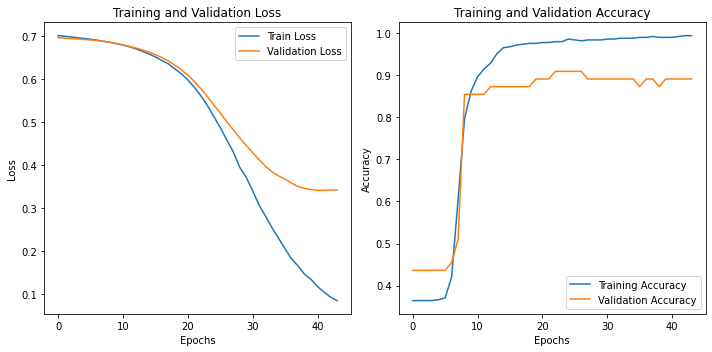

In [14]:
# Create a new figure for plotting
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
# Show the plots
plt.tight_layout()
plt.show()

In [15]:
def test_model(model, test_dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_dataloader, desc="Testing"):
            outputs = model(X_batch)  # Forward pass
            loss = loss_fn(outputs, y_batch)  # Compute loss
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)  # Get the predicted labels
            total += y_batch.size(0)  # Update the total count
            correct += (predicted == y_batch).sum().item()  # Update the correct count
        
    avg_loss = test_loss / len(test_dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluate the model on test data
test_loss, test_accuracy = test_model(model, test_dataloader, loss_fn=loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 2/2 [00:00<00:00, 471.27it/s]

Test Loss: 0.5138, Test Accuracy: 0.8276


### Fine-Tuning

In [16]:
# Instantiate the model
input_dim = X_tensor.shape[1]
output_dim = len(set(y_tensor.tolist())) 
model = DNN(input_dim, output_dim)

num_epochs= 10000
optimizer = Adam(model.parameters(), lr=0.000001)
loss_fn = CrossEntropyLoss()

patience=3
min_delta=0

# Call the function to train the model
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs, patience=patience, min_delta=min_delta)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00, 408.72it/s]


Epoch 1/10000, Train Loss: 0.7200, Train Acc: 0.3646, Val Loss: 0.7078, Val Acc: 0.4364


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00, 566.42it/s]


Epoch 2/10000, Train Loss: 0.7200, Train Acc: 0.3646, Val Loss: 0.7078, Val Acc: 0.4364


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


Epoch 3/10000, Train Loss: 0.7197, Train Acc: 0.3646, Val Loss: 0.7078, Val Acc: 0.4364


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 4/10000, Train Loss: 0.7200, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


Epoch 5/10000, Train Loss: 0.7195, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


Epoch 6/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


Epoch 7/10000, Train Loss: 0.7195, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00, 635.89it/s]


Epoch 8/10000, Train Loss: 0.7204, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


Epoch 9/10000, Train Loss: 0.7199, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 10/10000, Train Loss: 0.7202, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 11/10000, Train Loss: 0.7198, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 12/10000, Train Loss: 0.7198, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


Epoch 13/10000, Train Loss: 0.7205, Train Acc: 0.3646, Val Loss: 0.7077, Val Acc: 0.4364


Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


Epoch 14/10000, Train Loss: 0.7200, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00, 634.35it/s]


Epoch 15/10000, Train Loss: 0.7193, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


Epoch 16/10000, Train Loss: 0.7193, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00, 661.46it/s]


Epoch 17/10000, Train Loss: 0.7206, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


Epoch 18/10000, Train Loss: 0.7204, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 19/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 20/10000, Train Loss: 0.7199, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00, 628.36it/s]


Epoch 21/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00, 634.54it/s]


Epoch 22/10000, Train Loss: 0.7203, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 23/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7076, Val Acc: 0.4364


Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 24/10000, Train Loss: 0.7202, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 25/10000, Train Loss: 0.7197, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


Epoch 26/10000, Train Loss: 0.7190, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 27/10000, Train Loss: 0.7195, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 28/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 29/10000, Train Loss: 0.7199, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00, 626.39it/s]


Epoch 30/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


Epoch 31/10000, Train Loss: 0.7201, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00, 636.95it/s]


Epoch 32/10000, Train Loss: 0.7205, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


Epoch 33/10000, Train Loss: 0.7191, Train Acc: 0.3646, Val Loss: 0.7075, Val Acc: 0.4364


Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00, 639.86it/s]


Epoch 34/10000, Train Loss: 0.7190, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


Epoch 35/10000, Train Loss: 0.7193, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 36: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 36/10000, Train Loss: 0.7198, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 37: 100%|██████████| 1/1 [00:00<00:00, 625.27it/s]


Epoch 37/10000, Train Loss: 0.7196, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 38: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 38/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 39: 100%|██████████| 1/1 [00:00<00:00, 635.79it/s]


Epoch 39/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 40: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 40/10000, Train Loss: 0.7201, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 41: 100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


Epoch 41/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 42: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 42/10000, Train Loss: 0.7197, Train Acc: 0.3646, Val Loss: 0.7074, Val Acc: 0.4364


Validating epoch 43: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 43/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 44: 100%|██████████| 1/1 [00:00<00:00, 632.91it/s]


Epoch 44/10000, Train Loss: 0.7191, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 45: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 45/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 46: 100%|██████████| 1/1 [00:00<00:00, 624.52it/s]


Epoch 46/10000, Train Loss: 0.7185, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 47: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 47/10000, Train Loss: 0.7199, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 48: 100%|██████████| 1/1 [00:00<00:00, 628.08it/s]


Epoch 48/10000, Train Loss: 0.7190, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 49: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 49/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 50: 100%|██████████| 1/1 [00:00<00:00, 632.63it/s]


Epoch 50/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 51: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 51/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 52: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 52/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7073, Val Acc: 0.4364


Validating epoch 53: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 53/10000, Train Loss: 0.7195, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 54: 100%|██████████| 1/1 [00:00<00:00, 628.36it/s]


Epoch 54/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 55: 100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


Epoch 55/10000, Train Loss: 0.7188, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 56: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 56/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 57: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 57/10000, Train Loss: 0.7187, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 58: 100%|██████████| 1/1 [00:00<00:00, 632.43it/s]


Epoch 58/10000, Train Loss: 0.7188, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 59: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 59/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 60: 100%|██████████| 1/1 [00:00<00:00, 628.08it/s]


Epoch 60/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 61: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 61/10000, Train Loss: 0.7193, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 62: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 62/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7072, Val Acc: 0.4364


Validating epoch 63: 100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


Epoch 63/10000, Train Loss: 0.7175, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 64: 100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


Epoch 64/10000, Train Loss: 0.7187, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 65: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 65/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 66: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 66/10000, Train Loss: 0.7196, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 67: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 67/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 68: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 68/10000, Train Loss: 0.7187, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 69: 100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


Epoch 69/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 70: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 70/10000, Train Loss: 0.7190, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 71: 100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


Epoch 71/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 72: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 72/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7071, Val Acc: 0.4364


Validating epoch 73: 100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


Epoch 73/10000, Train Loss: 0.7188, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 74: 100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


Epoch 74/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 75: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 75/10000, Train Loss: 0.7191, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 76: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 76/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 77: 100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


Epoch 77/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 78: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 78/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 79: 100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


Epoch 79/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 80: 100%|██████████| 1/1 [00:00<00:00, 634.44it/s]


Epoch 80/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 81: 100%|██████████| 1/1 [00:00<00:00, 645.08it/s]


Epoch 81/10000, Train Loss: 0.7188, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 82: 100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


Epoch 82/10000, Train Loss: 0.7192, Train Acc: 0.3646, Val Loss: 0.7070, Val Acc: 0.4364


Validating epoch 83: 100%|██████████| 1/1 [00:00<00:00, 624.34it/s]


Epoch 83/10000, Train Loss: 0.7183, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 84: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 84/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 85: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 85/10000, Train Loss: 0.7185, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 86: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 86/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 87: 100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


Epoch 87/10000, Train Loss: 0.7185, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 88: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 88/10000, Train Loss: 0.7194, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 89: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 89/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 90: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 90/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 91: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 91/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 92: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 92/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7069, Val Acc: 0.4364


Validating epoch 93: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 93/10000, Train Loss: 0.7198, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 94: 100%|██████████| 1/1 [00:00<00:00, 623.87it/s]


Epoch 94/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 95: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 95/10000, Train Loss: 0.7182, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 96: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 96/10000, Train Loss: 0.7188, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 97: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 97/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 98: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 98/10000, Train Loss: 0.7190, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 99: 100%|██████████| 1/1 [00:00<00:00, 624.34it/s]


Epoch 99/10000, Train Loss: 0.7189, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 100: 100%|██████████| 1/1 [00:00<00:00, 633.68it/s]


Epoch 100/10000, Train Loss: 0.7183, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 101: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 101/10000, Train Loss: 0.7182, Train Acc: 0.3646, Val Loss: 0.7068, Val Acc: 0.4364


Validating epoch 102: 100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


Epoch 102/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 103: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 103/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 104: 100%|██████████| 1/1 [00:00<00:00, 631.01it/s]


Epoch 104/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 105: 100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


Epoch 105/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 106: 100%|██████████| 1/1 [00:00<00:00, 635.79it/s]


Epoch 106/10000, Train Loss: 0.7178, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 107: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 107/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 108: 100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


Epoch 108/10000, Train Loss: 0.7178, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 109: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 109/10000, Train Loss: 0.7185, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 110: 100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


Epoch 110/10000, Train Loss: 0.7182, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 111: 100%|██████████| 1/1 [00:00<00:00, 632.15it/s]


Epoch 111/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7067, Val Acc: 0.4364


Validating epoch 112: 100%|██████████| 1/1 [00:00<00:00, 635.21it/s]


Epoch 112/10000, Train Loss: 0.7172, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 113: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 113/10000, Train Loss: 0.7180, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 114: 100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


Epoch 114/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 115: 100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


Epoch 115/10000, Train Loss: 0.7178, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 116: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 116/10000, Train Loss: 0.7183, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 117: 100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


Epoch 117/10000, Train Loss: 0.7178, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 118: 100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


Epoch 118/10000, Train Loss: 0.7175, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 119: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 119/10000, Train Loss: 0.7175, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 120: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 120/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 121: 100%|██████████| 1/1 [00:00<00:00, 628.08it/s]


Epoch 121/10000, Train Loss: 0.7180, Train Acc: 0.3646, Val Loss: 0.7066, Val Acc: 0.4364


Validating epoch 122: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 122/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 123: 100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


Epoch 123/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 124: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 124/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 125: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 125/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 126: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 126/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 127: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 127/10000, Train Loss: 0.7178, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 128: 100%|██████████| 1/1 [00:00<00:00, 627.42it/s]


Epoch 128/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 129: 100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


Epoch 129/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 130: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 130/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7065, Val Acc: 0.4364


Validating epoch 131: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 131/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 132: 100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


Epoch 132/10000, Train Loss: 0.7180, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 133: 100%|██████████| 1/1 [00:00<00:00, 632.15it/s]


Epoch 133/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 134: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 134/10000, Train Loss: 0.7184, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 135: 100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


Epoch 135/10000, Train Loss: 0.7183, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 136: 100%|██████████| 1/1 [00:00<00:00, 631.20it/s]


Epoch 136/10000, Train Loss: 0.7186, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 137: 100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


Epoch 137/10000, Train Loss: 0.7177, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 138: 100%|██████████| 1/1 [00:00<00:00, 634.44it/s]


Epoch 138/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 139: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 139/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 140: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 140/10000, Train Loss: 0.7174, Train Acc: 0.3646, Val Loss: 0.7064, Val Acc: 0.4364


Validating epoch 141: 100%|██████████| 1/1 [00:00<00:00, 623.69it/s]


Epoch 141/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 142: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 142/10000, Train Loss: 0.7174, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 143: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 143/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 144: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 144/10000, Train Loss: 0.7182, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 145: 100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


Epoch 145/10000, Train Loss: 0.7181, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 146: 100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


Epoch 146/10000, Train Loss: 0.7171, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 147: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 147/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 148: 100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


Epoch 148/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 149: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 149/10000, Train Loss: 0.7172, Train Acc: 0.3646, Val Loss: 0.7063, Val Acc: 0.4364


Validating epoch 150: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 150/10000, Train Loss: 0.7177, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 151: 100%|██████████| 1/1 [00:00<00:00, 637.43it/s]


Epoch 151/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 152: 100%|██████████| 1/1 [00:00<00:00, 633.58it/s]


Epoch 152/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 153: 100%|██████████| 1/1 [00:00<00:00, 621.84it/s]


Epoch 153/10000, Train Loss: 0.7177, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 154: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 154/10000, Train Loss: 0.7172, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 155: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 155/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 156: 100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


Epoch 156/10000, Train Loss: 0.7168, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 157: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 157/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 158: 100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


Epoch 158/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7062, Val Acc: 0.4364


Validating epoch 159: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 159/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 160: 100%|██████████| 1/1 [00:00<00:00, 623.78it/s]


Epoch 160/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 161: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 161/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 162: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 162/10000, Train Loss: 0.7172, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 163: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 163/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 164: 100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


Epoch 164/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 165: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 165/10000, Train Loss: 0.7183, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 166: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 166/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 167: 100%|██████████| 1/1 [00:00<00:00, 631.01it/s]


Epoch 167/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7061, Val Acc: 0.4364


Validating epoch 168: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 168/10000, Train Loss: 0.7179, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 169: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 169/10000, Train Loss: 0.7171, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 170: 100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


Epoch 170/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 171: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 171/10000, Train Loss: 0.7177, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 172: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 172/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 173: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 173/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 174: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 174/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 175: 100%|██████████| 1/1 [00:00<00:00, 623.78it/s]


Epoch 175/10000, Train Loss: 0.7176, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 176: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 176/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7060, Val Acc: 0.4364


Validating epoch 177: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 177/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 178: 100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


Epoch 178/10000, Train Loss: 0.7175, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 179: 100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


Epoch 179/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 180: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 180/10000, Train Loss: 0.7174, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 181: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 181/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 182: 100%|██████████| 1/1 [00:00<00:00, 626.39it/s]


Epoch 182/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 183: 100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


Epoch 183/10000, Train Loss: 0.7172, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 184: 100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


Epoch 184/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 185: 100%|██████████| 1/1 [00:00<00:00, 618.81it/s]


Epoch 185/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7059, Val Acc: 0.4364


Validating epoch 186: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 186/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 187: 100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


Epoch 187/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 188: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 188/10000, Train Loss: 0.7167, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 189: 100%|██████████| 1/1 [00:00<00:00, 626.39it/s]


Epoch 189/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 190: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 190/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 191: 100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


Epoch 191/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 192: 100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


Epoch 192/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 193: 100%|██████████| 1/1 [00:00<00:00, 618.26it/s]


Epoch 193/10000, Train Loss: 0.7167, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 194: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 194/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 195: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 195/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7058, Val Acc: 0.4364


Validating epoch 196: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 196/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 197: 100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


Epoch 197/10000, Train Loss: 0.7169, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 198: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 198/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 199: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 199/10000, Train Loss: 0.7165, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 200: 100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


Epoch 200/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 201: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 201/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 202: 100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


Epoch 202/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 203: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 203/10000, Train Loss: 0.7164, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 204: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 204/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7057, Val Acc: 0.4364


Validating epoch 205: 100%|██████████| 1/1 [00:00<00:00, 626.20it/s]


Epoch 205/10000, Train Loss: 0.7167, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 206: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 206/10000, Train Loss: 0.7160, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 207: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 207/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 208: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 208/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 209: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 209/10000, Train Loss: 0.7160, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 210: 100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


Epoch 210/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 211: 100%|██████████| 1/1 [00:00<00:00, 620.37it/s]


Epoch 211/10000, Train Loss: 0.7164, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 212: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 212/10000, Train Loss: 0.7164, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 213: 100%|██████████| 1/1 [00:00<00:00, 625.08it/s]


Epoch 213/10000, Train Loss: 0.7165, Train Acc: 0.3646, Val Loss: 0.7056, Val Acc: 0.4364


Validating epoch 214: 100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


Epoch 214/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 215: 100%|██████████| 1/1 [00:00<00:00, 633.48it/s]


Epoch 215/10000, Train Loss: 0.7160, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 216: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 216/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 217: 100%|██████████| 1/1 [00:00<00:00, 644.29it/s]


Epoch 217/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 218: 100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


Epoch 218/10000, Train Loss: 0.7160, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 219: 100%|██████████| 1/1 [00:00<00:00, 631.01it/s]


Epoch 219/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 220: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 220/10000, Train Loss: 0.7173, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 221: 100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


Epoch 221/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 222: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 222/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7055, Val Acc: 0.4364


Validating epoch 223: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 223/10000, Train Loss: 0.7170, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 224: 100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


Epoch 224/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 225: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 225/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 226: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 226/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 227: 100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


Epoch 227/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 228: 100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


Epoch 228/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 229: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 229/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 230: 100%|██████████| 1/1 [00:00<00:00, 626.39it/s]


Epoch 230/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 231: 100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


Epoch 231/10000, Train Loss: 0.7166, Train Acc: 0.3646, Val Loss: 0.7054, Val Acc: 0.4364


Validating epoch 232: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 232/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 233: 100%|██████████| 1/1 [00:00<00:00, 632.91it/s]


Epoch 233/10000, Train Loss: 0.7156, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 234: 100%|██████████| 1/1 [00:00<00:00, 634.83it/s]


Epoch 234/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 235: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 235/10000, Train Loss: 0.7163, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 236: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 236/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 237: 100%|██████████| 1/1 [00:00<00:00, 632.15it/s]


Epoch 237/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 238: 100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


Epoch 238/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 239: 100%|██████████| 1/1 [00:00<00:00, 620.73it/s]


Epoch 239/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 240: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 240/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7053, Val Acc: 0.4364


Validating epoch 241: 100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


Epoch 241/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 242: 100%|██████████| 1/1 [00:00<00:00, 624.06it/s]


Epoch 242/10000, Train Loss: 0.7160, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 243: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 243/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 244: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


Epoch 244/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 245: 100%|██████████| 1/1 [00:00<00:00, 627.42it/s]


Epoch 245/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 246: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 246/10000, Train Loss: 0.7164, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 247: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 247/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 248: 100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


Epoch 248/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 249: 100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


Epoch 249/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7052, Val Acc: 0.4364


Validating epoch 250: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 250/10000, Train Loss: 0.7165, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 251: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 251/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 252: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 252/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 253: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 253/10000, Train Loss: 0.7165, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 254: 100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


Epoch 254/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 255: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 255/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 256: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 256/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 257: 100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


Epoch 257/10000, Train Loss: 0.7153, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 258: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 258/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7051, Val Acc: 0.4364


Validating epoch 259: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 259/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 260: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 260/10000, Train Loss: 0.7156, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 261: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 261/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 262: 100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


Epoch 262/10000, Train Loss: 0.7162, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 263: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 263/10000, Train Loss: 0.7154, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 264: 100%|██████████| 1/1 [00:00<00:00, 628.36it/s]


Epoch 264/10000, Train Loss: 0.7153, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 265: 100%|██████████| 1/1 [00:00<00:00, 624.90it/s]


Epoch 265/10000, Train Loss: 0.7148, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 266: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 266/10000, Train Loss: 0.7148, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 267: 100%|██████████| 1/1 [00:00<00:00, 616.27it/s]


Epoch 267/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7050, Val Acc: 0.4364


Validating epoch 268: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 268/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 269: 100%|██████████| 1/1 [00:00<00:00, 620.28it/s]


Epoch 269/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 270: 100%|██████████| 1/1 [00:00<00:00, 623.78it/s]


Epoch 270/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 271: 100%|██████████| 1/1 [00:00<00:00, 625.27it/s]


Epoch 271/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 272: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 272/10000, Train Loss: 0.7153, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 273: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 273/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 274: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 274/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 275: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 275/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7049, Val Acc: 0.4364


Validating epoch 276: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 276/10000, Train Loss: 0.7161, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 277: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 277/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 278: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 278/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 279: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 279/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 280: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 280/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 281: 100%|██████████| 1/1 [00:00<00:00, 626.20it/s]


Epoch 281/10000, Train Loss: 0.7156, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 282: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 282/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 283: 100%|██████████| 1/1 [00:00<00:00, 617.63it/s]


Epoch 283/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 284: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 284/10000, Train Loss: 0.7159, Train Acc: 0.3646, Val Loss: 0.7048, Val Acc: 0.4364


Validating epoch 285: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 285/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 286: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 286/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 287: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 287/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 288: 100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


Epoch 288/10000, Train Loss: 0.7154, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 289: 100%|██████████| 1/1 [00:00<00:00, 624.25it/s]


Epoch 289/10000, Train Loss: 0.7144, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 290: 100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


Epoch 290/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 291: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 291/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 292: 100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


Epoch 292/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 293: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 293/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7047, Val Acc: 0.4364


Validating epoch 294: 100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


Epoch 294/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 295: 100%|██████████| 1/1 [00:00<00:00, 621.93it/s]


Epoch 295/10000, Train Loss: 0.7157, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 296: 100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


Epoch 296/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 297: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 297/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 298: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 298/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 299: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 299/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 300: 100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


Epoch 300/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 301: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 301/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7046, Val Acc: 0.4364


Validating epoch 302: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 302/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 303: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 303/10000, Train Loss: 0.7145, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 304: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 304/10000, Train Loss: 0.7154, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 305: 100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


Epoch 305/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 306: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 306/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 307: 100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


Epoch 307/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 308: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 308/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 309: 100%|██████████| 1/1 [00:00<00:00, 625.08it/s]


Epoch 309/10000, Train Loss: 0.7156, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 310: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 310/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7045, Val Acc: 0.4364


Validating epoch 311: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 311/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 312: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 312/10000, Train Loss: 0.7148, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 313: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 313/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 314: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 314/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 315: 100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


Epoch 315/10000, Train Loss: 0.7155, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 316: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 316/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 317: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 317/10000, Train Loss: 0.7152, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 318: 100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


Epoch 318/10000, Train Loss: 0.7147, Train Acc: 0.3646, Val Loss: 0.7044, Val Acc: 0.4364


Validating epoch 319: 100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


Epoch 319/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 320: 100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


Epoch 320/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 321: 100%|██████████| 1/1 [00:00<00:00, 624.06it/s]


Epoch 321/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 322: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 322/10000, Train Loss: 0.7151, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 323: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 323/10000, Train Loss: 0.7148, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 324: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 324/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 325: 100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


Epoch 325/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 326: 100%|██████████| 1/1 [00:00<00:00, 627.04it/s]


Epoch 326/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 327: 100%|██████████| 1/1 [00:00<00:00, 633.01it/s]


Epoch 327/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7043, Val Acc: 0.4364


Validating epoch 328: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 328/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 329: 100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


Epoch 329/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 330: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 330/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 331: 100%|██████████| 1/1 [00:00<00:00, 621.84it/s]


Epoch 331/10000, Train Loss: 0.7158, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 332: 100%|██████████| 1/1 [00:00<00:00, 617.63it/s]


Epoch 332/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 333: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 333/10000, Train Loss: 0.7149, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 334: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 334/10000, Train Loss: 0.7140, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 335: 100%|██████████| 1/1 [00:00<00:00, 632.15it/s]


Epoch 335/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7042, Val Acc: 0.4364


Validating epoch 336: 100%|██████████| 1/1 [00:00<00:00, 641.04it/s]


Epoch 336/10000, Train Loss: 0.7150, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 337: 100%|██████████| 1/1 [00:00<00:00, 643.40it/s]


Epoch 337/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 338: 100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


Epoch 338/10000, Train Loss: 0.7144, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 339: 100%|██████████| 1/1 [00:00<00:00, 622.85it/s]


Epoch 339/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 340: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 340/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 341: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 341/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 342: 100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


Epoch 342/10000, Train Loss: 0.7147, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 343: 100%|██████████| 1/1 [00:00<00:00, 622.95it/s]


Epoch 343/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7041, Val Acc: 0.4364


Validating epoch 344: 100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


Epoch 344/10000, Train Loss: 0.7140, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 345: 100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


Epoch 345/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 346: 100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


Epoch 346/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 347: 100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


Epoch 347/10000, Train Loss: 0.7144, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 348: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 348/10000, Train Loss: 0.7148, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 349: 100%|██████████| 1/1 [00:00<00:00, 624.25it/s]


Epoch 349/10000, Train Loss: 0.7144, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 350: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 350/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 351: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 351/10000, Train Loss: 0.7144, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 352: 100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


Epoch 352/10000, Train Loss: 0.7146, Train Acc: 0.3646, Val Loss: 0.7040, Val Acc: 0.4364


Validating epoch 353: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 353/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 354: 100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


Epoch 354/10000, Train Loss: 0.7140, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 355: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 355/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 356: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 356/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 357: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 357/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 358: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 358/10000, Train Loss: 0.7137, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 359: 100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


Epoch 359/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 360: 100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


Epoch 360/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7039, Val Acc: 0.4364


Validating epoch 361: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 361/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 362: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 362/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 363: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


Epoch 363/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 364: 100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


Epoch 364/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 365: 100%|██████████| 1/1 [00:00<00:00, 635.12it/s]


Epoch 365/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 366: 100%|██████████| 1/1 [00:00<00:00, 627.42it/s]


Epoch 366/10000, Train Loss: 0.7135, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 367: 100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


Epoch 367/10000, Train Loss: 0.7135, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 368: 100%|██████████| 1/1 [00:00<00:00, 625.27it/s]


Epoch 368/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7038, Val Acc: 0.4364


Validating epoch 369: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 369/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 370: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 370/10000, Train Loss: 0.7137, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 371: 100%|██████████| 1/1 [00:00<00:00, 617.17it/s]


Epoch 371/10000, Train Loss: 0.7147, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 372: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 372/10000, Train Loss: 0.7145, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 373: 100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


Epoch 373/10000, Train Loss: 0.7130, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 374: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 374/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 375: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 375/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 376: 100%|██████████| 1/1 [00:00<00:00, 627.04it/s]


Epoch 376/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7037, Val Acc: 0.4364


Validating epoch 377: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 377/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 378: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 378/10000, Train Loss: 0.7135, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 379: 100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


Epoch 379/10000, Train Loss: 0.7137, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 380: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 380/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 381: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 381/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 382: 100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


Epoch 382/10000, Train Loss: 0.7142, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 383: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 383/10000, Train Loss: 0.7143, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 384: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 384/10000, Train Loss: 0.7132, Train Acc: 0.3646, Val Loss: 0.7036, Val Acc: 0.4364


Validating epoch 385: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 385/10000, Train Loss: 0.7139, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 386: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 386/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 387: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 387/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 388: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 388/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 389: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 389/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 390: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 390/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 391: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 391/10000, Train Loss: 0.7134, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 392: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 392/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7035, Val Acc: 0.4364


Validating epoch 393: 100%|██████████| 1/1 [00:00<00:00, 631.01it/s]


Epoch 393/10000, Train Loss: 0.7133, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 394: 100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


Epoch 394/10000, Train Loss: 0.7138, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 395: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 395/10000, Train Loss: 0.7141, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 396: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 396/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 397: 100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


Epoch 397/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 398: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 398/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 399: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 399/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 400: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 400/10000, Train Loss: 0.7135, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 401: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 401/10000, Train Loss: 0.7128, Train Acc: 0.3646, Val Loss: 0.7034, Val Acc: 0.4364


Validating epoch 402: 100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


Epoch 402/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 403: 100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


Epoch 403/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 404: 100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


Epoch 404/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 405: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 405/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 406: 100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


Epoch 406/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 407: 100%|██████████| 1/1 [00:00<00:00, 631.20it/s]


Epoch 407/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 408: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 408/10000, Train Loss: 0.7130, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 409: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 409/10000, Train Loss: 0.7130, Train Acc: 0.3646, Val Loss: 0.7033, Val Acc: 0.4364


Validating epoch 410: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 410/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 411: 100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


Epoch 411/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 412: 100%|██████████| 1/1 [00:00<00:00, 512.88it/s]


Epoch 412/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 413: 100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


Epoch 413/10000, Train Loss: 0.7120, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 414: 100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


Epoch 414/10000, Train Loss: 0.7122, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 415: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 415/10000, Train Loss: 0.7124, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 416: 100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


Epoch 416/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 417: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 417/10000, Train Loss: 0.7120, Train Acc: 0.3646, Val Loss: 0.7032, Val Acc: 0.4364


Validating epoch 418: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 418/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 419: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 419/10000, Train Loss: 0.7124, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 420: 100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


Epoch 420/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 421: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 421/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 422: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 422/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 423: 100%|██████████| 1/1 [00:00<00:00, 632.63it/s]


Epoch 423/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 424: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 424/10000, Train Loss: 0.7130, Train Acc: 0.3646, Val Loss: 0.7031, Val Acc: 0.4364


Validating epoch 425: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 425/10000, Train Loss: 0.7131, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 426: 100%|██████████| 1/1 [00:00<00:00, 620.92it/s]


Epoch 426/10000, Train Loss: 0.7119, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 427: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 427/10000, Train Loss: 0.7118, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 428: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


Epoch 428/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 429: 100%|██████████| 1/1 [00:00<00:00, 623.87it/s]


Epoch 429/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 430: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 430/10000, Train Loss: 0.7128, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 431: 100%|██████████| 1/1 [00:00<00:00, 616.27it/s]


Epoch 431/10000, Train Loss: 0.7128, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 432: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 432/10000, Train Loss: 0.7136, Train Acc: 0.3646, Val Loss: 0.7030, Val Acc: 0.4364


Validating epoch 433: 100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


Epoch 433/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 434: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 434/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 435: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 435/10000, Train Loss: 0.7126, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 436: 100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


Epoch 436/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 437: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 437/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 438: 100%|██████████| 1/1 [00:00<00:00, 624.34it/s]


Epoch 438/10000, Train Loss: 0.7124, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 439: 100%|██████████| 1/1 [00:00<00:00, 633.87it/s]


Epoch 439/10000, Train Loss: 0.7126, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 440: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 440/10000, Train Loss: 0.7129, Train Acc: 0.3646, Val Loss: 0.7029, Val Acc: 0.4364


Validating epoch 441: 100%|██████████| 1/1 [00:00<00:00, 625.18it/s]


Epoch 441/10000, Train Loss: 0.7128, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 442: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 442/10000, Train Loss: 0.7127, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 443: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 443/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 444: 100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


Epoch 444/10000, Train Loss: 0.7126, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 445: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 445/10000, Train Loss: 0.7118, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 446: 100%|██████████| 1/1 [00:00<00:00, 622.95it/s]


Epoch 446/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 447: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 447/10000, Train Loss: 0.7116, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 448: 100%|██████████| 1/1 [00:00<00:00, 633.01it/s]


Epoch 448/10000, Train Loss: 0.7120, Train Acc: 0.3646, Val Loss: 0.7028, Val Acc: 0.4364


Validating epoch 449: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 449/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 450: 100%|██████████| 1/1 [00:00<00:00, 624.52it/s]


Epoch 450/10000, Train Loss: 0.7126, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 451: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 451/10000, Train Loss: 0.7124, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 452: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 452/10000, Train Loss: 0.7120, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 453: 100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


Epoch 453/10000, Train Loss: 0.7122, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 454: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 454/10000, Train Loss: 0.7118, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 455: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 455/10000, Train Loss: 0.7122, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 456: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 456/10000, Train Loss: 0.7122, Train Acc: 0.3646, Val Loss: 0.7027, Val Acc: 0.4364


Validating epoch 457: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 457/10000, Train Loss: 0.7125, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 458: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 458/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 459: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 459/10000, Train Loss: 0.7119, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 460: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 460/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 461: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 461/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 462: 100%|██████████| 1/1 [00:00<00:00, 620.00it/s]


Epoch 462/10000, Train Loss: 0.7126, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 463: 100%|██████████| 1/1 [00:00<00:00, 623.04it/s]


Epoch 463/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 464: 100%|██████████| 1/1 [00:00<00:00, 631.20it/s]


Epoch 464/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7026, Val Acc: 0.4364


Validating epoch 465: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 465/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 466: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 466/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 467: 100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


Epoch 467/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 468: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 468/10000, Train Loss: 0.7123, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 469: 100%|██████████| 1/1 [00:00<00:00, 625.08it/s]


Epoch 469/10000, Train Loss: 0.7113, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 470: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 470/10000, Train Loss: 0.7119, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 471: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 471/10000, Train Loss: 0.7116, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 472: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 472/10000, Train Loss: 0.7119, Train Acc: 0.3646, Val Loss: 0.7025, Val Acc: 0.4364


Validating epoch 473: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 473/10000, Train Loss: 0.7110, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 474: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 474/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 475: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 475/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 476: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 476/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 477: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 477/10000, Train Loss: 0.7118, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 478: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 478/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 479: 100%|██████████| 1/1 [00:00<00:00, 624.25it/s]


Epoch 479/10000, Train Loss: 0.7113, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 480: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 480/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7024, Val Acc: 0.4364


Validating epoch 481: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 481/10000, Train Loss: 0.7120, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 482: 100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


Epoch 482/10000, Train Loss: 0.7109, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 483: 100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


Epoch 483/10000, Train Loss: 0.7116, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 484: 100%|██████████| 1/1 [00:00<00:00, 632.24it/s]


Epoch 484/10000, Train Loss: 0.7119, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 485: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 485/10000, Train Loss: 0.7117, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 486: 100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


Epoch 486/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 487: 100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


Epoch 487/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7023, Val Acc: 0.4364


Validating epoch 488: 100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


Epoch 488/10000, Train Loss: 0.7118, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 489: 100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


Epoch 489/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 490: 100%|██████████| 1/1 [00:00<00:00, 635.79it/s]


Epoch 490/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 491: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 491/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 492: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 492/10000, Train Loss: 0.7117, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 493: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 493/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 494: 100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


Epoch 494/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 495: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 495/10000, Train Loss: 0.7114, Train Acc: 0.3646, Val Loss: 0.7022, Val Acc: 0.4364


Validating epoch 496: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 496/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 497: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 497/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 498: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 498/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 499: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 499/10000, Train Loss: 0.7122, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 500: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 500/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 501: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 501/10000, Train Loss: 0.7121, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 502: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 502/10000, Train Loss: 0.7113, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 503: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 503/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7021, Val Acc: 0.4364


Validating epoch 504: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 504/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 505: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 505/10000, Train Loss: 0.7104, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 506: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 506/10000, Train Loss: 0.7117, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 507: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 507/10000, Train Loss: 0.7109, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 508: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 508/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 509: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 509/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 510: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 510/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7020, Val Acc: 0.4364


Validating epoch 511: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 511/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 512: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 512/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 513: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 513/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 514: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 514/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 515: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 515/10000, Train Loss: 0.7116, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 516: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 516/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 517: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 517/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 518: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 518/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7019, Val Acc: 0.4364


Validating epoch 519: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 519/10000, Train Loss: 0.7107, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 520: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 520/10000, Train Loss: 0.7107, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 521: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 521/10000, Train Loss: 0.7115, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 522: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 522/10000, Train Loss: 0.7112, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 523: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 523/10000, Train Loss: 0.7107, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 524: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 524/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 525: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 525/10000, Train Loss: 0.7107, Train Acc: 0.3646, Val Loss: 0.7018, Val Acc: 0.4364


Validating epoch 526: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 526/10000, Train Loss: 0.7113, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 527: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 527/10000, Train Loss: 0.7110, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 528: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 528/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 529: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 529/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 530: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 530/10000, Train Loss: 0.7104, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 531: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 531/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 532: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 532/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 533: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 533/10000, Train Loss: 0.7109, Train Acc: 0.3646, Val Loss: 0.7017, Val Acc: 0.4364


Validating epoch 534: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 534/10000, Train Loss: 0.7111, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 535: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 535/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 536: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 536/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 537: 100%|██████████| 1/1 [00:00<00:00, 638.79it/s]


Epoch 537/10000, Train Loss: 0.7107, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 538: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 538/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 539: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 539/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 540: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 540/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7016, Val Acc: 0.4364


Validating epoch 541: 100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


Epoch 541/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 542: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 542/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 543: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 543/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 544: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 544/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 545: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 545/10000, Train Loss: 0.7100, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 546: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 546/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 547: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 547/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 548: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 548/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7015, Val Acc: 0.4364


Validating epoch 549: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 549/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 550: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 550/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 551: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 551/10000, Train Loss: 0.7094, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 552: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 552/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 553: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 553/10000, Train Loss: 0.7098, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 554: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 554/10000, Train Loss: 0.7104, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 555: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 555/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7014, Val Acc: 0.4364


Validating epoch 556: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 556/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 557: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 557/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 558: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 558/10000, Train Loss: 0.7108, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 559: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 559/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 560: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 560/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 561: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 561/10000, Train Loss: 0.7099, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 562: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 562/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 563: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 563/10000, Train Loss: 0.7098, Train Acc: 0.3646, Val Loss: 0.7013, Val Acc: 0.4364


Validating epoch 564: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 564/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 565: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 565/10000, Train Loss: 0.7100, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 566: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 566/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 567: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 567/10000, Train Loss: 0.7100, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 568: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 568/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 569: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 569/10000, Train Loss: 0.7106, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 570: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 570/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7012, Val Acc: 0.4364


Validating epoch 571: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 571/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 572: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 572/10000, Train Loss: 0.7105, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 573: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 573/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 574: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 574/10000, Train Loss: 0.7101, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 575: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 575/10000, Train Loss: 0.7100, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 576: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 576/10000, Train Loss: 0.7098, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 577: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 577/10000, Train Loss: 0.7100, Train Acc: 0.3646, Val Loss: 0.7011, Val Acc: 0.4364


Validating epoch 578: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 578/10000, Train Loss: 0.7094, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 579: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 579/10000, Train Loss: 0.7099, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 580: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 580/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 581: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 581/10000, Train Loss: 0.7098, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 582: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 582/10000, Train Loss: 0.7102, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 583: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 583/10000, Train Loss: 0.7099, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 584: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 584/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 585: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 585/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7010, Val Acc: 0.4364


Validating epoch 586: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 586/10000, Train Loss: 0.7103, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 587: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 587/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 588: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 588/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 589: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 589/10000, Train Loss: 0.7099, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 590: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 590/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 591: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 591/10000, Train Loss: 0.7096, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 592: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 592/10000, Train Loss: 0.7095, Train Acc: 0.3646, Val Loss: 0.7009, Val Acc: 0.4364


Validating epoch 593: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 593/10000, Train Loss: 0.7096, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 594: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 594/10000, Train Loss: 0.7099, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 595: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 595/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 596: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 596/10000, Train Loss: 0.7094, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 597: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 597/10000, Train Loss: 0.7088, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 598: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 598/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 599: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 599/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7008, Val Acc: 0.4364


Validating epoch 600: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 600/10000, Train Loss: 0.7086, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 601: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 601/10000, Train Loss: 0.7097, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 602: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 602/10000, Train Loss: 0.7097, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 603: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 603/10000, Train Loss: 0.7094, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 604: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 604/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 605: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 605/10000, Train Loss: 0.7086, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 606: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 606/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7007, Val Acc: 0.4364


Validating epoch 607: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 607/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 608: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 608/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 609: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 609/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 610: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 610/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 611: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 611/10000, Train Loss: 0.7083, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 612: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 612/10000, Train Loss: 0.7090, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 613: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 613/10000, Train Loss: 0.7096, Train Acc: 0.3646, Val Loss: 0.7006, Val Acc: 0.4364


Validating epoch 614: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 614/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 615: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 615/10000, Train Loss: 0.7094, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 616: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 616/10000, Train Loss: 0.7087, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 617: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 617/10000, Train Loss: 0.7092, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 618: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 618/10000, Train Loss: 0.7086, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 619: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 619/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 620: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 620/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 621: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 621/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7005, Val Acc: 0.4364


Validating epoch 622: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 622/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 623: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 623/10000, Train Loss: 0.7086, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 624: 100%|██████████| 1/1 [00:00<00:00, 580.85it/s]


Epoch 624/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 625: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 625/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 626: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 626/10000, Train Loss: 0.7090, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 627: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 627/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 628: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 628/10000, Train Loss: 0.7083, Train Acc: 0.3646, Val Loss: 0.7004, Val Acc: 0.4364


Validating epoch 629: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 629/10000, Train Loss: 0.7093, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 630: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 630/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 631: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 631/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 632: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 632/10000, Train Loss: 0.7076, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 633: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 633/10000, Train Loss: 0.7091, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 634: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 634/10000, Train Loss: 0.7088, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 635: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 635/10000, Train Loss: 0.7083, Train Acc: 0.3646, Val Loss: 0.7003, Val Acc: 0.4364


Validating epoch 636: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 636/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 637: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 637/10000, Train Loss: 0.7090, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 638: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 638/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 639: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 639/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 640: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 640/10000, Train Loss: 0.7081, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 641: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 641/10000, Train Loss: 0.7089, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 642: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 642/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7002, Val Acc: 0.4364


Validating epoch 643: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 643/10000, Train Loss: 0.7090, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 644: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 644/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 645: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 645/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 646: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 646/10000, Train Loss: 0.7079, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 647: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 647/10000, Train Loss: 0.7077, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 648: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 648/10000, Train Loss: 0.7075, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 649: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 649/10000, Train Loss: 0.7079, Train Acc: 0.3646, Val Loss: 0.7001, Val Acc: 0.4364


Validating epoch 650: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 650/10000, Train Loss: 0.7075, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 651: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 651/10000, Train Loss: 0.7083, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 652: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 652/10000, Train Loss: 0.7077, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 653: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 653/10000, Train Loss: 0.7085, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 654: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 654/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 655: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 655/10000, Train Loss: 0.7086, Train Acc: 0.3646, Val Loss: 0.7000, Val Acc: 0.4364


Validating epoch 656: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 656/10000, Train Loss: 0.7080, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 657: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 657/10000, Train Loss: 0.7082, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 658: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 658/10000, Train Loss: 0.7079, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 659: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 659/10000, Train Loss: 0.7081, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 660: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 660/10000, Train Loss: 0.7078, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 661: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 661/10000, Train Loss: 0.7081, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 662: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 662/10000, Train Loss: 0.7088, Train Acc: 0.3646, Val Loss: 0.6999, Val Acc: 0.4364


Validating epoch 663: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 663/10000, Train Loss: 0.7074, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 664: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 664/10000, Train Loss: 0.7080, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 665: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 665/10000, Train Loss: 0.7078, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 666: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 666/10000, Train Loss: 0.7079, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 667: 100%|██████████| 1/1 [00:00<00:00, 568.95it/s]


Epoch 667/10000, Train Loss: 0.7084, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 668: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 668/10000, Train Loss: 0.7076, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 669: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 669/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6998, Val Acc: 0.4364


Validating epoch 670: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 670/10000, Train Loss: 0.7077, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 671: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 671/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 672: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 672/10000, Train Loss: 0.7078, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 673: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 673/10000, Train Loss: 0.7077, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 674: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 674/10000, Train Loss: 0.7078, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 675: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 675/10000, Train Loss: 0.7070, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 676: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 676/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6997, Val Acc: 0.4364


Validating epoch 677: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 677/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 678: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 678/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 679: 100%|██████████| 1/1 [00:00<00:00, 619.73it/s]


Epoch 679/10000, Train Loss: 0.7076, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 680: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 680/10000, Train Loss: 0.7079, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 681: 100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


Epoch 681/10000, Train Loss: 0.7070, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 682: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 682/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 683: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 683/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 684: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 684/10000, Train Loss: 0.7081, Train Acc: 0.3646, Val Loss: 0.6996, Val Acc: 0.4364


Validating epoch 685: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 685/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 686: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 686/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 687: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 687/10000, Train Loss: 0.7076, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 688: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 688/10000, Train Loss: 0.7070, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 689: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 689/10000, Train Loss: 0.7067, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 690: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 690/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 691: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 691/10000, Train Loss: 0.7066, Train Acc: 0.3646, Val Loss: 0.6995, Val Acc: 0.4364


Validating epoch 692: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 692/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 693: 100%|██████████| 1/1 [00:00<00:00, 616.18it/s]


Epoch 693/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 694: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 694/10000, Train Loss: 0.7068, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 695: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 695/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 696: 100%|██████████| 1/1 [00:00<00:00, 622.30it/s]


Epoch 696/10000, Train Loss: 0.7070, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 697: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 697/10000, Train Loss: 0.7066, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 698: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 698/10000, Train Loss: 0.7078, Train Acc: 0.3646, Val Loss: 0.6994, Val Acc: 0.4364


Validating epoch 699: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 699/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 700: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 700/10000, Train Loss: 0.7080, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 701: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 701/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 702: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 702/10000, Train Loss: 0.7076, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 703: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 703/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 704: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 704/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 705: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 705/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6993, Val Acc: 0.4364


Validating epoch 706: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 706/10000, Train Loss: 0.7068, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 707: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 707/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 708: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 708/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 709: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 709/10000, Train Loss: 0.7072, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 710: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 710/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 711: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 711/10000, Train Loss: 0.7074, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 712: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 712/10000, Train Loss: 0.7067, Train Acc: 0.3646, Val Loss: 0.6992, Val Acc: 0.4364


Validating epoch 713: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 713/10000, Train Loss: 0.7068, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 714: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 714/10000, Train Loss: 0.7071, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 715: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 715/10000, Train Loss: 0.7070, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 716: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 716/10000, Train Loss: 0.7063, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 717: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 717/10000, Train Loss: 0.7067, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 718: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 718/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 719: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 719/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6991, Val Acc: 0.4364


Validating epoch 720: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 720/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 721: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 721/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 722: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 722/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 723: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 723/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 724: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 724/10000, Train Loss: 0.7066, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 725: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 725/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6990, Val Acc: 0.4364


Validating epoch 726: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 726/10000, Train Loss: 0.7060, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 727: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 727/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 728: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 728/10000, Train Loss: 0.7063, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 729: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 729/10000, Train Loss: 0.7059, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 730: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 730/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 731: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 731/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 732: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 732/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6989, Val Acc: 0.4364


Validating epoch 733: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 733/10000, Train Loss: 0.7057, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 734: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 734/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 735: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 735/10000, Train Loss: 0.7063, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 736: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 736/10000, Train Loss: 0.7061, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 737: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 737/10000, Train Loss: 0.7073, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 738: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 738/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 739: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 739/10000, Train Loss: 0.7069, Train Acc: 0.3646, Val Loss: 0.6988, Val Acc: 0.4364


Validating epoch 740: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 740/10000, Train Loss: 0.7061, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 741: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 741/10000, Train Loss: 0.7067, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 742: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 742/10000, Train Loss: 0.7060, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 743: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 743/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 744: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 744/10000, Train Loss: 0.7065, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 745: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 745/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 746: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 746/10000, Train Loss: 0.7061, Train Acc: 0.3646, Val Loss: 0.6987, Val Acc: 0.4364


Validating epoch 747: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 747/10000, Train Loss: 0.7053, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 748: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 748/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 749: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 749/10000, Train Loss: 0.7060, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 750: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 750/10000, Train Loss: 0.7063, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 751: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 751/10000, Train Loss: 0.7059, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 752: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 752/10000, Train Loss: 0.7057, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 753: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 753/10000, Train Loss: 0.7058, Train Acc: 0.3646, Val Loss: 0.6986, Val Acc: 0.4364


Validating epoch 754: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 754/10000, Train Loss: 0.7060, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 755: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 755/10000, Train Loss: 0.7067, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 756: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 756/10000, Train Loss: 0.7057, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 757: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 757/10000, Train Loss: 0.7059, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 758: 100%|██████████| 1/1 [00:00<00:00, 299.68it/s]


Epoch 758/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 759: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 759/10000, Train Loss: 0.7059, Train Acc: 0.3646, Val Loss: 0.6985, Val Acc: 0.4364


Validating epoch 760: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 760/10000, Train Loss: 0.7058, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 761: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 761/10000, Train Loss: 0.7055, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 762: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 762/10000, Train Loss: 0.7053, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 763: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 763/10000, Train Loss: 0.7059, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 764: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 764/10000, Train Loss: 0.7061, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 765: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 765/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 766: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 766/10000, Train Loss: 0.7062, Train Acc: 0.3646, Val Loss: 0.6984, Val Acc: 0.4364


Validating epoch 767: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 767/10000, Train Loss: 0.7064, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 768: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 768/10000, Train Loss: 0.7060, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 769: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 769/10000, Train Loss: 0.7055, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 770: 100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


Epoch 770/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 771: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 771/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 772: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 772/10000, Train Loss: 0.7066, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 773: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 773/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6983, Val Acc: 0.4364


Validating epoch 774: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 774/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 775: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 775/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 776: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 776/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 777: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 777/10000, Train Loss: 0.7055, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 778: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 778/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 779: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 779/10000, Train Loss: 0.7053, Train Acc: 0.3646, Val Loss: 0.6982, Val Acc: 0.4364


Validating epoch 780: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 780/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 781: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 781/10000, Train Loss: 0.7057, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 782: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 782/10000, Train Loss: 0.7055, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 783: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 783/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 784: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 784/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 785: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 785/10000, Train Loss: 0.7056, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 786: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 786/10000, Train Loss: 0.7051, Train Acc: 0.3646, Val Loss: 0.6981, Val Acc: 0.4364


Validating epoch 787: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 787/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 788: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 788/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 789: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 789/10000, Train Loss: 0.7056, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 790: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 790/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 791: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 791/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 792: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 792/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 793: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 793/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6980, Val Acc: 0.4364


Validating epoch 794: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 794/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 795: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 795/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 796: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 796/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 797: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 797/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 798: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 798/10000, Train Loss: 0.7044, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 799: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 799/10000, Train Loss: 0.7045, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 800: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 800/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6979, Val Acc: 0.4364


Validating epoch 801: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 801/10000, Train Loss: 0.7046, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 802: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 802/10000, Train Loss: 0.7052, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 803: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 803/10000, Train Loss: 0.7043, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 804: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 804/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 805: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 805/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 806: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 806/10000, Train Loss: 0.7051, Train Acc: 0.3646, Val Loss: 0.6978, Val Acc: 0.4364


Validating epoch 807: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 807/10000, Train Loss: 0.7051, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 808: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 808/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 809: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 809/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 810: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 810/10000, Train Loss: 0.7038, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 811: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 811/10000, Train Loss: 0.7044, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 812: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 812/10000, Train Loss: 0.7045, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 813: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 813/10000, Train Loss: 0.7043, Train Acc: 0.3646, Val Loss: 0.6977, Val Acc: 0.4364


Validating epoch 814: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 814/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 815: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 815/10000, Train Loss: 0.7038, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 816: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 816/10000, Train Loss: 0.7048, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 817: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 817/10000, Train Loss: 0.7047, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 818: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 818/10000, Train Loss: 0.7043, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 819: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 819/10000, Train Loss: 0.7041, Train Acc: 0.3646, Val Loss: 0.6976, Val Acc: 0.4364


Validating epoch 820: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 820/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 821: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 821/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 822: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 822/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 823: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 823/10000, Train Loss: 0.7051, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 824: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 824/10000, Train Loss: 0.7046, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 825: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 825/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 826: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 826/10000, Train Loss: 0.7050, Train Acc: 0.3646, Val Loss: 0.6975, Val Acc: 0.4364


Validating epoch 827: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 827/10000, Train Loss: 0.7040, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 828: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 828/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 829: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 829/10000, Train Loss: 0.7039, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 830: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 830/10000, Train Loss: 0.7039, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 831: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 831/10000, Train Loss: 0.7039, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 832: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 832/10000, Train Loss: 0.7049, Train Acc: 0.3646, Val Loss: 0.6974, Val Acc: 0.4364


Validating epoch 833: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 833/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 834: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 834/10000, Train Loss: 0.7034, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 835: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 835/10000, Train Loss: 0.7037, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 836: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 836/10000, Train Loss: 0.7037, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 837: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 837/10000, Train Loss: 0.7040, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 838: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 838/10000, Train Loss: 0.7041, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 839: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 839/10000, Train Loss: 0.7041, Train Acc: 0.3646, Val Loss: 0.6973, Val Acc: 0.4364


Validating epoch 840: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 840/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 841: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 841/10000, Train Loss: 0.7043, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 842: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 842/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 843: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 843/10000, Train Loss: 0.7041, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 844: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 844/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 845: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 845/10000, Train Loss: 0.7034, Train Acc: 0.3646, Val Loss: 0.6972, Val Acc: 0.4364


Validating epoch 846: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 846/10000, Train Loss: 0.7038, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 847: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 847/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 848: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 848/10000, Train Loss: 0.7043, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 849: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 849/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 850: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 850/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 851: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 851/10000, Train Loss: 0.7040, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 852: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 852/10000, Train Loss: 0.7037, Train Acc: 0.3646, Val Loss: 0.6971, Val Acc: 0.4364


Validating epoch 853: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 853/10000, Train Loss: 0.7033, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 854: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 854/10000, Train Loss: 0.7036, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 855: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 855/10000, Train Loss: 0.7042, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 856: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 856/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 857: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 857/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 858: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 858/10000, Train Loss: 0.7037, Train Acc: 0.3646, Val Loss: 0.6970, Val Acc: 0.4364


Validating epoch 859: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 859/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 860: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 860/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 861: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 861/10000, Train Loss: 0.7033, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 862: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 862/10000, Train Loss: 0.7040, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 863: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 863/10000, Train Loss: 0.7028, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 864: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 864/10000, Train Loss: 0.7030, Train Acc: 0.3646, Val Loss: 0.6969, Val Acc: 0.4364


Validating epoch 865: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 865/10000, Train Loss: 0.7030, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 866: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 866/10000, Train Loss: 0.7034, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 867: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 867/10000, Train Loss: 0.7031, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 868: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 868/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 869: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 869/10000, Train Loss: 0.7037, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 870: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 870/10000, Train Loss: 0.7035, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 871: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 871/10000, Train Loss: 0.7031, Train Acc: 0.3646, Val Loss: 0.6968, Val Acc: 0.4364


Validating epoch 872: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 872/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 873: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 873/10000, Train Loss: 0.7030, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 874: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 874/10000, Train Loss: 0.7040, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 875: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 875/10000, Train Loss: 0.7033, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 876: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 876/10000, Train Loss: 0.7033, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 877: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 877/10000, Train Loss: 0.7039, Train Acc: 0.3646, Val Loss: 0.6967, Val Acc: 0.4364


Validating epoch 878: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 878/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 879: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 879/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 880: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 880/10000, Train Loss: 0.7033, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 881: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 881/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 882: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 882/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 883: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 883/10000, Train Loss: 0.7029, Train Acc: 0.3646, Val Loss: 0.6966, Val Acc: 0.4364


Validating epoch 884: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 884/10000, Train Loss: 0.7029, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 885: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 885/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 886: 100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


Epoch 886/10000, Train Loss: 0.7025, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 887: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 887/10000, Train Loss: 0.7032, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 888: 100%|██████████| 1/1 [00:00<00:00, 590.75it/s]


Epoch 888/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 889: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 889/10000, Train Loss: 0.7029, Train Acc: 0.3646, Val Loss: 0.6965, Val Acc: 0.4364


Validating epoch 890: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 890/10000, Train Loss: 0.7030, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 891: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 891/10000, Train Loss: 0.7030, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 892: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 892/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 893: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 893/10000, Train Loss: 0.7031, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 894: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 894/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 895: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 895/10000, Train Loss: 0.7025, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 896: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 896/10000, Train Loss: 0.7025, Train Acc: 0.3646, Val Loss: 0.6964, Val Acc: 0.4364


Validating epoch 897: 100%|██████████| 1/1 [00:00<00:00, 586.86it/s]


Epoch 897/10000, Train Loss: 0.7025, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 898: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 898/10000, Train Loss: 0.7022, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 899: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 899/10000, Train Loss: 0.7026, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 900: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 900/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 901: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 901/10000, Train Loss: 0.7021, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 902: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 902/10000, Train Loss: 0.7022, Train Acc: 0.3646, Val Loss: 0.6963, Val Acc: 0.4364


Validating epoch 903: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 903/10000, Train Loss: 0.7025, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 904: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 904/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 905: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 905/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 906: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 906/10000, Train Loss: 0.7026, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 907: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 907/10000, Train Loss: 0.7019, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 908: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 908/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6962, Val Acc: 0.4364


Validating epoch 909: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 909/10000, Train Loss: 0.7021, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 910: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 910/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 911: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 911/10000, Train Loss: 0.7022, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 912: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 912/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 913: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 913/10000, Train Loss: 0.7014, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 914: 100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


Epoch 914/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6961, Val Acc: 0.4364


Validating epoch 915: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 915/10000, Train Loss: 0.7027, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 916: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 916/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 917: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 917/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 918: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 918/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 919: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 919/10000, Train Loss: 0.7021, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 920: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 920/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6960, Val Acc: 0.4364


Validating epoch 921: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 921/10000, Train Loss: 0.7021, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 922: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 922/10000, Train Loss: 0.7026, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 923: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 923/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 924: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 924/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 925: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 925/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 926: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 926/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6959, Val Acc: 0.4364


Validating epoch 927: 100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


Epoch 927/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 928: 100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


Epoch 928/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 929: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 929/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 930: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 930/10000, Train Loss: 0.7016, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 931: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 931/10000, Train Loss: 0.7023, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 932: 100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


Epoch 932/10000, Train Loss: 0.7016, Train Acc: 0.3646, Val Loss: 0.6958, Val Acc: 0.4364


Validating epoch 933: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 933/10000, Train Loss: 0.7014, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 934: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 934/10000, Train Loss: 0.7013, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 935: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 935/10000, Train Loss: 0.7017, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 936: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 936/10000, Train Loss: 0.7020, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 937: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 937/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 938: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 938/10000, Train Loss: 0.7016, Train Acc: 0.3646, Val Loss: 0.6957, Val Acc: 0.4364


Validating epoch 939: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 939/10000, Train Loss: 0.7009, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 940: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 940/10000, Train Loss: 0.7019, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 941: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 941/10000, Train Loss: 0.7015, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 942: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 942/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 943: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 943/10000, Train Loss: 0.7017, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 944: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 944/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6956, Val Acc: 0.4364


Validating epoch 945: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 945/10000, Train Loss: 0.7017, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 946: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 946/10000, Train Loss: 0.7016, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 947: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 947/10000, Train Loss: 0.7016, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 948: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 948/10000, Train Loss: 0.7013, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 949: 100%|██████████| 1/1 [00:00<00:00, 590.00it/s]


Epoch 949/10000, Train Loss: 0.7018, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 950: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 950/10000, Train Loss: 0.7008, Train Acc: 0.3646, Val Loss: 0.6955, Val Acc: 0.4364


Validating epoch 951: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 951/10000, Train Loss: 0.7009, Train Acc: 0.3646, Val Loss: 0.6954, Val Acc: 0.4364


Validating epoch 952: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 952/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6954, Val Acc: 0.4364


Validating epoch 953: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 953/10000, Train Loss: 0.7017, Train Acc: 0.3646, Val Loss: 0.6954, Val Acc: 0.4364


Validating epoch 954: 100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


Epoch 954/10000, Train Loss: 0.7012, Train Acc: 0.3646, Val Loss: 0.6954, Val Acc: 0.4364


Validating epoch 955: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 955/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6954, Val Acc: 0.4364


Validating epoch 956: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 956/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 957: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 957/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 958: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 958/10000, Train Loss: 0.7008, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 959: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 959/10000, Train Loss: 0.7009, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 960: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 960/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 961: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 961/10000, Train Loss: 0.7007, Train Acc: 0.3646, Val Loss: 0.6953, Val Acc: 0.4364


Validating epoch 962: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 962/10000, Train Loss: 0.7009, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 963: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 963/10000, Train Loss: 0.7007, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 964: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 964/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 965: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 965/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 966: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 966/10000, Train Loss: 0.7007, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 967: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 967/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6952, Val Acc: 0.4364


Validating epoch 968: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 968/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 969: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 969/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 970: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 970/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 971: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 971/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 972: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 972/10000, Train Loss: 0.7005, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 973: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 973/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6951, Val Acc: 0.4364


Validating epoch 974: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 974/10000, Train Loss: 0.7005, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 975: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 975/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 976: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 976/10000, Train Loss: 0.7007, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 977: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 977/10000, Train Loss: 0.7011, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 978: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 978/10000, Train Loss: 0.7005, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 979: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 979/10000, Train Loss: 0.7001, Train Acc: 0.3646, Val Loss: 0.6950, Val Acc: 0.4364


Validating epoch 980: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 980/10000, Train Loss: 0.7000, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 981: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 981/10000, Train Loss: 0.7004, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 982: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 982/10000, Train Loss: 0.7005, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 983: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 983/10000, Train Loss: 0.7004, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 984: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 984/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6949, Val Acc: 0.4364


Validating epoch 985: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 985/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 986: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 986/10000, Train Loss: 0.7006, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 987: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 987/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 988: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 988/10000, Train Loss: 0.7001, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 989: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 989/10000, Train Loss: 0.6998, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 990: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 990/10000, Train Loss: 0.7010, Train Acc: 0.3646, Val Loss: 0.6948, Val Acc: 0.4364


Validating epoch 991: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 991/10000, Train Loss: 0.6997, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 992: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 992/10000, Train Loss: 0.6992, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 993: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 993/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 994: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 994/10000, Train Loss: 0.6996, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 995: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 995/10000, Train Loss: 0.6996, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 996: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 996/10000, Train Loss: 0.6997, Train Acc: 0.3646, Val Loss: 0.6947, Val Acc: 0.4364


Validating epoch 997: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 997/10000, Train Loss: 0.7004, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 998: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 998/10000, Train Loss: 0.6999, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 999: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 999/10000, Train Loss: 0.6994, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 1000: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1000/10000, Train Loss: 0.7000, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 1001: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 1001/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 1002: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1002/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6946, Val Acc: 0.4364


Validating epoch 1003: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 1003/10000, Train Loss: 0.6988, Train Acc: 0.3646, Val Loss: 0.6945, Val Acc: 0.4364


Validating epoch 1004: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1004/10000, Train Loss: 0.6999, Train Acc: 0.3646, Val Loss: 0.6945, Val Acc: 0.4364


Validating epoch 1005: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1005/10000, Train Loss: 0.7002, Train Acc: 0.3646, Val Loss: 0.6945, Val Acc: 0.4364


Validating epoch 1006: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 1006/10000, Train Loss: 0.6997, Train Acc: 0.3646, Val Loss: 0.6945, Val Acc: 0.4364


Validating epoch 1007: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1007/10000, Train Loss: 0.7000, Train Acc: 0.3646, Val Loss: 0.6945, Val Acc: 0.4364


Validating epoch 1008: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1008/10000, Train Loss: 0.7000, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1009: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 1009/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1010: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1010/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1011: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 1011/10000, Train Loss: 0.6995, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1012: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1012/10000, Train Loss: 0.6991, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1013: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 1013/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6944, Val Acc: 0.4364


Validating epoch 1014: 100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


Epoch 1014/10000, Train Loss: 0.6996, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1015: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 1015/10000, Train Loss: 0.6995, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1016: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1016/10000, Train Loss: 0.6996, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1017: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 1017/10000, Train Loss: 0.6997, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1018: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1018/10000, Train Loss: 0.6992, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1019: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1019/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6943, Val Acc: 0.4364


Validating epoch 1020: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1020/10000, Train Loss: 0.7003, Train Acc: 0.3646, Val Loss: 0.6942, Val Acc: 0.4364


Validating epoch 1021: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1021/10000, Train Loss: 0.6995, Train Acc: 0.3646, Val Loss: 0.6942, Val Acc: 0.4364


Validating epoch 1022: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1022/10000, Train Loss: 0.6994, Train Acc: 0.3646, Val Loss: 0.6942, Val Acc: 0.4364


Validating epoch 1023: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 1023/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6942, Val Acc: 0.4364


Validating epoch 1024: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1024/10000, Train Loss: 0.6991, Train Acc: 0.3646, Val Loss: 0.6942, Val Acc: 0.4364


Validating epoch 1025: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 1025/10000, Train Loss: 0.6991, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1026: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 1026/10000, Train Loss: 0.6998, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1027: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1027/10000, Train Loss: 0.6994, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1028: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 1028/10000, Train Loss: 0.6995, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1029: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1029/10000, Train Loss: 0.6987, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1030: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 1030/10000, Train Loss: 0.6985, Train Acc: 0.3646, Val Loss: 0.6941, Val Acc: 0.4364


Validating epoch 1031: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1031/10000, Train Loss: 0.6995, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1032: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1032/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1033: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1033/10000, Train Loss: 0.6990, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1034: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 1034/10000, Train Loss: 0.6987, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1035: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 1035/10000, Train Loss: 0.6992, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1036: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1036/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6940, Val Acc: 0.4364


Validating epoch 1037: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 1037/10000, Train Loss: 0.6984, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 1038: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1038/10000, Train Loss: 0.6993, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 1039: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1039/10000, Train Loss: 0.6988, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 1040: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1040/10000, Train Loss: 0.6985, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 1041: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1041/10000, Train Loss: 0.6990, Train Acc: 0.3646, Val Loss: 0.6939, Val Acc: 0.4364


Validating epoch 1042: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 1042/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1043: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1043/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1044: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 1044/10000, Train Loss: 0.6986, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1045: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 1045/10000, Train Loss: 0.6986, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1046: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 1046/10000, Train Loss: 0.6983, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1047: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 1047/10000, Train Loss: 0.6988, Train Acc: 0.3646, Val Loss: 0.6938, Val Acc: 0.4364


Validating epoch 1048: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 1048/10000, Train Loss: 0.6987, Train Acc: 0.3646, Val Loss: 0.6937, Val Acc: 0.4364


Validating epoch 1049: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1049/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6937, Val Acc: 0.4364


Validating epoch 1050: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1050/10000, Train Loss: 0.6988, Train Acc: 0.3646, Val Loss: 0.6937, Val Acc: 0.4364


Validating epoch 1051: 100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


Epoch 1051/10000, Train Loss: 0.6982, Train Acc: 0.3646, Val Loss: 0.6937, Val Acc: 0.4364


Validating epoch 1052: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 1052/10000, Train Loss: 0.6985, Train Acc: 0.3646, Val Loss: 0.6937, Val Acc: 0.4364


Validating epoch 1053: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1053/10000, Train Loss: 0.6978, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1054: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1054/10000, Train Loss: 0.6977, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1055: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1055/10000, Train Loss: 0.6982, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1056: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1056/10000, Train Loss: 0.6986, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1057: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1057/10000, Train Loss: 0.6984, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1058: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 1058/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6936, Val Acc: 0.4364


Validating epoch 1059: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1059/10000, Train Loss: 0.6984, Train Acc: 0.3646, Val Loss: 0.6935, Val Acc: 0.4364


Validating epoch 1060: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 1060/10000, Train Loss: 0.6985, Train Acc: 0.3646, Val Loss: 0.6935, Val Acc: 0.4364


Validating epoch 1061: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 1061/10000, Train Loss: 0.6984, Train Acc: 0.3646, Val Loss: 0.6935, Val Acc: 0.4364


Validating epoch 1062: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1062/10000, Train Loss: 0.6978, Train Acc: 0.3646, Val Loss: 0.6935, Val Acc: 0.4364


Validating epoch 1063: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1063/10000, Train Loss: 0.6982, Train Acc: 0.3646, Val Loss: 0.6935, Val Acc: 0.4364


Validating epoch 1064: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1064/10000, Train Loss: 0.6982, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1065: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 1065/10000, Train Loss: 0.6983, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1066: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1066/10000, Train Loss: 0.6982, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1067: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 1067/10000, Train Loss: 0.6989, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1068: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1068/10000, Train Loss: 0.6976, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1069: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1069/10000, Train Loss: 0.6981, Train Acc: 0.3646, Val Loss: 0.6934, Val Acc: 0.4364


Validating epoch 1070: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1070/10000, Train Loss: 0.6975, Train Acc: 0.3646, Val Loss: 0.6933, Val Acc: 0.4364


Validating epoch 1071: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1071/10000, Train Loss: 0.6979, Train Acc: 0.3646, Val Loss: 0.6933, Val Acc: 0.4364


Validating epoch 1072: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1072/10000, Train Loss: 0.6975, Train Acc: 0.3646, Val Loss: 0.6933, Val Acc: 0.4364


Validating epoch 1073: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 1073/10000, Train Loss: 0.6976, Train Acc: 0.3646, Val Loss: 0.6933, Val Acc: 0.4364


Validating epoch 1074: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1074/10000, Train Loss: 0.6979, Train Acc: 0.3646, Val Loss: 0.6933, Val Acc: 0.4364


Validating epoch 1075: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1075/10000, Train Loss: 0.6981, Train Acc: 0.3646, Val Loss: 0.6932, Val Acc: 0.4364


Validating epoch 1076: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1076/10000, Train Loss: 0.6978, Train Acc: 0.3646, Val Loss: 0.6932, Val Acc: 0.4364


Validating epoch 1077: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1077/10000, Train Loss: 0.6976, Train Acc: 0.3646, Val Loss: 0.6932, Val Acc: 0.4364


Validating epoch 1078: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1078/10000, Train Loss: 0.6979, Train Acc: 0.3646, Val Loss: 0.6932, Val Acc: 0.4364


Validating epoch 1079: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 1079/10000, Train Loss: 0.6977, Train Acc: 0.3646, Val Loss: 0.6932, Val Acc: 0.4364


Validating epoch 1080: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 1080/10000, Train Loss: 0.6975, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1081: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1081/10000, Train Loss: 0.6978, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1082: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1082/10000, Train Loss: 0.6984, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1083: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1083/10000, Train Loss: 0.6975, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1084: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1084/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1085: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 1085/10000, Train Loss: 0.6977, Train Acc: 0.3646, Val Loss: 0.6931, Val Acc: 0.4364


Validating epoch 1086: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1086/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6930, Val Acc: 0.4364


Validating epoch 1087: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1087/10000, Train Loss: 0.6977, Train Acc: 0.3646, Val Loss: 0.6930, Val Acc: 0.4364


Validating epoch 1088: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1088/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6930, Val Acc: 0.4364


Validating epoch 1089: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1089/10000, Train Loss: 0.6975, Train Acc: 0.3646, Val Loss: 0.6930, Val Acc: 0.4364


Validating epoch 1090: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1090/10000, Train Loss: 0.6976, Train Acc: 0.3646, Val Loss: 0.6930, Val Acc: 0.4364


Validating epoch 1091: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1091/10000, Train Loss: 0.6979, Train Acc: 0.3646, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 1092: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 1092/10000, Train Loss: 0.6979, Train Acc: 0.3646, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 1093: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 1093/10000, Train Loss: 0.6970, Train Acc: 0.3646, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 1094: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 1094/10000, Train Loss: 0.6971, Train Acc: 0.3646, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 1095: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1095/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6929, Val Acc: 0.4364


Validating epoch 1096: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 1096/10000, Train Loss: 0.6969, Train Acc: 0.3646, Val Loss: 0.6928, Val Acc: 0.4364


Validating epoch 1097: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 1097/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6928, Val Acc: 0.4364


Validating epoch 1098: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 1098/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6928, Val Acc: 0.4364


Validating epoch 1099: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1099/10000, Train Loss: 0.6978, Train Acc: 0.3646, Val Loss: 0.6928, Val Acc: 0.4364


Validating epoch 1100: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1100/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6928, Val Acc: 0.4364


Validating epoch 1101: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 1101/10000, Train Loss: 0.6968, Train Acc: 0.3646, Val Loss: 0.6927, Val Acc: 0.4364


Validating epoch 1102: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 1102/10000, Train Loss: 0.6970, Train Acc: 0.3646, Val Loss: 0.6927, Val Acc: 0.4364


Validating epoch 1103: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1103/10000, Train Loss: 0.6971, Train Acc: 0.3646, Val Loss: 0.6927, Val Acc: 0.4364


Validating epoch 1104: 100%|██████████| 1/1 [00:00<00:00, 589.00it/s]


Epoch 1104/10000, Train Loss: 0.6970, Train Acc: 0.3646, Val Loss: 0.6927, Val Acc: 0.4364


Validating epoch 1105: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1105/10000, Train Loss: 0.6973, Train Acc: 0.3646, Val Loss: 0.6927, Val Acc: 0.4364


Validating epoch 1106: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1106/10000, Train Loss: 0.6969, Train Acc: 0.3646, Val Loss: 0.6926, Val Acc: 0.4364


Validating epoch 1107: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1107/10000, Train Loss: 0.6967, Train Acc: 0.3646, Val Loss: 0.6926, Val Acc: 0.4364


Validating epoch 1108: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1108/10000, Train Loss: 0.6972, Train Acc: 0.3646, Val Loss: 0.6926, Val Acc: 0.4364


Validating epoch 1109: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 1109/10000, Train Loss: 0.6968, Train Acc: 0.3646, Val Loss: 0.6926, Val Acc: 0.4364


Validating epoch 1110: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1110/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6926, Val Acc: 0.4364


Validating epoch 1111: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1111/10000, Train Loss: 0.6968, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1112: 100%|██████████| 1/1 [00:00<00:00, 591.33it/s]


Epoch 1112/10000, Train Loss: 0.6969, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1113: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1113/10000, Train Loss: 0.6967, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1114: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 1114/10000, Train Loss: 0.6969, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1115: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 1115/10000, Train Loss: 0.6970, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1116: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 1116/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6925, Val Acc: 0.4364


Validating epoch 1117: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1117/10000, Train Loss: 0.6968, Train Acc: 0.3646, Val Loss: 0.6924, Val Acc: 0.4364


Validating epoch 1118: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 1118/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6924, Val Acc: 0.4364


Validating epoch 1119: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1119/10000, Train Loss: 0.6965, Train Acc: 0.3646, Val Loss: 0.6924, Val Acc: 0.4364


Validating epoch 1120: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1120/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6924, Val Acc: 0.4364


Validating epoch 1121: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 1121/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6924, Val Acc: 0.4364


Validating epoch 1122: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 1122/10000, Train Loss: 0.6963, Train Acc: 0.3646, Val Loss: 0.6923, Val Acc: 0.4364


Validating epoch 1123: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1123/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6923, Val Acc: 0.4364


Validating epoch 1124: 100%|██████████| 1/1 [00:00<00:00, 586.53it/s]


Epoch 1124/10000, Train Loss: 0.6961, Train Acc: 0.3646, Val Loss: 0.6923, Val Acc: 0.4364


Validating epoch 1125: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1125/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6923, Val Acc: 0.4364


Validating epoch 1126: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 1126/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6923, Val Acc: 0.4364


Validating epoch 1127: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1127/10000, Train Loss: 0.6962, Train Acc: 0.3646, Val Loss: 0.6922, Val Acc: 0.4364


Validating epoch 1128: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1128/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6922, Val Acc: 0.4364


Validating epoch 1129: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 1129/10000, Train Loss: 0.6966, Train Acc: 0.3646, Val Loss: 0.6922, Val Acc: 0.4364


Validating epoch 1130: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1130/10000, Train Loss: 0.6959, Train Acc: 0.3646, Val Loss: 0.6922, Val Acc: 0.4364


Validating epoch 1131: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1131/10000, Train Loss: 0.6963, Train Acc: 0.3646, Val Loss: 0.6922, Val Acc: 0.4364


Validating epoch 1132: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1132/10000, Train Loss: 0.6960, Train Acc: 0.3646, Val Loss: 0.6921, Val Acc: 0.4364


Validating epoch 1133: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1133/10000, Train Loss: 0.6954, Train Acc: 0.3646, Val Loss: 0.6921, Val Acc: 0.4364


Validating epoch 1134: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 1134/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6921, Val Acc: 0.4364


Validating epoch 1135: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 1135/10000, Train Loss: 0.6959, Train Acc: 0.3646, Val Loss: 0.6921, Val Acc: 0.4364


Validating epoch 1136: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1136/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6921, Val Acc: 0.4364


Validating epoch 1137: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1137/10000, Train Loss: 0.6961, Train Acc: 0.3646, Val Loss: 0.6920, Val Acc: 0.4364


Validating epoch 1138: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1138/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6920, Val Acc: 0.4364


Validating epoch 1139: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1139/10000, Train Loss: 0.6957, Train Acc: 0.3646, Val Loss: 0.6920, Val Acc: 0.4364


Validating epoch 1140: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1140/10000, Train Loss: 0.6953, Train Acc: 0.3646, Val Loss: 0.6920, Val Acc: 0.4364


Validating epoch 1141: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1141/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6920, Val Acc: 0.4364


Validating epoch 1142: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1142/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6919, Val Acc: 0.4364


Validating epoch 1143: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1143/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6919, Val Acc: 0.4364


Validating epoch 1144: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 1144/10000, Train Loss: 0.6960, Train Acc: 0.3646, Val Loss: 0.6919, Val Acc: 0.4364


Validating epoch 1145: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 1145/10000, Train Loss: 0.6963, Train Acc: 0.3646, Val Loss: 0.6919, Val Acc: 0.4364


Validating epoch 1146: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1146/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6919, Val Acc: 0.4364


Validating epoch 1147: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1147/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6918, Val Acc: 0.4364


Validating epoch 1148: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1148/10000, Train Loss: 0.6960, Train Acc: 0.3646, Val Loss: 0.6918, Val Acc: 0.4364


Validating epoch 1149: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1149/10000, Train Loss: 0.6959, Train Acc: 0.3646, Val Loss: 0.6918, Val Acc: 0.4364


Validating epoch 1150: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 1150/10000, Train Loss: 0.6952, Train Acc: 0.3646, Val Loss: 0.6918, Val Acc: 0.4364


Validating epoch 1151: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1151/10000, Train Loss: 0.6960, Train Acc: 0.3646, Val Loss: 0.6918, Val Acc: 0.4364


Validating epoch 1152: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 1152/10000, Train Loss: 0.6964, Train Acc: 0.3646, Val Loss: 0.6917, Val Acc: 0.4364


Validating epoch 1153: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 1153/10000, Train Loss: 0.6961, Train Acc: 0.3646, Val Loss: 0.6917, Val Acc: 0.4364


Validating epoch 1154: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 1154/10000, Train Loss: 0.6959, Train Acc: 0.3646, Val Loss: 0.6917, Val Acc: 0.4364


Validating epoch 1155: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1155/10000, Train Loss: 0.6963, Train Acc: 0.3646, Val Loss: 0.6917, Val Acc: 0.4364


Validating epoch 1156: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1156/10000, Train Loss: 0.6957, Train Acc: 0.3646, Val Loss: 0.6917, Val Acc: 0.4364


Validating epoch 1157: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1157/10000, Train Loss: 0.6943, Train Acc: 0.3646, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 1158: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1158/10000, Train Loss: 0.6953, Train Acc: 0.3646, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 1159: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1159/10000, Train Loss: 0.6954, Train Acc: 0.3646, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 1160: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 1160/10000, Train Loss: 0.6943, Train Acc: 0.3646, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 1161: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1161/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6916, Val Acc: 0.4364


Validating epoch 1162: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 1162/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6915, Val Acc: 0.4364


Validating epoch 1163: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 1163/10000, Train Loss: 0.6951, Train Acc: 0.3646, Val Loss: 0.6915, Val Acc: 0.4364


Validating epoch 1164: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1164/10000, Train Loss: 0.6960, Train Acc: 0.3646, Val Loss: 0.6915, Val Acc: 0.4364


Validating epoch 1165: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1165/10000, Train Loss: 0.6956, Train Acc: 0.3646, Val Loss: 0.6915, Val Acc: 0.4364


Validating epoch 1166: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1166/10000, Train Loss: 0.6953, Train Acc: 0.3646, Val Loss: 0.6915, Val Acc: 0.4364


Validating epoch 1167: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 1167/10000, Train Loss: 0.6953, Train Acc: 0.3646, Val Loss: 0.6914, Val Acc: 0.4364


Validating epoch 1168: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 1168/10000, Train Loss: 0.6958, Train Acc: 0.3646, Val Loss: 0.6914, Val Acc: 0.4364


Validating epoch 1169: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1169/10000, Train Loss: 0.6951, Train Acc: 0.3646, Val Loss: 0.6914, Val Acc: 0.4364


Validating epoch 1170: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 1170/10000, Train Loss: 0.6949, Train Acc: 0.3646, Val Loss: 0.6914, Val Acc: 0.4364


Validating epoch 1171: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1171/10000, Train Loss: 0.6947, Train Acc: 0.3646, Val Loss: 0.6914, Val Acc: 0.4364


Validating epoch 1172: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1172/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6913, Val Acc: 0.4364


Validating epoch 1173: 100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


Epoch 1173/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6913, Val Acc: 0.4364


Validating epoch 1174: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1174/10000, Train Loss: 0.6952, Train Acc: 0.3646, Val Loss: 0.6913, Val Acc: 0.4364


Validating epoch 1175: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1175/10000, Train Loss: 0.6949, Train Acc: 0.3646, Val Loss: 0.6913, Val Acc: 0.4364


Validating epoch 1176: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1176/10000, Train Loss: 0.6950, Train Acc: 0.3646, Val Loss: 0.6913, Val Acc: 0.4364


Validating epoch 1177: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 1177/10000, Train Loss: 0.6950, Train Acc: 0.3646, Val Loss: 0.6912, Val Acc: 0.4364


Validating epoch 1178: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1178/10000, Train Loss: 0.6937, Train Acc: 0.3646, Val Loss: 0.6912, Val Acc: 0.4364


Validating epoch 1179: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 1179/10000, Train Loss: 0.6951, Train Acc: 0.3646, Val Loss: 0.6912, Val Acc: 0.4364


Validating epoch 1180: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1180/10000, Train Loss: 0.6949, Train Acc: 0.3646, Val Loss: 0.6912, Val Acc: 0.4364


Validating epoch 1181: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1181/10000, Train Loss: 0.6945, Train Acc: 0.3646, Val Loss: 0.6912, Val Acc: 0.4364


Validating epoch 1182: 100%|██████████| 1/1 [00:00<00:00, 584.90it/s]


Epoch 1182/10000, Train Loss: 0.6945, Train Acc: 0.3646, Val Loss: 0.6911, Val Acc: 0.4364


Validating epoch 1183: 100%|██████████| 1/1 [00:00<00:00, 590.41it/s]


Epoch 1183/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6911, Val Acc: 0.4364


Validating epoch 1184: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 1184/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6911, Val Acc: 0.4364


Validating epoch 1185: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 1185/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6911, Val Acc: 0.4364


Validating epoch 1186: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 1186/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6911, Val Acc: 0.4364


Validating epoch 1187: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1187/10000, Train Loss: 0.6948, Train Acc: 0.3646, Val Loss: 0.6910, Val Acc: 0.4364


Validating epoch 1188: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1188/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6910, Val Acc: 0.4364


Validating epoch 1189: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1189/10000, Train Loss: 0.6945, Train Acc: 0.3646, Val Loss: 0.6910, Val Acc: 0.4364


Validating epoch 1190: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1190/10000, Train Loss: 0.6942, Train Acc: 0.3646, Val Loss: 0.6910, Val Acc: 0.4364


Validating epoch 1191: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1191/10000, Train Loss: 0.6943, Train Acc: 0.3646, Val Loss: 0.6910, Val Acc: 0.4364


Validating epoch 1192: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1192/10000, Train Loss: 0.6950, Train Acc: 0.3646, Val Loss: 0.6909, Val Acc: 0.4364


Validating epoch 1193: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 1193/10000, Train Loss: 0.6939, Train Acc: 0.3646, Val Loss: 0.6909, Val Acc: 0.4364


Validating epoch 1194: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1194/10000, Train Loss: 0.6940, Train Acc: 0.3646, Val Loss: 0.6909, Val Acc: 0.4364


Validating epoch 1195: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 1195/10000, Train Loss: 0.6937, Train Acc: 0.3646, Val Loss: 0.6909, Val Acc: 0.4364


Validating epoch 1196: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1196/10000, Train Loss: 0.6938, Train Acc: 0.3646, Val Loss: 0.6908, Val Acc: 0.4364


Validating epoch 1197: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 1197/10000, Train Loss: 0.6946, Train Acc: 0.3646, Val Loss: 0.6908, Val Acc: 0.4364


Validating epoch 1198: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 1198/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6908, Val Acc: 0.4364


Validating epoch 1199: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1199/10000, Train Loss: 0.6947, Train Acc: 0.3646, Val Loss: 0.6908, Val Acc: 0.4364


Validating epoch 1200: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 1200/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6908, Val Acc: 0.4364


Validating epoch 1201: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1201/10000, Train Loss: 0.6937, Train Acc: 0.3646, Val Loss: 0.6907, Val Acc: 0.4364


Validating epoch 1202: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1202/10000, Train Loss: 0.6943, Train Acc: 0.3646, Val Loss: 0.6907, Val Acc: 0.4364


Validating epoch 1203: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1203/10000, Train Loss: 0.6938, Train Acc: 0.3646, Val Loss: 0.6907, Val Acc: 0.4364


Validating epoch 1204: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1204/10000, Train Loss: 0.6941, Train Acc: 0.3646, Val Loss: 0.6907, Val Acc: 0.4364


Validating epoch 1205: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 1205/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6907, Val Acc: 0.4364


Validating epoch 1206: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 1206/10000, Train Loss: 0.6942, Train Acc: 0.3646, Val Loss: 0.6906, Val Acc: 0.4364


Validating epoch 1207: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 1207/10000, Train Loss: 0.6947, Train Acc: 0.3646, Val Loss: 0.6906, Val Acc: 0.4364


Validating epoch 1208: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1208/10000, Train Loss: 0.6934, Train Acc: 0.3646, Val Loss: 0.6906, Val Acc: 0.4364


Validating epoch 1209: 100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


Epoch 1209/10000, Train Loss: 0.6932, Train Acc: 0.3646, Val Loss: 0.6906, Val Acc: 0.4364


Validating epoch 1210: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1210/10000, Train Loss: 0.6936, Train Acc: 0.3646, Val Loss: 0.6906, Val Acc: 0.4364


Validating epoch 1211: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1211/10000, Train Loss: 0.6944, Train Acc: 0.3646, Val Loss: 0.6905, Val Acc: 0.4364


Validating epoch 1212: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1212/10000, Train Loss: 0.6943, Train Acc: 0.3646, Val Loss: 0.6905, Val Acc: 0.4364


Validating epoch 1213: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1213/10000, Train Loss: 0.6934, Train Acc: 0.3646, Val Loss: 0.6905, Val Acc: 0.4364


Validating epoch 1214: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1214/10000, Train Loss: 0.6939, Train Acc: 0.3646, Val Loss: 0.6905, Val Acc: 0.4364


Validating epoch 1215: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1215/10000, Train Loss: 0.6939, Train Acc: 0.3646, Val Loss: 0.6904, Val Acc: 0.4364


Validating epoch 1216: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 1216/10000, Train Loss: 0.6942, Train Acc: 0.3646, Val Loss: 0.6904, Val Acc: 0.4364


Validating epoch 1217: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1217/10000, Train Loss: 0.6937, Train Acc: 0.3646, Val Loss: 0.6904, Val Acc: 0.4364


Validating epoch 1218: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1218/10000, Train Loss: 0.6938, Train Acc: 0.3646, Val Loss: 0.6904, Val Acc: 0.4364


Validating epoch 1219: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1219/10000, Train Loss: 0.6938, Train Acc: 0.3646, Val Loss: 0.6904, Val Acc: 0.4364


Validating epoch 1220: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1220/10000, Train Loss: 0.6947, Train Acc: 0.3646, Val Loss: 0.6903, Val Acc: 0.4364


Validating epoch 1221: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1221/10000, Train Loss: 0.6934, Train Acc: 0.3646, Val Loss: 0.6903, Val Acc: 0.4364


Validating epoch 1222: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 1222/10000, Train Loss: 0.6934, Train Acc: 0.3646, Val Loss: 0.6903, Val Acc: 0.4364


Validating epoch 1223: 100%|██████████| 1/1 [00:00<00:00, 587.11it/s]


Epoch 1223/10000, Train Loss: 0.6935, Train Acc: 0.3646, Val Loss: 0.6903, Val Acc: 0.4364


Validating epoch 1224: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 1224/10000, Train Loss: 0.6930, Train Acc: 0.3646, Val Loss: 0.6903, Val Acc: 0.4364


Validating epoch 1225: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 1225/10000, Train Loss: 0.6935, Train Acc: 0.3646, Val Loss: 0.6902, Val Acc: 0.4364


Validating epoch 1226: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 1226/10000, Train Loss: 0.6936, Train Acc: 0.3646, Val Loss: 0.6902, Val Acc: 0.4364


Validating epoch 1227: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 1227/10000, Train Loss: 0.6939, Train Acc: 0.3646, Val Loss: 0.6902, Val Acc: 0.4364


Validating epoch 1228: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 1228/10000, Train Loss: 0.6931, Train Acc: 0.3646, Val Loss: 0.6902, Val Acc: 0.4364


Validating epoch 1229: 100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


Epoch 1229/10000, Train Loss: 0.6934, Train Acc: 0.3646, Val Loss: 0.6901, Val Acc: 0.4364


Validating epoch 1230: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1230/10000, Train Loss: 0.6932, Train Acc: 0.3646, Val Loss: 0.6901, Val Acc: 0.4364


Validating epoch 1231: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1231/10000, Train Loss: 0.6927, Train Acc: 0.3646, Val Loss: 0.6901, Val Acc: 0.4364


Validating epoch 1232: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1232/10000, Train Loss: 0.6931, Train Acc: 0.3646, Val Loss: 0.6901, Val Acc: 0.4364


Validating epoch 1233: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1233/10000, Train Loss: 0.6926, Train Acc: 0.3646, Val Loss: 0.6901, Val Acc: 0.4364


Validating epoch 1234: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 1234/10000, Train Loss: 0.6935, Train Acc: 0.3646, Val Loss: 0.6900, Val Acc: 0.4364


Validating epoch 1235: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1235/10000, Train Loss: 0.6925, Train Acc: 0.3646, Val Loss: 0.6900, Val Acc: 0.4364


Validating epoch 1236: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1236/10000, Train Loss: 0.6929, Train Acc: 0.3646, Val Loss: 0.6900, Val Acc: 0.4364


Validating epoch 1237: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 1237/10000, Train Loss: 0.6928, Train Acc: 0.3646, Val Loss: 0.6900, Val Acc: 0.4364


Validating epoch 1238: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1238/10000, Train Loss: 0.6929, Train Acc: 0.3646, Val Loss: 0.6900, Val Acc: 0.4364


Validating epoch 1239: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1239/10000, Train Loss: 0.6928, Train Acc: 0.3646, Val Loss: 0.6899, Val Acc: 0.4364


Validating epoch 1240: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1240/10000, Train Loss: 0.6929, Train Acc: 0.3646, Val Loss: 0.6899, Val Acc: 0.4364


Validating epoch 1241: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 1241/10000, Train Loss: 0.6930, Train Acc: 0.3646, Val Loss: 0.6899, Val Acc: 0.4364


Validating epoch 1242: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 1242/10000, Train Loss: 0.6922, Train Acc: 0.3646, Val Loss: 0.6899, Val Acc: 0.4364


Validating epoch 1243: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1243/10000, Train Loss: 0.6927, Train Acc: 0.3646, Val Loss: 0.6898, Val Acc: 0.4364


Validating epoch 1244: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 1244/10000, Train Loss: 0.6929, Train Acc: 0.3646, Val Loss: 0.6898, Val Acc: 0.4364


Validating epoch 1245: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1245/10000, Train Loss: 0.6931, Train Acc: 0.3646, Val Loss: 0.6898, Val Acc: 0.4364


Validating epoch 1246: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 1246/10000, Train Loss: 0.6930, Train Acc: 0.3646, Val Loss: 0.6898, Val Acc: 0.4364


Validating epoch 1247: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 1247/10000, Train Loss: 0.6923, Train Acc: 0.3646, Val Loss: 0.6898, Val Acc: 0.4364


Validating epoch 1248: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1248/10000, Train Loss: 0.6923, Train Acc: 0.3646, Val Loss: 0.6897, Val Acc: 0.4364


Validating epoch 1249: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 1249/10000, Train Loss: 0.6923, Train Acc: 0.3646, Val Loss: 0.6897, Val Acc: 0.4364


Validating epoch 1250: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1250/10000, Train Loss: 0.6925, Train Acc: 0.3646, Val Loss: 0.6897, Val Acc: 0.4364


Validating epoch 1251: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1251/10000, Train Loss: 0.6922, Train Acc: 0.3646, Val Loss: 0.6897, Val Acc: 0.4364


Validating epoch 1252: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1252/10000, Train Loss: 0.6928, Train Acc: 0.3646, Val Loss: 0.6896, Val Acc: 0.4364


Validating epoch 1253: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1253/10000, Train Loss: 0.6929, Train Acc: 0.3646, Val Loss: 0.6896, Val Acc: 0.4364


Validating epoch 1254: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 1254/10000, Train Loss: 0.6928, Train Acc: 0.3646, Val Loss: 0.6896, Val Acc: 0.4364


Validating epoch 1255: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 1255/10000, Train Loss: 0.6928, Train Acc: 0.3646, Val Loss: 0.6896, Val Acc: 0.4364


Validating epoch 1256: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1256/10000, Train Loss: 0.6925, Train Acc: 0.3646, Val Loss: 0.6896, Val Acc: 0.4364


Validating epoch 1257: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1257/10000, Train Loss: 0.6925, Train Acc: 0.3646, Val Loss: 0.6895, Val Acc: 0.4364


Validating epoch 1258: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 1258/10000, Train Loss: 0.6922, Train Acc: 0.3646, Val Loss: 0.6895, Val Acc: 0.4364


Validating epoch 1259: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1259/10000, Train Loss: 0.6920, Train Acc: 0.3646, Val Loss: 0.6895, Val Acc: 0.4364


Validating epoch 1260: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1260/10000, Train Loss: 0.6918, Train Acc: 0.3646, Val Loss: 0.6895, Val Acc: 0.4364


Validating epoch 1261: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 1261/10000, Train Loss: 0.6923, Train Acc: 0.3646, Val Loss: 0.6894, Val Acc: 0.4364


Validating epoch 1262: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1262/10000, Train Loss: 0.6926, Train Acc: 0.3646, Val Loss: 0.6894, Val Acc: 0.4364


Validating epoch 1263: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 1263/10000, Train Loss: 0.6925, Train Acc: 0.3646, Val Loss: 0.6894, Val Acc: 0.4364


Validating epoch 1264: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1264/10000, Train Loss: 0.6916, Train Acc: 0.3646, Val Loss: 0.6894, Val Acc: 0.4364


Validating epoch 1265: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 1265/10000, Train Loss: 0.6918, Train Acc: 0.3646, Val Loss: 0.6894, Val Acc: 0.4364


Validating epoch 1266: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1266/10000, Train Loss: 0.6920, Train Acc: 0.3646, Val Loss: 0.6893, Val Acc: 0.4364


Validating epoch 1267: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 1267/10000, Train Loss: 0.6926, Train Acc: 0.3646, Val Loss: 0.6893, Val Acc: 0.4364


Validating epoch 1268: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1268/10000, Train Loss: 0.6927, Train Acc: 0.3646, Val Loss: 0.6893, Val Acc: 0.4364


Validating epoch 1269: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1269/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6893, Val Acc: 0.4364


Validating epoch 1270: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 1270/10000, Train Loss: 0.6919, Train Acc: 0.3646, Val Loss: 0.6892, Val Acc: 0.4364


Validating epoch 1271: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 1271/10000, Train Loss: 0.6919, Train Acc: 0.3646, Val Loss: 0.6892, Val Acc: 0.4364


Validating epoch 1272: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 1272/10000, Train Loss: 0.6919, Train Acc: 0.3646, Val Loss: 0.6892, Val Acc: 0.4364


Validating epoch 1273: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1273/10000, Train Loss: 0.6916, Train Acc: 0.3646, Val Loss: 0.6892, Val Acc: 0.4364


Validating epoch 1274: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 1274/10000, Train Loss: 0.6921, Train Acc: 0.3646, Val Loss: 0.6892, Val Acc: 0.4364


Validating epoch 1275: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1275/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6891, Val Acc: 0.4364


Validating epoch 1276: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1276/10000, Train Loss: 0.6917, Train Acc: 0.3646, Val Loss: 0.6891, Val Acc: 0.4364


Validating epoch 1277: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1277/10000, Train Loss: 0.6922, Train Acc: 0.3646, Val Loss: 0.6891, Val Acc: 0.4364


Validating epoch 1278: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 1278/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6891, Val Acc: 0.4364


Validating epoch 1279: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1279/10000, Train Loss: 0.6916, Train Acc: 0.3646, Val Loss: 0.6890, Val Acc: 0.4364


Validating epoch 1280: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1280/10000, Train Loss: 0.6914, Train Acc: 0.3646, Val Loss: 0.6890, Val Acc: 0.4364


Validating epoch 1281: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1281/10000, Train Loss: 0.6917, Train Acc: 0.3646, Val Loss: 0.6890, Val Acc: 0.4364


Validating epoch 1282: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 1282/10000, Train Loss: 0.6917, Train Acc: 0.3646, Val Loss: 0.6890, Val Acc: 0.4364


Validating epoch 1283: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1283/10000, Train Loss: 0.6914, Train Acc: 0.3646, Val Loss: 0.6890, Val Acc: 0.4364


Validating epoch 1284: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1284/10000, Train Loss: 0.6910, Train Acc: 0.3646, Val Loss: 0.6889, Val Acc: 0.4364


Validating epoch 1285: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1285/10000, Train Loss: 0.6913, Train Acc: 0.3646, Val Loss: 0.6889, Val Acc: 0.4364


Validating epoch 1286: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1286/10000, Train Loss: 0.6911, Train Acc: 0.3646, Val Loss: 0.6889, Val Acc: 0.4364


Validating epoch 1287: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1287/10000, Train Loss: 0.6914, Train Acc: 0.3646, Val Loss: 0.6889, Val Acc: 0.4364


Validating epoch 1288: 100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


Epoch 1288/10000, Train Loss: 0.6919, Train Acc: 0.3646, Val Loss: 0.6888, Val Acc: 0.4364


Validating epoch 1289: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 1289/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6888, Val Acc: 0.4364


Validating epoch 1290: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 1290/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6888, Val Acc: 0.4364


Validating epoch 1291: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1291/10000, Train Loss: 0.6918, Train Acc: 0.3646, Val Loss: 0.6888, Val Acc: 0.4364


Validating epoch 1292: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 1292/10000, Train Loss: 0.6917, Train Acc: 0.3646, Val Loss: 0.6888, Val Acc: 0.4364


Validating epoch 1293: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 1293/10000, Train Loss: 0.6913, Train Acc: 0.3646, Val Loss: 0.6887, Val Acc: 0.4364


Validating epoch 1294: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 1294/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6887, Val Acc: 0.4364


Validating epoch 1295: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 1295/10000, Train Loss: 0.6912, Train Acc: 0.3646, Val Loss: 0.6887, Val Acc: 0.4364


Validating epoch 1296: 100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


Epoch 1296/10000, Train Loss: 0.6902, Train Acc: 0.3646, Val Loss: 0.6887, Val Acc: 0.4364


Validating epoch 1297: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 1297/10000, Train Loss: 0.6915, Train Acc: 0.3646, Val Loss: 0.6886, Val Acc: 0.4364


Validating epoch 1298: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 1298/10000, Train Loss: 0.6907, Train Acc: 0.3646, Val Loss: 0.6886, Val Acc: 0.4364


Validating epoch 1299: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1299/10000, Train Loss: 0.6917, Train Acc: 0.3646, Val Loss: 0.6886, Val Acc: 0.4364


Validating epoch 1300: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 1300/10000, Train Loss: 0.6914, Train Acc: 0.3646, Val Loss: 0.6886, Val Acc: 0.4364


Validating epoch 1301: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1301/10000, Train Loss: 0.6910, Train Acc: 0.3646, Val Loss: 0.6886, Val Acc: 0.4364


Validating epoch 1302: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 1302/10000, Train Loss: 0.6911, Train Acc: 0.3646, Val Loss: 0.6885, Val Acc: 0.4364


Validating epoch 1303: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1303/10000, Train Loss: 0.6908, Train Acc: 0.3646, Val Loss: 0.6885, Val Acc: 0.4364


Validating epoch 1304: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1304/10000, Train Loss: 0.6905, Train Acc: 0.3646, Val Loss: 0.6885, Val Acc: 0.4364


Validating epoch 1305: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1305/10000, Train Loss: 0.6912, Train Acc: 0.3646, Val Loss: 0.6885, Val Acc: 0.4364


Validating epoch 1306: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 1306/10000, Train Loss: 0.6909, Train Acc: 0.3646, Val Loss: 0.6884, Val Acc: 0.4364


Validating epoch 1307: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1307/10000, Train Loss: 0.6904, Train Acc: 0.3646, Val Loss: 0.6884, Val Acc: 0.4364


Validating epoch 1308: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1308/10000, Train Loss: 0.6901, Train Acc: 0.3646, Val Loss: 0.6884, Val Acc: 0.4364


Validating epoch 1309: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 1309/10000, Train Loss: 0.6911, Train Acc: 0.3646, Val Loss: 0.6884, Val Acc: 0.4364


Validating epoch 1310: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 1310/10000, Train Loss: 0.6909, Train Acc: 0.3646, Val Loss: 0.6883, Val Acc: 0.4364


Validating epoch 1311: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 1311/10000, Train Loss: 0.6907, Train Acc: 0.3646, Val Loss: 0.6883, Val Acc: 0.4364


Validating epoch 1312: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1312/10000, Train Loss: 0.6903, Train Acc: 0.3646, Val Loss: 0.6883, Val Acc: 0.4364


Validating epoch 1313: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1313/10000, Train Loss: 0.6907, Train Acc: 0.3646, Val Loss: 0.6883, Val Acc: 0.4364


Validating epoch 1314: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 1314/10000, Train Loss: 0.6905, Train Acc: 0.3646, Val Loss: 0.6883, Val Acc: 0.4364


Validating epoch 1315: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1315/10000, Train Loss: 0.6896, Train Acc: 0.3646, Val Loss: 0.6882, Val Acc: 0.4364


Validating epoch 1316: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 1316/10000, Train Loss: 0.6901, Train Acc: 0.3646, Val Loss: 0.6882, Val Acc: 0.4364


Validating epoch 1317: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1317/10000, Train Loss: 0.6901, Train Acc: 0.3646, Val Loss: 0.6882, Val Acc: 0.4364


Validating epoch 1318: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 1318/10000, Train Loss: 0.6906, Train Acc: 0.3646, Val Loss: 0.6882, Val Acc: 0.4364


Validating epoch 1319: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1319/10000, Train Loss: 0.6904, Train Acc: 0.3646, Val Loss: 0.6881, Val Acc: 0.4364


Validating epoch 1320: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1320/10000, Train Loss: 0.6902, Train Acc: 0.3646, Val Loss: 0.6881, Val Acc: 0.4364


Validating epoch 1321: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 1321/10000, Train Loss: 0.6902, Train Acc: 0.3646, Val Loss: 0.6881, Val Acc: 0.4364


Validating epoch 1322: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1322/10000, Train Loss: 0.6905, Train Acc: 0.3646, Val Loss: 0.6881, Val Acc: 0.4364


Validating epoch 1323: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1323/10000, Train Loss: 0.6900, Train Acc: 0.3646, Val Loss: 0.6880, Val Acc: 0.4364


Validating epoch 1324: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1324/10000, Train Loss: 0.6900, Train Acc: 0.3646, Val Loss: 0.6880, Val Acc: 0.4364


Validating epoch 1325: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 1325/10000, Train Loss: 0.6902, Train Acc: 0.3646, Val Loss: 0.6880, Val Acc: 0.4364


Validating epoch 1326: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 1326/10000, Train Loss: 0.6896, Train Acc: 0.3646, Val Loss: 0.6880, Val Acc: 0.4364


Validating epoch 1327: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1327/10000, Train Loss: 0.6908, Train Acc: 0.3646, Val Loss: 0.6880, Val Acc: 0.4364


Validating epoch 1328: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1328/10000, Train Loss: 0.6898, Train Acc: 0.3646, Val Loss: 0.6879, Val Acc: 0.4364


Validating epoch 1329: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1329/10000, Train Loss: 0.6896, Train Acc: 0.3646, Val Loss: 0.6879, Val Acc: 0.4364


Validating epoch 1330: 100%|██████████| 1/1 [00:00<00:00, 588.92it/s]


Epoch 1330/10000, Train Loss: 0.6903, Train Acc: 0.3646, Val Loss: 0.6879, Val Acc: 0.4364


Validating epoch 1331: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1331/10000, Train Loss: 0.6900, Train Acc: 0.3646, Val Loss: 0.6879, Val Acc: 0.4364


Validating epoch 1332: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1332/10000, Train Loss: 0.6903, Train Acc: 0.3646, Val Loss: 0.6878, Val Acc: 0.4364


Validating epoch 1333: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 1333/10000, Train Loss: 0.6897, Train Acc: 0.3646, Val Loss: 0.6878, Val Acc: 0.4364


Validating epoch 1334: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1334/10000, Train Loss: 0.6895, Train Acc: 0.3646, Val Loss: 0.6878, Val Acc: 0.4364


Validating epoch 1335: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1335/10000, Train Loss: 0.6897, Train Acc: 0.3646, Val Loss: 0.6878, Val Acc: 0.4364


Validating epoch 1336: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 1336/10000, Train Loss: 0.6900, Train Acc: 0.3646, Val Loss: 0.6877, Val Acc: 0.4364


Validating epoch 1337: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 1337/10000, Train Loss: 0.6898, Train Acc: 0.3646, Val Loss: 0.6877, Val Acc: 0.4364


Validating epoch 1338: 100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


Epoch 1338/10000, Train Loss: 0.6893, Train Acc: 0.3646, Val Loss: 0.6877, Val Acc: 0.4364


Validating epoch 1339: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 1339/10000, Train Loss: 0.6893, Train Acc: 0.3646, Val Loss: 0.6877, Val Acc: 0.4364


Validating epoch 1340: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1340/10000, Train Loss: 0.6897, Train Acc: 0.3646, Val Loss: 0.6876, Val Acc: 0.4364


Validating epoch 1341: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 1341/10000, Train Loss: 0.6900, Train Acc: 0.3646, Val Loss: 0.6876, Val Acc: 0.4364


Validating epoch 1342: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1342/10000, Train Loss: 0.6901, Train Acc: 0.3646, Val Loss: 0.6876, Val Acc: 0.4364


Validating epoch 1343: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1343/10000, Train Loss: 0.6895, Train Acc: 0.3646, Val Loss: 0.6876, Val Acc: 0.4364


Validating epoch 1344: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1344/10000, Train Loss: 0.6892, Train Acc: 0.3666, Val Loss: 0.6876, Val Acc: 0.4364


Validating epoch 1345: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 1345/10000, Train Loss: 0.6897, Train Acc: 0.3646, Val Loss: 0.6875, Val Acc: 0.4364


Validating epoch 1346: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1346/10000, Train Loss: 0.6891, Train Acc: 0.3666, Val Loss: 0.6875, Val Acc: 0.4364


Validating epoch 1347: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 1347/10000, Train Loss: 0.6898, Train Acc: 0.3646, Val Loss: 0.6875, Val Acc: 0.4364


Validating epoch 1348: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 1348/10000, Train Loss: 0.6891, Train Acc: 0.3646, Val Loss: 0.6875, Val Acc: 0.4364


Validating epoch 1349: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1349/10000, Train Loss: 0.6899, Train Acc: 0.3666, Val Loss: 0.6874, Val Acc: 0.4364


Validating epoch 1350: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1350/10000, Train Loss: 0.6891, Train Acc: 0.3666, Val Loss: 0.6874, Val Acc: 0.4364


Validating epoch 1351: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 1351/10000, Train Loss: 0.6886, Train Acc: 0.3666, Val Loss: 0.6874, Val Acc: 0.4364


Validating epoch 1352: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1352/10000, Train Loss: 0.6890, Train Acc: 0.3646, Val Loss: 0.6874, Val Acc: 0.4364


Validating epoch 1353: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 1353/10000, Train Loss: 0.6887, Train Acc: 0.3646, Val Loss: 0.6873, Val Acc: 0.4364


Validating epoch 1354: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 1354/10000, Train Loss: 0.6893, Train Acc: 0.3666, Val Loss: 0.6873, Val Acc: 0.4364


Validating epoch 1355: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1355/10000, Train Loss: 0.6896, Train Acc: 0.3666, Val Loss: 0.6873, Val Acc: 0.4364


Validating epoch 1356: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 1356/10000, Train Loss: 0.6891, Train Acc: 0.3646, Val Loss: 0.6873, Val Acc: 0.4364


Validating epoch 1357: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1357/10000, Train Loss: 0.6889, Train Acc: 0.3686, Val Loss: 0.6872, Val Acc: 0.4364


Validating epoch 1358: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1358/10000, Train Loss: 0.6881, Train Acc: 0.3646, Val Loss: 0.6872, Val Acc: 0.4364


Validating epoch 1359: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 1359/10000, Train Loss: 0.6890, Train Acc: 0.3646, Val Loss: 0.6872, Val Acc: 0.4364


Validating epoch 1360: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1360/10000, Train Loss: 0.6891, Train Acc: 0.3646, Val Loss: 0.6872, Val Acc: 0.4364


Validating epoch 1361: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1361/10000, Train Loss: 0.6891, Train Acc: 0.3666, Val Loss: 0.6871, Val Acc: 0.4364


Validating epoch 1362: 100%|██████████| 1/1 [00:00<00:00, 617.90it/s]


Epoch 1362/10000, Train Loss: 0.6888, Train Acc: 0.3666, Val Loss: 0.6871, Val Acc: 0.4364


Validating epoch 1363: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 1363/10000, Train Loss: 0.6891, Train Acc: 0.3666, Val Loss: 0.6871, Val Acc: 0.4364


Validating epoch 1364: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 1364/10000, Train Loss: 0.6885, Train Acc: 0.3666, Val Loss: 0.6871, Val Acc: 0.4364


Validating epoch 1365: 100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


Epoch 1365/10000, Train Loss: 0.6894, Train Acc: 0.3646, Val Loss: 0.6871, Val Acc: 0.4364


Validating epoch 1366: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 1366/10000, Train Loss: 0.6893, Train Acc: 0.3646, Val Loss: 0.6870, Val Acc: 0.4364


Validating epoch 1367: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 1367/10000, Train Loss: 0.6889, Train Acc: 0.3686, Val Loss: 0.6870, Val Acc: 0.4364


Validating epoch 1368: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1368/10000, Train Loss: 0.6887, Train Acc: 0.3686, Val Loss: 0.6870, Val Acc: 0.4364


Validating epoch 1369: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1369/10000, Train Loss: 0.6891, Train Acc: 0.3686, Val Loss: 0.6870, Val Acc: 0.4364


Validating epoch 1370: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 1370/10000, Train Loss: 0.6888, Train Acc: 0.3666, Val Loss: 0.6869, Val Acc: 0.4364


Validating epoch 1371: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 1371/10000, Train Loss: 0.6890, Train Acc: 0.3666, Val Loss: 0.6869, Val Acc: 0.4364


Validating epoch 1372: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1372/10000, Train Loss: 0.6879, Train Acc: 0.3686, Val Loss: 0.6869, Val Acc: 0.4364


Validating epoch 1373: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1373/10000, Train Loss: 0.6890, Train Acc: 0.3707, Val Loss: 0.6869, Val Acc: 0.4364


Validating epoch 1374: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1374/10000, Train Loss: 0.6888, Train Acc: 0.3666, Val Loss: 0.6868, Val Acc: 0.4364


Validating epoch 1375: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1375/10000, Train Loss: 0.6879, Train Acc: 0.3686, Val Loss: 0.6868, Val Acc: 0.4364


Validating epoch 1376: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 1376/10000, Train Loss: 0.6883, Train Acc: 0.3666, Val Loss: 0.6868, Val Acc: 0.4364


Validating epoch 1377: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 1377/10000, Train Loss: 0.6888, Train Acc: 0.3666, Val Loss: 0.6868, Val Acc: 0.4364


Validating epoch 1378: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1378/10000, Train Loss: 0.6877, Train Acc: 0.3666, Val Loss: 0.6867, Val Acc: 0.4364


Validating epoch 1379: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1379/10000, Train Loss: 0.6882, Train Acc: 0.3646, Val Loss: 0.6867, Val Acc: 0.4364


Validating epoch 1380: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1380/10000, Train Loss: 0.6886, Train Acc: 0.3646, Val Loss: 0.6867, Val Acc: 0.4364


Validating epoch 1381: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1381/10000, Train Loss: 0.6874, Train Acc: 0.3666, Val Loss: 0.6867, Val Acc: 0.4364


Validating epoch 1382: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 1382/10000, Train Loss: 0.6881, Train Acc: 0.3666, Val Loss: 0.6866, Val Acc: 0.4364


Validating epoch 1383: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1383/10000, Train Loss: 0.6880, Train Acc: 0.3646, Val Loss: 0.6866, Val Acc: 0.4364


Validating epoch 1384: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 1384/10000, Train Loss: 0.6879, Train Acc: 0.3686, Val Loss: 0.6866, Val Acc: 0.4364


Validating epoch 1385: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1385/10000, Train Loss: 0.6885, Train Acc: 0.3686, Val Loss: 0.6866, Val Acc: 0.4364


Validating epoch 1386: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 1386/10000, Train Loss: 0.6888, Train Acc: 0.3686, Val Loss: 0.6865, Val Acc: 0.4364


Validating epoch 1387: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1387/10000, Train Loss: 0.6874, Train Acc: 0.3707, Val Loss: 0.6865, Val Acc: 0.4364


Validating epoch 1388: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1388/10000, Train Loss: 0.6885, Train Acc: 0.3686, Val Loss: 0.6865, Val Acc: 0.4364


Validating epoch 1389: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 1389/10000, Train Loss: 0.6874, Train Acc: 0.3666, Val Loss: 0.6865, Val Acc: 0.4364


Validating epoch 1390: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1390/10000, Train Loss: 0.6887, Train Acc: 0.3686, Val Loss: 0.6864, Val Acc: 0.4364


Validating epoch 1391: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1391/10000, Train Loss: 0.6876, Train Acc: 0.3686, Val Loss: 0.6864, Val Acc: 0.4364


Validating epoch 1392: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 1392/10000, Train Loss: 0.6875, Train Acc: 0.3686, Val Loss: 0.6864, Val Acc: 0.4364


Validating epoch 1393: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1393/10000, Train Loss: 0.6875, Train Acc: 0.3666, Val Loss: 0.6864, Val Acc: 0.4364


Validating epoch 1394: 100%|██████████| 1/1 [00:00<00:00, 587.93it/s]


Epoch 1394/10000, Train Loss: 0.6881, Train Acc: 0.3666, Val Loss: 0.6863, Val Acc: 0.4364


Validating epoch 1395: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1395/10000, Train Loss: 0.6882, Train Acc: 0.3707, Val Loss: 0.6863, Val Acc: 0.4364


Validating epoch 1396: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 1396/10000, Train Loss: 0.6872, Train Acc: 0.3707, Val Loss: 0.6863, Val Acc: 0.4364


Validating epoch 1397: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1397/10000, Train Loss: 0.6872, Train Acc: 0.3707, Val Loss: 0.6863, Val Acc: 0.4364


Validating epoch 1398: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1398/10000, Train Loss: 0.6882, Train Acc: 0.3666, Val Loss: 0.6862, Val Acc: 0.4364


Validating epoch 1399: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1399/10000, Train Loss: 0.6877, Train Acc: 0.3686, Val Loss: 0.6862, Val Acc: 0.4364


Validating epoch 1400: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1400/10000, Train Loss: 0.6875, Train Acc: 0.3686, Val Loss: 0.6862, Val Acc: 0.4364


Validating epoch 1401: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1401/10000, Train Loss: 0.6873, Train Acc: 0.3686, Val Loss: 0.6862, Val Acc: 0.4364


Validating epoch 1402: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 1402/10000, Train Loss: 0.6878, Train Acc: 0.3646, Val Loss: 0.6861, Val Acc: 0.4364


Validating epoch 1403: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1403/10000, Train Loss: 0.6874, Train Acc: 0.3686, Val Loss: 0.6861, Val Acc: 0.4364


Validating epoch 1404: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1404/10000, Train Loss: 0.6877, Train Acc: 0.3707, Val Loss: 0.6861, Val Acc: 0.4364


Validating epoch 1405: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1405/10000, Train Loss: 0.6868, Train Acc: 0.3686, Val Loss: 0.6861, Val Acc: 0.4364


Validating epoch 1406: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1406/10000, Train Loss: 0.6872, Train Acc: 0.3646, Val Loss: 0.6860, Val Acc: 0.4364


Validating epoch 1407: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 1407/10000, Train Loss: 0.6874, Train Acc: 0.3707, Val Loss: 0.6860, Val Acc: 0.4364


Validating epoch 1408: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 1408/10000, Train Loss: 0.6877, Train Acc: 0.3666, Val Loss: 0.6860, Val Acc: 0.4364


Validating epoch 1409: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 1409/10000, Train Loss: 0.6873, Train Acc: 0.3666, Val Loss: 0.6860, Val Acc: 0.4364


Validating epoch 1410: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 1410/10000, Train Loss: 0.6872, Train Acc: 0.3666, Val Loss: 0.6859, Val Acc: 0.4364


Validating epoch 1411: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 1411/10000, Train Loss: 0.6867, Train Acc: 0.3666, Val Loss: 0.6859, Val Acc: 0.4364


Validating epoch 1412: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1412/10000, Train Loss: 0.6874, Train Acc: 0.3666, Val Loss: 0.6859, Val Acc: 0.4364


Validating epoch 1413: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1413/10000, Train Loss: 0.6865, Train Acc: 0.3707, Val Loss: 0.6859, Val Acc: 0.4364


Validating epoch 1414: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1414/10000, Train Loss: 0.6870, Train Acc: 0.3707, Val Loss: 0.6858, Val Acc: 0.4364


Validating epoch 1415: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1415/10000, Train Loss: 0.6869, Train Acc: 0.3707, Val Loss: 0.6858, Val Acc: 0.4364


Validating epoch 1416: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 1416/10000, Train Loss: 0.6870, Train Acc: 0.3666, Val Loss: 0.6858, Val Acc: 0.4364


Validating epoch 1417: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1417/10000, Train Loss: 0.6867, Train Acc: 0.3686, Val Loss: 0.6858, Val Acc: 0.4364


Validating epoch 1418: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1418/10000, Train Loss: 0.6862, Train Acc: 0.3727, Val Loss: 0.6857, Val Acc: 0.4364


Validating epoch 1419: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 1419/10000, Train Loss: 0.6868, Train Acc: 0.3686, Val Loss: 0.6857, Val Acc: 0.4364


Validating epoch 1420: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1420/10000, Train Loss: 0.6870, Train Acc: 0.3686, Val Loss: 0.6857, Val Acc: 0.4364


Validating epoch 1421: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1421/10000, Train Loss: 0.6871, Train Acc: 0.3686, Val Loss: 0.6857, Val Acc: 0.4364


Validating epoch 1422: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 1422/10000, Train Loss: 0.6872, Train Acc: 0.3686, Val Loss: 0.6856, Val Acc: 0.4364


Validating epoch 1423: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 1423/10000, Train Loss: 0.6874, Train Acc: 0.3707, Val Loss: 0.6856, Val Acc: 0.4364


Validating epoch 1424: 100%|██████████| 1/1 [00:00<00:00, 590.41it/s]


Epoch 1424/10000, Train Loss: 0.6869, Train Acc: 0.3686, Val Loss: 0.6856, Val Acc: 0.4364


Validating epoch 1425: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1425/10000, Train Loss: 0.6861, Train Acc: 0.3707, Val Loss: 0.6856, Val Acc: 0.4364


Validating epoch 1426: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1426/10000, Train Loss: 0.6867, Train Acc: 0.3707, Val Loss: 0.6855, Val Acc: 0.4364


Validating epoch 1427: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 1427/10000, Train Loss: 0.6866, Train Acc: 0.3686, Val Loss: 0.6855, Val Acc: 0.4364


Validating epoch 1428: 100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


Epoch 1428/10000, Train Loss: 0.6868, Train Acc: 0.3686, Val Loss: 0.6855, Val Acc: 0.4364


Validating epoch 1429: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1429/10000, Train Loss: 0.6869, Train Acc: 0.3686, Val Loss: 0.6855, Val Acc: 0.4364


Validating epoch 1430: 100%|██████████| 1/1 [00:00<00:00, 587.27it/s]


Epoch 1430/10000, Train Loss: 0.6865, Train Acc: 0.3686, Val Loss: 0.6854, Val Acc: 0.4364


Validating epoch 1431: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 1431/10000, Train Loss: 0.6866, Train Acc: 0.3686, Val Loss: 0.6854, Val Acc: 0.4364


Validating epoch 1432: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1432/10000, Train Loss: 0.6857, Train Acc: 0.3686, Val Loss: 0.6854, Val Acc: 0.4364


Validating epoch 1433: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 1433/10000, Train Loss: 0.6860, Train Acc: 0.3686, Val Loss: 0.6854, Val Acc: 0.4364


Validating epoch 1434: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1434/10000, Train Loss: 0.6865, Train Acc: 0.3727, Val Loss: 0.6853, Val Acc: 0.4364


Validating epoch 1435: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1435/10000, Train Loss: 0.6862, Train Acc: 0.3686, Val Loss: 0.6853, Val Acc: 0.4364


Validating epoch 1436: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1436/10000, Train Loss: 0.6858, Train Acc: 0.3768, Val Loss: 0.6853, Val Acc: 0.4364


Validating epoch 1437: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1437/10000, Train Loss: 0.6872, Train Acc: 0.3727, Val Loss: 0.6853, Val Acc: 0.4364


Validating epoch 1438: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1438/10000, Train Loss: 0.6857, Train Acc: 0.3747, Val Loss: 0.6852, Val Acc: 0.4364


Validating epoch 1439: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 1439/10000, Train Loss: 0.6857, Train Acc: 0.3747, Val Loss: 0.6852, Val Acc: 0.4364


Validating epoch 1440: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1440/10000, Train Loss: 0.6860, Train Acc: 0.3768, Val Loss: 0.6852, Val Acc: 0.4364


Validating epoch 1441: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 1441/10000, Train Loss: 0.6862, Train Acc: 0.3707, Val Loss: 0.6852, Val Acc: 0.4364


Validating epoch 1442: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 1442/10000, Train Loss: 0.6861, Train Acc: 0.3727, Val Loss: 0.6851, Val Acc: 0.4364


Validating epoch 1443: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1443/10000, Train Loss: 0.6859, Train Acc: 0.3707, Val Loss: 0.6851, Val Acc: 0.4364


Validating epoch 1444: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1444/10000, Train Loss: 0.6849, Train Acc: 0.3747, Val Loss: 0.6851, Val Acc: 0.4364


Validating epoch 1445: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1445/10000, Train Loss: 0.6864, Train Acc: 0.3768, Val Loss: 0.6851, Val Acc: 0.4364


Validating epoch 1446: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 1446/10000, Train Loss: 0.6858, Train Acc: 0.3727, Val Loss: 0.6850, Val Acc: 0.4364


Validating epoch 1447: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 1447/10000, Train Loss: 0.6858, Train Acc: 0.3788, Val Loss: 0.6850, Val Acc: 0.4364


Validating epoch 1448: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1448/10000, Train Loss: 0.6861, Train Acc: 0.3747, Val Loss: 0.6850, Val Acc: 0.4364


Validating epoch 1449: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1449/10000, Train Loss: 0.6855, Train Acc: 0.3727, Val Loss: 0.6849, Val Acc: 0.4364


Validating epoch 1450: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1450/10000, Train Loss: 0.6869, Train Acc: 0.3727, Val Loss: 0.6849, Val Acc: 0.4364


Validating epoch 1451: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 1451/10000, Train Loss: 0.6855, Train Acc: 0.3727, Val Loss: 0.6849, Val Acc: 0.4364


Validating epoch 1452: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1452/10000, Train Loss: 0.6855, Train Acc: 0.3747, Val Loss: 0.6849, Val Acc: 0.4364


Validating epoch 1453: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 1453/10000, Train Loss: 0.6855, Train Acc: 0.3788, Val Loss: 0.6848, Val Acc: 0.4364


Validating epoch 1454: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 1454/10000, Train Loss: 0.6858, Train Acc: 0.3747, Val Loss: 0.6848, Val Acc: 0.4364


Validating epoch 1455: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1455/10000, Train Loss: 0.6856, Train Acc: 0.3768, Val Loss: 0.6848, Val Acc: 0.4364


Validating epoch 1456: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1456/10000, Train Loss: 0.6845, Train Acc: 0.3829, Val Loss: 0.6848, Val Acc: 0.4364


Validating epoch 1457: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 1457/10000, Train Loss: 0.6853, Train Acc: 0.3747, Val Loss: 0.6847, Val Acc: 0.4364


Validating epoch 1458: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1458/10000, Train Loss: 0.6855, Train Acc: 0.3747, Val Loss: 0.6847, Val Acc: 0.4364


Validating epoch 1459: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1459/10000, Train Loss: 0.6852, Train Acc: 0.3788, Val Loss: 0.6847, Val Acc: 0.4364


Validating epoch 1460: 100%|██████████| 1/1 [00:00<00:00, 588.59it/s]


Epoch 1460/10000, Train Loss: 0.6852, Train Acc: 0.3849, Val Loss: 0.6847, Val Acc: 0.4364


Validating epoch 1461: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1461/10000, Train Loss: 0.6848, Train Acc: 0.3849, Val Loss: 0.6846, Val Acc: 0.4364


Validating epoch 1462: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 1462/10000, Train Loss: 0.6853, Train Acc: 0.3829, Val Loss: 0.6846, Val Acc: 0.4364


Validating epoch 1463: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1463/10000, Train Loss: 0.6855, Train Acc: 0.3809, Val Loss: 0.6846, Val Acc: 0.4364


Validating epoch 1464: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1464/10000, Train Loss: 0.6848, Train Acc: 0.3849, Val Loss: 0.6846, Val Acc: 0.4364


Validating epoch 1465: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1465/10000, Train Loss: 0.6855, Train Acc: 0.3849, Val Loss: 0.6845, Val Acc: 0.4364


Validating epoch 1466: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1466/10000, Train Loss: 0.6854, Train Acc: 0.3829, Val Loss: 0.6845, Val Acc: 0.4364


Validating epoch 1467: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 1467/10000, Train Loss: 0.6851, Train Acc: 0.3849, Val Loss: 0.6845, Val Acc: 0.4364


Validating epoch 1468: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 1468/10000, Train Loss: 0.6852, Train Acc: 0.3829, Val Loss: 0.6845, Val Acc: 0.4364


Validating epoch 1469: 100%|██████████| 1/1 [00:00<00:00, 586.12it/s]


Epoch 1469/10000, Train Loss: 0.6852, Train Acc: 0.3768, Val Loss: 0.6844, Val Acc: 0.4364


Validating epoch 1470: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 1470/10000, Train Loss: 0.6850, Train Acc: 0.3829, Val Loss: 0.6844, Val Acc: 0.4364


Validating epoch 1471: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1471/10000, Train Loss: 0.6858, Train Acc: 0.3829, Val Loss: 0.6844, Val Acc: 0.4364


Validating epoch 1472: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1472/10000, Train Loss: 0.6856, Train Acc: 0.3890, Val Loss: 0.6843, Val Acc: 0.4364


Validating epoch 1473: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1473/10000, Train Loss: 0.6847, Train Acc: 0.3890, Val Loss: 0.6843, Val Acc: 0.4364


Validating epoch 1474: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1474/10000, Train Loss: 0.6846, Train Acc: 0.3890, Val Loss: 0.6843, Val Acc: 0.4364


Validating epoch 1475: 100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


Epoch 1475/10000, Train Loss: 0.6852, Train Acc: 0.3829, Val Loss: 0.6843, Val Acc: 0.4364


Validating epoch 1476: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1476/10000, Train Loss: 0.6846, Train Acc: 0.3870, Val Loss: 0.6842, Val Acc: 0.4364


Validating epoch 1477: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 1477/10000, Train Loss: 0.6847, Train Acc: 0.3788, Val Loss: 0.6842, Val Acc: 0.4364


Validating epoch 1478: 100%|██████████| 1/1 [00:00<00:00, 590.91it/s]


Epoch 1478/10000, Train Loss: 0.6848, Train Acc: 0.3931, Val Loss: 0.6842, Val Acc: 0.4364


Validating epoch 1479: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1479/10000, Train Loss: 0.6851, Train Acc: 0.3809, Val Loss: 0.6842, Val Acc: 0.4364


Validating epoch 1480: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1480/10000, Train Loss: 0.6845, Train Acc: 0.3910, Val Loss: 0.6841, Val Acc: 0.4364


Validating epoch 1481: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 1481/10000, Train Loss: 0.6844, Train Acc: 0.3829, Val Loss: 0.6841, Val Acc: 0.4364


Validating epoch 1482: 100%|██████████| 1/1 [00:00<00:00, 586.62it/s]


Epoch 1482/10000, Train Loss: 0.6843, Train Acc: 0.3788, Val Loss: 0.6841, Val Acc: 0.4364


Validating epoch 1483: 100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


Epoch 1483/10000, Train Loss: 0.6846, Train Acc: 0.3910, Val Loss: 0.6841, Val Acc: 0.4364


Validating epoch 1484: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1484/10000, Train Loss: 0.6838, Train Acc: 0.3890, Val Loss: 0.6840, Val Acc: 0.4364


Validating epoch 1485: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1485/10000, Train Loss: 0.6847, Train Acc: 0.3951, Val Loss: 0.6840, Val Acc: 0.4364


Validating epoch 1486: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 1486/10000, Train Loss: 0.6845, Train Acc: 0.3809, Val Loss: 0.6840, Val Acc: 0.4364


Validating epoch 1487: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1487/10000, Train Loss: 0.6850, Train Acc: 0.3829, Val Loss: 0.6840, Val Acc: 0.4364


Validating epoch 1488: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1488/10000, Train Loss: 0.6841, Train Acc: 0.3870, Val Loss: 0.6839, Val Acc: 0.4364


Validating epoch 1489: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1489/10000, Train Loss: 0.6842, Train Acc: 0.3910, Val Loss: 0.6839, Val Acc: 0.4364


Validating epoch 1490: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1490/10000, Train Loss: 0.6836, Train Acc: 0.3910, Val Loss: 0.6839, Val Acc: 0.4364


Validating epoch 1491: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1491/10000, Train Loss: 0.6842, Train Acc: 0.3870, Val Loss: 0.6838, Val Acc: 0.4364


Validating epoch 1492: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 1492/10000, Train Loss: 0.6842, Train Acc: 0.3951, Val Loss: 0.6838, Val Acc: 0.4364


Validating epoch 1493: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1493/10000, Train Loss: 0.6838, Train Acc: 0.3931, Val Loss: 0.6838, Val Acc: 0.4364


Validating epoch 1494: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1494/10000, Train Loss: 0.6837, Train Acc: 0.3931, Val Loss: 0.6838, Val Acc: 0.4364


Validating epoch 1495: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1495/10000, Train Loss: 0.6842, Train Acc: 0.3951, Val Loss: 0.6837, Val Acc: 0.4364


Validating epoch 1496: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1496/10000, Train Loss: 0.6841, Train Acc: 0.3951, Val Loss: 0.6837, Val Acc: 0.4364


Validating epoch 1497: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1497/10000, Train Loss: 0.6836, Train Acc: 0.3971, Val Loss: 0.6837, Val Acc: 0.4364


Validating epoch 1498: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1498/10000, Train Loss: 0.6840, Train Acc: 0.3890, Val Loss: 0.6837, Val Acc: 0.4364


Validating epoch 1499: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1499/10000, Train Loss: 0.6841, Train Acc: 0.3829, Val Loss: 0.6836, Val Acc: 0.4364


Validating epoch 1500: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 1500/10000, Train Loss: 0.6834, Train Acc: 0.3870, Val Loss: 0.6836, Val Acc: 0.4364


Validating epoch 1501: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1501/10000, Train Loss: 0.6841, Train Acc: 0.3849, Val Loss: 0.6836, Val Acc: 0.4364


Validating epoch 1502: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1502/10000, Train Loss: 0.6833, Train Acc: 0.3910, Val Loss: 0.6835, Val Acc: 0.4364


Validating epoch 1503: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 1503/10000, Train Loss: 0.6834, Train Acc: 0.3971, Val Loss: 0.6835, Val Acc: 0.4364


Validating epoch 1504: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1504/10000, Train Loss: 0.6834, Train Acc: 0.3931, Val Loss: 0.6835, Val Acc: 0.4364


Validating epoch 1505: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 1505/10000, Train Loss: 0.6834, Train Acc: 0.3951, Val Loss: 0.6835, Val Acc: 0.4364


Validating epoch 1506: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1506/10000, Train Loss: 0.6838, Train Acc: 0.3951, Val Loss: 0.6834, Val Acc: 0.4364


Validating epoch 1507: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 1507/10000, Train Loss: 0.6829, Train Acc: 0.4012, Val Loss: 0.6834, Val Acc: 0.4364


Validating epoch 1508: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 1508/10000, Train Loss: 0.6833, Train Acc: 0.4012, Val Loss: 0.6834, Val Acc: 0.4364


Validating epoch 1509: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1509/10000, Train Loss: 0.6832, Train Acc: 0.3890, Val Loss: 0.6834, Val Acc: 0.4364


Validating epoch 1510: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1510/10000, Train Loss: 0.6836, Train Acc: 0.3910, Val Loss: 0.6833, Val Acc: 0.4364


Validating epoch 1511: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1511/10000, Train Loss: 0.6829, Train Acc: 0.4033, Val Loss: 0.6833, Val Acc: 0.4364


Validating epoch 1512: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1512/10000, Train Loss: 0.6826, Train Acc: 0.4012, Val Loss: 0.6833, Val Acc: 0.4364


Validating epoch 1513: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 1513/10000, Train Loss: 0.6836, Train Acc: 0.3931, Val Loss: 0.6833, Val Acc: 0.4364


Validating epoch 1514: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 1514/10000, Train Loss: 0.6835, Train Acc: 0.3951, Val Loss: 0.6832, Val Acc: 0.4364


Validating epoch 1515: 100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


Epoch 1515/10000, Train Loss: 0.6833, Train Acc: 0.4012, Val Loss: 0.6832, Val Acc: 0.4364


Validating epoch 1516: 100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


Epoch 1516/10000, Train Loss: 0.6832, Train Acc: 0.3951, Val Loss: 0.6832, Val Acc: 0.4364


Validating epoch 1517: 100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


Epoch 1517/10000, Train Loss: 0.6838, Train Acc: 0.3931, Val Loss: 0.6831, Val Acc: 0.4364


Validating epoch 1518: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1518/10000, Train Loss: 0.6826, Train Acc: 0.3992, Val Loss: 0.6831, Val Acc: 0.4364


Validating epoch 1519: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 1519/10000, Train Loss: 0.6828, Train Acc: 0.4012, Val Loss: 0.6831, Val Acc: 0.4364


Validating epoch 1520: 100%|██████████| 1/1 [00:00<00:00, 589.09it/s]


Epoch 1520/10000, Train Loss: 0.6826, Train Acc: 0.3971, Val Loss: 0.6831, Val Acc: 0.4364


Validating epoch 1521: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 1521/10000, Train Loss: 0.6836, Train Acc: 0.4012, Val Loss: 0.6830, Val Acc: 0.4364


Validating epoch 1522: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1522/10000, Train Loss: 0.6826, Train Acc: 0.4073, Val Loss: 0.6830, Val Acc: 0.4364


Validating epoch 1523: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1523/10000, Train Loss: 0.6837, Train Acc: 0.3849, Val Loss: 0.6830, Val Acc: 0.4364


Validating epoch 1524: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 1524/10000, Train Loss: 0.6826, Train Acc: 0.3971, Val Loss: 0.6830, Val Acc: 0.4364


Validating epoch 1525: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 1525/10000, Train Loss: 0.6833, Train Acc: 0.3971, Val Loss: 0.6829, Val Acc: 0.4364


Validating epoch 1526: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1526/10000, Train Loss: 0.6829, Train Acc: 0.3992, Val Loss: 0.6829, Val Acc: 0.4364


Validating epoch 1527: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1527/10000, Train Loss: 0.6825, Train Acc: 0.3992, Val Loss: 0.6829, Val Acc: 0.4364


Validating epoch 1528: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1528/10000, Train Loss: 0.6835, Train Acc: 0.3971, Val Loss: 0.6828, Val Acc: 0.4364


Validating epoch 1529: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1529/10000, Train Loss: 0.6832, Train Acc: 0.3951, Val Loss: 0.6828, Val Acc: 0.4364


Validating epoch 1530: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1530/10000, Train Loss: 0.6828, Train Acc: 0.4033, Val Loss: 0.6828, Val Acc: 0.4364


Validating epoch 1531: 100%|██████████| 1/1 [00:00<00:00, 591.33it/s]


Epoch 1531/10000, Train Loss: 0.6825, Train Acc: 0.4012, Val Loss: 0.6828, Val Acc: 0.4364


Validating epoch 1532: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1532/10000, Train Loss: 0.6831, Train Acc: 0.3992, Val Loss: 0.6827, Val Acc: 0.4364


Validating epoch 1533: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 1533/10000, Train Loss: 0.6823, Train Acc: 0.4033, Val Loss: 0.6827, Val Acc: 0.4364


Validating epoch 1534: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1534/10000, Train Loss: 0.6824, Train Acc: 0.3971, Val Loss: 0.6827, Val Acc: 0.4364


Validating epoch 1535: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 1535/10000, Train Loss: 0.6827, Train Acc: 0.3971, Val Loss: 0.6826, Val Acc: 0.4364


Validating epoch 1536: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1536/10000, Train Loss: 0.6821, Train Acc: 0.4073, Val Loss: 0.6826, Val Acc: 0.4364


Validating epoch 1537: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1537/10000, Train Loss: 0.6819, Train Acc: 0.3992, Val Loss: 0.6826, Val Acc: 0.4364


Validating epoch 1538: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1538/10000, Train Loss: 0.6818, Train Acc: 0.4033, Val Loss: 0.6826, Val Acc: 0.4364


Validating epoch 1539: 100%|██████████| 1/1 [00:00<00:00, 591.33it/s]


Epoch 1539/10000, Train Loss: 0.6824, Train Acc: 0.4053, Val Loss: 0.6825, Val Acc: 0.4364


Validating epoch 1540: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1540/10000, Train Loss: 0.6817, Train Acc: 0.4033, Val Loss: 0.6825, Val Acc: 0.4364


Validating epoch 1541: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1541/10000, Train Loss: 0.6821, Train Acc: 0.4073, Val Loss: 0.6825, Val Acc: 0.4364


Validating epoch 1542: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 1542/10000, Train Loss: 0.6822, Train Acc: 0.4012, Val Loss: 0.6825, Val Acc: 0.4364


Validating epoch 1543: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 1543/10000, Train Loss: 0.6819, Train Acc: 0.4134, Val Loss: 0.6824, Val Acc: 0.4364


Validating epoch 1544: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 1544/10000, Train Loss: 0.6816, Train Acc: 0.4094, Val Loss: 0.6824, Val Acc: 0.4364


Validating epoch 1545: 100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


Epoch 1545/10000, Train Loss: 0.6817, Train Acc: 0.4134, Val Loss: 0.6824, Val Acc: 0.4364


Validating epoch 1546: 100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


Epoch 1546/10000, Train Loss: 0.6821, Train Acc: 0.4073, Val Loss: 0.6823, Val Acc: 0.4364


Validating epoch 1547: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 1547/10000, Train Loss: 0.6816, Train Acc: 0.4114, Val Loss: 0.6823, Val Acc: 0.4364


Validating epoch 1548: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 1548/10000, Train Loss: 0.6820, Train Acc: 0.4094, Val Loss: 0.6823, Val Acc: 0.4364


Validating epoch 1549: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1549/10000, Train Loss: 0.6817, Train Acc: 0.4012, Val Loss: 0.6823, Val Acc: 0.4364


Validating epoch 1550: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1550/10000, Train Loss: 0.6808, Train Acc: 0.4094, Val Loss: 0.6822, Val Acc: 0.4364


Validating epoch 1551: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1551/10000, Train Loss: 0.6820, Train Acc: 0.4053, Val Loss: 0.6822, Val Acc: 0.4364


Validating epoch 1552: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 1552/10000, Train Loss: 0.6820, Train Acc: 0.4175, Val Loss: 0.6822, Val Acc: 0.4364


Validating epoch 1553: 100%|██████████| 1/1 [00:00<00:00, 590.00it/s]


Epoch 1553/10000, Train Loss: 0.6811, Train Acc: 0.4094, Val Loss: 0.6821, Val Acc: 0.4364


Validating epoch 1554: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 1554/10000, Train Loss: 0.6811, Train Acc: 0.4134, Val Loss: 0.6821, Val Acc: 0.4364


Validating epoch 1555: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 1555/10000, Train Loss: 0.6806, Train Acc: 0.4155, Val Loss: 0.6821, Val Acc: 0.4364


Validating epoch 1556: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1556/10000, Train Loss: 0.6822, Train Acc: 0.4053, Val Loss: 0.6821, Val Acc: 0.4364


Validating epoch 1557: 100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Epoch 1557/10000, Train Loss: 0.6817, Train Acc: 0.4114, Val Loss: 0.6820, Val Acc: 0.4364


Validating epoch 1558: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1558/10000, Train Loss: 0.6815, Train Acc: 0.4033, Val Loss: 0.6820, Val Acc: 0.4364


Validating epoch 1559: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1559/10000, Train Loss: 0.6809, Train Acc: 0.4073, Val Loss: 0.6820, Val Acc: 0.4364


Validating epoch 1560: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 1560/10000, Train Loss: 0.6817, Train Acc: 0.4073, Val Loss: 0.6819, Val Acc: 0.4364


Validating epoch 1561: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 1561/10000, Train Loss: 0.6813, Train Acc: 0.4216, Val Loss: 0.6819, Val Acc: 0.4364


Validating epoch 1562: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1562/10000, Train Loss: 0.6815, Train Acc: 0.4114, Val Loss: 0.6819, Val Acc: 0.4364


Validating epoch 1563: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 1563/10000, Train Loss: 0.6813, Train Acc: 0.4155, Val Loss: 0.6819, Val Acc: 0.4364


Validating epoch 1564: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 1564/10000, Train Loss: 0.6805, Train Acc: 0.4216, Val Loss: 0.6818, Val Acc: 0.4364


Validating epoch 1565: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 1565/10000, Train Loss: 0.6816, Train Acc: 0.4196, Val Loss: 0.6818, Val Acc: 0.4364


Validating epoch 1566: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1566/10000, Train Loss: 0.6817, Train Acc: 0.4134, Val Loss: 0.6818, Val Acc: 0.4364


Validating epoch 1567: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 1567/10000, Train Loss: 0.6814, Train Acc: 0.4012, Val Loss: 0.6817, Val Acc: 0.4364


Validating epoch 1568: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1568/10000, Train Loss: 0.6810, Train Acc: 0.4094, Val Loss: 0.6817, Val Acc: 0.4364


Validating epoch 1569: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1569/10000, Train Loss: 0.6814, Train Acc: 0.4175, Val Loss: 0.6817, Val Acc: 0.4364


Validating epoch 1570: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1570/10000, Train Loss: 0.6814, Train Acc: 0.4155, Val Loss: 0.6817, Val Acc: 0.4364


Validating epoch 1571: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 1571/10000, Train Loss: 0.6805, Train Acc: 0.4033, Val Loss: 0.6816, Val Acc: 0.4364


Validating epoch 1572: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 1572/10000, Train Loss: 0.6804, Train Acc: 0.4114, Val Loss: 0.6816, Val Acc: 0.4364


Validating epoch 1573: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1573/10000, Train Loss: 0.6807, Train Acc: 0.4012, Val Loss: 0.6816, Val Acc: 0.4364


Validating epoch 1574: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 1574/10000, Train Loss: 0.6809, Train Acc: 0.4134, Val Loss: 0.6815, Val Acc: 0.4364


Validating epoch 1575: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 1575/10000, Train Loss: 0.6804, Train Acc: 0.4073, Val Loss: 0.6815, Val Acc: 0.4364


Validating epoch 1576: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 1576/10000, Train Loss: 0.6804, Train Acc: 0.4236, Val Loss: 0.6815, Val Acc: 0.4364


Validating epoch 1577: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1577/10000, Train Loss: 0.6807, Train Acc: 0.4175, Val Loss: 0.6815, Val Acc: 0.4364


Validating epoch 1578: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1578/10000, Train Loss: 0.6802, Train Acc: 0.4094, Val Loss: 0.6814, Val Acc: 0.4364


Validating epoch 1579: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1579/10000, Train Loss: 0.6802, Train Acc: 0.4155, Val Loss: 0.6814, Val Acc: 0.4364


Validating epoch 1580: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 1580/10000, Train Loss: 0.6809, Train Acc: 0.4257, Val Loss: 0.6814, Val Acc: 0.4364


Validating epoch 1581: 100%|██████████| 1/1 [00:00<00:00, 588.59it/s]


Epoch 1581/10000, Train Loss: 0.6808, Train Acc: 0.4216, Val Loss: 0.6813, Val Acc: 0.4364


Validating epoch 1582: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1582/10000, Train Loss: 0.6806, Train Acc: 0.4236, Val Loss: 0.6813, Val Acc: 0.4364


Validating epoch 1583: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1583/10000, Train Loss: 0.6804, Train Acc: 0.4216, Val Loss: 0.6813, Val Acc: 0.4364


Validating epoch 1584: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1584/10000, Train Loss: 0.6803, Train Acc: 0.4114, Val Loss: 0.6813, Val Acc: 0.4364


Validating epoch 1585: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1585/10000, Train Loss: 0.6806, Train Acc: 0.4216, Val Loss: 0.6812, Val Acc: 0.4364


Validating epoch 1586: 100%|██████████| 1/1 [00:00<00:00, 591.33it/s]


Epoch 1586/10000, Train Loss: 0.6806, Train Acc: 0.4196, Val Loss: 0.6812, Val Acc: 0.4364


Validating epoch 1587: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1587/10000, Train Loss: 0.6805, Train Acc: 0.4134, Val Loss: 0.6812, Val Acc: 0.4364


Validating epoch 1588: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1588/10000, Train Loss: 0.6805, Train Acc: 0.4114, Val Loss: 0.6811, Val Acc: 0.4364


Validating epoch 1589: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 1589/10000, Train Loss: 0.6798, Train Acc: 0.4277, Val Loss: 0.6811, Val Acc: 0.4364


Validating epoch 1590: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 1590/10000, Train Loss: 0.6801, Train Acc: 0.4216, Val Loss: 0.6811, Val Acc: 0.4364


Validating epoch 1591: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 1591/10000, Train Loss: 0.6798, Train Acc: 0.4196, Val Loss: 0.6810, Val Acc: 0.4364


Validating epoch 1592: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 1592/10000, Train Loss: 0.6803, Train Acc: 0.4257, Val Loss: 0.6810, Val Acc: 0.4364


Validating epoch 1593: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1593/10000, Train Loss: 0.6800, Train Acc: 0.4257, Val Loss: 0.6810, Val Acc: 0.4364


Validating epoch 1594: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1594/10000, Train Loss: 0.6803, Train Acc: 0.4155, Val Loss: 0.6810, Val Acc: 0.4364


Validating epoch 1595: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 1595/10000, Train Loss: 0.6801, Train Acc: 0.4175, Val Loss: 0.6809, Val Acc: 0.4364


Validating epoch 1596: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1596/10000, Train Loss: 0.6800, Train Acc: 0.4196, Val Loss: 0.6809, Val Acc: 0.4364


Validating epoch 1597: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1597/10000, Train Loss: 0.6797, Train Acc: 0.4236, Val Loss: 0.6809, Val Acc: 0.4364


Validating epoch 1598: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 1598/10000, Train Loss: 0.6795, Train Acc: 0.4236, Val Loss: 0.6808, Val Acc: 0.4364


Validating epoch 1599: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1599/10000, Train Loss: 0.6797, Train Acc: 0.4297, Val Loss: 0.6808, Val Acc: 0.4364


Validating epoch 1600: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 1600/10000, Train Loss: 0.6801, Train Acc: 0.4216, Val Loss: 0.6808, Val Acc: 0.4364


Validating epoch 1601: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1601/10000, Train Loss: 0.6799, Train Acc: 0.4297, Val Loss: 0.6808, Val Acc: 0.4364


Validating epoch 1602: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 1602/10000, Train Loss: 0.6799, Train Acc: 0.4297, Val Loss: 0.6807, Val Acc: 0.4364


Validating epoch 1603: 100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


Epoch 1603/10000, Train Loss: 0.6800, Train Acc: 0.4175, Val Loss: 0.6807, Val Acc: 0.4364


Validating epoch 1604: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 1604/10000, Train Loss: 0.6795, Train Acc: 0.4236, Val Loss: 0.6807, Val Acc: 0.4364


Validating epoch 1605: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1605/10000, Train Loss: 0.6798, Train Acc: 0.4297, Val Loss: 0.6806, Val Acc: 0.4364


Validating epoch 1606: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 1606/10000, Train Loss: 0.6792, Train Acc: 0.4297, Val Loss: 0.6806, Val Acc: 0.4364


Validating epoch 1607: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1607/10000, Train Loss: 0.6795, Train Acc: 0.4277, Val Loss: 0.6806, Val Acc: 0.4364


Validating epoch 1608: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1608/10000, Train Loss: 0.6796, Train Acc: 0.4358, Val Loss: 0.6805, Val Acc: 0.4364


Validating epoch 1609: 100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


Epoch 1609/10000, Train Loss: 0.6792, Train Acc: 0.4358, Val Loss: 0.6805, Val Acc: 0.4364


Validating epoch 1610: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 1610/10000, Train Loss: 0.6794, Train Acc: 0.4318, Val Loss: 0.6805, Val Acc: 0.4364


Validating epoch 1611: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 1611/10000, Train Loss: 0.6799, Train Acc: 0.4175, Val Loss: 0.6805, Val Acc: 0.4364


Validating epoch 1612: 100%|██████████| 1/1 [00:00<00:00, 588.51it/s]


Epoch 1612/10000, Train Loss: 0.6792, Train Acc: 0.4175, Val Loss: 0.6804, Val Acc: 0.4364


Validating epoch 1613: 100%|██████████| 1/1 [00:00<00:00, 588.59it/s]


Epoch 1613/10000, Train Loss: 0.6785, Train Acc: 0.4318, Val Loss: 0.6804, Val Acc: 0.4364


Validating epoch 1614: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1614/10000, Train Loss: 0.6795, Train Acc: 0.4338, Val Loss: 0.6804, Val Acc: 0.4364


Validating epoch 1615: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1615/10000, Train Loss: 0.6793, Train Acc: 0.4379, Val Loss: 0.6803, Val Acc: 0.4364


Validating epoch 1616: 100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


Epoch 1616/10000, Train Loss: 0.6784, Train Acc: 0.4318, Val Loss: 0.6803, Val Acc: 0.4364


Validating epoch 1617: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1617/10000, Train Loss: 0.6794, Train Acc: 0.4318, Val Loss: 0.6803, Val Acc: 0.4364


Validating epoch 1618: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1618/10000, Train Loss: 0.6785, Train Acc: 0.4257, Val Loss: 0.6803, Val Acc: 0.4364


Validating epoch 1619: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1619/10000, Train Loss: 0.6784, Train Acc: 0.4358, Val Loss: 0.6802, Val Acc: 0.4364


Validating epoch 1620: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 1620/10000, Train Loss: 0.6798, Train Acc: 0.4297, Val Loss: 0.6802, Val Acc: 0.4364


Validating epoch 1621: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 1621/10000, Train Loss: 0.6785, Train Acc: 0.4318, Val Loss: 0.6802, Val Acc: 0.4364


Validating epoch 1622: 100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


Epoch 1622/10000, Train Loss: 0.6788, Train Acc: 0.4277, Val Loss: 0.6801, Val Acc: 0.4364


Validating epoch 1623: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1623/10000, Train Loss: 0.6789, Train Acc: 0.4420, Val Loss: 0.6801, Val Acc: 0.4364


Validating epoch 1624: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 1624/10000, Train Loss: 0.6780, Train Acc: 0.4277, Val Loss: 0.6801, Val Acc: 0.4364


Validating epoch 1625: 100%|██████████| 1/1 [00:00<00:00, 590.91it/s]


Epoch 1625/10000, Train Loss: 0.6786, Train Acc: 0.4338, Val Loss: 0.6800, Val Acc: 0.4364


Validating epoch 1626: 100%|██████████| 1/1 [00:00<00:00, 586.86it/s]


Epoch 1626/10000, Train Loss: 0.6788, Train Acc: 0.4277, Val Loss: 0.6800, Val Acc: 0.4364


Validating epoch 1627: 100%|██████████| 1/1 [00:00<00:00, 588.01it/s]


Epoch 1627/10000, Train Loss: 0.6790, Train Acc: 0.4420, Val Loss: 0.6800, Val Acc: 0.4545


Validating epoch 1628: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1628/10000, Train Loss: 0.6787, Train Acc: 0.4297, Val Loss: 0.6799, Val Acc: 0.4545


Validating epoch 1629: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 1629/10000, Train Loss: 0.6781, Train Acc: 0.4460, Val Loss: 0.6799, Val Acc: 0.4545


Validating epoch 1630: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 1630/10000, Train Loss: 0.6791, Train Acc: 0.4338, Val Loss: 0.6799, Val Acc: 0.4545


Validating epoch 1631: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 1631/10000, Train Loss: 0.6784, Train Acc: 0.4358, Val Loss: 0.6799, Val Acc: 0.4545


Validating epoch 1632: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1632/10000, Train Loss: 0.6783, Train Acc: 0.4420, Val Loss: 0.6798, Val Acc: 0.4545


Validating epoch 1633: 100%|██████████| 1/1 [00:00<00:00, 587.93it/s]


Epoch 1633/10000, Train Loss: 0.6777, Train Acc: 0.4358, Val Loss: 0.6798, Val Acc: 0.4545


Validating epoch 1634: 100%|██████████| 1/1 [00:00<00:00, 560.36it/s]


Epoch 1634/10000, Train Loss: 0.6785, Train Acc: 0.4318, Val Loss: 0.6798, Val Acc: 0.4545


Validating epoch 1635: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1635/10000, Train Loss: 0.6779, Train Acc: 0.4460, Val Loss: 0.6797, Val Acc: 0.4545


Validating epoch 1636: 100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


Epoch 1636/10000, Train Loss: 0.6777, Train Acc: 0.4521, Val Loss: 0.6797, Val Acc: 0.4545


Validating epoch 1637: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1637/10000, Train Loss: 0.6779, Train Acc: 0.4399, Val Loss: 0.6797, Val Acc: 0.4545


Validating epoch 1638: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 1638/10000, Train Loss: 0.6782, Train Acc: 0.4420, Val Loss: 0.6796, Val Acc: 0.4545


Validating epoch 1639: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 1639/10000, Train Loss: 0.6777, Train Acc: 0.4440, Val Loss: 0.6796, Val Acc: 0.4545


Validating epoch 1640: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 1640/10000, Train Loss: 0.6772, Train Acc: 0.4481, Val Loss: 0.6796, Val Acc: 0.4545


Validating epoch 1641: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 1641/10000, Train Loss: 0.6783, Train Acc: 0.4501, Val Loss: 0.6796, Val Acc: 0.4545


Validating epoch 1642: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 1642/10000, Train Loss: 0.6785, Train Acc: 0.4440, Val Loss: 0.6795, Val Acc: 0.4545


Validating epoch 1643: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 1643/10000, Train Loss: 0.6775, Train Acc: 0.4460, Val Loss: 0.6795, Val Acc: 0.4545


Validating epoch 1644: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 1644/10000, Train Loss: 0.6778, Train Acc: 0.4460, Val Loss: 0.6795, Val Acc: 0.4545


Validating epoch 1645: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1645/10000, Train Loss: 0.6776, Train Acc: 0.4440, Val Loss: 0.6794, Val Acc: 0.4545


Validating epoch 1646: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 1646/10000, Train Loss: 0.6777, Train Acc: 0.4460, Val Loss: 0.6794, Val Acc: 0.4545


Validating epoch 1647: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 1647/10000, Train Loss: 0.6770, Train Acc: 0.4542, Val Loss: 0.6794, Val Acc: 0.4545


Validating epoch 1648: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1648/10000, Train Loss: 0.6780, Train Acc: 0.4440, Val Loss: 0.6793, Val Acc: 0.4545


Validating epoch 1649: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 1649/10000, Train Loss: 0.6772, Train Acc: 0.4501, Val Loss: 0.6793, Val Acc: 0.4545


Validating epoch 1650: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 1650/10000, Train Loss: 0.6774, Train Acc: 0.4582, Val Loss: 0.6793, Val Acc: 0.4545


Validating epoch 1651: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1651/10000, Train Loss: 0.6777, Train Acc: 0.4460, Val Loss: 0.6792, Val Acc: 0.4545


Validating epoch 1652: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1652/10000, Train Loss: 0.6780, Train Acc: 0.4521, Val Loss: 0.6792, Val Acc: 0.4545


Validating epoch 1653: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 1653/10000, Train Loss: 0.6783, Train Acc: 0.4521, Val Loss: 0.6792, Val Acc: 0.4545


Validating epoch 1654: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 1654/10000, Train Loss: 0.6775, Train Acc: 0.4501, Val Loss: 0.6792, Val Acc: 0.4545


Validating epoch 1655: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 1655/10000, Train Loss: 0.6772, Train Acc: 0.4623, Val Loss: 0.6791, Val Acc: 0.4545


Validating epoch 1656: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1656/10000, Train Loss: 0.6773, Train Acc: 0.4542, Val Loss: 0.6791, Val Acc: 0.4545


Validating epoch 1657: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1657/10000, Train Loss: 0.6772, Train Acc: 0.4623, Val Loss: 0.6791, Val Acc: 0.4545


Validating epoch 1658: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 1658/10000, Train Loss: 0.6770, Train Acc: 0.4481, Val Loss: 0.6790, Val Acc: 0.4545


Validating epoch 1659: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1659/10000, Train Loss: 0.6774, Train Acc: 0.4562, Val Loss: 0.6790, Val Acc: 0.4545


Validating epoch 1660: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1660/10000, Train Loss: 0.6767, Train Acc: 0.4440, Val Loss: 0.6790, Val Acc: 0.4545


Validating epoch 1661: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 1661/10000, Train Loss: 0.6774, Train Acc: 0.4420, Val Loss: 0.6789, Val Acc: 0.4545


Validating epoch 1662: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 1662/10000, Train Loss: 0.6772, Train Acc: 0.4542, Val Loss: 0.6789, Val Acc: 0.4545


Validating epoch 1663: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 1663/10000, Train Loss: 0.6774, Train Acc: 0.4501, Val Loss: 0.6789, Val Acc: 0.4545


Validating epoch 1664: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 1664/10000, Train Loss: 0.6762, Train Acc: 0.4684, Val Loss: 0.6788, Val Acc: 0.4545


Validating epoch 1665: 100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


Epoch 1665/10000, Train Loss: 0.6762, Train Acc: 0.4582, Val Loss: 0.6788, Val Acc: 0.4545


Validating epoch 1666: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 1666/10000, Train Loss: 0.6766, Train Acc: 0.4481, Val Loss: 0.6788, Val Acc: 0.4545


Validating epoch 1667: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1667/10000, Train Loss: 0.6763, Train Acc: 0.4501, Val Loss: 0.6787, Val Acc: 0.4545


Validating epoch 1668: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1668/10000, Train Loss: 0.6764, Train Acc: 0.4501, Val Loss: 0.6787, Val Acc: 0.4545


Validating epoch 1669: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 1669/10000, Train Loss: 0.6772, Train Acc: 0.4521, Val Loss: 0.6787, Val Acc: 0.4545


Validating epoch 1670: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 1670/10000, Train Loss: 0.6771, Train Acc: 0.4664, Val Loss: 0.6787, Val Acc: 0.4545


Validating epoch 1671: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1671/10000, Train Loss: 0.6764, Train Acc: 0.4603, Val Loss: 0.6786, Val Acc: 0.4545


Validating epoch 1672: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 1672/10000, Train Loss: 0.6762, Train Acc: 0.4582, Val Loss: 0.6786, Val Acc: 0.4545


Validating epoch 1673: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1673/10000, Train Loss: 0.6767, Train Acc: 0.4684, Val Loss: 0.6786, Val Acc: 0.4545


Validating epoch 1674: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 1674/10000, Train Loss: 0.6760, Train Acc: 0.4623, Val Loss: 0.6785, Val Acc: 0.4545


Validating epoch 1675: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1675/10000, Train Loss: 0.6766, Train Acc: 0.4603, Val Loss: 0.6785, Val Acc: 0.4545


Validating epoch 1676: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 1676/10000, Train Loss: 0.6763, Train Acc: 0.4664, Val Loss: 0.6785, Val Acc: 0.4545


Validating epoch 1677: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 1677/10000, Train Loss: 0.6755, Train Acc: 0.4542, Val Loss: 0.6784, Val Acc: 0.4545


Validating epoch 1678: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1678/10000, Train Loss: 0.6763, Train Acc: 0.4684, Val Loss: 0.6784, Val Acc: 0.4545


Validating epoch 1679: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1679/10000, Train Loss: 0.6757, Train Acc: 0.4562, Val Loss: 0.6784, Val Acc: 0.4545


Validating epoch 1680: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 1680/10000, Train Loss: 0.6763, Train Acc: 0.4582, Val Loss: 0.6783, Val Acc: 0.4545


Validating epoch 1681: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 1681/10000, Train Loss: 0.6764, Train Acc: 0.4623, Val Loss: 0.6783, Val Acc: 0.4545


Validating epoch 1682: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 1682/10000, Train Loss: 0.6760, Train Acc: 0.4542, Val Loss: 0.6783, Val Acc: 0.4545


Validating epoch 1683: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1683/10000, Train Loss: 0.6763, Train Acc: 0.4603, Val Loss: 0.6782, Val Acc: 0.4545


Validating epoch 1684: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 1684/10000, Train Loss: 0.6768, Train Acc: 0.4481, Val Loss: 0.6782, Val Acc: 0.4545


Validating epoch 1685: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1685/10000, Train Loss: 0.6759, Train Acc: 0.4542, Val Loss: 0.6782, Val Acc: 0.4545


Validating epoch 1686: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1686/10000, Train Loss: 0.6757, Train Acc: 0.4705, Val Loss: 0.6782, Val Acc: 0.4545


Validating epoch 1687: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1687/10000, Train Loss: 0.6759, Train Acc: 0.4644, Val Loss: 0.6781, Val Acc: 0.4545


Validating epoch 1688: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 1688/10000, Train Loss: 0.6766, Train Acc: 0.4582, Val Loss: 0.6781, Val Acc: 0.4545


Validating epoch 1689: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1689/10000, Train Loss: 0.6767, Train Acc: 0.4501, Val Loss: 0.6781, Val Acc: 0.4545


Validating epoch 1690: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1690/10000, Train Loss: 0.6759, Train Acc: 0.4603, Val Loss: 0.6780, Val Acc: 0.4545


Validating epoch 1691: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1691/10000, Train Loss: 0.6759, Train Acc: 0.4521, Val Loss: 0.6780, Val Acc: 0.4545


Validating epoch 1692: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1692/10000, Train Loss: 0.6752, Train Acc: 0.4745, Val Loss: 0.6780, Val Acc: 0.4545


Validating epoch 1693: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1693/10000, Train Loss: 0.6749, Train Acc: 0.4623, Val Loss: 0.6779, Val Acc: 0.4545


Validating epoch 1694: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1694/10000, Train Loss: 0.6758, Train Acc: 0.4725, Val Loss: 0.6779, Val Acc: 0.4545


Validating epoch 1695: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 1695/10000, Train Loss: 0.6749, Train Acc: 0.4623, Val Loss: 0.6779, Val Acc: 0.4545


Validating epoch 1696: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1696/10000, Train Loss: 0.6751, Train Acc: 0.4603, Val Loss: 0.6778, Val Acc: 0.4545


Validating epoch 1697: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 1697/10000, Train Loss: 0.6750, Train Acc: 0.4664, Val Loss: 0.6778, Val Acc: 0.4545


Validating epoch 1698: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 1698/10000, Train Loss: 0.6753, Train Acc: 0.4705, Val Loss: 0.6778, Val Acc: 0.4727


Validating epoch 1699: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 1699/10000, Train Loss: 0.6753, Train Acc: 0.4684, Val Loss: 0.6777, Val Acc: 0.4727


Validating epoch 1700: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 1700/10000, Train Loss: 0.6753, Train Acc: 0.4684, Val Loss: 0.6777, Val Acc: 0.4727


Validating epoch 1701: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 1701/10000, Train Loss: 0.6746, Train Acc: 0.4847, Val Loss: 0.6777, Val Acc: 0.4727


Validating epoch 1702: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 1702/10000, Train Loss: 0.6759, Train Acc: 0.4725, Val Loss: 0.6776, Val Acc: 0.4727


Validating epoch 1703: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1703/10000, Train Loss: 0.6752, Train Acc: 0.4644, Val Loss: 0.6776, Val Acc: 0.4727


Validating epoch 1704: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 1704/10000, Train Loss: 0.6751, Train Acc: 0.4725, Val Loss: 0.6776, Val Acc: 0.4727


Validating epoch 1705: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1705/10000, Train Loss: 0.6749, Train Acc: 0.4827, Val Loss: 0.6775, Val Acc: 0.4727


Validating epoch 1706: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1706/10000, Train Loss: 0.6751, Train Acc: 0.4705, Val Loss: 0.6775, Val Acc: 0.4727


Validating epoch 1707: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1707/10000, Train Loss: 0.6748, Train Acc: 0.4664, Val Loss: 0.6775, Val Acc: 0.4727


Validating epoch 1708: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 1708/10000, Train Loss: 0.6748, Train Acc: 0.4684, Val Loss: 0.6774, Val Acc: 0.4727


Validating epoch 1709: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1709/10000, Train Loss: 0.6749, Train Acc: 0.4644, Val Loss: 0.6774, Val Acc: 0.4727


Validating epoch 1710: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1710/10000, Train Loss: 0.6745, Train Acc: 0.4725, Val Loss: 0.6774, Val Acc: 0.4727


Validating epoch 1711: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 1711/10000, Train Loss: 0.6749, Train Acc: 0.4888, Val Loss: 0.6774, Val Acc: 0.4727


Validating epoch 1712: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1712/10000, Train Loss: 0.6742, Train Acc: 0.4766, Val Loss: 0.6773, Val Acc: 0.4727


Validating epoch 1713: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 1713/10000, Train Loss: 0.6745, Train Acc: 0.4745, Val Loss: 0.6773, Val Acc: 0.4727


Validating epoch 1714: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1714/10000, Train Loss: 0.6744, Train Acc: 0.4705, Val Loss: 0.6773, Val Acc: 0.4727


Validating epoch 1715: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1715/10000, Train Loss: 0.6744, Train Acc: 0.4705, Val Loss: 0.6772, Val Acc: 0.4727


Validating epoch 1716: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 1716/10000, Train Loss: 0.6750, Train Acc: 0.4725, Val Loss: 0.6772, Val Acc: 0.4727


Validating epoch 1717: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 1717/10000, Train Loss: 0.6733, Train Acc: 0.4807, Val Loss: 0.6772, Val Acc: 0.4727


Validating epoch 1718: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 1718/10000, Train Loss: 0.6735, Train Acc: 0.4868, Val Loss: 0.6771, Val Acc: 0.4727


Validating epoch 1719: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1719/10000, Train Loss: 0.6743, Train Acc: 0.4766, Val Loss: 0.6771, Val Acc: 0.4727


Validating epoch 1720: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 1720/10000, Train Loss: 0.6751, Train Acc: 0.4705, Val Loss: 0.6771, Val Acc: 0.4727


Validating epoch 1721: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1721/10000, Train Loss: 0.6741, Train Acc: 0.4888, Val Loss: 0.6770, Val Acc: 0.4727


Validating epoch 1722: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 1722/10000, Train Loss: 0.6744, Train Acc: 0.4766, Val Loss: 0.6770, Val Acc: 0.4727


Validating epoch 1723: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1723/10000, Train Loss: 0.6741, Train Acc: 0.4929, Val Loss: 0.6770, Val Acc: 0.4727


Validating epoch 1724: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 1724/10000, Train Loss: 0.6746, Train Acc: 0.4684, Val Loss: 0.6769, Val Acc: 0.4727


Validating epoch 1725: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 1725/10000, Train Loss: 0.6743, Train Acc: 0.4766, Val Loss: 0.6769, Val Acc: 0.4727


Validating epoch 1726: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1726/10000, Train Loss: 0.6739, Train Acc: 0.4766, Val Loss: 0.6769, Val Acc: 0.4727


Validating epoch 1727: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 1727/10000, Train Loss: 0.6736, Train Acc: 0.4888, Val Loss: 0.6768, Val Acc: 0.4727


Validating epoch 1728: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 1728/10000, Train Loss: 0.6737, Train Acc: 0.4705, Val Loss: 0.6768, Val Acc: 0.4727


Validating epoch 1729: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1729/10000, Train Loss: 0.6745, Train Acc: 0.4786, Val Loss: 0.6768, Val Acc: 0.4727


Validating epoch 1730: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1730/10000, Train Loss: 0.6736, Train Acc: 0.4888, Val Loss: 0.6767, Val Acc: 0.4727


Validating epoch 1731: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1731/10000, Train Loss: 0.6736, Train Acc: 0.4745, Val Loss: 0.6767, Val Acc: 0.4727


Validating epoch 1732: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 1732/10000, Train Loss: 0.6738, Train Acc: 0.4725, Val Loss: 0.6767, Val Acc: 0.4727


Validating epoch 1733: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1733/10000, Train Loss: 0.6733, Train Acc: 0.4888, Val Loss: 0.6766, Val Acc: 0.4727


Validating epoch 1734: 100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


Epoch 1734/10000, Train Loss: 0.6734, Train Acc: 0.4766, Val Loss: 0.6766, Val Acc: 0.4727


Validating epoch 1735: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 1735/10000, Train Loss: 0.6730, Train Acc: 0.4786, Val Loss: 0.6766, Val Acc: 0.4727


Validating epoch 1736: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 1736/10000, Train Loss: 0.6740, Train Acc: 0.4684, Val Loss: 0.6765, Val Acc: 0.4727


Validating epoch 1737: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1737/10000, Train Loss: 0.6737, Train Acc: 0.4786, Val Loss: 0.6765, Val Acc: 0.4727


Validating epoch 1738: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 1738/10000, Train Loss: 0.6735, Train Acc: 0.4786, Val Loss: 0.6765, Val Acc: 0.4727


Validating epoch 1739: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 1739/10000, Train Loss: 0.6724, Train Acc: 0.4888, Val Loss: 0.6764, Val Acc: 0.4727


Validating epoch 1740: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1740/10000, Train Loss: 0.6735, Train Acc: 0.4888, Val Loss: 0.6764, Val Acc: 0.4727


Validating epoch 1741: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 1741/10000, Train Loss: 0.6737, Train Acc: 0.4847, Val Loss: 0.6764, Val Acc: 0.4727


Validating epoch 1742: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 1742/10000, Train Loss: 0.6733, Train Acc: 0.4868, Val Loss: 0.6763, Val Acc: 0.4727


Validating epoch 1743: 100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


Epoch 1743/10000, Train Loss: 0.6730, Train Acc: 0.4786, Val Loss: 0.6763, Val Acc: 0.4727


Validating epoch 1744: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1744/10000, Train Loss: 0.6733, Train Acc: 0.4847, Val Loss: 0.6763, Val Acc: 0.4727


Validating epoch 1745: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1745/10000, Train Loss: 0.6730, Train Acc: 0.4868, Val Loss: 0.6762, Val Acc: 0.4727


Validating epoch 1746: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1746/10000, Train Loss: 0.6729, Train Acc: 0.4888, Val Loss: 0.6762, Val Acc: 0.4727


Validating epoch 1747: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 1747/10000, Train Loss: 0.6725, Train Acc: 0.4908, Val Loss: 0.6762, Val Acc: 0.4727


Validating epoch 1748: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1748/10000, Train Loss: 0.6737, Train Acc: 0.4868, Val Loss: 0.6761, Val Acc: 0.4727


Validating epoch 1749: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 1749/10000, Train Loss: 0.6729, Train Acc: 0.4827, Val Loss: 0.6761, Val Acc: 0.4727


Validating epoch 1750: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 1750/10000, Train Loss: 0.6725, Train Acc: 0.4929, Val Loss: 0.6761, Val Acc: 0.4727


Validating epoch 1751: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1751/10000, Train Loss: 0.6731, Train Acc: 0.4868, Val Loss: 0.6760, Val Acc: 0.4727


Validating epoch 1752: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1752/10000, Train Loss: 0.6730, Train Acc: 0.4888, Val Loss: 0.6760, Val Acc: 0.4727


Validating epoch 1753: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1753/10000, Train Loss: 0.6729, Train Acc: 0.4888, Val Loss: 0.6760, Val Acc: 0.4727


Validating epoch 1754: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1754/10000, Train Loss: 0.6722, Train Acc: 0.4990, Val Loss: 0.6759, Val Acc: 0.4727


Validating epoch 1755: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1755/10000, Train Loss: 0.6719, Train Acc: 0.4969, Val Loss: 0.6759, Val Acc: 0.4727


Validating epoch 1756: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 1756/10000, Train Loss: 0.6731, Train Acc: 0.4847, Val Loss: 0.6759, Val Acc: 0.4727


Validating epoch 1757: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 1757/10000, Train Loss: 0.6717, Train Acc: 0.4908, Val Loss: 0.6758, Val Acc: 0.4727


Validating epoch 1758: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 1758/10000, Train Loss: 0.6727, Train Acc: 0.4827, Val Loss: 0.6758, Val Acc: 0.4727


Validating epoch 1759: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1759/10000, Train Loss: 0.6722, Train Acc: 0.4949, Val Loss: 0.6758, Val Acc: 0.4727


Validating epoch 1760: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 1760/10000, Train Loss: 0.6727, Train Acc: 0.5031, Val Loss: 0.6757, Val Acc: 0.4727


Validating epoch 1761: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 1761/10000, Train Loss: 0.6727, Train Acc: 0.5112, Val Loss: 0.6757, Val Acc: 0.4727


Validating epoch 1762: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 1762/10000, Train Loss: 0.6726, Train Acc: 0.4990, Val Loss: 0.6757, Val Acc: 0.4727


Validating epoch 1763: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1763/10000, Train Loss: 0.6721, Train Acc: 0.4929, Val Loss: 0.6756, Val Acc: 0.4727


Validating epoch 1764: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1764/10000, Train Loss: 0.6724, Train Acc: 0.5031, Val Loss: 0.6756, Val Acc: 0.4727


Validating epoch 1765: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1765/10000, Train Loss: 0.6730, Train Acc: 0.4949, Val Loss: 0.6756, Val Acc: 0.4727


Validating epoch 1766: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1766/10000, Train Loss: 0.6726, Train Acc: 0.5051, Val Loss: 0.6755, Val Acc: 0.4727


Validating epoch 1767: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 1767/10000, Train Loss: 0.6713, Train Acc: 0.5051, Val Loss: 0.6755, Val Acc: 0.4727


Validating epoch 1768: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1768/10000, Train Loss: 0.6727, Train Acc: 0.4969, Val Loss: 0.6755, Val Acc: 0.4727


Validating epoch 1769: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1769/10000, Train Loss: 0.6722, Train Acc: 0.5173, Val Loss: 0.6754, Val Acc: 0.4727


Validating epoch 1770: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1770/10000, Train Loss: 0.6722, Train Acc: 0.5031, Val Loss: 0.6754, Val Acc: 0.4727


Validating epoch 1771: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 1771/10000, Train Loss: 0.6716, Train Acc: 0.5010, Val Loss: 0.6754, Val Acc: 0.4727


Validating epoch 1772: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 1772/10000, Train Loss: 0.6716, Train Acc: 0.5010, Val Loss: 0.6753, Val Acc: 0.4727


Validating epoch 1773: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 1773/10000, Train Loss: 0.6723, Train Acc: 0.4969, Val Loss: 0.6753, Val Acc: 0.4727


Validating epoch 1774: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1774/10000, Train Loss: 0.6725, Train Acc: 0.4990, Val Loss: 0.6753, Val Acc: 0.4727


Validating epoch 1775: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 1775/10000, Train Loss: 0.6721, Train Acc: 0.4990, Val Loss: 0.6752, Val Acc: 0.4727


Validating epoch 1776: 100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


Epoch 1776/10000, Train Loss: 0.6721, Train Acc: 0.5051, Val Loss: 0.6752, Val Acc: 0.4727


Validating epoch 1777: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 1777/10000, Train Loss: 0.6723, Train Acc: 0.4908, Val Loss: 0.6752, Val Acc: 0.4727


Validating epoch 1778: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 1778/10000, Train Loss: 0.6710, Train Acc: 0.5112, Val Loss: 0.6751, Val Acc: 0.4727


Validating epoch 1779: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 1779/10000, Train Loss: 0.6719, Train Acc: 0.4949, Val Loss: 0.6751, Val Acc: 0.4727


Validating epoch 1780: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 1780/10000, Train Loss: 0.6713, Train Acc: 0.5031, Val Loss: 0.6751, Val Acc: 0.4727


Validating epoch 1781: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 1781/10000, Train Loss: 0.6714, Train Acc: 0.5031, Val Loss: 0.6750, Val Acc: 0.4727


Validating epoch 1782: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 1782/10000, Train Loss: 0.6719, Train Acc: 0.5031, Val Loss: 0.6750, Val Acc: 0.4727


Validating epoch 1783: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 1783/10000, Train Loss: 0.6713, Train Acc: 0.4990, Val Loss: 0.6750, Val Acc: 0.4727


Validating epoch 1784: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1784/10000, Train Loss: 0.6709, Train Acc: 0.5031, Val Loss: 0.6749, Val Acc: 0.4727


Validating epoch 1785: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1785/10000, Train Loss: 0.6706, Train Acc: 0.5071, Val Loss: 0.6749, Val Acc: 0.4727


Validating epoch 1786: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 1786/10000, Train Loss: 0.6722, Train Acc: 0.5051, Val Loss: 0.6748, Val Acc: 0.4727


Validating epoch 1787: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1787/10000, Train Loss: 0.6714, Train Acc: 0.5031, Val Loss: 0.6748, Val Acc: 0.4727


Validating epoch 1788: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1788/10000, Train Loss: 0.6716, Train Acc: 0.4969, Val Loss: 0.6748, Val Acc: 0.4727


Validating epoch 1789: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1789/10000, Train Loss: 0.6716, Train Acc: 0.5031, Val Loss: 0.6747, Val Acc: 0.4727


Validating epoch 1790: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1790/10000, Train Loss: 0.6713, Train Acc: 0.4949, Val Loss: 0.6747, Val Acc: 0.4727


Validating epoch 1791: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 1791/10000, Train Loss: 0.6710, Train Acc: 0.5051, Val Loss: 0.6747, Val Acc: 0.4727


Validating epoch 1792: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1792/10000, Train Loss: 0.6708, Train Acc: 0.5112, Val Loss: 0.6746, Val Acc: 0.4727


Validating epoch 1793: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1793/10000, Train Loss: 0.6708, Train Acc: 0.5092, Val Loss: 0.6746, Val Acc: 0.4727


Validating epoch 1794: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1794/10000, Train Loss: 0.6701, Train Acc: 0.5051, Val Loss: 0.6746, Val Acc: 0.4727


Validating epoch 1795: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 1795/10000, Train Loss: 0.6711, Train Acc: 0.5031, Val Loss: 0.6745, Val Acc: 0.4727


Validating epoch 1796: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 1796/10000, Train Loss: 0.6708, Train Acc: 0.4990, Val Loss: 0.6745, Val Acc: 0.4727


Validating epoch 1797: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1797/10000, Train Loss: 0.6705, Train Acc: 0.4990, Val Loss: 0.6745, Val Acc: 0.4727


Validating epoch 1798: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1798/10000, Train Loss: 0.6702, Train Acc: 0.5071, Val Loss: 0.6744, Val Acc: 0.4727


Validating epoch 1799: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 1799/10000, Train Loss: 0.6706, Train Acc: 0.5214, Val Loss: 0.6744, Val Acc: 0.4727


Validating epoch 1800: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1800/10000, Train Loss: 0.6705, Train Acc: 0.5132, Val Loss: 0.6744, Val Acc: 0.4727


Validating epoch 1801: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1801/10000, Train Loss: 0.6707, Train Acc: 0.5132, Val Loss: 0.6743, Val Acc: 0.4727


Validating epoch 1802: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 1802/10000, Train Loss: 0.6705, Train Acc: 0.5132, Val Loss: 0.6743, Val Acc: 0.4727


Validating epoch 1803: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 1803/10000, Train Loss: 0.6702, Train Acc: 0.5234, Val Loss: 0.6743, Val Acc: 0.4727


Validating epoch 1804: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1804/10000, Train Loss: 0.6703, Train Acc: 0.5092, Val Loss: 0.6742, Val Acc: 0.4727


Validating epoch 1805: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 1805/10000, Train Loss: 0.6699, Train Acc: 0.5132, Val Loss: 0.6742, Val Acc: 0.4727


Validating epoch 1806: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1806/10000, Train Loss: 0.6698, Train Acc: 0.5173, Val Loss: 0.6742, Val Acc: 0.4727


Validating epoch 1807: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 1807/10000, Train Loss: 0.6706, Train Acc: 0.5092, Val Loss: 0.6741, Val Acc: 0.4727


Validating epoch 1808: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 1808/10000, Train Loss: 0.6701, Train Acc: 0.5234, Val Loss: 0.6741, Val Acc: 0.4727


Validating epoch 1809: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 1809/10000, Train Loss: 0.6700, Train Acc: 0.5092, Val Loss: 0.6740, Val Acc: 0.4727


Validating epoch 1810: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 1810/10000, Train Loss: 0.6703, Train Acc: 0.5193, Val Loss: 0.6740, Val Acc: 0.4727


Validating epoch 1811: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 1811/10000, Train Loss: 0.6698, Train Acc: 0.5173, Val Loss: 0.6740, Val Acc: 0.4727


Validating epoch 1812: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1812/10000, Train Loss: 0.6708, Train Acc: 0.4990, Val Loss: 0.6739, Val Acc: 0.4727


Validating epoch 1813: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 1813/10000, Train Loss: 0.6700, Train Acc: 0.5132, Val Loss: 0.6739, Val Acc: 0.4727


Validating epoch 1814: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 1814/10000, Train Loss: 0.6693, Train Acc: 0.5234, Val Loss: 0.6739, Val Acc: 0.4727


Validating epoch 1815: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 1815/10000, Train Loss: 0.6699, Train Acc: 0.5112, Val Loss: 0.6738, Val Acc: 0.4727


Validating epoch 1816: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 1816/10000, Train Loss: 0.6708, Train Acc: 0.5173, Val Loss: 0.6738, Val Acc: 0.4727


Validating epoch 1817: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1817/10000, Train Loss: 0.6702, Train Acc: 0.5132, Val Loss: 0.6738, Val Acc: 0.4727


Validating epoch 1818: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1818/10000, Train Loss: 0.6699, Train Acc: 0.5153, Val Loss: 0.6737, Val Acc: 0.4727


Validating epoch 1819: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 1819/10000, Train Loss: 0.6695, Train Acc: 0.5275, Val Loss: 0.6737, Val Acc: 0.4727


Validating epoch 1820: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 1820/10000, Train Loss: 0.6707, Train Acc: 0.5173, Val Loss: 0.6737, Val Acc: 0.4727


Validating epoch 1821: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 1821/10000, Train Loss: 0.6701, Train Acc: 0.5193, Val Loss: 0.6736, Val Acc: 0.4727


Validating epoch 1822: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1822/10000, Train Loss: 0.6697, Train Acc: 0.5295, Val Loss: 0.6736, Val Acc: 0.4727


Validating epoch 1823: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 1823/10000, Train Loss: 0.6696, Train Acc: 0.5214, Val Loss: 0.6736, Val Acc: 0.4727


Validating epoch 1824: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1824/10000, Train Loss: 0.6701, Train Acc: 0.5173, Val Loss: 0.6735, Val Acc: 0.4727


Validating epoch 1825: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1825/10000, Train Loss: 0.6696, Train Acc: 0.5295, Val Loss: 0.6735, Val Acc: 0.4727


Validating epoch 1826: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 1826/10000, Train Loss: 0.6688, Train Acc: 0.5336, Val Loss: 0.6734, Val Acc: 0.4727


Validating epoch 1827: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1827/10000, Train Loss: 0.6693, Train Acc: 0.5112, Val Loss: 0.6734, Val Acc: 0.4727


Validating epoch 1828: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 1828/10000, Train Loss: 0.6697, Train Acc: 0.5255, Val Loss: 0.6734, Val Acc: 0.4727


Validating epoch 1829: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1829/10000, Train Loss: 0.6693, Train Acc: 0.5255, Val Loss: 0.6733, Val Acc: 0.4727


Validating epoch 1830: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 1830/10000, Train Loss: 0.6691, Train Acc: 0.5275, Val Loss: 0.6733, Val Acc: 0.4727


Validating epoch 1831: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1831/10000, Train Loss: 0.6687, Train Acc: 0.5255, Val Loss: 0.6733, Val Acc: 0.4727


Validating epoch 1832: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 1832/10000, Train Loss: 0.6693, Train Acc: 0.5275, Val Loss: 0.6732, Val Acc: 0.4727


Validating epoch 1833: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 1833/10000, Train Loss: 0.6681, Train Acc: 0.5173, Val Loss: 0.6732, Val Acc: 0.4727


Validating epoch 1834: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 1834/10000, Train Loss: 0.6692, Train Acc: 0.5255, Val Loss: 0.6732, Val Acc: 0.4727


Validating epoch 1835: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1835/10000, Train Loss: 0.6688, Train Acc: 0.5255, Val Loss: 0.6731, Val Acc: 0.4727


Validating epoch 1836: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 1836/10000, Train Loss: 0.6690, Train Acc: 0.5193, Val Loss: 0.6731, Val Acc: 0.4727


Validating epoch 1837: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1837/10000, Train Loss: 0.6675, Train Acc: 0.5316, Val Loss: 0.6731, Val Acc: 0.4727


Validating epoch 1838: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 1838/10000, Train Loss: 0.6685, Train Acc: 0.5255, Val Loss: 0.6730, Val Acc: 0.4727


Validating epoch 1839: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 1839/10000, Train Loss: 0.6681, Train Acc: 0.5356, Val Loss: 0.6730, Val Acc: 0.4727


Validating epoch 1840: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1840/10000, Train Loss: 0.6686, Train Acc: 0.5295, Val Loss: 0.6729, Val Acc: 0.4727


Validating epoch 1841: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 1841/10000, Train Loss: 0.6671, Train Acc: 0.5336, Val Loss: 0.6729, Val Acc: 0.4727


Validating epoch 1842: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 1842/10000, Train Loss: 0.6694, Train Acc: 0.5356, Val Loss: 0.6729, Val Acc: 0.4727


Validating epoch 1843: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 1843/10000, Train Loss: 0.6680, Train Acc: 0.5275, Val Loss: 0.6728, Val Acc: 0.4727


Validating epoch 1844: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1844/10000, Train Loss: 0.6689, Train Acc: 0.5336, Val Loss: 0.6728, Val Acc: 0.4727


Validating epoch 1845: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 1845/10000, Train Loss: 0.6677, Train Acc: 0.5356, Val Loss: 0.6728, Val Acc: 0.4727


Validating epoch 1846: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 1846/10000, Train Loss: 0.6681, Train Acc: 0.5295, Val Loss: 0.6727, Val Acc: 0.4727


Validating epoch 1847: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1847/10000, Train Loss: 0.6677, Train Acc: 0.5275, Val Loss: 0.6727, Val Acc: 0.4727


Validating epoch 1848: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 1848/10000, Train Loss: 0.6685, Train Acc: 0.5255, Val Loss: 0.6727, Val Acc: 0.4727


Validating epoch 1849: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1849/10000, Train Loss: 0.6678, Train Acc: 0.5519, Val Loss: 0.6726, Val Acc: 0.4727


Validating epoch 1850: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1850/10000, Train Loss: 0.6678, Train Acc: 0.5397, Val Loss: 0.6726, Val Acc: 0.4727


Validating epoch 1851: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 1851/10000, Train Loss: 0.6676, Train Acc: 0.5418, Val Loss: 0.6725, Val Acc: 0.4727


Validating epoch 1852: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1852/10000, Train Loss: 0.6677, Train Acc: 0.5397, Val Loss: 0.6725, Val Acc: 0.4545


Validating epoch 1853: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 1853/10000, Train Loss: 0.6676, Train Acc: 0.5479, Val Loss: 0.6725, Val Acc: 0.4545


Validating epoch 1854: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 1854/10000, Train Loss: 0.6683, Train Acc: 0.5458, Val Loss: 0.6724, Val Acc: 0.4545


Validating epoch 1855: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1855/10000, Train Loss: 0.6672, Train Acc: 0.5540, Val Loss: 0.6724, Val Acc: 0.4545


Validating epoch 1856: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1856/10000, Train Loss: 0.6676, Train Acc: 0.5336, Val Loss: 0.6724, Val Acc: 0.4545


Validating epoch 1857: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 1857/10000, Train Loss: 0.6678, Train Acc: 0.5499, Val Loss: 0.6723, Val Acc: 0.4545


Validating epoch 1858: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1858/10000, Train Loss: 0.6673, Train Acc: 0.5601, Val Loss: 0.6723, Val Acc: 0.4545


Validating epoch 1859: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 1859/10000, Train Loss: 0.6676, Train Acc: 0.5499, Val Loss: 0.6723, Val Acc: 0.4545


Validating epoch 1860: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 1860/10000, Train Loss: 0.6669, Train Acc: 0.5499, Val Loss: 0.6722, Val Acc: 0.4545


Validating epoch 1861: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 1861/10000, Train Loss: 0.6678, Train Acc: 0.5580, Val Loss: 0.6722, Val Acc: 0.4545


Validating epoch 1862: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1862/10000, Train Loss: 0.6670, Train Acc: 0.5397, Val Loss: 0.6721, Val Acc: 0.4545


Validating epoch 1863: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 1863/10000, Train Loss: 0.6668, Train Acc: 0.5499, Val Loss: 0.6721, Val Acc: 0.4545


Validating epoch 1864: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1864/10000, Train Loss: 0.6671, Train Acc: 0.5560, Val Loss: 0.6721, Val Acc: 0.4545


Validating epoch 1865: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 1865/10000, Train Loss: 0.6670, Train Acc: 0.5499, Val Loss: 0.6720, Val Acc: 0.4545


Validating epoch 1866: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1866/10000, Train Loss: 0.6673, Train Acc: 0.5621, Val Loss: 0.6720, Val Acc: 0.4545


Validating epoch 1867: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 1867/10000, Train Loss: 0.6668, Train Acc: 0.5540, Val Loss: 0.6720, Val Acc: 0.4545


Validating epoch 1868: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1868/10000, Train Loss: 0.6664, Train Acc: 0.5479, Val Loss: 0.6719, Val Acc: 0.4545


Validating epoch 1869: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1869/10000, Train Loss: 0.6669, Train Acc: 0.5662, Val Loss: 0.6719, Val Acc: 0.4545


Validating epoch 1870: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 1870/10000, Train Loss: 0.6670, Train Acc: 0.5682, Val Loss: 0.6718, Val Acc: 0.4545


Validating epoch 1871: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1871/10000, Train Loss: 0.6673, Train Acc: 0.5642, Val Loss: 0.6718, Val Acc: 0.4545


Validating epoch 1872: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 1872/10000, Train Loss: 0.6668, Train Acc: 0.5540, Val Loss: 0.6718, Val Acc: 0.4545


Validating epoch 1873: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 1873/10000, Train Loss: 0.6665, Train Acc: 0.5540, Val Loss: 0.6717, Val Acc: 0.4545


Validating epoch 1874: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 1874/10000, Train Loss: 0.6676, Train Acc: 0.5682, Val Loss: 0.6717, Val Acc: 0.4545


Validating epoch 1875: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 1875/10000, Train Loss: 0.6672, Train Acc: 0.5621, Val Loss: 0.6717, Val Acc: 0.4545


Validating epoch 1876: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1876/10000, Train Loss: 0.6663, Train Acc: 0.5621, Val Loss: 0.6716, Val Acc: 0.4545


Validating epoch 1877: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 1877/10000, Train Loss: 0.6665, Train Acc: 0.5682, Val Loss: 0.6716, Val Acc: 0.4545


Validating epoch 1878: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 1878/10000, Train Loss: 0.6665, Train Acc: 0.5642, Val Loss: 0.6715, Val Acc: 0.4545


Validating epoch 1879: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1879/10000, Train Loss: 0.6663, Train Acc: 0.5723, Val Loss: 0.6715, Val Acc: 0.4545


Validating epoch 1880: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1880/10000, Train Loss: 0.6672, Train Acc: 0.5682, Val Loss: 0.6715, Val Acc: 0.4545


Validating epoch 1881: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 1881/10000, Train Loss: 0.6663, Train Acc: 0.5642, Val Loss: 0.6714, Val Acc: 0.4364


Validating epoch 1882: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1882/10000, Train Loss: 0.6666, Train Acc: 0.5703, Val Loss: 0.6714, Val Acc: 0.4364


Validating epoch 1883: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 1883/10000, Train Loss: 0.6666, Train Acc: 0.5682, Val Loss: 0.6713, Val Acc: 0.4364


Validating epoch 1884: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 1884/10000, Train Loss: 0.6664, Train Acc: 0.5845, Val Loss: 0.6713, Val Acc: 0.4364


Validating epoch 1885: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 1885/10000, Train Loss: 0.6670, Train Acc: 0.5580, Val Loss: 0.6713, Val Acc: 0.4364


Validating epoch 1886: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1886/10000, Train Loss: 0.6666, Train Acc: 0.5804, Val Loss: 0.6712, Val Acc: 0.4364


Validating epoch 1887: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 1887/10000, Train Loss: 0.6662, Train Acc: 0.5906, Val Loss: 0.6712, Val Acc: 0.4364


Validating epoch 1888: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 1888/10000, Train Loss: 0.6659, Train Acc: 0.5703, Val Loss: 0.6712, Val Acc: 0.4364


Validating epoch 1889: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 1889/10000, Train Loss: 0.6659, Train Acc: 0.5642, Val Loss: 0.6711, Val Acc: 0.4364


Validating epoch 1890: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 1890/10000, Train Loss: 0.6663, Train Acc: 0.5967, Val Loss: 0.6711, Val Acc: 0.4364


Validating epoch 1891: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1891/10000, Train Loss: 0.6661, Train Acc: 0.5703, Val Loss: 0.6710, Val Acc: 0.4364


Validating epoch 1892: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 1892/10000, Train Loss: 0.6657, Train Acc: 0.5825, Val Loss: 0.6710, Val Acc: 0.4364


Validating epoch 1893: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1893/10000, Train Loss: 0.6664, Train Acc: 0.5947, Val Loss: 0.6710, Val Acc: 0.4364


Validating epoch 1894: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 1894/10000, Train Loss: 0.6658, Train Acc: 0.6008, Val Loss: 0.6709, Val Acc: 0.4364


Validating epoch 1895: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 1895/10000, Train Loss: 0.6656, Train Acc: 0.5642, Val Loss: 0.6709, Val Acc: 0.4364


Validating epoch 1896: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 1896/10000, Train Loss: 0.6656, Train Acc: 0.5906, Val Loss: 0.6709, Val Acc: 0.4364


Validating epoch 1897: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 1897/10000, Train Loss: 0.6652, Train Acc: 0.5804, Val Loss: 0.6708, Val Acc: 0.4364


Validating epoch 1898: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1898/10000, Train Loss: 0.6656, Train Acc: 0.5845, Val Loss: 0.6708, Val Acc: 0.4364


Validating epoch 1899: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1899/10000, Train Loss: 0.6652, Train Acc: 0.5845, Val Loss: 0.6707, Val Acc: 0.4364


Validating epoch 1900: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 1900/10000, Train Loss: 0.6651, Train Acc: 0.5906, Val Loss: 0.6707, Val Acc: 0.4364


Validating epoch 1901: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 1901/10000, Train Loss: 0.6650, Train Acc: 0.5886, Val Loss: 0.6707, Val Acc: 0.4364


Validating epoch 1902: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 1902/10000, Train Loss: 0.6653, Train Acc: 0.5967, Val Loss: 0.6706, Val Acc: 0.4364


Validating epoch 1903: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1903/10000, Train Loss: 0.6651, Train Acc: 0.6008, Val Loss: 0.6706, Val Acc: 0.4364


Validating epoch 1904: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1904/10000, Train Loss: 0.6663, Train Acc: 0.6110, Val Loss: 0.6705, Val Acc: 0.4364


Validating epoch 1905: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1905/10000, Train Loss: 0.6648, Train Acc: 0.5825, Val Loss: 0.6705, Val Acc: 0.4364


Validating epoch 1906: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 1906/10000, Train Loss: 0.6656, Train Acc: 0.5927, Val Loss: 0.6705, Val Acc: 0.4364


Validating epoch 1907: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1907/10000, Train Loss: 0.6643, Train Acc: 0.5988, Val Loss: 0.6704, Val Acc: 0.4364


Validating epoch 1908: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 1908/10000, Train Loss: 0.6655, Train Acc: 0.6049, Val Loss: 0.6704, Val Acc: 0.4364


Validating epoch 1909: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1909/10000, Train Loss: 0.6658, Train Acc: 0.5825, Val Loss: 0.6704, Val Acc: 0.4364


Validating epoch 1910: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 1910/10000, Train Loss: 0.6646, Train Acc: 0.6130, Val Loss: 0.6703, Val Acc: 0.4364


Validating epoch 1911: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1911/10000, Train Loss: 0.6650, Train Acc: 0.5988, Val Loss: 0.6703, Val Acc: 0.4364


Validating epoch 1912: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 1912/10000, Train Loss: 0.6645, Train Acc: 0.6069, Val Loss: 0.6702, Val Acc: 0.4364


Validating epoch 1913: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 1913/10000, Train Loss: 0.6647, Train Acc: 0.6130, Val Loss: 0.6702, Val Acc: 0.4364


Validating epoch 1914: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 1914/10000, Train Loss: 0.6646, Train Acc: 0.6090, Val Loss: 0.6702, Val Acc: 0.4364


Validating epoch 1915: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1915/10000, Train Loss: 0.6647, Train Acc: 0.6171, Val Loss: 0.6701, Val Acc: 0.4364


Validating epoch 1916: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 1916/10000, Train Loss: 0.6644, Train Acc: 0.6191, Val Loss: 0.6701, Val Acc: 0.4364


Validating epoch 1917: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 1917/10000, Train Loss: 0.6649, Train Acc: 0.6151, Val Loss: 0.6700, Val Acc: 0.4364


Validating epoch 1918: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1918/10000, Train Loss: 0.6643, Train Acc: 0.6171, Val Loss: 0.6700, Val Acc: 0.4364


Validating epoch 1919: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 1919/10000, Train Loss: 0.6647, Train Acc: 0.6232, Val Loss: 0.6700, Val Acc: 0.4364


Validating epoch 1920: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 1920/10000, Train Loss: 0.6654, Train Acc: 0.6069, Val Loss: 0.6699, Val Acc: 0.4364


Validating epoch 1921: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1921/10000, Train Loss: 0.6640, Train Acc: 0.6171, Val Loss: 0.6699, Val Acc: 0.4364


Validating epoch 1922: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 1922/10000, Train Loss: 0.6645, Train Acc: 0.6171, Val Loss: 0.6698, Val Acc: 0.4364


Validating epoch 1923: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 1923/10000, Train Loss: 0.6640, Train Acc: 0.6253, Val Loss: 0.6698, Val Acc: 0.4364


Validating epoch 1924: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1924/10000, Train Loss: 0.6642, Train Acc: 0.6314, Val Loss: 0.6698, Val Acc: 0.4364


Validating epoch 1925: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1925/10000, Train Loss: 0.6637, Train Acc: 0.6415, Val Loss: 0.6697, Val Acc: 0.4364


Validating epoch 1926: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1926/10000, Train Loss: 0.6639, Train Acc: 0.6049, Val Loss: 0.6697, Val Acc: 0.4364


Validating epoch 1927: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 1927/10000, Train Loss: 0.6643, Train Acc: 0.6069, Val Loss: 0.6697, Val Acc: 0.4364


Validating epoch 1928: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1928/10000, Train Loss: 0.6633, Train Acc: 0.6090, Val Loss: 0.6696, Val Acc: 0.4364


Validating epoch 1929: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 1929/10000, Train Loss: 0.6635, Train Acc: 0.6253, Val Loss: 0.6696, Val Acc: 0.4364


Validating epoch 1930: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 1930/10000, Train Loss: 0.6640, Train Acc: 0.6171, Val Loss: 0.6695, Val Acc: 0.4364


Validating epoch 1931: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 1931/10000, Train Loss: 0.6633, Train Acc: 0.6232, Val Loss: 0.6695, Val Acc: 0.4364


Validating epoch 1932: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1932/10000, Train Loss: 0.6635, Train Acc: 0.6293, Val Loss: 0.6695, Val Acc: 0.4364


Validating epoch 1933: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 1933/10000, Train Loss: 0.6641, Train Acc: 0.6517, Val Loss: 0.6694, Val Acc: 0.4364


Validating epoch 1934: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 1934/10000, Train Loss: 0.6633, Train Acc: 0.6314, Val Loss: 0.6694, Val Acc: 0.4364


Validating epoch 1935: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1935/10000, Train Loss: 0.6636, Train Acc: 0.6273, Val Loss: 0.6693, Val Acc: 0.4364


Validating epoch 1936: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 1936/10000, Train Loss: 0.6629, Train Acc: 0.6477, Val Loss: 0.6693, Val Acc: 0.4364


Validating epoch 1937: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 1937/10000, Train Loss: 0.6637, Train Acc: 0.6354, Val Loss: 0.6693, Val Acc: 0.4364


Validating epoch 1938: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 1938/10000, Train Loss: 0.6638, Train Acc: 0.6232, Val Loss: 0.6692, Val Acc: 0.4364


Validating epoch 1939: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 1939/10000, Train Loss: 0.6640, Train Acc: 0.6314, Val Loss: 0.6692, Val Acc: 0.4364


Validating epoch 1940: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 1940/10000, Train Loss: 0.6640, Train Acc: 0.6497, Val Loss: 0.6691, Val Acc: 0.4364


Validating epoch 1941: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1941/10000, Train Loss: 0.6625, Train Acc: 0.6375, Val Loss: 0.6691, Val Acc: 0.4364


Validating epoch 1942: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1942/10000, Train Loss: 0.6631, Train Acc: 0.6354, Val Loss: 0.6691, Val Acc: 0.4364


Validating epoch 1943: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1943/10000, Train Loss: 0.6637, Train Acc: 0.6314, Val Loss: 0.6690, Val Acc: 0.4364


Validating epoch 1944: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 1944/10000, Train Loss: 0.6628, Train Acc: 0.6497, Val Loss: 0.6690, Val Acc: 0.4364


Validating epoch 1945: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1945/10000, Train Loss: 0.6629, Train Acc: 0.6293, Val Loss: 0.6689, Val Acc: 0.4364


Validating epoch 1946: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 1946/10000, Train Loss: 0.6638, Train Acc: 0.6293, Val Loss: 0.6689, Val Acc: 0.4364


Validating epoch 1947: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 1947/10000, Train Loss: 0.6630, Train Acc: 0.6578, Val Loss: 0.6689, Val Acc: 0.4364


Validating epoch 1948: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 1948/10000, Train Loss: 0.6633, Train Acc: 0.6375, Val Loss: 0.6688, Val Acc: 0.4364


Validating epoch 1949: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 1949/10000, Train Loss: 0.6626, Train Acc: 0.6334, Val Loss: 0.6688, Val Acc: 0.4545


Validating epoch 1950: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 1950/10000, Train Loss: 0.6623, Train Acc: 0.6538, Val Loss: 0.6687, Val Acc: 0.4545


Validating epoch 1951: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1951/10000, Train Loss: 0.6629, Train Acc: 0.6456, Val Loss: 0.6687, Val Acc: 0.4545


Validating epoch 1952: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 1952/10000, Train Loss: 0.6624, Train Acc: 0.6456, Val Loss: 0.6687, Val Acc: 0.4545


Validating epoch 1953: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1953/10000, Train Loss: 0.6629, Train Acc: 0.6497, Val Loss: 0.6686, Val Acc: 0.4545


Validating epoch 1954: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 1954/10000, Train Loss: 0.6632, Train Acc: 0.6375, Val Loss: 0.6686, Val Acc: 0.4545


Validating epoch 1955: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 1955/10000, Train Loss: 0.6630, Train Acc: 0.6436, Val Loss: 0.6685, Val Acc: 0.4545


Validating epoch 1956: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 1956/10000, Train Loss: 0.6622, Train Acc: 0.6497, Val Loss: 0.6685, Val Acc: 0.4545


Validating epoch 1957: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 1957/10000, Train Loss: 0.6622, Train Acc: 0.6660, Val Loss: 0.6685, Val Acc: 0.4545


Validating epoch 1958: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1958/10000, Train Loss: 0.6624, Train Acc: 0.6558, Val Loss: 0.6684, Val Acc: 0.4545


Validating epoch 1959: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1959/10000, Train Loss: 0.6620, Train Acc: 0.6680, Val Loss: 0.6684, Val Acc: 0.4545


Validating epoch 1960: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 1960/10000, Train Loss: 0.6616, Train Acc: 0.6640, Val Loss: 0.6683, Val Acc: 0.4545


Validating epoch 1961: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 1961/10000, Train Loss: 0.6622, Train Acc: 0.6619, Val Loss: 0.6683, Val Acc: 0.4545


Validating epoch 1962: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 1962/10000, Train Loss: 0.6623, Train Acc: 0.6660, Val Loss: 0.6683, Val Acc: 0.4545


Validating epoch 1963: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 1963/10000, Train Loss: 0.6621, Train Acc: 0.6619, Val Loss: 0.6682, Val Acc: 0.4545


Validating epoch 1964: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 1964/10000, Train Loss: 0.6615, Train Acc: 0.6660, Val Loss: 0.6682, Val Acc: 0.4545


Validating epoch 1965: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 1965/10000, Train Loss: 0.6628, Train Acc: 0.6354, Val Loss: 0.6681, Val Acc: 0.4545


Validating epoch 1966: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 1966/10000, Train Loss: 0.6619, Train Acc: 0.6599, Val Loss: 0.6681, Val Acc: 0.4545


Validating epoch 1967: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 1967/10000, Train Loss: 0.6615, Train Acc: 0.6578, Val Loss: 0.6681, Val Acc: 0.4545


Validating epoch 1968: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 1968/10000, Train Loss: 0.6622, Train Acc: 0.6864, Val Loss: 0.6680, Val Acc: 0.4545


Validating epoch 1969: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 1969/10000, Train Loss: 0.6610, Train Acc: 0.6701, Val Loss: 0.6680, Val Acc: 0.4545


Validating epoch 1970: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 1970/10000, Train Loss: 0.6618, Train Acc: 0.6721, Val Loss: 0.6679, Val Acc: 0.4545


Validating epoch 1971: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 1971/10000, Train Loss: 0.6619, Train Acc: 0.6680, Val Loss: 0.6679, Val Acc: 0.4545


Validating epoch 1972: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 1972/10000, Train Loss: 0.6613, Train Acc: 0.6721, Val Loss: 0.6679, Val Acc: 0.4545


Validating epoch 1973: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1973/10000, Train Loss: 0.6619, Train Acc: 0.6660, Val Loss: 0.6678, Val Acc: 0.4545


Validating epoch 1974: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 1974/10000, Train Loss: 0.6609, Train Acc: 0.7006, Val Loss: 0.6678, Val Acc: 0.4545


Validating epoch 1975: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1975/10000, Train Loss: 0.6612, Train Acc: 0.6802, Val Loss: 0.6677, Val Acc: 0.4545


Validating epoch 1976: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 1976/10000, Train Loss: 0.6617, Train Acc: 0.7108, Val Loss: 0.6677, Val Acc: 0.4545


Validating epoch 1977: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 1977/10000, Train Loss: 0.6614, Train Acc: 0.7067, Val Loss: 0.6677, Val Acc: 0.4545


Validating epoch 1978: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 1978/10000, Train Loss: 0.6613, Train Acc: 0.6660, Val Loss: 0.6676, Val Acc: 0.4545


Validating epoch 1979: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 1979/10000, Train Loss: 0.6616, Train Acc: 0.6762, Val Loss: 0.6676, Val Acc: 0.4545


Validating epoch 1980: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 1980/10000, Train Loss: 0.6613, Train Acc: 0.7088, Val Loss: 0.6675, Val Acc: 0.4545


Validating epoch 1981: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 1981/10000, Train Loss: 0.6610, Train Acc: 0.7006, Val Loss: 0.6675, Val Acc: 0.4545


Validating epoch 1982: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 1982/10000, Train Loss: 0.6605, Train Acc: 0.7088, Val Loss: 0.6675, Val Acc: 0.4545


Validating epoch 1983: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 1983/10000, Train Loss: 0.6605, Train Acc: 0.6945, Val Loss: 0.6674, Val Acc: 0.4545


Validating epoch 1984: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 1984/10000, Train Loss: 0.6608, Train Acc: 0.7128, Val Loss: 0.6674, Val Acc: 0.4545


Validating epoch 1985: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 1985/10000, Train Loss: 0.6611, Train Acc: 0.7088, Val Loss: 0.6673, Val Acc: 0.4727


Validating epoch 1986: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 1986/10000, Train Loss: 0.6610, Train Acc: 0.7128, Val Loss: 0.6673, Val Acc: 0.4727


Validating epoch 1987: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 1987/10000, Train Loss: 0.6604, Train Acc: 0.6884, Val Loss: 0.6673, Val Acc: 0.4727


Validating epoch 1988: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 1988/10000, Train Loss: 0.6605, Train Acc: 0.7088, Val Loss: 0.6672, Val Acc: 0.4727


Validating epoch 1989: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 1989/10000, Train Loss: 0.6604, Train Acc: 0.7006, Val Loss: 0.6672, Val Acc: 0.4727


Validating epoch 1990: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 1990/10000, Train Loss: 0.6599, Train Acc: 0.7006, Val Loss: 0.6671, Val Acc: 0.4727


Validating epoch 1991: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 1991/10000, Train Loss: 0.6604, Train Acc: 0.7251, Val Loss: 0.6671, Val Acc: 0.4727


Validating epoch 1992: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 1992/10000, Train Loss: 0.6609, Train Acc: 0.7047, Val Loss: 0.6670, Val Acc: 0.4727


Validating epoch 1993: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 1993/10000, Train Loss: 0.6594, Train Acc: 0.7434, Val Loss: 0.6670, Val Acc: 0.4727


Validating epoch 1994: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 1994/10000, Train Loss: 0.6599, Train Acc: 0.7006, Val Loss: 0.6670, Val Acc: 0.4727


Validating epoch 1995: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 1995/10000, Train Loss: 0.6595, Train Acc: 0.7149, Val Loss: 0.6669, Val Acc: 0.4727


Validating epoch 1996: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 1996/10000, Train Loss: 0.6599, Train Acc: 0.7149, Val Loss: 0.6669, Val Acc: 0.4727


Validating epoch 1997: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 1997/10000, Train Loss: 0.6602, Train Acc: 0.7230, Val Loss: 0.6668, Val Acc: 0.4727


Validating epoch 1998: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 1998/10000, Train Loss: 0.6604, Train Acc: 0.7291, Val Loss: 0.6668, Val Acc: 0.4727


Validating epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 1999/10000, Train Loss: 0.6601, Train Acc: 0.7149, Val Loss: 0.6668, Val Acc: 0.4727


Validating epoch 2000: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2000/10000, Train Loss: 0.6601, Train Acc: 0.7332, Val Loss: 0.6667, Val Acc: 0.4727


Validating epoch 2001: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 2001/10000, Train Loss: 0.6600, Train Acc: 0.7169, Val Loss: 0.6667, Val Acc: 0.4727


Validating epoch 2002: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2002/10000, Train Loss: 0.6594, Train Acc: 0.7251, Val Loss: 0.6666, Val Acc: 0.4727


Validating epoch 2003: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 2003/10000, Train Loss: 0.6604, Train Acc: 0.7169, Val Loss: 0.6666, Val Acc: 0.4727


Validating epoch 2004: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2004/10000, Train Loss: 0.6594, Train Acc: 0.7251, Val Loss: 0.6666, Val Acc: 0.4727


Validating epoch 2005: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 2005/10000, Train Loss: 0.6596, Train Acc: 0.7495, Val Loss: 0.6665, Val Acc: 0.4727


Validating epoch 2006: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 2006/10000, Train Loss: 0.6598, Train Acc: 0.7108, Val Loss: 0.6665, Val Acc: 0.4727


Validating epoch 2007: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 2007/10000, Train Loss: 0.6587, Train Acc: 0.7332, Val Loss: 0.6664, Val Acc: 0.4727


Validating epoch 2008: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 2008/10000, Train Loss: 0.6598, Train Acc: 0.7271, Val Loss: 0.6664, Val Acc: 0.4727


Validating epoch 2009: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 2009/10000, Train Loss: 0.6599, Train Acc: 0.7393, Val Loss: 0.6663, Val Acc: 0.4727


Validating epoch 2010: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 2010/10000, Train Loss: 0.6590, Train Acc: 0.7434, Val Loss: 0.6663, Val Acc: 0.4727


Validating epoch 2011: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2011/10000, Train Loss: 0.6593, Train Acc: 0.7332, Val Loss: 0.6663, Val Acc: 0.4727


Validating epoch 2012: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 2012/10000, Train Loss: 0.6591, Train Acc: 0.7556, Val Loss: 0.6662, Val Acc: 0.4727


Validating epoch 2013: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2013/10000, Train Loss: 0.6595, Train Acc: 0.7536, Val Loss: 0.6662, Val Acc: 0.4727


Validating epoch 2014: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2014/10000, Train Loss: 0.6588, Train Acc: 0.7637, Val Loss: 0.6661, Val Acc: 0.4909


Validating epoch 2015: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2015/10000, Train Loss: 0.6591, Train Acc: 0.7536, Val Loss: 0.6661, Val Acc: 0.4909


Validating epoch 2016: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 2016/10000, Train Loss: 0.6594, Train Acc: 0.7352, Val Loss: 0.6660, Val Acc: 0.4909


Validating epoch 2017: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 2017/10000, Train Loss: 0.6593, Train Acc: 0.7515, Val Loss: 0.6660, Val Acc: 0.4909


Validating epoch 2018: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 2018/10000, Train Loss: 0.6592, Train Acc: 0.7495, Val Loss: 0.6660, Val Acc: 0.4909


Validating epoch 2019: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 2019/10000, Train Loss: 0.6583, Train Acc: 0.7495, Val Loss: 0.6659, Val Acc: 0.4909


Validating epoch 2020: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 2020/10000, Train Loss: 0.6581, Train Acc: 0.7576, Val Loss: 0.6659, Val Acc: 0.4909


Validating epoch 2021: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 2021/10000, Train Loss: 0.6579, Train Acc: 0.7454, Val Loss: 0.6658, Val Acc: 0.4909


Validating epoch 2022: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 2022/10000, Train Loss: 0.6577, Train Acc: 0.7556, Val Loss: 0.6658, Val Acc: 0.4909


Validating epoch 2023: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2023/10000, Train Loss: 0.6589, Train Acc: 0.7475, Val Loss: 0.6657, Val Acc: 0.4909


Validating epoch 2024: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2024/10000, Train Loss: 0.6584, Train Acc: 0.7617, Val Loss: 0.6657, Val Acc: 0.4909


Validating epoch 2025: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 2025/10000, Train Loss: 0.6585, Train Acc: 0.7658, Val Loss: 0.6657, Val Acc: 0.4909


Validating epoch 2026: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 2026/10000, Train Loss: 0.6584, Train Acc: 0.7617, Val Loss: 0.6656, Val Acc: 0.4909


Validating epoch 2027: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 2027/10000, Train Loss: 0.6574, Train Acc: 0.7536, Val Loss: 0.6656, Val Acc: 0.4909


Validating epoch 2028: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 2028/10000, Train Loss: 0.6583, Train Acc: 0.7719, Val Loss: 0.6655, Val Acc: 0.4909


Validating epoch 2029: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 2029/10000, Train Loss: 0.6585, Train Acc: 0.7719, Val Loss: 0.6655, Val Acc: 0.4909


Validating epoch 2030: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2030/10000, Train Loss: 0.6582, Train Acc: 0.7760, Val Loss: 0.6655, Val Acc: 0.4909


Validating epoch 2031: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 2031/10000, Train Loss: 0.6573, Train Acc: 0.7760, Val Loss: 0.6654, Val Acc: 0.4909


Validating epoch 2032: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 2032/10000, Train Loss: 0.6579, Train Acc: 0.7821, Val Loss: 0.6654, Val Acc: 0.4909


Validating epoch 2033: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 2033/10000, Train Loss: 0.6576, Train Acc: 0.7617, Val Loss: 0.6653, Val Acc: 0.4909


Validating epoch 2034: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2034/10000, Train Loss: 0.6580, Train Acc: 0.7739, Val Loss: 0.6653, Val Acc: 0.4909


Validating epoch 2035: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2035/10000, Train Loss: 0.6577, Train Acc: 0.7760, Val Loss: 0.6652, Val Acc: 0.4909


Validating epoch 2036: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2036/10000, Train Loss: 0.6573, Train Acc: 0.8208, Val Loss: 0.6652, Val Acc: 0.5091


Validating epoch 2037: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2037/10000, Train Loss: 0.6571, Train Acc: 0.7780, Val Loss: 0.6652, Val Acc: 0.5091


Validating epoch 2038: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 2038/10000, Train Loss: 0.6578, Train Acc: 0.7882, Val Loss: 0.6651, Val Acc: 0.5091


Validating epoch 2039: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2039/10000, Train Loss: 0.6569, Train Acc: 0.7719, Val Loss: 0.6651, Val Acc: 0.5091


Validating epoch 2040: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 2040/10000, Train Loss: 0.6573, Train Acc: 0.7800, Val Loss: 0.6650, Val Acc: 0.5091


Validating epoch 2041: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 2041/10000, Train Loss: 0.6578, Train Acc: 0.7658, Val Loss: 0.6650, Val Acc: 0.5091


Validating epoch 2042: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2042/10000, Train Loss: 0.6573, Train Acc: 0.7862, Val Loss: 0.6649, Val Acc: 0.5273


Validating epoch 2043: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 2043/10000, Train Loss: 0.6569, Train Acc: 0.7882, Val Loss: 0.6649, Val Acc: 0.5455


Validating epoch 2044: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 2044/10000, Train Loss: 0.6569, Train Acc: 0.7617, Val Loss: 0.6649, Val Acc: 0.5455


Validating epoch 2045: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 2045/10000, Train Loss: 0.6573, Train Acc: 0.7821, Val Loss: 0.6648, Val Acc: 0.5455


Validating epoch 2046: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 2046/10000, Train Loss: 0.6578, Train Acc: 0.7678, Val Loss: 0.6648, Val Acc: 0.5455


Validating epoch 2047: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 2047/10000, Train Loss: 0.6567, Train Acc: 0.7862, Val Loss: 0.6647, Val Acc: 0.5455


Validating epoch 2048: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 2048/10000, Train Loss: 0.6576, Train Acc: 0.8024, Val Loss: 0.6647, Val Acc: 0.5455


Validating epoch 2049: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2049/10000, Train Loss: 0.6565, Train Acc: 0.7923, Val Loss: 0.6646, Val Acc: 0.5455


Validating epoch 2050: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 2050/10000, Train Loss: 0.6564, Train Acc: 0.8167, Val Loss: 0.6646, Val Acc: 0.5455


Validating epoch 2051: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 2051/10000, Train Loss: 0.6561, Train Acc: 0.7841, Val Loss: 0.6645, Val Acc: 0.5636


Validating epoch 2052: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 2052/10000, Train Loss: 0.6571, Train Acc: 0.7923, Val Loss: 0.6645, Val Acc: 0.5636


Validating epoch 2053: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 2053/10000, Train Loss: 0.6561, Train Acc: 0.7739, Val Loss: 0.6645, Val Acc: 0.5636


Validating epoch 2054: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 2054/10000, Train Loss: 0.6561, Train Acc: 0.8167, Val Loss: 0.6644, Val Acc: 0.5818


Validating epoch 2055: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 2055/10000, Train Loss: 0.6576, Train Acc: 0.7800, Val Loss: 0.6644, Val Acc: 0.5818


Validating epoch 2056: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2056/10000, Train Loss: 0.6553, Train Acc: 0.8004, Val Loss: 0.6643, Val Acc: 0.5818


Validating epoch 2057: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 2057/10000, Train Loss: 0.6567, Train Acc: 0.7841, Val Loss: 0.6643, Val Acc: 0.5818


Validating epoch 2058: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2058/10000, Train Loss: 0.6565, Train Acc: 0.7800, Val Loss: 0.6642, Val Acc: 0.5818


Validating epoch 2059: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2059/10000, Train Loss: 0.6554, Train Acc: 0.8248, Val Loss: 0.6642, Val Acc: 0.5818


Validating epoch 2060: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 2060/10000, Train Loss: 0.6556, Train Acc: 0.8045, Val Loss: 0.6642, Val Acc: 0.5818


Validating epoch 2061: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 2061/10000, Train Loss: 0.6564, Train Acc: 0.8106, Val Loss: 0.6641, Val Acc: 0.5818


Validating epoch 2062: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 2062/10000, Train Loss: 0.6556, Train Acc: 0.8228, Val Loss: 0.6641, Val Acc: 0.5818


Validating epoch 2063: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 2063/10000, Train Loss: 0.6566, Train Acc: 0.7923, Val Loss: 0.6640, Val Acc: 0.5818


Validating epoch 2064: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 2064/10000, Train Loss: 0.6549, Train Acc: 0.8208, Val Loss: 0.6640, Val Acc: 0.5818


Validating epoch 2065: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2065/10000, Train Loss: 0.6552, Train Acc: 0.8086, Val Loss: 0.6639, Val Acc: 0.5818


Validating epoch 2066: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 2066/10000, Train Loss: 0.6550, Train Acc: 0.7943, Val Loss: 0.6639, Val Acc: 0.5818


Validating epoch 2067: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 2067/10000, Train Loss: 0.6561, Train Acc: 0.7984, Val Loss: 0.6638, Val Acc: 0.5818


Validating epoch 2068: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 2068/10000, Train Loss: 0.6559, Train Acc: 0.7902, Val Loss: 0.6638, Val Acc: 0.5818


Validating epoch 2069: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 2069/10000, Train Loss: 0.6550, Train Acc: 0.7984, Val Loss: 0.6638, Val Acc: 0.5818


Validating epoch 2070: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2070/10000, Train Loss: 0.6552, Train Acc: 0.8045, Val Loss: 0.6637, Val Acc: 0.5818


Validating epoch 2071: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 2071/10000, Train Loss: 0.6557, Train Acc: 0.8269, Val Loss: 0.6637, Val Acc: 0.5818


Validating epoch 2072: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2072/10000, Train Loss: 0.6554, Train Acc: 0.8045, Val Loss: 0.6636, Val Acc: 0.5818


Validating epoch 2073: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 2073/10000, Train Loss: 0.6560, Train Acc: 0.8106, Val Loss: 0.6636, Val Acc: 0.5818


Validating epoch 2074: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 2074/10000, Train Loss: 0.6554, Train Acc: 0.8269, Val Loss: 0.6635, Val Acc: 0.6000


Validating epoch 2075: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2075/10000, Train Loss: 0.6554, Train Acc: 0.8167, Val Loss: 0.6635, Val Acc: 0.6000


Validating epoch 2076: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2076/10000, Train Loss: 0.6556, Train Acc: 0.8086, Val Loss: 0.6634, Val Acc: 0.6000


Validating epoch 2077: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 2077/10000, Train Loss: 0.6559, Train Acc: 0.8086, Val Loss: 0.6634, Val Acc: 0.6000


Validating epoch 2078: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 2078/10000, Train Loss: 0.6553, Train Acc: 0.8024, Val Loss: 0.6633, Val Acc: 0.6000


Validating epoch 2079: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 2079/10000, Train Loss: 0.6548, Train Acc: 0.8147, Val Loss: 0.6633, Val Acc: 0.6000


Validating epoch 2080: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2080/10000, Train Loss: 0.6551, Train Acc: 0.8330, Val Loss: 0.6633, Val Acc: 0.6000


Validating epoch 2081: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 2081/10000, Train Loss: 0.6555, Train Acc: 0.7943, Val Loss: 0.6632, Val Acc: 0.6000


Validating epoch 2082: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 2082/10000, Train Loss: 0.6539, Train Acc: 0.8452, Val Loss: 0.6632, Val Acc: 0.6000


Validating epoch 2083: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 2083/10000, Train Loss: 0.6551, Train Acc: 0.8228, Val Loss: 0.6631, Val Acc: 0.6000


Validating epoch 2084: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 2084/10000, Train Loss: 0.6550, Train Acc: 0.8289, Val Loss: 0.6631, Val Acc: 0.6000


Validating epoch 2085: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 2085/10000, Train Loss: 0.6555, Train Acc: 0.8065, Val Loss: 0.6630, Val Acc: 0.6000


Validating epoch 2086: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2086/10000, Train Loss: 0.6547, Train Acc: 0.8432, Val Loss: 0.6630, Val Acc: 0.6000


Validating epoch 2087: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 2087/10000, Train Loss: 0.6541, Train Acc: 0.8310, Val Loss: 0.6630, Val Acc: 0.6000


Validating epoch 2088: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2088/10000, Train Loss: 0.6543, Train Acc: 0.8228, Val Loss: 0.6629, Val Acc: 0.6000


Validating epoch 2089: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2089/10000, Train Loss: 0.6545, Train Acc: 0.8289, Val Loss: 0.6629, Val Acc: 0.6000


Validating epoch 2090: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 2090/10000, Train Loss: 0.6544, Train Acc: 0.8269, Val Loss: 0.6628, Val Acc: 0.6000


Validating epoch 2091: 100%|██████████| 1/1 [00:00<00:00, 569.57it/s]


Epoch 2091/10000, Train Loss: 0.6543, Train Acc: 0.8106, Val Loss: 0.6628, Val Acc: 0.6182


Validating epoch 2092: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 2092/10000, Train Loss: 0.6544, Train Acc: 0.8248, Val Loss: 0.6627, Val Acc: 0.6182


Validating epoch 2093: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 2093/10000, Train Loss: 0.6538, Train Acc: 0.8289, Val Loss: 0.6627, Val Acc: 0.6182


Validating epoch 2094: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2094/10000, Train Loss: 0.6540, Train Acc: 0.8228, Val Loss: 0.6626, Val Acc: 0.6182


Validating epoch 2095: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2095/10000, Train Loss: 0.6543, Train Acc: 0.8330, Val Loss: 0.6626, Val Acc: 0.6182


Validating epoch 2096: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2096/10000, Train Loss: 0.6540, Train Acc: 0.8371, Val Loss: 0.6625, Val Acc: 0.6364


Validating epoch 2097: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2097/10000, Train Loss: 0.6539, Train Acc: 0.8350, Val Loss: 0.6625, Val Acc: 0.6364


Validating epoch 2098: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 2098/10000, Train Loss: 0.6542, Train Acc: 0.8086, Val Loss: 0.6625, Val Acc: 0.6545


Validating epoch 2099: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 2099/10000, Train Loss: 0.6535, Train Acc: 0.8493, Val Loss: 0.6624, Val Acc: 0.6545


Validating epoch 2100: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 2100/10000, Train Loss: 0.6534, Train Acc: 0.8473, Val Loss: 0.6624, Val Acc: 0.6727


Validating epoch 2101: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 2101/10000, Train Loss: 0.6529, Train Acc: 0.8452, Val Loss: 0.6623, Val Acc: 0.6727


Validating epoch 2102: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2102/10000, Train Loss: 0.6532, Train Acc: 0.8310, Val Loss: 0.6623, Val Acc: 0.6727


Validating epoch 2103: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2103/10000, Train Loss: 0.6534, Train Acc: 0.8126, Val Loss: 0.6622, Val Acc: 0.6727


Validating epoch 2104: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 2104/10000, Train Loss: 0.6536, Train Acc: 0.8493, Val Loss: 0.6622, Val Acc: 0.6727


Validating epoch 2105: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2105/10000, Train Loss: 0.6533, Train Acc: 0.8208, Val Loss: 0.6621, Val Acc: 0.6727


Validating epoch 2106: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 2106/10000, Train Loss: 0.6534, Train Acc: 0.8330, Val Loss: 0.6621, Val Acc: 0.6909


Validating epoch 2107: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 2107/10000, Train Loss: 0.6527, Train Acc: 0.8391, Val Loss: 0.6620, Val Acc: 0.6909


Validating epoch 2108: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2108/10000, Train Loss: 0.6526, Train Acc: 0.8493, Val Loss: 0.6620, Val Acc: 0.6909


Validating epoch 2109: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 2109/10000, Train Loss: 0.6528, Train Acc: 0.8534, Val Loss: 0.6619, Val Acc: 0.6909


Validating epoch 2110: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 2110/10000, Train Loss: 0.6533, Train Acc: 0.8513, Val Loss: 0.6619, Val Acc: 0.6909


Validating epoch 2111: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2111/10000, Train Loss: 0.6530, Train Acc: 0.8778, Val Loss: 0.6619, Val Acc: 0.7091


Validating epoch 2112: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 2112/10000, Train Loss: 0.6527, Train Acc: 0.8513, Val Loss: 0.6618, Val Acc: 0.7091


Validating epoch 2113: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2113/10000, Train Loss: 0.6525, Train Acc: 0.8635, Val Loss: 0.6618, Val Acc: 0.7091


Validating epoch 2114: 100%|██████████| 1/1 [00:00<00:00, 571.82it/s]


Epoch 2114/10000, Train Loss: 0.6524, Train Acc: 0.8248, Val Loss: 0.6617, Val Acc: 0.7091


Validating epoch 2115: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 2115/10000, Train Loss: 0.6525, Train Acc: 0.8574, Val Loss: 0.6617, Val Acc: 0.7091


Validating epoch 2116: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 2116/10000, Train Loss: 0.6524, Train Acc: 0.8432, Val Loss: 0.6616, Val Acc: 0.7091


Validating epoch 2117: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2117/10000, Train Loss: 0.6526, Train Acc: 0.8513, Val Loss: 0.6616, Val Acc: 0.7091


Validating epoch 2118: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 2118/10000, Train Loss: 0.6529, Train Acc: 0.8574, Val Loss: 0.6615, Val Acc: 0.7091


Validating epoch 2119: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 2119/10000, Train Loss: 0.6526, Train Acc: 0.8534, Val Loss: 0.6615, Val Acc: 0.7091


Validating epoch 2120: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2120/10000, Train Loss: 0.6520, Train Acc: 0.8635, Val Loss: 0.6614, Val Acc: 0.7091


Validating epoch 2121: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 2121/10000, Train Loss: 0.6522, Train Acc: 0.8513, Val Loss: 0.6614, Val Acc: 0.7273


Validating epoch 2122: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2122/10000, Train Loss: 0.6523, Train Acc: 0.8554, Val Loss: 0.6613, Val Acc: 0.7273


Validating epoch 2123: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2123/10000, Train Loss: 0.6516, Train Acc: 0.8574, Val Loss: 0.6613, Val Acc: 0.7273


Validating epoch 2124: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 2124/10000, Train Loss: 0.6526, Train Acc: 0.8269, Val Loss: 0.6613, Val Acc: 0.7273


Validating epoch 2125: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2125/10000, Train Loss: 0.6522, Train Acc: 0.8676, Val Loss: 0.6612, Val Acc: 0.7273


Validating epoch 2126: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2126/10000, Train Loss: 0.6519, Train Acc: 0.8758, Val Loss: 0.6612, Val Acc: 0.7273


Validating epoch 2127: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2127/10000, Train Loss: 0.6520, Train Acc: 0.8798, Val Loss: 0.6611, Val Acc: 0.7273


Validating epoch 2128: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2128/10000, Train Loss: 0.6519, Train Acc: 0.8310, Val Loss: 0.6611, Val Acc: 0.7273


Validating epoch 2129: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 2129/10000, Train Loss: 0.6529, Train Acc: 0.8106, Val Loss: 0.6610, Val Acc: 0.7273


Validating epoch 2130: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2130/10000, Train Loss: 0.6512, Train Acc: 0.8737, Val Loss: 0.6610, Val Acc: 0.7273


Validating epoch 2131: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 2131/10000, Train Loss: 0.6508, Train Acc: 0.8615, Val Loss: 0.6609, Val Acc: 0.7273


Validating epoch 2132: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 2132/10000, Train Loss: 0.6510, Train Acc: 0.8778, Val Loss: 0.6609, Val Acc: 0.7273


Validating epoch 2133: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2133/10000, Train Loss: 0.6515, Train Acc: 0.8737, Val Loss: 0.6608, Val Acc: 0.7273


Validating epoch 2134: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2134/10000, Train Loss: 0.6510, Train Acc: 0.8798, Val Loss: 0.6608, Val Acc: 0.7273


Validating epoch 2135: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 2135/10000, Train Loss: 0.6515, Train Acc: 0.8839, Val Loss: 0.6607, Val Acc: 0.7273


Validating epoch 2136: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2136/10000, Train Loss: 0.6510, Train Acc: 0.8717, Val Loss: 0.6607, Val Acc: 0.7273


Validating epoch 2137: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 2137/10000, Train Loss: 0.6511, Train Acc: 0.8758, Val Loss: 0.6607, Val Acc: 0.7273


Validating epoch 2138: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 2138/10000, Train Loss: 0.6517, Train Acc: 0.8574, Val Loss: 0.6606, Val Acc: 0.7455


Validating epoch 2139: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 2139/10000, Train Loss: 0.6513, Train Acc: 0.8656, Val Loss: 0.6606, Val Acc: 0.7455


Validating epoch 2140: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2140/10000, Train Loss: 0.6504, Train Acc: 0.8921, Val Loss: 0.6605, Val Acc: 0.7455


Validating epoch 2141: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 2141/10000, Train Loss: 0.6508, Train Acc: 0.8656, Val Loss: 0.6605, Val Acc: 0.7455


Validating epoch 2142: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2142/10000, Train Loss: 0.6507, Train Acc: 0.8615, Val Loss: 0.6604, Val Acc: 0.7455


Validating epoch 2143: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 2143/10000, Train Loss: 0.6499, Train Acc: 0.8900, Val Loss: 0.6604, Val Acc: 0.7455


Validating epoch 2144: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 2144/10000, Train Loss: 0.6510, Train Acc: 0.8961, Val Loss: 0.6603, Val Acc: 0.7455


Validating epoch 2145: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2145/10000, Train Loss: 0.6515, Train Acc: 0.8819, Val Loss: 0.6603, Val Acc: 0.7455


Validating epoch 2146: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 2146/10000, Train Loss: 0.6500, Train Acc: 0.8656, Val Loss: 0.6602, Val Acc: 0.7455


Validating epoch 2147: 100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


Epoch 2147/10000, Train Loss: 0.6511, Train Acc: 0.8432, Val Loss: 0.6602, Val Acc: 0.7455


Validating epoch 2148: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 2148/10000, Train Loss: 0.6504, Train Acc: 0.8717, Val Loss: 0.6601, Val Acc: 0.7455


Validating epoch 2149: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2149/10000, Train Loss: 0.6509, Train Acc: 0.8900, Val Loss: 0.6601, Val Acc: 0.7455


Validating epoch 2150: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 2150/10000, Train Loss: 0.6509, Train Acc: 0.8859, Val Loss: 0.6601, Val Acc: 0.7455


Validating epoch 2151: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 2151/10000, Train Loss: 0.6506, Train Acc: 0.8737, Val Loss: 0.6600, Val Acc: 0.7455


Validating epoch 2152: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2152/10000, Train Loss: 0.6501, Train Acc: 0.8982, Val Loss: 0.6600, Val Acc: 0.7455


Validating epoch 2153: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 2153/10000, Train Loss: 0.6517, Train Acc: 0.8432, Val Loss: 0.6599, Val Acc: 0.7455


Validating epoch 2154: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 2154/10000, Train Loss: 0.6505, Train Acc: 0.8839, Val Loss: 0.6599, Val Acc: 0.7455


Validating epoch 2155: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2155/10000, Train Loss: 0.6497, Train Acc: 0.9002, Val Loss: 0.6598, Val Acc: 0.7636


Validating epoch 2156: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 2156/10000, Train Loss: 0.6491, Train Acc: 0.8859, Val Loss: 0.6598, Val Acc: 0.7636


Validating epoch 2157: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2157/10000, Train Loss: 0.6499, Train Acc: 0.8819, Val Loss: 0.6597, Val Acc: 0.7636


Validating epoch 2158: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2158/10000, Train Loss: 0.6500, Train Acc: 0.8737, Val Loss: 0.6597, Val Acc: 0.7636


Validating epoch 2159: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 2159/10000, Train Loss: 0.6497, Train Acc: 0.8778, Val Loss: 0.6596, Val Acc: 0.7636


Validating epoch 2160: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2160/10000, Train Loss: 0.6495, Train Acc: 0.8778, Val Loss: 0.6596, Val Acc: 0.7636


Validating epoch 2161: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 2161/10000, Train Loss: 0.6503, Train Acc: 0.8737, Val Loss: 0.6595, Val Acc: 0.7636


Validating epoch 2162: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 2162/10000, Train Loss: 0.6501, Train Acc: 0.8839, Val Loss: 0.6595, Val Acc: 0.7636


Validating epoch 2163: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 2163/10000, Train Loss: 0.6494, Train Acc: 0.8961, Val Loss: 0.6594, Val Acc: 0.7636


Validating epoch 2164: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 2164/10000, Train Loss: 0.6496, Train Acc: 0.8778, Val Loss: 0.6594, Val Acc: 0.7636


Validating epoch 2165: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 2165/10000, Train Loss: 0.6501, Train Acc: 0.8880, Val Loss: 0.6594, Val Acc: 0.7636


Validating epoch 2166: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2166/10000, Train Loss: 0.6499, Train Acc: 0.8900, Val Loss: 0.6593, Val Acc: 0.7636


Validating epoch 2167: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 2167/10000, Train Loss: 0.6494, Train Acc: 0.8859, Val Loss: 0.6593, Val Acc: 0.7636


Validating epoch 2168: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 2168/10000, Train Loss: 0.6495, Train Acc: 0.8982, Val Loss: 0.6592, Val Acc: 0.7636


Validating epoch 2169: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 2169/10000, Train Loss: 0.6489, Train Acc: 0.8676, Val Loss: 0.6592, Val Acc: 0.7636


Validating epoch 2170: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 2170/10000, Train Loss: 0.6481, Train Acc: 0.8900, Val Loss: 0.6591, Val Acc: 0.7636


Validating epoch 2171: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 2171/10000, Train Loss: 0.6496, Train Acc: 0.8758, Val Loss: 0.6591, Val Acc: 0.7636


Validating epoch 2172: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 2172/10000, Train Loss: 0.6494, Train Acc: 0.8819, Val Loss: 0.6590, Val Acc: 0.7636


Validating epoch 2173: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2173/10000, Train Loss: 0.6496, Train Acc: 0.8921, Val Loss: 0.6590, Val Acc: 0.7636


Validating epoch 2174: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 2174/10000, Train Loss: 0.6496, Train Acc: 0.8778, Val Loss: 0.6589, Val Acc: 0.7636


Validating epoch 2175: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2175/10000, Train Loss: 0.6484, Train Acc: 0.9022, Val Loss: 0.6589, Val Acc: 0.7636


Validating epoch 2176: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 2176/10000, Train Loss: 0.6488, Train Acc: 0.9002, Val Loss: 0.6588, Val Acc: 0.7636


Validating epoch 2177: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 2177/10000, Train Loss: 0.6486, Train Acc: 0.8859, Val Loss: 0.6588, Val Acc: 0.7636


Validating epoch 2178: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2178/10000, Train Loss: 0.6492, Train Acc: 0.8819, Val Loss: 0.6587, Val Acc: 0.7636


Validating epoch 2179: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 2179/10000, Train Loss: 0.6487, Train Acc: 0.8859, Val Loss: 0.6587, Val Acc: 0.7636


Validating epoch 2180: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2180/10000, Train Loss: 0.6489, Train Acc: 0.8941, Val Loss: 0.6586, Val Acc: 0.7636


Validating epoch 2181: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2181/10000, Train Loss: 0.6487, Train Acc: 0.8921, Val Loss: 0.6586, Val Acc: 0.7636


Validating epoch 2182: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 2182/10000, Train Loss: 0.6480, Train Acc: 0.8941, Val Loss: 0.6585, Val Acc: 0.7636


Validating epoch 2183: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 2183/10000, Train Loss: 0.6487, Train Acc: 0.8982, Val Loss: 0.6585, Val Acc: 0.7636


Validating epoch 2184: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 2184/10000, Train Loss: 0.6473, Train Acc: 0.9022, Val Loss: 0.6585, Val Acc: 0.7636


Validating epoch 2185: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 2185/10000, Train Loss: 0.6485, Train Acc: 0.9206, Val Loss: 0.6584, Val Acc: 0.7636


Validating epoch 2186: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 2186/10000, Train Loss: 0.6481, Train Acc: 0.9022, Val Loss: 0.6584, Val Acc: 0.7636


Validating epoch 2187: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2187/10000, Train Loss: 0.6484, Train Acc: 0.8961, Val Loss: 0.6583, Val Acc: 0.7636


Validating epoch 2188: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 2188/10000, Train Loss: 0.6475, Train Acc: 0.9165, Val Loss: 0.6583, Val Acc: 0.7636


Validating epoch 2189: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 2189/10000, Train Loss: 0.6480, Train Acc: 0.9124, Val Loss: 0.6582, Val Acc: 0.7636


Validating epoch 2190: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2190/10000, Train Loss: 0.6479, Train Acc: 0.9226, Val Loss: 0.6582, Val Acc: 0.7636


Validating epoch 2191: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 2191/10000, Train Loss: 0.6484, Train Acc: 0.8839, Val Loss: 0.6581, Val Acc: 0.7818


Validating epoch 2192: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2192/10000, Train Loss: 0.6467, Train Acc: 0.9022, Val Loss: 0.6581, Val Acc: 0.7818


Validating epoch 2193: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 2193/10000, Train Loss: 0.6482, Train Acc: 0.8961, Val Loss: 0.6580, Val Acc: 0.7818


Validating epoch 2194: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2194/10000, Train Loss: 0.6481, Train Acc: 0.9084, Val Loss: 0.6580, Val Acc: 0.7818


Validating epoch 2195: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 2195/10000, Train Loss: 0.6475, Train Acc: 0.8982, Val Loss: 0.6579, Val Acc: 0.7818


Validating epoch 2196: 100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


Epoch 2196/10000, Train Loss: 0.6477, Train Acc: 0.8941, Val Loss: 0.6579, Val Acc: 0.7818


Validating epoch 2197: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 2197/10000, Train Loss: 0.6468, Train Acc: 0.8900, Val Loss: 0.6578, Val Acc: 0.7818


Validating epoch 2198: 100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


Epoch 2198/10000, Train Loss: 0.6462, Train Acc: 0.8961, Val Loss: 0.6578, Val Acc: 0.7818


Validating epoch 2199: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 2199/10000, Train Loss: 0.6479, Train Acc: 0.9043, Val Loss: 0.6577, Val Acc: 0.7818


Validating epoch 2200: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 2200/10000, Train Loss: 0.6477, Train Acc: 0.8880, Val Loss: 0.6577, Val Acc: 0.7818


Validating epoch 2201: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 2201/10000, Train Loss: 0.6474, Train Acc: 0.9165, Val Loss: 0.6576, Val Acc: 0.7818


Validating epoch 2202: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2202/10000, Train Loss: 0.6468, Train Acc: 0.9287, Val Loss: 0.6576, Val Acc: 0.7818


Validating epoch 2203: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2203/10000, Train Loss: 0.6468, Train Acc: 0.9124, Val Loss: 0.6575, Val Acc: 0.7818


Validating epoch 2204: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 2204/10000, Train Loss: 0.6481, Train Acc: 0.9002, Val Loss: 0.6575, Val Acc: 0.7818


Validating epoch 2205: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2205/10000, Train Loss: 0.6474, Train Acc: 0.9043, Val Loss: 0.6574, Val Acc: 0.7818


Validating epoch 2206: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2206/10000, Train Loss: 0.6471, Train Acc: 0.8961, Val Loss: 0.6574, Val Acc: 0.8000


Validating epoch 2207: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2207/10000, Train Loss: 0.6470, Train Acc: 0.9185, Val Loss: 0.6573, Val Acc: 0.8000


Validating epoch 2208: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 2208/10000, Train Loss: 0.6469, Train Acc: 0.9043, Val Loss: 0.6573, Val Acc: 0.8000


Validating epoch 2209: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 2209/10000, Train Loss: 0.6471, Train Acc: 0.9063, Val Loss: 0.6573, Val Acc: 0.8000


Validating epoch 2210: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 2210/10000, Train Loss: 0.6473, Train Acc: 0.9084, Val Loss: 0.6572, Val Acc: 0.8000


Validating epoch 2211: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 2211/10000, Train Loss: 0.6472, Train Acc: 0.9043, Val Loss: 0.6572, Val Acc: 0.8000


Validating epoch 2212: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 2212/10000, Train Loss: 0.6457, Train Acc: 0.9165, Val Loss: 0.6571, Val Acc: 0.8000


Validating epoch 2213: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 2213/10000, Train Loss: 0.6467, Train Acc: 0.9043, Val Loss: 0.6571, Val Acc: 0.8000


Validating epoch 2214: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 2214/10000, Train Loss: 0.6457, Train Acc: 0.9063, Val Loss: 0.6570, Val Acc: 0.8000


Validating epoch 2215: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 2215/10000, Train Loss: 0.6457, Train Acc: 0.9226, Val Loss: 0.6570, Val Acc: 0.8000


Validating epoch 2216: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 2216/10000, Train Loss: 0.6476, Train Acc: 0.8941, Val Loss: 0.6569, Val Acc: 0.8000


Validating epoch 2217: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 2217/10000, Train Loss: 0.6470, Train Acc: 0.8941, Val Loss: 0.6569, Val Acc: 0.8000


Validating epoch 2218: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 2218/10000, Train Loss: 0.6467, Train Acc: 0.9022, Val Loss: 0.6568, Val Acc: 0.8000


Validating epoch 2219: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 2219/10000, Train Loss: 0.6461, Train Acc: 0.9185, Val Loss: 0.6568, Val Acc: 0.8000


Validating epoch 2220: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 2220/10000, Train Loss: 0.6458, Train Acc: 0.9063, Val Loss: 0.6567, Val Acc: 0.8000


Validating epoch 2221: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2221/10000, Train Loss: 0.6464, Train Acc: 0.9043, Val Loss: 0.6567, Val Acc: 0.8000


Validating epoch 2222: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 2222/10000, Train Loss: 0.6471, Train Acc: 0.8859, Val Loss: 0.6566, Val Acc: 0.7818


Validating epoch 2223: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 2223/10000, Train Loss: 0.6445, Train Acc: 0.9308, Val Loss: 0.6566, Val Acc: 0.7818


Validating epoch 2224: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 2224/10000, Train Loss: 0.6445, Train Acc: 0.9104, Val Loss: 0.6565, Val Acc: 0.7818


Validating epoch 2225: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 2225/10000, Train Loss: 0.6451, Train Acc: 0.9063, Val Loss: 0.6565, Val Acc: 0.7818


Validating epoch 2226: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 2226/10000, Train Loss: 0.6449, Train Acc: 0.9104, Val Loss: 0.6564, Val Acc: 0.7818


Validating epoch 2227: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 2227/10000, Train Loss: 0.6448, Train Acc: 0.9185, Val Loss: 0.6564, Val Acc: 0.7818


Validating epoch 2228: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 2228/10000, Train Loss: 0.6459, Train Acc: 0.9002, Val Loss: 0.6563, Val Acc: 0.7818


Validating epoch 2229: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 2229/10000, Train Loss: 0.6443, Train Acc: 0.9063, Val Loss: 0.6563, Val Acc: 0.7818


Validating epoch 2230: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 2230/10000, Train Loss: 0.6440, Train Acc: 0.8961, Val Loss: 0.6562, Val Acc: 0.7818


Validating epoch 2231: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 2231/10000, Train Loss: 0.6449, Train Acc: 0.9084, Val Loss: 0.6562, Val Acc: 0.7818


Validating epoch 2232: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 2232/10000, Train Loss: 0.6452, Train Acc: 0.9104, Val Loss: 0.6561, Val Acc: 0.7818


Validating epoch 2233: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2233/10000, Train Loss: 0.6448, Train Acc: 0.9145, Val Loss: 0.6561, Val Acc: 0.7818


Validating epoch 2234: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 2234/10000, Train Loss: 0.6451, Train Acc: 0.9246, Val Loss: 0.6560, Val Acc: 0.7818


Validating epoch 2235: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 2235/10000, Train Loss: 0.6442, Train Acc: 0.9226, Val Loss: 0.6560, Val Acc: 0.7818


Validating epoch 2236: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2236/10000, Train Loss: 0.6443, Train Acc: 0.9185, Val Loss: 0.6559, Val Acc: 0.7818


Validating epoch 2237: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 2237/10000, Train Loss: 0.6450, Train Acc: 0.9043, Val Loss: 0.6559, Val Acc: 0.7818


Validating epoch 2238: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2238/10000, Train Loss: 0.6434, Train Acc: 0.9104, Val Loss: 0.6558, Val Acc: 0.7818


Validating epoch 2239: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2239/10000, Train Loss: 0.6458, Train Acc: 0.8982, Val Loss: 0.6558, Val Acc: 0.7818


Validating epoch 2240: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 2240/10000, Train Loss: 0.6442, Train Acc: 0.9185, Val Loss: 0.6557, Val Acc: 0.7818


Validating epoch 2241: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 2241/10000, Train Loss: 0.6439, Train Acc: 0.9328, Val Loss: 0.6557, Val Acc: 0.7818


Validating epoch 2242: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 2242/10000, Train Loss: 0.6441, Train Acc: 0.9063, Val Loss: 0.6556, Val Acc: 0.7818


Validating epoch 2243: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 2243/10000, Train Loss: 0.6439, Train Acc: 0.9328, Val Loss: 0.6556, Val Acc: 0.7818


Validating epoch 2244: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 2244/10000, Train Loss: 0.6446, Train Acc: 0.9206, Val Loss: 0.6555, Val Acc: 0.7818


Validating epoch 2245: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 2245/10000, Train Loss: 0.6446, Train Acc: 0.9287, Val Loss: 0.6555, Val Acc: 0.7818


Validating epoch 2246: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 2246/10000, Train Loss: 0.6436, Train Acc: 0.9185, Val Loss: 0.6554, Val Acc: 0.8000


Validating epoch 2247: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2247/10000, Train Loss: 0.6445, Train Acc: 0.9104, Val Loss: 0.6554, Val Acc: 0.8000


Validating epoch 2248: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 2248/10000, Train Loss: 0.6441, Train Acc: 0.9104, Val Loss: 0.6553, Val Acc: 0.8000


Validating epoch 2249: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 2249/10000, Train Loss: 0.6440, Train Acc: 0.9206, Val Loss: 0.6553, Val Acc: 0.8000


Validating epoch 2250: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 2250/10000, Train Loss: 0.6430, Train Acc: 0.9145, Val Loss: 0.6552, Val Acc: 0.8000


Validating epoch 2251: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 2251/10000, Train Loss: 0.6423, Train Acc: 0.9267, Val Loss: 0.6552, Val Acc: 0.8000


Validating epoch 2252: 100%|██████████| 1/1 [00:00<00:00, 565.04it/s]


Epoch 2252/10000, Train Loss: 0.6440, Train Acc: 0.9246, Val Loss: 0.6551, Val Acc: 0.8000


Validating epoch 2253: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 2253/10000, Train Loss: 0.6432, Train Acc: 0.9124, Val Loss: 0.6551, Val Acc: 0.8000


Validating epoch 2254: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 2254/10000, Train Loss: 0.6439, Train Acc: 0.9185, Val Loss: 0.6550, Val Acc: 0.8000


Validating epoch 2255: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 2255/10000, Train Loss: 0.6432, Train Acc: 0.9308, Val Loss: 0.6550, Val Acc: 0.8000


Validating epoch 2256: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2256/10000, Train Loss: 0.6428, Train Acc: 0.9226, Val Loss: 0.6549, Val Acc: 0.8000


Validating epoch 2257: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2257/10000, Train Loss: 0.6427, Train Acc: 0.9267, Val Loss: 0.6549, Val Acc: 0.8000


Validating epoch 2258: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 2258/10000, Train Loss: 0.6423, Train Acc: 0.9348, Val Loss: 0.6548, Val Acc: 0.8000


Validating epoch 2259: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 2259/10000, Train Loss: 0.6434, Train Acc: 0.9206, Val Loss: 0.6548, Val Acc: 0.8000


Validating epoch 2260: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 2260/10000, Train Loss: 0.6424, Train Acc: 0.9369, Val Loss: 0.6547, Val Acc: 0.8000


Validating epoch 2261: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 2261/10000, Train Loss: 0.6432, Train Acc: 0.9308, Val Loss: 0.6547, Val Acc: 0.8000


Validating epoch 2262: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 2262/10000, Train Loss: 0.6425, Train Acc: 0.9389, Val Loss: 0.6546, Val Acc: 0.8000


Validating epoch 2263: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2263/10000, Train Loss: 0.6423, Train Acc: 0.9287, Val Loss: 0.6546, Val Acc: 0.8000


Validating epoch 2264: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2264/10000, Train Loss: 0.6434, Train Acc: 0.9246, Val Loss: 0.6545, Val Acc: 0.8000


Validating epoch 2265: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2265/10000, Train Loss: 0.6429, Train Acc: 0.9287, Val Loss: 0.6545, Val Acc: 0.8000


Validating epoch 2266: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 2266/10000, Train Loss: 0.6422, Train Acc: 0.9246, Val Loss: 0.6544, Val Acc: 0.8000


Validating epoch 2267: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 2267/10000, Train Loss: 0.6430, Train Acc: 0.9185, Val Loss: 0.6544, Val Acc: 0.8000


Validating epoch 2268: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 2268/10000, Train Loss: 0.6419, Train Acc: 0.9389, Val Loss: 0.6543, Val Acc: 0.8000


Validating epoch 2269: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 2269/10000, Train Loss: 0.6418, Train Acc: 0.9246, Val Loss: 0.6543, Val Acc: 0.8000


Validating epoch 2270: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2270/10000, Train Loss: 0.6429, Train Acc: 0.9369, Val Loss: 0.6542, Val Acc: 0.8000


Validating epoch 2271: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2271/10000, Train Loss: 0.6418, Train Acc: 0.9348, Val Loss: 0.6542, Val Acc: 0.8000


Validating epoch 2272: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 2272/10000, Train Loss: 0.6422, Train Acc: 0.9022, Val Loss: 0.6541, Val Acc: 0.8000


Validating epoch 2273: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2273/10000, Train Loss: 0.6422, Train Acc: 0.9267, Val Loss: 0.6541, Val Acc: 0.8000


Validating epoch 2274: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 2274/10000, Train Loss: 0.6425, Train Acc: 0.9226, Val Loss: 0.6540, Val Acc: 0.8000


Validating epoch 2275: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2275/10000, Train Loss: 0.6425, Train Acc: 0.9348, Val Loss: 0.6540, Val Acc: 0.8000


Validating epoch 2276: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2276/10000, Train Loss: 0.6428, Train Acc: 0.9308, Val Loss: 0.6539, Val Acc: 0.8000


Validating epoch 2277: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 2277/10000, Train Loss: 0.6410, Train Acc: 0.9409, Val Loss: 0.6539, Val Acc: 0.8000


Validating epoch 2278: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 2278/10000, Train Loss: 0.6419, Train Acc: 0.9328, Val Loss: 0.6538, Val Acc: 0.8000


Validating epoch 2279: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2279/10000, Train Loss: 0.6410, Train Acc: 0.9389, Val Loss: 0.6538, Val Acc: 0.8000


Validating epoch 2280: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2280/10000, Train Loss: 0.6410, Train Acc: 0.9308, Val Loss: 0.6537, Val Acc: 0.8000


Validating epoch 2281: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 2281/10000, Train Loss: 0.6414, Train Acc: 0.9491, Val Loss: 0.6537, Val Acc: 0.8000


Validating epoch 2282: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 2282/10000, Train Loss: 0.6422, Train Acc: 0.9267, Val Loss: 0.6536, Val Acc: 0.8000


Validating epoch 2283: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 2283/10000, Train Loss: 0.6413, Train Acc: 0.9328, Val Loss: 0.6536, Val Acc: 0.8000


Validating epoch 2284: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 2284/10000, Train Loss: 0.6413, Train Acc: 0.9124, Val Loss: 0.6535, Val Acc: 0.8000


Validating epoch 2285: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 2285/10000, Train Loss: 0.6414, Train Acc: 0.9145, Val Loss: 0.6535, Val Acc: 0.8000


Validating epoch 2286: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 2286/10000, Train Loss: 0.6412, Train Acc: 0.9267, Val Loss: 0.6534, Val Acc: 0.8000


Validating epoch 2287: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 2287/10000, Train Loss: 0.6415, Train Acc: 0.9470, Val Loss: 0.6534, Val Acc: 0.8000


Validating epoch 2288: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 2288/10000, Train Loss: 0.6421, Train Acc: 0.9328, Val Loss: 0.6533, Val Acc: 0.8000


Validating epoch 2289: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2289/10000, Train Loss: 0.6402, Train Acc: 0.9450, Val Loss: 0.6533, Val Acc: 0.8000


Validating epoch 2290: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 2290/10000, Train Loss: 0.6415, Train Acc: 0.9389, Val Loss: 0.6532, Val Acc: 0.8000


Validating epoch 2291: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 2291/10000, Train Loss: 0.6403, Train Acc: 0.9267, Val Loss: 0.6532, Val Acc: 0.8000


Validating epoch 2292: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 2292/10000, Train Loss: 0.6405, Train Acc: 0.9389, Val Loss: 0.6531, Val Acc: 0.8000


Validating epoch 2293: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 2293/10000, Train Loss: 0.6402, Train Acc: 0.9430, Val Loss: 0.6530, Val Acc: 0.8000


Validating epoch 2294: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 2294/10000, Train Loss: 0.6410, Train Acc: 0.9409, Val Loss: 0.6530, Val Acc: 0.8000


Validating epoch 2295: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 2295/10000, Train Loss: 0.6407, Train Acc: 0.9369, Val Loss: 0.6529, Val Acc: 0.8000


Validating epoch 2296: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2296/10000, Train Loss: 0.6398, Train Acc: 0.9267, Val Loss: 0.6529, Val Acc: 0.8000


Validating epoch 2297: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2297/10000, Train Loss: 0.6403, Train Acc: 0.9206, Val Loss: 0.6528, Val Acc: 0.8000


Validating epoch 2298: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 2298/10000, Train Loss: 0.6421, Train Acc: 0.9145, Val Loss: 0.6528, Val Acc: 0.8000


Validating epoch 2299: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2299/10000, Train Loss: 0.6399, Train Acc: 0.9491, Val Loss: 0.6527, Val Acc: 0.8000


Validating epoch 2300: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 2300/10000, Train Loss: 0.6391, Train Acc: 0.9572, Val Loss: 0.6527, Val Acc: 0.8000


Validating epoch 2301: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 2301/10000, Train Loss: 0.6414, Train Acc: 0.9348, Val Loss: 0.6526, Val Acc: 0.8000


Validating epoch 2302: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 2302/10000, Train Loss: 0.6398, Train Acc: 0.9491, Val Loss: 0.6526, Val Acc: 0.8000


Validating epoch 2303: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2303/10000, Train Loss: 0.6393, Train Acc: 0.9470, Val Loss: 0.6525, Val Acc: 0.8000


Validating epoch 2304: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2304/10000, Train Loss: 0.6394, Train Acc: 0.9369, Val Loss: 0.6525, Val Acc: 0.8000


Validating epoch 2305: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2305/10000, Train Loss: 0.6394, Train Acc: 0.9430, Val Loss: 0.6524, Val Acc: 0.8000


Validating epoch 2306: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2306/10000, Train Loss: 0.6400, Train Acc: 0.9409, Val Loss: 0.6524, Val Acc: 0.8000


Validating epoch 2307: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2307/10000, Train Loss: 0.6399, Train Acc: 0.9430, Val Loss: 0.6523, Val Acc: 0.8000


Validating epoch 2308: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2308/10000, Train Loss: 0.6402, Train Acc: 0.9389, Val Loss: 0.6523, Val Acc: 0.8000


Validating epoch 2309: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2309/10000, Train Loss: 0.6390, Train Acc: 0.9287, Val Loss: 0.6522, Val Acc: 0.8000


Validating epoch 2310: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 2310/10000, Train Loss: 0.6404, Train Acc: 0.9389, Val Loss: 0.6522, Val Acc: 0.8000


Validating epoch 2311: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 2311/10000, Train Loss: 0.6399, Train Acc: 0.9491, Val Loss: 0.6521, Val Acc: 0.8000


Validating epoch 2312: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 2312/10000, Train Loss: 0.6393, Train Acc: 0.9511, Val Loss: 0.6521, Val Acc: 0.8000


Validating epoch 2313: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2313/10000, Train Loss: 0.6377, Train Acc: 0.9552, Val Loss: 0.6520, Val Acc: 0.8000


Validating epoch 2314: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 2314/10000, Train Loss: 0.6384, Train Acc: 0.9593, Val Loss: 0.6520, Val Acc: 0.8000


Validating epoch 2315: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 2315/10000, Train Loss: 0.6393, Train Acc: 0.9389, Val Loss: 0.6519, Val Acc: 0.8000


Validating epoch 2316: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 2316/10000, Train Loss: 0.6388, Train Acc: 0.9430, Val Loss: 0.6519, Val Acc: 0.8000


Validating epoch 2317: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 2317/10000, Train Loss: 0.6395, Train Acc: 0.9470, Val Loss: 0.6518, Val Acc: 0.8000


Validating epoch 2318: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 2318/10000, Train Loss: 0.6382, Train Acc: 0.9532, Val Loss: 0.6518, Val Acc: 0.8000


Validating epoch 2319: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2319/10000, Train Loss: 0.6396, Train Acc: 0.9409, Val Loss: 0.6517, Val Acc: 0.8000


Validating epoch 2320: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 2320/10000, Train Loss: 0.6386, Train Acc: 0.9491, Val Loss: 0.6517, Val Acc: 0.8000


Validating epoch 2321: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 2321/10000, Train Loss: 0.6391, Train Acc: 0.9450, Val Loss: 0.6516, Val Acc: 0.8000


Validating epoch 2322: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 2322/10000, Train Loss: 0.6381, Train Acc: 0.9552, Val Loss: 0.6515, Val Acc: 0.8000


Validating epoch 2323: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 2323/10000, Train Loss: 0.6393, Train Acc: 0.9369, Val Loss: 0.6515, Val Acc: 0.8000


Validating epoch 2324: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2324/10000, Train Loss: 0.6370, Train Acc: 0.9552, Val Loss: 0.6514, Val Acc: 0.8000


Validating epoch 2325: 100%|██████████| 1/1 [00:00<00:00, 635.98it/s]


Epoch 2325/10000, Train Loss: 0.6384, Train Acc: 0.9532, Val Loss: 0.6514, Val Acc: 0.8000


Validating epoch 2326: 100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


Epoch 2326/10000, Train Loss: 0.6382, Train Acc: 0.9470, Val Loss: 0.6513, Val Acc: 0.8000


Validating epoch 2327: 100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


Epoch 2327/10000, Train Loss: 0.6391, Train Acc: 0.9287, Val Loss: 0.6513, Val Acc: 0.8000


Validating epoch 2328: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 2328/10000, Train Loss: 0.6378, Train Acc: 0.9430, Val Loss: 0.6512, Val Acc: 0.8000


Validating epoch 2329: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2329/10000, Train Loss: 0.6369, Train Acc: 0.9633, Val Loss: 0.6512, Val Acc: 0.8000


Validating epoch 2330: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2330/10000, Train Loss: 0.6381, Train Acc: 0.9430, Val Loss: 0.6511, Val Acc: 0.8000


Validating epoch 2331: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 2331/10000, Train Loss: 0.6383, Train Acc: 0.9267, Val Loss: 0.6511, Val Acc: 0.8000


Validating epoch 2332: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2332/10000, Train Loss: 0.6384, Train Acc: 0.9369, Val Loss: 0.6510, Val Acc: 0.8000


Validating epoch 2333: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 2333/10000, Train Loss: 0.6369, Train Acc: 0.9613, Val Loss: 0.6510, Val Acc: 0.8000


Validating epoch 2334: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 2334/10000, Train Loss: 0.6377, Train Acc: 0.9450, Val Loss: 0.6509, Val Acc: 0.8000


Validating epoch 2335: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 2335/10000, Train Loss: 0.6381, Train Acc: 0.9430, Val Loss: 0.6509, Val Acc: 0.8000


Validating epoch 2336: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 2336/10000, Train Loss: 0.6381, Train Acc: 0.9348, Val Loss: 0.6508, Val Acc: 0.8000


Validating epoch 2337: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 2337/10000, Train Loss: 0.6379, Train Acc: 0.9491, Val Loss: 0.6508, Val Acc: 0.8000


Validating epoch 2338: 100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


Epoch 2338/10000, Train Loss: 0.6363, Train Acc: 0.9409, Val Loss: 0.6507, Val Acc: 0.8000


Validating epoch 2339: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2339/10000, Train Loss: 0.6379, Train Acc: 0.9328, Val Loss: 0.6507, Val Acc: 0.8000


Validating epoch 2340: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 2340/10000, Train Loss: 0.6374, Train Acc: 0.9491, Val Loss: 0.6506, Val Acc: 0.8000


Validating epoch 2341: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2341/10000, Train Loss: 0.6369, Train Acc: 0.9552, Val Loss: 0.6506, Val Acc: 0.8000


Validating epoch 2342: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 2342/10000, Train Loss: 0.6364, Train Acc: 0.9572, Val Loss: 0.6505, Val Acc: 0.8000


Validating epoch 2343: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 2343/10000, Train Loss: 0.6375, Train Acc: 0.9511, Val Loss: 0.6505, Val Acc: 0.8000


Validating epoch 2344: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 2344/10000, Train Loss: 0.6369, Train Acc: 0.9532, Val Loss: 0.6504, Val Acc: 0.8000


Validating epoch 2345: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 2345/10000, Train Loss: 0.6370, Train Acc: 0.9511, Val Loss: 0.6503, Val Acc: 0.8000


Validating epoch 2346: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 2346/10000, Train Loss: 0.6362, Train Acc: 0.9613, Val Loss: 0.6503, Val Acc: 0.8000


Validating epoch 2347: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 2347/10000, Train Loss: 0.6361, Train Acc: 0.9654, Val Loss: 0.6502, Val Acc: 0.8000


Validating epoch 2348: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2348/10000, Train Loss: 0.6364, Train Acc: 0.9470, Val Loss: 0.6502, Val Acc: 0.8000


Validating epoch 2349: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 2349/10000, Train Loss: 0.6365, Train Acc: 0.9409, Val Loss: 0.6501, Val Acc: 0.8000


Validating epoch 2350: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 2350/10000, Train Loss: 0.6364, Train Acc: 0.9532, Val Loss: 0.6501, Val Acc: 0.8000


Validating epoch 2351: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2351/10000, Train Loss: 0.6370, Train Acc: 0.9389, Val Loss: 0.6500, Val Acc: 0.8000


Validating epoch 2352: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 2352/10000, Train Loss: 0.6357, Train Acc: 0.9552, Val Loss: 0.6500, Val Acc: 0.8000


Validating epoch 2353: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 2353/10000, Train Loss: 0.6362, Train Acc: 0.9654, Val Loss: 0.6499, Val Acc: 0.8000


Validating epoch 2354: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 2354/10000, Train Loss: 0.6362, Train Acc: 0.9715, Val Loss: 0.6499, Val Acc: 0.8000


Validating epoch 2355: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 2355/10000, Train Loss: 0.6359, Train Acc: 0.9491, Val Loss: 0.6498, Val Acc: 0.8000


Validating epoch 2356: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 2356/10000, Train Loss: 0.6361, Train Acc: 0.9409, Val Loss: 0.6498, Val Acc: 0.8000


Validating epoch 2357: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 2357/10000, Train Loss: 0.6356, Train Acc: 0.9511, Val Loss: 0.6497, Val Acc: 0.8000


Validating epoch 2358: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 2358/10000, Train Loss: 0.6347, Train Acc: 0.9409, Val Loss: 0.6497, Val Acc: 0.8000


Validating epoch 2359: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 2359/10000, Train Loss: 0.6350, Train Acc: 0.9552, Val Loss: 0.6496, Val Acc: 0.8000


Validating epoch 2360: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2360/10000, Train Loss: 0.6359, Train Acc: 0.9430, Val Loss: 0.6495, Val Acc: 0.8000


Validating epoch 2361: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 2361/10000, Train Loss: 0.6352, Train Acc: 0.9532, Val Loss: 0.6495, Val Acc: 0.8000


Validating epoch 2362: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 2362/10000, Train Loss: 0.6349, Train Acc: 0.9511, Val Loss: 0.6494, Val Acc: 0.8000


Validating epoch 2363: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 2363/10000, Train Loss: 0.6351, Train Acc: 0.9409, Val Loss: 0.6494, Val Acc: 0.8000


Validating epoch 2364: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 2364/10000, Train Loss: 0.6356, Train Acc: 0.9532, Val Loss: 0.6493, Val Acc: 0.8000


Validating epoch 2365: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2365/10000, Train Loss: 0.6364, Train Acc: 0.9430, Val Loss: 0.6493, Val Acc: 0.8000


Validating epoch 2366: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 2366/10000, Train Loss: 0.6360, Train Acc: 0.9532, Val Loss: 0.6492, Val Acc: 0.8000


Validating epoch 2367: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2367/10000, Train Loss: 0.6352, Train Acc: 0.9470, Val Loss: 0.6492, Val Acc: 0.8000


Validating epoch 2368: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 2368/10000, Train Loss: 0.6345, Train Acc: 0.9532, Val Loss: 0.6491, Val Acc: 0.8000


Validating epoch 2369: 100%|██████████| 1/1 [00:00<00:00, 639.08it/s]


Epoch 2369/10000, Train Loss: 0.6359, Train Acc: 0.9491, Val Loss: 0.6491, Val Acc: 0.8000


Validating epoch 2370: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 2370/10000, Train Loss: 0.6366, Train Acc: 0.9593, Val Loss: 0.6490, Val Acc: 0.8000


Validating epoch 2371: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 2371/10000, Train Loss: 0.6344, Train Acc: 0.9491, Val Loss: 0.6490, Val Acc: 0.8000


Validating epoch 2372: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 2372/10000, Train Loss: 0.6342, Train Acc: 0.9593, Val Loss: 0.6489, Val Acc: 0.8000


Validating epoch 2373: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 2373/10000, Train Loss: 0.6344, Train Acc: 0.9695, Val Loss: 0.6488, Val Acc: 0.8000


Validating epoch 2374: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 2374/10000, Train Loss: 0.6359, Train Acc: 0.9369, Val Loss: 0.6488, Val Acc: 0.8000


Validating epoch 2375: 100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


Epoch 2375/10000, Train Loss: 0.6352, Train Acc: 0.9613, Val Loss: 0.6487, Val Acc: 0.8000


Validating epoch 2376: 100%|██████████| 1/1 [00:00<00:00, 642.71it/s]


Epoch 2376/10000, Train Loss: 0.6354, Train Acc: 0.9613, Val Loss: 0.6487, Val Acc: 0.8000


Validating epoch 2377: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 2377/10000, Train Loss: 0.6347, Train Acc: 0.9552, Val Loss: 0.6486, Val Acc: 0.8000


Validating epoch 2378: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2378/10000, Train Loss: 0.6342, Train Acc: 0.9654, Val Loss: 0.6486, Val Acc: 0.8000


Validating epoch 2379: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2379/10000, Train Loss: 0.6341, Train Acc: 0.9450, Val Loss: 0.6485, Val Acc: 0.8000


Validating epoch 2380: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2380/10000, Train Loss: 0.6351, Train Acc: 0.9674, Val Loss: 0.6485, Val Acc: 0.8000


Validating epoch 2381: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2381/10000, Train Loss: 0.6348, Train Acc: 0.9572, Val Loss: 0.6484, Val Acc: 0.8000


Validating epoch 2382: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 2382/10000, Train Loss: 0.6343, Train Acc: 0.9654, Val Loss: 0.6484, Val Acc: 0.8000


Validating epoch 2383: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 2383/10000, Train Loss: 0.6333, Train Acc: 0.9552, Val Loss: 0.6483, Val Acc: 0.8000


Validating epoch 2384: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 2384/10000, Train Loss: 0.6343, Train Acc: 0.9552, Val Loss: 0.6482, Val Acc: 0.8000


Validating epoch 2385: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 2385/10000, Train Loss: 0.6335, Train Acc: 0.9511, Val Loss: 0.6482, Val Acc: 0.8000


Validating epoch 2386: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2386/10000, Train Loss: 0.6336, Train Acc: 0.9511, Val Loss: 0.6481, Val Acc: 0.8000


Validating epoch 2387: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 2387/10000, Train Loss: 0.6335, Train Acc: 0.9654, Val Loss: 0.6481, Val Acc: 0.8000


Validating epoch 2388: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2388/10000, Train Loss: 0.6346, Train Acc: 0.9572, Val Loss: 0.6480, Val Acc: 0.8000


Validating epoch 2389: 100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


Epoch 2389/10000, Train Loss: 0.6331, Train Acc: 0.9572, Val Loss: 0.6480, Val Acc: 0.8000


Validating epoch 2390: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 2390/10000, Train Loss: 0.6335, Train Acc: 0.9674, Val Loss: 0.6479, Val Acc: 0.8000


Validating epoch 2391: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 2391/10000, Train Loss: 0.6340, Train Acc: 0.9654, Val Loss: 0.6479, Val Acc: 0.8000


Validating epoch 2392: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 2392/10000, Train Loss: 0.6329, Train Acc: 0.9532, Val Loss: 0.6478, Val Acc: 0.8000


Validating epoch 2393: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 2393/10000, Train Loss: 0.6339, Train Acc: 0.9572, Val Loss: 0.6478, Val Acc: 0.8000


Validating epoch 2394: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 2394/10000, Train Loss: 0.6330, Train Acc: 0.9572, Val Loss: 0.6477, Val Acc: 0.8000


Validating epoch 2395: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]


Epoch 2395/10000, Train Loss: 0.6326, Train Acc: 0.9491, Val Loss: 0.6476, Val Acc: 0.8000


Validating epoch 2396: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 2396/10000, Train Loss: 0.6326, Train Acc: 0.9613, Val Loss: 0.6476, Val Acc: 0.8000


Validating epoch 2397: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 2397/10000, Train Loss: 0.6317, Train Acc: 0.9715, Val Loss: 0.6475, Val Acc: 0.8000


Validating epoch 2398: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 2398/10000, Train Loss: 0.6323, Train Acc: 0.9735, Val Loss: 0.6475, Val Acc: 0.8000


Validating epoch 2399: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 2399/10000, Train Loss: 0.6333, Train Acc: 0.9654, Val Loss: 0.6474, Val Acc: 0.8000


Validating epoch 2400: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 2400/10000, Train Loss: 0.6323, Train Acc: 0.9633, Val Loss: 0.6474, Val Acc: 0.8000


Validating epoch 2401: 100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


Epoch 2401/10000, Train Loss: 0.6328, Train Acc: 0.9654, Val Loss: 0.6473, Val Acc: 0.8000


Validating epoch 2402: 100%|██████████| 1/1 [00:00<00:00, 638.99it/s]


Epoch 2402/10000, Train Loss: 0.6319, Train Acc: 0.9633, Val Loss: 0.6473, Val Acc: 0.8000


Validating epoch 2403: 100%|██████████| 1/1 [00:00<00:00, 639.67it/s]


Epoch 2403/10000, Train Loss: 0.6331, Train Acc: 0.9572, Val Loss: 0.6472, Val Acc: 0.8000


Validating epoch 2404: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 2404/10000, Train Loss: 0.6316, Train Acc: 0.9654, Val Loss: 0.6471, Val Acc: 0.8000


Validating epoch 2405: 100%|██████████| 1/1 [00:00<00:00, 648.57it/s]


Epoch 2405/10000, Train Loss: 0.6333, Train Acc: 0.9796, Val Loss: 0.6471, Val Acc: 0.8000


Validating epoch 2406: 100%|██████████| 1/1 [00:00<00:00, 640.94it/s]


Epoch 2406/10000, Train Loss: 0.6315, Train Acc: 0.9633, Val Loss: 0.6470, Val Acc: 0.8000


Validating epoch 2407: 100%|██████████| 1/1 [00:00<00:00, 653.52it/s]


Epoch 2407/10000, Train Loss: 0.6319, Train Acc: 0.9430, Val Loss: 0.6470, Val Acc: 0.8000


Validating epoch 2408: 100%|██████████| 1/1 [00:00<00:00, 650.99it/s]


Epoch 2408/10000, Train Loss: 0.6322, Train Acc: 0.9593, Val Loss: 0.6469, Val Acc: 0.8000


Validating epoch 2409: 100%|██████████| 1/1 [00:00<00:00, 650.28it/s]


Epoch 2409/10000, Train Loss: 0.6329, Train Acc: 0.9532, Val Loss: 0.6469, Val Acc: 0.8000


Validating epoch 2410: 100%|██████████| 1/1 [00:00<00:00, 615.72it/s]


Epoch 2410/10000, Train Loss: 0.6323, Train Acc: 0.9552, Val Loss: 0.6468, Val Acc: 0.8000


Validating epoch 2411: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 2411/10000, Train Loss: 0.6322, Train Acc: 0.9674, Val Loss: 0.6468, Val Acc: 0.8000


Validating epoch 2412: 100%|██████████| 1/1 [00:00<00:00, 648.87it/s]


Epoch 2412/10000, Train Loss: 0.6299, Train Acc: 0.9756, Val Loss: 0.6467, Val Acc: 0.8000


Validating epoch 2413: 100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


Epoch 2413/10000, Train Loss: 0.6313, Train Acc: 0.9756, Val Loss: 0.6466, Val Acc: 0.8000


Validating epoch 2414: 100%|██████████| 1/1 [00:00<00:00, 635.40it/s]


Epoch 2414/10000, Train Loss: 0.6320, Train Acc: 0.9654, Val Loss: 0.6466, Val Acc: 0.8000


Validating epoch 2415: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 2415/10000, Train Loss: 0.6312, Train Acc: 0.9613, Val Loss: 0.6465, Val Acc: 0.8000


Validating epoch 2416: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2416/10000, Train Loss: 0.6306, Train Acc: 0.9776, Val Loss: 0.6465, Val Acc: 0.8000


Validating epoch 2417: 100%|██████████| 1/1 [00:00<00:00, 641.72it/s]


Epoch 2417/10000, Train Loss: 0.6301, Train Acc: 0.9613, Val Loss: 0.6464, Val Acc: 0.8000


Validating epoch 2418: 100%|██████████| 1/1 [00:00<00:00, 645.48it/s]


Epoch 2418/10000, Train Loss: 0.6317, Train Acc: 0.9715, Val Loss: 0.6464, Val Acc: 0.8182


Validating epoch 2419: 100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


Epoch 2419/10000, Train Loss: 0.6315, Train Acc: 0.9593, Val Loss: 0.6463, Val Acc: 0.8182


Validating epoch 2420: 100%|██████████| 1/1 [00:00<00:00, 644.68it/s]


Epoch 2420/10000, Train Loss: 0.6316, Train Acc: 0.9695, Val Loss: 0.6462, Val Acc: 0.8182


Validating epoch 2421: 100%|██████████| 1/1 [00:00<00:00, 646.07it/s]


Epoch 2421/10000, Train Loss: 0.6307, Train Acc: 0.9633, Val Loss: 0.6462, Val Acc: 0.8182


Validating epoch 2422: 100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


Epoch 2422/10000, Train Loss: 0.6316, Train Acc: 0.9593, Val Loss: 0.6461, Val Acc: 0.8182


Validating epoch 2423: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 2423/10000, Train Loss: 0.6305, Train Acc: 0.9695, Val Loss: 0.6461, Val Acc: 0.8182


Validating epoch 2424: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2424/10000, Train Loss: 0.6299, Train Acc: 0.9674, Val Loss: 0.6460, Val Acc: 0.8182


Validating epoch 2425: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2425/10000, Train Loss: 0.6324, Train Acc: 0.9654, Val Loss: 0.6460, Val Acc: 0.8182


Validating epoch 2426: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 2426/10000, Train Loss: 0.6305, Train Acc: 0.9695, Val Loss: 0.6459, Val Acc: 0.8182


Validating epoch 2427: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2427/10000, Train Loss: 0.6296, Train Acc: 0.9633, Val Loss: 0.6459, Val Acc: 0.8182


Validating epoch 2428: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 2428/10000, Train Loss: 0.6300, Train Acc: 0.9735, Val Loss: 0.6458, Val Acc: 0.8182


Validating epoch 2429: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2429/10000, Train Loss: 0.6305, Train Acc: 0.9674, Val Loss: 0.6457, Val Acc: 0.8182


Validating epoch 2430: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 2430/10000, Train Loss: 0.6299, Train Acc: 0.9654, Val Loss: 0.6457, Val Acc: 0.8182


Validating epoch 2431: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 2431/10000, Train Loss: 0.6302, Train Acc: 0.9715, Val Loss: 0.6456, Val Acc: 0.8182


Validating epoch 2432: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 2432/10000, Train Loss: 0.6296, Train Acc: 0.9654, Val Loss: 0.6456, Val Acc: 0.8182


Validating epoch 2433: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 2433/10000, Train Loss: 0.6310, Train Acc: 0.9532, Val Loss: 0.6455, Val Acc: 0.8182


Validating epoch 2434: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 2434/10000, Train Loss: 0.6295, Train Acc: 0.9633, Val Loss: 0.6455, Val Acc: 0.8182


Validating epoch 2435: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 2435/10000, Train Loss: 0.6294, Train Acc: 0.9756, Val Loss: 0.6454, Val Acc: 0.8182


Validating epoch 2436: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 2436/10000, Train Loss: 0.6298, Train Acc: 0.9633, Val Loss: 0.6454, Val Acc: 0.8182


Validating epoch 2437: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 2437/10000, Train Loss: 0.6291, Train Acc: 0.9674, Val Loss: 0.6453, Val Acc: 0.8182


Validating epoch 2438: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 2438/10000, Train Loss: 0.6306, Train Acc: 0.9674, Val Loss: 0.6452, Val Acc: 0.8182


Validating epoch 2439: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 2439/10000, Train Loss: 0.6289, Train Acc: 0.9695, Val Loss: 0.6452, Val Acc: 0.8182


Validating epoch 2440: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2440/10000, Train Loss: 0.6302, Train Acc: 0.9572, Val Loss: 0.6451, Val Acc: 0.8182


Validating epoch 2441: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 2441/10000, Train Loss: 0.6287, Train Acc: 0.9613, Val Loss: 0.6451, Val Acc: 0.8182


Validating epoch 2442: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2442/10000, Train Loss: 0.6281, Train Acc: 0.9674, Val Loss: 0.6450, Val Acc: 0.8182


Validating epoch 2443: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 2443/10000, Train Loss: 0.6289, Train Acc: 0.9776, Val Loss: 0.6450, Val Acc: 0.8182


Validating epoch 2444: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 2444/10000, Train Loss: 0.6296, Train Acc: 0.9735, Val Loss: 0.6449, Val Acc: 0.8182


Validating epoch 2445: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 2445/10000, Train Loss: 0.6291, Train Acc: 0.9796, Val Loss: 0.6448, Val Acc: 0.8182


Validating epoch 2446: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 2446/10000, Train Loss: 0.6302, Train Acc: 0.9613, Val Loss: 0.6448, Val Acc: 0.8182


Validating epoch 2447: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 2447/10000, Train Loss: 0.6283, Train Acc: 0.9735, Val Loss: 0.6447, Val Acc: 0.8182


Validating epoch 2448: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2448/10000, Train Loss: 0.6289, Train Acc: 0.9695, Val Loss: 0.6447, Val Acc: 0.8182


Validating epoch 2449: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 2449/10000, Train Loss: 0.6299, Train Acc: 0.9633, Val Loss: 0.6446, Val Acc: 0.8182


Validating epoch 2450: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 2450/10000, Train Loss: 0.6292, Train Acc: 0.9674, Val Loss: 0.6446, Val Acc: 0.8182


Validating epoch 2451: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 2451/10000, Train Loss: 0.6281, Train Acc: 0.9674, Val Loss: 0.6445, Val Acc: 0.8182


Validating epoch 2452: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 2452/10000, Train Loss: 0.6299, Train Acc: 0.9613, Val Loss: 0.6445, Val Acc: 0.8182


Validating epoch 2453: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2453/10000, Train Loss: 0.6286, Train Acc: 0.9735, Val Loss: 0.6444, Val Acc: 0.8182


Validating epoch 2454: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 2454/10000, Train Loss: 0.6282, Train Acc: 0.9470, Val Loss: 0.6443, Val Acc: 0.8182


Validating epoch 2455: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 2455/10000, Train Loss: 0.6285, Train Acc: 0.9735, Val Loss: 0.6443, Val Acc: 0.8182


Validating epoch 2456: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 2456/10000, Train Loss: 0.6289, Train Acc: 0.9674, Val Loss: 0.6442, Val Acc: 0.8182


Validating epoch 2457: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 2457/10000, Train Loss: 0.6276, Train Acc: 0.9674, Val Loss: 0.6442, Val Acc: 0.8182


Validating epoch 2458: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2458/10000, Train Loss: 0.6278, Train Acc: 0.9695, Val Loss: 0.6441, Val Acc: 0.8182


Validating epoch 2459: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2459/10000, Train Loss: 0.6296, Train Acc: 0.9613, Val Loss: 0.6440, Val Acc: 0.8182


Validating epoch 2460: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 2460/10000, Train Loss: 0.6282, Train Acc: 0.9776, Val Loss: 0.6440, Val Acc: 0.8182


Validating epoch 2461: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2461/10000, Train Loss: 0.6286, Train Acc: 0.9695, Val Loss: 0.6439, Val Acc: 0.8182


Validating epoch 2462: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 2462/10000, Train Loss: 0.6287, Train Acc: 0.9613, Val Loss: 0.6439, Val Acc: 0.8182


Validating epoch 2463: 100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


Epoch 2463/10000, Train Loss: 0.6265, Train Acc: 0.9633, Val Loss: 0.6438, Val Acc: 0.8182


Validating epoch 2464: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2464/10000, Train Loss: 0.6281, Train Acc: 0.9593, Val Loss: 0.6438, Val Acc: 0.8182


Validating epoch 2465: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2465/10000, Train Loss: 0.6286, Train Acc: 0.9695, Val Loss: 0.6437, Val Acc: 0.8182


Validating epoch 2466: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2466/10000, Train Loss: 0.6269, Train Acc: 0.9857, Val Loss: 0.6437, Val Acc: 0.8182


Validating epoch 2467: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 2467/10000, Train Loss: 0.6274, Train Acc: 0.9796, Val Loss: 0.6436, Val Acc: 0.8182


Validating epoch 2468: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 2468/10000, Train Loss: 0.6265, Train Acc: 0.9817, Val Loss: 0.6435, Val Acc: 0.8182


Validating epoch 2469: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2469/10000, Train Loss: 0.6265, Train Acc: 0.9817, Val Loss: 0.6435, Val Acc: 0.8182


Validating epoch 2470: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 2470/10000, Train Loss: 0.6270, Train Acc: 0.9695, Val Loss: 0.6434, Val Acc: 0.8182


Validating epoch 2471: 100%|██████████| 1/1 [00:00<00:00, 645.18it/s]


Epoch 2471/10000, Train Loss: 0.6264, Train Acc: 0.9776, Val Loss: 0.6434, Val Acc: 0.8182


Validating epoch 2472: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 2472/10000, Train Loss: 0.6271, Train Acc: 0.9613, Val Loss: 0.6433, Val Acc: 0.8182


Validating epoch 2473: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 2473/10000, Train Loss: 0.6269, Train Acc: 0.9715, Val Loss: 0.6432, Val Acc: 0.8182


Validating epoch 2474: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2474/10000, Train Loss: 0.6272, Train Acc: 0.9735, Val Loss: 0.6432, Val Acc: 0.8182


Validating epoch 2475: 100%|██████████| 1/1 [00:00<00:00, 618.99it/s]


Epoch 2475/10000, Train Loss: 0.6262, Train Acc: 0.9654, Val Loss: 0.6431, Val Acc: 0.8182


Validating epoch 2476: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 2476/10000, Train Loss: 0.6270, Train Acc: 0.9715, Val Loss: 0.6431, Val Acc: 0.8182


Validating epoch 2477: 100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


Epoch 2477/10000, Train Loss: 0.6275, Train Acc: 0.9756, Val Loss: 0.6430, Val Acc: 0.8182


Validating epoch 2478: 100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


Epoch 2478/10000, Train Loss: 0.6270, Train Acc: 0.9756, Val Loss: 0.6429, Val Acc: 0.8182


Validating epoch 2479: 100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


Epoch 2479/10000, Train Loss: 0.6266, Train Acc: 0.9715, Val Loss: 0.6429, Val Acc: 0.8182


Validating epoch 2480: 100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


Epoch 2480/10000, Train Loss: 0.6246, Train Acc: 0.9796, Val Loss: 0.6428, Val Acc: 0.8182


Validating epoch 2481: 100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


Epoch 2481/10000, Train Loss: 0.6259, Train Acc: 0.9796, Val Loss: 0.6428, Val Acc: 0.8182


Validating epoch 2482: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 2482/10000, Train Loss: 0.6272, Train Acc: 0.9715, Val Loss: 0.6427, Val Acc: 0.8182


Validating epoch 2483: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2483/10000, Train Loss: 0.6266, Train Acc: 0.9674, Val Loss: 0.6426, Val Acc: 0.8182


Validating epoch 2484: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2484/10000, Train Loss: 0.6246, Train Acc: 0.9674, Val Loss: 0.6426, Val Acc: 0.8182


Validating epoch 2485: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 2485/10000, Train Loss: 0.6252, Train Acc: 0.9695, Val Loss: 0.6425, Val Acc: 0.8182


Validating epoch 2486: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 2486/10000, Train Loss: 0.6259, Train Acc: 0.9654, Val Loss: 0.6425, Val Acc: 0.8182


Validating epoch 2487: 100%|██████████| 1/1 [00:00<00:00, 647.67it/s]


Epoch 2487/10000, Train Loss: 0.6254, Train Acc: 0.9735, Val Loss: 0.6424, Val Acc: 0.8182


Validating epoch 2488: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 2488/10000, Train Loss: 0.6253, Train Acc: 0.9695, Val Loss: 0.6424, Val Acc: 0.8182


Validating epoch 2489: 100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


Epoch 2489/10000, Train Loss: 0.6259, Train Acc: 0.9735, Val Loss: 0.6423, Val Acc: 0.8182


Validating epoch 2490: 100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


Epoch 2490/10000, Train Loss: 0.6263, Train Acc: 0.9776, Val Loss: 0.6422, Val Acc: 0.8182


Validating epoch 2491: 100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


Epoch 2491/10000, Train Loss: 0.6254, Train Acc: 0.9674, Val Loss: 0.6422, Val Acc: 0.8182


Validating epoch 2492: 100%|██████████| 1/1 [00:00<00:00, 648.77it/s]


Epoch 2492/10000, Train Loss: 0.6262, Train Acc: 0.9572, Val Loss: 0.6421, Val Acc: 0.8182


Validating epoch 2493: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 2493/10000, Train Loss: 0.6257, Train Acc: 0.9674, Val Loss: 0.6421, Val Acc: 0.8182


Validating epoch 2494: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2494/10000, Train Loss: 0.6255, Train Acc: 0.9735, Val Loss: 0.6420, Val Acc: 0.8182


Validating epoch 2495: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 2495/10000, Train Loss: 0.6237, Train Acc: 0.9756, Val Loss: 0.6419, Val Acc: 0.8182


Validating epoch 2496: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 2496/10000, Train Loss: 0.6252, Train Acc: 0.9715, Val Loss: 0.6419, Val Acc: 0.8182


Validating epoch 2497: 100%|██████████| 1/1 [00:00<00:00, 645.18it/s]


Epoch 2497/10000, Train Loss: 0.6230, Train Acc: 0.9796, Val Loss: 0.6418, Val Acc: 0.8182


Validating epoch 2498: 100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


Epoch 2498/10000, Train Loss: 0.6252, Train Acc: 0.9674, Val Loss: 0.6418, Val Acc: 0.8182


Validating epoch 2499: 100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


Epoch 2499/10000, Train Loss: 0.6249, Train Acc: 0.9735, Val Loss: 0.6417, Val Acc: 0.8182


Validating epoch 2500: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 2500/10000, Train Loss: 0.6240, Train Acc: 0.9552, Val Loss: 0.6416, Val Acc: 0.8182


Validating epoch 2501: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2501/10000, Train Loss: 0.6249, Train Acc: 0.9654, Val Loss: 0.6416, Val Acc: 0.8182


Validating epoch 2502: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 2502/10000, Train Loss: 0.6243, Train Acc: 0.9654, Val Loss: 0.6415, Val Acc: 0.8182


Validating epoch 2503: 100%|██████████| 1/1 [00:00<00:00, 645.67it/s]


Epoch 2503/10000, Train Loss: 0.6249, Train Acc: 0.9796, Val Loss: 0.6415, Val Acc: 0.8182


Validating epoch 2504: 100%|██████████| 1/1 [00:00<00:00, 639.28it/s]


Epoch 2504/10000, Train Loss: 0.6245, Train Acc: 0.9654, Val Loss: 0.6414, Val Acc: 0.8182


Validating epoch 2505: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 2505/10000, Train Loss: 0.6246, Train Acc: 0.9756, Val Loss: 0.6413, Val Acc: 0.8182


Validating epoch 2506: 100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


Epoch 2506/10000, Train Loss: 0.6236, Train Acc: 0.9756, Val Loss: 0.6413, Val Acc: 0.8182


Validating epoch 2507: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 2507/10000, Train Loss: 0.6232, Train Acc: 0.9695, Val Loss: 0.6412, Val Acc: 0.8182


Validating epoch 2508: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 2508/10000, Train Loss: 0.6249, Train Acc: 0.9817, Val Loss: 0.6412, Val Acc: 0.8182


Validating epoch 2509: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 2509/10000, Train Loss: 0.6240, Train Acc: 0.9837, Val Loss: 0.6411, Val Acc: 0.8182


Validating epoch 2510: 100%|██████████| 1/1 [00:00<00:00, 612.75it/s]


Epoch 2510/10000, Train Loss: 0.6233, Train Acc: 0.9756, Val Loss: 0.6410, Val Acc: 0.8182


Validating epoch 2511: 100%|██████████| 1/1 [00:00<00:00, 651.80it/s]


Epoch 2511/10000, Train Loss: 0.6239, Train Acc: 0.9613, Val Loss: 0.6410, Val Acc: 0.8182


Validating epoch 2512: 100%|██████████| 1/1 [00:00<00:00, 658.76it/s]


Epoch 2512/10000, Train Loss: 0.6238, Train Acc: 0.9796, Val Loss: 0.6409, Val Acc: 0.8182


Validating epoch 2513: 100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


Epoch 2513/10000, Train Loss: 0.6236, Train Acc: 0.9756, Val Loss: 0.6409, Val Acc: 0.8182


Validating epoch 2514: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 2514/10000, Train Loss: 0.6237, Train Acc: 0.9756, Val Loss: 0.6408, Val Acc: 0.8182


Validating epoch 2515: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 2515/10000, Train Loss: 0.6224, Train Acc: 0.9735, Val Loss: 0.6407, Val Acc: 0.8182


Validating epoch 2516: 100%|██████████| 1/1 [00:00<00:00, 643.30it/s]


Epoch 2516/10000, Train Loss: 0.6237, Train Acc: 0.9695, Val Loss: 0.6407, Val Acc: 0.8182


Validating epoch 2517: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 2517/10000, Train Loss: 0.6232, Train Acc: 0.9817, Val Loss: 0.6406, Val Acc: 0.8182


Validating epoch 2518: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2518/10000, Train Loss: 0.6243, Train Acc: 0.9674, Val Loss: 0.6406, Val Acc: 0.8364


Validating epoch 2519: 100%|██████████| 1/1 [00:00<00:00, 636.46it/s]


Epoch 2519/10000, Train Loss: 0.6230, Train Acc: 0.9715, Val Loss: 0.6405, Val Acc: 0.8364


Validating epoch 2520: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 2520/10000, Train Loss: 0.6229, Train Acc: 0.9715, Val Loss: 0.6404, Val Acc: 0.8364


Validating epoch 2521: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2521/10000, Train Loss: 0.6223, Train Acc: 0.9837, Val Loss: 0.6404, Val Acc: 0.8364


Validating epoch 2522: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 2522/10000, Train Loss: 0.6227, Train Acc: 0.9735, Val Loss: 0.6403, Val Acc: 0.8364


Validating epoch 2523: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 2523/10000, Train Loss: 0.6238, Train Acc: 0.9654, Val Loss: 0.6403, Val Acc: 0.8364


Validating epoch 2524: 100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


Epoch 2524/10000, Train Loss: 0.6218, Train Acc: 0.9796, Val Loss: 0.6402, Val Acc: 0.8364


Validating epoch 2525: 100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


Epoch 2525/10000, Train Loss: 0.6238, Train Acc: 0.9735, Val Loss: 0.6401, Val Acc: 0.8364


Validating epoch 2526: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2526/10000, Train Loss: 0.6227, Train Acc: 0.9776, Val Loss: 0.6401, Val Acc: 0.8364


Validating epoch 2527: 100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


Epoch 2527/10000, Train Loss: 0.6227, Train Acc: 0.9857, Val Loss: 0.6400, Val Acc: 0.8364


Validating epoch 2528: 100%|██████████| 1/1 [00:00<00:00, 637.34it/s]


Epoch 2528/10000, Train Loss: 0.6216, Train Acc: 0.9756, Val Loss: 0.6400, Val Acc: 0.8364


Validating epoch 2529: 100%|██████████| 1/1 [00:00<00:00, 641.13it/s]


Epoch 2529/10000, Train Loss: 0.6209, Train Acc: 0.9776, Val Loss: 0.6399, Val Acc: 0.8364


Validating epoch 2530: 100%|██████████| 1/1 [00:00<00:00, 643.79it/s]


Epoch 2530/10000, Train Loss: 0.6225, Train Acc: 0.9735, Val Loss: 0.6398, Val Acc: 0.8364


Validating epoch 2531: 100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


Epoch 2531/10000, Train Loss: 0.6223, Train Acc: 0.9837, Val Loss: 0.6398, Val Acc: 0.8364


Validating epoch 2532: 100%|██████████| 1/1 [00:00<00:00, 638.60it/s]


Epoch 2532/10000, Train Loss: 0.6214, Train Acc: 0.9715, Val Loss: 0.6397, Val Acc: 0.8364


Validating epoch 2533: 100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


Epoch 2533/10000, Train Loss: 0.6223, Train Acc: 0.9776, Val Loss: 0.6396, Val Acc: 0.8364


Validating epoch 2534: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 2534/10000, Train Loss: 0.6219, Train Acc: 0.9715, Val Loss: 0.6396, Val Acc: 0.8364


Validating epoch 2535: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 2535/10000, Train Loss: 0.6207, Train Acc: 0.9735, Val Loss: 0.6395, Val Acc: 0.8364


Validating epoch 2536: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 2536/10000, Train Loss: 0.6214, Train Acc: 0.9878, Val Loss: 0.6395, Val Acc: 0.8364


Validating epoch 2537: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 2537/10000, Train Loss: 0.6217, Train Acc: 0.9796, Val Loss: 0.6394, Val Acc: 0.8364


Validating epoch 2538: 100%|██████████| 1/1 [00:00<00:00, 632.91it/s]


Epoch 2538/10000, Train Loss: 0.6216, Train Acc: 0.9776, Val Loss: 0.6393, Val Acc: 0.8364


Validating epoch 2539: 100%|██████████| 1/1 [00:00<00:00, 641.82it/s]


Epoch 2539/10000, Train Loss: 0.6227, Train Acc: 0.9837, Val Loss: 0.6393, Val Acc: 0.8364


Validating epoch 2540: 100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


Epoch 2540/10000, Train Loss: 0.6215, Train Acc: 0.9735, Val Loss: 0.6392, Val Acc: 0.8364


Validating epoch 2541: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 2541/10000, Train Loss: 0.6220, Train Acc: 0.9695, Val Loss: 0.6392, Val Acc: 0.8364


Validating epoch 2542: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 2542/10000, Train Loss: 0.6206, Train Acc: 0.9674, Val Loss: 0.6391, Val Acc: 0.8364


Validating epoch 2543: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 2543/10000, Train Loss: 0.6215, Train Acc: 0.9776, Val Loss: 0.6390, Val Acc: 0.8364


Validating epoch 2544: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 2544/10000, Train Loss: 0.6213, Train Acc: 0.9695, Val Loss: 0.6390, Val Acc: 0.8364


Validating epoch 2545: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2545/10000, Train Loss: 0.6191, Train Acc: 0.9756, Val Loss: 0.6389, Val Acc: 0.8364


Validating epoch 2546: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 2546/10000, Train Loss: 0.6193, Train Acc: 0.9756, Val Loss: 0.6388, Val Acc: 0.8364


Validating epoch 2547: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 2547/10000, Train Loss: 0.6210, Train Acc: 0.9776, Val Loss: 0.6388, Val Acc: 0.8364


Validating epoch 2548: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 2548/10000, Train Loss: 0.6208, Train Acc: 0.9695, Val Loss: 0.6387, Val Acc: 0.8364


Validating epoch 2549: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 2549/10000, Train Loss: 0.6196, Train Acc: 0.9715, Val Loss: 0.6387, Val Acc: 0.8364


Validating epoch 2550: 100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


Epoch 2550/10000, Train Loss: 0.6199, Train Acc: 0.9776, Val Loss: 0.6386, Val Acc: 0.8545


Validating epoch 2551: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 2551/10000, Train Loss: 0.6215, Train Acc: 0.9796, Val Loss: 0.6385, Val Acc: 0.8545


Validating epoch 2552: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 2552/10000, Train Loss: 0.6202, Train Acc: 0.9817, Val Loss: 0.6385, Val Acc: 0.8545


Validating epoch 2553: 100%|██████████| 1/1 [00:00<00:00, 613.83it/s]


Epoch 2553/10000, Train Loss: 0.6203, Train Acc: 0.9776, Val Loss: 0.6384, Val Acc: 0.8545


Validating epoch 2554: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 2554/10000, Train Loss: 0.6197, Train Acc: 0.9695, Val Loss: 0.6383, Val Acc: 0.8545


Validating epoch 2555: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 2555/10000, Train Loss: 0.6195, Train Acc: 0.9796, Val Loss: 0.6383, Val Acc: 0.8545


Validating epoch 2556: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 2556/10000, Train Loss: 0.6218, Train Acc: 0.9796, Val Loss: 0.6382, Val Acc: 0.8545


Validating epoch 2557: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 2557/10000, Train Loss: 0.6194, Train Acc: 0.9837, Val Loss: 0.6382, Val Acc: 0.8545


Validating epoch 2558: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 2558/10000, Train Loss: 0.6188, Train Acc: 0.9756, Val Loss: 0.6381, Val Acc: 0.8545


Validating epoch 2559: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 2559/10000, Train Loss: 0.6194, Train Acc: 0.9695, Val Loss: 0.6380, Val Acc: 0.8545


Validating epoch 2560: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2560/10000, Train Loss: 0.6186, Train Acc: 0.9756, Val Loss: 0.6380, Val Acc: 0.8545


Validating epoch 2561: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2561/10000, Train Loss: 0.6199, Train Acc: 0.9756, Val Loss: 0.6379, Val Acc: 0.8545


Validating epoch 2562: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 2562/10000, Train Loss: 0.6192, Train Acc: 0.9796, Val Loss: 0.6378, Val Acc: 0.8545


Validating epoch 2563: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 2563/10000, Train Loss: 0.6184, Train Acc: 0.9756, Val Loss: 0.6378, Val Acc: 0.8545


Validating epoch 2564: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 2564/10000, Train Loss: 0.6181, Train Acc: 0.9817, Val Loss: 0.6377, Val Acc: 0.8545


Validating epoch 2565: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2565/10000, Train Loss: 0.6185, Train Acc: 0.9735, Val Loss: 0.6376, Val Acc: 0.8545


Validating epoch 2566: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 2566/10000, Train Loss: 0.6191, Train Acc: 0.9776, Val Loss: 0.6376, Val Acc: 0.8545


Validating epoch 2567: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 2567/10000, Train Loss: 0.6194, Train Acc: 0.9796, Val Loss: 0.6375, Val Acc: 0.8545


Validating epoch 2568: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 2568/10000, Train Loss: 0.6188, Train Acc: 0.9837, Val Loss: 0.6375, Val Acc: 0.8545


Validating epoch 2569: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2569/10000, Train Loss: 0.6184, Train Acc: 0.9837, Val Loss: 0.6374, Val Acc: 0.8727


Validating epoch 2570: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 2570/10000, Train Loss: 0.6182, Train Acc: 0.9735, Val Loss: 0.6373, Val Acc: 0.8727


Validating epoch 2571: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2571/10000, Train Loss: 0.6185, Train Acc: 0.9776, Val Loss: 0.6373, Val Acc: 0.8727


Validating epoch 2572: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2572/10000, Train Loss: 0.6189, Train Acc: 0.9796, Val Loss: 0.6372, Val Acc: 0.8727


Validating epoch 2573: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 2573/10000, Train Loss: 0.6177, Train Acc: 0.9857, Val Loss: 0.6371, Val Acc: 0.8727


Validating epoch 2574: 100%|██████████| 1/1 [00:00<00:00, 572.60it/s]


Epoch 2574/10000, Train Loss: 0.6192, Train Acc: 0.9756, Val Loss: 0.6371, Val Acc: 0.8727


Validating epoch 2575: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 2575/10000, Train Loss: 0.6177, Train Acc: 0.9796, Val Loss: 0.6370, Val Acc: 0.8727


Validating epoch 2576: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 2576/10000, Train Loss: 0.6176, Train Acc: 0.9715, Val Loss: 0.6369, Val Acc: 0.8727


Validating epoch 2577: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 2577/10000, Train Loss: 0.6183, Train Acc: 0.9735, Val Loss: 0.6369, Val Acc: 0.8727


Validating epoch 2578: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2578/10000, Train Loss: 0.6178, Train Acc: 0.9715, Val Loss: 0.6368, Val Acc: 0.8727


Validating epoch 2579: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 2579/10000, Train Loss: 0.6177, Train Acc: 0.9776, Val Loss: 0.6368, Val Acc: 0.8727


Validating epoch 2580: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 2580/10000, Train Loss: 0.6178, Train Acc: 0.9776, Val Loss: 0.6367, Val Acc: 0.8727


Validating epoch 2581: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 2581/10000, Train Loss: 0.6182, Train Acc: 0.9776, Val Loss: 0.6366, Val Acc: 0.8727


Validating epoch 2582: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 2582/10000, Train Loss: 0.6169, Train Acc: 0.9817, Val Loss: 0.6366, Val Acc: 0.8727


Validating epoch 2583: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 2583/10000, Train Loss: 0.6173, Train Acc: 0.9735, Val Loss: 0.6365, Val Acc: 0.8727


Validating epoch 2584: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 2584/10000, Train Loss: 0.6179, Train Acc: 0.9756, Val Loss: 0.6364, Val Acc: 0.8727


Validating epoch 2585: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 2585/10000, Train Loss: 0.6169, Train Acc: 0.9715, Val Loss: 0.6364, Val Acc: 0.8727


Validating epoch 2586: 100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


Epoch 2586/10000, Train Loss: 0.6178, Train Acc: 0.9796, Val Loss: 0.6363, Val Acc: 0.8727


Validating epoch 2587: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2587/10000, Train Loss: 0.6179, Train Acc: 0.9878, Val Loss: 0.6362, Val Acc: 0.8727


Validating epoch 2588: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2588/10000, Train Loss: 0.6173, Train Acc: 0.9756, Val Loss: 0.6362, Val Acc: 0.8727


Validating epoch 2589: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 2589/10000, Train Loss: 0.6170, Train Acc: 0.9735, Val Loss: 0.6361, Val Acc: 0.8727


Validating epoch 2590: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 2590/10000, Train Loss: 0.6172, Train Acc: 0.9776, Val Loss: 0.6360, Val Acc: 0.8727


Validating epoch 2591: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 2591/10000, Train Loss: 0.6177, Train Acc: 0.9756, Val Loss: 0.6360, Val Acc: 0.8727


Validating epoch 2592: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 2592/10000, Train Loss: 0.6179, Train Acc: 0.9756, Val Loss: 0.6359, Val Acc: 0.8727


Validating epoch 2593: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 2593/10000, Train Loss: 0.6159, Train Acc: 0.9776, Val Loss: 0.6359, Val Acc: 0.8727


Validating epoch 2594: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 2594/10000, Train Loss: 0.6168, Train Acc: 0.9735, Val Loss: 0.6358, Val Acc: 0.8727


Validating epoch 2595: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 2595/10000, Train Loss: 0.6162, Train Acc: 0.9776, Val Loss: 0.6357, Val Acc: 0.8727


Validating epoch 2596: 100%|██████████| 1/1 [00:00<00:00, 638.50it/s]


Epoch 2596/10000, Train Loss: 0.6170, Train Acc: 0.9735, Val Loss: 0.6357, Val Acc: 0.8727


Validating epoch 2597: 100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


Epoch 2597/10000, Train Loss: 0.6169, Train Acc: 0.9695, Val Loss: 0.6356, Val Acc: 0.8727


Validating epoch 2598: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 2598/10000, Train Loss: 0.6167, Train Acc: 0.9817, Val Loss: 0.6355, Val Acc: 0.8727


Validating epoch 2599: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 2599/10000, Train Loss: 0.6168, Train Acc: 0.9715, Val Loss: 0.6355, Val Acc: 0.8727


Validating epoch 2600: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 2600/10000, Train Loss: 0.6160, Train Acc: 0.9796, Val Loss: 0.6354, Val Acc: 0.8727


Validating epoch 2601: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2601/10000, Train Loss: 0.6162, Train Acc: 0.9756, Val Loss: 0.6353, Val Acc: 0.8727


Validating epoch 2602: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 2602/10000, Train Loss: 0.6161, Train Acc: 0.9756, Val Loss: 0.6353, Val Acc: 0.8727


Validating epoch 2603: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 2603/10000, Train Loss: 0.6162, Train Acc: 0.9796, Val Loss: 0.6352, Val Acc: 0.8727


Validating epoch 2604: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 2604/10000, Train Loss: 0.6152, Train Acc: 0.9735, Val Loss: 0.6351, Val Acc: 0.8727


Validating epoch 2605: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 2605/10000, Train Loss: 0.6161, Train Acc: 0.9735, Val Loss: 0.6351, Val Acc: 0.8727


Validating epoch 2606: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2606/10000, Train Loss: 0.6153, Train Acc: 0.9735, Val Loss: 0.6350, Val Acc: 0.8727


Validating epoch 2607: 100%|██████████| 1/1 [00:00<00:00, 634.44it/s]


Epoch 2607/10000, Train Loss: 0.6143, Train Acc: 0.9735, Val Loss: 0.6349, Val Acc: 0.8727


Validating epoch 2608: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 2608/10000, Train Loss: 0.6160, Train Acc: 0.9756, Val Loss: 0.6349, Val Acc: 0.8727


Validating epoch 2609: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 2609/10000, Train Loss: 0.6146, Train Acc: 0.9796, Val Loss: 0.6348, Val Acc: 0.8727


Validating epoch 2610: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2610/10000, Train Loss: 0.6155, Train Acc: 0.9735, Val Loss: 0.6347, Val Acc: 0.8727


Validating epoch 2611: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 2611/10000, Train Loss: 0.6147, Train Acc: 0.9817, Val Loss: 0.6347, Val Acc: 0.8727


Validating epoch 2612: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 2612/10000, Train Loss: 0.6148, Train Acc: 0.9776, Val Loss: 0.6346, Val Acc: 0.8727


Validating epoch 2613: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 2613/10000, Train Loss: 0.6153, Train Acc: 0.9695, Val Loss: 0.6345, Val Acc: 0.8727


Validating epoch 2614: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 2614/10000, Train Loss: 0.6155, Train Acc: 0.9756, Val Loss: 0.6345, Val Acc: 0.8727


Validating epoch 2615: 100%|██████████| 1/1 [00:00<00:00, 632.72it/s]


Epoch 2615/10000, Train Loss: 0.6153, Train Acc: 0.9735, Val Loss: 0.6344, Val Acc: 0.8727


Validating epoch 2616: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 2616/10000, Train Loss: 0.6146, Train Acc: 0.9837, Val Loss: 0.6344, Val Acc: 0.8727


Validating epoch 2617: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 2617/10000, Train Loss: 0.6152, Train Acc: 0.9776, Val Loss: 0.6343, Val Acc: 0.8727


Validating epoch 2618: 100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


Epoch 2618/10000, Train Loss: 0.6145, Train Acc: 0.9715, Val Loss: 0.6342, Val Acc: 0.8727


Validating epoch 2619: 100%|██████████| 1/1 [00:00<00:00, 619.91it/s]


Epoch 2619/10000, Train Loss: 0.6143, Train Acc: 0.9735, Val Loss: 0.6342, Val Acc: 0.8727


Validating epoch 2620: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 2620/10000, Train Loss: 0.6136, Train Acc: 0.9817, Val Loss: 0.6341, Val Acc: 0.8727


Validating epoch 2621: 100%|██████████| 1/1 [00:00<00:00, 617.17it/s]


Epoch 2621/10000, Train Loss: 0.6141, Train Acc: 0.9776, Val Loss: 0.6340, Val Acc: 0.8727


Validating epoch 2622: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 2622/10000, Train Loss: 0.6129, Train Acc: 0.9837, Val Loss: 0.6340, Val Acc: 0.8727


Validating epoch 2623: 100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


Epoch 2623/10000, Train Loss: 0.6146, Train Acc: 0.9756, Val Loss: 0.6339, Val Acc: 0.8727


Validating epoch 2624: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 2624/10000, Train Loss: 0.6136, Train Acc: 0.9857, Val Loss: 0.6338, Val Acc: 0.8727


Validating epoch 2625: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 2625/10000, Train Loss: 0.6125, Train Acc: 0.9796, Val Loss: 0.6338, Val Acc: 0.8727


Validating epoch 2626: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 2626/10000, Train Loss: 0.6125, Train Acc: 0.9796, Val Loss: 0.6337, Val Acc: 0.8727


Validating epoch 2627: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 2627/10000, Train Loss: 0.6124, Train Acc: 0.9776, Val Loss: 0.6336, Val Acc: 0.8727


Validating epoch 2628: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2628/10000, Train Loss: 0.6112, Train Acc: 0.9796, Val Loss: 0.6336, Val Acc: 0.8727


Validating epoch 2629: 100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


Epoch 2629/10000, Train Loss: 0.6121, Train Acc: 0.9837, Val Loss: 0.6335, Val Acc: 0.8727


Validating epoch 2630: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 2630/10000, Train Loss: 0.6119, Train Acc: 0.9817, Val Loss: 0.6334, Val Acc: 0.8727


Validating epoch 2631: 100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


Epoch 2631/10000, Train Loss: 0.6126, Train Acc: 0.9837, Val Loss: 0.6334, Val Acc: 0.8727


Validating epoch 2632: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 2632/10000, Train Loss: 0.6126, Train Acc: 0.9817, Val Loss: 0.6333, Val Acc: 0.8727


Validating epoch 2633: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2633/10000, Train Loss: 0.6119, Train Acc: 0.9776, Val Loss: 0.6332, Val Acc: 0.8727


Validating epoch 2634: 100%|██████████| 1/1 [00:00<00:00, 642.90it/s]


Epoch 2634/10000, Train Loss: 0.6128, Train Acc: 0.9817, Val Loss: 0.6332, Val Acc: 0.8727


Validating epoch 2635: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2635/10000, Train Loss: 0.6121, Train Acc: 0.9776, Val Loss: 0.6331, Val Acc: 0.8727


Validating epoch 2636: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 2636/10000, Train Loss: 0.6129, Train Acc: 0.9857, Val Loss: 0.6330, Val Acc: 0.8727


Validating epoch 2637: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 2637/10000, Train Loss: 0.6120, Train Acc: 0.9796, Val Loss: 0.6329, Val Acc: 0.8727


Validating epoch 2638: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 2638/10000, Train Loss: 0.6129, Train Acc: 0.9674, Val Loss: 0.6329, Val Acc: 0.8727


Validating epoch 2639: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 2639/10000, Train Loss: 0.6124, Train Acc: 0.9756, Val Loss: 0.6328, Val Acc: 0.8727


Validating epoch 2640: 100%|██████████| 1/1 [00:00<00:00, 656.18it/s]


Epoch 2640/10000, Train Loss: 0.6123, Train Acc: 0.9796, Val Loss: 0.6328, Val Acc: 0.8727


Validating epoch 2641: 100%|██████████| 1/1 [00:00<00:00, 614.46it/s]


Epoch 2641/10000, Train Loss: 0.6121, Train Acc: 0.9756, Val Loss: 0.6327, Val Acc: 0.8727


Validating epoch 2642: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 2642/10000, Train Loss: 0.6134, Train Acc: 0.9756, Val Loss: 0.6326, Val Acc: 0.8727


Validating epoch 2643: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 2643/10000, Train Loss: 0.6121, Train Acc: 0.9776, Val Loss: 0.6326, Val Acc: 0.8727


Validating epoch 2644: 100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


Epoch 2644/10000, Train Loss: 0.6118, Train Acc: 0.9776, Val Loss: 0.6325, Val Acc: 0.8727


Validating epoch 2645: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 2645/10000, Train Loss: 0.6125, Train Acc: 0.9796, Val Loss: 0.6324, Val Acc: 0.8727


Validating epoch 2646: 100%|██████████| 1/1 [00:00<00:00, 650.48it/s]


Epoch 2646/10000, Train Loss: 0.6117, Train Acc: 0.9898, Val Loss: 0.6324, Val Acc: 0.8727


Validating epoch 2647: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2647/10000, Train Loss: 0.6106, Train Acc: 0.9796, Val Loss: 0.6323, Val Acc: 0.8727


Validating epoch 2648: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 2648/10000, Train Loss: 0.6116, Train Acc: 0.9796, Val Loss: 0.6322, Val Acc: 0.8727


Validating epoch 2649: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 2649/10000, Train Loss: 0.6110, Train Acc: 0.9796, Val Loss: 0.6322, Val Acc: 0.8727


Validating epoch 2650: 100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


Epoch 2650/10000, Train Loss: 0.6118, Train Acc: 0.9776, Val Loss: 0.6321, Val Acc: 0.8727


Validating epoch 2651: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 2651/10000, Train Loss: 0.6103, Train Acc: 0.9837, Val Loss: 0.6320, Val Acc: 0.8727


Validating epoch 2652: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 2652/10000, Train Loss: 0.6112, Train Acc: 0.9796, Val Loss: 0.6319, Val Acc: 0.8727


Validating epoch 2653: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 2653/10000, Train Loss: 0.6104, Train Acc: 0.9776, Val Loss: 0.6319, Val Acc: 0.8727


Validating epoch 2654: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 2654/10000, Train Loss: 0.6112, Train Acc: 0.9837, Val Loss: 0.6318, Val Acc: 0.8727


Validating epoch 2655: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 2655/10000, Train Loss: 0.6105, Train Acc: 0.9837, Val Loss: 0.6317, Val Acc: 0.8727


Validating epoch 2656: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 2656/10000, Train Loss: 0.6107, Train Acc: 0.9817, Val Loss: 0.6317, Val Acc: 0.8727


Validating epoch 2657: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 2657/10000, Train Loss: 0.6108, Train Acc: 0.9796, Val Loss: 0.6316, Val Acc: 0.8727


Validating epoch 2658: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 2658/10000, Train Loss: 0.6093, Train Acc: 0.9817, Val Loss: 0.6315, Val Acc: 0.8727


Validating epoch 2659: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2659/10000, Train Loss: 0.6107, Train Acc: 0.9756, Val Loss: 0.6315, Val Acc: 0.8727


Validating epoch 2660: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2660/10000, Train Loss: 0.6102, Train Acc: 0.9796, Val Loss: 0.6314, Val Acc: 0.8727


Validating epoch 2661: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 2661/10000, Train Loss: 0.6109, Train Acc: 0.9796, Val Loss: 0.6313, Val Acc: 0.8727


Validating epoch 2662: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 2662/10000, Train Loss: 0.6088, Train Acc: 0.9817, Val Loss: 0.6313, Val Acc: 0.8727


Validating epoch 2663: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 2663/10000, Train Loss: 0.6107, Train Acc: 0.9837, Val Loss: 0.6312, Val Acc: 0.8727


Validating epoch 2664: 100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


Epoch 2664/10000, Train Loss: 0.6098, Train Acc: 0.9857, Val Loss: 0.6311, Val Acc: 0.8727


Validating epoch 2665: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2665/10000, Train Loss: 0.6106, Train Acc: 0.9796, Val Loss: 0.6311, Val Acc: 0.8727


Validating epoch 2666: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 2666/10000, Train Loss: 0.6097, Train Acc: 0.9796, Val Loss: 0.6310, Val Acc: 0.8727


Validating epoch 2667: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 2667/10000, Train Loss: 0.6097, Train Acc: 0.9817, Val Loss: 0.6309, Val Acc: 0.8727


Validating epoch 2668: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2668/10000, Train Loss: 0.6086, Train Acc: 0.9837, Val Loss: 0.6309, Val Acc: 0.8727


Validating epoch 2669: 100%|██████████| 1/1 [00:00<00:00, 637.24it/s]


Epoch 2669/10000, Train Loss: 0.6098, Train Acc: 0.9878, Val Loss: 0.6308, Val Acc: 0.8727


Validating epoch 2670: 100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


Epoch 2670/10000, Train Loss: 0.6086, Train Acc: 0.9837, Val Loss: 0.6307, Val Acc: 0.8727


Validating epoch 2671: 100%|██████████| 1/1 [00:00<00:00, 645.67it/s]


Epoch 2671/10000, Train Loss: 0.6073, Train Acc: 0.9796, Val Loss: 0.6307, Val Acc: 0.8727


Validating epoch 2672: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 2672/10000, Train Loss: 0.6087, Train Acc: 0.9796, Val Loss: 0.6306, Val Acc: 0.8727


Validating epoch 2673: 100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


Epoch 2673/10000, Train Loss: 0.6088, Train Acc: 0.9857, Val Loss: 0.6305, Val Acc: 0.8727


Validating epoch 2674: 100%|██████████| 1/1 [00:00<00:00, 643.79it/s]


Epoch 2674/10000, Train Loss: 0.6100, Train Acc: 0.9817, Val Loss: 0.6305, Val Acc: 0.8727


Validating epoch 2675: 100%|██████████| 1/1 [00:00<00:00, 615.72it/s]


Epoch 2675/10000, Train Loss: 0.6087, Train Acc: 0.9878, Val Loss: 0.6304, Val Acc: 0.8727


Validating epoch 2676: 100%|██████████| 1/1 [00:00<00:00, 644.39it/s]


Epoch 2676/10000, Train Loss: 0.6102, Train Acc: 0.9817, Val Loss: 0.6303, Val Acc: 0.8727


Validating epoch 2677: 100%|██████████| 1/1 [00:00<00:00, 619.45it/s]


Epoch 2677/10000, Train Loss: 0.6085, Train Acc: 0.9756, Val Loss: 0.6303, Val Acc: 0.8727


Validating epoch 2678: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 2678/10000, Train Loss: 0.6079, Train Acc: 0.9776, Val Loss: 0.6302, Val Acc: 0.8727


Validating epoch 2679: 100%|██████████| 1/1 [00:00<00:00, 643.69it/s]


Epoch 2679/10000, Train Loss: 0.6072, Train Acc: 0.9817, Val Loss: 0.6301, Val Acc: 0.8727


Validating epoch 2680: 100%|██████████| 1/1 [00:00<00:00, 648.77it/s]


Epoch 2680/10000, Train Loss: 0.6099, Train Acc: 0.9776, Val Loss: 0.6300, Val Acc: 0.8727


Validating epoch 2681: 100%|██████████| 1/1 [00:00<00:00, 648.27it/s]


Epoch 2681/10000, Train Loss: 0.6104, Train Acc: 0.9776, Val Loss: 0.6300, Val Acc: 0.8727


Validating epoch 2682: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 2682/10000, Train Loss: 0.6082, Train Acc: 0.9776, Val Loss: 0.6299, Val Acc: 0.8727


Validating epoch 2683: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 2683/10000, Train Loss: 0.6090, Train Acc: 0.9715, Val Loss: 0.6298, Val Acc: 0.8727


Validating epoch 2684: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 2684/10000, Train Loss: 0.6085, Train Acc: 0.9878, Val Loss: 0.6298, Val Acc: 0.8727


Validating epoch 2685: 100%|██████████| 1/1 [00:00<00:00, 616.18it/s]


Epoch 2685/10000, Train Loss: 0.6086, Train Acc: 0.9857, Val Loss: 0.6297, Val Acc: 0.8727


Validating epoch 2686: 100%|██████████| 1/1 [00:00<00:00, 645.77it/s]


Epoch 2686/10000, Train Loss: 0.6074, Train Acc: 0.9817, Val Loss: 0.6296, Val Acc: 0.8727


Validating epoch 2687: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 2687/10000, Train Loss: 0.6069, Train Acc: 0.9837, Val Loss: 0.6296, Val Acc: 0.8727


Validating epoch 2688: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 2688/10000, Train Loss: 0.6072, Train Acc: 0.9837, Val Loss: 0.6295, Val Acc: 0.8727


Validating epoch 2689: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 2689/10000, Train Loss: 0.6071, Train Acc: 0.9796, Val Loss: 0.6294, Val Acc: 0.8727


Validating epoch 2690: 100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


Epoch 2690/10000, Train Loss: 0.6075, Train Acc: 0.9776, Val Loss: 0.6294, Val Acc: 0.8727


Validating epoch 2691: 100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


Epoch 2691/10000, Train Loss: 0.6082, Train Acc: 0.9796, Val Loss: 0.6293, Val Acc: 0.8727


Validating epoch 2692: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 2692/10000, Train Loss: 0.6064, Train Acc: 0.9796, Val Loss: 0.6292, Val Acc: 0.8727


Validating epoch 2693: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 2693/10000, Train Loss: 0.6070, Train Acc: 0.9817, Val Loss: 0.6292, Val Acc: 0.8727


Validating epoch 2694: 100%|██████████| 1/1 [00:00<00:00, 634.54it/s]


Epoch 2694/10000, Train Loss: 0.6061, Train Acc: 0.9817, Val Loss: 0.6291, Val Acc: 0.8727


Validating epoch 2695: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 2695/10000, Train Loss: 0.6063, Train Acc: 0.9878, Val Loss: 0.6290, Val Acc: 0.8727


Validating epoch 2696: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 2696/10000, Train Loss: 0.6065, Train Acc: 0.9837, Val Loss: 0.6290, Val Acc: 0.8727


Validating epoch 2697: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2697/10000, Train Loss: 0.6061, Train Acc: 0.9837, Val Loss: 0.6289, Val Acc: 0.8727


Validating epoch 2698: 100%|██████████| 1/1 [00:00<00:00, 645.18it/s]


Epoch 2698/10000, Train Loss: 0.6063, Train Acc: 0.9756, Val Loss: 0.6288, Val Acc: 0.8727


Validating epoch 2699: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2699/10000, Train Loss: 0.6073, Train Acc: 0.9715, Val Loss: 0.6287, Val Acc: 0.8727


Validating epoch 2700: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 2700/10000, Train Loss: 0.6068, Train Acc: 0.9776, Val Loss: 0.6287, Val Acc: 0.8727


Validating epoch 2701: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 2701/10000, Train Loss: 0.6069, Train Acc: 0.9756, Val Loss: 0.6286, Val Acc: 0.8727


Validating epoch 2702: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2702/10000, Train Loss: 0.6068, Train Acc: 0.9776, Val Loss: 0.6285, Val Acc: 0.8727


Validating epoch 2703: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 2703/10000, Train Loss: 0.6061, Train Acc: 0.9735, Val Loss: 0.6285, Val Acc: 0.8727


Validating epoch 2704: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 2704/10000, Train Loss: 0.6053, Train Acc: 0.9817, Val Loss: 0.6284, Val Acc: 0.8727


Validating epoch 2705: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2705/10000, Train Loss: 0.6058, Train Acc: 0.9796, Val Loss: 0.6283, Val Acc: 0.8909


Validating epoch 2706: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 2706/10000, Train Loss: 0.6042, Train Acc: 0.9796, Val Loss: 0.6283, Val Acc: 0.8909


Validating epoch 2707: 100%|██████████| 1/1 [00:00<00:00, 644.78it/s]


Epoch 2707/10000, Train Loss: 0.6047, Train Acc: 0.9817, Val Loss: 0.6282, Val Acc: 0.8909


Validating epoch 2708: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 2708/10000, Train Loss: 0.6066, Train Acc: 0.9796, Val Loss: 0.6281, Val Acc: 0.8909


Validating epoch 2709: 100%|██████████| 1/1 [00:00<00:00, 648.07it/s]


Epoch 2709/10000, Train Loss: 0.6053, Train Acc: 0.9837, Val Loss: 0.6280, Val Acc: 0.8909


Validating epoch 2710: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 2710/10000, Train Loss: 0.6052, Train Acc: 0.9796, Val Loss: 0.6280, Val Acc: 0.8909


Validating epoch 2711: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 2711/10000, Train Loss: 0.6050, Train Acc: 0.9837, Val Loss: 0.6279, Val Acc: 0.8909


Validating epoch 2712: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 2712/10000, Train Loss: 0.6058, Train Acc: 0.9857, Val Loss: 0.6278, Val Acc: 0.8909


Validating epoch 2713: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 2713/10000, Train Loss: 0.6057, Train Acc: 0.9796, Val Loss: 0.6278, Val Acc: 0.8909


Validating epoch 2714: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 2714/10000, Train Loss: 0.6056, Train Acc: 0.9857, Val Loss: 0.6277, Val Acc: 0.8909


Validating epoch 2715: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 2715/10000, Train Loss: 0.6047, Train Acc: 0.9898, Val Loss: 0.6276, Val Acc: 0.8909


Validating epoch 2716: 100%|██████████| 1/1 [00:00<00:00, 645.97it/s]


Epoch 2716/10000, Train Loss: 0.6047, Train Acc: 0.9837, Val Loss: 0.6276, Val Acc: 0.8909


Validating epoch 2717: 100%|██████████| 1/1 [00:00<00:00, 646.57it/s]


Epoch 2717/10000, Train Loss: 0.6049, Train Acc: 0.9817, Val Loss: 0.6275, Val Acc: 0.8909


Validating epoch 2718: 100%|██████████| 1/1 [00:00<00:00, 646.67it/s]


Epoch 2718/10000, Train Loss: 0.6038, Train Acc: 0.9817, Val Loss: 0.6274, Val Acc: 0.8909


Validating epoch 2719: 100%|██████████| 1/1 [00:00<00:00, 649.98it/s]


Epoch 2719/10000, Train Loss: 0.6035, Train Acc: 0.9837, Val Loss: 0.6273, Val Acc: 0.8909


Validating epoch 2720: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 2720/10000, Train Loss: 0.6040, Train Acc: 0.9776, Val Loss: 0.6273, Val Acc: 0.8909


Validating epoch 2721: 100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


Epoch 2721/10000, Train Loss: 0.6031, Train Acc: 0.9796, Val Loss: 0.6272, Val Acc: 0.8909


Validating epoch 2722: 100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


Epoch 2722/10000, Train Loss: 0.6045, Train Acc: 0.9837, Val Loss: 0.6271, Val Acc: 0.8909


Validating epoch 2723: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 2723/10000, Train Loss: 0.6048, Train Acc: 0.9857, Val Loss: 0.6271, Val Acc: 0.8909


Validating epoch 2724: 100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


Epoch 2724/10000, Train Loss: 0.6046, Train Acc: 0.9857, Val Loss: 0.6270, Val Acc: 0.8909


Validating epoch 2725: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2725/10000, Train Loss: 0.6044, Train Acc: 0.9796, Val Loss: 0.6269, Val Acc: 0.8909


Validating epoch 2726: 100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


Epoch 2726/10000, Train Loss: 0.6026, Train Acc: 0.9796, Val Loss: 0.6269, Val Acc: 0.8909


Validating epoch 2727: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 2727/10000, Train Loss: 0.6038, Train Acc: 0.9837, Val Loss: 0.6268, Val Acc: 0.8909


Validating epoch 2728: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 2728/10000, Train Loss: 0.6040, Train Acc: 0.9796, Val Loss: 0.6267, Val Acc: 0.8909


Validating epoch 2729: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 2729/10000, Train Loss: 0.6039, Train Acc: 0.9817, Val Loss: 0.6266, Val Acc: 0.8909


Validating epoch 2730: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 2730/10000, Train Loss: 0.6030, Train Acc: 0.9796, Val Loss: 0.6266, Val Acc: 0.8909


Validating epoch 2731: 100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


Epoch 2731/10000, Train Loss: 0.6048, Train Acc: 0.9837, Val Loss: 0.6265, Val Acc: 0.8909


Validating epoch 2732: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2732/10000, Train Loss: 0.6043, Train Acc: 0.9796, Val Loss: 0.6264, Val Acc: 0.8909


Validating epoch 2733: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2733/10000, Train Loss: 0.6029, Train Acc: 0.9756, Val Loss: 0.6264, Val Acc: 0.8909


Validating epoch 2734: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 2734/10000, Train Loss: 0.6017, Train Acc: 0.9837, Val Loss: 0.6263, Val Acc: 0.8909


Validating epoch 2735: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 2735/10000, Train Loss: 0.6025, Train Acc: 0.9776, Val Loss: 0.6262, Val Acc: 0.8909


Validating epoch 2736: 100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


Epoch 2736/10000, Train Loss: 0.6027, Train Acc: 0.9776, Val Loss: 0.6261, Val Acc: 0.8909


Validating epoch 2737: 100%|██████████| 1/1 [00:00<00:00, 646.87it/s]


Epoch 2737/10000, Train Loss: 0.6028, Train Acc: 0.9857, Val Loss: 0.6261, Val Acc: 0.8909


Validating epoch 2738: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 2738/10000, Train Loss: 0.6023, Train Acc: 0.9837, Val Loss: 0.6260, Val Acc: 0.8909


Validating epoch 2739: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 2739/10000, Train Loss: 0.6038, Train Acc: 0.9857, Val Loss: 0.6259, Val Acc: 0.8909


Validating epoch 2740: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 2740/10000, Train Loss: 0.6031, Train Acc: 0.9817, Val Loss: 0.6259, Val Acc: 0.8909


Validating epoch 2741: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 2741/10000, Train Loss: 0.6028, Train Acc: 0.9735, Val Loss: 0.6258, Val Acc: 0.8909


Validating epoch 2742: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 2742/10000, Train Loss: 0.6020, Train Acc: 0.9817, Val Loss: 0.6257, Val Acc: 0.8909


Validating epoch 2743: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2743/10000, Train Loss: 0.6018, Train Acc: 0.9796, Val Loss: 0.6256, Val Acc: 0.8909


Validating epoch 2744: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 2744/10000, Train Loss: 0.6028, Train Acc: 0.9776, Val Loss: 0.6256, Val Acc: 0.8909


Validating epoch 2745: 100%|██████████| 1/1 [00:00<00:00, 614.46it/s]


Epoch 2745/10000, Train Loss: 0.6024, Train Acc: 0.9796, Val Loss: 0.6255, Val Acc: 0.8909


Validating epoch 2746: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 2746/10000, Train Loss: 0.6018, Train Acc: 0.9817, Val Loss: 0.6254, Val Acc: 0.8909


Validating epoch 2747: 100%|██████████| 1/1 [00:00<00:00, 613.83it/s]


Epoch 2747/10000, Train Loss: 0.6012, Train Acc: 0.9796, Val Loss: 0.6254, Val Acc: 0.8909


Validating epoch 2748: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 2748/10000, Train Loss: 0.6019, Train Acc: 0.9857, Val Loss: 0.6253, Val Acc: 0.8909


Validating epoch 2749: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 2749/10000, Train Loss: 0.6021, Train Acc: 0.9796, Val Loss: 0.6252, Val Acc: 0.8909


Validating epoch 2750: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 2750/10000, Train Loss: 0.6007, Train Acc: 0.9817, Val Loss: 0.6251, Val Acc: 0.8909


Validating epoch 2751: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2751/10000, Train Loss: 0.6019, Train Acc: 0.9857, Val Loss: 0.6251, Val Acc: 0.8909


Validating epoch 2752: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2752/10000, Train Loss: 0.6021, Train Acc: 0.9817, Val Loss: 0.6250, Val Acc: 0.8909


Validating epoch 2753: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 2753/10000, Train Loss: 0.6003, Train Acc: 0.9817, Val Loss: 0.6249, Val Acc: 0.8909


Validating epoch 2754: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 2754/10000, Train Loss: 0.5997, Train Acc: 0.9817, Val Loss: 0.6248, Val Acc: 0.8909


Validating epoch 2755: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 2755/10000, Train Loss: 0.6004, Train Acc: 0.9857, Val Loss: 0.6248, Val Acc: 0.8909


Validating epoch 2756: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 2756/10000, Train Loss: 0.6024, Train Acc: 0.9776, Val Loss: 0.6247, Val Acc: 0.8909


Validating epoch 2757: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2757/10000, Train Loss: 0.5995, Train Acc: 0.9817, Val Loss: 0.6246, Val Acc: 0.8909


Validating epoch 2758: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 2758/10000, Train Loss: 0.6008, Train Acc: 0.9817, Val Loss: 0.6246, Val Acc: 0.8909


Validating epoch 2759: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 2759/10000, Train Loss: 0.6001, Train Acc: 0.9817, Val Loss: 0.6245, Val Acc: 0.8909


Validating epoch 2760: 100%|██████████| 1/1 [00:00<00:00, 657.52it/s]


Epoch 2760/10000, Train Loss: 0.6000, Train Acc: 0.9817, Val Loss: 0.6244, Val Acc: 0.8909


Validating epoch 2761: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 2761/10000, Train Loss: 0.5998, Train Acc: 0.9817, Val Loss: 0.6243, Val Acc: 0.8909


Validating epoch 2762: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 2762/10000, Train Loss: 0.6004, Train Acc: 0.9817, Val Loss: 0.6243, Val Acc: 0.8909


Validating epoch 2763: 100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


Epoch 2763/10000, Train Loss: 0.5991, Train Acc: 0.9817, Val Loss: 0.6242, Val Acc: 0.8909


Validating epoch 2764: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 2764/10000, Train Loss: 0.5992, Train Acc: 0.9817, Val Loss: 0.6241, Val Acc: 0.8909


Validating epoch 2765: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 2765/10000, Train Loss: 0.6002, Train Acc: 0.9857, Val Loss: 0.6240, Val Acc: 0.8909


Validating epoch 2766: 100%|██████████| 1/1 [00:00<00:00, 643.10it/s]


Epoch 2766/10000, Train Loss: 0.5989, Train Acc: 0.9837, Val Loss: 0.6240, Val Acc: 0.8909


Validating epoch 2767: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 2767/10000, Train Loss: 0.5992, Train Acc: 0.9756, Val Loss: 0.6239, Val Acc: 0.8909


Validating epoch 2768: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 2768/10000, Train Loss: 0.5985, Train Acc: 0.9817, Val Loss: 0.6238, Val Acc: 0.8909


Validating epoch 2769: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 2769/10000, Train Loss: 0.5987, Train Acc: 0.9857, Val Loss: 0.6237, Val Acc: 0.8909


Validating epoch 2770: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 2770/10000, Train Loss: 0.6003, Train Acc: 0.9776, Val Loss: 0.6237, Val Acc: 0.8909


Validating epoch 2771: 100%|██████████| 1/1 [00:00<00:00, 639.77it/s]


Epoch 2771/10000, Train Loss: 0.5999, Train Acc: 0.9756, Val Loss: 0.6236, Val Acc: 0.8909


Validating epoch 2772: 100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


Epoch 2772/10000, Train Loss: 0.5989, Train Acc: 0.9796, Val Loss: 0.6235, Val Acc: 0.8909


Validating epoch 2773: 100%|██████████| 1/1 [00:00<00:00, 639.96it/s]


Epoch 2773/10000, Train Loss: 0.5976, Train Acc: 0.9796, Val Loss: 0.6235, Val Acc: 0.8909


Validating epoch 2774: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 2774/10000, Train Loss: 0.5998, Train Acc: 0.9857, Val Loss: 0.6234, Val Acc: 0.8909


Validating epoch 2775: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 2775/10000, Train Loss: 0.5978, Train Acc: 0.9817, Val Loss: 0.6233, Val Acc: 0.8909


Validating epoch 2776: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 2776/10000, Train Loss: 0.5990, Train Acc: 0.9796, Val Loss: 0.6232, Val Acc: 0.8909


Validating epoch 2777: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 2777/10000, Train Loss: 0.5974, Train Acc: 0.9796, Val Loss: 0.6232, Val Acc: 0.8909


Validating epoch 2778: 100%|██████████| 1/1 [00:00<00:00, 647.27it/s]


Epoch 2778/10000, Train Loss: 0.5983, Train Acc: 0.9796, Val Loss: 0.6231, Val Acc: 0.8909


Validating epoch 2779: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2779/10000, Train Loss: 0.5970, Train Acc: 0.9837, Val Loss: 0.6230, Val Acc: 0.8909


Validating epoch 2780: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 2780/10000, Train Loss: 0.5987, Train Acc: 0.9837, Val Loss: 0.6229, Val Acc: 0.8909


Validating epoch 2781: 100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


Epoch 2781/10000, Train Loss: 0.5982, Train Acc: 0.9878, Val Loss: 0.6229, Val Acc: 0.8909


Validating epoch 2782: 100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


Epoch 2782/10000, Train Loss: 0.5986, Train Acc: 0.9817, Val Loss: 0.6228, Val Acc: 0.8909


Validating epoch 2783: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 2783/10000, Train Loss: 0.5982, Train Acc: 0.9817, Val Loss: 0.6227, Val Acc: 0.8909


Validating epoch 2784: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 2784/10000, Train Loss: 0.5983, Train Acc: 0.9837, Val Loss: 0.6226, Val Acc: 0.8909


Validating epoch 2785: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 2785/10000, Train Loss: 0.5988, Train Acc: 0.9756, Val Loss: 0.6226, Val Acc: 0.8909


Validating epoch 2786: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 2786/10000, Train Loss: 0.5965, Train Acc: 0.9735, Val Loss: 0.6225, Val Acc: 0.8909


Validating epoch 2787: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2787/10000, Train Loss: 0.5969, Train Acc: 0.9776, Val Loss: 0.6224, Val Acc: 0.8909


Validating epoch 2788: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 2788/10000, Train Loss: 0.5980, Train Acc: 0.9857, Val Loss: 0.6223, Val Acc: 0.8909


Validating epoch 2789: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 2789/10000, Train Loss: 0.5984, Train Acc: 0.9796, Val Loss: 0.6223, Val Acc: 0.8909


Validating epoch 2790: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 2790/10000, Train Loss: 0.5975, Train Acc: 0.9776, Val Loss: 0.6222, Val Acc: 0.8909


Validating epoch 2791: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 2791/10000, Train Loss: 0.5976, Train Acc: 0.9837, Val Loss: 0.6221, Val Acc: 0.8909


Validating epoch 2792: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 2792/10000, Train Loss: 0.5965, Train Acc: 0.9817, Val Loss: 0.6221, Val Acc: 0.8909


Validating epoch 2793: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 2793/10000, Train Loss: 0.5970, Train Acc: 0.9817, Val Loss: 0.6220, Val Acc: 0.8909


Validating epoch 2794: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 2794/10000, Train Loss: 0.5976, Train Acc: 0.9796, Val Loss: 0.6219, Val Acc: 0.8909


Validating epoch 2795: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 2795/10000, Train Loss: 0.5979, Train Acc: 0.9857, Val Loss: 0.6218, Val Acc: 0.8909


Validating epoch 2796: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2796/10000, Train Loss: 0.5973, Train Acc: 0.9756, Val Loss: 0.6218, Val Acc: 0.8909


Validating epoch 2797: 100%|██████████| 1/1 [00:00<00:00, 612.75it/s]


Epoch 2797/10000, Train Loss: 0.5968, Train Acc: 0.9817, Val Loss: 0.6217, Val Acc: 0.8909


Validating epoch 2798: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 2798/10000, Train Loss: 0.5964, Train Acc: 0.9817, Val Loss: 0.6216, Val Acc: 0.8909


Validating epoch 2799: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 2799/10000, Train Loss: 0.5963, Train Acc: 0.9837, Val Loss: 0.6215, Val Acc: 0.8909


Validating epoch 2800: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 2800/10000, Train Loss: 0.5943, Train Acc: 0.9796, Val Loss: 0.6215, Val Acc: 0.8909


Validating epoch 2801: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 2801/10000, Train Loss: 0.5952, Train Acc: 0.9796, Val Loss: 0.6214, Val Acc: 0.8909


Validating epoch 2802: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 2802/10000, Train Loss: 0.5973, Train Acc: 0.9796, Val Loss: 0.6213, Val Acc: 0.8909


Validating epoch 2803: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 2803/10000, Train Loss: 0.5959, Train Acc: 0.9817, Val Loss: 0.6212, Val Acc: 0.8909


Validating epoch 2804: 100%|██████████| 1/1 [00:00<00:00, 617.99it/s]


Epoch 2804/10000, Train Loss: 0.5951, Train Acc: 0.9837, Val Loss: 0.6212, Val Acc: 0.8909


Validating epoch 2805: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 2805/10000, Train Loss: 0.5944, Train Acc: 0.9817, Val Loss: 0.6211, Val Acc: 0.8909


Validating epoch 2806: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 2806/10000, Train Loss: 0.5949, Train Acc: 0.9837, Val Loss: 0.6210, Val Acc: 0.8909


Validating epoch 2807: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2807/10000, Train Loss: 0.5953, Train Acc: 0.9817, Val Loss: 0.6209, Val Acc: 0.8909


Validating epoch 2808: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 2808/10000, Train Loss: 0.5960, Train Acc: 0.9796, Val Loss: 0.6209, Val Acc: 0.8909


Validating epoch 2809: 100%|██████████| 1/1 [00:00<00:00, 615.63it/s]


Epoch 2809/10000, Train Loss: 0.5953, Train Acc: 0.9817, Val Loss: 0.6208, Val Acc: 0.8909


Validating epoch 2810: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2810/10000, Train Loss: 0.5948, Train Acc: 0.9878, Val Loss: 0.6207, Val Acc: 0.8909


Validating epoch 2811: 100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


Epoch 2811/10000, Train Loss: 0.5937, Train Acc: 0.9837, Val Loss: 0.6206, Val Acc: 0.8909


Validating epoch 2812: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 2812/10000, Train Loss: 0.5961, Train Acc: 0.9776, Val Loss: 0.6206, Val Acc: 0.8909


Validating epoch 2813: 100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


Epoch 2813/10000, Train Loss: 0.5941, Train Acc: 0.9837, Val Loss: 0.6205, Val Acc: 0.8909


Validating epoch 2814: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 2814/10000, Train Loss: 0.5957, Train Acc: 0.9817, Val Loss: 0.6204, Val Acc: 0.8909


Validating epoch 2815: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 2815/10000, Train Loss: 0.5953, Train Acc: 0.9837, Val Loss: 0.6203, Val Acc: 0.8909


Validating epoch 2816: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 2816/10000, Train Loss: 0.5946, Train Acc: 0.9776, Val Loss: 0.6203, Val Acc: 0.8909


Validating epoch 2817: 100%|██████████| 1/1 [00:00<00:00, 624.90it/s]


Epoch 2817/10000, Train Loss: 0.5934, Train Acc: 0.9817, Val Loss: 0.6202, Val Acc: 0.8909


Validating epoch 2818: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 2818/10000, Train Loss: 0.5940, Train Acc: 0.9837, Val Loss: 0.6201, Val Acc: 0.8909


Validating epoch 2819: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 2819/10000, Train Loss: 0.5942, Train Acc: 0.9837, Val Loss: 0.6200, Val Acc: 0.8909


Validating epoch 2820: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 2820/10000, Train Loss: 0.5934, Train Acc: 0.9756, Val Loss: 0.6200, Val Acc: 0.8909


Validating epoch 2821: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 2821/10000, Train Loss: 0.5934, Train Acc: 0.9857, Val Loss: 0.6199, Val Acc: 0.8909


Validating epoch 2822: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 2822/10000, Train Loss: 0.5925, Train Acc: 0.9837, Val Loss: 0.6198, Val Acc: 0.8909


Validating epoch 2823: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 2823/10000, Train Loss: 0.5930, Train Acc: 0.9817, Val Loss: 0.6197, Val Acc: 0.8909


Validating epoch 2824: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 2824/10000, Train Loss: 0.5934, Train Acc: 0.9857, Val Loss: 0.6197, Val Acc: 0.8909


Validating epoch 2825: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 2825/10000, Train Loss: 0.5931, Train Acc: 0.9817, Val Loss: 0.6196, Val Acc: 0.8909


Validating epoch 2826: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 2826/10000, Train Loss: 0.5923, Train Acc: 0.9817, Val Loss: 0.6195, Val Acc: 0.8909


Validating epoch 2827: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2827/10000, Train Loss: 0.5923, Train Acc: 0.9817, Val Loss: 0.6194, Val Acc: 0.8909


Validating epoch 2828: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 2828/10000, Train Loss: 0.5947, Train Acc: 0.9796, Val Loss: 0.6194, Val Acc: 0.8909


Validating epoch 2829: 100%|██████████| 1/1 [00:00<00:00, 616.36it/s]


Epoch 2829/10000, Train Loss: 0.5921, Train Acc: 0.9817, Val Loss: 0.6193, Val Acc: 0.8909


Validating epoch 2830: 100%|██████████| 1/1 [00:00<00:00, 623.69it/s]


Epoch 2830/10000, Train Loss: 0.5934, Train Acc: 0.9817, Val Loss: 0.6192, Val Acc: 0.8909


Validating epoch 2831: 100%|██████████| 1/1 [00:00<00:00, 617.90it/s]


Epoch 2831/10000, Train Loss: 0.5927, Train Acc: 0.9837, Val Loss: 0.6191, Val Acc: 0.8909


Validating epoch 2832: 100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


Epoch 2832/10000, Train Loss: 0.5917, Train Acc: 0.9837, Val Loss: 0.6191, Val Acc: 0.8909


Validating epoch 2833: 100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


Epoch 2833/10000, Train Loss: 0.5940, Train Acc: 0.9817, Val Loss: 0.6190, Val Acc: 0.8909


Validating epoch 2834: 100%|██████████| 1/1 [00:00<00:00, 621.47it/s]


Epoch 2834/10000, Train Loss: 0.5913, Train Acc: 0.9796, Val Loss: 0.6189, Val Acc: 0.8909


Validating epoch 2835: 100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


Epoch 2835/10000, Train Loss: 0.5925, Train Acc: 0.9837, Val Loss: 0.6188, Val Acc: 0.8909


Validating epoch 2836: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 2836/10000, Train Loss: 0.5920, Train Acc: 0.9796, Val Loss: 0.6188, Val Acc: 0.8909


Validating epoch 2837: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 2837/10000, Train Loss: 0.5923, Train Acc: 0.9837, Val Loss: 0.6187, Val Acc: 0.8909


Validating epoch 2838: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 2838/10000, Train Loss: 0.5936, Train Acc: 0.9837, Val Loss: 0.6186, Val Acc: 0.8909


Validating epoch 2839: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 2839/10000, Train Loss: 0.5922, Train Acc: 0.9796, Val Loss: 0.6185, Val Acc: 0.8909


Validating epoch 2840: 100%|██████████| 1/1 [00:00<00:00, 647.87it/s]


Epoch 2840/10000, Train Loss: 0.5919, Train Acc: 0.9756, Val Loss: 0.6185, Val Acc: 0.8909


Validating epoch 2841: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]


Epoch 2841/10000, Train Loss: 0.5921, Train Acc: 0.9796, Val Loss: 0.6184, Val Acc: 0.8909


Validating epoch 2842: 100%|██████████| 1/1 [00:00<00:00, 648.97it/s]


Epoch 2842/10000, Train Loss: 0.5921, Train Acc: 0.9857, Val Loss: 0.6183, Val Acc: 0.8909


Validating epoch 2843: 100%|██████████| 1/1 [00:00<00:00, 647.97it/s]


Epoch 2843/10000, Train Loss: 0.5915, Train Acc: 0.9796, Val Loss: 0.6182, Val Acc: 0.8909


Validating epoch 2844: 100%|██████████| 1/1 [00:00<00:00, 644.88it/s]


Epoch 2844/10000, Train Loss: 0.5923, Train Acc: 0.9857, Val Loss: 0.6182, Val Acc: 0.8909


Validating epoch 2845: 100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


Epoch 2845/10000, Train Loss: 0.5915, Train Acc: 0.9796, Val Loss: 0.6181, Val Acc: 0.8909


Validating epoch 2846: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 2846/10000, Train Loss: 0.5920, Train Acc: 0.9817, Val Loss: 0.6180, Val Acc: 0.8909


Validating epoch 2847: 100%|██████████| 1/1 [00:00<00:00, 618.45it/s]


Epoch 2847/10000, Train Loss: 0.5929, Train Acc: 0.9878, Val Loss: 0.6179, Val Acc: 0.8909


Validating epoch 2848: 100%|██████████| 1/1 [00:00<00:00, 647.67it/s]


Epoch 2848/10000, Train Loss: 0.5911, Train Acc: 0.9796, Val Loss: 0.6179, Val Acc: 0.8909


Validating epoch 2849: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2849/10000, Train Loss: 0.5905, Train Acc: 0.9857, Val Loss: 0.6178, Val Acc: 0.9091


Validating epoch 2850: 100%|██████████| 1/1 [00:00<00:00, 619.27it/s]


Epoch 2850/10000, Train Loss: 0.5903, Train Acc: 0.9837, Val Loss: 0.6177, Val Acc: 0.9091


Validating epoch 2851: 100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


Epoch 2851/10000, Train Loss: 0.5918, Train Acc: 0.9796, Val Loss: 0.6176, Val Acc: 0.9091


Validating epoch 2852: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 2852/10000, Train Loss: 0.5912, Train Acc: 0.9817, Val Loss: 0.6176, Val Acc: 0.9091


Validating epoch 2853: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 2853/10000, Train Loss: 0.5904, Train Acc: 0.9817, Val Loss: 0.6175, Val Acc: 0.9091


Validating epoch 2854: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 2854/10000, Train Loss: 0.5909, Train Acc: 0.9857, Val Loss: 0.6174, Val Acc: 0.9091


Validating epoch 2855: 100%|██████████| 1/1 [00:00<00:00, 616.27it/s]


Epoch 2855/10000, Train Loss: 0.5912, Train Acc: 0.9817, Val Loss: 0.6173, Val Acc: 0.9091


Validating epoch 2856: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2856/10000, Train Loss: 0.5911, Train Acc: 0.9837, Val Loss: 0.6173, Val Acc: 0.9091


Validating epoch 2857: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 2857/10000, Train Loss: 0.5911, Train Acc: 0.9857, Val Loss: 0.6172, Val Acc: 0.9091


Validating epoch 2858: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2858/10000, Train Loss: 0.5903, Train Acc: 0.9796, Val Loss: 0.6171, Val Acc: 0.9091


Validating epoch 2859: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 2859/10000, Train Loss: 0.5899, Train Acc: 0.9817, Val Loss: 0.6170, Val Acc: 0.9091


Validating epoch 2860: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 2860/10000, Train Loss: 0.5902, Train Acc: 0.9776, Val Loss: 0.6170, Val Acc: 0.9091


Validating epoch 2861: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 2861/10000, Train Loss: 0.5898, Train Acc: 0.9796, Val Loss: 0.6169, Val Acc: 0.9091


Validating epoch 2862: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 2862/10000, Train Loss: 0.5899, Train Acc: 0.9837, Val Loss: 0.6168, Val Acc: 0.9091


Validating epoch 2863: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 2863/10000, Train Loss: 0.5896, Train Acc: 0.9735, Val Loss: 0.6167, Val Acc: 0.9091


Validating epoch 2864: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2864/10000, Train Loss: 0.5894, Train Acc: 0.9817, Val Loss: 0.6166, Val Acc: 0.9091


Validating epoch 2865: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 2865/10000, Train Loss: 0.5891, Train Acc: 0.9796, Val Loss: 0.6166, Val Acc: 0.9091


Validating epoch 2866: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 2866/10000, Train Loss: 0.5892, Train Acc: 0.9776, Val Loss: 0.6165, Val Acc: 0.9091


Validating epoch 2867: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 2867/10000, Train Loss: 0.5892, Train Acc: 0.9796, Val Loss: 0.6164, Val Acc: 0.9091


Validating epoch 2868: 100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


Epoch 2868/10000, Train Loss: 0.5893, Train Acc: 0.9857, Val Loss: 0.6163, Val Acc: 0.9091


Validating epoch 2869: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 2869/10000, Train Loss: 0.5892, Train Acc: 0.9796, Val Loss: 0.6163, Val Acc: 0.9091


Validating epoch 2870: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 2870/10000, Train Loss: 0.5879, Train Acc: 0.9817, Val Loss: 0.6162, Val Acc: 0.9091


Validating epoch 2871: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 2871/10000, Train Loss: 0.5891, Train Acc: 0.9796, Val Loss: 0.6161, Val Acc: 0.9091


Validating epoch 2872: 100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


Epoch 2872/10000, Train Loss: 0.5874, Train Acc: 0.9817, Val Loss: 0.6160, Val Acc: 0.9091


Validating epoch 2873: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 2873/10000, Train Loss: 0.5880, Train Acc: 0.9857, Val Loss: 0.6160, Val Acc: 0.9091


Validating epoch 2874: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 2874/10000, Train Loss: 0.5876, Train Acc: 0.9837, Val Loss: 0.6159, Val Acc: 0.9091


Validating epoch 2875: 100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


Epoch 2875/10000, Train Loss: 0.5878, Train Acc: 0.9817, Val Loss: 0.6158, Val Acc: 0.9091


Validating epoch 2876: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2876/10000, Train Loss: 0.5877, Train Acc: 0.9817, Val Loss: 0.6157, Val Acc: 0.9091


Validating epoch 2877: 100%|██████████| 1/1 [00:00<00:00, 617.99it/s]


Epoch 2877/10000, Train Loss: 0.5885, Train Acc: 0.9796, Val Loss: 0.6157, Val Acc: 0.9091


Validating epoch 2878: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2878/10000, Train Loss: 0.5877, Train Acc: 0.9857, Val Loss: 0.6156, Val Acc: 0.9091


Validating epoch 2879: 100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


Epoch 2879/10000, Train Loss: 0.5875, Train Acc: 0.9837, Val Loss: 0.6155, Val Acc: 0.9091


Validating epoch 2880: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 2880/10000, Train Loss: 0.5870, Train Acc: 0.9817, Val Loss: 0.6154, Val Acc: 0.9091


Validating epoch 2881: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 2881/10000, Train Loss: 0.5875, Train Acc: 0.9776, Val Loss: 0.6154, Val Acc: 0.9091


Validating epoch 2882: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 2882/10000, Train Loss: 0.5862, Train Acc: 0.9837, Val Loss: 0.6153, Val Acc: 0.9091


Validating epoch 2883: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 2883/10000, Train Loss: 0.5872, Train Acc: 0.9878, Val Loss: 0.6152, Val Acc: 0.9091


Validating epoch 2884: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 2884/10000, Train Loss: 0.5871, Train Acc: 0.9837, Val Loss: 0.6151, Val Acc: 0.9091


Validating epoch 2885: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 2885/10000, Train Loss: 0.5863, Train Acc: 0.9796, Val Loss: 0.6150, Val Acc: 0.9091


Validating epoch 2886: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 2886/10000, Train Loss: 0.5871, Train Acc: 0.9837, Val Loss: 0.6150, Val Acc: 0.9091


Validating epoch 2887: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 2887/10000, Train Loss: 0.5873, Train Acc: 0.9857, Val Loss: 0.6149, Val Acc: 0.9091


Validating epoch 2888: 100%|██████████| 1/1 [00:00<00:00, 614.46it/s]


Epoch 2888/10000, Train Loss: 0.5861, Train Acc: 0.9796, Val Loss: 0.6148, Val Acc: 0.9091


Validating epoch 2889: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 2889/10000, Train Loss: 0.5866, Train Acc: 0.9817, Val Loss: 0.6147, Val Acc: 0.9091


Validating epoch 2890: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 2890/10000, Train Loss: 0.5866, Train Acc: 0.9837, Val Loss: 0.6147, Val Acc: 0.9091


Validating epoch 2891: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 2891/10000, Train Loss: 0.5863, Train Acc: 0.9837, Val Loss: 0.6146, Val Acc: 0.9091


Validating epoch 2892: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 2892/10000, Train Loss: 0.5863, Train Acc: 0.9817, Val Loss: 0.6145, Val Acc: 0.9091


Validating epoch 2893: 100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


Epoch 2893/10000, Train Loss: 0.5883, Train Acc: 0.9837, Val Loss: 0.6144, Val Acc: 0.9091


Validating epoch 2894: 100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


Epoch 2894/10000, Train Loss: 0.5859, Train Acc: 0.9837, Val Loss: 0.6143, Val Acc: 0.9091


Validating epoch 2895: 100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


Epoch 2895/10000, Train Loss: 0.5863, Train Acc: 0.9837, Val Loss: 0.6143, Val Acc: 0.9091


Validating epoch 2896: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 2896/10000, Train Loss: 0.5861, Train Acc: 0.9878, Val Loss: 0.6142, Val Acc: 0.9091


Validating epoch 2897: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 2897/10000, Train Loss: 0.5866, Train Acc: 0.9796, Val Loss: 0.6141, Val Acc: 0.9091


Validating epoch 2898: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2898/10000, Train Loss: 0.5853, Train Acc: 0.9817, Val Loss: 0.6140, Val Acc: 0.9091


Validating epoch 2899: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2899/10000, Train Loss: 0.5859, Train Acc: 0.9857, Val Loss: 0.6140, Val Acc: 0.9091


Validating epoch 2900: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 2900/10000, Train Loss: 0.5871, Train Acc: 0.9796, Val Loss: 0.6139, Val Acc: 0.9091


Validating epoch 2901: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 2901/10000, Train Loss: 0.5855, Train Acc: 0.9817, Val Loss: 0.6138, Val Acc: 0.9091


Validating epoch 2902: 100%|██████████| 1/1 [00:00<00:00, 627.04it/s]


Epoch 2902/10000, Train Loss: 0.5843, Train Acc: 0.9837, Val Loss: 0.6137, Val Acc: 0.9091


Validating epoch 2903: 100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


Epoch 2903/10000, Train Loss: 0.5862, Train Acc: 0.9817, Val Loss: 0.6137, Val Acc: 0.9091


Validating epoch 2904: 100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


Epoch 2904/10000, Train Loss: 0.5849, Train Acc: 0.9776, Val Loss: 0.6136, Val Acc: 0.9091


Validating epoch 2905: 100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


Epoch 2905/10000, Train Loss: 0.5851, Train Acc: 0.9817, Val Loss: 0.6135, Val Acc: 0.9091


Validating epoch 2906: 100%|██████████| 1/1 [00:00<00:00, 570.50it/s]


Epoch 2906/10000, Train Loss: 0.5845, Train Acc: 0.9837, Val Loss: 0.6134, Val Acc: 0.9091


Validating epoch 2907: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 2907/10000, Train Loss: 0.5849, Train Acc: 0.9796, Val Loss: 0.6134, Val Acc: 0.9091


Validating epoch 2908: 100%|██████████| 1/1 [00:00<00:00, 615.00it/s]


Epoch 2908/10000, Train Loss: 0.5864, Train Acc: 0.9878, Val Loss: 0.6133, Val Acc: 0.9091


Validating epoch 2909: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 2909/10000, Train Loss: 0.5824, Train Acc: 0.9857, Val Loss: 0.6132, Val Acc: 0.9091


Validating epoch 2910: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 2910/10000, Train Loss: 0.5841, Train Acc: 0.9837, Val Loss: 0.6131, Val Acc: 0.9091


Validating epoch 2911: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2911/10000, Train Loss: 0.5850, Train Acc: 0.9817, Val Loss: 0.6130, Val Acc: 0.9091


Validating epoch 2912: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 2912/10000, Train Loss: 0.5847, Train Acc: 0.9817, Val Loss: 0.6130, Val Acc: 0.9091


Validating epoch 2913: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2913/10000, Train Loss: 0.5841, Train Acc: 0.9817, Val Loss: 0.6129, Val Acc: 0.9091


Validating epoch 2914: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 2914/10000, Train Loss: 0.5846, Train Acc: 0.9878, Val Loss: 0.6128, Val Acc: 0.9091


Validating epoch 2915: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 2915/10000, Train Loss: 0.5831, Train Acc: 0.9796, Val Loss: 0.6127, Val Acc: 0.9091


Validating epoch 2916: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 2916/10000, Train Loss: 0.5842, Train Acc: 0.9817, Val Loss: 0.6126, Val Acc: 0.9091


Validating epoch 2917: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 2917/10000, Train Loss: 0.5823, Train Acc: 0.9796, Val Loss: 0.6126, Val Acc: 0.9091


Validating epoch 2918: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2918/10000, Train Loss: 0.5833, Train Acc: 0.9837, Val Loss: 0.6125, Val Acc: 0.9091


Validating epoch 2919: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 2919/10000, Train Loss: 0.5838, Train Acc: 0.9796, Val Loss: 0.6124, Val Acc: 0.9091


Validating epoch 2920: 100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


Epoch 2920/10000, Train Loss: 0.5838, Train Acc: 0.9817, Val Loss: 0.6123, Val Acc: 0.9091


Validating epoch 2921: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 2921/10000, Train Loss: 0.5834, Train Acc: 0.9776, Val Loss: 0.6123, Val Acc: 0.9091


Validating epoch 2922: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 2922/10000, Train Loss: 0.5831, Train Acc: 0.9796, Val Loss: 0.6122, Val Acc: 0.9091


Validating epoch 2923: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 2923/10000, Train Loss: 0.5810, Train Acc: 0.9837, Val Loss: 0.6121, Val Acc: 0.9091


Validating epoch 2924: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 2924/10000, Train Loss: 0.5833, Train Acc: 0.9878, Val Loss: 0.6120, Val Acc: 0.9091


Validating epoch 2925: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 2925/10000, Train Loss: 0.5820, Train Acc: 0.9837, Val Loss: 0.6119, Val Acc: 0.9091


Validating epoch 2926: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 2926/10000, Train Loss: 0.5830, Train Acc: 0.9837, Val Loss: 0.6119, Val Acc: 0.9091


Validating epoch 2927: 100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


Epoch 2927/10000, Train Loss: 0.5816, Train Acc: 0.9837, Val Loss: 0.6118, Val Acc: 0.9091


Validating epoch 2928: 100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


Epoch 2928/10000, Train Loss: 0.5821, Train Acc: 0.9857, Val Loss: 0.6117, Val Acc: 0.9091


Validating epoch 2929: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 2929/10000, Train Loss: 0.5809, Train Acc: 0.9817, Val Loss: 0.6116, Val Acc: 0.9091


Validating epoch 2930: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 2930/10000, Train Loss: 0.5823, Train Acc: 0.9776, Val Loss: 0.6115, Val Acc: 0.9091


Validating epoch 2931: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 2931/10000, Train Loss: 0.5823, Train Acc: 0.9837, Val Loss: 0.6115, Val Acc: 0.9091


Validating epoch 2932: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 2932/10000, Train Loss: 0.5820, Train Acc: 0.9817, Val Loss: 0.6114, Val Acc: 0.9091


Validating epoch 2933: 100%|██████████| 1/1 [00:00<00:00, 614.73it/s]


Epoch 2933/10000, Train Loss: 0.5813, Train Acc: 0.9878, Val Loss: 0.6113, Val Acc: 0.9091


Validating epoch 2934: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 2934/10000, Train Loss: 0.5820, Train Acc: 0.9796, Val Loss: 0.6112, Val Acc: 0.9091


Validating epoch 2935: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 2935/10000, Train Loss: 0.5803, Train Acc: 0.9837, Val Loss: 0.6111, Val Acc: 0.9091


Validating epoch 2936: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 2936/10000, Train Loss: 0.5819, Train Acc: 0.9857, Val Loss: 0.6111, Val Acc: 0.9091


Validating epoch 2937: 100%|██████████| 1/1 [00:00<00:00, 616.27it/s]


Epoch 2937/10000, Train Loss: 0.5800, Train Acc: 0.9817, Val Loss: 0.6110, Val Acc: 0.9091


Validating epoch 2938: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 2938/10000, Train Loss: 0.5808, Train Acc: 0.9817, Val Loss: 0.6109, Val Acc: 0.9091


Validating epoch 2939: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 2939/10000, Train Loss: 0.5825, Train Acc: 0.9817, Val Loss: 0.6108, Val Acc: 0.9091


Validating epoch 2940: 100%|██████████| 1/1 [00:00<00:00, 616.72it/s]


Epoch 2940/10000, Train Loss: 0.5802, Train Acc: 0.9837, Val Loss: 0.6107, Val Acc: 0.9091


Validating epoch 2941: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 2941/10000, Train Loss: 0.5819, Train Acc: 0.9796, Val Loss: 0.6107, Val Acc: 0.9091


Validating epoch 2942: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 2942/10000, Train Loss: 0.5803, Train Acc: 0.9857, Val Loss: 0.6106, Val Acc: 0.9091


Validating epoch 2943: 100%|██████████| 1/1 [00:00<00:00, 620.64it/s]


Epoch 2943/10000, Train Loss: 0.5809, Train Acc: 0.9837, Val Loss: 0.6105, Val Acc: 0.9091


Validating epoch 2944: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 2944/10000, Train Loss: 0.5799, Train Acc: 0.9857, Val Loss: 0.6104, Val Acc: 0.9091


Validating epoch 2945: 100%|██████████| 1/1 [00:00<00:00, 614.46it/s]


Epoch 2945/10000, Train Loss: 0.5807, Train Acc: 0.9837, Val Loss: 0.6104, Val Acc: 0.9091


Validating epoch 2946: 100%|██████████| 1/1 [00:00<00:00, 617.08it/s]


Epoch 2946/10000, Train Loss: 0.5801, Train Acc: 0.9837, Val Loss: 0.6103, Val Acc: 0.9091


Validating epoch 2947: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 2947/10000, Train Loss: 0.5810, Train Acc: 0.9857, Val Loss: 0.6102, Val Acc: 0.9091


Validating epoch 2948: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 2948/10000, Train Loss: 0.5811, Train Acc: 0.9857, Val Loss: 0.6101, Val Acc: 0.9091


Validating epoch 2949: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 2949/10000, Train Loss: 0.5802, Train Acc: 0.9796, Val Loss: 0.6100, Val Acc: 0.9091


Validating epoch 2950: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 2950/10000, Train Loss: 0.5792, Train Acc: 0.9837, Val Loss: 0.6100, Val Acc: 0.9091


Validating epoch 2951: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 2951/10000, Train Loss: 0.5795, Train Acc: 0.9817, Val Loss: 0.6099, Val Acc: 0.9091


Validating epoch 2952: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 2952/10000, Train Loss: 0.5786, Train Acc: 0.9837, Val Loss: 0.6098, Val Acc: 0.9091


Validating epoch 2953: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 2953/10000, Train Loss: 0.5795, Train Acc: 0.9857, Val Loss: 0.6097, Val Acc: 0.9091


Validating epoch 2954: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 2954/10000, Train Loss: 0.5801, Train Acc: 0.9837, Val Loss: 0.6096, Val Acc: 0.9091


Validating epoch 2955: 100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


Epoch 2955/10000, Train Loss: 0.5783, Train Acc: 0.9817, Val Loss: 0.6095, Val Acc: 0.9091


Validating epoch 2956: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 2956/10000, Train Loss: 0.5796, Train Acc: 0.9817, Val Loss: 0.6095, Val Acc: 0.9091


Validating epoch 2957: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 2957/10000, Train Loss: 0.5804, Train Acc: 0.9837, Val Loss: 0.6094, Val Acc: 0.9091


Validating epoch 2958: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 2958/10000, Train Loss: 0.5792, Train Acc: 0.9837, Val Loss: 0.6093, Val Acc: 0.9091


Validating epoch 2959: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 2959/10000, Train Loss: 0.5793, Train Acc: 0.9837, Val Loss: 0.6092, Val Acc: 0.9091


Validating epoch 2960: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 2960/10000, Train Loss: 0.5767, Train Acc: 0.9837, Val Loss: 0.6091, Val Acc: 0.9091


Validating epoch 2961: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 2961/10000, Train Loss: 0.5765, Train Acc: 0.9837, Val Loss: 0.6091, Val Acc: 0.9091


Validating epoch 2962: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 2962/10000, Train Loss: 0.5786, Train Acc: 0.9857, Val Loss: 0.6090, Val Acc: 0.9091


Validating epoch 2963: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 2963/10000, Train Loss: 0.5799, Train Acc: 0.9817, Val Loss: 0.6089, Val Acc: 0.9091


Validating epoch 2964: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 2964/10000, Train Loss: 0.5787, Train Acc: 0.9817, Val Loss: 0.6088, Val Acc: 0.9091


Validating epoch 2965: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 2965/10000, Train Loss: 0.5777, Train Acc: 0.9817, Val Loss: 0.6088, Val Acc: 0.9091


Validating epoch 2966: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 2966/10000, Train Loss: 0.5784, Train Acc: 0.9837, Val Loss: 0.6087, Val Acc: 0.9091


Validating epoch 2967: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 2967/10000, Train Loss: 0.5771, Train Acc: 0.9817, Val Loss: 0.6086, Val Acc: 0.9091


Validating epoch 2968: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 2968/10000, Train Loss: 0.5785, Train Acc: 0.9817, Val Loss: 0.6085, Val Acc: 0.9091


Validating epoch 2969: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 2969/10000, Train Loss: 0.5782, Train Acc: 0.9837, Val Loss: 0.6084, Val Acc: 0.9091


Validating epoch 2970: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 2970/10000, Train Loss: 0.5754, Train Acc: 0.9837, Val Loss: 0.6084, Val Acc: 0.9091


Validating epoch 2971: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 2971/10000, Train Loss: 0.5767, Train Acc: 0.9857, Val Loss: 0.6083, Val Acc: 0.9091


Validating epoch 2972: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 2972/10000, Train Loss: 0.5757, Train Acc: 0.9837, Val Loss: 0.6082, Val Acc: 0.9091


Validating epoch 2973: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 2973/10000, Train Loss: 0.5758, Train Acc: 0.9837, Val Loss: 0.6081, Val Acc: 0.9091


Validating epoch 2974: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 2974/10000, Train Loss: 0.5768, Train Acc: 0.9817, Val Loss: 0.6080, Val Acc: 0.9091


Validating epoch 2975: 100%|██████████| 1/1 [00:00<00:00, 621.84it/s]


Epoch 2975/10000, Train Loss: 0.5766, Train Acc: 0.9837, Val Loss: 0.6079, Val Acc: 0.9091


Validating epoch 2976: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 2976/10000, Train Loss: 0.5765, Train Acc: 0.9796, Val Loss: 0.6079, Val Acc: 0.9091


Validating epoch 2977: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 2977/10000, Train Loss: 0.5771, Train Acc: 0.9837, Val Loss: 0.6078, Val Acc: 0.9091


Validating epoch 2978: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 2978/10000, Train Loss: 0.5760, Train Acc: 0.9837, Val Loss: 0.6077, Val Acc: 0.9091


Validating epoch 2979: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 2979/10000, Train Loss: 0.5760, Train Acc: 0.9857, Val Loss: 0.6076, Val Acc: 0.9091


Validating epoch 2980: 100%|██████████| 1/1 [00:00<00:00, 613.83it/s]


Epoch 2980/10000, Train Loss: 0.5761, Train Acc: 0.9857, Val Loss: 0.6075, Val Acc: 0.9091


Validating epoch 2981: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 2981/10000, Train Loss: 0.5755, Train Acc: 0.9857, Val Loss: 0.6075, Val Acc: 0.9091


Validating epoch 2982: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 2982/10000, Train Loss: 0.5782, Train Acc: 0.9817, Val Loss: 0.6074, Val Acc: 0.9091


Validating epoch 2983: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 2983/10000, Train Loss: 0.5763, Train Acc: 0.9817, Val Loss: 0.6073, Val Acc: 0.9091


Validating epoch 2984: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 2984/10000, Train Loss: 0.5771, Train Acc: 0.9817, Val Loss: 0.6072, Val Acc: 0.9091


Validating epoch 2985: 100%|██████████| 1/1 [00:00<00:00, 618.63it/s]


Epoch 2985/10000, Train Loss: 0.5752, Train Acc: 0.9837, Val Loss: 0.6071, Val Acc: 0.9091


Validating epoch 2986: 100%|██████████| 1/1 [00:00<00:00, 613.83it/s]


Epoch 2986/10000, Train Loss: 0.5765, Train Acc: 0.9837, Val Loss: 0.6071, Val Acc: 0.9091


Validating epoch 2987: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 2987/10000, Train Loss: 0.5759, Train Acc: 0.9817, Val Loss: 0.6070, Val Acc: 0.9091


Validating epoch 2988: 100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


Epoch 2988/10000, Train Loss: 0.5769, Train Acc: 0.9878, Val Loss: 0.6069, Val Acc: 0.9091


Validating epoch 2989: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 2989/10000, Train Loss: 0.5754, Train Acc: 0.9857, Val Loss: 0.6068, Val Acc: 0.9091


Validating epoch 2990: 100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


Epoch 2990/10000, Train Loss: 0.5774, Train Acc: 0.9817, Val Loss: 0.6067, Val Acc: 0.9091


Validating epoch 2991: 100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


Epoch 2991/10000, Train Loss: 0.5742, Train Acc: 0.9837, Val Loss: 0.6067, Val Acc: 0.9091


Validating epoch 2992: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 2992/10000, Train Loss: 0.5743, Train Acc: 0.9817, Val Loss: 0.6066, Val Acc: 0.9091


Validating epoch 2993: 100%|██████████| 1/1 [00:00<00:00, 615.27it/s]


Epoch 2993/10000, Train Loss: 0.5736, Train Acc: 0.9837, Val Loss: 0.6065, Val Acc: 0.9091


Validating epoch 2994: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 2994/10000, Train Loss: 0.5740, Train Acc: 0.9796, Val Loss: 0.6064, Val Acc: 0.9091


Validating epoch 2995: 100%|██████████| 1/1 [00:00<00:00, 617.35it/s]


Epoch 2995/10000, Train Loss: 0.5754, Train Acc: 0.9837, Val Loss: 0.6063, Val Acc: 0.9091


Validating epoch 2996: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 2996/10000, Train Loss: 0.5742, Train Acc: 0.9817, Val Loss: 0.6063, Val Acc: 0.9091


Validating epoch 2997: 100%|██████████| 1/1 [00:00<00:00, 618.63it/s]


Epoch 2997/10000, Train Loss: 0.5739, Train Acc: 0.9817, Val Loss: 0.6062, Val Acc: 0.9091


Validating epoch 2998: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 2998/10000, Train Loss: 0.5730, Train Acc: 0.9817, Val Loss: 0.6061, Val Acc: 0.9091


Validating epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 2999/10000, Train Loss: 0.5748, Train Acc: 0.9817, Val Loss: 0.6060, Val Acc: 0.9091


Validating epoch 3000: 100%|██████████| 1/1 [00:00<00:00, 618.81it/s]


Epoch 3000/10000, Train Loss: 0.5741, Train Acc: 0.9837, Val Loss: 0.6059, Val Acc: 0.9091


Validating epoch 3001: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 3001/10000, Train Loss: 0.5734, Train Acc: 0.9837, Val Loss: 0.6058, Val Acc: 0.9091


Validating epoch 3002: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 3002/10000, Train Loss: 0.5737, Train Acc: 0.9837, Val Loss: 0.6058, Val Acc: 0.9091


Validating epoch 3003: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 3003/10000, Train Loss: 0.5729, Train Acc: 0.9837, Val Loss: 0.6057, Val Acc: 0.9091


Validating epoch 3004: 100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


Epoch 3004/10000, Train Loss: 0.5738, Train Acc: 0.9796, Val Loss: 0.6056, Val Acc: 0.9091


Validating epoch 3005: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 3005/10000, Train Loss: 0.5747, Train Acc: 0.9796, Val Loss: 0.6055, Val Acc: 0.9091


Validating epoch 3006: 100%|██████████| 1/1 [00:00<00:00, 615.63it/s]


Epoch 3006/10000, Train Loss: 0.5735, Train Acc: 0.9817, Val Loss: 0.6054, Val Acc: 0.9091


Validating epoch 3007: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 3007/10000, Train Loss: 0.5739, Train Acc: 0.9796, Val Loss: 0.6054, Val Acc: 0.9091


Validating epoch 3008: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 3008/10000, Train Loss: 0.5724, Train Acc: 0.9837, Val Loss: 0.6053, Val Acc: 0.9091


Validating epoch 3009: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 3009/10000, Train Loss: 0.5744, Train Acc: 0.9817, Val Loss: 0.6052, Val Acc: 0.9091


Validating epoch 3010: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 3010/10000, Train Loss: 0.5722, Train Acc: 0.9837, Val Loss: 0.6051, Val Acc: 0.9091


Validating epoch 3011: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 3011/10000, Train Loss: 0.5724, Train Acc: 0.9837, Val Loss: 0.6050, Val Acc: 0.9091


Validating epoch 3012: 100%|██████████| 1/1 [00:00<00:00, 622.02it/s]


Epoch 3012/10000, Train Loss: 0.5724, Train Acc: 0.9817, Val Loss: 0.6049, Val Acc: 0.9091


Validating epoch 3013: 100%|██████████| 1/1 [00:00<00:00, 616.27it/s]


Epoch 3013/10000, Train Loss: 0.5723, Train Acc: 0.9817, Val Loss: 0.6049, Val Acc: 0.9091


Validating epoch 3014: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 3014/10000, Train Loss: 0.5733, Train Acc: 0.9817, Val Loss: 0.6048, Val Acc: 0.9091


Validating epoch 3015: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3015/10000, Train Loss: 0.5714, Train Acc: 0.9837, Val Loss: 0.6047, Val Acc: 0.9091


Validating epoch 3016: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 3016/10000, Train Loss: 0.5731, Train Acc: 0.9796, Val Loss: 0.6046, Val Acc: 0.9091


Validating epoch 3017: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 3017/10000, Train Loss: 0.5728, Train Acc: 0.9817, Val Loss: 0.6045, Val Acc: 0.9091


Validating epoch 3018: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 3018/10000, Train Loss: 0.5714, Train Acc: 0.9817, Val Loss: 0.6045, Val Acc: 0.9091


Validating epoch 3019: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 3019/10000, Train Loss: 0.5721, Train Acc: 0.9857, Val Loss: 0.6044, Val Acc: 0.9091


Validating epoch 3020: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 3020/10000, Train Loss: 0.5731, Train Acc: 0.9857, Val Loss: 0.6043, Val Acc: 0.9091


Validating epoch 3021: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3021/10000, Train Loss: 0.5721, Train Acc: 0.9817, Val Loss: 0.6042, Val Acc: 0.9091


Validating epoch 3022: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 3022/10000, Train Loss: 0.5720, Train Acc: 0.9878, Val Loss: 0.6041, Val Acc: 0.9091


Validating epoch 3023: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 3023/10000, Train Loss: 0.5705, Train Acc: 0.9837, Val Loss: 0.6040, Val Acc: 0.9091


Validating epoch 3024: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 3024/10000, Train Loss: 0.5714, Train Acc: 0.9837, Val Loss: 0.6040, Val Acc: 0.9091


Validating epoch 3025: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 3025/10000, Train Loss: 0.5716, Train Acc: 0.9796, Val Loss: 0.6039, Val Acc: 0.9091


Validating epoch 3026: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 3026/10000, Train Loss: 0.5694, Train Acc: 0.9857, Val Loss: 0.6038, Val Acc: 0.9091


Validating epoch 3027: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 3027/10000, Train Loss: 0.5696, Train Acc: 0.9857, Val Loss: 0.6037, Val Acc: 0.9091


Validating epoch 3028: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 3028/10000, Train Loss: 0.5710, Train Acc: 0.9817, Val Loss: 0.6036, Val Acc: 0.9091


Validating epoch 3029: 100%|██████████| 1/1 [00:00<00:00, 620.28it/s]


Epoch 3029/10000, Train Loss: 0.5708, Train Acc: 0.9817, Val Loss: 0.6035, Val Acc: 0.9091


Validating epoch 3030: 100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


Epoch 3030/10000, Train Loss: 0.5712, Train Acc: 0.9837, Val Loss: 0.6035, Val Acc: 0.9091


Validating epoch 3031: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 3031/10000, Train Loss: 0.5706, Train Acc: 0.9817, Val Loss: 0.6034, Val Acc: 0.9091


Validating epoch 3032: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 3032/10000, Train Loss: 0.5723, Train Acc: 0.9837, Val Loss: 0.6033, Val Acc: 0.9091


Validating epoch 3033: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 3033/10000, Train Loss: 0.5698, Train Acc: 0.9837, Val Loss: 0.6032, Val Acc: 0.9091


Validating epoch 3034: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 3034/10000, Train Loss: 0.5696, Train Acc: 0.9837, Val Loss: 0.6031, Val Acc: 0.9091


Validating epoch 3035: 100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


Epoch 3035/10000, Train Loss: 0.5680, Train Acc: 0.9817, Val Loss: 0.6030, Val Acc: 0.9091


Validating epoch 3036: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 3036/10000, Train Loss: 0.5698, Train Acc: 0.9817, Val Loss: 0.6030, Val Acc: 0.9091


Validating epoch 3037: 100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


Epoch 3037/10000, Train Loss: 0.5692, Train Acc: 0.9837, Val Loss: 0.6029, Val Acc: 0.9091


Validating epoch 3038: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 3038/10000, Train Loss: 0.5686, Train Acc: 0.9796, Val Loss: 0.6028, Val Acc: 0.9091


Validating epoch 3039: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 3039/10000, Train Loss: 0.5697, Train Acc: 0.9817, Val Loss: 0.6027, Val Acc: 0.9091


Validating epoch 3040: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3040/10000, Train Loss: 0.5696, Train Acc: 0.9837, Val Loss: 0.6026, Val Acc: 0.9091


Validating epoch 3041: 100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


Epoch 3041/10000, Train Loss: 0.5680, Train Acc: 0.9857, Val Loss: 0.6025, Val Acc: 0.9091


Validating epoch 3042: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 3042/10000, Train Loss: 0.5696, Train Acc: 0.9837, Val Loss: 0.6025, Val Acc: 0.9091


Validating epoch 3043: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3043/10000, Train Loss: 0.5681, Train Acc: 0.9837, Val Loss: 0.6024, Val Acc: 0.9091


Validating epoch 3044: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 3044/10000, Train Loss: 0.5700, Train Acc: 0.9817, Val Loss: 0.6023, Val Acc: 0.9091


Validating epoch 3045: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 3045/10000, Train Loss: 0.5692, Train Acc: 0.9817, Val Loss: 0.6022, Val Acc: 0.9091


Validating epoch 3046: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 3046/10000, Train Loss: 0.5695, Train Acc: 0.9837, Val Loss: 0.6021, Val Acc: 0.9091


Validating epoch 3047: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 3047/10000, Train Loss: 0.5687, Train Acc: 0.9837, Val Loss: 0.6020, Val Acc: 0.9091


Validating epoch 3048: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 3048/10000, Train Loss: 0.5685, Train Acc: 0.9837, Val Loss: 0.6020, Val Acc: 0.9091


Validating epoch 3049: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 3049/10000, Train Loss: 0.5679, Train Acc: 0.9817, Val Loss: 0.6019, Val Acc: 0.9091


Validating epoch 3050: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 3050/10000, Train Loss: 0.5709, Train Acc: 0.9796, Val Loss: 0.6018, Val Acc: 0.9091


Validating epoch 3051: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 3051/10000, Train Loss: 0.5676, Train Acc: 0.9837, Val Loss: 0.6017, Val Acc: 0.9091


Validating epoch 3052: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 3052/10000, Train Loss: 0.5686, Train Acc: 0.9817, Val Loss: 0.6016, Val Acc: 0.9091


Validating epoch 3053: 100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


Epoch 3053/10000, Train Loss: 0.5672, Train Acc: 0.9817, Val Loss: 0.6015, Val Acc: 0.9091


Validating epoch 3054: 100%|██████████| 1/1 [00:00<00:00, 618.63it/s]


Epoch 3054/10000, Train Loss: 0.5688, Train Acc: 0.9817, Val Loss: 0.6015, Val Acc: 0.9091


Validating epoch 3055: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 3055/10000, Train Loss: 0.5667, Train Acc: 0.9857, Val Loss: 0.6014, Val Acc: 0.9091


Validating epoch 3056: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3056/10000, Train Loss: 0.5669, Train Acc: 0.9837, Val Loss: 0.6013, Val Acc: 0.9091


Validating epoch 3057: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 3057/10000, Train Loss: 0.5673, Train Acc: 0.9796, Val Loss: 0.6012, Val Acc: 0.9091


Validating epoch 3058: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3058/10000, Train Loss: 0.5671, Train Acc: 0.9796, Val Loss: 0.6011, Val Acc: 0.9091


Validating epoch 3059: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 3059/10000, Train Loss: 0.5679, Train Acc: 0.9817, Val Loss: 0.6010, Val Acc: 0.9091


Validating epoch 3060: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 3060/10000, Train Loss: 0.5659, Train Acc: 0.9857, Val Loss: 0.6009, Val Acc: 0.9091


Validating epoch 3061: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3061/10000, Train Loss: 0.5656, Train Acc: 0.9857, Val Loss: 0.6009, Val Acc: 0.9091


Validating epoch 3062: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3062/10000, Train Loss: 0.5670, Train Acc: 0.9817, Val Loss: 0.6008, Val Acc: 0.9091


Validating epoch 3063: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 3063/10000, Train Loss: 0.5671, Train Acc: 0.9817, Val Loss: 0.6007, Val Acc: 0.9091


Validating epoch 3064: 100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


Epoch 3064/10000, Train Loss: 0.5647, Train Acc: 0.9817, Val Loss: 0.6006, Val Acc: 0.9091


Validating epoch 3065: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 3065/10000, Train Loss: 0.5667, Train Acc: 0.9817, Val Loss: 0.6005, Val Acc: 0.9091


Validating epoch 3066: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 3066/10000, Train Loss: 0.5678, Train Acc: 0.9837, Val Loss: 0.6004, Val Acc: 0.9091


Validating epoch 3067: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 3067/10000, Train Loss: 0.5669, Train Acc: 0.9817, Val Loss: 0.6004, Val Acc: 0.9091


Validating epoch 3068: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 3068/10000, Train Loss: 0.5661, Train Acc: 0.9837, Val Loss: 0.6003, Val Acc: 0.9091


Validating epoch 3069: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3069/10000, Train Loss: 0.5647, Train Acc: 0.9837, Val Loss: 0.6002, Val Acc: 0.9091


Validating epoch 3070: 100%|██████████| 1/1 [00:00<00:00, 658.45it/s]


Epoch 3070/10000, Train Loss: 0.5646, Train Acc: 0.9857, Val Loss: 0.6001, Val Acc: 0.9091


Validating epoch 3071: 100%|██████████| 1/1 [00:00<00:00, 640.84it/s]


Epoch 3071/10000, Train Loss: 0.5645, Train Acc: 0.9817, Val Loss: 0.6000, Val Acc: 0.9091


Validating epoch 3072: 100%|██████████| 1/1 [00:00<00:00, 651.39it/s]


Epoch 3072/10000, Train Loss: 0.5660, Train Acc: 0.9776, Val Loss: 0.5999, Val Acc: 0.9091


Validating epoch 3073: 100%|██████████| 1/1 [00:00<00:00, 643.59it/s]


Epoch 3073/10000, Train Loss: 0.5659, Train Acc: 0.9837, Val Loss: 0.5999, Val Acc: 0.9091


Validating epoch 3074: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 3074/10000, Train Loss: 0.5662, Train Acc: 0.9817, Val Loss: 0.5998, Val Acc: 0.9091


Validating epoch 3075: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 3075/10000, Train Loss: 0.5649, Train Acc: 0.9837, Val Loss: 0.5997, Val Acc: 0.9091


Validating epoch 3076: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 3076/10000, Train Loss: 0.5653, Train Acc: 0.9796, Val Loss: 0.5996, Val Acc: 0.9091


Validating epoch 3077: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 3077/10000, Train Loss: 0.5643, Train Acc: 0.9857, Val Loss: 0.5995, Val Acc: 0.9091


Validating epoch 3078: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3078/10000, Train Loss: 0.5652, Train Acc: 0.9857, Val Loss: 0.5994, Val Acc: 0.9091


Validating epoch 3079: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 3079/10000, Train Loss: 0.5641, Train Acc: 0.9837, Val Loss: 0.5993, Val Acc: 0.9091


Validating epoch 3080: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 3080/10000, Train Loss: 0.5635, Train Acc: 0.9837, Val Loss: 0.5993, Val Acc: 0.9091


Validating epoch 3081: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 3081/10000, Train Loss: 0.5641, Train Acc: 0.9817, Val Loss: 0.5992, Val Acc: 0.9091


Validating epoch 3082: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 3082/10000, Train Loss: 0.5657, Train Acc: 0.9837, Val Loss: 0.5991, Val Acc: 0.9091


Validating epoch 3083: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 3083/10000, Train Loss: 0.5632, Train Acc: 0.9817, Val Loss: 0.5990, Val Acc: 0.9091


Validating epoch 3084: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 3084/10000, Train Loss: 0.5638, Train Acc: 0.9817, Val Loss: 0.5989, Val Acc: 0.9091


Validating epoch 3085: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 3085/10000, Train Loss: 0.5642, Train Acc: 0.9817, Val Loss: 0.5988, Val Acc: 0.9091


Validating epoch 3086: 100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


Epoch 3086/10000, Train Loss: 0.5623, Train Acc: 0.9837, Val Loss: 0.5987, Val Acc: 0.9091


Validating epoch 3087: 100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


Epoch 3087/10000, Train Loss: 0.5633, Train Acc: 0.9817, Val Loss: 0.5987, Val Acc: 0.9091


Validating epoch 3088: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3088/10000, Train Loss: 0.5657, Train Acc: 0.9817, Val Loss: 0.5986, Val Acc: 0.9091


Validating epoch 3089: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 3089/10000, Train Loss: 0.5618, Train Acc: 0.9817, Val Loss: 0.5985, Val Acc: 0.9091


Validating epoch 3090: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 3090/10000, Train Loss: 0.5629, Train Acc: 0.9796, Val Loss: 0.5984, Val Acc: 0.9091


Validating epoch 3091: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 3091/10000, Train Loss: 0.5637, Train Acc: 0.9837, Val Loss: 0.5983, Val Acc: 0.9091


Validating epoch 3092: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3092/10000, Train Loss: 0.5640, Train Acc: 0.9857, Val Loss: 0.5982, Val Acc: 0.9091


Validating epoch 3093: 100%|██████████| 1/1 [00:00<00:00, 636.66it/s]


Epoch 3093/10000, Train Loss: 0.5633, Train Acc: 0.9817, Val Loss: 0.5982, Val Acc: 0.9091


Validating epoch 3094: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]


Epoch 3094/10000, Train Loss: 0.5623, Train Acc: 0.9817, Val Loss: 0.5981, Val Acc: 0.9091


Validating epoch 3095: 100%|██████████| 1/1 [00:00<00:00, 650.99it/s]


Epoch 3095/10000, Train Loss: 0.5620, Train Acc: 0.9817, Val Loss: 0.5980, Val Acc: 0.9091


Validating epoch 3096: 100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


Epoch 3096/10000, Train Loss: 0.5617, Train Acc: 0.9837, Val Loss: 0.5979, Val Acc: 0.9091


Validating epoch 3097: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 3097/10000, Train Loss: 0.5627, Train Acc: 0.9796, Val Loss: 0.5978, Val Acc: 0.9091


Validating epoch 3098: 100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


Epoch 3098/10000, Train Loss: 0.5633, Train Acc: 0.9837, Val Loss: 0.5977, Val Acc: 0.9091


Validating epoch 3099: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 3099/10000, Train Loss: 0.5612, Train Acc: 0.9837, Val Loss: 0.5976, Val Acc: 0.9091


Validating epoch 3100: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 3100/10000, Train Loss: 0.5611, Train Acc: 0.9817, Val Loss: 0.5976, Val Acc: 0.9091


Validating epoch 3101: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3101/10000, Train Loss: 0.5624, Train Acc: 0.9837, Val Loss: 0.5975, Val Acc: 0.9091


Validating epoch 3102: 100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


Epoch 3102/10000, Train Loss: 0.5629, Train Acc: 0.9817, Val Loss: 0.5974, Val Acc: 0.9091


Validating epoch 3103: 100%|██████████| 1/1 [00:00<00:00, 619.18it/s]


Epoch 3103/10000, Train Loss: 0.5610, Train Acc: 0.9857, Val Loss: 0.5973, Val Acc: 0.9091


Validating epoch 3104: 100%|██████████| 1/1 [00:00<00:00, 622.02it/s]


Epoch 3104/10000, Train Loss: 0.5605, Train Acc: 0.9837, Val Loss: 0.5972, Val Acc: 0.9091


Validating epoch 3105: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 3105/10000, Train Loss: 0.5604, Train Acc: 0.9817, Val Loss: 0.5971, Val Acc: 0.9091


Validating epoch 3106: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 3106/10000, Train Loss: 0.5605, Train Acc: 0.9837, Val Loss: 0.5970, Val Acc: 0.9091


Validating epoch 3107: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 3107/10000, Train Loss: 0.5607, Train Acc: 0.9817, Val Loss: 0.5970, Val Acc: 0.9091


Validating epoch 3108: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3108/10000, Train Loss: 0.5616, Train Acc: 0.9817, Val Loss: 0.5969, Val Acc: 0.9091


Validating epoch 3109: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3109/10000, Train Loss: 0.5620, Train Acc: 0.9837, Val Loss: 0.5968, Val Acc: 0.9091


Validating epoch 3110: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 3110/10000, Train Loss: 0.5597, Train Acc: 0.9837, Val Loss: 0.5967, Val Acc: 0.9091


Validating epoch 3111: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 3111/10000, Train Loss: 0.5617, Train Acc: 0.9837, Val Loss: 0.5966, Val Acc: 0.9091


Validating epoch 3112: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 3112/10000, Train Loss: 0.5611, Train Acc: 0.9837, Val Loss: 0.5965, Val Acc: 0.9091


Validating epoch 3113: 100%|██████████| 1/1 [00:00<00:00, 634.35it/s]


Epoch 3113/10000, Train Loss: 0.5614, Train Acc: 0.9837, Val Loss: 0.5964, Val Acc: 0.9091


Validating epoch 3114: 100%|██████████| 1/1 [00:00<00:00, 638.11it/s]


Epoch 3114/10000, Train Loss: 0.5617, Train Acc: 0.9837, Val Loss: 0.5963, Val Acc: 0.9091


Validating epoch 3115: 100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


Epoch 3115/10000, Train Loss: 0.5620, Train Acc: 0.9837, Val Loss: 0.5963, Val Acc: 0.9091


Validating epoch 3116: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 3116/10000, Train Loss: 0.5587, Train Acc: 0.9817, Val Loss: 0.5962, Val Acc: 0.9091


Validating epoch 3117: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 3117/10000, Train Loss: 0.5617, Train Acc: 0.9817, Val Loss: 0.5961, Val Acc: 0.9091


Validating epoch 3118: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 3118/10000, Train Loss: 0.5596, Train Acc: 0.9837, Val Loss: 0.5960, Val Acc: 0.9091


Validating epoch 3119: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3119/10000, Train Loss: 0.5597, Train Acc: 0.9837, Val Loss: 0.5959, Val Acc: 0.9091


Validating epoch 3120: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 3120/10000, Train Loss: 0.5590, Train Acc: 0.9878, Val Loss: 0.5958, Val Acc: 0.9091


Validating epoch 3121: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 3121/10000, Train Loss: 0.5613, Train Acc: 0.9837, Val Loss: 0.5957, Val Acc: 0.9091


Validating epoch 3122: 100%|██████████| 1/1 [00:00<00:00, 621.01it/s]


Epoch 3122/10000, Train Loss: 0.5599, Train Acc: 0.9776, Val Loss: 0.5957, Val Acc: 0.9091


Validating epoch 3123: 100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


Epoch 3123/10000, Train Loss: 0.5597, Train Acc: 0.9776, Val Loss: 0.5956, Val Acc: 0.9091


Validating epoch 3124: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 3124/10000, Train Loss: 0.5581, Train Acc: 0.9817, Val Loss: 0.5955, Val Acc: 0.9091


Validating epoch 3125: 100%|██████████| 1/1 [00:00<00:00, 638.21it/s]


Epoch 3125/10000, Train Loss: 0.5593, Train Acc: 0.9837, Val Loss: 0.5954, Val Acc: 0.9091


Validating epoch 3126: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3126/10000, Train Loss: 0.5590, Train Acc: 0.9837, Val Loss: 0.5953, Val Acc: 0.9091


Validating epoch 3127: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 3127/10000, Train Loss: 0.5580, Train Acc: 0.9796, Val Loss: 0.5952, Val Acc: 0.9091


Validating epoch 3128: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 3128/10000, Train Loss: 0.5590, Train Acc: 0.9857, Val Loss: 0.5951, Val Acc: 0.9091


Validating epoch 3129: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 3129/10000, Train Loss: 0.5585, Train Acc: 0.9817, Val Loss: 0.5950, Val Acc: 0.9091


Validating epoch 3130: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 3130/10000, Train Loss: 0.5588, Train Acc: 0.9817, Val Loss: 0.5950, Val Acc: 0.9091


Validating epoch 3131: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 3131/10000, Train Loss: 0.5575, Train Acc: 0.9817, Val Loss: 0.5949, Val Acc: 0.9091


Validating epoch 3132: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 3132/10000, Train Loss: 0.5592, Train Acc: 0.9817, Val Loss: 0.5948, Val Acc: 0.9091


Validating epoch 3133: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3133/10000, Train Loss: 0.5584, Train Acc: 0.9796, Val Loss: 0.5947, Val Acc: 0.9091


Validating epoch 3134: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3134/10000, Train Loss: 0.5588, Train Acc: 0.9837, Val Loss: 0.5946, Val Acc: 0.9091


Validating epoch 3135: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 3135/10000, Train Loss: 0.5584, Train Acc: 0.9837, Val Loss: 0.5945, Val Acc: 0.9091


Validating epoch 3136: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 3136/10000, Train Loss: 0.5577, Train Acc: 0.9817, Val Loss: 0.5944, Val Acc: 0.9091


Validating epoch 3137: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 3137/10000, Train Loss: 0.5582, Train Acc: 0.9837, Val Loss: 0.5944, Val Acc: 0.9091


Validating epoch 3138: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 3138/10000, Train Loss: 0.5579, Train Acc: 0.9817, Val Loss: 0.5943, Val Acc: 0.9091


Validating epoch 3139: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


Epoch 3139/10000, Train Loss: 0.5568, Train Acc: 0.9837, Val Loss: 0.5942, Val Acc: 0.9091


Validating epoch 3140: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 3140/10000, Train Loss: 0.5572, Train Acc: 0.9837, Val Loss: 0.5941, Val Acc: 0.9091


Validating epoch 3141: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 3141/10000, Train Loss: 0.5581, Train Acc: 0.9796, Val Loss: 0.5940, Val Acc: 0.9091


Validating epoch 3142: 100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


Epoch 3142/10000, Train Loss: 0.5569, Train Acc: 0.9817, Val Loss: 0.5939, Val Acc: 0.9091


Validating epoch 3143: 100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


Epoch 3143/10000, Train Loss: 0.5569, Train Acc: 0.9817, Val Loss: 0.5938, Val Acc: 0.9091


Validating epoch 3144: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 3144/10000, Train Loss: 0.5575, Train Acc: 0.9857, Val Loss: 0.5938, Val Acc: 0.9091


Validating epoch 3145: 100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


Epoch 3145/10000, Train Loss: 0.5547, Train Acc: 0.9817, Val Loss: 0.5937, Val Acc: 0.9091


Validating epoch 3146: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 3146/10000, Train Loss: 0.5576, Train Acc: 0.9837, Val Loss: 0.5936, Val Acc: 0.9091


Validating epoch 3147: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 3147/10000, Train Loss: 0.5566, Train Acc: 0.9817, Val Loss: 0.5935, Val Acc: 0.9091


Validating epoch 3148: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 3148/10000, Train Loss: 0.5564, Train Acc: 0.9817, Val Loss: 0.5934, Val Acc: 0.9091


Validating epoch 3149: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 3149/10000, Train Loss: 0.5568, Train Acc: 0.9837, Val Loss: 0.5933, Val Acc: 0.9091


Validating epoch 3150: 100%|██████████| 1/1 [00:00<00:00, 586.78it/s]


Epoch 3150/10000, Train Loss: 0.5564, Train Acc: 0.9878, Val Loss: 0.5932, Val Acc: 0.9091


Validating epoch 3151: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 3151/10000, Train Loss: 0.5563, Train Acc: 0.9817, Val Loss: 0.5931, Val Acc: 0.9091


Validating epoch 3152: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 3152/10000, Train Loss: 0.5569, Train Acc: 0.9817, Val Loss: 0.5931, Val Acc: 0.9091


Validating epoch 3153: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 3153/10000, Train Loss: 0.5555, Train Acc: 0.9817, Val Loss: 0.5930, Val Acc: 0.9091


Validating epoch 3154: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 3154/10000, Train Loss: 0.5563, Train Acc: 0.9817, Val Loss: 0.5929, Val Acc: 0.9091


Validating epoch 3155: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 3155/10000, Train Loss: 0.5559, Train Acc: 0.9817, Val Loss: 0.5928, Val Acc: 0.9091


Validating epoch 3156: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 3156/10000, Train Loss: 0.5545, Train Acc: 0.9837, Val Loss: 0.5927, Val Acc: 0.9091


Validating epoch 3157: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 3157/10000, Train Loss: 0.5559, Train Acc: 0.9857, Val Loss: 0.5926, Val Acc: 0.9091


Validating epoch 3158: 100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


Epoch 3158/10000, Train Loss: 0.5550, Train Acc: 0.9837, Val Loss: 0.5925, Val Acc: 0.9091


Validating epoch 3159: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 3159/10000, Train Loss: 0.5555, Train Acc: 0.9837, Val Loss: 0.5924, Val Acc: 0.9091


Validating epoch 3160: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 3160/10000, Train Loss: 0.5557, Train Acc: 0.9857, Val Loss: 0.5923, Val Acc: 0.9091


Validating epoch 3161: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 3161/10000, Train Loss: 0.5542, Train Acc: 0.9837, Val Loss: 0.5923, Val Acc: 0.9091


Validating epoch 3162: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 3162/10000, Train Loss: 0.5536, Train Acc: 0.9857, Val Loss: 0.5922, Val Acc: 0.9091


Validating epoch 3163: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3163/10000, Train Loss: 0.5537, Train Acc: 0.9817, Val Loss: 0.5921, Val Acc: 0.9091


Validating epoch 3164: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 3164/10000, Train Loss: 0.5536, Train Acc: 0.9817, Val Loss: 0.5920, Val Acc: 0.9091


Validating epoch 3165: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 3165/10000, Train Loss: 0.5555, Train Acc: 0.9837, Val Loss: 0.5919, Val Acc: 0.9091


Validating epoch 3166: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 3166/10000, Train Loss: 0.5544, Train Acc: 0.9837, Val Loss: 0.5918, Val Acc: 0.9091


Validating epoch 3167: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 3167/10000, Train Loss: 0.5532, Train Acc: 0.9796, Val Loss: 0.5917, Val Acc: 0.9091


Validating epoch 3168: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 3168/10000, Train Loss: 0.5535, Train Acc: 0.9857, Val Loss: 0.5916, Val Acc: 0.9091


Validating epoch 3169: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 3169/10000, Train Loss: 0.5532, Train Acc: 0.9817, Val Loss: 0.5916, Val Acc: 0.9091


Validating epoch 3170: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3170/10000, Train Loss: 0.5544, Train Acc: 0.9837, Val Loss: 0.5915, Val Acc: 0.9091


Validating epoch 3171: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 3171/10000, Train Loss: 0.5549, Train Acc: 0.9817, Val Loss: 0.5914, Val Acc: 0.9091


Validating epoch 3172: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 3172/10000, Train Loss: 0.5531, Train Acc: 0.9817, Val Loss: 0.5913, Val Acc: 0.9091


Validating epoch 3173: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 3173/10000, Train Loss: 0.5529, Train Acc: 0.9878, Val Loss: 0.5912, Val Acc: 0.9091


Validating epoch 3174: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 3174/10000, Train Loss: 0.5540, Train Acc: 0.9837, Val Loss: 0.5911, Val Acc: 0.9091


Validating epoch 3175: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3175/10000, Train Loss: 0.5525, Train Acc: 0.9837, Val Loss: 0.5910, Val Acc: 0.9091


Validating epoch 3176: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 3176/10000, Train Loss: 0.5531, Train Acc: 0.9817, Val Loss: 0.5909, Val Acc: 0.9091


Validating epoch 3177: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 3177/10000, Train Loss: 0.5528, Train Acc: 0.9837, Val Loss: 0.5908, Val Acc: 0.9091


Validating epoch 3178: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3178/10000, Train Loss: 0.5532, Train Acc: 0.9817, Val Loss: 0.5908, Val Acc: 0.9091


Validating epoch 3179: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3179/10000, Train Loss: 0.5522, Train Acc: 0.9796, Val Loss: 0.5907, Val Acc: 0.9091


Validating epoch 3180: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 3180/10000, Train Loss: 0.5509, Train Acc: 0.9857, Val Loss: 0.5906, Val Acc: 0.9091


Validating epoch 3181: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 3181/10000, Train Loss: 0.5510, Train Acc: 0.9837, Val Loss: 0.5905, Val Acc: 0.9091


Validating epoch 3182: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 3182/10000, Train Loss: 0.5519, Train Acc: 0.9837, Val Loss: 0.5904, Val Acc: 0.9091


Validating epoch 3183: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 3183/10000, Train Loss: 0.5522, Train Acc: 0.9817, Val Loss: 0.5903, Val Acc: 0.9091


Validating epoch 3184: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3184/10000, Train Loss: 0.5517, Train Acc: 0.9796, Val Loss: 0.5902, Val Acc: 0.9091


Validating epoch 3185: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 3185/10000, Train Loss: 0.5517, Train Acc: 0.9817, Val Loss: 0.5901, Val Acc: 0.9091


Validating epoch 3186: 100%|██████████| 1/1 [00:00<00:00, 612.75it/s]


Epoch 3186/10000, Train Loss: 0.5496, Train Acc: 0.9837, Val Loss: 0.5901, Val Acc: 0.9091


Validating epoch 3187: 100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


Epoch 3187/10000, Train Loss: 0.5493, Train Acc: 0.9837, Val Loss: 0.5900, Val Acc: 0.9091


Validating epoch 3188: 100%|██████████| 1/1 [00:00<00:00, 619.18it/s]


Epoch 3188/10000, Train Loss: 0.5501, Train Acc: 0.9837, Val Loss: 0.5899, Val Acc: 0.9091


Validating epoch 3189: 100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


Epoch 3189/10000, Train Loss: 0.5499, Train Acc: 0.9817, Val Loss: 0.5898, Val Acc: 0.9091


Validating epoch 3190: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 3190/10000, Train Loss: 0.5508, Train Acc: 0.9837, Val Loss: 0.5897, Val Acc: 0.9091


Validating epoch 3191: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 3191/10000, Train Loss: 0.5509, Train Acc: 0.9817, Val Loss: 0.5896, Val Acc: 0.9091


Validating epoch 3192: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 3192/10000, Train Loss: 0.5506, Train Acc: 0.9837, Val Loss: 0.5895, Val Acc: 0.9091


Validating epoch 3193: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 3193/10000, Train Loss: 0.5506, Train Acc: 0.9837, Val Loss: 0.5894, Val Acc: 0.9091


Validating epoch 3194: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 3194/10000, Train Loss: 0.5491, Train Acc: 0.9817, Val Loss: 0.5893, Val Acc: 0.9091


Validating epoch 3195: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3195/10000, Train Loss: 0.5532, Train Acc: 0.9817, Val Loss: 0.5892, Val Acc: 0.9091


Validating epoch 3196: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3196/10000, Train Loss: 0.5486, Train Acc: 0.9857, Val Loss: 0.5892, Val Acc: 0.9091


Validating epoch 3197: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 3197/10000, Train Loss: 0.5475, Train Acc: 0.9857, Val Loss: 0.5891, Val Acc: 0.9091


Validating epoch 3198: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3198/10000, Train Loss: 0.5475, Train Acc: 0.9817, Val Loss: 0.5890, Val Acc: 0.9091


Validating epoch 3199: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 3199/10000, Train Loss: 0.5494, Train Acc: 0.9817, Val Loss: 0.5889, Val Acc: 0.9091


Validating epoch 3200: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 3200/10000, Train Loss: 0.5500, Train Acc: 0.9796, Val Loss: 0.5888, Val Acc: 0.9091


Validating epoch 3201: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 3201/10000, Train Loss: 0.5480, Train Acc: 0.9857, Val Loss: 0.5887, Val Acc: 0.9091


Validating epoch 3202: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 3202/10000, Train Loss: 0.5491, Train Acc: 0.9796, Val Loss: 0.5886, Val Acc: 0.9091


Validating epoch 3203: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 3203/10000, Train Loss: 0.5495, Train Acc: 0.9817, Val Loss: 0.5885, Val Acc: 0.9091


Validating epoch 3204: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 3204/10000, Train Loss: 0.5487, Train Acc: 0.9817, Val Loss: 0.5884, Val Acc: 0.9091


Validating epoch 3205: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 3205/10000, Train Loss: 0.5492, Train Acc: 0.9837, Val Loss: 0.5884, Val Acc: 0.9091


Validating epoch 3206: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 3206/10000, Train Loss: 0.5471, Train Acc: 0.9857, Val Loss: 0.5883, Val Acc: 0.9091


Validating epoch 3207: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 3207/10000, Train Loss: 0.5482, Train Acc: 0.9857, Val Loss: 0.5882, Val Acc: 0.9091


Validating epoch 3208: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 3208/10000, Train Loss: 0.5486, Train Acc: 0.9857, Val Loss: 0.5881, Val Acc: 0.9091


Validating epoch 3209: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 3209/10000, Train Loss: 0.5491, Train Acc: 0.9857, Val Loss: 0.5880, Val Acc: 0.9091


Validating epoch 3210: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3210/10000, Train Loss: 0.5465, Train Acc: 0.9837, Val Loss: 0.5879, Val Acc: 0.9091


Validating epoch 3211: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3211/10000, Train Loss: 0.5495, Train Acc: 0.9817, Val Loss: 0.5878, Val Acc: 0.9091


Validating epoch 3212: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 3212/10000, Train Loss: 0.5472, Train Acc: 0.9837, Val Loss: 0.5877, Val Acc: 0.9091


Validating epoch 3213: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 3213/10000, Train Loss: 0.5481, Train Acc: 0.9837, Val Loss: 0.5876, Val Acc: 0.9091


Validating epoch 3214: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 3214/10000, Train Loss: 0.5478, Train Acc: 0.9837, Val Loss: 0.5875, Val Acc: 0.9091


Validating epoch 3215: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 3215/10000, Train Loss: 0.5472, Train Acc: 0.9837, Val Loss: 0.5874, Val Acc: 0.9091


Validating epoch 3216: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 3216/10000, Train Loss: 0.5468, Train Acc: 0.9837, Val Loss: 0.5874, Val Acc: 0.9091


Validating epoch 3217: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 3217/10000, Train Loss: 0.5476, Train Acc: 0.9837, Val Loss: 0.5873, Val Acc: 0.9091


Validating epoch 3218: 100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


Epoch 3218/10000, Train Loss: 0.5457, Train Acc: 0.9817, Val Loss: 0.5872, Val Acc: 0.9091


Validating epoch 3219: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3219/10000, Train Loss: 0.5470, Train Acc: 0.9817, Val Loss: 0.5871, Val Acc: 0.9091


Validating epoch 3220: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 3220/10000, Train Loss: 0.5477, Train Acc: 0.9837, Val Loss: 0.5870, Val Acc: 0.9091


Validating epoch 3221: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 3221/10000, Train Loss: 0.5476, Train Acc: 0.9817, Val Loss: 0.5869, Val Acc: 0.9091


Validating epoch 3222: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3222/10000, Train Loss: 0.5451, Train Acc: 0.9776, Val Loss: 0.5868, Val Acc: 0.9091


Validating epoch 3223: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 3223/10000, Train Loss: 0.5482, Train Acc: 0.9837, Val Loss: 0.5867, Val Acc: 0.9091


Validating epoch 3224: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 3224/10000, Train Loss: 0.5472, Train Acc: 0.9857, Val Loss: 0.5866, Val Acc: 0.9091


Validating epoch 3225: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 3225/10000, Train Loss: 0.5452, Train Acc: 0.9878, Val Loss: 0.5865, Val Acc: 0.9091


Validating epoch 3226: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3226/10000, Train Loss: 0.5454, Train Acc: 0.9837, Val Loss: 0.5865, Val Acc: 0.9091


Validating epoch 3227: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 3227/10000, Train Loss: 0.5457, Train Acc: 0.9837, Val Loss: 0.5864, Val Acc: 0.9091


Validating epoch 3228: 100%|██████████| 1/1 [00:00<00:00, 612.75it/s]


Epoch 3228/10000, Train Loss: 0.5470, Train Acc: 0.9837, Val Loss: 0.5863, Val Acc: 0.9091


Validating epoch 3229: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 3229/10000, Train Loss: 0.5468, Train Acc: 0.9817, Val Loss: 0.5862, Val Acc: 0.9091


Validating epoch 3230: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 3230/10000, Train Loss: 0.5459, Train Acc: 0.9817, Val Loss: 0.5861, Val Acc: 0.9091


Validating epoch 3231: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3231/10000, Train Loss: 0.5445, Train Acc: 0.9817, Val Loss: 0.5860, Val Acc: 0.9091


Validating epoch 3232: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 3232/10000, Train Loss: 0.5464, Train Acc: 0.9817, Val Loss: 0.5859, Val Acc: 0.9091


Validating epoch 3233: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3233/10000, Train Loss: 0.5448, Train Acc: 0.9857, Val Loss: 0.5858, Val Acc: 0.9091


Validating epoch 3234: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3234/10000, Train Loss: 0.5453, Train Acc: 0.9796, Val Loss: 0.5857, Val Acc: 0.9091


Validating epoch 3235: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 3235/10000, Train Loss: 0.5441, Train Acc: 0.9837, Val Loss: 0.5856, Val Acc: 0.9091


Validating epoch 3236: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 3236/10000, Train Loss: 0.5450, Train Acc: 0.9796, Val Loss: 0.5855, Val Acc: 0.9091


Validating epoch 3237: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 3237/10000, Train Loss: 0.5442, Train Acc: 0.9796, Val Loss: 0.5855, Val Acc: 0.9091


Validating epoch 3238: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 3238/10000, Train Loss: 0.5439, Train Acc: 0.9837, Val Loss: 0.5854, Val Acc: 0.9091


Validating epoch 3239: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 3239/10000, Train Loss: 0.5451, Train Acc: 0.9837, Val Loss: 0.5853, Val Acc: 0.9091


Validating epoch 3240: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 3240/10000, Train Loss: 0.5438, Train Acc: 0.9796, Val Loss: 0.5852, Val Acc: 0.9091


Validating epoch 3241: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 3241/10000, Train Loss: 0.5441, Train Acc: 0.9878, Val Loss: 0.5851, Val Acc: 0.9091


Validating epoch 3242: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 3242/10000, Train Loss: 0.5439, Train Acc: 0.9837, Val Loss: 0.5850, Val Acc: 0.9091


Validating epoch 3243: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 3243/10000, Train Loss: 0.5462, Train Acc: 0.9796, Val Loss: 0.5849, Val Acc: 0.9091


Validating epoch 3244: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 3244/10000, Train Loss: 0.5436, Train Acc: 0.9837, Val Loss: 0.5848, Val Acc: 0.9091


Validating epoch 3245: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 3245/10000, Train Loss: 0.5451, Train Acc: 0.9837, Val Loss: 0.5847, Val Acc: 0.9091


Validating epoch 3246: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 3246/10000, Train Loss: 0.5436, Train Acc: 0.9817, Val Loss: 0.5846, Val Acc: 0.9091


Validating epoch 3247: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 3247/10000, Train Loss: 0.5437, Train Acc: 0.9837, Val Loss: 0.5846, Val Acc: 0.9091


Validating epoch 3248: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 3248/10000, Train Loss: 0.5419, Train Acc: 0.9837, Val Loss: 0.5845, Val Acc: 0.9091


Validating epoch 3249: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 3249/10000, Train Loss: 0.5445, Train Acc: 0.9817, Val Loss: 0.5844, Val Acc: 0.9091


Validating epoch 3250: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 3250/10000, Train Loss: 0.5438, Train Acc: 0.9817, Val Loss: 0.5843, Val Acc: 0.9091


Validating epoch 3251: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3251/10000, Train Loss: 0.5422, Train Acc: 0.9837, Val Loss: 0.5842, Val Acc: 0.9091


Validating epoch 3252: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 3252/10000, Train Loss: 0.5451, Train Acc: 0.9817, Val Loss: 0.5841, Val Acc: 0.9091


Validating epoch 3253: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 3253/10000, Train Loss: 0.5419, Train Acc: 0.9796, Val Loss: 0.5840, Val Acc: 0.9091


Validating epoch 3254: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 3254/10000, Train Loss: 0.5443, Train Acc: 0.9817, Val Loss: 0.5839, Val Acc: 0.9091


Validating epoch 3255: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 3255/10000, Train Loss: 0.5429, Train Acc: 0.9817, Val Loss: 0.5838, Val Acc: 0.9091


Validating epoch 3256: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 3256/10000, Train Loss: 0.5416, Train Acc: 0.9837, Val Loss: 0.5837, Val Acc: 0.9091


Validating epoch 3257: 100%|██████████| 1/1 [00:00<00:00, 623.69it/s]


Epoch 3257/10000, Train Loss: 0.5433, Train Acc: 0.9837, Val Loss: 0.5836, Val Acc: 0.9091


Validating epoch 3258: 100%|██████████| 1/1 [00:00<00:00, 617.99it/s]


Epoch 3258/10000, Train Loss: 0.5417, Train Acc: 0.9837, Val Loss: 0.5835, Val Acc: 0.9091


Validating epoch 3259: 100%|██████████| 1/1 [00:00<00:00, 615.63it/s]


Epoch 3259/10000, Train Loss: 0.5411, Train Acc: 0.9776, Val Loss: 0.5834, Val Acc: 0.9091


Validating epoch 3260: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 3260/10000, Train Loss: 0.5422, Train Acc: 0.9837, Val Loss: 0.5834, Val Acc: 0.9091


Validating epoch 3261: 100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


Epoch 3261/10000, Train Loss: 0.5418, Train Acc: 0.9817, Val Loss: 0.5833, Val Acc: 0.9091


Validating epoch 3262: 100%|██████████| 1/1 [00:00<00:00, 618.99it/s]


Epoch 3262/10000, Train Loss: 0.5415, Train Acc: 0.9796, Val Loss: 0.5832, Val Acc: 0.9091


Validating epoch 3263: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 3263/10000, Train Loss: 0.5421, Train Acc: 0.9817, Val Loss: 0.5831, Val Acc: 0.9091


Validating epoch 3264: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 3264/10000, Train Loss: 0.5412, Train Acc: 0.9837, Val Loss: 0.5830, Val Acc: 0.9091


Validating epoch 3265: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 3265/10000, Train Loss: 0.5403, Train Acc: 0.9796, Val Loss: 0.5829, Val Acc: 0.9091


Validating epoch 3266: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 3266/10000, Train Loss: 0.5411, Train Acc: 0.9796, Val Loss: 0.5828, Val Acc: 0.9091


Validating epoch 3267: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 3267/10000, Train Loss: 0.5414, Train Acc: 0.9817, Val Loss: 0.5827, Val Acc: 0.9091


Validating epoch 3268: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 3268/10000, Train Loss: 0.5409, Train Acc: 0.9796, Val Loss: 0.5826, Val Acc: 0.9091


Validating epoch 3269: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 3269/10000, Train Loss: 0.5402, Train Acc: 0.9837, Val Loss: 0.5825, Val Acc: 0.9091


Validating epoch 3270: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 3270/10000, Train Loss: 0.5398, Train Acc: 0.9857, Val Loss: 0.5824, Val Acc: 0.9091


Validating epoch 3271: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 3271/10000, Train Loss: 0.5398, Train Acc: 0.9817, Val Loss: 0.5823, Val Acc: 0.9091


Validating epoch 3272: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 3272/10000, Train Loss: 0.5401, Train Acc: 0.9817, Val Loss: 0.5822, Val Acc: 0.9091


Validating epoch 3273: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 3273/10000, Train Loss: 0.5407, Train Acc: 0.9817, Val Loss: 0.5822, Val Acc: 0.9091


Validating epoch 3274: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3274/10000, Train Loss: 0.5388, Train Acc: 0.9837, Val Loss: 0.5821, Val Acc: 0.9091


Validating epoch 3275: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 3275/10000, Train Loss: 0.5403, Train Acc: 0.9817, Val Loss: 0.5820, Val Acc: 0.9091


Validating epoch 3276: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 3276/10000, Train Loss: 0.5401, Train Acc: 0.9857, Val Loss: 0.5819, Val Acc: 0.9091


Validating epoch 3277: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 3277/10000, Train Loss: 0.5397, Train Acc: 0.9796, Val Loss: 0.5818, Val Acc: 0.9091


Validating epoch 3278: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 3278/10000, Train Loss: 0.5392, Train Acc: 0.9817, Val Loss: 0.5817, Val Acc: 0.9091


Validating epoch 3279: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 3279/10000, Train Loss: 0.5405, Train Acc: 0.9837, Val Loss: 0.5816, Val Acc: 0.9091


Validating epoch 3280: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 3280/10000, Train Loss: 0.5396, Train Acc: 0.9837, Val Loss: 0.5815, Val Acc: 0.9091


Validating epoch 3281: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 3281/10000, Train Loss: 0.5380, Train Acc: 0.9796, Val Loss: 0.5814, Val Acc: 0.9091


Validating epoch 3282: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3282/10000, Train Loss: 0.5386, Train Acc: 0.9857, Val Loss: 0.5813, Val Acc: 0.9091


Validating epoch 3283: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3283/10000, Train Loss: 0.5384, Train Acc: 0.9817, Val Loss: 0.5812, Val Acc: 0.9091


Validating epoch 3284: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 3284/10000, Train Loss: 0.5388, Train Acc: 0.9837, Val Loss: 0.5811, Val Acc: 0.9091


Validating epoch 3285: 100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Epoch 3285/10000, Train Loss: 0.5386, Train Acc: 0.9837, Val Loss: 0.5810, Val Acc: 0.9091


Validating epoch 3286: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 3286/10000, Train Loss: 0.5382, Train Acc: 0.9817, Val Loss: 0.5810, Val Acc: 0.9091


Validating epoch 3287: 100%|██████████| 1/1 [00:00<00:00, 27.63it/s]


Epoch 3287/10000, Train Loss: 0.5380, Train Acc: 0.9837, Val Loss: 0.5809, Val Acc: 0.9091


Validating epoch 3288: 100%|██████████| 1/1 [00:00<00:00, 664.50it/s]


Epoch 3288/10000, Train Loss: 0.5371, Train Acc: 0.9817, Val Loss: 0.5808, Val Acc: 0.9091


Validating epoch 3289: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 3289/10000, Train Loss: 0.5372, Train Acc: 0.9837, Val Loss: 0.5807, Val Acc: 0.9091


Validating epoch 3290: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 3290/10000, Train Loss: 0.5384, Train Acc: 0.9817, Val Loss: 0.5806, Val Acc: 0.9091


Validating epoch 3291: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 3291/10000, Train Loss: 0.5370, Train Acc: 0.9837, Val Loss: 0.5805, Val Acc: 0.9091


Validating epoch 3292: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 3292/10000, Train Loss: 0.5388, Train Acc: 0.9837, Val Loss: 0.5804, Val Acc: 0.9091


Validating epoch 3293: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 3293/10000, Train Loss: 0.5363, Train Acc: 0.9817, Val Loss: 0.5803, Val Acc: 0.9091


Validating epoch 3294: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 3294/10000, Train Loss: 0.5364, Train Acc: 0.9817, Val Loss: 0.5802, Val Acc: 0.9091


Validating epoch 3295: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 3295/10000, Train Loss: 0.5353, Train Acc: 0.9878, Val Loss: 0.5801, Val Acc: 0.9091


Validating epoch 3296: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 3296/10000, Train Loss: 0.5360, Train Acc: 0.9817, Val Loss: 0.5800, Val Acc: 0.9091


Validating epoch 3297: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 3297/10000, Train Loss: 0.5388, Train Acc: 0.9837, Val Loss: 0.5799, Val Acc: 0.9091


Validating epoch 3298: 100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


Epoch 3298/10000, Train Loss: 0.5377, Train Acc: 0.9817, Val Loss: 0.5799, Val Acc: 0.9091


Validating epoch 3299: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 3299/10000, Train Loss: 0.5371, Train Acc: 0.9857, Val Loss: 0.5798, Val Acc: 0.9091


Validating epoch 3300: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 3300/10000, Train Loss: 0.5382, Train Acc: 0.9837, Val Loss: 0.5797, Val Acc: 0.9091


Validating epoch 3301: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 3301/10000, Train Loss: 0.5379, Train Acc: 0.9817, Val Loss: 0.5796, Val Acc: 0.9091


Validating epoch 3302: 100%|██████████| 1/1 [00:00<00:00, 638.01it/s]


Epoch 3302/10000, Train Loss: 0.5365, Train Acc: 0.9796, Val Loss: 0.5795, Val Acc: 0.9091


Validating epoch 3303: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 3303/10000, Train Loss: 0.5323, Train Acc: 0.9817, Val Loss: 0.5794, Val Acc: 0.9091


Validating epoch 3304: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 3304/10000, Train Loss: 0.5375, Train Acc: 0.9857, Val Loss: 0.5793, Val Acc: 0.9091


Validating epoch 3305: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 3305/10000, Train Loss: 0.5364, Train Acc: 0.9817, Val Loss: 0.5792, Val Acc: 0.9091


Validating epoch 3306: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 3306/10000, Train Loss: 0.5346, Train Acc: 0.9837, Val Loss: 0.5791, Val Acc: 0.9091


Validating epoch 3307: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 3307/10000, Train Loss: 0.5337, Train Acc: 0.9796, Val Loss: 0.5790, Val Acc: 0.9091


Validating epoch 3308: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 3308/10000, Train Loss: 0.5339, Train Acc: 0.9837, Val Loss: 0.5789, Val Acc: 0.9091


Validating epoch 3309: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 3309/10000, Train Loss: 0.5356, Train Acc: 0.9796, Val Loss: 0.5788, Val Acc: 0.9091


Validating epoch 3310: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 3310/10000, Train Loss: 0.5348, Train Acc: 0.9817, Val Loss: 0.5787, Val Acc: 0.9091


Validating epoch 3311: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 3311/10000, Train Loss: 0.5353, Train Acc: 0.9837, Val Loss: 0.5786, Val Acc: 0.9091


Validating epoch 3312: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 3312/10000, Train Loss: 0.5352, Train Acc: 0.9796, Val Loss: 0.5785, Val Acc: 0.9091


Validating epoch 3313: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 3313/10000, Train Loss: 0.5346, Train Acc: 0.9837, Val Loss: 0.5785, Val Acc: 0.9091


Validating epoch 3314: 100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


Epoch 3314/10000, Train Loss: 0.5328, Train Acc: 0.9857, Val Loss: 0.5784, Val Acc: 0.9091


Validating epoch 3315: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 3315/10000, Train Loss: 0.5352, Train Acc: 0.9796, Val Loss: 0.5783, Val Acc: 0.9091


Validating epoch 3316: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 3316/10000, Train Loss: 0.5331, Train Acc: 0.9817, Val Loss: 0.5782, Val Acc: 0.9091


Validating epoch 3317: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 3317/10000, Train Loss: 0.5337, Train Acc: 0.9837, Val Loss: 0.5781, Val Acc: 0.9091


Validating epoch 3318: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 3318/10000, Train Loss: 0.5318, Train Acc: 0.9857, Val Loss: 0.5780, Val Acc: 0.9091


Validating epoch 3319: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 3319/10000, Train Loss: 0.5358, Train Acc: 0.9837, Val Loss: 0.5779, Val Acc: 0.9091


Validating epoch 3320: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 3320/10000, Train Loss: 0.5346, Train Acc: 0.9817, Val Loss: 0.5778, Val Acc: 0.9091


Validating epoch 3321: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3321/10000, Train Loss: 0.5324, Train Acc: 0.9796, Val Loss: 0.5777, Val Acc: 0.9091


Validating epoch 3322: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 3322/10000, Train Loss: 0.5327, Train Acc: 0.9837, Val Loss: 0.5776, Val Acc: 0.9091


Validating epoch 3323: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3323/10000, Train Loss: 0.5324, Train Acc: 0.9817, Val Loss: 0.5775, Val Acc: 0.9091


Validating epoch 3324: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 3324/10000, Train Loss: 0.5344, Train Acc: 0.9817, Val Loss: 0.5774, Val Acc: 0.9091


Validating epoch 3325: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 3325/10000, Train Loss: 0.5326, Train Acc: 0.9817, Val Loss: 0.5773, Val Acc: 0.9091


Validating epoch 3326: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 3326/10000, Train Loss: 0.5333, Train Acc: 0.9817, Val Loss: 0.5772, Val Acc: 0.9091


Validating epoch 3327: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3327/10000, Train Loss: 0.5338, Train Acc: 0.9837, Val Loss: 0.5771, Val Acc: 0.9091


Validating epoch 3328: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 3328/10000, Train Loss: 0.5324, Train Acc: 0.9837, Val Loss: 0.5770, Val Acc: 0.9091


Validating epoch 3329: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 3329/10000, Train Loss: 0.5327, Train Acc: 0.9837, Val Loss: 0.5770, Val Acc: 0.9091


Validating epoch 3330: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 3330/10000, Train Loss: 0.5323, Train Acc: 0.9817, Val Loss: 0.5769, Val Acc: 0.9091


Validating epoch 3331: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 3331/10000, Train Loss: 0.5308, Train Acc: 0.9817, Val Loss: 0.5768, Val Acc: 0.9091


Validating epoch 3332: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 3332/10000, Train Loss: 0.5335, Train Acc: 0.9817, Val Loss: 0.5767, Val Acc: 0.9091


Validating epoch 3333: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3333/10000, Train Loss: 0.5313, Train Acc: 0.9817, Val Loss: 0.5766, Val Acc: 0.9091


Validating epoch 3334: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3334/10000, Train Loss: 0.5316, Train Acc: 0.9837, Val Loss: 0.5765, Val Acc: 0.9091


Validating epoch 3335: 100%|██████████| 1/1 [00:00<00:00, 625.74it/s]


Epoch 3335/10000, Train Loss: 0.5330, Train Acc: 0.9837, Val Loss: 0.5764, Val Acc: 0.9091


Validating epoch 3336: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 3336/10000, Train Loss: 0.5315, Train Acc: 0.9837, Val Loss: 0.5763, Val Acc: 0.9091


Validating epoch 3337: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 3337/10000, Train Loss: 0.5301, Train Acc: 0.9837, Val Loss: 0.5762, Val Acc: 0.9091


Validating epoch 3338: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3338/10000, Train Loss: 0.5306, Train Acc: 0.9817, Val Loss: 0.5761, Val Acc: 0.9091


Validating epoch 3339: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 3339/10000, Train Loss: 0.5314, Train Acc: 0.9837, Val Loss: 0.5760, Val Acc: 0.9091


Validating epoch 3340: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3340/10000, Train Loss: 0.5295, Train Acc: 0.9796, Val Loss: 0.5759, Val Acc: 0.9091


Validating epoch 3341: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 3341/10000, Train Loss: 0.5292, Train Acc: 0.9817, Val Loss: 0.5758, Val Acc: 0.9091


Validating epoch 3342: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 3342/10000, Train Loss: 0.5296, Train Acc: 0.9837, Val Loss: 0.5757, Val Acc: 0.9091


Validating epoch 3343: 100%|██████████| 1/1 [00:00<00:00, 625.18it/s]


Epoch 3343/10000, Train Loss: 0.5288, Train Acc: 0.9817, Val Loss: 0.5756, Val Acc: 0.9091


Validating epoch 3344: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 3344/10000, Train Loss: 0.5307, Train Acc: 0.9817, Val Loss: 0.5755, Val Acc: 0.9091


Validating epoch 3345: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 3345/10000, Train Loss: 0.5299, Train Acc: 0.9817, Val Loss: 0.5755, Val Acc: 0.9091


Validating epoch 3346: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 3346/10000, Train Loss: 0.5295, Train Acc: 0.9817, Val Loss: 0.5754, Val Acc: 0.9091


Validating epoch 3347: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3347/10000, Train Loss: 0.5288, Train Acc: 0.9817, Val Loss: 0.5753, Val Acc: 0.9091


Validating epoch 3348: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 3348/10000, Train Loss: 0.5304, Train Acc: 0.9796, Val Loss: 0.5752, Val Acc: 0.9091


Validating epoch 3349: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 3349/10000, Train Loss: 0.5300, Train Acc: 0.9817, Val Loss: 0.5751, Val Acc: 0.9091


Validating epoch 3350: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3350/10000, Train Loss: 0.5276, Train Acc: 0.9817, Val Loss: 0.5750, Val Acc: 0.9091


Validating epoch 3351: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 3351/10000, Train Loss: 0.5306, Train Acc: 0.9817, Val Loss: 0.5749, Val Acc: 0.9091


Validating epoch 3352: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 3352/10000, Train Loss: 0.5287, Train Acc: 0.9776, Val Loss: 0.5748, Val Acc: 0.9091


Validating epoch 3353: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 3353/10000, Train Loss: 0.5271, Train Acc: 0.9796, Val Loss: 0.5747, Val Acc: 0.9091


Validating epoch 3354: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 3354/10000, Train Loss: 0.5280, Train Acc: 0.9817, Val Loss: 0.5746, Val Acc: 0.9091


Validating epoch 3355: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 3355/10000, Train Loss: 0.5290, Train Acc: 0.9817, Val Loss: 0.5745, Val Acc: 0.9091


Validating epoch 3356: 100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


Epoch 3356/10000, Train Loss: 0.5265, Train Acc: 0.9817, Val Loss: 0.5744, Val Acc: 0.9091


Validating epoch 3357: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 3357/10000, Train Loss: 0.5302, Train Acc: 0.9796, Val Loss: 0.5743, Val Acc: 0.9091


Validating epoch 3358: 100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


Epoch 3358/10000, Train Loss: 0.5268, Train Acc: 0.9817, Val Loss: 0.5742, Val Acc: 0.9091


Validating epoch 3359: 100%|██████████| 1/1 [00:00<00:00, 633.68it/s]


Epoch 3359/10000, Train Loss: 0.5271, Train Acc: 0.9817, Val Loss: 0.5741, Val Acc: 0.9091


Validating epoch 3360: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 3360/10000, Train Loss: 0.5282, Train Acc: 0.9817, Val Loss: 0.5740, Val Acc: 0.9091


Validating epoch 3361: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3361/10000, Train Loss: 0.5274, Train Acc: 0.9837, Val Loss: 0.5739, Val Acc: 0.9091


Validating epoch 3362: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 3362/10000, Train Loss: 0.5269, Train Acc: 0.9796, Val Loss: 0.5738, Val Acc: 0.9091


Validating epoch 3363: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 3363/10000, Train Loss: 0.5281, Train Acc: 0.9796, Val Loss: 0.5738, Val Acc: 0.9091


Validating epoch 3364: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 3364/10000, Train Loss: 0.5274, Train Acc: 0.9817, Val Loss: 0.5737, Val Acc: 0.9091


Validating epoch 3365: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 3365/10000, Train Loss: 0.5274, Train Acc: 0.9837, Val Loss: 0.5736, Val Acc: 0.9091


Validating epoch 3366: 100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


Epoch 3366/10000, Train Loss: 0.5278, Train Acc: 0.9837, Val Loss: 0.5735, Val Acc: 0.9091


Validating epoch 3367: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 3367/10000, Train Loss: 0.5274, Train Acc: 0.9817, Val Loss: 0.5734, Val Acc: 0.9091


Validating epoch 3368: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 3368/10000, Train Loss: 0.5243, Train Acc: 0.9817, Val Loss: 0.5733, Val Acc: 0.9091


Validating epoch 3369: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 3369/10000, Train Loss: 0.5250, Train Acc: 0.9817, Val Loss: 0.5732, Val Acc: 0.9091


Validating epoch 3370: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 3370/10000, Train Loss: 0.5266, Train Acc: 0.9817, Val Loss: 0.5731, Val Acc: 0.9091


Validating epoch 3371: 100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


Epoch 3371/10000, Train Loss: 0.5236, Train Acc: 0.9817, Val Loss: 0.5730, Val Acc: 0.9091


Validating epoch 3372: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 3372/10000, Train Loss: 0.5258, Train Acc: 0.9857, Val Loss: 0.5729, Val Acc: 0.9091


Validating epoch 3373: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 3373/10000, Train Loss: 0.5252, Train Acc: 0.9796, Val Loss: 0.5728, Val Acc: 0.9091


Validating epoch 3374: 100%|██████████| 1/1 [00:00<00:00, 591.33it/s]


Epoch 3374/10000, Train Loss: 0.5277, Train Acc: 0.9817, Val Loss: 0.5727, Val Acc: 0.9091


Validating epoch 3375: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 3375/10000, Train Loss: 0.5257, Train Acc: 0.9817, Val Loss: 0.5726, Val Acc: 0.9091


Validating epoch 3376: 100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


Epoch 3376/10000, Train Loss: 0.5262, Train Acc: 0.9817, Val Loss: 0.5725, Val Acc: 0.9091


Validating epoch 3377: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 3377/10000, Train Loss: 0.5275, Train Acc: 0.9817, Val Loss: 0.5724, Val Acc: 0.9091


Validating epoch 3378: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3378/10000, Train Loss: 0.5257, Train Acc: 0.9837, Val Loss: 0.5723, Val Acc: 0.9091


Validating epoch 3379: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3379/10000, Train Loss: 0.5253, Train Acc: 0.9837, Val Loss: 0.5722, Val Acc: 0.9091


Validating epoch 3380: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 3380/10000, Train Loss: 0.5258, Train Acc: 0.9817, Val Loss: 0.5721, Val Acc: 0.9091


Validating epoch 3381: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 3381/10000, Train Loss: 0.5254, Train Acc: 0.9837, Val Loss: 0.5720, Val Acc: 0.9091


Validating epoch 3382: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 3382/10000, Train Loss: 0.5245, Train Acc: 0.9817, Val Loss: 0.5720, Val Acc: 0.9091


Validating epoch 3383: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 3383/10000, Train Loss: 0.5239, Train Acc: 0.9817, Val Loss: 0.5719, Val Acc: 0.9091


Validating epoch 3384: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 3384/10000, Train Loss: 0.5248, Train Acc: 0.9817, Val Loss: 0.5718, Val Acc: 0.9091


Validating epoch 3385: 100%|██████████| 1/1 [00:00<00:00, 638.50it/s]


Epoch 3385/10000, Train Loss: 0.5243, Train Acc: 0.9817, Val Loss: 0.5717, Val Acc: 0.9091


Validating epoch 3386: 100%|██████████| 1/1 [00:00<00:00, 641.04it/s]


Epoch 3386/10000, Train Loss: 0.5266, Train Acc: 0.9817, Val Loss: 0.5716, Val Acc: 0.9091


Validating epoch 3387: 100%|██████████| 1/1 [00:00<00:00, 637.82it/s]


Epoch 3387/10000, Train Loss: 0.5253, Train Acc: 0.9837, Val Loss: 0.5715, Val Acc: 0.9091


Validating epoch 3388: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3388/10000, Train Loss: 0.5236, Train Acc: 0.9837, Val Loss: 0.5714, Val Acc: 0.9091


Validating epoch 3389: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 3389/10000, Train Loss: 0.5247, Train Acc: 0.9817, Val Loss: 0.5713, Val Acc: 0.9091


Validating epoch 3390: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 3390/10000, Train Loss: 0.5214, Train Acc: 0.9817, Val Loss: 0.5712, Val Acc: 0.9091


Validating epoch 3391: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 3391/10000, Train Loss: 0.5232, Train Acc: 0.9837, Val Loss: 0.5711, Val Acc: 0.9091


Validating epoch 3392: 100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


Epoch 3392/10000, Train Loss: 0.5246, Train Acc: 0.9837, Val Loss: 0.5710, Val Acc: 0.9091


Validating epoch 3393: 100%|██████████| 1/1 [00:00<00:00, 632.63it/s]


Epoch 3393/10000, Train Loss: 0.5229, Train Acc: 0.9837, Val Loss: 0.5709, Val Acc: 0.9091


Validating epoch 3394: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 3394/10000, Train Loss: 0.5229, Train Acc: 0.9817, Val Loss: 0.5708, Val Acc: 0.9091


Validating epoch 3395: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 3395/10000, Train Loss: 0.5228, Train Acc: 0.9817, Val Loss: 0.5707, Val Acc: 0.9091


Validating epoch 3396: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 3396/10000, Train Loss: 0.5243, Train Acc: 0.9817, Val Loss: 0.5706, Val Acc: 0.9091


Validating epoch 3397: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 3397/10000, Train Loss: 0.5235, Train Acc: 0.9837, Val Loss: 0.5705, Val Acc: 0.9091


Validating epoch 3398: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3398/10000, Train Loss: 0.5185, Train Acc: 0.9817, Val Loss: 0.5704, Val Acc: 0.9091


Validating epoch 3399: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 3399/10000, Train Loss: 0.5240, Train Acc: 0.9857, Val Loss: 0.5703, Val Acc: 0.9091


Validating epoch 3400: 100%|██████████| 1/1 [00:00<00:00, 618.45it/s]


Epoch 3400/10000, Train Loss: 0.5225, Train Acc: 0.9817, Val Loss: 0.5702, Val Acc: 0.9091


Validating epoch 3401: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 3401/10000, Train Loss: 0.5206, Train Acc: 0.9837, Val Loss: 0.5701, Val Acc: 0.9091


Validating epoch 3402: 100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


Epoch 3402/10000, Train Loss: 0.5232, Train Acc: 0.9837, Val Loss: 0.5700, Val Acc: 0.9091


Validating epoch 3403: 100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


Epoch 3403/10000, Train Loss: 0.5217, Train Acc: 0.9817, Val Loss: 0.5699, Val Acc: 0.9091


Validating epoch 3404: 100%|██████████| 1/1 [00:00<00:00, 645.38it/s]


Epoch 3404/10000, Train Loss: 0.5208, Train Acc: 0.9817, Val Loss: 0.5698, Val Acc: 0.9091


Validating epoch 3405: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 3405/10000, Train Loss: 0.5216, Train Acc: 0.9817, Val Loss: 0.5698, Val Acc: 0.9091


Validating epoch 3406: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]

Epoch 3406/10000, Train Loss: 0.5208, Train Acc: 0.9817, Val Loss: 0.5697, Val Acc: 0.9091

Validating epoch 3407: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 3407/10000, Train Loss: 0.5219, Train Acc: 0.9817, Val Loss: 0.5696, Val Acc: 0.9091


Validating epoch 3408: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 3408/10000, Train Loss: 0.5217, Train Acc: 0.9837, Val Loss: 0.5695, Val Acc: 0.9091


Validating epoch 3409: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 3409/10000, Train Loss: 0.5196, Train Acc: 0.9817, Val Loss: 0.5694, Val Acc: 0.9091


Validating epoch 3410: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 3410/10000, Train Loss: 0.5206, Train Acc: 0.9837, Val Loss: 0.5693, Val Acc: 0.9091


Validating epoch 3411: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 3411/10000, Train Loss: 0.5217, Train Acc: 0.9817, Val Loss: 0.5692, Val Acc: 0.9091


Validating epoch 3412: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 3412/10000, Train Loss: 0.5205, Train Acc: 0.9796, Val Loss: 0.5691, Val Acc: 0.9091


Validating epoch 3413: 100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


Epoch 3413/10000, Train Loss: 0.5218, Train Acc: 0.9817, Val Loss: 0.5690, Val Acc: 0.9091


Validating epoch 3414: 100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


Epoch 3414/10000, Train Loss: 0.5205, Train Acc: 0.9817, Val Loss: 0.5689, Val Acc: 0.9091


Validating epoch 3415: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 3415/10000, Train Loss: 0.5208, Train Acc: 0.9817, Val Loss: 0.5688, Val Acc: 0.9091


Validating epoch 3416: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 3416/10000, Train Loss: 0.5219, Train Acc: 0.9817, Val Loss: 0.5687, Val Acc: 0.9091


Validating epoch 3417: 100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


Epoch 3417/10000, Train Loss: 0.5229, Train Acc: 0.9837, Val Loss: 0.5686, Val Acc: 0.9091


Validating epoch 3418: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 3418/10000, Train Loss: 0.5190, Train Acc: 0.9817, Val Loss: 0.5685, Val Acc: 0.9091


Validating epoch 3419: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3419/10000, Train Loss: 0.5178, Train Acc: 0.9817, Val Loss: 0.5684, Val Acc: 0.9091


Validating epoch 3420: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3420/10000, Train Loss: 0.5193, Train Acc: 0.9837, Val Loss: 0.5683, Val Acc: 0.9091


Validating epoch 3421: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 3421/10000, Train Loss: 0.5210, Train Acc: 0.9817, Val Loss: 0.5682, Val Acc: 0.9091


Validating epoch 3422: 100%|██████████| 1/1 [00:00<00:00, 645.67it/s]


Epoch 3422/10000, Train Loss: 0.5186, Train Acc: 0.9817, Val Loss: 0.5681, Val Acc: 0.9091


Validating epoch 3423: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 3423/10000, Train Loss: 0.5199, Train Acc: 0.9837, Val Loss: 0.5680, Val Acc: 0.9091


Validating epoch 3424: 100%|██████████| 1/1 [00:00<00:00, 648.27it/s]


Epoch 3424/10000, Train Loss: 0.5174, Train Acc: 0.9837, Val Loss: 0.5679, Val Acc: 0.9091


Validating epoch 3425: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 3425/10000, Train Loss: 0.5178, Train Acc: 0.9817, Val Loss: 0.5678, Val Acc: 0.9091


Validating epoch 3426: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 3426/10000, Train Loss: 0.5181, Train Acc: 0.9796, Val Loss: 0.5677, Val Acc: 0.9091


Validating epoch 3427: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3427/10000, Train Loss: 0.5214, Train Acc: 0.9817, Val Loss: 0.5676, Val Acc: 0.9091


Validating epoch 3428: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 3428/10000, Train Loss: 0.5186, Train Acc: 0.9817, Val Loss: 0.5675, Val Acc: 0.9091


Validating epoch 3429: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3429/10000, Train Loss: 0.5192, Train Acc: 0.9817, Val Loss: 0.5675, Val Acc: 0.9091


Validating epoch 3430: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 3430/10000, Train Loss: 0.5170, Train Acc: 0.9817, Val Loss: 0.5674, Val Acc: 0.9091


Validating epoch 3431: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 3431/10000, Train Loss: 0.5196, Train Acc: 0.9837, Val Loss: 0.5673, Val Acc: 0.9091


Validating epoch 3432: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 3432/10000, Train Loss: 0.5196, Train Acc: 0.9817, Val Loss: 0.5672, Val Acc: 0.9091


Validating epoch 3433: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 3433/10000, Train Loss: 0.5172, Train Acc: 0.9837, Val Loss: 0.5671, Val Acc: 0.9091


Validating epoch 3434: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 3434/10000, Train Loss: 0.5207, Train Acc: 0.9817, Val Loss: 0.5670, Val Acc: 0.9091


Validating epoch 3435: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3435/10000, Train Loss: 0.5170, Train Acc: 0.9837, Val Loss: 0.5669, Val Acc: 0.9091


Validating epoch 3436: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 3436/10000, Train Loss: 0.5181, Train Acc: 0.9857, Val Loss: 0.5668, Val Acc: 0.9091


Validating epoch 3437: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 3437/10000, Train Loss: 0.5173, Train Acc: 0.9817, Val Loss: 0.5667, Val Acc: 0.9091


Validating epoch 3438: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 3438/10000, Train Loss: 0.5180, Train Acc: 0.9837, Val Loss: 0.5666, Val Acc: 0.9091


Validating epoch 3439: 100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


Epoch 3439/10000, Train Loss: 0.5175, Train Acc: 0.9817, Val Loss: 0.5665, Val Acc: 0.9091


Validating epoch 3440: 100%|██████████| 1/1 [00:00<00:00, 642.90it/s]


Epoch 3440/10000, Train Loss: 0.5145, Train Acc: 0.9837, Val Loss: 0.5664, Val Acc: 0.9091


Validating epoch 3441: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3441/10000, Train Loss: 0.5171, Train Acc: 0.9817, Val Loss: 0.5663, Val Acc: 0.9091


Validating epoch 3442: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 3442/10000, Train Loss: 0.5152, Train Acc: 0.9837, Val Loss: 0.5662, Val Acc: 0.9091


Validating epoch 3443: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 3443/10000, Train Loss: 0.5160, Train Acc: 0.9837, Val Loss: 0.5661, Val Acc: 0.9091


Validating epoch 3444: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 3444/10000, Train Loss: 0.5149, Train Acc: 0.9817, Val Loss: 0.5660, Val Acc: 0.9091


Validating epoch 3445: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]

Epoch 3445/10000, Train Loss: 0.5143, Train Acc: 0.9796, Val Loss: 0.5659, Val Acc: 0.9091

Validating epoch 3446: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3446/10000, Train Loss: 0.5161, Train Acc: 0.9817, Val Loss: 0.5658, Val Acc: 0.9091


Validating epoch 3447: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 3447/10000, Train Loss: 0.5165, Train Acc: 0.9837, Val Loss: 0.5657, Val Acc: 0.9091


Validating epoch 3448: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 3448/10000, Train Loss: 0.5165, Train Acc: 0.9817, Val Loss: 0.5656, Val Acc: 0.9091


Validating epoch 3449: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 3449/10000, Train Loss: 0.5156, Train Acc: 0.9857, Val Loss: 0.5655, Val Acc: 0.9091


Validating epoch 3450: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3450/10000, Train Loss: 0.5155, Train Acc: 0.9837, Val Loss: 0.5654, Val Acc: 0.9091


Validating epoch 3451: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 3451/10000, Train Loss: 0.5148, Train Acc: 0.9817, Val Loss: 0.5653, Val Acc: 0.9091


Validating epoch 3452: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 3452/10000, Train Loss: 0.5168, Train Acc: 0.9837, Val Loss: 0.5653, Val Acc: 0.9091


Validating epoch 3453: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 3453/10000, Train Loss: 0.5139, Train Acc: 0.9837, Val Loss: 0.5652, Val Acc: 0.9091


Validating epoch 3454: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 3454/10000, Train Loss: 0.5156, Train Acc: 0.9817, Val Loss: 0.5651, Val Acc: 0.9091


Validating epoch 3455: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 3455/10000, Train Loss: 0.5156, Train Acc: 0.9817, Val Loss: 0.5650, Val Acc: 0.9091


Validating epoch 3456: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 3456/10000, Train Loss: 0.5124, Train Acc: 0.9837, Val Loss: 0.5649, Val Acc: 0.9091


Validating epoch 3457: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]

Epoch 3457/10000, Train Loss: 0.5143, Train Acc: 0.9817, Val Loss: 0.5648, Val Acc: 0.9091

Validating epoch 3458: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 3458/10000, Train Loss: 0.5146, Train Acc: 0.9837, Val Loss: 0.5647, Val Acc: 0.9091


Validating epoch 3459: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3459/10000, Train Loss: 0.5143, Train Acc: 0.9817, Val Loss: 0.5646, Val Acc: 0.9091


Validating epoch 3460: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 3460/10000, Train Loss: 0.5135, Train Acc: 0.9796, Val Loss: 0.5645, Val Acc: 0.9091


Validating epoch 3461: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3461/10000, Train Loss: 0.5141, Train Acc: 0.9817, Val Loss: 0.5644, Val Acc: 0.9091


Validating epoch 3462: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 3462/10000, Train Loss: 0.5120, Train Acc: 0.9817, Val Loss: 0.5643, Val Acc: 0.9091


Validating epoch 3463: 100%|██████████| 1/1 [00:00<00:00, 633.68it/s]


Epoch 3463/10000, Train Loss: 0.5133, Train Acc: 0.9817, Val Loss: 0.5642, Val Acc: 0.9091


Validating epoch 3464: 100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


Epoch 3464/10000, Train Loss: 0.5126, Train Acc: 0.9837, Val Loss: 0.5641, Val Acc: 0.9091


Validating epoch 3465: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 3465/10000, Train Loss: 0.5126, Train Acc: 0.9817, Val Loss: 0.5640, Val Acc: 0.9091


Validating epoch 3466: 100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


Epoch 3466/10000, Train Loss: 0.5139, Train Acc: 0.9857, Val Loss: 0.5639, Val Acc: 0.9091


Validating epoch 3467: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 3467/10000, Train Loss: 0.5130, Train Acc: 0.9796, Val Loss: 0.5638, Val Acc: 0.9091


Validating epoch 3468: 100%|██████████| 1/1 [00:00<00:00, 624.06it/s]


Epoch 3468/10000, Train Loss: 0.5122, Train Acc: 0.9837, Val Loss: 0.5637, Val Acc: 0.9091


Validating epoch 3469: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 3469/10000, Train Loss: 0.5119, Train Acc: 0.9796, Val Loss: 0.5636, Val Acc: 0.9091


Validating epoch 3470: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3470/10000, Train Loss: 0.5124, Train Acc: 0.9817, Val Loss: 0.5635, Val Acc: 0.9091


Validating epoch 3471: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 3471/10000, Train Loss: 0.5119, Train Acc: 0.9796, Val Loss: 0.5634, Val Acc: 0.9091


Validating epoch 3472: 100%|██████████| 1/1 [00:00<00:00, 618.54it/s]


Epoch 3472/10000, Train Loss: 0.5117, Train Acc: 0.9817, Val Loss: 0.5633, Val Acc: 0.9091


Validating epoch 3473: 100%|██████████| 1/1 [00:00<00:00, 641.53it/s]


Epoch 3473/10000, Train Loss: 0.5102, Train Acc: 0.9857, Val Loss: 0.5632, Val Acc: 0.9091


Validating epoch 3474: 100%|██████████| 1/1 [00:00<00:00, 651.49it/s]


Epoch 3474/10000, Train Loss: 0.5106, Train Acc: 0.9817, Val Loss: 0.5631, Val Acc: 0.9091


Validating epoch 3475: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 3475/10000, Train Loss: 0.5108, Train Acc: 0.9796, Val Loss: 0.5630, Val Acc: 0.9091


Validating epoch 3476: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 3476/10000, Train Loss: 0.5125, Train Acc: 0.9817, Val Loss: 0.5629, Val Acc: 0.9091


Validating epoch 3477: 100%|██████████| 1/1 [00:00<00:00, 634.44it/s]


Epoch 3477/10000, Train Loss: 0.5111, Train Acc: 0.9796, Val Loss: 0.5628, Val Acc: 0.9091


Validating epoch 3478: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 3478/10000, Train Loss: 0.5126, Train Acc: 0.9817, Val Loss: 0.5627, Val Acc: 0.9091


Validating epoch 3479: 100%|██████████| 1/1 [00:00<00:00, 637.63it/s]


Epoch 3479/10000, Train Loss: 0.5121, Train Acc: 0.9817, Val Loss: 0.5626, Val Acc: 0.9091


Validating epoch 3480: 100%|██████████| 1/1 [00:00<00:00, 625.27it/s]

Epoch 3480/10000, Train Loss: 0.5113, Train Acc: 0.9817, Val Loss: 0.5625, Val Acc: 0.9091

Validating epoch 3481: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 3481/10000, Train Loss: 0.5122, Train Acc: 0.9837, Val Loss: 0.5625, Val Acc: 0.9091


Validating epoch 3482: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 3482/10000, Train Loss: 0.5135, Train Acc: 0.9817, Val Loss: 0.5624, Val Acc: 0.9091


Validating epoch 3483: 100%|██████████| 1/1 [00:00<00:00, 582.14it/s]


Epoch 3483/10000, Train Loss: 0.5111, Train Acc: 0.9817, Val Loss: 0.5623, Val Acc: 0.9091


Validating epoch 3484: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3484/10000, Train Loss: 0.5100, Train Acc: 0.9817, Val Loss: 0.5622, Val Acc: 0.9091


Validating epoch 3485: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 3485/10000, Train Loss: 0.5112, Train Acc: 0.9796, Val Loss: 0.5621, Val Acc: 0.9091


Validating epoch 3486: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 3486/10000, Train Loss: 0.5092, Train Acc: 0.9857, Val Loss: 0.5620, Val Acc: 0.9091


Validating epoch 3487: 100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


Epoch 3487/10000, Train Loss: 0.5098, Train Acc: 0.9817, Val Loss: 0.5619, Val Acc: 0.9091


Validating epoch 3488: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 3488/10000, Train Loss: 0.5083, Train Acc: 0.9817, Val Loss: 0.5618, Val Acc: 0.9091


Validating epoch 3489: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 3489/10000, Train Loss: 0.5102, Train Acc: 0.9817, Val Loss: 0.5617, Val Acc: 0.9091


Validating epoch 3490: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 3490/10000, Train Loss: 0.5086, Train Acc: 0.9817, Val Loss: 0.5616, Val Acc: 0.9091


Validating epoch 3491: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 3491/10000, Train Loss: 0.5111, Train Acc: 0.9796, Val Loss: 0.5615, Val Acc: 0.9091


Validating epoch 3492: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 3492/10000, Train Loss: 0.5089, Train Acc: 0.9837, Val Loss: 0.5614, Val Acc: 0.9091


Validating epoch 3493: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3493/10000, Train Loss: 0.5100, Train Acc: 0.9837, Val Loss: 0.5613, Val Acc: 0.9091


Validating epoch 3494: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 3494/10000, Train Loss: 0.5072, Train Acc: 0.9837, Val Loss: 0.5612, Val Acc: 0.9091


Validating epoch 3495: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 3495/10000, Train Loss: 0.5080, Train Acc: 0.9817, Val Loss: 0.5611, Val Acc: 0.9091


Validating epoch 3496: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 3496/10000, Train Loss: 0.5086, Train Acc: 0.9837, Val Loss: 0.5610, Val Acc: 0.9091


Validating epoch 3497: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 3497/10000, Train Loss: 0.5082, Train Acc: 0.9817, Val Loss: 0.5609, Val Acc: 0.9091


Validating epoch 3498: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 3498/10000, Train Loss: 0.5075, Train Acc: 0.9817, Val Loss: 0.5608, Val Acc: 0.9091


Validating epoch 3499: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 3499/10000, Train Loss: 0.5080, Train Acc: 0.9837, Val Loss: 0.5607, Val Acc: 0.9091


Validating epoch 3500: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 3500/10000, Train Loss: 0.5089, Train Acc: 0.9837, Val Loss: 0.5606, Val Acc: 0.9091


Validating epoch 3501: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 3501/10000, Train Loss: 0.5069, Train Acc: 0.9817, Val Loss: 0.5605, Val Acc: 0.9091


Validating epoch 3502: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 3502/10000, Train Loss: 0.5080, Train Acc: 0.9857, Val Loss: 0.5604, Val Acc: 0.9091


Validating epoch 3503: 100%|██████████| 1/1 [00:00<00:00, 616.36it/s]


Epoch 3503/10000, Train Loss: 0.5087, Train Acc: 0.9817, Val Loss: 0.5603, Val Acc: 0.9091


Validating epoch 3504: 100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


Epoch 3504/10000, Train Loss: 0.5099, Train Acc: 0.9817, Val Loss: 0.5602, Val Acc: 0.9091


Validating epoch 3505: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 3505/10000, Train Loss: 0.5066, Train Acc: 0.9837, Val Loss: 0.5601, Val Acc: 0.9091


Validating epoch 3506: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 3506/10000, Train Loss: 0.5075, Train Acc: 0.9796, Val Loss: 0.5600, Val Acc: 0.9091


Validating epoch 3507: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 3507/10000, Train Loss: 0.5075, Train Acc: 0.9796, Val Loss: 0.5599, Val Acc: 0.9091


Validating epoch 3508: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 3508/10000, Train Loss: 0.5065, Train Acc: 0.9817, Val Loss: 0.5598, Val Acc: 0.9091


Validating epoch 3509: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3509/10000, Train Loss: 0.5080, Train Acc: 0.9837, Val Loss: 0.5597, Val Acc: 0.9091


Validating epoch 3510: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 3510/10000, Train Loss: 0.5077, Train Acc: 0.9817, Val Loss: 0.5596, Val Acc: 0.9091


Validating epoch 3511: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 3511/10000, Train Loss: 0.5064, Train Acc: 0.9817, Val Loss: 0.5595, Val Acc: 0.9091


Validating epoch 3512: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 3512/10000, Train Loss: 0.5043, Train Acc: 0.9837, Val Loss: 0.5595, Val Acc: 0.9091


Validating epoch 3513: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 3513/10000, Train Loss: 0.5076, Train Acc: 0.9817, Val Loss: 0.5594, Val Acc: 0.9091


Validating epoch 3514: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 3514/10000, Train Loss: 0.5061, Train Acc: 0.9837, Val Loss: 0.5593, Val Acc: 0.9091


Validating epoch 3515: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 3515/10000, Train Loss: 0.5057, Train Acc: 0.9857, Val Loss: 0.5592, Val Acc: 0.9091


Validating epoch 3516: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 3516/10000, Train Loss: 0.5055, Train Acc: 0.9817, Val Loss: 0.5591, Val Acc: 0.9091


Validating epoch 3517: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 3517/10000, Train Loss: 0.5053, Train Acc: 0.9857, Val Loss: 0.5590, Val Acc: 0.9091


Validating epoch 3518: 100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


Epoch 3518/10000, Train Loss: 0.5044, Train Acc: 0.9817, Val Loss: 0.5589, Val Acc: 0.9091


Validating epoch 3519: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 3519/10000, Train Loss: 0.5045, Train Acc: 0.9817, Val Loss: 0.5588, Val Acc: 0.9091


Validating epoch 3520: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 3520/10000, Train Loss: 0.5073, Train Acc: 0.9817, Val Loss: 0.5587, Val Acc: 0.9091


Validating epoch 3521: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 3521/10000, Train Loss: 0.5053, Train Acc: 0.9837, Val Loss: 0.5586, Val Acc: 0.9091


Validating epoch 3522: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 3522/10000, Train Loss: 0.5058, Train Acc: 0.9817, Val Loss: 0.5585, Val Acc: 0.9091


Validating epoch 3523: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 3523/10000, Train Loss: 0.5036, Train Acc: 0.9776, Val Loss: 0.5584, Val Acc: 0.9091


Validating epoch 3524: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 3524/10000, Train Loss: 0.5040, Train Acc: 0.9817, Val Loss: 0.5583, Val Acc: 0.9091


Validating epoch 3525: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 3525/10000, Train Loss: 0.5040, Train Acc: 0.9817, Val Loss: 0.5582, Val Acc: 0.9091


Validating epoch 3526: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 3526/10000, Train Loss: 0.5026, Train Acc: 0.9817, Val Loss: 0.5581, Val Acc: 0.9091


Validating epoch 3527: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 3527/10000, Train Loss: 0.5042, Train Acc: 0.9796, Val Loss: 0.5580, Val Acc: 0.9091


Validating epoch 3528: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 3528/10000, Train Loss: 0.5021, Train Acc: 0.9817, Val Loss: 0.5579, Val Acc: 0.9091


Validating epoch 3529: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 3529/10000, Train Loss: 0.5021, Train Acc: 0.9817, Val Loss: 0.5578, Val Acc: 0.9091


Validating epoch 3530: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3530/10000, Train Loss: 0.5048, Train Acc: 0.9857, Val Loss: 0.5577, Val Acc: 0.9091


Validating epoch 3531: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 3531/10000, Train Loss: 0.5038, Train Acc: 0.9817, Val Loss: 0.5576, Val Acc: 0.9091


Validating epoch 3532: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3532/10000, Train Loss: 0.5031, Train Acc: 0.9857, Val Loss: 0.5575, Val Acc: 0.9091


Validating epoch 3533: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 3533/10000, Train Loss: 0.5047, Train Acc: 0.9817, Val Loss: 0.5574, Val Acc: 0.9091


Validating epoch 3534: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 3534/10000, Train Loss: 0.5035, Train Acc: 0.9817, Val Loss: 0.5573, Val Acc: 0.9091


Validating epoch 3535: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 3535/10000, Train Loss: 0.5043, Train Acc: 0.9817, Val Loss: 0.5572, Val Acc: 0.9091


Validating epoch 3536: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 3536/10000, Train Loss: 0.5028, Train Acc: 0.9837, Val Loss: 0.5571, Val Acc: 0.9091


Validating epoch 3537: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 3537/10000, Train Loss: 0.5024, Train Acc: 0.9837, Val Loss: 0.5570, Val Acc: 0.9091


Validating epoch 3538: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 3538/10000, Train Loss: 0.5039, Train Acc: 0.9837, Val Loss: 0.5569, Val Acc: 0.9091


Validating epoch 3539: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 3539/10000, Train Loss: 0.4991, Train Acc: 0.9817, Val Loss: 0.5568, Val Acc: 0.9091


Validating epoch 3540: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 3540/10000, Train Loss: 0.5018, Train Acc: 0.9817, Val Loss: 0.5567, Val Acc: 0.9091


Validating epoch 3541: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 3541/10000, Train Loss: 0.5042, Train Acc: 0.9817, Val Loss: 0.5566, Val Acc: 0.9091


Validating epoch 3542: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 3542/10000, Train Loss: 0.5008, Train Acc: 0.9796, Val Loss: 0.5565, Val Acc: 0.9091


Validating epoch 3543: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 3543/10000, Train Loss: 0.4986, Train Acc: 0.9837, Val Loss: 0.5564, Val Acc: 0.9091


Validating epoch 3544: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 3544/10000, Train Loss: 0.5015, Train Acc: 0.9837, Val Loss: 0.5563, Val Acc: 0.9091


Validating epoch 3545: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 3545/10000, Train Loss: 0.5031, Train Acc: 0.9837, Val Loss: 0.5562, Val Acc: 0.9091


Validating epoch 3546: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 3546/10000, Train Loss: 0.5029, Train Acc: 0.9817, Val Loss: 0.5561, Val Acc: 0.9091


Validating epoch 3547: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 3547/10000, Train Loss: 0.5002, Train Acc: 0.9837, Val Loss: 0.5560, Val Acc: 0.9091


Validating epoch 3548: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 3548/10000, Train Loss: 0.5017, Train Acc: 0.9837, Val Loss: 0.5559, Val Acc: 0.9091


Validating epoch 3549: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 3549/10000, Train Loss: 0.4997, Train Acc: 0.9837, Val Loss: 0.5558, Val Acc: 0.9091


Validating epoch 3550: 100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


Epoch 3550/10000, Train Loss: 0.5017, Train Acc: 0.9817, Val Loss: 0.5557, Val Acc: 0.9091


Validating epoch 3551: 100%|██████████| 1/1 [00:00<00:00, 625.08it/s]


Epoch 3551/10000, Train Loss: 0.5006, Train Acc: 0.9837, Val Loss: 0.5556, Val Acc: 0.9091


Validating epoch 3552: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 3552/10000, Train Loss: 0.5003, Train Acc: 0.9817, Val Loss: 0.5555, Val Acc: 0.9091


Validating epoch 3553: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3553/10000, Train Loss: 0.5010, Train Acc: 0.9857, Val Loss: 0.5554, Val Acc: 0.9091


Validating epoch 3554: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 3554/10000, Train Loss: 0.4989, Train Acc: 0.9817, Val Loss: 0.5553, Val Acc: 0.9091


Validating epoch 3555: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 3555/10000, Train Loss: 0.4997, Train Acc: 0.9817, Val Loss: 0.5552, Val Acc: 0.9091


Validating epoch 3556: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 3556/10000, Train Loss: 0.4970, Train Acc: 0.9837, Val Loss: 0.5552, Val Acc: 0.9091


Validating epoch 3557: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 3557/10000, Train Loss: 0.4974, Train Acc: 0.9817, Val Loss: 0.5551, Val Acc: 0.9091


Validating epoch 3558: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 3558/10000, Train Loss: 0.4973, Train Acc: 0.9817, Val Loss: 0.5549, Val Acc: 0.9091


Validating epoch 3559: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 3559/10000, Train Loss: 0.4988, Train Acc: 0.9817, Val Loss: 0.5549, Val Acc: 0.9091


Validating epoch 3560: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 3560/10000, Train Loss: 0.5006, Train Acc: 0.9817, Val Loss: 0.5548, Val Acc: 0.9091


Validating epoch 3561: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 3561/10000, Train Loss: 0.5010, Train Acc: 0.9817, Val Loss: 0.5547, Val Acc: 0.9091


Validating epoch 3562: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 3562/10000, Train Loss: 0.5009, Train Acc: 0.9817, Val Loss: 0.5546, Val Acc: 0.9091


Validating epoch 3563: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 3563/10000, Train Loss: 0.5002, Train Acc: 0.9796, Val Loss: 0.5545, Val Acc: 0.9091


Validating epoch 3564: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 3564/10000, Train Loss: 0.5008, Train Acc: 0.9817, Val Loss: 0.5544, Val Acc: 0.9091


Validating epoch 3565: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 3565/10000, Train Loss: 0.4991, Train Acc: 0.9817, Val Loss: 0.5543, Val Acc: 0.9091


Validating epoch 3566: 100%|██████████| 1/1 [00:00<00:00, 624.52it/s]


Epoch 3566/10000, Train Loss: 0.4981, Train Acc: 0.9796, Val Loss: 0.5542, Val Acc: 0.9091


Validating epoch 3567: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 3567/10000, Train Loss: 0.4974, Train Acc: 0.9817, Val Loss: 0.5541, Val Acc: 0.9091


Validating epoch 3568: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 3568/10000, Train Loss: 0.4979, Train Acc: 0.9817, Val Loss: 0.5540, Val Acc: 0.9091


Validating epoch 3569: 100%|██████████| 1/1 [00:00<00:00, 624.25it/s]


Epoch 3569/10000, Train Loss: 0.4985, Train Acc: 0.9837, Val Loss: 0.5539, Val Acc: 0.9091


Validating epoch 3570: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 3570/10000, Train Loss: 0.4962, Train Acc: 0.9796, Val Loss: 0.5538, Val Acc: 0.9091


Validating epoch 3571: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 3571/10000, Train Loss: 0.4957, Train Acc: 0.9857, Val Loss: 0.5537, Val Acc: 0.9091


Validating epoch 3572: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3572/10000, Train Loss: 0.4967, Train Acc: 0.9857, Val Loss: 0.5536, Val Acc: 0.9091


Validating epoch 3573: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 3573/10000, Train Loss: 0.4940, Train Acc: 0.9837, Val Loss: 0.5535, Val Acc: 0.9091


Validating epoch 3574: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 3574/10000, Train Loss: 0.4972, Train Acc: 0.9837, Val Loss: 0.5534, Val Acc: 0.9091


Validating epoch 3575: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 3575/10000, Train Loss: 0.4959, Train Acc: 0.9837, Val Loss: 0.5533, Val Acc: 0.9091


Validating epoch 3576: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 3576/10000, Train Loss: 0.4976, Train Acc: 0.9817, Val Loss: 0.5532, Val Acc: 0.9091


Validating epoch 3577: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 3577/10000, Train Loss: 0.4955, Train Acc: 0.9817, Val Loss: 0.5531, Val Acc: 0.9091


Validating epoch 3578: 100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


Epoch 3578/10000, Train Loss: 0.4947, Train Acc: 0.9857, Val Loss: 0.5530, Val Acc: 0.9091


Validating epoch 3579: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 3579/10000, Train Loss: 0.4965, Train Acc: 0.9817, Val Loss: 0.5529, Val Acc: 0.9091


Validating epoch 3580: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 3580/10000, Train Loss: 0.4978, Train Acc: 0.9837, Val Loss: 0.5528, Val Acc: 0.9091


Validating epoch 3581: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 3581/10000, Train Loss: 0.4938, Train Acc: 0.9857, Val Loss: 0.5527, Val Acc: 0.9091


Validating epoch 3582: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 3582/10000, Train Loss: 0.4983, Train Acc: 0.9817, Val Loss: 0.5526, Val Acc: 0.9091


Validating epoch 3583: 100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


Epoch 3583/10000, Train Loss: 0.4983, Train Acc: 0.9837, Val Loss: 0.5525, Val Acc: 0.9091


Validating epoch 3584: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 3584/10000, Train Loss: 0.4966, Train Acc: 0.9837, Val Loss: 0.5524, Val Acc: 0.9091


Validating epoch 3585: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 3585/10000, Train Loss: 0.4948, Train Acc: 0.9817, Val Loss: 0.5523, Val Acc: 0.9091


Validating epoch 3586: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3586/10000, Train Loss: 0.4965, Train Acc: 0.9817, Val Loss: 0.5522, Val Acc: 0.9091


Validating epoch 3587: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3587/10000, Train Loss: 0.4940, Train Acc: 0.9837, Val Loss: 0.5521, Val Acc: 0.9091


Validating epoch 3588: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 3588/10000, Train Loss: 0.4930, Train Acc: 0.9817, Val Loss: 0.5520, Val Acc: 0.9091


Validating epoch 3589: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 3589/10000, Train Loss: 0.4940, Train Acc: 0.9817, Val Loss: 0.5519, Val Acc: 0.9091


Validating epoch 3590: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3590/10000, Train Loss: 0.4932, Train Acc: 0.9817, Val Loss: 0.5518, Val Acc: 0.9091


Validating epoch 3591: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 3591/10000, Train Loss: 0.4955, Train Acc: 0.9817, Val Loss: 0.5517, Val Acc: 0.9091


Validating epoch 3592: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 3592/10000, Train Loss: 0.4939, Train Acc: 0.9817, Val Loss: 0.5516, Val Acc: 0.9091


Validating epoch 3593: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 3593/10000, Train Loss: 0.4945, Train Acc: 0.9817, Val Loss: 0.5515, Val Acc: 0.9091


Validating epoch 3594: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 3594/10000, Train Loss: 0.4944, Train Acc: 0.9837, Val Loss: 0.5514, Val Acc: 0.9091


Validating epoch 3595: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 3595/10000, Train Loss: 0.4958, Train Acc: 0.9817, Val Loss: 0.5513, Val Acc: 0.9091


Validating epoch 3596: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3596/10000, Train Loss: 0.4937, Train Acc: 0.9817, Val Loss: 0.5512, Val Acc: 0.9091


Validating epoch 3597: 100%|██████████| 1/1 [00:00<00:00, 588.34it/s]


Epoch 3597/10000, Train Loss: 0.4929, Train Acc: 0.9817, Val Loss: 0.5511, Val Acc: 0.9091


Validating epoch 3598: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 3598/10000, Train Loss: 0.4939, Train Acc: 0.9837, Val Loss: 0.5510, Val Acc: 0.9091


Validating epoch 3599: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 3599/10000, Train Loss: 0.4935, Train Acc: 0.9837, Val Loss: 0.5509, Val Acc: 0.9091


Validating epoch 3600: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3600/10000, Train Loss: 0.4942, Train Acc: 0.9817, Val Loss: 0.5508, Val Acc: 0.9091


Validating epoch 3601: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 3601/10000, Train Loss: 0.4904, Train Acc: 0.9837, Val Loss: 0.5507, Val Acc: 0.9091


Validating epoch 3602: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 3602/10000, Train Loss: 0.4932, Train Acc: 0.9837, Val Loss: 0.5506, Val Acc: 0.9091


Validating epoch 3603: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3603/10000, Train Loss: 0.4947, Train Acc: 0.9817, Val Loss: 0.5505, Val Acc: 0.9091


Validating epoch 3604: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 3604/10000, Train Loss: 0.4921, Train Acc: 0.9817, Val Loss: 0.5504, Val Acc: 0.9091


Validating epoch 3605: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 3605/10000, Train Loss: 0.4911, Train Acc: 0.9837, Val Loss: 0.5503, Val Acc: 0.9091


Validating epoch 3606: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 3606/10000, Train Loss: 0.4922, Train Acc: 0.9837, Val Loss: 0.5502, Val Acc: 0.9091


Validating epoch 3607: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 3607/10000, Train Loss: 0.4920, Train Acc: 0.9817, Val Loss: 0.5501, Val Acc: 0.9091


Validating epoch 3608: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 3608/10000, Train Loss: 0.4912, Train Acc: 0.9817, Val Loss: 0.5500, Val Acc: 0.9091


Validating epoch 3609: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 3609/10000, Train Loss: 0.4919, Train Acc: 0.9817, Val Loss: 0.5499, Val Acc: 0.9091


Validating epoch 3610: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 3610/10000, Train Loss: 0.4920, Train Acc: 0.9817, Val Loss: 0.5498, Val Acc: 0.9091


Validating epoch 3611: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 3611/10000, Train Loss: 0.4900, Train Acc: 0.9817, Val Loss: 0.5497, Val Acc: 0.9091


Validating epoch 3612: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 3612/10000, Train Loss: 0.4903, Train Acc: 0.9837, Val Loss: 0.5496, Val Acc: 0.9091


Validating epoch 3613: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3613/10000, Train Loss: 0.4916, Train Acc: 0.9837, Val Loss: 0.5495, Val Acc: 0.9091


Validating epoch 3614: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3614/10000, Train Loss: 0.4891, Train Acc: 0.9817, Val Loss: 0.5494, Val Acc: 0.9091


Validating epoch 3615: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 3615/10000, Train Loss: 0.4919, Train Acc: 0.9837, Val Loss: 0.5493, Val Acc: 0.9091


Validating epoch 3616: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 3616/10000, Train Loss: 0.4913, Train Acc: 0.9817, Val Loss: 0.5492, Val Acc: 0.9091


Validating epoch 3617: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 3617/10000, Train Loss: 0.4892, Train Acc: 0.9817, Val Loss: 0.5491, Val Acc: 0.9091


Validating epoch 3618: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 3618/10000, Train Loss: 0.4890, Train Acc: 0.9796, Val Loss: 0.5490, Val Acc: 0.9091


Validating epoch 3619: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 3619/10000, Train Loss: 0.4888, Train Acc: 0.9817, Val Loss: 0.5489, Val Acc: 0.9091


Validating epoch 3620: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 3620/10000, Train Loss: 0.4926, Train Acc: 0.9817, Val Loss: 0.5488, Val Acc: 0.9091


Validating epoch 3621: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 3621/10000, Train Loss: 0.4886, Train Acc: 0.9837, Val Loss: 0.5487, Val Acc: 0.9091


Validating epoch 3622: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 3622/10000, Train Loss: 0.4900, Train Acc: 0.9857, Val Loss: 0.5487, Val Acc: 0.9091


Validating epoch 3623: 100%|██████████| 1/1 [00:00<00:00, 584.57it/s]


Epoch 3623/10000, Train Loss: 0.4897, Train Acc: 0.9817, Val Loss: 0.5486, Val Acc: 0.9091


Validating epoch 3624: 100%|██████████| 1/1 [00:00<00:00, 589.50it/s]


Epoch 3624/10000, Train Loss: 0.4903, Train Acc: 0.9857, Val Loss: 0.5485, Val Acc: 0.9091


Validating epoch 3625: 100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


Epoch 3625/10000, Train Loss: 0.4899, Train Acc: 0.9837, Val Loss: 0.5484, Val Acc: 0.9091


Validating epoch 3626: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3626/10000, Train Loss: 0.4893, Train Acc: 0.9837, Val Loss: 0.5483, Val Acc: 0.9091


Validating epoch 3627: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 3627/10000, Train Loss: 0.4904, Train Acc: 0.9817, Val Loss: 0.5482, Val Acc: 0.9091


Validating epoch 3628: 100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


Epoch 3628/10000, Train Loss: 0.4878, Train Acc: 0.9817, Val Loss: 0.5481, Val Acc: 0.9091


Validating epoch 3629: 100%|██████████| 1/1 [00:00<00:00, 644.88it/s]


Epoch 3629/10000, Train Loss: 0.4877, Train Acc: 0.9817, Val Loss: 0.5480, Val Acc: 0.9091


Validating epoch 3630: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 3630/10000, Train Loss: 0.4893, Train Acc: 0.9817, Val Loss: 0.5479, Val Acc: 0.9091


Validating epoch 3631: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 3631/10000, Train Loss: 0.4877, Train Acc: 0.9817, Val Loss: 0.5478, Val Acc: 0.9091


Validating epoch 3632: 100%|██████████| 1/1 [00:00<00:00, 587.44it/s]


Epoch 3632/10000, Train Loss: 0.4898, Train Acc: 0.9837, Val Loss: 0.5477, Val Acc: 0.9091


Validating epoch 3633: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 3633/10000, Train Loss: 0.4907, Train Acc: 0.9837, Val Loss: 0.5476, Val Acc: 0.9091


Validating epoch 3634: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 3634/10000, Train Loss: 0.4888, Train Acc: 0.9817, Val Loss: 0.5475, Val Acc: 0.9091


Validating epoch 3635: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 3635/10000, Train Loss: 0.4865, Train Acc: 0.9837, Val Loss: 0.5474, Val Acc: 0.9091


Validating epoch 3636: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 3636/10000, Train Loss: 0.4893, Train Acc: 0.9796, Val Loss: 0.5473, Val Acc: 0.9091


Validating epoch 3637: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 3637/10000, Train Loss: 0.4868, Train Acc: 0.9837, Val Loss: 0.5472, Val Acc: 0.9091


Validating epoch 3638: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 3638/10000, Train Loss: 0.4860, Train Acc: 0.9817, Val Loss: 0.5471, Val Acc: 0.9091


Validating epoch 3639: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 3639/10000, Train Loss: 0.4862, Train Acc: 0.9837, Val Loss: 0.5470, Val Acc: 0.9091


Validating epoch 3640: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 3640/10000, Train Loss: 0.4877, Train Acc: 0.9817, Val Loss: 0.5469, Val Acc: 0.9091


Validating epoch 3641: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3641/10000, Train Loss: 0.4890, Train Acc: 0.9817, Val Loss: 0.5468, Val Acc: 0.9091


Validating epoch 3642: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 3642/10000, Train Loss: 0.4880, Train Acc: 0.9817, Val Loss: 0.5467, Val Acc: 0.9091


Validating epoch 3643: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 3643/10000, Train Loss: 0.4851, Train Acc: 0.9817, Val Loss: 0.5466, Val Acc: 0.9091


Validating epoch 3644: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 3644/10000, Train Loss: 0.4876, Train Acc: 0.9817, Val Loss: 0.5465, Val Acc: 0.9091


Validating epoch 3645: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3645/10000, Train Loss: 0.4853, Train Acc: 0.9857, Val Loss: 0.5464, Val Acc: 0.9091


Validating epoch 3646: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 3646/10000, Train Loss: 0.4868, Train Acc: 0.9837, Val Loss: 0.5463, Val Acc: 0.9091


Validating epoch 3647: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 3647/10000, Train Loss: 0.4844, Train Acc: 0.9817, Val Loss: 0.5462, Val Acc: 0.9091


Validating epoch 3648: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 3648/10000, Train Loss: 0.4862, Train Acc: 0.9837, Val Loss: 0.5461, Val Acc: 0.9091


Validating epoch 3649: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 3649/10000, Train Loss: 0.4849, Train Acc: 0.9837, Val Loss: 0.5460, Val Acc: 0.9091


Validating epoch 3650: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 3650/10000, Train Loss: 0.4860, Train Acc: 0.9817, Val Loss: 0.5459, Val Acc: 0.9091


Validating epoch 3651: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 3651/10000, Train Loss: 0.4846, Train Acc: 0.9817, Val Loss: 0.5458, Val Acc: 0.9091


Validating epoch 3652: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 3652/10000, Train Loss: 0.4872, Train Acc: 0.9817, Val Loss: 0.5457, Val Acc: 0.9091


Validating epoch 3653: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 3653/10000, Train Loss: 0.4845, Train Acc: 0.9796, Val Loss: 0.5456, Val Acc: 0.9091


Validating epoch 3654: 100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


Epoch 3654/10000, Train Loss: 0.4863, Train Acc: 0.9817, Val Loss: 0.5455, Val Acc: 0.9091


Validating epoch 3655: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3655/10000, Train Loss: 0.4829, Train Acc: 0.9817, Val Loss: 0.5454, Val Acc: 0.9091


Validating epoch 3656: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3656/10000, Train Loss: 0.4858, Train Acc: 0.9817, Val Loss: 0.5453, Val Acc: 0.9091


Validating epoch 3657: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 3657/10000, Train Loss: 0.4852, Train Acc: 0.9817, Val Loss: 0.5452, Val Acc: 0.9091


Validating epoch 3658: 100%|██████████| 1/1 [00:00<00:00, 619.45it/s]


Epoch 3658/10000, Train Loss: 0.4858, Train Acc: 0.9837, Val Loss: 0.5451, Val Acc: 0.9091


Validating epoch 3659: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 3659/10000, Train Loss: 0.4838, Train Acc: 0.9817, Val Loss: 0.5450, Val Acc: 0.9091


Validating epoch 3660: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 3660/10000, Train Loss: 0.4843, Train Acc: 0.9817, Val Loss: 0.5449, Val Acc: 0.9091


Validating epoch 3661: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 3661/10000, Train Loss: 0.4829, Train Acc: 0.9817, Val Loss: 0.5448, Val Acc: 0.9091


Validating epoch 3662: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 3662/10000, Train Loss: 0.4828, Train Acc: 0.9817, Val Loss: 0.5447, Val Acc: 0.9091


Validating epoch 3663: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 3663/10000, Train Loss: 0.4841, Train Acc: 0.9817, Val Loss: 0.5446, Val Acc: 0.9091


Validating epoch 3664: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 3664/10000, Train Loss: 0.4861, Train Acc: 0.9817, Val Loss: 0.5445, Val Acc: 0.9091


Validating epoch 3665: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3665/10000, Train Loss: 0.4834, Train Acc: 0.9837, Val Loss: 0.5444, Val Acc: 0.9091


Validating epoch 3666: 100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


Epoch 3666/10000, Train Loss: 0.4835, Train Acc: 0.9837, Val Loss: 0.5443, Val Acc: 0.9091


Validating epoch 3667: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 3667/10000, Train Loss: 0.4819, Train Acc: 0.9817, Val Loss: 0.5442, Val Acc: 0.9091


Validating epoch 3668: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3668/10000, Train Loss: 0.4839, Train Acc: 0.9817, Val Loss: 0.5441, Val Acc: 0.9091


Validating epoch 3669: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 3669/10000, Train Loss: 0.4835, Train Acc: 0.9837, Val Loss: 0.5440, Val Acc: 0.9091


Validating epoch 3670: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 3670/10000, Train Loss: 0.4846, Train Acc: 0.9817, Val Loss: 0.5439, Val Acc: 0.9091


Validating epoch 3671: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 3671/10000, Train Loss: 0.4834, Train Acc: 0.9857, Val Loss: 0.5438, Val Acc: 0.9091


Validating epoch 3672: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 3672/10000, Train Loss: 0.4820, Train Acc: 0.9837, Val Loss: 0.5437, Val Acc: 0.9091


Validating epoch 3673: 100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


Epoch 3673/10000, Train Loss: 0.4829, Train Acc: 0.9817, Val Loss: 0.5436, Val Acc: 0.9091


Validating epoch 3674: 100%|██████████| 1/1 [00:00<00:00, 615.63it/s]


Epoch 3674/10000, Train Loss: 0.4805, Train Acc: 0.9796, Val Loss: 0.5435, Val Acc: 0.9091


Validating epoch 3675: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 3675/10000, Train Loss: 0.4834, Train Acc: 0.9817, Val Loss: 0.5434, Val Acc: 0.9091


Validating epoch 3676: 100%|██████████| 1/1 [00:00<00:00, 612.75it/s]


Epoch 3676/10000, Train Loss: 0.4793, Train Acc: 0.9837, Val Loss: 0.5433, Val Acc: 0.9091


Validating epoch 3677: 100%|██████████| 1/1 [00:00<00:00, 617.90it/s]


Epoch 3677/10000, Train Loss: 0.4825, Train Acc: 0.9837, Val Loss: 0.5432, Val Acc: 0.9091


Validating epoch 3678: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 3678/10000, Train Loss: 0.4805, Train Acc: 0.9837, Val Loss: 0.5431, Val Acc: 0.9091


Validating epoch 3679: 100%|██████████| 1/1 [00:00<00:00, 621.29it/s]


Epoch 3679/10000, Train Loss: 0.4821, Train Acc: 0.9857, Val Loss: 0.5430, Val Acc: 0.9091


Validating epoch 3680: 100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


Epoch 3680/10000, Train Loss: 0.4824, Train Acc: 0.9837, Val Loss: 0.5429, Val Acc: 0.9091


Validating epoch 3681: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 3681/10000, Train Loss: 0.4819, Train Acc: 0.9837, Val Loss: 0.5428, Val Acc: 0.9091


Validating epoch 3682: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 3682/10000, Train Loss: 0.4812, Train Acc: 0.9796, Val Loss: 0.5427, Val Acc: 0.9091


Validating epoch 3683: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 3683/10000, Train Loss: 0.4812, Train Acc: 0.9837, Val Loss: 0.5426, Val Acc: 0.9091


Validating epoch 3684: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3684/10000, Train Loss: 0.4799, Train Acc: 0.9817, Val Loss: 0.5425, Val Acc: 0.9091


Validating epoch 3685: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3685/10000, Train Loss: 0.4759, Train Acc: 0.9837, Val Loss: 0.5424, Val Acc: 0.9091


Validating epoch 3686: 100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


Epoch 3686/10000, Train Loss: 0.4801, Train Acc: 0.9796, Val Loss: 0.5423, Val Acc: 0.9091


Validating epoch 3687: 100%|██████████| 1/1 [00:00<00:00, 620.28it/s]


Epoch 3687/10000, Train Loss: 0.4823, Train Acc: 0.9817, Val Loss: 0.5422, Val Acc: 0.9091


Validating epoch 3688: 100%|██████████| 1/1 [00:00<00:00, 622.95it/s]


Epoch 3688/10000, Train Loss: 0.4801, Train Acc: 0.9837, Val Loss: 0.5421, Val Acc: 0.9091


Validating epoch 3689: 100%|██████████| 1/1 [00:00<00:00, 618.17it/s]


Epoch 3689/10000, Train Loss: 0.4781, Train Acc: 0.9817, Val Loss: 0.5420, Val Acc: 0.9091


Validating epoch 3690: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 3690/10000, Train Loss: 0.4796, Train Acc: 0.9837, Val Loss: 0.5419, Val Acc: 0.9091


Validating epoch 3691: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 3691/10000, Train Loss: 0.4812, Train Acc: 0.9837, Val Loss: 0.5418, Val Acc: 0.9091


Validating epoch 3692: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3692/10000, Train Loss: 0.4789, Train Acc: 0.9817, Val Loss: 0.5417, Val Acc: 0.9091


Validating epoch 3693: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 3693/10000, Train Loss: 0.4758, Train Acc: 0.9837, Val Loss: 0.5416, Val Acc: 0.9091


Validating epoch 3694: 100%|██████████| 1/1 [00:00<00:00, 583.60it/s]


Epoch 3694/10000, Train Loss: 0.4784, Train Acc: 0.9837, Val Loss: 0.5415, Val Acc: 0.9091


Validating epoch 3695: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3695/10000, Train Loss: 0.4768, Train Acc: 0.9837, Val Loss: 0.5414, Val Acc: 0.9091


Validating epoch 3696: 100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


Epoch 3696/10000, Train Loss: 0.4796, Train Acc: 0.9837, Val Loss: 0.5413, Val Acc: 0.9091


Validating epoch 3697: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 3697/10000, Train Loss: 0.4802, Train Acc: 0.9817, Val Loss: 0.5412, Val Acc: 0.9091


Validating epoch 3698: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3698/10000, Train Loss: 0.4770, Train Acc: 0.9817, Val Loss: 0.5411, Val Acc: 0.9091


Validating epoch 3699: 100%|██████████| 1/1 [00:00<00:00, 647.27it/s]


Epoch 3699/10000, Train Loss: 0.4793, Train Acc: 0.9837, Val Loss: 0.5410, Val Acc: 0.9091


Validating epoch 3700: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 3700/10000, Train Loss: 0.4785, Train Acc: 0.9817, Val Loss: 0.5409, Val Acc: 0.9091


Validating epoch 3701: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 3701/10000, Train Loss: 0.4786, Train Acc: 0.9817, Val Loss: 0.5408, Val Acc: 0.9091


Validating epoch 3702: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 3702/10000, Train Loss: 0.4771, Train Acc: 0.9817, Val Loss: 0.5407, Val Acc: 0.9091


Validating epoch 3703: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 3703/10000, Train Loss: 0.4797, Train Acc: 0.9837, Val Loss: 0.5406, Val Acc: 0.9091


Validating epoch 3704: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 3704/10000, Train Loss: 0.4769, Train Acc: 0.9837, Val Loss: 0.5405, Val Acc: 0.9091


Validating epoch 3705: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 3705/10000, Train Loss: 0.4762, Train Acc: 0.9796, Val Loss: 0.5404, Val Acc: 0.9091


Validating epoch 3706: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 3706/10000, Train Loss: 0.4762, Train Acc: 0.9837, Val Loss: 0.5403, Val Acc: 0.9091


Validating epoch 3707: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3707/10000, Train Loss: 0.4769, Train Acc: 0.9817, Val Loss: 0.5402, Val Acc: 0.9091


Validating epoch 3708: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3708/10000, Train Loss: 0.4778, Train Acc: 0.9796, Val Loss: 0.5401, Val Acc: 0.9091


Validating epoch 3709: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 3709/10000, Train Loss: 0.4757, Train Acc: 0.9817, Val Loss: 0.5400, Val Acc: 0.9091


Validating epoch 3710: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 3710/10000, Train Loss: 0.4755, Train Acc: 0.9817, Val Loss: 0.5399, Val Acc: 0.9091


Validating epoch 3711: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3711/10000, Train Loss: 0.4780, Train Acc: 0.9817, Val Loss: 0.5398, Val Acc: 0.9091


Validating epoch 3712: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3712/10000, Train Loss: 0.4768, Train Acc: 0.9837, Val Loss: 0.5397, Val Acc: 0.9091


Validating epoch 3713: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 3713/10000, Train Loss: 0.4758, Train Acc: 0.9817, Val Loss: 0.5396, Val Acc: 0.9091


Validating epoch 3714: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 3714/10000, Train Loss: 0.4770, Train Acc: 0.9817, Val Loss: 0.5395, Val Acc: 0.9091


Validating epoch 3715: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 3715/10000, Train Loss: 0.4776, Train Acc: 0.9817, Val Loss: 0.5394, Val Acc: 0.9091


Validating epoch 3716: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3716/10000, Train Loss: 0.4739, Train Acc: 0.9817, Val Loss: 0.5393, Val Acc: 0.9091


Validating epoch 3717: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 3717/10000, Train Loss: 0.4769, Train Acc: 0.9817, Val Loss: 0.5392, Val Acc: 0.9091


Validating epoch 3718: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 3718/10000, Train Loss: 0.4753, Train Acc: 0.9837, Val Loss: 0.5391, Val Acc: 0.9091


Validating epoch 3719: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 3719/10000, Train Loss: 0.4741, Train Acc: 0.9817, Val Loss: 0.5390, Val Acc: 0.9091


Validating epoch 3720: 100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


Epoch 3720/10000, Train Loss: 0.4773, Train Acc: 0.9817, Val Loss: 0.5389, Val Acc: 0.9091


Validating epoch 3721: 100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


Epoch 3721/10000, Train Loss: 0.4754, Train Acc: 0.9837, Val Loss: 0.5388, Val Acc: 0.9091


Validating epoch 3722: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 3722/10000, Train Loss: 0.4746, Train Acc: 0.9796, Val Loss: 0.5387, Val Acc: 0.9091


Validating epoch 3723: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 3723/10000, Train Loss: 0.4758, Train Acc: 0.9796, Val Loss: 0.5386, Val Acc: 0.9091


Validating epoch 3724: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 3724/10000, Train Loss: 0.4733, Train Acc: 0.9837, Val Loss: 0.5385, Val Acc: 0.9091


Validating epoch 3725: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 3725/10000, Train Loss: 0.4736, Train Acc: 0.9817, Val Loss: 0.5384, Val Acc: 0.9091


Validating epoch 3726: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3726/10000, Train Loss: 0.4762, Train Acc: 0.9837, Val Loss: 0.5383, Val Acc: 0.9091


Validating epoch 3727: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 3727/10000, Train Loss: 0.4724, Train Acc: 0.9837, Val Loss: 0.5382, Val Acc: 0.9091


Validating epoch 3728: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 3728/10000, Train Loss: 0.4740, Train Acc: 0.9837, Val Loss: 0.5381, Val Acc: 0.9091


Validating epoch 3729: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 3729/10000, Train Loss: 0.4742, Train Acc: 0.9837, Val Loss: 0.5380, Val Acc: 0.9091


Validating epoch 3730: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 3730/10000, Train Loss: 0.4739, Train Acc: 0.9817, Val Loss: 0.5379, Val Acc: 0.9091


Validating epoch 3731: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 3731/10000, Train Loss: 0.4747, Train Acc: 0.9817, Val Loss: 0.5378, Val Acc: 0.9091


Validating epoch 3732: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3732/10000, Train Loss: 0.4747, Train Acc: 0.9817, Val Loss: 0.5377, Val Acc: 0.9091


Validating epoch 3733: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 3733/10000, Train Loss: 0.4714, Train Acc: 0.9837, Val Loss: 0.5376, Val Acc: 0.9091


Validating epoch 3734: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 3734/10000, Train Loss: 0.4722, Train Acc: 0.9837, Val Loss: 0.5375, Val Acc: 0.9091


Validating epoch 3735: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3735/10000, Train Loss: 0.4727, Train Acc: 0.9817, Val Loss: 0.5374, Val Acc: 0.9091


Validating epoch 3736: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 3736/10000, Train Loss: 0.4706, Train Acc: 0.9817, Val Loss: 0.5373, Val Acc: 0.9091


Validating epoch 3737: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 3737/10000, Train Loss: 0.4731, Train Acc: 0.9817, Val Loss: 0.5372, Val Acc: 0.9091


Validating epoch 3738: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3738/10000, Train Loss: 0.4714, Train Acc: 0.9817, Val Loss: 0.5371, Val Acc: 0.9091


Validating epoch 3739: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3739/10000, Train Loss: 0.4718, Train Acc: 0.9837, Val Loss: 0.5370, Val Acc: 0.9091


Validating epoch 3740: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 3740/10000, Train Loss: 0.4724, Train Acc: 0.9837, Val Loss: 0.5369, Val Acc: 0.9091


Validating epoch 3741: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 3741/10000, Train Loss: 0.4721, Train Acc: 0.9817, Val Loss: 0.5368, Val Acc: 0.9091


Validating epoch 3742: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 3742/10000, Train Loss: 0.4733, Train Acc: 0.9817, Val Loss: 0.5367, Val Acc: 0.9091


Validating epoch 3743: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 3743/10000, Train Loss: 0.4728, Train Acc: 0.9796, Val Loss: 0.5366, Val Acc: 0.9091


Validating epoch 3744: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 3744/10000, Train Loss: 0.4713, Train Acc: 0.9857, Val Loss: 0.5365, Val Acc: 0.9091


Validating epoch 3745: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 3745/10000, Train Loss: 0.4701, Train Acc: 0.9817, Val Loss: 0.5364, Val Acc: 0.9091


Validating epoch 3746: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 3746/10000, Train Loss: 0.4702, Train Acc: 0.9817, Val Loss: 0.5363, Val Acc: 0.9091


Validating epoch 3747: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 3747/10000, Train Loss: 0.4718, Train Acc: 0.9817, Val Loss: 0.5362, Val Acc: 0.9091


Validating epoch 3748: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 3748/10000, Train Loss: 0.4689, Train Acc: 0.9837, Val Loss: 0.5361, Val Acc: 0.9091


Validating epoch 3749: 100%|██████████| 1/1 [00:00<00:00, 625.74it/s]


Epoch 3749/10000, Train Loss: 0.4698, Train Acc: 0.9817, Val Loss: 0.5360, Val Acc: 0.9091


Validating epoch 3750: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 3750/10000, Train Loss: 0.4701, Train Acc: 0.9817, Val Loss: 0.5359, Val Acc: 0.9091


Validating epoch 3751: 100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


Epoch 3751/10000, Train Loss: 0.4694, Train Acc: 0.9817, Val Loss: 0.5358, Val Acc: 0.9091


Validating epoch 3752: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 3752/10000, Train Loss: 0.4696, Train Acc: 0.9817, Val Loss: 0.5357, Val Acc: 0.9091


Validating epoch 3753: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 3753/10000, Train Loss: 0.4696, Train Acc: 0.9796, Val Loss: 0.5356, Val Acc: 0.9091


Validating epoch 3754: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 3754/10000, Train Loss: 0.4669, Train Acc: 0.9817, Val Loss: 0.5355, Val Acc: 0.9091


Validating epoch 3755: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 3755/10000, Train Loss: 0.4696, Train Acc: 0.9837, Val Loss: 0.5354, Val Acc: 0.9091


Validating epoch 3756: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 3756/10000, Train Loss: 0.4697, Train Acc: 0.9796, Val Loss: 0.5353, Val Acc: 0.9091


Validating epoch 3757: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 3757/10000, Train Loss: 0.4689, Train Acc: 0.9837, Val Loss: 0.5352, Val Acc: 0.9091


Validating epoch 3758: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 3758/10000, Train Loss: 0.4702, Train Acc: 0.9817, Val Loss: 0.5351, Val Acc: 0.9091


Validating epoch 3759: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 3759/10000, Train Loss: 0.4696, Train Acc: 0.9837, Val Loss: 0.5350, Val Acc: 0.9091


Validating epoch 3760: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 3760/10000, Train Loss: 0.4680, Train Acc: 0.9837, Val Loss: 0.5349, Val Acc: 0.9091


Validating epoch 3761: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3761/10000, Train Loss: 0.4695, Train Acc: 0.9796, Val Loss: 0.5348, Val Acc: 0.9091


Validating epoch 3762: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 3762/10000, Train Loss: 0.4681, Train Acc: 0.9817, Val Loss: 0.5347, Val Acc: 0.9091


Validating epoch 3763: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 3763/10000, Train Loss: 0.4677, Train Acc: 0.9796, Val Loss: 0.5346, Val Acc: 0.9091


Validating epoch 3764: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 3764/10000, Train Loss: 0.4684, Train Acc: 0.9857, Val Loss: 0.5345, Val Acc: 0.9091


Validating epoch 3765: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3765/10000, Train Loss: 0.4689, Train Acc: 0.9796, Val Loss: 0.5344, Val Acc: 0.9091


Validating epoch 3766: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 3766/10000, Train Loss: 0.4678, Train Acc: 0.9837, Val Loss: 0.5343, Val Acc: 0.9091


Validating epoch 3767: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3767/10000, Train Loss: 0.4688, Train Acc: 0.9817, Val Loss: 0.5342, Val Acc: 0.9091


Validating epoch 3768: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 3768/10000, Train Loss: 0.4654, Train Acc: 0.9837, Val Loss: 0.5341, Val Acc: 0.9091


Validating epoch 3769: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 3769/10000, Train Loss: 0.4671, Train Acc: 0.9817, Val Loss: 0.5340, Val Acc: 0.9091


Validating epoch 3770: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 3770/10000, Train Loss: 0.4665, Train Acc: 0.9817, Val Loss: 0.5339, Val Acc: 0.9091


Validating epoch 3771: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 3771/10000, Train Loss: 0.4684, Train Acc: 0.9817, Val Loss: 0.5338, Val Acc: 0.9091


Validating epoch 3772: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 3772/10000, Train Loss: 0.4659, Train Acc: 0.9837, Val Loss: 0.5337, Val Acc: 0.9091


Validating epoch 3773: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 3773/10000, Train Loss: 0.4678, Train Acc: 0.9817, Val Loss: 0.5336, Val Acc: 0.9091


Validating epoch 3774: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 3774/10000, Train Loss: 0.4671, Train Acc: 0.9817, Val Loss: 0.5335, Val Acc: 0.9091


Validating epoch 3775: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 3775/10000, Train Loss: 0.4672, Train Acc: 0.9837, Val Loss: 0.5334, Val Acc: 0.9091


Validating epoch 3776: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 3776/10000, Train Loss: 0.4640, Train Acc: 0.9837, Val Loss: 0.5333, Val Acc: 0.9091


Validating epoch 3777: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 3777/10000, Train Loss: 0.4668, Train Acc: 0.9837, Val Loss: 0.5332, Val Acc: 0.9091


Validating epoch 3778: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 3778/10000, Train Loss: 0.4672, Train Acc: 0.9817, Val Loss: 0.5331, Val Acc: 0.9091


Validating epoch 3779: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 3779/10000, Train Loss: 0.4655, Train Acc: 0.9817, Val Loss: 0.5330, Val Acc: 0.9091


Validating epoch 3780: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 3780/10000, Train Loss: 0.4652, Train Acc: 0.9837, Val Loss: 0.5329, Val Acc: 0.9091


Validating epoch 3781: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3781/10000, Train Loss: 0.4641, Train Acc: 0.9837, Val Loss: 0.5328, Val Acc: 0.9091


Validating epoch 3782: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 3782/10000, Train Loss: 0.4648, Train Acc: 0.9817, Val Loss: 0.5327, Val Acc: 0.9091


Validating epoch 3783: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 3783/10000, Train Loss: 0.4668, Train Acc: 0.9837, Val Loss: 0.5326, Val Acc: 0.9091


Validating epoch 3784: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 3784/10000, Train Loss: 0.4688, Train Acc: 0.9837, Val Loss: 0.5325, Val Acc: 0.9091


Validating epoch 3785: 100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


Epoch 3785/10000, Train Loss: 0.4645, Train Acc: 0.9817, Val Loss: 0.5324, Val Acc: 0.9091


Validating epoch 3786: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 3786/10000, Train Loss: 0.4643, Train Acc: 0.9817, Val Loss: 0.5323, Val Acc: 0.9091


Validating epoch 3787: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 3787/10000, Train Loss: 0.4668, Train Acc: 0.9817, Val Loss: 0.5322, Val Acc: 0.9091


Validating epoch 3788: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 3788/10000, Train Loss: 0.4639, Train Acc: 0.9817, Val Loss: 0.5321, Val Acc: 0.9091


Validating epoch 3789: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 3789/10000, Train Loss: 0.4652, Train Acc: 0.9796, Val Loss: 0.5320, Val Acc: 0.9091


Validating epoch 3790: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 3790/10000, Train Loss: 0.4632, Train Acc: 0.9837, Val Loss: 0.5319, Val Acc: 0.9091


Validating epoch 3791: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 3791/10000, Train Loss: 0.4671, Train Acc: 0.9837, Val Loss: 0.5318, Val Acc: 0.9091


Validating epoch 3792: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 3792/10000, Train Loss: 0.4644, Train Acc: 0.9837, Val Loss: 0.5317, Val Acc: 0.9091


Validating epoch 3793: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 3793/10000, Train Loss: 0.4632, Train Acc: 0.9817, Val Loss: 0.5316, Val Acc: 0.9091


Validating epoch 3794: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 3794/10000, Train Loss: 0.4635, Train Acc: 0.9817, Val Loss: 0.5315, Val Acc: 0.9091


Validating epoch 3795: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 3795/10000, Train Loss: 0.4639, Train Acc: 0.9817, Val Loss: 0.5314, Val Acc: 0.9091


Validating epoch 3796: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 3796/10000, Train Loss: 0.4661, Train Acc: 0.9817, Val Loss: 0.5313, Val Acc: 0.9091


Validating epoch 3797: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 3797/10000, Train Loss: 0.4608, Train Acc: 0.9817, Val Loss: 0.5312, Val Acc: 0.9091


Validating epoch 3798: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3798/10000, Train Loss: 0.4639, Train Acc: 0.9837, Val Loss: 0.5311, Val Acc: 0.9091


Validating epoch 3799: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 3799/10000, Train Loss: 0.4629, Train Acc: 0.9817, Val Loss: 0.5310, Val Acc: 0.9091


Validating epoch 3800: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 3800/10000, Train Loss: 0.4627, Train Acc: 0.9837, Val Loss: 0.5309, Val Acc: 0.9091


Validating epoch 3801: 100%|██████████| 1/1 [00:00<00:00, 590.75it/s]


Epoch 3801/10000, Train Loss: 0.4615, Train Acc: 0.9796, Val Loss: 0.5308, Val Acc: 0.9091


Validating epoch 3802: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 3802/10000, Train Loss: 0.4633, Train Acc: 0.9817, Val Loss: 0.5307, Val Acc: 0.9091


Validating epoch 3803: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 3803/10000, Train Loss: 0.4608, Train Acc: 0.9837, Val Loss: 0.5306, Val Acc: 0.9091


Validating epoch 3804: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 3804/10000, Train Loss: 0.4625, Train Acc: 0.9817, Val Loss: 0.5305, Val Acc: 0.9091


Validating epoch 3805: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 3805/10000, Train Loss: 0.4627, Train Acc: 0.9817, Val Loss: 0.5304, Val Acc: 0.9091


Validating epoch 3806: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 3806/10000, Train Loss: 0.4620, Train Acc: 0.9837, Val Loss: 0.5303, Val Acc: 0.9091


Validating epoch 3807: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 3807/10000, Train Loss: 0.4647, Train Acc: 0.9796, Val Loss: 0.5302, Val Acc: 0.9091


Validating epoch 3808: 100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


Epoch 3808/10000, Train Loss: 0.4602, Train Acc: 0.9837, Val Loss: 0.5301, Val Acc: 0.9091


Validating epoch 3809: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 3809/10000, Train Loss: 0.4619, Train Acc: 0.9817, Val Loss: 0.5300, Val Acc: 0.9091


Validating epoch 3810: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 3810/10000, Train Loss: 0.4636, Train Acc: 0.9817, Val Loss: 0.5299, Val Acc: 0.9091


Validating epoch 3811: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 3811/10000, Train Loss: 0.4608, Train Acc: 0.9837, Val Loss: 0.5298, Val Acc: 0.9091


Validating epoch 3812: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 3812/10000, Train Loss: 0.4587, Train Acc: 0.9837, Val Loss: 0.5297, Val Acc: 0.9091


Validating epoch 3813: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 3813/10000, Train Loss: 0.4608, Train Acc: 0.9837, Val Loss: 0.5296, Val Acc: 0.9091


Validating epoch 3814: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3814/10000, Train Loss: 0.4612, Train Acc: 0.9817, Val Loss: 0.5295, Val Acc: 0.9091


Validating epoch 3815: 100%|██████████| 1/1 [00:00<00:00, 587.44it/s]


Epoch 3815/10000, Train Loss: 0.4576, Train Acc: 0.9817, Val Loss: 0.5294, Val Acc: 0.9091


Validating epoch 3816: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 3816/10000, Train Loss: 0.4579, Train Acc: 0.9837, Val Loss: 0.5293, Val Acc: 0.9091


Validating epoch 3817: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 3817/10000, Train Loss: 0.4569, Train Acc: 0.9817, Val Loss: 0.5292, Val Acc: 0.9091


Validating epoch 3818: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 3818/10000, Train Loss: 0.4571, Train Acc: 0.9817, Val Loss: 0.5291, Val Acc: 0.9091


Validating epoch 3819: 100%|██████████| 1/1 [00:00<00:00, 630.06it/s]


Epoch 3819/10000, Train Loss: 0.4618, Train Acc: 0.9817, Val Loss: 0.5290, Val Acc: 0.9091


Validating epoch 3820: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 3820/10000, Train Loss: 0.4609, Train Acc: 0.9817, Val Loss: 0.5289, Val Acc: 0.9091


Validating epoch 3821: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 3821/10000, Train Loss: 0.4580, Train Acc: 0.9817, Val Loss: 0.5288, Val Acc: 0.9091


Validating epoch 3822: 100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


Epoch 3822/10000, Train Loss: 0.4585, Train Acc: 0.9817, Val Loss: 0.5287, Val Acc: 0.9091


Validating epoch 3823: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3823/10000, Train Loss: 0.4568, Train Acc: 0.9837, Val Loss: 0.5286, Val Acc: 0.9091


Validating epoch 3824: 100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


Epoch 3824/10000, Train Loss: 0.4580, Train Acc: 0.9817, Val Loss: 0.5285, Val Acc: 0.9091


Validating epoch 3825: 100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


Epoch 3825/10000, Train Loss: 0.4579, Train Acc: 0.9817, Val Loss: 0.5284, Val Acc: 0.9091


Validating epoch 3826: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 3826/10000, Train Loss: 0.4594, Train Acc: 0.9817, Val Loss: 0.5283, Val Acc: 0.9091


Validating epoch 3827: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3827/10000, Train Loss: 0.4590, Train Acc: 0.9817, Val Loss: 0.5282, Val Acc: 0.9091


Validating epoch 3828: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 3828/10000, Train Loss: 0.4589, Train Acc: 0.9817, Val Loss: 0.5281, Val Acc: 0.9091


Validating epoch 3829: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 3829/10000, Train Loss: 0.4573, Train Acc: 0.9817, Val Loss: 0.5280, Val Acc: 0.9091


Validating epoch 3830: 100%|██████████| 1/1 [00:00<00:00, 645.77it/s]


Epoch 3830/10000, Train Loss: 0.4592, Train Acc: 0.9817, Val Loss: 0.5279, Val Acc: 0.9091


Validating epoch 3831: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3831/10000, Train Loss: 0.4560, Train Acc: 0.9817, Val Loss: 0.5278, Val Acc: 0.9091


Validating epoch 3832: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 3832/10000, Train Loss: 0.4578, Train Acc: 0.9837, Val Loss: 0.5277, Val Acc: 0.9091


Validating epoch 3833: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 3833/10000, Train Loss: 0.4589, Train Acc: 0.9817, Val Loss: 0.5276, Val Acc: 0.9091


Validating epoch 3834: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 3834/10000, Train Loss: 0.4581, Train Acc: 0.9817, Val Loss: 0.5275, Val Acc: 0.9091


Validating epoch 3835: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 3835/10000, Train Loss: 0.4550, Train Acc: 0.9796, Val Loss: 0.5274, Val Acc: 0.9091


Validating epoch 3836: 100%|██████████| 1/1 [00:00<00:00, 588.43it/s]


Epoch 3836/10000, Train Loss: 0.4561, Train Acc: 0.9817, Val Loss: 0.5273, Val Acc: 0.9091


Validating epoch 3837: 100%|██████████| 1/1 [00:00<00:00, 585.06it/s]


Epoch 3837/10000, Train Loss: 0.4561, Train Acc: 0.9796, Val Loss: 0.5272, Val Acc: 0.9091


Validating epoch 3838: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 3838/10000, Train Loss: 0.4547, Train Acc: 0.9817, Val Loss: 0.5271, Val Acc: 0.9091


Validating epoch 3839: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3839/10000, Train Loss: 0.4576, Train Acc: 0.9837, Val Loss: 0.5270, Val Acc: 0.9091


Validating epoch 3840: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 3840/10000, Train Loss: 0.4553, Train Acc: 0.9817, Val Loss: 0.5269, Val Acc: 0.9091


Validating epoch 3841: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 3841/10000, Train Loss: 0.4572, Train Acc: 0.9837, Val Loss: 0.5268, Val Acc: 0.9091


Validating epoch 3842: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 3842/10000, Train Loss: 0.4533, Train Acc: 0.9817, Val Loss: 0.5267, Val Acc: 0.9091


Validating epoch 3843: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 3843/10000, Train Loss: 0.4554, Train Acc: 0.9817, Val Loss: 0.5266, Val Acc: 0.9091


Validating epoch 3844: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 3844/10000, Train Loss: 0.4532, Train Acc: 0.9837, Val Loss: 0.5265, Val Acc: 0.9091


Validating epoch 3845: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 3845/10000, Train Loss: 0.4536, Train Acc: 0.9857, Val Loss: 0.5264, Val Acc: 0.9091


Validating epoch 3846: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 3846/10000, Train Loss: 0.4576, Train Acc: 0.9817, Val Loss: 0.5263, Val Acc: 0.9091


Validating epoch 3847: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 3847/10000, Train Loss: 0.4561, Train Acc: 0.9776, Val Loss: 0.5262, Val Acc: 0.9091


Validating epoch 3848: 100%|██████████| 1/1 [00:00<00:00, 586.62it/s]


Epoch 3848/10000, Train Loss: 0.4537, Train Acc: 0.9837, Val Loss: 0.5261, Val Acc: 0.9091


Validating epoch 3849: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 3849/10000, Train Loss: 0.4564, Train Acc: 0.9837, Val Loss: 0.5260, Val Acc: 0.9091


Validating epoch 3850: 100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


Epoch 3850/10000, Train Loss: 0.4528, Train Acc: 0.9817, Val Loss: 0.5259, Val Acc: 0.9091


Validating epoch 3851: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 3851/10000, Train Loss: 0.4532, Train Acc: 0.9837, Val Loss: 0.5258, Val Acc: 0.9091


Validating epoch 3852: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 3852/10000, Train Loss: 0.4541, Train Acc: 0.9837, Val Loss: 0.5257, Val Acc: 0.9091


Validating epoch 3853: 100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


Epoch 3853/10000, Train Loss: 0.4515, Train Acc: 0.9817, Val Loss: 0.5256, Val Acc: 0.9091


Validating epoch 3854: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 3854/10000, Train Loss: 0.4537, Train Acc: 0.9817, Val Loss: 0.5255, Val Acc: 0.9091


Validating epoch 3855: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 3855/10000, Train Loss: 0.4525, Train Acc: 0.9817, Val Loss: 0.5254, Val Acc: 0.9091


Validating epoch 3856: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 3856/10000, Train Loss: 0.4511, Train Acc: 0.9817, Val Loss: 0.5253, Val Acc: 0.9091


Validating epoch 3857: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 3857/10000, Train Loss: 0.4557, Train Acc: 0.9837, Val Loss: 0.5252, Val Acc: 0.9091


Validating epoch 3858: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 3858/10000, Train Loss: 0.4530, Train Acc: 0.9837, Val Loss: 0.5251, Val Acc: 0.9091


Validating epoch 3859: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 3859/10000, Train Loss: 0.4516, Train Acc: 0.9817, Val Loss: 0.5250, Val Acc: 0.9091


Validating epoch 3860: 100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


Epoch 3860/10000, Train Loss: 0.4531, Train Acc: 0.9837, Val Loss: 0.5248, Val Acc: 0.9091


Validating epoch 3861: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 3861/10000, Train Loss: 0.4524, Train Acc: 0.9837, Val Loss: 0.5247, Val Acc: 0.9091


Validating epoch 3862: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 3862/10000, Train Loss: 0.4544, Train Acc: 0.9817, Val Loss: 0.5246, Val Acc: 0.9091


Validating epoch 3863: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 3863/10000, Train Loss: 0.4502, Train Acc: 0.9796, Val Loss: 0.5245, Val Acc: 0.9091


Validating epoch 3864: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 3864/10000, Train Loss: 0.4511, Train Acc: 0.9817, Val Loss: 0.5244, Val Acc: 0.9091


Validating epoch 3865: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 3865/10000, Train Loss: 0.4522, Train Acc: 0.9817, Val Loss: 0.5243, Val Acc: 0.9091


Validating epoch 3866: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 3866/10000, Train Loss: 0.4522, Train Acc: 0.9817, Val Loss: 0.5242, Val Acc: 0.9091


Validating epoch 3867: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 3867/10000, Train Loss: 0.4518, Train Acc: 0.9837, Val Loss: 0.5241, Val Acc: 0.9091


Validating epoch 3868: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3868/10000, Train Loss: 0.4523, Train Acc: 0.9817, Val Loss: 0.5241, Val Acc: 0.9091


Validating epoch 3869: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 3869/10000, Train Loss: 0.4525, Train Acc: 0.9817, Val Loss: 0.5239, Val Acc: 0.9091


Validating epoch 3870: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 3870/10000, Train Loss: 0.4531, Train Acc: 0.9817, Val Loss: 0.5238, Val Acc: 0.9091


Validating epoch 3871: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 3871/10000, Train Loss: 0.4529, Train Acc: 0.9817, Val Loss: 0.5237, Val Acc: 0.9091


Validating epoch 3872: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 3872/10000, Train Loss: 0.4510, Train Acc: 0.9817, Val Loss: 0.5236, Val Acc: 0.9091


Validating epoch 3873: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 3873/10000, Train Loss: 0.4534, Train Acc: 0.9837, Val Loss: 0.5235, Val Acc: 0.9091


Validating epoch 3874: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 3874/10000, Train Loss: 0.4506, Train Acc: 0.9837, Val Loss: 0.5234, Val Acc: 0.9091


Validating epoch 3875: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 3875/10000, Train Loss: 0.4490, Train Acc: 0.9817, Val Loss: 0.5233, Val Acc: 0.9091


Validating epoch 3876: 100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


Epoch 3876/10000, Train Loss: 0.4511, Train Acc: 0.9817, Val Loss: 0.5232, Val Acc: 0.9091


Validating epoch 3877: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 3877/10000, Train Loss: 0.4512, Train Acc: 0.9837, Val Loss: 0.5231, Val Acc: 0.9091


Validating epoch 3878: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 3878/10000, Train Loss: 0.4511, Train Acc: 0.9837, Val Loss: 0.5230, Val Acc: 0.9091


Validating epoch 3879: 100%|██████████| 1/1 [00:00<00:00, 568.26it/s]


Epoch 3879/10000, Train Loss: 0.4498, Train Acc: 0.9817, Val Loss: 0.5229, Val Acc: 0.9091


Validating epoch 3880: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 3880/10000, Train Loss: 0.4481, Train Acc: 0.9817, Val Loss: 0.5228, Val Acc: 0.9091


Validating epoch 3881: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 3881/10000, Train Loss: 0.4489, Train Acc: 0.9817, Val Loss: 0.5227, Val Acc: 0.9091


Validating epoch 3882: 100%|██████████| 1/1 [00:00<00:00, 618.26it/s]


Epoch 3882/10000, Train Loss: 0.4493, Train Acc: 0.9817, Val Loss: 0.5226, Val Acc: 0.9091


Validating epoch 3883: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3883/10000, Train Loss: 0.4463, Train Acc: 0.9817, Val Loss: 0.5225, Val Acc: 0.9091


Validating epoch 3884: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 3884/10000, Train Loss: 0.4492, Train Acc: 0.9817, Val Loss: 0.5224, Val Acc: 0.9091


Validating epoch 3885: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 3885/10000, Train Loss: 0.4496, Train Acc: 0.9817, Val Loss: 0.5223, Val Acc: 0.9091


Validating epoch 3886: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 3886/10000, Train Loss: 0.4496, Train Acc: 0.9817, Val Loss: 0.5222, Val Acc: 0.9091


Validating epoch 3887: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 3887/10000, Train Loss: 0.4456, Train Acc: 0.9837, Val Loss: 0.5221, Val Acc: 0.9091


Validating epoch 3888: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 3888/10000, Train Loss: 0.4506, Train Acc: 0.9796, Val Loss: 0.5220, Val Acc: 0.9091


Validating epoch 3889: 100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


Epoch 3889/10000, Train Loss: 0.4465, Train Acc: 0.9817, Val Loss: 0.5219, Val Acc: 0.9091


Validating epoch 3890: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 3890/10000, Train Loss: 0.4506, Train Acc: 0.9837, Val Loss: 0.5218, Val Acc: 0.9091


Validating epoch 3891: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 3891/10000, Train Loss: 0.4505, Train Acc: 0.9837, Val Loss: 0.5217, Val Acc: 0.9091


Validating epoch 3892: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 3892/10000, Train Loss: 0.4456, Train Acc: 0.9817, Val Loss: 0.5216, Val Acc: 0.9091


Validating epoch 3893: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 3893/10000, Train Loss: 0.4499, Train Acc: 0.9817, Val Loss: 0.5215, Val Acc: 0.9091


Validating epoch 3894: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 3894/10000, Train Loss: 0.4471, Train Acc: 0.9837, Val Loss: 0.5214, Val Acc: 0.9091


Validating epoch 3895: 100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


Epoch 3895/10000, Train Loss: 0.4450, Train Acc: 0.9837, Val Loss: 0.5213, Val Acc: 0.9091


Validating epoch 3896: 100%|██████████| 1/1 [00:00<00:00, 631.39it/s]


Epoch 3896/10000, Train Loss: 0.4472, Train Acc: 0.9817, Val Loss: 0.5212, Val Acc: 0.9091


Validating epoch 3897: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 3897/10000, Train Loss: 0.4453, Train Acc: 0.9837, Val Loss: 0.5211, Val Acc: 0.9091


Validating epoch 3898: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 3898/10000, Train Loss: 0.4486, Train Acc: 0.9817, Val Loss: 0.5210, Val Acc: 0.9091


Validating epoch 3899: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3899/10000, Train Loss: 0.4454, Train Acc: 0.9817, Val Loss: 0.5209, Val Acc: 0.9091


Validating epoch 3900: 100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


Epoch 3900/10000, Train Loss: 0.4484, Train Acc: 0.9817, Val Loss: 0.5208, Val Acc: 0.9091


Validating epoch 3901: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 3901/10000, Train Loss: 0.4431, Train Acc: 0.9837, Val Loss: 0.5207, Val Acc: 0.9091


Validating epoch 3902: 100%|██████████| 1/1 [00:00<00:00, 635.12it/s]


Epoch 3902/10000, Train Loss: 0.4478, Train Acc: 0.9837, Val Loss: 0.5206, Val Acc: 0.9091


Validating epoch 3903: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 3903/10000, Train Loss: 0.4456, Train Acc: 0.9817, Val Loss: 0.5205, Val Acc: 0.9091


Validating epoch 3904: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 3904/10000, Train Loss: 0.4440, Train Acc: 0.9837, Val Loss: 0.5204, Val Acc: 0.9091


Validating epoch 3905: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 3905/10000, Train Loss: 0.4490, Train Acc: 0.9817, Val Loss: 0.5203, Val Acc: 0.9091


Validating epoch 3906: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 3906/10000, Train Loss: 0.4448, Train Acc: 0.9817, Val Loss: 0.5202, Val Acc: 0.9091


Validating epoch 3907: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 3907/10000, Train Loss: 0.4445, Train Acc: 0.9817, Val Loss: 0.5201, Val Acc: 0.9091


Validating epoch 3908: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 3908/10000, Train Loss: 0.4450, Train Acc: 0.9817, Val Loss: 0.5200, Val Acc: 0.9091


Validating epoch 3909: 100%|██████████| 1/1 [00:00<00:00, 590.41it/s]


Epoch 3909/10000, Train Loss: 0.4444, Train Acc: 0.9837, Val Loss: 0.5199, Val Acc: 0.9091


Validating epoch 3910: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 3910/10000, Train Loss: 0.4441, Train Acc: 0.9837, Val Loss: 0.5198, Val Acc: 0.9091


Validating epoch 3911: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 3911/10000, Train Loss: 0.4421, Train Acc: 0.9817, Val Loss: 0.5197, Val Acc: 0.9091


Validating epoch 3912: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3912/10000, Train Loss: 0.4430, Train Acc: 0.9817, Val Loss: 0.5196, Val Acc: 0.9091


Validating epoch 3913: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 3913/10000, Train Loss: 0.4452, Train Acc: 0.9817, Val Loss: 0.5195, Val Acc: 0.9091


Validating epoch 3914: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 3914/10000, Train Loss: 0.4474, Train Acc: 0.9837, Val Loss: 0.5194, Val Acc: 0.9091


Validating epoch 3915: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 3915/10000, Train Loss: 0.4426, Train Acc: 0.9837, Val Loss: 0.5193, Val Acc: 0.9091


Validating epoch 3916: 100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


Epoch 3916/10000, Train Loss: 0.4425, Train Acc: 0.9817, Val Loss: 0.5192, Val Acc: 0.9091


Validating epoch 3917: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 3917/10000, Train Loss: 0.4443, Train Acc: 0.9817, Val Loss: 0.5191, Val Acc: 0.9091


Validating epoch 3918: 100%|██████████| 1/1 [00:00<00:00, 638.40it/s]


Epoch 3918/10000, Train Loss: 0.4433, Train Acc: 0.9837, Val Loss: 0.5190, Val Acc: 0.9091


Validating epoch 3919: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 3919/10000, Train Loss: 0.4424, Train Acc: 0.9837, Val Loss: 0.5189, Val Acc: 0.9091


Validating epoch 3920: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 3920/10000, Train Loss: 0.4446, Train Acc: 0.9817, Val Loss: 0.5188, Val Acc: 0.9091


Validating epoch 3921: 100%|██████████| 1/1 [00:00<00:00, 645.48it/s]


Epoch 3921/10000, Train Loss: 0.4415, Train Acc: 0.9817, Val Loss: 0.5187, Val Acc: 0.9091


Validating epoch 3922: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 3922/10000, Train Loss: 0.4434, Train Acc: 0.9817, Val Loss: 0.5186, Val Acc: 0.9091


Validating epoch 3923: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]

Epoch 3923/10000, Train Loss: 0.4425, Train Acc: 0.9817, Val Loss: 0.5185, Val Acc: 0.9091



Validating epoch 3924: 100%|██████████| 1/1 [00:00<00:00, 612.58it/s]


Epoch 3924/10000, Train Loss: 0.4435, Train Acc: 0.9817, Val Loss: 0.5184, Val Acc: 0.9091


Validating epoch 3925: 100%|██████████| 1/1 [00:00<00:00, 649.98it/s]


Epoch 3925/10000, Train Loss: 0.4405, Train Acc: 0.9837, Val Loss: 0.5183, Val Acc: 0.9091


Validating epoch 3926: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 3926/10000, Train Loss: 0.4380, Train Acc: 0.9837, Val Loss: 0.5182, Val Acc: 0.9091


Validating epoch 3927: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 3927/10000, Train Loss: 0.4423, Train Acc: 0.9837, Val Loss: 0.5181, Val Acc: 0.9091


Validating epoch 3928: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 3928/10000, Train Loss: 0.4397, Train Acc: 0.9817, Val Loss: 0.5180, Val Acc: 0.9091


Validating epoch 3929: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 3929/10000, Train Loss: 0.4428, Train Acc: 0.9817, Val Loss: 0.5179, Val Acc: 0.9091


Validating epoch 3930: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 3930/10000, Train Loss: 0.4421, Train Acc: 0.9857, Val Loss: 0.5178, Val Acc: 0.9091


Validating epoch 3931: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 3931/10000, Train Loss: 0.4394, Train Acc: 0.9837, Val Loss: 0.5177, Val Acc: 0.9091


Validating epoch 3932: 100%|██████████| 1/1 [00:00<00:00, 638.89it/s]


Epoch 3932/10000, Train Loss: 0.4409, Train Acc: 0.9817, Val Loss: 0.5176, Val Acc: 0.9091


Validating epoch 3933: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 3933/10000, Train Loss: 0.4408, Train Acc: 0.9817, Val Loss: 0.5175, Val Acc: 0.9091


Validating epoch 3934: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]

Epoch 3934/10000, Train Loss: 0.4417, Train Acc: 0.9817, Val Loss: 0.5174, Val Acc: 0.9091

Validating epoch 3935: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 3935/10000, Train Loss: 0.4427, Train Acc: 0.9837, Val Loss: 0.5173, Val Acc: 0.9091


Validating epoch 3936: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 3936/10000, Train Loss: 0.4406, Train Acc: 0.9817, Val Loss: 0.5172, Val Acc: 0.9091


Validating epoch 3937: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3937/10000, Train Loss: 0.4393, Train Acc: 0.9817, Val Loss: 0.5171, Val Acc: 0.9091


Validating epoch 3938: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 3938/10000, Train Loss: 0.4406, Train Acc: 0.9796, Val Loss: 0.5170, Val Acc: 0.9091


Validating epoch 3939: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 3939/10000, Train Loss: 0.4367, Train Acc: 0.9837, Val Loss: 0.5169, Val Acc: 0.9091


Validating epoch 3940: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 3940/10000, Train Loss: 0.4406, Train Acc: 0.9817, Val Loss: 0.5168, Val Acc: 0.9091


Validating epoch 3941: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 3941/10000, Train Loss: 0.4389, Train Acc: 0.9817, Val Loss: 0.5167, Val Acc: 0.9091


Validating epoch 3942: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 3942/10000, Train Loss: 0.4384, Train Acc: 0.9857, Val Loss: 0.5166, Val Acc: 0.9091


Validating epoch 3943: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 3943/10000, Train Loss: 0.4399, Train Acc: 0.9817, Val Loss: 0.5165, Val Acc: 0.9091


Validating epoch 3944: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 3944/10000, Train Loss: 0.4404, Train Acc: 0.9817, Val Loss: 0.5164, Val Acc: 0.9091


Validating epoch 3945: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 3945/10000, Train Loss: 0.4387, Train Acc: 0.9817, Val Loss: 0.5163, Val Acc: 0.9091


Validating epoch 3946: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 3946/10000, Train Loss: 0.4392, Train Acc: 0.9817, Val Loss: 0.5162, Val Acc: 0.9091


Validating epoch 3947: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 3947/10000, Train Loss: 0.4393, Train Acc: 0.9817, Val Loss: 0.5161, Val Acc: 0.9091


Validating epoch 3948: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 3948/10000, Train Loss: 0.4359, Train Acc: 0.9817, Val Loss: 0.5160, Val Acc: 0.9091


Validating epoch 3949: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 3949/10000, Train Loss: 0.4382, Train Acc: 0.9817, Val Loss: 0.5159, Val Acc: 0.9091


Validating epoch 3950: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 3950/10000, Train Loss: 0.4365, Train Acc: 0.9817, Val Loss: 0.5158, Val Acc: 0.9091


Validating epoch 3951: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 3951/10000, Train Loss: 0.4396, Train Acc: 0.9817, Val Loss: 0.5157, Val Acc: 0.9091


Validating epoch 3952: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 3952/10000, Train Loss: 0.4351, Train Acc: 0.9817, Val Loss: 0.5156, Val Acc: 0.9091


Validating epoch 3953: 100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


Epoch 3953/10000, Train Loss: 0.4361, Train Acc: 0.9837, Val Loss: 0.5155, Val Acc: 0.9091


Validating epoch 3954: 100%|██████████| 1/1 [00:00<00:00, 624.90it/s]


Epoch 3954/10000, Train Loss: 0.4381, Train Acc: 0.9817, Val Loss: 0.5154, Val Acc: 0.9091


Validating epoch 3955: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 3955/10000, Train Loss: 0.4354, Train Acc: 0.9817, Val Loss: 0.5153, Val Acc: 0.9091


Validating epoch 3956: 100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


Epoch 3956/10000, Train Loss: 0.4347, Train Acc: 0.9837, Val Loss: 0.5152, Val Acc: 0.9091


Validating epoch 3957: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 3957/10000, Train Loss: 0.4371, Train Acc: 0.9837, Val Loss: 0.5151, Val Acc: 0.9091


Validating epoch 3958: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 3958/10000, Train Loss: 0.4369, Train Acc: 0.9837, Val Loss: 0.5150, Val Acc: 0.9091


Validating epoch 3959: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 3959/10000, Train Loss: 0.4357, Train Acc: 0.9817, Val Loss: 0.5149, Val Acc: 0.9091


Validating epoch 3960: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 3960/10000, Train Loss: 0.4369, Train Acc: 0.9817, Val Loss: 0.5148, Val Acc: 0.9091


Validating epoch 3961: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 3961/10000, Train Loss: 0.4316, Train Acc: 0.9817, Val Loss: 0.5147, Val Acc: 0.9091


Validating epoch 3962: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3962/10000, Train Loss: 0.4355, Train Acc: 0.9857, Val Loss: 0.5146, Val Acc: 0.9091


Validating epoch 3963: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 3963/10000, Train Loss: 0.4375, Train Acc: 0.9837, Val Loss: 0.5145, Val Acc: 0.9091


Validating epoch 3964: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 3964/10000, Train Loss: 0.4348, Train Acc: 0.9817, Val Loss: 0.5144, Val Acc: 0.9091


Validating epoch 3965: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 3965/10000, Train Loss: 0.4348, Train Acc: 0.9837, Val Loss: 0.5143, Val Acc: 0.9091


Validating epoch 3966: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 3966/10000, Train Loss: 0.4347, Train Acc: 0.9837, Val Loss: 0.5141, Val Acc: 0.9091


Validating epoch 3967: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 3967/10000, Train Loss: 0.4342, Train Acc: 0.9817, Val Loss: 0.5140, Val Acc: 0.9091


Validating epoch 3968: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 3968/10000, Train Loss: 0.4355, Train Acc: 0.9817, Val Loss: 0.5139, Val Acc: 0.9091


Validating epoch 3969: 100%|██████████| 1/1 [00:00<00:00, 590.41it/s]


Epoch 3969/10000, Train Loss: 0.4345, Train Acc: 0.9817, Val Loss: 0.5138, Val Acc: 0.9091


Validating epoch 3970: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 3970/10000, Train Loss: 0.4354, Train Acc: 0.9837, Val Loss: 0.5137, Val Acc: 0.9091


Validating epoch 3971: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 3971/10000, Train Loss: 0.4352, Train Acc: 0.9837, Val Loss: 0.5136, Val Acc: 0.9091


Validating epoch 3972: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 3972/10000, Train Loss: 0.4339, Train Acc: 0.9837, Val Loss: 0.5135, Val Acc: 0.9091


Validating epoch 3973: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 3973/10000, Train Loss: 0.4344, Train Acc: 0.9796, Val Loss: 0.5134, Val Acc: 0.9091


Validating epoch 3974: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 3974/10000, Train Loss: 0.4353, Train Acc: 0.9817, Val Loss: 0.5133, Val Acc: 0.9091


Validating epoch 3975: 100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


Epoch 3975/10000, Train Loss: 0.4335, Train Acc: 0.9837, Val Loss: 0.5132, Val Acc: 0.9091


Validating epoch 3976: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]

Epoch 3976/10000, Train Loss: 0.4349, Train Acc: 0.9817, Val Loss: 0.5131, Val Acc: 0.9091

Validating epoch 3977: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 3977/10000, Train Loss: 0.4322, Train Acc: 0.9817, Val Loss: 0.5130, Val Acc: 0.9091


Validating epoch 3978: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 3978/10000, Train Loss: 0.4330, Train Acc: 0.9817, Val Loss: 0.5129, Val Acc: 0.9091


Validating epoch 3979: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 3979/10000, Train Loss: 0.4331, Train Acc: 0.9817, Val Loss: 0.5128, Val Acc: 0.9091


Validating epoch 3980: 100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Epoch 3980/10000, Train Loss: 0.4350, Train Acc: 0.9837, Val Loss: 0.5127, Val Acc: 0.9091


Validating epoch 3981: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 3981/10000, Train Loss: 0.4326, Train Acc: 0.9796, Val Loss: 0.5126, Val Acc: 0.9091


Validating epoch 3982: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 3982/10000, Train Loss: 0.4344, Train Acc: 0.9817, Val Loss: 0.5125, Val Acc: 0.9091


Validating epoch 3983: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 3983/10000, Train Loss: 0.4327, Train Acc: 0.9837, Val Loss: 0.5124, Val Acc: 0.9091


Validating epoch 3984: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 3984/10000, Train Loss: 0.4316, Train Acc: 0.9837, Val Loss: 0.5123, Val Acc: 0.9091


Validating epoch 3985: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 3985/10000, Train Loss: 0.4316, Train Acc: 0.9817, Val Loss: 0.5122, Val Acc: 0.9091


Validating epoch 3986: 100%|██████████| 1/1 [00:00<00:00, 590.00it/s]


Epoch 3986/10000, Train Loss: 0.4346, Train Acc: 0.9817, Val Loss: 0.5121, Val Acc: 0.9091


Validating epoch 3987: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 3987/10000, Train Loss: 0.4348, Train Acc: 0.9817, Val Loss: 0.5120, Val Acc: 0.9091


Validating epoch 3988: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 3988/10000, Train Loss: 0.4319, Train Acc: 0.9837, Val Loss: 0.5119, Val Acc: 0.9091


Validating epoch 3989: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 3989/10000, Train Loss: 0.4326, Train Acc: 0.9817, Val Loss: 0.5118, Val Acc: 0.9091


Validating epoch 3990: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 3990/10000, Train Loss: 0.4343, Train Acc: 0.9817, Val Loss: 0.5117, Val Acc: 0.9091


Validating epoch 3991: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 3991/10000, Train Loss: 0.4311, Train Acc: 0.9857, Val Loss: 0.5116, Val Acc: 0.9091


Validating epoch 3992: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 3992/10000, Train Loss: 0.4310, Train Acc: 0.9857, Val Loss: 0.5115, Val Acc: 0.9091


Validating epoch 3993: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 3993/10000, Train Loss: 0.4315, Train Acc: 0.9837, Val Loss: 0.5114, Val Acc: 0.9091


Validating epoch 3994: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 3994/10000, Train Loss: 0.4329, Train Acc: 0.9817, Val Loss: 0.5113, Val Acc: 0.9091


Validating epoch 3995: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 3995/10000, Train Loss: 0.4331, Train Acc: 0.9817, Val Loss: 0.5112, Val Acc: 0.9091


Validating epoch 3996: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 3996/10000, Train Loss: 0.4303, Train Acc: 0.9837, Val Loss: 0.5111, Val Acc: 0.9091


Validating epoch 3997: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 3997/10000, Train Loss: 0.4299, Train Acc: 0.9837, Val Loss: 0.5110, Val Acc: 0.9091


Validating epoch 3998: 100%|██████████| 1/1 [00:00<00:00, 625.74it/s]


Epoch 3998/10000, Train Loss: 0.4295, Train Acc: 0.9817, Val Loss: 0.5109, Val Acc: 0.9091


Validating epoch 3999: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 3999/10000, Train Loss: 0.4318, Train Acc: 0.9837, Val Loss: 0.5108, Val Acc: 0.9091


Validating epoch 4000: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 4000/10000, Train Loss: 0.4281, Train Acc: 0.9837, Val Loss: 0.5107, Val Acc: 0.9091


Validating epoch 4001: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 4001/10000, Train Loss: 0.4303, Train Acc: 0.9837, Val Loss: 0.5106, Val Acc: 0.9091


Validating epoch 4002: 100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


Epoch 4002/10000, Train Loss: 0.4325, Train Acc: 0.9857, Val Loss: 0.5105, Val Acc: 0.9091


Validating epoch 4003: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4003/10000, Train Loss: 0.4286, Train Acc: 0.9837, Val Loss: 0.5104, Val Acc: 0.9091


Validating epoch 4004: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 4004/10000, Train Loss: 0.4302, Train Acc: 0.9796, Val Loss: 0.5103, Val Acc: 0.9091


Validating epoch 4005: 100%|██████████| 1/1 [00:00<00:00, 587.60it/s]


Epoch 4005/10000, Train Loss: 0.4329, Train Acc: 0.9817, Val Loss: 0.5102, Val Acc: 0.9091


Validating epoch 4006: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 4006/10000, Train Loss: 0.4274, Train Acc: 0.9817, Val Loss: 0.5101, Val Acc: 0.9091


Validating epoch 4007: 100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


Epoch 4007/10000, Train Loss: 0.4306, Train Acc: 0.9796, Val Loss: 0.5100, Val Acc: 0.9091


Validating epoch 4008: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 4008/10000, Train Loss: 0.4279, Train Acc: 0.9857, Val Loss: 0.5099, Val Acc: 0.9091


Validating epoch 4009: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4009/10000, Train Loss: 0.4277, Train Acc: 0.9817, Val Loss: 0.5098, Val Acc: 0.9091


Validating epoch 4010: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 4010/10000, Train Loss: 0.4308, Train Acc: 0.9817, Val Loss: 0.5097, Val Acc: 0.9091


Validating epoch 4011: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4011/10000, Train Loss: 0.4269, Train Acc: 0.9837, Val Loss: 0.5096, Val Acc: 0.9091


Validating epoch 4012: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 4012/10000, Train Loss: 0.4303, Train Acc: 0.9837, Val Loss: 0.5095, Val Acc: 0.9091


Validating epoch 4013: 100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


Epoch 4013/10000, Train Loss: 0.4288, Train Acc: 0.9837, Val Loss: 0.5094, Val Acc: 0.9091


Validating epoch 4014: 100%|██████████| 1/1 [00:00<00:00, 585.14it/s]


Epoch 4014/10000, Train Loss: 0.4272, Train Acc: 0.9857, Val Loss: 0.5093, Val Acc: 0.9091


Validating epoch 4015: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 4015/10000, Train Loss: 0.4279, Train Acc: 0.9857, Val Loss: 0.5092, Val Acc: 0.9091


Validating epoch 4016: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 4016/10000, Train Loss: 0.4283, Train Acc: 0.9837, Val Loss: 0.5091, Val Acc: 0.9091


Validating epoch 4017: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 4017/10000, Train Loss: 0.4283, Train Acc: 0.9817, Val Loss: 0.5090, Val Acc: 0.9091


Validating epoch 4018: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 4018/10000, Train Loss: 0.4277, Train Acc: 0.9817, Val Loss: 0.5089, Val Acc: 0.9091


Validating epoch 4019: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4019/10000, Train Loss: 0.4283, Train Acc: 0.9817, Val Loss: 0.5088, Val Acc: 0.9091


Validating epoch 4020: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 4020/10000, Train Loss: 0.4266, Train Acc: 0.9817, Val Loss: 0.5087, Val Acc: 0.9091


Validating epoch 4021: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 4021/10000, Train Loss: 0.4264, Train Acc: 0.9837, Val Loss: 0.5086, Val Acc: 0.9091


Validating epoch 4022: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 4022/10000, Train Loss: 0.4244, Train Acc: 0.9817, Val Loss: 0.5085, Val Acc: 0.9091


Validating epoch 4023: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4023/10000, Train Loss: 0.4251, Train Acc: 0.9817, Val Loss: 0.5084, Val Acc: 0.9091


Validating epoch 4024: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4024/10000, Train Loss: 0.4222, Train Acc: 0.9837, Val Loss: 0.5083, Val Acc: 0.9091


Validating epoch 4025: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 4025/10000, Train Loss: 0.4270, Train Acc: 0.9837, Val Loss: 0.5082, Val Acc: 0.9091


Validating epoch 4026: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4026/10000, Train Loss: 0.4242, Train Acc: 0.9817, Val Loss: 0.5081, Val Acc: 0.9091


Validating epoch 4027: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 4027/10000, Train Loss: 0.4256, Train Acc: 0.9817, Val Loss: 0.5080, Val Acc: 0.9091


Validating epoch 4028: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4028/10000, Train Loss: 0.4244, Train Acc: 0.9817, Val Loss: 0.5079, Val Acc: 0.9091


Validating epoch 4029: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 4029/10000, Train Loss: 0.4260, Train Acc: 0.9837, Val Loss: 0.5078, Val Acc: 0.9091


Validating epoch 4030: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 4030/10000, Train Loss: 0.4239, Train Acc: 0.9817, Val Loss: 0.5077, Val Acc: 0.9091


Validating epoch 4031: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 4031/10000, Train Loss: 0.4234, Train Acc: 0.9817, Val Loss: 0.5076, Val Acc: 0.9091


Validating epoch 4032: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 4032/10000, Train Loss: 0.4242, Train Acc: 0.9796, Val Loss: 0.5075, Val Acc: 0.9091


Validating epoch 4033: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 4033/10000, Train Loss: 0.4247, Train Acc: 0.9857, Val Loss: 0.5074, Val Acc: 0.9091


Validating epoch 4034: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 4034/10000, Train Loss: 0.4265, Train Acc: 0.9817, Val Loss: 0.5073, Val Acc: 0.9091


Validating epoch 4035: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 4035/10000, Train Loss: 0.4278, Train Acc: 0.9837, Val Loss: 0.5072, Val Acc: 0.9091


Validating epoch 4036: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 4036/10000, Train Loss: 0.4254, Train Acc: 0.9817, Val Loss: 0.5071, Val Acc: 0.9091


Validating epoch 4037: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4037/10000, Train Loss: 0.4239, Train Acc: 0.9817, Val Loss: 0.5070, Val Acc: 0.9091


Validating epoch 4038: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 4038/10000, Train Loss: 0.4243, Train Acc: 0.9837, Val Loss: 0.5069, Val Acc: 0.9091


Validating epoch 4039: 100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


Epoch 4039/10000, Train Loss: 0.4251, Train Acc: 0.9837, Val Loss: 0.5068, Val Acc: 0.9091


Validating epoch 4040: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4040/10000, Train Loss: 0.4224, Train Acc: 0.9817, Val Loss: 0.5067, Val Acc: 0.9091


Validating epoch 4041: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 4041/10000, Train Loss: 0.4240, Train Acc: 0.9817, Val Loss: 0.5065, Val Acc: 0.9091


Validating epoch 4042: 100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


Epoch 4042/10000, Train Loss: 0.4210, Train Acc: 0.9817, Val Loss: 0.5064, Val Acc: 0.9091


Validating epoch 4043: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 4043/10000, Train Loss: 0.4216, Train Acc: 0.9837, Val Loss: 0.5063, Val Acc: 0.9091


Validating epoch 4044: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 4044/10000, Train Loss: 0.4242, Train Acc: 0.9837, Val Loss: 0.5062, Val Acc: 0.9091


Validating epoch 4045: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 4045/10000, Train Loss: 0.4224, Train Acc: 0.9817, Val Loss: 0.5061, Val Acc: 0.9091


Validating epoch 4046: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 4046/10000, Train Loss: 0.4231, Train Acc: 0.9817, Val Loss: 0.5060, Val Acc: 0.9091


Validating epoch 4047: 100%|██████████| 1/1 [00:00<00:00, 615.27it/s]


Epoch 4047/10000, Train Loss: 0.4233, Train Acc: 0.9817, Val Loss: 0.5059, Val Acc: 0.9091


Validating epoch 4048: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 4048/10000, Train Loss: 0.4220, Train Acc: 0.9817, Val Loss: 0.5058, Val Acc: 0.9091


Validating epoch 4049: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 4049/10000, Train Loss: 0.4182, Train Acc: 0.9837, Val Loss: 0.5057, Val Acc: 0.9091


Validating epoch 4050: 100%|██████████| 1/1 [00:00<00:00, 638.50it/s]


Epoch 4050/10000, Train Loss: 0.4212, Train Acc: 0.9817, Val Loss: 0.5056, Val Acc: 0.9091


Validating epoch 4051: 100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


Epoch 4051/10000, Train Loss: 0.4208, Train Acc: 0.9817, Val Loss: 0.5055, Val Acc: 0.9091


Validating epoch 4052: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 4052/10000, Train Loss: 0.4230, Train Acc: 0.9817, Val Loss: 0.5054, Val Acc: 0.9091


Validating epoch 4053: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4053/10000, Train Loss: 0.4236, Train Acc: 0.9817, Val Loss: 0.5053, Val Acc: 0.9091


Validating epoch 4054: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 4054/10000, Train Loss: 0.4213, Train Acc: 0.9817, Val Loss: 0.5052, Val Acc: 0.9091


Validating epoch 4055: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 4055/10000, Train Loss: 0.4248, Train Acc: 0.9817, Val Loss: 0.5051, Val Acc: 0.9091


Validating epoch 4056: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4056/10000, Train Loss: 0.4195, Train Acc: 0.9837, Val Loss: 0.5050, Val Acc: 0.9091


Validating epoch 4057: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 4057/10000, Train Loss: 0.4225, Train Acc: 0.9796, Val Loss: 0.5049, Val Acc: 0.9091


Validating epoch 4058: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4058/10000, Train Loss: 0.4215, Train Acc: 0.9837, Val Loss: 0.5048, Val Acc: 0.9091


Validating epoch 4059: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 4059/10000, Train Loss: 0.4241, Train Acc: 0.9837, Val Loss: 0.5047, Val Acc: 0.9091


Validating epoch 4060: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 4060/10000, Train Loss: 0.4226, Train Acc: 0.9837, Val Loss: 0.5046, Val Acc: 0.9091


Validating epoch 4061: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 4061/10000, Train Loss: 0.4211, Train Acc: 0.9817, Val Loss: 0.5045, Val Acc: 0.9091


Validating epoch 4062: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 4062/10000, Train Loss: 0.4196, Train Acc: 0.9837, Val Loss: 0.5044, Val Acc: 0.9091


Validating epoch 4063: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 4063/10000, Train Loss: 0.4194, Train Acc: 0.9817, Val Loss: 0.5043, Val Acc: 0.9091


Validating epoch 4064: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 4064/10000, Train Loss: 0.4204, Train Acc: 0.9817, Val Loss: 0.5042, Val Acc: 0.9091


Validating epoch 4065: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4065/10000, Train Loss: 0.4176, Train Acc: 0.9837, Val Loss: 0.5041, Val Acc: 0.9091


Validating epoch 4066: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4066/10000, Train Loss: 0.4198, Train Acc: 0.9817, Val Loss: 0.5040, Val Acc: 0.9091


Validating epoch 4067: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 4067/10000, Train Loss: 0.4179, Train Acc: 0.9817, Val Loss: 0.5039, Val Acc: 0.9091


Validating epoch 4068: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 4068/10000, Train Loss: 0.4185, Train Acc: 0.9817, Val Loss: 0.5038, Val Acc: 0.9091


Validating epoch 4069: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 4069/10000, Train Loss: 0.4161, Train Acc: 0.9796, Val Loss: 0.5037, Val Acc: 0.9091


Validating epoch 4070: 100%|██████████| 1/1 [00:00<00:00, 620.92it/s]


Epoch 4070/10000, Train Loss: 0.4175, Train Acc: 0.9857, Val Loss: 0.5036, Val Acc: 0.9091


Validating epoch 4071: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4071/10000, Train Loss: 0.4198, Train Acc: 0.9817, Val Loss: 0.5035, Val Acc: 0.9091


Validating epoch 4072: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 4072/10000, Train Loss: 0.4194, Train Acc: 0.9857, Val Loss: 0.5034, Val Acc: 0.9091


Validating epoch 4073: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 4073/10000, Train Loss: 0.4180, Train Acc: 0.9817, Val Loss: 0.5033, Val Acc: 0.9091


Validating epoch 4074: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 4074/10000, Train Loss: 0.4179, Train Acc: 0.9837, Val Loss: 0.5032, Val Acc: 0.9091


Validating epoch 4075: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 4075/10000, Train Loss: 0.4186, Train Acc: 0.9817, Val Loss: 0.5031, Val Acc: 0.9091


Validating epoch 4076: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 4076/10000, Train Loss: 0.4195, Train Acc: 0.9837, Val Loss: 0.5030, Val Acc: 0.9091


Validating epoch 4077: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 4077/10000, Train Loss: 0.4175, Train Acc: 0.9796, Val Loss: 0.5029, Val Acc: 0.9091


Validating epoch 4078: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 4078/10000, Train Loss: 0.4162, Train Acc: 0.9817, Val Loss: 0.5028, Val Acc: 0.9091


Validating epoch 4079: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 4079/10000, Train Loss: 0.4201, Train Acc: 0.9817, Val Loss: 0.5027, Val Acc: 0.9091


Validating epoch 4080: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 4080/10000, Train Loss: 0.4185, Train Acc: 0.9817, Val Loss: 0.5026, Val Acc: 0.9091


Validating epoch 4081: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 4081/10000, Train Loss: 0.4201, Train Acc: 0.9796, Val Loss: 0.5025, Val Acc: 0.9091


Validating epoch 4082: 100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


Epoch 4082/10000, Train Loss: 0.4179, Train Acc: 0.9817, Val Loss: 0.5024, Val Acc: 0.9091


Validating epoch 4083: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 4083/10000, Train Loss: 0.4172, Train Acc: 0.9817, Val Loss: 0.5023, Val Acc: 0.9091


Validating epoch 4084: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 4084/10000, Train Loss: 0.4159, Train Acc: 0.9837, Val Loss: 0.5022, Val Acc: 0.9091


Validating epoch 4085: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 4085/10000, Train Loss: 0.4158, Train Acc: 0.9817, Val Loss: 0.5021, Val Acc: 0.9091


Validating epoch 4086: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 4086/10000, Train Loss: 0.4136, Train Acc: 0.9817, Val Loss: 0.5020, Val Acc: 0.9091


Validating epoch 4087: 100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


Epoch 4087/10000, Train Loss: 0.4160, Train Acc: 0.9837, Val Loss: 0.5019, Val Acc: 0.9091


Validating epoch 4088: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 4088/10000, Train Loss: 0.4164, Train Acc: 0.9837, Val Loss: 0.5018, Val Acc: 0.9091


Validating epoch 4089: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 4089/10000, Train Loss: 0.4153, Train Acc: 0.9837, Val Loss: 0.5017, Val Acc: 0.9091


Validating epoch 4090: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 4090/10000, Train Loss: 0.4145, Train Acc: 0.9857, Val Loss: 0.5016, Val Acc: 0.9091


Validating epoch 4091: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 4091/10000, Train Loss: 0.4139, Train Acc: 0.9817, Val Loss: 0.5015, Val Acc: 0.9091


Validating epoch 4092: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 4092/10000, Train Loss: 0.4129, Train Acc: 0.9817, Val Loss: 0.5014, Val Acc: 0.9091


Validating epoch 4093: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 4093/10000, Train Loss: 0.4165, Train Acc: 0.9796, Val Loss: 0.5013, Val Acc: 0.9091


Validating epoch 4094: 100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


Epoch 4094/10000, Train Loss: 0.4138, Train Acc: 0.9837, Val Loss: 0.5012, Val Acc: 0.9091


Validating epoch 4095: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 4095/10000, Train Loss: 0.4141, Train Acc: 0.9817, Val Loss: 0.5011, Val Acc: 0.9091


Validating epoch 4096: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 4096/10000, Train Loss: 0.4156, Train Acc: 0.9837, Val Loss: 0.5010, Val Acc: 0.9091


Validating epoch 4097: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 4097/10000, Train Loss: 0.4134, Train Acc: 0.9796, Val Loss: 0.5009, Val Acc: 0.9091


Validating epoch 4098: 100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


Epoch 4098/10000, Train Loss: 0.4113, Train Acc: 0.9817, Val Loss: 0.5008, Val Acc: 0.9091


Validating epoch 4099: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4099/10000, Train Loss: 0.4140, Train Acc: 0.9817, Val Loss: 0.5007, Val Acc: 0.9091


Validating epoch 4100: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 4100/10000, Train Loss: 0.4126, Train Acc: 0.9817, Val Loss: 0.5006, Val Acc: 0.9091


Validating epoch 4101: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 4101/10000, Train Loss: 0.4125, Train Acc: 0.9817, Val Loss: 0.5005, Val Acc: 0.9091


Validating epoch 4102: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 4102/10000, Train Loss: 0.4118, Train Acc: 0.9817, Val Loss: 0.5004, Val Acc: 0.9091


Validating epoch 4103: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 4103/10000, Train Loss: 0.4107, Train Acc: 0.9837, Val Loss: 0.5003, Val Acc: 0.9091


Validating epoch 4104: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 4104/10000, Train Loss: 0.4146, Train Acc: 0.9817, Val Loss: 0.5002, Val Acc: 0.9091


Validating epoch 4105: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 4105/10000, Train Loss: 0.4119, Train Acc: 0.9857, Val Loss: 0.5001, Val Acc: 0.9091


Validating epoch 4106: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 4106/10000, Train Loss: 0.4156, Train Acc: 0.9817, Val Loss: 0.5000, Val Acc: 0.9091


Validating epoch 4107: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 4107/10000, Train Loss: 0.4084, Train Acc: 0.9837, Val Loss: 0.4999, Val Acc: 0.9091


Validating epoch 4108: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 4108/10000, Train Loss: 0.4107, Train Acc: 0.9817, Val Loss: 0.4998, Val Acc: 0.9091


Validating epoch 4109: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 4109/10000, Train Loss: 0.4098, Train Acc: 0.9817, Val Loss: 0.4997, Val Acc: 0.9091


Validating epoch 4110: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 4110/10000, Train Loss: 0.4138, Train Acc: 0.9837, Val Loss: 0.4996, Val Acc: 0.9091


Validating epoch 4111: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 4111/10000, Train Loss: 0.4108, Train Acc: 0.9817, Val Loss: 0.4995, Val Acc: 0.9091


Validating epoch 4112: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 4112/10000, Train Loss: 0.4132, Train Acc: 0.9817, Val Loss: 0.4994, Val Acc: 0.9091


Validating epoch 4113: 100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


Epoch 4113/10000, Train Loss: 0.4095, Train Acc: 0.9857, Val Loss: 0.4993, Val Acc: 0.9091


Validating epoch 4114: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 4114/10000, Train Loss: 0.4109, Train Acc: 0.9796, Val Loss: 0.4992, Val Acc: 0.9091


Validating epoch 4115: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4115/10000, Train Loss: 0.4112, Train Acc: 0.9857, Val Loss: 0.4991, Val Acc: 0.9091


Validating epoch 4116: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 4116/10000, Train Loss: 0.4133, Train Acc: 0.9837, Val Loss: 0.4990, Val Acc: 0.9091


Validating epoch 4117: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4117/10000, Train Loss: 0.4113, Train Acc: 0.9817, Val Loss: 0.4989, Val Acc: 0.9091


Validating epoch 4118: 100%|██████████| 1/1 [00:00<00:00, 587.27it/s]


Epoch 4118/10000, Train Loss: 0.4106, Train Acc: 0.9857, Val Loss: 0.4988, Val Acc: 0.9091


Validating epoch 4119: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 4119/10000, Train Loss: 0.4084, Train Acc: 0.9817, Val Loss: 0.4987, Val Acc: 0.9091


Validating epoch 4120: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 4120/10000, Train Loss: 0.4103, Train Acc: 0.9817, Val Loss: 0.4986, Val Acc: 0.9091


Validating epoch 4121: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 4121/10000, Train Loss: 0.4105, Train Acc: 0.9857, Val Loss: 0.4985, Val Acc: 0.9091


Validating epoch 4122: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 4122/10000, Train Loss: 0.4119, Train Acc: 0.9837, Val Loss: 0.4984, Val Acc: 0.9091


Validating epoch 4123: 100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


Epoch 4123/10000, Train Loss: 0.4094, Train Acc: 0.9837, Val Loss: 0.4983, Val Acc: 0.9091


Validating epoch 4124: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4124/10000, Train Loss: 0.4118, Train Acc: 0.9837, Val Loss: 0.4982, Val Acc: 0.9091


Validating epoch 4125: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 4125/10000, Train Loss: 0.4118, Train Acc: 0.9817, Val Loss: 0.4981, Val Acc: 0.9091


Validating epoch 4126: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4126/10000, Train Loss: 0.4093, Train Acc: 0.9837, Val Loss: 0.4980, Val Acc: 0.9091


Validating epoch 4127: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 4127/10000, Train Loss: 0.4105, Train Acc: 0.9817, Val Loss: 0.4979, Val Acc: 0.9091


Validating epoch 4128: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4128/10000, Train Loss: 0.4079, Train Acc: 0.9817, Val Loss: 0.4978, Val Acc: 0.9091


Validating epoch 4129: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 4129/10000, Train Loss: 0.4101, Train Acc: 0.9817, Val Loss: 0.4977, Val Acc: 0.9091


Validating epoch 4130: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 4130/10000, Train Loss: 0.4084, Train Acc: 0.9817, Val Loss: 0.4976, Val Acc: 0.9091


Validating epoch 4131: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 4131/10000, Train Loss: 0.4063, Train Acc: 0.9796, Val Loss: 0.4975, Val Acc: 0.9091


Validating epoch 4132: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4132/10000, Train Loss: 0.4080, Train Acc: 0.9817, Val Loss: 0.4974, Val Acc: 0.9091


Validating epoch 4133: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 4133/10000, Train Loss: 0.4082, Train Acc: 0.9817, Val Loss: 0.4973, Val Acc: 0.9091


Validating epoch 4134: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 4134/10000, Train Loss: 0.4078, Train Acc: 0.9837, Val Loss: 0.4972, Val Acc: 0.9091


Validating epoch 4135: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 4135/10000, Train Loss: 0.4082, Train Acc: 0.9837, Val Loss: 0.4971, Val Acc: 0.9091


Validating epoch 4136: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 4136/10000, Train Loss: 0.4080, Train Acc: 0.9817, Val Loss: 0.4970, Val Acc: 0.9091


Validating epoch 4137: 100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


Epoch 4137/10000, Train Loss: 0.4045, Train Acc: 0.9817, Val Loss: 0.4969, Val Acc: 0.9091


Validating epoch 4138: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 4138/10000, Train Loss: 0.4069, Train Acc: 0.9837, Val Loss: 0.4968, Val Acc: 0.9091


Validating epoch 4139: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 4139/10000, Train Loss: 0.4074, Train Acc: 0.9817, Val Loss: 0.4967, Val Acc: 0.9091


Validating epoch 4140: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 4140/10000, Train Loss: 0.4072, Train Acc: 0.9817, Val Loss: 0.4966, Val Acc: 0.9091


Validating epoch 4141: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 4141/10000, Train Loss: 0.4059, Train Acc: 0.9817, Val Loss: 0.4965, Val Acc: 0.9091


Validating epoch 4142: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 4142/10000, Train Loss: 0.4077, Train Acc: 0.9817, Val Loss: 0.4964, Val Acc: 0.9091


Validating epoch 4143: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4143/10000, Train Loss: 0.4080, Train Acc: 0.9796, Val Loss: 0.4963, Val Acc: 0.9091


Validating epoch 4144: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 4144/10000, Train Loss: 0.4057, Train Acc: 0.9837, Val Loss: 0.4962, Val Acc: 0.9091


Validating epoch 4145: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 4145/10000, Train Loss: 0.4056, Train Acc: 0.9837, Val Loss: 0.4961, Val Acc: 0.9091


Validating epoch 4146: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 4146/10000, Train Loss: 0.4085, Train Acc: 0.9837, Val Loss: 0.4960, Val Acc: 0.9091


Validating epoch 4147: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 4147/10000, Train Loss: 0.4057, Train Acc: 0.9817, Val Loss: 0.4959, Val Acc: 0.9091


Validating epoch 4148: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4148/10000, Train Loss: 0.4051, Train Acc: 0.9817, Val Loss: 0.4958, Val Acc: 0.9091


Validating epoch 4149: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 4149/10000, Train Loss: 0.4037, Train Acc: 0.9857, Val Loss: 0.4957, Val Acc: 0.9091


Validating epoch 4150: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 4150/10000, Train Loss: 0.4041, Train Acc: 0.9837, Val Loss: 0.4956, Val Acc: 0.9091


Validating epoch 4151: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 4151/10000, Train Loss: 0.4072, Train Acc: 0.9817, Val Loss: 0.4955, Val Acc: 0.9091


Validating epoch 4152: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4152/10000, Train Loss: 0.4059, Train Acc: 0.9817, Val Loss: 0.4954, Val Acc: 0.9091


Validating epoch 4153: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 4153/10000, Train Loss: 0.4051, Train Acc: 0.9837, Val Loss: 0.4953, Val Acc: 0.9091


Validating epoch 4154: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 4154/10000, Train Loss: 0.4050, Train Acc: 0.9817, Val Loss: 0.4952, Val Acc: 0.9091


Validating epoch 4155: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 4155/10000, Train Loss: 0.4042, Train Acc: 0.9796, Val Loss: 0.4951, Val Acc: 0.9091


Validating epoch 4156: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 4156/10000, Train Loss: 0.4028, Train Acc: 0.9817, Val Loss: 0.4950, Val Acc: 0.9091


Validating epoch 4157: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 4157/10000, Train Loss: 0.4042, Train Acc: 0.9817, Val Loss: 0.4949, Val Acc: 0.9091


Validating epoch 4158: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4158/10000, Train Loss: 0.4041, Train Acc: 0.9837, Val Loss: 0.4948, Val Acc: 0.9091


Validating epoch 4159: 100%|██████████| 1/1 [00:00<00:00, 587.11it/s]


Epoch 4159/10000, Train Loss: 0.4027, Train Acc: 0.9817, Val Loss: 0.4947, Val Acc: 0.9091


Validating epoch 4160: 100%|██████████| 1/1 [00:00<00:00, 585.63it/s]


Epoch 4160/10000, Train Loss: 0.4058, Train Acc: 0.9817, Val Loss: 0.4946, Val Acc: 0.9091


Validating epoch 4161: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 4161/10000, Train Loss: 0.4045, Train Acc: 0.9817, Val Loss: 0.4945, Val Acc: 0.9091


Validating epoch 4162: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 4162/10000, Train Loss: 0.4045, Train Acc: 0.9817, Val Loss: 0.4944, Val Acc: 0.9091


Validating epoch 4163: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 4163/10000, Train Loss: 0.4020, Train Acc: 0.9817, Val Loss: 0.4943, Val Acc: 0.9091


Validating epoch 4164: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 4164/10000, Train Loss: 0.4022, Train Acc: 0.9817, Val Loss: 0.4942, Val Acc: 0.9091


Validating epoch 4165: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4165/10000, Train Loss: 0.4011, Train Acc: 0.9857, Val Loss: 0.4941, Val Acc: 0.9091


Validating epoch 4166: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4166/10000, Train Loss: 0.4009, Train Acc: 0.9857, Val Loss: 0.4940, Val Acc: 0.9091


Validating epoch 4167: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 4167/10000, Train Loss: 0.4030, Train Acc: 0.9837, Val Loss: 0.4939, Val Acc: 0.9091


Validating epoch 4168: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4168/10000, Train Loss: 0.4048, Train Acc: 0.9857, Val Loss: 0.4938, Val Acc: 0.9091


Validating epoch 4169: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 4169/10000, Train Loss: 0.4028, Train Acc: 0.9796, Val Loss: 0.4937, Val Acc: 0.9091


Validating epoch 4170: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4170/10000, Train Loss: 0.3990, Train Acc: 0.9837, Val Loss: 0.4936, Val Acc: 0.9091


Validating epoch 4171: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 4171/10000, Train Loss: 0.4008, Train Acc: 0.9837, Val Loss: 0.4935, Val Acc: 0.9091


Validating epoch 4172: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 4172/10000, Train Loss: 0.4002, Train Acc: 0.9837, Val Loss: 0.4934, Val Acc: 0.9091


Validating epoch 4173: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 4173/10000, Train Loss: 0.4013, Train Acc: 0.9857, Val Loss: 0.4933, Val Acc: 0.9091


Validating epoch 4174: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4174/10000, Train Loss: 0.4007, Train Acc: 0.9817, Val Loss: 0.4932, Val Acc: 0.9091


Validating epoch 4175: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 4175/10000, Train Loss: 0.4000, Train Acc: 0.9817, Val Loss: 0.4931, Val Acc: 0.9091


Validating epoch 4176: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 4176/10000, Train Loss: 0.4013, Train Acc: 0.9817, Val Loss: 0.4930, Val Acc: 0.9091


Validating epoch 4177: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4177/10000, Train Loss: 0.4002, Train Acc: 0.9857, Val Loss: 0.4929, Val Acc: 0.9091


Validating epoch 4178: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 4178/10000, Train Loss: 0.4023, Train Acc: 0.9837, Val Loss: 0.4928, Val Acc: 0.9091


Validating epoch 4179: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 4179/10000, Train Loss: 0.4023, Train Acc: 0.9837, Val Loss: 0.4928, Val Acc: 0.9091


Validating epoch 4180: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4180/10000, Train Loss: 0.4010, Train Acc: 0.9837, Val Loss: 0.4927, Val Acc: 0.9091


Validating epoch 4181: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 4181/10000, Train Loss: 0.4000, Train Acc: 0.9817, Val Loss: 0.4926, Val Acc: 0.9091


Validating epoch 4182: 100%|██████████| 1/1 [00:00<00:00, 622.58it/s]


Epoch 4182/10000, Train Loss: 0.4022, Train Acc: 0.9817, Val Loss: 0.4925, Val Acc: 0.9091


Validating epoch 4183: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 4183/10000, Train Loss: 0.4010, Train Acc: 0.9837, Val Loss: 0.4924, Val Acc: 0.9091


Validating epoch 4184: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 4184/10000, Train Loss: 0.3992, Train Acc: 0.9837, Val Loss: 0.4923, Val Acc: 0.9091


Validating epoch 4185: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 4185/10000, Train Loss: 0.3991, Train Acc: 0.9857, Val Loss: 0.4922, Val Acc: 0.9091


Validating epoch 4186: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 4186/10000, Train Loss: 0.3977, Train Acc: 0.9837, Val Loss: 0.4921, Val Acc: 0.9091


Validating epoch 4187: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4187/10000, Train Loss: 0.4000, Train Acc: 0.9817, Val Loss: 0.4920, Val Acc: 0.9091


Validating epoch 4188: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 4188/10000, Train Loss: 0.4016, Train Acc: 0.9837, Val Loss: 0.4919, Val Acc: 0.9091


Validating epoch 4189: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 4189/10000, Train Loss: 0.4007, Train Acc: 0.9796, Val Loss: 0.4918, Val Acc: 0.9091


Validating epoch 4190: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 4190/10000, Train Loss: 0.3975, Train Acc: 0.9817, Val Loss: 0.4917, Val Acc: 0.9091


Validating epoch 4191: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4191/10000, Train Loss: 0.3979, Train Acc: 0.9796, Val Loss: 0.4916, Val Acc: 0.9091


Validating epoch 4192: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4192/10000, Train Loss: 0.3984, Train Acc: 0.9837, Val Loss: 0.4915, Val Acc: 0.9091


Validating epoch 4193: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 4193/10000, Train Loss: 0.3981, Train Acc: 0.9817, Val Loss: 0.4914, Val Acc: 0.9091


Validating epoch 4194: 100%|██████████| 1/1 [00:00<00:00, 583.11it/s]


Epoch 4194/10000, Train Loss: 0.3962, Train Acc: 0.9817, Val Loss: 0.4913, Val Acc: 0.9091


Validating epoch 4195: 100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


Epoch 4195/10000, Train Loss: 0.3950, Train Acc: 0.9817, Val Loss: 0.4912, Val Acc: 0.9091


Validating epoch 4196: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 4196/10000, Train Loss: 0.3969, Train Acc: 0.9837, Val Loss: 0.4911, Val Acc: 0.9091


Validating epoch 4197: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 4197/10000, Train Loss: 0.3992, Train Acc: 0.9796, Val Loss: 0.4910, Val Acc: 0.9091


Validating epoch 4198: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 4198/10000, Train Loss: 0.3976, Train Acc: 0.9796, Val Loss: 0.4909, Val Acc: 0.9091


Validating epoch 4199: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 4199/10000, Train Loss: 0.3983, Train Acc: 0.9837, Val Loss: 0.4908, Val Acc: 0.9091


Validating epoch 4200: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 4200/10000, Train Loss: 0.3956, Train Acc: 0.9837, Val Loss: 0.4907, Val Acc: 0.9091


Validating epoch 4201: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 4201/10000, Train Loss: 0.3967, Train Acc: 0.9837, Val Loss: 0.4906, Val Acc: 0.9091


Validating epoch 4202: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 4202/10000, Train Loss: 0.3953, Train Acc: 0.9837, Val Loss: 0.4905, Val Acc: 0.9091


Validating epoch 4203: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 4203/10000, Train Loss: 0.3963, Train Acc: 0.9837, Val Loss: 0.4904, Val Acc: 0.9091


Validating epoch 4204: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 4204/10000, Train Loss: 0.3977, Train Acc: 0.9817, Val Loss: 0.4903, Val Acc: 0.9091


Validating epoch 4205: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 4205/10000, Train Loss: 0.3958, Train Acc: 0.9837, Val Loss: 0.4902, Val Acc: 0.9091


Validating epoch 4206: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 4206/10000, Train Loss: 0.3961, Train Acc: 0.9837, Val Loss: 0.4901, Val Acc: 0.9091


Validating epoch 4207: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 4207/10000, Train Loss: 0.3961, Train Acc: 0.9837, Val Loss: 0.4900, Val Acc: 0.9091


Validating epoch 4208: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 4208/10000, Train Loss: 0.3955, Train Acc: 0.9817, Val Loss: 0.4899, Val Acc: 0.9091


Validating epoch 4209: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 4209/10000, Train Loss: 0.3980, Train Acc: 0.9837, Val Loss: 0.4898, Val Acc: 0.9091


Validating epoch 4210: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 4210/10000, Train Loss: 0.3966, Train Acc: 0.9837, Val Loss: 0.4897, Val Acc: 0.9091


Validating epoch 4211: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 4211/10000, Train Loss: 0.3978, Train Acc: 0.9837, Val Loss: 0.4896, Val Acc: 0.9091


Validating epoch 4212: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4212/10000, Train Loss: 0.3949, Train Acc: 0.9837, Val Loss: 0.4895, Val Acc: 0.9091


Validating epoch 4213: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4213/10000, Train Loss: 0.3940, Train Acc: 0.9857, Val Loss: 0.4894, Val Acc: 0.9091


Validating epoch 4214: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 4214/10000, Train Loss: 0.3959, Train Acc: 0.9817, Val Loss: 0.4893, Val Acc: 0.9091


Validating epoch 4215: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 4215/10000, Train Loss: 0.3959, Train Acc: 0.9817, Val Loss: 0.4892, Val Acc: 0.9091


Validating epoch 4216: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 4216/10000, Train Loss: 0.3947, Train Acc: 0.9837, Val Loss: 0.4891, Val Acc: 0.9091


Validating epoch 4217: 100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


Epoch 4217/10000, Train Loss: 0.3916, Train Acc: 0.9817, Val Loss: 0.4890, Val Acc: 0.9091


Validating epoch 4218: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 4218/10000, Train Loss: 0.3916, Train Acc: 0.9817, Val Loss: 0.4889, Val Acc: 0.9091


Validating epoch 4219: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 4219/10000, Train Loss: 0.3949, Train Acc: 0.9817, Val Loss: 0.4888, Val Acc: 0.9091


Validating epoch 4220: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4220/10000, Train Loss: 0.3941, Train Acc: 0.9817, Val Loss: 0.4887, Val Acc: 0.9091


Validating epoch 4221: 100%|██████████| 1/1 [00:00<00:00, 588.59it/s]


Epoch 4221/10000, Train Loss: 0.3908, Train Acc: 0.9817, Val Loss: 0.4886, Val Acc: 0.9091


Validating epoch 4222: 100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


Epoch 4222/10000, Train Loss: 0.3926, Train Acc: 0.9837, Val Loss: 0.4885, Val Acc: 0.9091


Validating epoch 4223: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 4223/10000, Train Loss: 0.3929, Train Acc: 0.9817, Val Loss: 0.4884, Val Acc: 0.9091


Validating epoch 4224: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 4224/10000, Train Loss: 0.3945, Train Acc: 0.9837, Val Loss: 0.4883, Val Acc: 0.9091


Validating epoch 4225: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 4225/10000, Train Loss: 0.3944, Train Acc: 0.9817, Val Loss: 0.4882, Val Acc: 0.9091


Validating epoch 4226: 100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


Epoch 4226/10000, Train Loss: 0.3925, Train Acc: 0.9857, Val Loss: 0.4881, Val Acc: 0.9091


Validating epoch 4227: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4227/10000, Train Loss: 0.3918, Train Acc: 0.9817, Val Loss: 0.4880, Val Acc: 0.9091


Validating epoch 4228: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 4228/10000, Train Loss: 0.3928, Train Acc: 0.9817, Val Loss: 0.4879, Val Acc: 0.9091


Validating epoch 4229: 100%|██████████| 1/1 [00:00<00:00, 578.84it/s]


Epoch 4229/10000, Train Loss: 0.3913, Train Acc: 0.9817, Val Loss: 0.4878, Val Acc: 0.9091


Validating epoch 4230: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4230/10000, Train Loss: 0.3926, Train Acc: 0.9817, Val Loss: 0.4877, Val Acc: 0.9091


Validating epoch 4231: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 4231/10000, Train Loss: 0.3916, Train Acc: 0.9837, Val Loss: 0.4877, Val Acc: 0.9091


Validating epoch 4232: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4232/10000, Train Loss: 0.3893, Train Acc: 0.9817, Val Loss: 0.4876, Val Acc: 0.9091


Validating epoch 4233: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 4233/10000, Train Loss: 0.3934, Train Acc: 0.9817, Val Loss: 0.4874, Val Acc: 0.9091


Validating epoch 4234: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4234/10000, Train Loss: 0.3921, Train Acc: 0.9817, Val Loss: 0.4874, Val Acc: 0.9091


Validating epoch 4235: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 4235/10000, Train Loss: 0.3919, Train Acc: 0.9817, Val Loss: 0.4872, Val Acc: 0.9091


Validating epoch 4236: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 4236/10000, Train Loss: 0.3904, Train Acc: 0.9857, Val Loss: 0.4871, Val Acc: 0.9091


Validating epoch 4237: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 4237/10000, Train Loss: 0.3917, Train Acc: 0.9817, Val Loss: 0.4870, Val Acc: 0.9091


Validating epoch 4238: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 4238/10000, Train Loss: 0.3921, Train Acc: 0.9817, Val Loss: 0.4869, Val Acc: 0.9091


Validating epoch 4239: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 4239/10000, Train Loss: 0.3909, Train Acc: 0.9837, Val Loss: 0.4868, Val Acc: 0.9091


Validating epoch 4240: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 4240/10000, Train Loss: 0.3890, Train Acc: 0.9837, Val Loss: 0.4867, Val Acc: 0.9091


Validating epoch 4241: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 4241/10000, Train Loss: 0.3903, Train Acc: 0.9837, Val Loss: 0.4867, Val Acc: 0.9091


Validating epoch 4242: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 4242/10000, Train Loss: 0.3919, Train Acc: 0.9837, Val Loss: 0.4866, Val Acc: 0.9091


Validating epoch 4243: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 4243/10000, Train Loss: 0.3900, Train Acc: 0.9817, Val Loss: 0.4865, Val Acc: 0.9091


Validating epoch 4244: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 4244/10000, Train Loss: 0.3907, Train Acc: 0.9837, Val Loss: 0.4864, Val Acc: 0.9091


Validating epoch 4245: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 4245/10000, Train Loss: 0.3895, Train Acc: 0.9857, Val Loss: 0.4863, Val Acc: 0.9091


Validating epoch 4246: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 4246/10000, Train Loss: 0.3905, Train Acc: 0.9817, Val Loss: 0.4862, Val Acc: 0.9091


Validating epoch 4247: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 4247/10000, Train Loss: 0.3871, Train Acc: 0.9817, Val Loss: 0.4861, Val Acc: 0.9091


Validating epoch 4248: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 4248/10000, Train Loss: 0.3910, Train Acc: 0.9837, Val Loss: 0.4860, Val Acc: 0.9091


Validating epoch 4249: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 4249/10000, Train Loss: 0.3881, Train Acc: 0.9817, Val Loss: 0.4859, Val Acc: 0.9091


Validating epoch 4250: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 4250/10000, Train Loss: 0.3882, Train Acc: 0.9837, Val Loss: 0.4858, Val Acc: 0.9091


Validating epoch 4251: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 4251/10000, Train Loss: 0.3884, Train Acc: 0.9817, Val Loss: 0.4857, Val Acc: 0.9091


Validating epoch 4252: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 4252/10000, Train Loss: 0.3893, Train Acc: 0.9837, Val Loss: 0.4856, Val Acc: 0.9091


Validating epoch 4253: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 4253/10000, Train Loss: 0.3894, Train Acc: 0.9817, Val Loss: 0.4855, Val Acc: 0.9091


Validating epoch 4254: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 4254/10000, Train Loss: 0.3859, Train Acc: 0.9817, Val Loss: 0.4854, Val Acc: 0.9091


Validating epoch 4255: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 4255/10000, Train Loss: 0.3887, Train Acc: 0.9796, Val Loss: 0.4853, Val Acc: 0.9091


Validating epoch 4256: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 4256/10000, Train Loss: 0.3871, Train Acc: 0.9817, Val Loss: 0.4852, Val Acc: 0.9091


Validating epoch 4257: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 4257/10000, Train Loss: 0.3838, Train Acc: 0.9817, Val Loss: 0.4851, Val Acc: 0.9091


Validating epoch 4258: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 4258/10000, Train Loss: 0.3868, Train Acc: 0.9837, Val Loss: 0.4850, Val Acc: 0.9091


Validating epoch 4259: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 4259/10000, Train Loss: 0.3820, Train Acc: 0.9817, Val Loss: 0.4849, Val Acc: 0.9091


Validating epoch 4260: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4260/10000, Train Loss: 0.3852, Train Acc: 0.9817, Val Loss: 0.4848, Val Acc: 0.9091


Validating epoch 4261: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 4261/10000, Train Loss: 0.3881, Train Acc: 0.9837, Val Loss: 0.4847, Val Acc: 0.9091


Validating epoch 4262: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4262/10000, Train Loss: 0.3861, Train Acc: 0.9817, Val Loss: 0.4846, Val Acc: 0.9091


Validating epoch 4263: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 4263/10000, Train Loss: 0.3880, Train Acc: 0.9837, Val Loss: 0.4845, Val Acc: 0.9091


Validating epoch 4264: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 4264/10000, Train Loss: 0.3874, Train Acc: 0.9837, Val Loss: 0.4844, Val Acc: 0.9091


Validating epoch 4265: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 4265/10000, Train Loss: 0.3876, Train Acc: 0.9817, Val Loss: 0.4843, Val Acc: 0.9091


Validating epoch 4266: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 4266/10000, Train Loss: 0.3865, Train Acc: 0.9817, Val Loss: 0.4842, Val Acc: 0.9091


Validating epoch 4267: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 4267/10000, Train Loss: 0.3881, Train Acc: 0.9796, Val Loss: 0.4841, Val Acc: 0.9091


Validating epoch 4268: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4268/10000, Train Loss: 0.3848, Train Acc: 0.9817, Val Loss: 0.4840, Val Acc: 0.9091


Validating epoch 4269: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 4269/10000, Train Loss: 0.3880, Train Acc: 0.9817, Val Loss: 0.4839, Val Acc: 0.9091


Validating epoch 4270: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 4270/10000, Train Loss: 0.3831, Train Acc: 0.9837, Val Loss: 0.4838, Val Acc: 0.9091


Validating epoch 4271: 100%|██████████| 1/1 [00:00<00:00, 635.98it/s]


Epoch 4271/10000, Train Loss: 0.3864, Train Acc: 0.9817, Val Loss: 0.4837, Val Acc: 0.9091


Validating epoch 4272: 100%|██████████| 1/1 [00:00<00:00, 636.46it/s]


Epoch 4272/10000, Train Loss: 0.3882, Train Acc: 0.9817, Val Loss: 0.4836, Val Acc: 0.9091


Validating epoch 4273: 100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


Epoch 4273/10000, Train Loss: 0.3833, Train Acc: 0.9837, Val Loss: 0.4835, Val Acc: 0.9091


Validating epoch 4274: 100%|██████████| 1/1 [00:00<00:00, 638.60it/s]


Epoch 4274/10000, Train Loss: 0.3841, Train Acc: 0.9817, Val Loss: 0.4834, Val Acc: 0.9091


Validating epoch 4275: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 4275/10000, Train Loss: 0.3870, Train Acc: 0.9817, Val Loss: 0.4833, Val Acc: 0.9091


Validating epoch 4276: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 4276/10000, Train Loss: 0.3834, Train Acc: 0.9817, Val Loss: 0.4833, Val Acc: 0.9091


Validating epoch 4277: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 4277/10000, Train Loss: 0.3839, Train Acc: 0.9837, Val Loss: 0.4832, Val Acc: 0.9091


Validating epoch 4278: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 4278/10000, Train Loss: 0.3847, Train Acc: 0.9817, Val Loss: 0.4831, Val Acc: 0.9091


Validating epoch 4279: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 4279/10000, Train Loss: 0.3852, Train Acc: 0.9817, Val Loss: 0.4830, Val Acc: 0.9091


Validating epoch 4280: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 4280/10000, Train Loss: 0.3854, Train Acc: 0.9837, Val Loss: 0.4829, Val Acc: 0.9091


Validating epoch 4281: 100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


Epoch 4281/10000, Train Loss: 0.3816, Train Acc: 0.9837, Val Loss: 0.4828, Val Acc: 0.9091


Validating epoch 4282: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 4282/10000, Train Loss: 0.3848, Train Acc: 0.9817, Val Loss: 0.4827, Val Acc: 0.9091


Validating epoch 4283: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 4283/10000, Train Loss: 0.3831, Train Acc: 0.9857, Val Loss: 0.4826, Val Acc: 0.9091


Validating epoch 4284: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 4284/10000, Train Loss: 0.3836, Train Acc: 0.9837, Val Loss: 0.4825, Val Acc: 0.9091


Validating epoch 4285: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 4285/10000, Train Loss: 0.3822, Train Acc: 0.9837, Val Loss: 0.4824, Val Acc: 0.9091


Validating epoch 4286: 100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


Epoch 4286/10000, Train Loss: 0.3819, Train Acc: 0.9817, Val Loss: 0.4823, Val Acc: 0.9091


Validating epoch 4287: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 4287/10000, Train Loss: 0.3857, Train Acc: 0.9817, Val Loss: 0.4822, Val Acc: 0.9091


Validating epoch 4288: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4288/10000, Train Loss: 0.3839, Train Acc: 0.9837, Val Loss: 0.4821, Val Acc: 0.9091


Validating epoch 4289: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 4289/10000, Train Loss: 0.3801, Train Acc: 0.9837, Val Loss: 0.4820, Val Acc: 0.9091


Validating epoch 4290: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 4290/10000, Train Loss: 0.3800, Train Acc: 0.9837, Val Loss: 0.4819, Val Acc: 0.9091


Validating epoch 4291: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 4291/10000, Train Loss: 0.3811, Train Acc: 0.9857, Val Loss: 0.4818, Val Acc: 0.9091


Validating epoch 4292: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4292/10000, Train Loss: 0.3827, Train Acc: 0.9817, Val Loss: 0.4817, Val Acc: 0.9091


Validating epoch 4293: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 4293/10000, Train Loss: 0.3795, Train Acc: 0.9817, Val Loss: 0.4816, Val Acc: 0.9091


Validating epoch 4294: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4294/10000, Train Loss: 0.3829, Train Acc: 0.9796, Val Loss: 0.4815, Val Acc: 0.9091


Validating epoch 4295: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 4295/10000, Train Loss: 0.3798, Train Acc: 0.9796, Val Loss: 0.4814, Val Acc: 0.9091


Validating epoch 4296: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 4296/10000, Train Loss: 0.3779, Train Acc: 0.9837, Val Loss: 0.4813, Val Acc: 0.9091


Validating epoch 4297: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 4297/10000, Train Loss: 0.3810, Train Acc: 0.9837, Val Loss: 0.4812, Val Acc: 0.9091


Validating epoch 4298: 100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


Epoch 4298/10000, Train Loss: 0.3802, Train Acc: 0.9837, Val Loss: 0.4811, Val Acc: 0.9091


Validating epoch 4299: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4299/10000, Train Loss: 0.3797, Train Acc: 0.9837, Val Loss: 0.4810, Val Acc: 0.9091


Validating epoch 4300: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 4300/10000, Train Loss: 0.3796, Train Acc: 0.9817, Val Loss: 0.4809, Val Acc: 0.9091


Validating epoch 4301: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 4301/10000, Train Loss: 0.3786, Train Acc: 0.9837, Val Loss: 0.4809, Val Acc: 0.9091


Validating epoch 4302: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4302/10000, Train Loss: 0.3794, Train Acc: 0.9837, Val Loss: 0.4808, Val Acc: 0.9091


Validating epoch 4303: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 4303/10000, Train Loss: 0.3803, Train Acc: 0.9817, Val Loss: 0.4807, Val Acc: 0.9091


Validating epoch 4304: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 4304/10000, Train Loss: 0.3786, Train Acc: 0.9817, Val Loss: 0.4806, Val Acc: 0.9091


Validating epoch 4305: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 4305/10000, Train Loss: 0.3769, Train Acc: 0.9817, Val Loss: 0.4805, Val Acc: 0.9091


Validating epoch 4306: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 4306/10000, Train Loss: 0.3813, Train Acc: 0.9817, Val Loss: 0.4804, Val Acc: 0.9091


Validating epoch 4307: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 4307/10000, Train Loss: 0.3773, Train Acc: 0.9837, Val Loss: 0.4803, Val Acc: 0.9091


Validating epoch 4308: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 4308/10000, Train Loss: 0.3783, Train Acc: 0.9817, Val Loss: 0.4802, Val Acc: 0.9091


Validating epoch 4309: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 4309/10000, Train Loss: 0.3777, Train Acc: 0.9837, Val Loss: 0.4801, Val Acc: 0.9091


Validating epoch 4310: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4310/10000, Train Loss: 0.3783, Train Acc: 0.9837, Val Loss: 0.4800, Val Acc: 0.9091


Validating epoch 4311: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 4311/10000, Train Loss: 0.3785, Train Acc: 0.9817, Val Loss: 0.4799, Val Acc: 0.9091


Validating epoch 4312: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4312/10000, Train Loss: 0.3779, Train Acc: 0.9857, Val Loss: 0.4798, Val Acc: 0.9091


Validating epoch 4313: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 4313/10000, Train Loss: 0.3767, Train Acc: 0.9817, Val Loss: 0.4797, Val Acc: 0.9091


Validating epoch 4314: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 4314/10000, Train Loss: 0.3780, Train Acc: 0.9837, Val Loss: 0.4796, Val Acc: 0.9091


Validating epoch 4315: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 4315/10000, Train Loss: 0.3776, Train Acc: 0.9817, Val Loss: 0.4795, Val Acc: 0.9091


Validating epoch 4316: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 4316/10000, Train Loss: 0.3783, Train Acc: 0.9837, Val Loss: 0.4794, Val Acc: 0.9091


Validating epoch 4317: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 4317/10000, Train Loss: 0.3788, Train Acc: 0.9817, Val Loss: 0.4793, Val Acc: 0.9091


Validating epoch 4318: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4318/10000, Train Loss: 0.3771, Train Acc: 0.9857, Val Loss: 0.4792, Val Acc: 0.9091


Validating epoch 4319: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 4319/10000, Train Loss: 0.3780, Train Acc: 0.9817, Val Loss: 0.4791, Val Acc: 0.9091


Validating epoch 4320: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 4320/10000, Train Loss: 0.3755, Train Acc: 0.9817, Val Loss: 0.4790, Val Acc: 0.9091


Validating epoch 4321: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 4321/10000, Train Loss: 0.3753, Train Acc: 0.9837, Val Loss: 0.4789, Val Acc: 0.9091


Validating epoch 4322: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4322/10000, Train Loss: 0.3766, Train Acc: 0.9817, Val Loss: 0.4788, Val Acc: 0.9091


Validating epoch 4323: 100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


Epoch 4323/10000, Train Loss: 0.3761, Train Acc: 0.9817, Val Loss: 0.4787, Val Acc: 0.9091


Validating epoch 4324: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 4324/10000, Train Loss: 0.3757, Train Acc: 0.9837, Val Loss: 0.4786, Val Acc: 0.9091


Validating epoch 4325: 100%|██████████| 1/1 [00:00<00:00, 639.77it/s]


Epoch 4325/10000, Train Loss: 0.3728, Train Acc: 0.9857, Val Loss: 0.4785, Val Acc: 0.9091


Validating epoch 4326: 100%|██████████| 1/1 [00:00<00:00, 638.89it/s]


Epoch 4326/10000, Train Loss: 0.3754, Train Acc: 0.9837, Val Loss: 0.4784, Val Acc: 0.9091


Validating epoch 4327: 100%|██████████| 1/1 [00:00<00:00, 635.12it/s]


Epoch 4327/10000, Train Loss: 0.3755, Train Acc: 0.9817, Val Loss: 0.4784, Val Acc: 0.9091


Validating epoch 4328: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4328/10000, Train Loss: 0.3764, Train Acc: 0.9837, Val Loss: 0.4782, Val Acc: 0.9091


Validating epoch 4329: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 4329/10000, Train Loss: 0.3742, Train Acc: 0.9817, Val Loss: 0.4782, Val Acc: 0.9091


Validating epoch 4330: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4330/10000, Train Loss: 0.3765, Train Acc: 0.9817, Val Loss: 0.4781, Val Acc: 0.9091


Validating epoch 4331: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 4331/10000, Train Loss: 0.3760, Train Acc: 0.9837, Val Loss: 0.4780, Val Acc: 0.9091


Validating epoch 4332: 100%|██████████| 1/1 [00:00<00:00, 633.48it/s]


Epoch 4332/10000, Train Loss: 0.3749, Train Acc: 0.9837, Val Loss: 0.4779, Val Acc: 0.9091


Validating epoch 4333: 100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


Epoch 4333/10000, Train Loss: 0.3737, Train Acc: 0.9837, Val Loss: 0.4778, Val Acc: 0.9091


Validating epoch 4334: 100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


Epoch 4334/10000, Train Loss: 0.3731, Train Acc: 0.9837, Val Loss: 0.4777, Val Acc: 0.9091


Validating epoch 4335: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 4335/10000, Train Loss: 0.3766, Train Acc: 0.9817, Val Loss: 0.4776, Val Acc: 0.9091


Validating epoch 4336: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4336/10000, Train Loss: 0.3730, Train Acc: 0.9817, Val Loss: 0.4775, Val Acc: 0.9091


Validating epoch 4337: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 4337/10000, Train Loss: 0.3734, Train Acc: 0.9817, Val Loss: 0.4774, Val Acc: 0.9091


Validating epoch 4338: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 4338/10000, Train Loss: 0.3750, Train Acc: 0.9837, Val Loss: 0.4773, Val Acc: 0.9091


Validating epoch 4339: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 4339/10000, Train Loss: 0.3713, Train Acc: 0.9817, Val Loss: 0.4772, Val Acc: 0.9091


Validating epoch 4340: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 4340/10000, Train Loss: 0.3729, Train Acc: 0.9817, Val Loss: 0.4771, Val Acc: 0.9091


Validating epoch 4341: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 4341/10000, Train Loss: 0.3732, Train Acc: 0.9817, Val Loss: 0.4770, Val Acc: 0.9091


Validating epoch 4342: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 4342/10000, Train Loss: 0.3729, Train Acc: 0.9817, Val Loss: 0.4769, Val Acc: 0.9091


Validating epoch 4343: 100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


Epoch 4343/10000, Train Loss: 0.3748, Train Acc: 0.9857, Val Loss: 0.4768, Val Acc: 0.9091


Validating epoch 4344: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 4344/10000, Train Loss: 0.3735, Train Acc: 0.9817, Val Loss: 0.4767, Val Acc: 0.9091


Validating epoch 4345: 100%|██████████| 1/1 [00:00<00:00, 618.72it/s]


Epoch 4345/10000, Train Loss: 0.3721, Train Acc: 0.9796, Val Loss: 0.4766, Val Acc: 0.9091


Validating epoch 4346: 100%|██████████| 1/1 [00:00<00:00, 645.48it/s]


Epoch 4346/10000, Train Loss: 0.3729, Train Acc: 0.9837, Val Loss: 0.4765, Val Acc: 0.9091


Validating epoch 4347: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 4347/10000, Train Loss: 0.3759, Train Acc: 0.9817, Val Loss: 0.4764, Val Acc: 0.9091


Validating epoch 4348: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 4348/10000, Train Loss: 0.3719, Train Acc: 0.9837, Val Loss: 0.4763, Val Acc: 0.9091


Validating epoch 4349: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4349/10000, Train Loss: 0.3722, Train Acc: 0.9857, Val Loss: 0.4762, Val Acc: 0.9091


Validating epoch 4350: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 4350/10000, Train Loss: 0.3738, Train Acc: 0.9837, Val Loss: 0.4761, Val Acc: 0.9091


Validating epoch 4351: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4351/10000, Train Loss: 0.3725, Train Acc: 0.9837, Val Loss: 0.4760, Val Acc: 0.9091


Validating epoch 4352: 100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


Epoch 4352/10000, Train Loss: 0.3703, Train Acc: 0.9796, Val Loss: 0.4759, Val Acc: 0.9091


Validating epoch 4353: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 4353/10000, Train Loss: 0.3698, Train Acc: 0.9837, Val Loss: 0.4758, Val Acc: 0.9091


Validating epoch 4354: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 4354/10000, Train Loss: 0.3724, Train Acc: 0.9817, Val Loss: 0.4757, Val Acc: 0.9091


Validating epoch 4355: 100%|██████████| 1/1 [00:00<00:00, 644.58it/s]


Epoch 4355/10000, Train Loss: 0.3708, Train Acc: 0.9817, Val Loss: 0.4756, Val Acc: 0.9091


Validating epoch 4356: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 4356/10000, Train Loss: 0.3727, Train Acc: 0.9837, Val Loss: 0.4755, Val Acc: 0.9091


Validating epoch 4357: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 4357/10000, Train Loss: 0.3723, Train Acc: 0.9837, Val Loss: 0.4755, Val Acc: 0.9091


Validating epoch 4358: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 4358/10000, Train Loss: 0.3729, Train Acc: 0.9857, Val Loss: 0.4754, Val Acc: 0.9091


Validating epoch 4359: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 4359/10000, Train Loss: 0.3695, Train Acc: 0.9817, Val Loss: 0.4753, Val Acc: 0.9091


Validating epoch 4360: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 4360/10000, Train Loss: 0.3688, Train Acc: 0.9857, Val Loss: 0.4752, Val Acc: 0.9091


Validating epoch 4361: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 4361/10000, Train Loss: 0.3673, Train Acc: 0.9837, Val Loss: 0.4751, Val Acc: 0.9091


Validating epoch 4362: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 4362/10000, Train Loss: 0.3680, Train Acc: 0.9817, Val Loss: 0.4750, Val Acc: 0.9091


Validating epoch 4363: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 4363/10000, Train Loss: 0.3685, Train Acc: 0.9857, Val Loss: 0.4749, Val Acc: 0.9091


Validating epoch 4364: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 4364/10000, Train Loss: 0.3702, Train Acc: 0.9837, Val Loss: 0.4748, Val Acc: 0.9091


Validating epoch 4365: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 4365/10000, Train Loss: 0.3712, Train Acc: 0.9857, Val Loss: 0.4747, Val Acc: 0.9091


Validating epoch 4366: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 4366/10000, Train Loss: 0.3692, Train Acc: 0.9837, Val Loss: 0.4746, Val Acc: 0.9091


Validating epoch 4367: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 4367/10000, Train Loss: 0.3652, Train Acc: 0.9857, Val Loss: 0.4745, Val Acc: 0.9091


Validating epoch 4368: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 4368/10000, Train Loss: 0.3684, Train Acc: 0.9796, Val Loss: 0.4744, Val Acc: 0.9091


Validating epoch 4369: 100%|██████████| 1/1 [00:00<00:00, 642.61it/s]


Epoch 4369/10000, Train Loss: 0.3715, Train Acc: 0.9796, Val Loss: 0.4743, Val Acc: 0.9091


Validating epoch 4370: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 4370/10000, Train Loss: 0.3701, Train Acc: 0.9857, Val Loss: 0.4742, Val Acc: 0.9091


Validating epoch 4371: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 4371/10000, Train Loss: 0.3665, Train Acc: 0.9817, Val Loss: 0.4741, Val Acc: 0.9091


Validating epoch 4372: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 4372/10000, Train Loss: 0.3679, Train Acc: 0.9817, Val Loss: 0.4740, Val Acc: 0.9091


Validating epoch 4373: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 4373/10000, Train Loss: 0.3700, Train Acc: 0.9837, Val Loss: 0.4739, Val Acc: 0.9091


Validating epoch 4374: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4374/10000, Train Loss: 0.3673, Train Acc: 0.9817, Val Loss: 0.4738, Val Acc: 0.9091


Validating epoch 4375: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 4375/10000, Train Loss: 0.3692, Train Acc: 0.9817, Val Loss: 0.4737, Val Acc: 0.9091


Validating epoch 4376: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 4376/10000, Train Loss: 0.3690, Train Acc: 0.9837, Val Loss: 0.4736, Val Acc: 0.9091


Validating epoch 4377: 100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


Epoch 4377/10000, Train Loss: 0.3665, Train Acc: 0.9817, Val Loss: 0.4735, Val Acc: 0.9091


Validating epoch 4378: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4378/10000, Train Loss: 0.3686, Train Acc: 0.9837, Val Loss: 0.4735, Val Acc: 0.9091


Validating epoch 4379: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 4379/10000, Train Loss: 0.3634, Train Acc: 0.9837, Val Loss: 0.4734, Val Acc: 0.9091


Validating epoch 4380: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 4380/10000, Train Loss: 0.3660, Train Acc: 0.9837, Val Loss: 0.4733, Val Acc: 0.9091


Validating epoch 4381: 100%|██████████| 1/1 [00:00<00:00, 632.24it/s]


Epoch 4381/10000, Train Loss: 0.3703, Train Acc: 0.9857, Val Loss: 0.4732, Val Acc: 0.9091


Validating epoch 4382: 100%|██████████| 1/1 [00:00<00:00, 615.00it/s]


Epoch 4382/10000, Train Loss: 0.3649, Train Acc: 0.9837, Val Loss: 0.4731, Val Acc: 0.9091


Validating epoch 4383: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 4383/10000, Train Loss: 0.3674, Train Acc: 0.9837, Val Loss: 0.4730, Val Acc: 0.9091


Validating epoch 4384: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 4384/10000, Train Loss: 0.3667, Train Acc: 0.9817, Val Loss: 0.4729, Val Acc: 0.9091


Validating epoch 4385: 100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


Epoch 4385/10000, Train Loss: 0.3612, Train Acc: 0.9857, Val Loss: 0.4728, Val Acc: 0.9091


Validating epoch 4386: 100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


Epoch 4386/10000, Train Loss: 0.3658, Train Acc: 0.9837, Val Loss: 0.4727, Val Acc: 0.9091


Validating epoch 4387: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 4387/10000, Train Loss: 0.3669, Train Acc: 0.9817, Val Loss: 0.4726, Val Acc: 0.9091


Validating epoch 4388: 100%|██████████| 1/1 [00:00<00:00, 638.50it/s]


Epoch 4388/10000, Train Loss: 0.3665, Train Acc: 0.9857, Val Loss: 0.4725, Val Acc: 0.9091


Validating epoch 4389: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4389/10000, Train Loss: 0.3650, Train Acc: 0.9837, Val Loss: 0.4724, Val Acc: 0.9091


Validating epoch 4390: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 4390/10000, Train Loss: 0.3669, Train Acc: 0.9837, Val Loss: 0.4723, Val Acc: 0.9091


Validating epoch 4391: 100%|██████████| 1/1 [00:00<00:00, 615.63it/s]


Epoch 4391/10000, Train Loss: 0.3655, Train Acc: 0.9837, Val Loss: 0.4722, Val Acc: 0.9091


Validating epoch 4392: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4392/10000, Train Loss: 0.3631, Train Acc: 0.9837, Val Loss: 0.4722, Val Acc: 0.9091


Validating epoch 4393: 100%|██████████| 1/1 [00:00<00:00, 638.50it/s]


Epoch 4393/10000, Train Loss: 0.3646, Train Acc: 0.9817, Val Loss: 0.4721, Val Acc: 0.9091


Validating epoch 4394: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4394/10000, Train Loss: 0.3641, Train Acc: 0.9857, Val Loss: 0.4720, Val Acc: 0.9091


Validating epoch 4395: 100%|██████████| 1/1 [00:00<00:00, 638.99it/s]


Epoch 4395/10000, Train Loss: 0.3685, Train Acc: 0.9817, Val Loss: 0.4719, Val Acc: 0.9091


Validating epoch 4396: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 4396/10000, Train Loss: 0.3639, Train Acc: 0.9837, Val Loss: 0.4718, Val Acc: 0.9091


Validating epoch 4397: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 4397/10000, Train Loss: 0.3621, Train Acc: 0.9837, Val Loss: 0.4717, Val Acc: 0.9091


Validating epoch 4398: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 4398/10000, Train Loss: 0.3626, Train Acc: 0.9837, Val Loss: 0.4716, Val Acc: 0.9091


Validating epoch 4399: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 4399/10000, Train Loss: 0.3617, Train Acc: 0.9817, Val Loss: 0.4715, Val Acc: 0.9091


Validating epoch 4400: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 4400/10000, Train Loss: 0.3630, Train Acc: 0.9817, Val Loss: 0.4714, Val Acc: 0.9091


Validating epoch 4401: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]

Epoch 4401/10000, Train Loss: 0.3611, Train Acc: 0.9817, Val Loss: 0.4713, Val Acc: 0.9091

Validating epoch 4402: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 4402/10000, Train Loss: 0.3675, Train Acc: 0.9857, Val Loss: 0.4712, Val Acc: 0.9091


Validating epoch 4403: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 4403/10000, Train Loss: 0.3617, Train Acc: 0.9837, Val Loss: 0.4711, Val Acc: 0.9091


Validating epoch 4404: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4404/10000, Train Loss: 0.3640, Train Acc: 0.9837, Val Loss: 0.4710, Val Acc: 0.9091


Validating epoch 4405: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 4405/10000, Train Loss: 0.3601, Train Acc: 0.9817, Val Loss: 0.4709, Val Acc: 0.9091


Validating epoch 4406: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 4406/10000, Train Loss: 0.3634, Train Acc: 0.9837, Val Loss: 0.4708, Val Acc: 0.9091


Validating epoch 4407: 100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


Epoch 4407/10000, Train Loss: 0.3634, Train Acc: 0.9837, Val Loss: 0.4707, Val Acc: 0.9091


Validating epoch 4408: 100%|██████████| 1/1 [00:00<00:00, 620.28it/s]


Epoch 4408/10000, Train Loss: 0.3602, Train Acc: 0.9837, Val Loss: 0.4706, Val Acc: 0.9091


Validating epoch 4409: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 4409/10000, Train Loss: 0.3620, Train Acc: 0.9817, Val Loss: 0.4705, Val Acc: 0.9091


Validating epoch 4410: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 4410/10000, Train Loss: 0.3626, Train Acc: 0.9837, Val Loss: 0.4704, Val Acc: 0.9091


Validating epoch 4411: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 4411/10000, Train Loss: 0.3609, Train Acc: 0.9817, Val Loss: 0.4704, Val Acc: 0.9091


Validating epoch 4412: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 4412/10000, Train Loss: 0.3617, Train Acc: 0.9817, Val Loss: 0.4703, Val Acc: 0.9091


Validating epoch 4413: 100%|██████████| 1/1 [00:00<00:00, 641.72it/s]


Epoch 4413/10000, Train Loss: 0.3632, Train Acc: 0.9817, Val Loss: 0.4702, Val Acc: 0.9091


Validating epoch 4414: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 4414/10000, Train Loss: 0.3609, Train Acc: 0.9837, Val Loss: 0.4701, Val Acc: 0.9091


Validating epoch 4415: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 4415/10000, Train Loss: 0.3612, Train Acc: 0.9817, Val Loss: 0.4700, Val Acc: 0.9091


Validating epoch 4416: 100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


Epoch 4416/10000, Train Loss: 0.3621, Train Acc: 0.9837, Val Loss: 0.4699, Val Acc: 0.9091


Validating epoch 4417: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4417/10000, Train Loss: 0.3606, Train Acc: 0.9857, Val Loss: 0.4698, Val Acc: 0.9091


Validating epoch 4418: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 4418/10000, Train Loss: 0.3593, Train Acc: 0.9817, Val Loss: 0.4697, Val Acc: 0.9091


Validating epoch 4419: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 4419/10000, Train Loss: 0.3615, Train Acc: 0.9817, Val Loss: 0.4696, Val Acc: 0.9091


Validating epoch 4420: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 4420/10000, Train Loss: 0.3577, Train Acc: 0.9837, Val Loss: 0.4695, Val Acc: 0.9091


Validating epoch 4421: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 4421/10000, Train Loss: 0.3615, Train Acc: 0.9837, Val Loss: 0.4694, Val Acc: 0.9091


Validating epoch 4422: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 4422/10000, Train Loss: 0.3596, Train Acc: 0.9817, Val Loss: 0.4693, Val Acc: 0.9091


Validating epoch 4423: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 4423/10000, Train Loss: 0.3585, Train Acc: 0.9837, Val Loss: 0.4692, Val Acc: 0.9091


Validating epoch 4424: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 4424/10000, Train Loss: 0.3604, Train Acc: 0.9817, Val Loss: 0.4691, Val Acc: 0.9091


Validating epoch 4425: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 4425/10000, Train Loss: 0.3605, Train Acc: 0.9817, Val Loss: 0.4690, Val Acc: 0.9091


Validating epoch 4426: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4426/10000, Train Loss: 0.3602, Train Acc: 0.9837, Val Loss: 0.4689, Val Acc: 0.9091


Validating epoch 4427: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 4427/10000, Train Loss: 0.3574, Train Acc: 0.9817, Val Loss: 0.4688, Val Acc: 0.9091


Validating epoch 4428: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 4428/10000, Train Loss: 0.3612, Train Acc: 0.9796, Val Loss: 0.4688, Val Acc: 0.9091


Validating epoch 4429: 100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


Epoch 4429/10000, Train Loss: 0.3563, Train Acc: 0.9837, Val Loss: 0.4687, Val Acc: 0.9091


Validating epoch 4430: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 4430/10000, Train Loss: 0.3580, Train Acc: 0.9837, Val Loss: 0.4686, Val Acc: 0.9091


Validating epoch 4431: 100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


Epoch 4431/10000, Train Loss: 0.3581, Train Acc: 0.9837, Val Loss: 0.4685, Val Acc: 0.9091


Validating epoch 4432: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


Epoch 4432/10000, Train Loss: 0.3569, Train Acc: 0.9837, Val Loss: 0.4684, Val Acc: 0.9091


Validating epoch 4433: 100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


Epoch 4433/10000, Train Loss: 0.3575, Train Acc: 0.9837, Val Loss: 0.4683, Val Acc: 0.9091


Validating epoch 4434: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4434/10000, Train Loss: 0.3584, Train Acc: 0.9817, Val Loss: 0.4682, Val Acc: 0.9091


Validating epoch 4435: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 4435/10000, Train Loss: 0.3562, Train Acc: 0.9837, Val Loss: 0.4681, Val Acc: 0.9091


Validating epoch 4436: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4436/10000, Train Loss: 0.3570, Train Acc: 0.9878, Val Loss: 0.4680, Val Acc: 0.9091


Validating epoch 4437: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 4437/10000, Train Loss: 0.3581, Train Acc: 0.9817, Val Loss: 0.4679, Val Acc: 0.9091


Validating epoch 4438: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 4438/10000, Train Loss: 0.3555, Train Acc: 0.9817, Val Loss: 0.4678, Val Acc: 0.9091


Validating epoch 4439: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]

Epoch 4439/10000, Train Loss: 0.3574, Train Acc: 0.9837, Val Loss: 0.4677, Val Acc: 0.9091

Validating epoch 4440: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 4440/10000, Train Loss: 0.3568, Train Acc: 0.9837, Val Loss: 0.4676, Val Acc: 0.9091


Validating epoch 4441: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 4441/10000, Train Loss: 0.3573, Train Acc: 0.9837, Val Loss: 0.4675, Val Acc: 0.9091


Validating epoch 4442: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 4442/10000, Train Loss: 0.3564, Train Acc: 0.9837, Val Loss: 0.4675, Val Acc: 0.9091


Validating epoch 4443: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4443/10000, Train Loss: 0.3585, Train Acc: 0.9837, Val Loss: 0.4674, Val Acc: 0.9091


Validating epoch 4444: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4444/10000, Train Loss: 0.3546, Train Acc: 0.9837, Val Loss: 0.4673, Val Acc: 0.9091


Validating epoch 4445: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4445/10000, Train Loss: 0.3586, Train Acc: 0.9857, Val Loss: 0.4672, Val Acc: 0.9091


Validating epoch 4446: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4446/10000, Train Loss: 0.3564, Train Acc: 0.9817, Val Loss: 0.4671, Val Acc: 0.9091


Validating epoch 4447: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4447/10000, Train Loss: 0.3549, Train Acc: 0.9837, Val Loss: 0.4670, Val Acc: 0.9091


Validating epoch 4448: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 4448/10000, Train Loss: 0.3587, Train Acc: 0.9837, Val Loss: 0.4669, Val Acc: 0.9091


Validating epoch 4449: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 4449/10000, Train Loss: 0.3543, Train Acc: 0.9817, Val Loss: 0.4668, Val Acc: 0.9091


Validating epoch 4450: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 4450/10000, Train Loss: 0.3530, Train Acc: 0.9817, Val Loss: 0.4667, Val Acc: 0.9091


Validating epoch 4451: 100%|██████████| 1/1 [00:00<00:00, 641.72it/s]


Epoch 4451/10000, Train Loss: 0.3545, Train Acc: 0.9837, Val Loss: 0.4666, Val Acc: 0.9091


Validating epoch 4452: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 4452/10000, Train Loss: 0.3564, Train Acc: 0.9837, Val Loss: 0.4665, Val Acc: 0.9091


Validating epoch 4453: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 4453/10000, Train Loss: 0.3546, Train Acc: 0.9817, Val Loss: 0.4664, Val Acc: 0.9091


Validating epoch 4454: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 4454/10000, Train Loss: 0.3539, Train Acc: 0.9837, Val Loss: 0.4663, Val Acc: 0.9091


Validating epoch 4455: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 4455/10000, Train Loss: 0.3529, Train Acc: 0.9857, Val Loss: 0.4663, Val Acc: 0.9091


Validating epoch 4456: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 4456/10000, Train Loss: 0.3557, Train Acc: 0.9837, Val Loss: 0.4662, Val Acc: 0.9091


Validating epoch 4457: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 4457/10000, Train Loss: 0.3556, Train Acc: 0.9817, Val Loss: 0.4661, Val Acc: 0.9091


Validating epoch 4458: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 4458/10000, Train Loss: 0.3576, Train Acc: 0.9817, Val Loss: 0.4660, Val Acc: 0.9091


Validating epoch 4459: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 4459/10000, Train Loss: 0.3557, Train Acc: 0.9817, Val Loss: 0.4659, Val Acc: 0.9091


Validating epoch 4460: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 4460/10000, Train Loss: 0.3503, Train Acc: 0.9837, Val Loss: 0.4658, Val Acc: 0.9091


Validating epoch 4461: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 4461/10000, Train Loss: 0.3534, Train Acc: 0.9837, Val Loss: 0.4657, Val Acc: 0.9091


Validating epoch 4462: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 4462/10000, Train Loss: 0.3517, Train Acc: 0.9837, Val Loss: 0.4656, Val Acc: 0.9091


Validating epoch 4463: 100%|██████████| 1/1 [00:00<00:00, 651.90it/s]


Epoch 4463/10000, Train Loss: 0.3534, Train Acc: 0.9837, Val Loss: 0.4655, Val Acc: 0.9091


Validating epoch 4464: 100%|██████████| 1/1 [00:00<00:00, 636.46it/s]


Epoch 4464/10000, Train Loss: 0.3525, Train Acc: 0.9837, Val Loss: 0.4654, Val Acc: 0.9091


Validating epoch 4465: 100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


Epoch 4465/10000, Train Loss: 0.3542, Train Acc: 0.9837, Val Loss: 0.4653, Val Acc: 0.9091


Validating epoch 4466: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 4466/10000, Train Loss: 0.3531, Train Acc: 0.9817, Val Loss: 0.4652, Val Acc: 0.9091


Validating epoch 4467: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 4467/10000, Train Loss: 0.3509, Train Acc: 0.9837, Val Loss: 0.4652, Val Acc: 0.9091


Validating epoch 4468: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 4468/10000, Train Loss: 0.3530, Train Acc: 0.9817, Val Loss: 0.4651, Val Acc: 0.9091


Validating epoch 4469: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 4469/10000, Train Loss: 0.3511, Train Acc: 0.9837, Val Loss: 0.4650, Val Acc: 0.9091


Validating epoch 4470: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 4470/10000, Train Loss: 0.3506, Train Acc: 0.9817, Val Loss: 0.4649, Val Acc: 0.9091


Validating epoch 4471: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 4471/10000, Train Loss: 0.3498, Train Acc: 0.9837, Val Loss: 0.4648, Val Acc: 0.9091


Validating epoch 4472: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 4472/10000, Train Loss: 0.3507, Train Acc: 0.9837, Val Loss: 0.4647, Val Acc: 0.9091


Validating epoch 4473: 100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


Epoch 4473/10000, Train Loss: 0.3502, Train Acc: 0.9817, Val Loss: 0.4646, Val Acc: 0.9091


Validating epoch 4474: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 4474/10000, Train Loss: 0.3515, Train Acc: 0.9837, Val Loss: 0.4645, Val Acc: 0.9091


Validating epoch 4475: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 4475/10000, Train Loss: 0.3502, Train Acc: 0.9857, Val Loss: 0.4644, Val Acc: 0.9091


Validating epoch 4476: 100%|██████████| 1/1 [00:00<00:00, 642.21it/s]


Epoch 4476/10000, Train Loss: 0.3492, Train Acc: 0.9837, Val Loss: 0.4643, Val Acc: 0.9091


Validating epoch 4477: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 4477/10000, Train Loss: 0.3499, Train Acc: 0.9837, Val Loss: 0.4642, Val Acc: 0.9091


Validating epoch 4478: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 4478/10000, Train Loss: 0.3479, Train Acc: 0.9837, Val Loss: 0.4641, Val Acc: 0.9091


Validating epoch 4479: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 4479/10000, Train Loss: 0.3484, Train Acc: 0.9837, Val Loss: 0.4640, Val Acc: 0.9091


Validating epoch 4480: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 4480/10000, Train Loss: 0.3467, Train Acc: 0.9857, Val Loss: 0.4639, Val Acc: 0.9091


Validating epoch 4481: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 4481/10000, Train Loss: 0.3480, Train Acc: 0.9817, Val Loss: 0.4638, Val Acc: 0.9091


Validating epoch 4482: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 4482/10000, Train Loss: 0.3484, Train Acc: 0.9857, Val Loss: 0.4638, Val Acc: 0.9091


Validating epoch 4483: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 4483/10000, Train Loss: 0.3495, Train Acc: 0.9796, Val Loss: 0.4637, Val Acc: 0.9091


Validating epoch 4484: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 4484/10000, Train Loss: 0.3491, Train Acc: 0.9837, Val Loss: 0.4636, Val Acc: 0.9091


Validating epoch 4485: 100%|██████████| 1/1 [00:00<00:00, 608.13it/s]


Epoch 4485/10000, Train Loss: 0.3477, Train Acc: 0.9857, Val Loss: 0.4635, Val Acc: 0.9091


Validating epoch 4486: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 4486/10000, Train Loss: 0.3504, Train Acc: 0.9817, Val Loss: 0.4634, Val Acc: 0.9091


Validating epoch 4487: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 4487/10000, Train Loss: 0.3511, Train Acc: 0.9837, Val Loss: 0.4633, Val Acc: 0.9091


Validating epoch 4488: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 4488/10000, Train Loss: 0.3493, Train Acc: 0.9837, Val Loss: 0.4632, Val Acc: 0.9091


Validating epoch 4489: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 4489/10000, Train Loss: 0.3492, Train Acc: 0.9857, Val Loss: 0.4631, Val Acc: 0.9091


Validating epoch 4490: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4490/10000, Train Loss: 0.3489, Train Acc: 0.9837, Val Loss: 0.4630, Val Acc: 0.9091


Validating epoch 4491: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


Epoch 4491/10000, Train Loss: 0.3465, Train Acc: 0.9857, Val Loss: 0.4629, Val Acc: 0.9091


Validating epoch 4492: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 4492/10000, Train Loss: 0.3505, Train Acc: 0.9837, Val Loss: 0.4628, Val Acc: 0.9091


Validating epoch 4493: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 4493/10000, Train Loss: 0.3503, Train Acc: 0.9837, Val Loss: 0.4627, Val Acc: 0.9091


Validating epoch 4494: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 4494/10000, Train Loss: 0.3494, Train Acc: 0.9837, Val Loss: 0.4627, Val Acc: 0.9091


Validating epoch 4495: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4495/10000, Train Loss: 0.3496, Train Acc: 0.9837, Val Loss: 0.4626, Val Acc: 0.9091


Validating epoch 4496: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4496/10000, Train Loss: 0.3483, Train Acc: 0.9837, Val Loss: 0.4625, Val Acc: 0.9091


Validating epoch 4497: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 4497/10000, Train Loss: 0.3468, Train Acc: 0.9837, Val Loss: 0.4624, Val Acc: 0.9091


Validating epoch 4498: 100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


Epoch 4498/10000, Train Loss: 0.3457, Train Acc: 0.9817, Val Loss: 0.4623, Val Acc: 0.9091


Validating epoch 4499: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 4499/10000, Train Loss: 0.3459, Train Acc: 0.9837, Val Loss: 0.4622, Val Acc: 0.9091


Validating epoch 4500: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 4500/10000, Train Loss: 0.3468, Train Acc: 0.9837, Val Loss: 0.4621, Val Acc: 0.9091


Validating epoch 4501: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4501/10000, Train Loss: 0.3489, Train Acc: 0.9837, Val Loss: 0.4620, Val Acc: 0.9091


Validating epoch 4502: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 4502/10000, Train Loss: 0.3446, Train Acc: 0.9817, Val Loss: 0.4619, Val Acc: 0.9091


Validating epoch 4503: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 4503/10000, Train Loss: 0.3470, Train Acc: 0.9837, Val Loss: 0.4618, Val Acc: 0.9091


Validating epoch 4504: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 4504/10000, Train Loss: 0.3482, Train Acc: 0.9837, Val Loss: 0.4617, Val Acc: 0.9091


Validating epoch 4505: 100%|██████████| 1/1 [00:00<00:00, 638.60it/s]


Epoch 4505/10000, Train Loss: 0.3483, Train Acc: 0.9837, Val Loss: 0.4617, Val Acc: 0.9091


Validating epoch 4506: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 4506/10000, Train Loss: 0.3455, Train Acc: 0.9837, Val Loss: 0.4616, Val Acc: 0.9091


Validating epoch 4507: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4507/10000, Train Loss: 0.3448, Train Acc: 0.9817, Val Loss: 0.4615, Val Acc: 0.9091


Validating epoch 4508: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 4508/10000, Train Loss: 0.3447, Train Acc: 0.9878, Val Loss: 0.4614, Val Acc: 0.9091


Validating epoch 4509: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 4509/10000, Train Loss: 0.3453, Train Acc: 0.9796, Val Loss: 0.4613, Val Acc: 0.9091


Validating epoch 4510: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4510/10000, Train Loss: 0.3447, Train Acc: 0.9837, Val Loss: 0.4612, Val Acc: 0.9091


Validating epoch 4511: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4511/10000, Train Loss: 0.3448, Train Acc: 0.9857, Val Loss: 0.4611, Val Acc: 0.9091


Validating epoch 4512: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4512/10000, Train Loss: 0.3466, Train Acc: 0.9817, Val Loss: 0.4610, Val Acc: 0.9091


Validating epoch 4513: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 4513/10000, Train Loss: 0.3426, Train Acc: 0.9837, Val Loss: 0.4609, Val Acc: 0.9091


Validating epoch 4514: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4514/10000, Train Loss: 0.3463, Train Acc: 0.9837, Val Loss: 0.4608, Val Acc: 0.9091


Validating epoch 4515: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]

Epoch 4515/10000, Train Loss: 0.3456, Train Acc: 0.9837, Val Loss: 0.4608, Val Acc: 0.9091

Validating epoch 4516: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 4516/10000, Train Loss: 0.3447, Train Acc: 0.9817, Val Loss: 0.4607, Val Acc: 0.9091


Validating epoch 4517: 100%|██████████| 1/1 [00:00<00:00, 622.58it/s]


Epoch 4517/10000, Train Loss: 0.3444, Train Acc: 0.9837, Val Loss: 0.4606, Val Acc: 0.9091


Validating epoch 4518: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 4518/10000, Train Loss: 0.3421, Train Acc: 0.9857, Val Loss: 0.4605, Val Acc: 0.9091


Validating epoch 4519: 100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


Epoch 4519/10000, Train Loss: 0.3459, Train Acc: 0.9837, Val Loss: 0.4604, Val Acc: 0.9091


Validating epoch 4520: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 4520/10000, Train Loss: 0.3435, Train Acc: 0.9837, Val Loss: 0.4603, Val Acc: 0.9091


Validating epoch 4521: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 4521/10000, Train Loss: 0.3439, Train Acc: 0.9817, Val Loss: 0.4602, Val Acc: 0.9091


Validating epoch 4522: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4522/10000, Train Loss: 0.3429, Train Acc: 0.9817, Val Loss: 0.4601, Val Acc: 0.9091


Validating epoch 4523: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 4523/10000, Train Loss: 0.3417, Train Acc: 0.9837, Val Loss: 0.4600, Val Acc: 0.9091


Validating epoch 4524: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 4524/10000, Train Loss: 0.3469, Train Acc: 0.9837, Val Loss: 0.4599, Val Acc: 0.9091


Validating epoch 4525: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4525/10000, Train Loss: 0.3403, Train Acc: 0.9837, Val Loss: 0.4598, Val Acc: 0.9091


Validating epoch 4526: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4526/10000, Train Loss: 0.3442, Train Acc: 0.9817, Val Loss: 0.4597, Val Acc: 0.9091


Validating epoch 4527: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]

Epoch 4527/10000, Train Loss: 0.3441, Train Acc: 0.9817, Val Loss: 0.4597, Val Acc: 0.9091

Validating epoch 4528: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4528/10000, Train Loss: 0.3433, Train Acc: 0.9837, Val Loss: 0.4596, Val Acc: 0.9091


Validating epoch 4529: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 4529/10000, Train Loss: 0.3433, Train Acc: 0.9857, Val Loss: 0.4595, Val Acc: 0.9091


Validating epoch 4530: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 4530/10000, Train Loss: 0.3424, Train Acc: 0.9817, Val Loss: 0.4594, Val Acc: 0.9091


Validating epoch 4531: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 4531/10000, Train Loss: 0.3409, Train Acc: 0.9837, Val Loss: 0.4593, Val Acc: 0.9091


Validating epoch 4532: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 4532/10000, Train Loss: 0.3410, Train Acc: 0.9857, Val Loss: 0.4592, Val Acc: 0.9091


Validating epoch 4533: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 4533/10000, Train Loss: 0.3416, Train Acc: 0.9857, Val Loss: 0.4591, Val Acc: 0.9091


Validating epoch 4534: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 4534/10000, Train Loss: 0.3425, Train Acc: 0.9796, Val Loss: 0.4590, Val Acc: 0.9091


Validating epoch 4535: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4535/10000, Train Loss: 0.3415, Train Acc: 0.9837, Val Loss: 0.4589, Val Acc: 0.9091


Validating epoch 4536: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 4536/10000, Train Loss: 0.3413, Train Acc: 0.9837, Val Loss: 0.4588, Val Acc: 0.9091


Validating epoch 4537: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 4537/10000, Train Loss: 0.3425, Train Acc: 0.9817, Val Loss: 0.4588, Val Acc: 0.9091


Validating epoch 4538: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 4538/10000, Train Loss: 0.3422, Train Acc: 0.9857, Val Loss: 0.4587, Val Acc: 0.9091


Validating epoch 4539: 100%|██████████| 1/1 [00:00<00:00, 566.57it/s]


Epoch 4539/10000, Train Loss: 0.3415, Train Acc: 0.9817, Val Loss: 0.4586, Val Acc: 0.9091


Validating epoch 4540: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4540/10000, Train Loss: 0.3403, Train Acc: 0.9837, Val Loss: 0.4585, Val Acc: 0.9091


Validating epoch 4541: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 4541/10000, Train Loss: 0.3389, Train Acc: 0.9837, Val Loss: 0.4584, Val Acc: 0.9091


Validating epoch 4542: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]

Epoch 4542/10000, Train Loss: 0.3413, Train Acc: 0.9837, Val Loss: 0.4583, Val Acc: 0.9091

Validating epoch 4543: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4543/10000, Train Loss: 0.3404, Train Acc: 0.9857, Val Loss: 0.4582, Val Acc: 0.9091


Validating epoch 4544: 100%|██████████| 1/1 [00:00<00:00, 590.75it/s]


Epoch 4544/10000, Train Loss: 0.3368, Train Acc: 0.9837, Val Loss: 0.4581, Val Acc: 0.9091


Validating epoch 4545: 100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


Epoch 4545/10000, Train Loss: 0.3409, Train Acc: 0.9837, Val Loss: 0.4580, Val Acc: 0.9091


Validating epoch 4546: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 4546/10000, Train Loss: 0.3378, Train Acc: 0.9817, Val Loss: 0.4579, Val Acc: 0.9091


Validating epoch 4547: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4547/10000, Train Loss: 0.3390, Train Acc: 0.9837, Val Loss: 0.4578, Val Acc: 0.9091


Validating epoch 4548: 100%|██████████| 1/1 [00:00<00:00, 590.33it/s]


Epoch 4548/10000, Train Loss: 0.3404, Train Acc: 0.9817, Val Loss: 0.4578, Val Acc: 0.9091


Validating epoch 4549: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 4549/10000, Train Loss: 0.3409, Train Acc: 0.9837, Val Loss: 0.4577, Val Acc: 0.9091


Validating epoch 4550: 100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


Epoch 4550/10000, Train Loss: 0.3397, Train Acc: 0.9837, Val Loss: 0.4576, Val Acc: 0.9091


Validating epoch 4551: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 4551/10000, Train Loss: 0.3373, Train Acc: 0.9837, Val Loss: 0.4575, Val Acc: 0.9091


Validating epoch 4552: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 4552/10000, Train Loss: 0.3381, Train Acc: 0.9837, Val Loss: 0.4574, Val Acc: 0.9091


Validating epoch 4553: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 4553/10000, Train Loss: 0.3409, Train Acc: 0.9817, Val Loss: 0.4573, Val Acc: 0.9091


Validating epoch 4554: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4554/10000, Train Loss: 0.3377, Train Acc: 0.9837, Val Loss: 0.4572, Val Acc: 0.9091


Validating epoch 4555: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 4555/10000, Train Loss: 0.3390, Train Acc: 0.9837, Val Loss: 0.4571, Val Acc: 0.9091


Validating epoch 4556: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 4556/10000, Train Loss: 0.3386, Train Acc: 0.9817, Val Loss: 0.4570, Val Acc: 0.9091


Validating epoch 4557: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 4557/10000, Train Loss: 0.3356, Train Acc: 0.9817, Val Loss: 0.4569, Val Acc: 0.9091


Validating epoch 4558: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 4558/10000, Train Loss: 0.3365, Train Acc: 0.9837, Val Loss: 0.4569, Val Acc: 0.9091


Validating epoch 4559: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 4559/10000, Train Loss: 0.3386, Train Acc: 0.9857, Val Loss: 0.4568, Val Acc: 0.9091


Validating epoch 4560: 100%|██████████| 1/1 [00:00<00:00, 589.00it/s]


Epoch 4560/10000, Train Loss: 0.3385, Train Acc: 0.9837, Val Loss: 0.4567, Val Acc: 0.9091


Validating epoch 4561: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4561/10000, Train Loss: 0.3362, Train Acc: 0.9837, Val Loss: 0.4566, Val Acc: 0.9091


Validating epoch 4562: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4562/10000, Train Loss: 0.3377, Train Acc: 0.9837, Val Loss: 0.4565, Val Acc: 0.9091


Validating epoch 4563: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 4563/10000, Train Loss: 0.3358, Train Acc: 0.9837, Val Loss: 0.4564, Val Acc: 0.9091


Validating epoch 4564: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4564/10000, Train Loss: 0.3357, Train Acc: 0.9857, Val Loss: 0.4563, Val Acc: 0.9091


Validating epoch 4565: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 4565/10000, Train Loss: 0.3334, Train Acc: 0.9837, Val Loss: 0.4562, Val Acc: 0.9091


Validating epoch 4566: 100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


Epoch 4566/10000, Train Loss: 0.3337, Train Acc: 0.9837, Val Loss: 0.4561, Val Acc: 0.9091


Validating epoch 4567: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 4567/10000, Train Loss: 0.3367, Train Acc: 0.9817, Val Loss: 0.4560, Val Acc: 0.9091


Validating epoch 4568: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4568/10000, Train Loss: 0.3321, Train Acc: 0.9837, Val Loss: 0.4559, Val Acc: 0.9091


Validating epoch 4569: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 4569/10000, Train Loss: 0.3350, Train Acc: 0.9837, Val Loss: 0.4558, Val Acc: 0.9091


Validating epoch 4570: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 4570/10000, Train Loss: 0.3337, Train Acc: 0.9817, Val Loss: 0.4558, Val Acc: 0.9091


Validating epoch 4571: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 4571/10000, Train Loss: 0.3360, Train Acc: 0.9837, Val Loss: 0.4557, Val Acc: 0.9091


Validating epoch 4572: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 4572/10000, Train Loss: 0.3349, Train Acc: 0.9837, Val Loss: 0.4556, Val Acc: 0.9091


Validating epoch 4573: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 4573/10000, Train Loss: 0.3329, Train Acc: 0.9837, Val Loss: 0.4555, Val Acc: 0.9091


Validating epoch 4574: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 4574/10000, Train Loss: 0.3367, Train Acc: 0.9817, Val Loss: 0.4554, Val Acc: 0.9091


Validating epoch 4575: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 4575/10000, Train Loss: 0.3348, Train Acc: 0.9837, Val Loss: 0.4553, Val Acc: 0.9091


Validating epoch 4576: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 4576/10000, Train Loss: 0.3365, Train Acc: 0.9796, Val Loss: 0.4553, Val Acc: 0.9091


Validating epoch 4577: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 4577/10000, Train Loss: 0.3312, Train Acc: 0.9837, Val Loss: 0.4552, Val Acc: 0.9091


Validating epoch 4578: 100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


Epoch 4578/10000, Train Loss: 0.3334, Train Acc: 0.9817, Val Loss: 0.4551, Val Acc: 0.9091


Validating epoch 4579: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4579/10000, Train Loss: 0.3341, Train Acc: 0.9837, Val Loss: 0.4550, Val Acc: 0.9091


Validating epoch 4580: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 4580/10000, Train Loss: 0.3327, Train Acc: 0.9817, Val Loss: 0.4549, Val Acc: 0.9091


Validating epoch 4581: 100%|██████████| 1/1 [00:00<00:00, 568.80it/s]


Epoch 4581/10000, Train Loss: 0.3355, Train Acc: 0.9817, Val Loss: 0.4548, Val Acc: 0.9091


Validating epoch 4582: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 4582/10000, Train Loss: 0.3327, Train Acc: 0.9817, Val Loss: 0.4547, Val Acc: 0.9091


Validating epoch 4583: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]

Epoch 4583/10000, Train Loss: 0.3316, Train Acc: 0.9817, Val Loss: 0.4546, Val Acc: 0.9091

Validating epoch 4584: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4584/10000, Train Loss: 0.3349, Train Acc: 0.9837, Val Loss: 0.4545, Val Acc: 0.9091


Validating epoch 4585: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 4585/10000, Train Loss: 0.3317, Train Acc: 0.9837, Val Loss: 0.4545, Val Acc: 0.9091


Validating epoch 4586: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 4586/10000, Train Loss: 0.3319, Train Acc: 0.9857, Val Loss: 0.4544, Val Acc: 0.9091


Validating epoch 4587: 100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


Epoch 4587/10000, Train Loss: 0.3322, Train Acc: 0.9817, Val Loss: 0.4543, Val Acc: 0.9091


Validating epoch 4588: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 4588/10000, Train Loss: 0.3339, Train Acc: 0.9837, Val Loss: 0.4542, Val Acc: 0.9091


Validating epoch 4589: 100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


Epoch 4589/10000, Train Loss: 0.3310, Train Acc: 0.9857, Val Loss: 0.4541, Val Acc: 0.9091


Validating epoch 4590: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 4590/10000, Train Loss: 0.3340, Train Acc: 0.9837, Val Loss: 0.4540, Val Acc: 0.9091


Validating epoch 4591: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 4591/10000, Train Loss: 0.3296, Train Acc: 0.9817, Val Loss: 0.4539, Val Acc: 0.9091


Validating epoch 4592: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 4592/10000, Train Loss: 0.3315, Train Acc: 0.9837, Val Loss: 0.4538, Val Acc: 0.9091


Validating epoch 4593: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 4593/10000, Train Loss: 0.3296, Train Acc: 0.9857, Val Loss: 0.4537, Val Acc: 0.9091


Validating epoch 4594: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 4594/10000, Train Loss: 0.3358, Train Acc: 0.9817, Val Loss: 0.4537, Val Acc: 0.9091


Validating epoch 4595: 100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


Epoch 4595/10000, Train Loss: 0.3300, Train Acc: 0.9837, Val Loss: 0.4536, Val Acc: 0.9091


Validating epoch 4596: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 4596/10000, Train Loss: 0.3331, Train Acc: 0.9817, Val Loss: 0.4535, Val Acc: 0.9091


Validating epoch 4597: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 4597/10000, Train Loss: 0.3317, Train Acc: 0.9837, Val Loss: 0.4534, Val Acc: 0.9091


Validating epoch 4598: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 4598/10000, Train Loss: 0.3284, Train Acc: 0.9837, Val Loss: 0.4533, Val Acc: 0.9091


Validating epoch 4599: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 4599/10000, Train Loss: 0.3298, Train Acc: 0.9837, Val Loss: 0.4532, Val Acc: 0.9091


Validating epoch 4600: 100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


Epoch 4600/10000, Train Loss: 0.3279, Train Acc: 0.9857, Val Loss: 0.4531, Val Acc: 0.9091


Validating epoch 4601: 100%|██████████| 1/1 [00:00<00:00, 634.44it/s]


Epoch 4601/10000, Train Loss: 0.3335, Train Acc: 0.9837, Val Loss: 0.4530, Val Acc: 0.9091


Validating epoch 4602: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 4602/10000, Train Loss: 0.3313, Train Acc: 0.9837, Val Loss: 0.4529, Val Acc: 0.9091


Validating epoch 4603: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 4603/10000, Train Loss: 0.3284, Train Acc: 0.9837, Val Loss: 0.4528, Val Acc: 0.9091


Validating epoch 4604: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 4604/10000, Train Loss: 0.3317, Train Acc: 0.9817, Val Loss: 0.4528, Val Acc: 0.9091


Validating epoch 4605: 100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


Epoch 4605/10000, Train Loss: 0.3325, Train Acc: 0.9796, Val Loss: 0.4527, Val Acc: 0.9091


Validating epoch 4606: 100%|██████████| 1/1 [00:00<00:00, 632.24it/s]


Epoch 4606/10000, Train Loss: 0.3310, Train Acc: 0.9817, Val Loss: 0.4526, Val Acc: 0.9091


Validating epoch 4607: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4607/10000, Train Loss: 0.3264, Train Acc: 0.9837, Val Loss: 0.4525, Val Acc: 0.9091


Validating epoch 4608: 100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


Epoch 4608/10000, Train Loss: 0.3315, Train Acc: 0.9857, Val Loss: 0.4524, Val Acc: 0.9091


Validating epoch 4609: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]

Epoch 4609/10000, Train Loss: 0.3256, Train Acc: 0.9837, Val Loss: 0.4523, Val Acc: 0.9091

Validating epoch 4610: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 4610/10000, Train Loss: 0.3275, Train Acc: 0.9837, Val Loss: 0.4523, Val Acc: 0.9091


Validating epoch 4611: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 4611/10000, Train Loss: 0.3257, Train Acc: 0.9837, Val Loss: 0.4522, Val Acc: 0.9091


Validating epoch 4612: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 4612/10000, Train Loss: 0.3318, Train Acc: 0.9837, Val Loss: 0.4521, Val Acc: 0.9091


Validating epoch 4613: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4613/10000, Train Loss: 0.3321, Train Acc: 0.9817, Val Loss: 0.4520, Val Acc: 0.9091


Validating epoch 4614: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 4614/10000, Train Loss: 0.3253, Train Acc: 0.9837, Val Loss: 0.4519, Val Acc: 0.9091


Validating epoch 4615: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 4615/10000, Train Loss: 0.3274, Train Acc: 0.9837, Val Loss: 0.4518, Val Acc: 0.9091


Validating epoch 4616: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 4616/10000, Train Loss: 0.3256, Train Acc: 0.9837, Val Loss: 0.4517, Val Acc: 0.9091


Validating epoch 4617: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 4617/10000, Train Loss: 0.3288, Train Acc: 0.9837, Val Loss: 0.4516, Val Acc: 0.9091


Validating epoch 4618: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 4618/10000, Train Loss: 0.3299, Train Acc: 0.9817, Val Loss: 0.4516, Val Acc: 0.9091


Validating epoch 4619: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 4619/10000, Train Loss: 0.3268, Train Acc: 0.9817, Val Loss: 0.4515, Val Acc: 0.9091


Validating epoch 4620: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 4620/10000, Train Loss: 0.3253, Train Acc: 0.9857, Val Loss: 0.4514, Val Acc: 0.9091


Validating epoch 4621: 100%|██████████| 1/1 [00:00<00:00, 636.18it/s]


Epoch 4621/10000, Train Loss: 0.3274, Train Acc: 0.9817, Val Loss: 0.4513, Val Acc: 0.9091


Validating epoch 4622: 100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


Epoch 4622/10000, Train Loss: 0.3276, Train Acc: 0.9817, Val Loss: 0.4512, Val Acc: 0.9091


Validating epoch 4623: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 4623/10000, Train Loss: 0.3266, Train Acc: 0.9837, Val Loss: 0.4511, Val Acc: 0.9091


Validating epoch 4624: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 4624/10000, Train Loss: 0.3260, Train Acc: 0.9837, Val Loss: 0.4510, Val Acc: 0.9091


Validating epoch 4625: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 4625/10000, Train Loss: 0.3269, Train Acc: 0.9817, Val Loss: 0.4509, Val Acc: 0.9091


Validating epoch 4626: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4626/10000, Train Loss: 0.3281, Train Acc: 0.9857, Val Loss: 0.4508, Val Acc: 0.9091


Validating epoch 4627: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 4627/10000, Train Loss: 0.3253, Train Acc: 0.9837, Val Loss: 0.4508, Val Acc: 0.9091


Validating epoch 4628: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 4628/10000, Train Loss: 0.3219, Train Acc: 0.9837, Val Loss: 0.4507, Val Acc: 0.9091


Validating epoch 4629: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4629/10000, Train Loss: 0.3253, Train Acc: 0.9837, Val Loss: 0.4506, Val Acc: 0.9091


Validating epoch 4630: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 4630/10000, Train Loss: 0.3266, Train Acc: 0.9796, Val Loss: 0.4505, Val Acc: 0.9091


Validating epoch 4631: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4631/10000, Train Loss: 0.3265, Train Acc: 0.9837, Val Loss: 0.4504, Val Acc: 0.9091


Validating epoch 4632: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4632/10000, Train Loss: 0.3255, Train Acc: 0.9837, Val Loss: 0.4503, Val Acc: 0.9091


Validating epoch 4633: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 4633/10000, Train Loss: 0.3252, Train Acc: 0.9796, Val Loss: 0.4503, Val Acc: 0.9091


Validating epoch 4634: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4634/10000, Train Loss: 0.3263, Train Acc: 0.9837, Val Loss: 0.4502, Val Acc: 0.9091


Validating epoch 4635: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 4635/10000, Train Loss: 0.3233, Train Acc: 0.9837, Val Loss: 0.4501, Val Acc: 0.9091


Validating epoch 4636: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 4636/10000, Train Loss: 0.3242, Train Acc: 0.9837, Val Loss: 0.4500, Val Acc: 0.9091


Validating epoch 4637: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 4637/10000, Train Loss: 0.3259, Train Acc: 0.9837, Val Loss: 0.4499, Val Acc: 0.9091


Validating epoch 4638: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 4638/10000, Train Loss: 0.3244, Train Acc: 0.9837, Val Loss: 0.4498, Val Acc: 0.9091


Validating epoch 4639: 100%|██████████| 1/1 [00:00<00:00, 640.25it/s]


Epoch 4639/10000, Train Loss: 0.3245, Train Acc: 0.9837, Val Loss: 0.4497, Val Acc: 0.9091


Validating epoch 4640: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 4640/10000, Train Loss: 0.3240, Train Acc: 0.9837, Val Loss: 0.4496, Val Acc: 0.9091


Validating epoch 4641: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 4641/10000, Train Loss: 0.3214, Train Acc: 0.9817, Val Loss: 0.4496, Val Acc: 0.9091


Validating epoch 4642: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 4642/10000, Train Loss: 0.3253, Train Acc: 0.9817, Val Loss: 0.4495, Val Acc: 0.9091


Validating epoch 4643: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 4643/10000, Train Loss: 0.3244, Train Acc: 0.9837, Val Loss: 0.4494, Val Acc: 0.9091


Validating epoch 4644: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 4644/10000, Train Loss: 0.3222, Train Acc: 0.9837, Val Loss: 0.4493, Val Acc: 0.9091


Validating epoch 4645: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4645/10000, Train Loss: 0.3217, Train Acc: 0.9817, Val Loss: 0.4492, Val Acc: 0.9091


Validating epoch 4646: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 4646/10000, Train Loss: 0.3242, Train Acc: 0.9817, Val Loss: 0.4491, Val Acc: 0.9091


Validating epoch 4647: 100%|██████████| 1/1 [00:00<00:00, 632.24it/s]


Epoch 4647/10000, Train Loss: 0.3214, Train Acc: 0.9837, Val Loss: 0.4490, Val Acc: 0.9091


Validating epoch 4648: 100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


Epoch 4648/10000, Train Loss: 0.3241, Train Acc: 0.9837, Val Loss: 0.4490, Val Acc: 0.9091


Validating epoch 4649: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 4649/10000, Train Loss: 0.3225, Train Acc: 0.9837, Val Loss: 0.4489, Val Acc: 0.9091


Validating epoch 4650: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 4650/10000, Train Loss: 0.3186, Train Acc: 0.9857, Val Loss: 0.4488, Val Acc: 0.9091


Validating epoch 4651: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 4651/10000, Train Loss: 0.3216, Train Acc: 0.9837, Val Loss: 0.4487, Val Acc: 0.9091


Validating epoch 4652: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 4652/10000, Train Loss: 0.3217, Train Acc: 0.9857, Val Loss: 0.4486, Val Acc: 0.9091


Validating epoch 4653: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 4653/10000, Train Loss: 0.3214, Train Acc: 0.9817, Val Loss: 0.4485, Val Acc: 0.9091


Validating epoch 4654: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 4654/10000, Train Loss: 0.3191, Train Acc: 0.9857, Val Loss: 0.4485, Val Acc: 0.9091


Validating epoch 4655: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 4655/10000, Train Loss: 0.3224, Train Acc: 0.9817, Val Loss: 0.4484, Val Acc: 0.9091


Validating epoch 4656: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4656/10000, Train Loss: 0.3196, Train Acc: 0.9837, Val Loss: 0.4483, Val Acc: 0.9091


Validating epoch 4657: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]

Epoch 4657/10000, Train Loss: 0.3228, Train Acc: 0.9837, Val Loss: 0.4482, Val Acc: 0.9091

Validating epoch 4658: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4658/10000, Train Loss: 0.3207, Train Acc: 0.9817, Val Loss: 0.4481, Val Acc: 0.9091


Validating epoch 4659: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 4659/10000, Train Loss: 0.3242, Train Acc: 0.9817, Val Loss: 0.4480, Val Acc: 0.9091


Validating epoch 4660: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 4660/10000, Train Loss: 0.3202, Train Acc: 0.9837, Val Loss: 0.4480, Val Acc: 0.9091


Validating epoch 4661: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 4661/10000, Train Loss: 0.3180, Train Acc: 0.9817, Val Loss: 0.4479, Val Acc: 0.9091


Validating epoch 4662: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 4662/10000, Train Loss: 0.3217, Train Acc: 0.9817, Val Loss: 0.4478, Val Acc: 0.9091


Validating epoch 4663: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 4663/10000, Train Loss: 0.3206, Train Acc: 0.9837, Val Loss: 0.4477, Val Acc: 0.9091


Validating epoch 4664: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 4664/10000, Train Loss: 0.3170, Train Acc: 0.9837, Val Loss: 0.4476, Val Acc: 0.9091


Validating epoch 4665: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 4665/10000, Train Loss: 0.3178, Train Acc: 0.9837, Val Loss: 0.4475, Val Acc: 0.9091


Validating epoch 4666: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4666/10000, Train Loss: 0.3215, Train Acc: 0.9837, Val Loss: 0.4474, Val Acc: 0.9091


Validating epoch 4667: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 4667/10000, Train Loss: 0.3202, Train Acc: 0.9837, Val Loss: 0.4474, Val Acc: 0.9091


Validating epoch 4668: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 4668/10000, Train Loss: 0.3196, Train Acc: 0.9837, Val Loss: 0.4473, Val Acc: 0.9091


Validating epoch 4669: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 4669/10000, Train Loss: 0.3180, Train Acc: 0.9817, Val Loss: 0.4472, Val Acc: 0.9091


Validating epoch 4670: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 4670/10000, Train Loss: 0.3191, Train Acc: 0.9817, Val Loss: 0.4471, Val Acc: 0.9091


Validating epoch 4671: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 4671/10000, Train Loss: 0.3201, Train Acc: 0.9837, Val Loss: 0.4470, Val Acc: 0.9091


Validating epoch 4672: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 4672/10000, Train Loss: 0.3177, Train Acc: 0.9837, Val Loss: 0.4469, Val Acc: 0.9091


Validating epoch 4673: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 4673/10000, Train Loss: 0.3178, Train Acc: 0.9837, Val Loss: 0.4468, Val Acc: 0.9091


Validating epoch 4674: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 4674/10000, Train Loss: 0.3169, Train Acc: 0.9817, Val Loss: 0.4468, Val Acc: 0.9091


Validating epoch 4675: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 4675/10000, Train Loss: 0.3181, Train Acc: 0.9817, Val Loss: 0.4467, Val Acc: 0.9091


Validating epoch 4676: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 4676/10000, Train Loss: 0.3181, Train Acc: 0.9837, Val Loss: 0.4466, Val Acc: 0.9091


Validating epoch 4677: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 4677/10000, Train Loss: 0.3181, Train Acc: 0.9857, Val Loss: 0.4465, Val Acc: 0.9091


Validating epoch 4678: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 4678/10000, Train Loss: 0.3191, Train Acc: 0.9837, Val Loss: 0.4464, Val Acc: 0.9091


Validating epoch 4679: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 4679/10000, Train Loss: 0.3181, Train Acc: 0.9837, Val Loss: 0.4464, Val Acc: 0.9091


Validating epoch 4680: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4680/10000, Train Loss: 0.3174, Train Acc: 0.9817, Val Loss: 0.4463, Val Acc: 0.9091


Validating epoch 4681: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 4681/10000, Train Loss: 0.3178, Train Acc: 0.9837, Val Loss: 0.4462, Val Acc: 0.9091


Validating epoch 4682: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 4682/10000, Train Loss: 0.3148, Train Acc: 0.9837, Val Loss: 0.4461, Val Acc: 0.9091


Validating epoch 4683: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 4683/10000, Train Loss: 0.3179, Train Acc: 0.9837, Val Loss: 0.4460, Val Acc: 0.9091


Validating epoch 4684: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 4684/10000, Train Loss: 0.3164, Train Acc: 0.9857, Val Loss: 0.4459, Val Acc: 0.9091


Validating epoch 4685: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 4685/10000, Train Loss: 0.3171, Train Acc: 0.9817, Val Loss: 0.4458, Val Acc: 0.9091


Validating epoch 4686: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 4686/10000, Train Loss: 0.3125, Train Acc: 0.9817, Val Loss: 0.4458, Val Acc: 0.9091


Validating epoch 4687: 100%|██████████| 1/1 [00:00<00:00, 615.72it/s]


Epoch 4687/10000, Train Loss: 0.3138, Train Acc: 0.9817, Val Loss: 0.4457, Val Acc: 0.9091


Validating epoch 4688: 100%|██████████| 1/1 [00:00<00:00, 619.18it/s]


Epoch 4688/10000, Train Loss: 0.3177, Train Acc: 0.9817, Val Loss: 0.4456, Val Acc: 0.9091


Validating epoch 4689: 100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


Epoch 4689/10000, Train Loss: 0.3180, Train Acc: 0.9837, Val Loss: 0.4455, Val Acc: 0.9091


Validating epoch 4690: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 4690/10000, Train Loss: 0.3151, Train Acc: 0.9817, Val Loss: 0.4454, Val Acc: 0.9091


Validating epoch 4691: 100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


Epoch 4691/10000, Train Loss: 0.3187, Train Acc: 0.9837, Val Loss: 0.4453, Val Acc: 0.9091


Validating epoch 4692: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 4692/10000, Train Loss: 0.3156, Train Acc: 0.9817, Val Loss: 0.4453, Val Acc: 0.9091


Validating epoch 4693: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 4693/10000, Train Loss: 0.3125, Train Acc: 0.9837, Val Loss: 0.4452, Val Acc: 0.9091


Validating epoch 4694: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 4694/10000, Train Loss: 0.3165, Train Acc: 0.9837, Val Loss: 0.4451, Val Acc: 0.9091


Validating epoch 4695: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4695/10000, Train Loss: 0.3132, Train Acc: 0.9817, Val Loss: 0.4450, Val Acc: 0.9091


Validating epoch 4696: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 4696/10000, Train Loss: 0.3129, Train Acc: 0.9837, Val Loss: 0.4449, Val Acc: 0.9091


Validating epoch 4697: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 4697/10000, Train Loss: 0.3138, Train Acc: 0.9837, Val Loss: 0.4448, Val Acc: 0.9091


Validating epoch 4698: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 4698/10000, Train Loss: 0.3128, Train Acc: 0.9837, Val Loss: 0.4448, Val Acc: 0.9091


Validating epoch 4699: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 4699/10000, Train Loss: 0.3163, Train Acc: 0.9817, Val Loss: 0.4447, Val Acc: 0.9091


Validating epoch 4700: 100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


Epoch 4700/10000, Train Loss: 0.3133, Train Acc: 0.9837, Val Loss: 0.4446, Val Acc: 0.9091


Validating epoch 4701: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 4701/10000, Train Loss: 0.3155, Train Acc: 0.9837, Val Loss: 0.4445, Val Acc: 0.9091


Validating epoch 4702: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 4702/10000, Train Loss: 0.3163, Train Acc: 0.9837, Val Loss: 0.4444, Val Acc: 0.9091


Validating epoch 4703: 100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


Epoch 4703/10000, Train Loss: 0.3133, Train Acc: 0.9837, Val Loss: 0.4443, Val Acc: 0.9091


Validating epoch 4704: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4704/10000, Train Loss: 0.3118, Train Acc: 0.9837, Val Loss: 0.4442, Val Acc: 0.9091


Validating epoch 4705: 100%|██████████| 1/1 [00:00<00:00, 642.02it/s]


Epoch 4705/10000, Train Loss: 0.3101, Train Acc: 0.9837, Val Loss: 0.4442, Val Acc: 0.9091


Validating epoch 4706: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4706/10000, Train Loss: 0.3114, Train Acc: 0.9817, Val Loss: 0.4441, Val Acc: 0.9091


Validating epoch 4707: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 4707/10000, Train Loss: 0.3102, Train Acc: 0.9837, Val Loss: 0.4440, Val Acc: 0.9091


Validating epoch 4708: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 4708/10000, Train Loss: 0.3123, Train Acc: 0.9837, Val Loss: 0.4439, Val Acc: 0.9091


Validating epoch 4709: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 4709/10000, Train Loss: 0.3098, Train Acc: 0.9837, Val Loss: 0.4438, Val Acc: 0.9091


Validating epoch 4710: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 4710/10000, Train Loss: 0.3152, Train Acc: 0.9837, Val Loss: 0.4437, Val Acc: 0.9091


Validating epoch 4711: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 4711/10000, Train Loss: 0.3144, Train Acc: 0.9837, Val Loss: 0.4437, Val Acc: 0.9091


Validating epoch 4712: 100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


Epoch 4712/10000, Train Loss: 0.3143, Train Acc: 0.9837, Val Loss: 0.4436, Val Acc: 0.9091


Validating epoch 4713: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 4713/10000, Train Loss: 0.3120, Train Acc: 0.9837, Val Loss: 0.4435, Val Acc: 0.9091


Validating epoch 4714: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 4714/10000, Train Loss: 0.3126, Train Acc: 0.9857, Val Loss: 0.4434, Val Acc: 0.9091


Validating epoch 4715: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 4715/10000, Train Loss: 0.3156, Train Acc: 0.9817, Val Loss: 0.4433, Val Acc: 0.9091


Validating epoch 4716: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 4716/10000, Train Loss: 0.3145, Train Acc: 0.9837, Val Loss: 0.4432, Val Acc: 0.9091


Validating epoch 4717: 100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


Epoch 4717/10000, Train Loss: 0.3123, Train Acc: 0.9837, Val Loss: 0.4432, Val Acc: 0.9091


Validating epoch 4718: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]

Epoch 4718/10000, Train Loss: 0.3104, Train Acc: 0.9796, Val Loss: 0.4431, Val Acc: 0.9091

Validating epoch 4719: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4719/10000, Train Loss: 0.3133, Train Acc: 0.9817, Val Loss: 0.4430, Val Acc: 0.9091


Validating epoch 4720: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 4720/10000, Train Loss: 0.3122, Train Acc: 0.9837, Val Loss: 0.4429, Val Acc: 0.9091


Validating epoch 4721: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 4721/10000, Train Loss: 0.3123, Train Acc: 0.9817, Val Loss: 0.4428, Val Acc: 0.9091


Validating epoch 4722: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 4722/10000, Train Loss: 0.3104, Train Acc: 0.9857, Val Loss: 0.4427, Val Acc: 0.9091


Validating epoch 4723: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4723/10000, Train Loss: 0.3098, Train Acc: 0.9857, Val Loss: 0.4427, Val Acc: 0.9091


Validating epoch 4724: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 4724/10000, Train Loss: 0.3085, Train Acc: 0.9837, Val Loss: 0.4426, Val Acc: 0.9091


Validating epoch 4725: 100%|██████████| 1/1 [00:00<00:00, 588.01it/s]


Epoch 4725/10000, Train Loss: 0.3078, Train Acc: 0.9837, Val Loss: 0.4425, Val Acc: 0.9091


Validating epoch 4726: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 4726/10000, Train Loss: 0.3112, Train Acc: 0.9837, Val Loss: 0.4424, Val Acc: 0.9091


Validating epoch 4727: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 4727/10000, Train Loss: 0.3085, Train Acc: 0.9817, Val Loss: 0.4423, Val Acc: 0.9091


Validating epoch 4728: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4728/10000, Train Loss: 0.3109, Train Acc: 0.9837, Val Loss: 0.4422, Val Acc: 0.9091


Validating epoch 4729: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 4729/10000, Train Loss: 0.3098, Train Acc: 0.9857, Val Loss: 0.4421, Val Acc: 0.9091


Validating epoch 4730: 100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


Epoch 4730/10000, Train Loss: 0.3120, Train Acc: 0.9878, Val Loss: 0.4421, Val Acc: 0.9091


Validating epoch 4731: 100%|██████████| 1/1 [00:00<00:00, 615.27it/s]


Epoch 4731/10000, Train Loss: 0.3096, Train Acc: 0.9837, Val Loss: 0.4420, Val Acc: 0.9091


Validating epoch 4732: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 4732/10000, Train Loss: 0.3079, Train Acc: 0.9837, Val Loss: 0.4419, Val Acc: 0.9091


Validating epoch 4733: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 4733/10000, Train Loss: 0.3036, Train Acc: 0.9837, Val Loss: 0.4418, Val Acc: 0.9091


Validating epoch 4734: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 4734/10000, Train Loss: 0.3109, Train Acc: 0.9837, Val Loss: 0.4417, Val Acc: 0.9091


Validating epoch 4735: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 4735/10000, Train Loss: 0.3088, Train Acc: 0.9857, Val Loss: 0.4416, Val Acc: 0.9091


Validating epoch 4736: 100%|██████████| 1/1 [00:00<00:00, 587.93it/s]


Epoch 4736/10000, Train Loss: 0.3071, Train Acc: 0.9857, Val Loss: 0.4416, Val Acc: 0.9091


Validating epoch 4737: 100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


Epoch 4737/10000, Train Loss: 0.3074, Train Acc: 0.9837, Val Loss: 0.4415, Val Acc: 0.9091


Validating epoch 4738: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 4738/10000, Train Loss: 0.3082, Train Acc: 0.9817, Val Loss: 0.4414, Val Acc: 0.9091


Validating epoch 4739: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4739/10000, Train Loss: 0.3094, Train Acc: 0.9857, Val Loss: 0.4413, Val Acc: 0.9091


Validating epoch 4740: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 4740/10000, Train Loss: 0.3061, Train Acc: 0.9857, Val Loss: 0.4412, Val Acc: 0.9091


Validating epoch 4741: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 4741/10000, Train Loss: 0.3095, Train Acc: 0.9837, Val Loss: 0.4411, Val Acc: 0.9091


Validating epoch 4742: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 4742/10000, Train Loss: 0.3092, Train Acc: 0.9837, Val Loss: 0.4411, Val Acc: 0.9091


Validating epoch 4743: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 4743/10000, Train Loss: 0.3059, Train Acc: 0.9837, Val Loss: 0.4410, Val Acc: 0.9091


Validating epoch 4744: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 4744/10000, Train Loss: 0.3104, Train Acc: 0.9837, Val Loss: 0.4409, Val Acc: 0.9091


Validating epoch 4745: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 4745/10000, Train Loss: 0.3055, Train Acc: 0.9837, Val Loss: 0.4408, Val Acc: 0.9091


Validating epoch 4746: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 4746/10000, Train Loss: 0.3089, Train Acc: 0.9837, Val Loss: 0.4407, Val Acc: 0.9091


Validating epoch 4747: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 4747/10000, Train Loss: 0.3056, Train Acc: 0.9837, Val Loss: 0.4407, Val Acc: 0.9091


Validating epoch 4748: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 4748/10000, Train Loss: 0.3027, Train Acc: 0.9857, Val Loss: 0.4406, Val Acc: 0.9091


Validating epoch 4749: 100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


Epoch 4749/10000, Train Loss: 0.3035, Train Acc: 0.9837, Val Loss: 0.4405, Val Acc: 0.9091


Validating epoch 4750: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4750/10000, Train Loss: 0.3052, Train Acc: 0.9817, Val Loss: 0.4404, Val Acc: 0.9091


Validating epoch 4751: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 4751/10000, Train Loss: 0.3073, Train Acc: 0.9837, Val Loss: 0.4403, Val Acc: 0.9091


Validating epoch 4752: 100%|██████████| 1/1 [00:00<00:00, 588.43it/s]


Epoch 4752/10000, Train Loss: 0.3060, Train Acc: 0.9857, Val Loss: 0.4402, Val Acc: 0.9091


Validating epoch 4753: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 4753/10000, Train Loss: 0.3053, Train Acc: 0.9837, Val Loss: 0.4402, Val Acc: 0.9091


Validating epoch 4754: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4754/10000, Train Loss: 0.3043, Train Acc: 0.9817, Val Loss: 0.4401, Val Acc: 0.9091


Validating epoch 4755: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]

Epoch 4755/10000, Train Loss: 0.3047, Train Acc: 0.9837, Val Loss: 0.4400, Val Acc: 0.9091



Validating epoch 4756: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 4756/10000, Train Loss: 0.3026, Train Acc: 0.9837, Val Loss: 0.4399, Val Acc: 0.9091


Validating epoch 4757: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]

Epoch 4757/10000, Train Loss: 0.3033, Train Acc: 0.9857, Val Loss: 0.4399, Val Acc: 0.9091

Validating epoch 4758: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 4758/10000, Train Loss: 0.3055, Train Acc: 0.9857, Val Loss: 0.4398, Val Acc: 0.9091


Validating epoch 4759: 100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


Epoch 4759/10000, Train Loss: 0.3044, Train Acc: 0.9837, Val Loss: 0.4397, Val Acc: 0.9091


Validating epoch 4760: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 4760/10000, Train Loss: 0.3039, Train Acc: 0.9837, Val Loss: 0.4396, Val Acc: 0.9091


Validating epoch 4761: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 4761/10000, Train Loss: 0.3015, Train Acc: 0.9837, Val Loss: 0.4395, Val Acc: 0.9091


Validating epoch 4762: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 4762/10000, Train Loss: 0.3051, Train Acc: 0.9817, Val Loss: 0.4394, Val Acc: 0.9091


Validating epoch 4763: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 4763/10000, Train Loss: 0.3047, Train Acc: 0.9857, Val Loss: 0.4394, Val Acc: 0.9091


Validating epoch 4764: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 4764/10000, Train Loss: 0.3048, Train Acc: 0.9857, Val Loss: 0.4393, Val Acc: 0.9091


Validating epoch 4765: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 4765/10000, Train Loss: 0.3033, Train Acc: 0.9837, Val Loss: 0.4392, Val Acc: 0.9091


Validating epoch 4766: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4766/10000, Train Loss: 0.3008, Train Acc: 0.9817, Val Loss: 0.4391, Val Acc: 0.9091


Validating epoch 4767: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 4767/10000, Train Loss: 0.3040, Train Acc: 0.9837, Val Loss: 0.4391, Val Acc: 0.9091


Validating epoch 4768: 100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


Epoch 4768/10000, Train Loss: 0.3037, Train Acc: 0.9857, Val Loss: 0.4390, Val Acc: 0.9091


Validating epoch 4769: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 4769/10000, Train Loss: 0.3032, Train Acc: 0.9837, Val Loss: 0.4389, Val Acc: 0.9091


Validating epoch 4770: 100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


Epoch 4770/10000, Train Loss: 0.3000, Train Acc: 0.9837, Val Loss: 0.4388, Val Acc: 0.9091


Validating epoch 4771: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 4771/10000, Train Loss: 0.3034, Train Acc: 0.9817, Val Loss: 0.4387, Val Acc: 0.9091


Validating epoch 4772: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4772/10000, Train Loss: 0.3011, Train Acc: 0.9837, Val Loss: 0.4387, Val Acc: 0.9091


Validating epoch 4773: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 4773/10000, Train Loss: 0.3015, Train Acc: 0.9837, Val Loss: 0.4386, Val Acc: 0.9091


Validating epoch 4774: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 4774/10000, Train Loss: 0.3051, Train Acc: 0.9857, Val Loss: 0.4385, Val Acc: 0.9091


Validating epoch 4775: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 4775/10000, Train Loss: 0.3009, Train Acc: 0.9837, Val Loss: 0.4384, Val Acc: 0.9091


Validating epoch 4776: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 4776/10000, Train Loss: 0.3020, Train Acc: 0.9837, Val Loss: 0.4383, Val Acc: 0.9091


Validating epoch 4777: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 4777/10000, Train Loss: 0.3007, Train Acc: 0.9837, Val Loss: 0.4382, Val Acc: 0.9091


Validating epoch 4778: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4778/10000, Train Loss: 0.3012, Train Acc: 0.9837, Val Loss: 0.4382, Val Acc: 0.9091


Validating epoch 4779: 100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


Epoch 4779/10000, Train Loss: 0.3019, Train Acc: 0.9857, Val Loss: 0.4381, Val Acc: 0.9091


Validating epoch 4780: 100%|██████████| 1/1 [00:00<00:00, 635.12it/s]

Epoch 4780/10000, Train Loss: 0.2986, Train Acc: 0.9837, Val Loss: 0.4380, Val Acc: 0.9091

Validating epoch 4781: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 4781/10000, Train Loss: 0.3014, Train Acc: 0.9837, Val Loss: 0.4379, Val Acc: 0.9091


Validating epoch 4782: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4782/10000, Train Loss: 0.2995, Train Acc: 0.9837, Val Loss: 0.4379, Val Acc: 0.9091


Validating epoch 4783: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 4783/10000, Train Loss: 0.2983, Train Acc: 0.9857, Val Loss: 0.4378, Val Acc: 0.9091


Validating epoch 4784: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4784/10000, Train Loss: 0.3010, Train Acc: 0.9837, Val Loss: 0.4377, Val Acc: 0.9091


Validating epoch 4785: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 4785/10000, Train Loss: 0.3000, Train Acc: 0.9817, Val Loss: 0.4376, Val Acc: 0.9091


Validating epoch 4786: 100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


Epoch 4786/10000, Train Loss: 0.2987, Train Acc: 0.9857, Val Loss: 0.4375, Val Acc: 0.9091


Validating epoch 4787: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4787/10000, Train Loss: 0.3001, Train Acc: 0.9837, Val Loss: 0.4374, Val Acc: 0.9091


Validating epoch 4788: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4788/10000, Train Loss: 0.2999, Train Acc: 0.9837, Val Loss: 0.4374, Val Acc: 0.9091


Validating epoch 4789: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 4789/10000, Train Loss: 0.3006, Train Acc: 0.9837, Val Loss: 0.4373, Val Acc: 0.9091


Validating epoch 4790: 100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


Epoch 4790/10000, Train Loss: 0.3042, Train Acc: 0.9837, Val Loss: 0.4372, Val Acc: 0.9091


Validating epoch 4791: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4791/10000, Train Loss: 0.2981, Train Acc: 0.9817, Val Loss: 0.4371, Val Acc: 0.9091


Validating epoch 4792: 100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


Epoch 4792/10000, Train Loss: 0.2970, Train Acc: 0.9857, Val Loss: 0.4370, Val Acc: 0.9091


Validating epoch 4793: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4793/10000, Train Loss: 0.2956, Train Acc: 0.9817, Val Loss: 0.4370, Val Acc: 0.9091


Validating epoch 4794: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 4794/10000, Train Loss: 0.2948, Train Acc: 0.9837, Val Loss: 0.4369, Val Acc: 0.9091


Validating epoch 4795: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 4795/10000, Train Loss: 0.2973, Train Acc: 0.9878, Val Loss: 0.4368, Val Acc: 0.9091


Validating epoch 4796: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 4796/10000, Train Loss: 0.2942, Train Acc: 0.9837, Val Loss: 0.4367, Val Acc: 0.9091


Validating epoch 4797: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 4797/10000, Train Loss: 0.3004, Train Acc: 0.9817, Val Loss: 0.4366, Val Acc: 0.9091


Validating epoch 4798: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 4798/10000, Train Loss: 0.2961, Train Acc: 0.9857, Val Loss: 0.4366, Val Acc: 0.9091


Validating epoch 4799: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 4799/10000, Train Loss: 0.2959, Train Acc: 0.9857, Val Loss: 0.4365, Val Acc: 0.9091


Validating epoch 4800: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 4800/10000, Train Loss: 0.2988, Train Acc: 0.9837, Val Loss: 0.4364, Val Acc: 0.9091


Validating epoch 4801: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 4801/10000, Train Loss: 0.3014, Train Acc: 0.9837, Val Loss: 0.4363, Val Acc: 0.9091


Validating epoch 4802: 100%|██████████| 1/1 [00:00<00:00, 637.53it/s]


Epoch 4802/10000, Train Loss: 0.2965, Train Acc: 0.9837, Val Loss: 0.4362, Val Acc: 0.9091


Validating epoch 4803: 100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


Epoch 4803/10000, Train Loss: 0.2971, Train Acc: 0.9837, Val Loss: 0.4362, Val Acc: 0.9091


Validating epoch 4804: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 4804/10000, Train Loss: 0.2971, Train Acc: 0.9837, Val Loss: 0.4361, Val Acc: 0.9091


Validating epoch 4805: 100%|██████████| 1/1 [00:00<00:00, 636.85it/s]


Epoch 4805/10000, Train Loss: 0.2995, Train Acc: 0.9837, Val Loss: 0.4360, Val Acc: 0.9091


Validating epoch 4806: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4806/10000, Train Loss: 0.2976, Train Acc: 0.9837, Val Loss: 0.4359, Val Acc: 0.9091


Validating epoch 4807: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 4807/10000, Train Loss: 0.2954, Train Acc: 0.9837, Val Loss: 0.4359, Val Acc: 0.9091


Validating epoch 4808: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 4808/10000, Train Loss: 0.2955, Train Acc: 0.9837, Val Loss: 0.4358, Val Acc: 0.9091


Validating epoch 4809: 100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


Epoch 4809/10000, Train Loss: 0.2965, Train Acc: 0.9837, Val Loss: 0.4357, Val Acc: 0.9091


Validating epoch 4810: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 4810/10000, Train Loss: 0.2942, Train Acc: 0.9837, Val Loss: 0.4356, Val Acc: 0.9091


Validating epoch 4811: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 4811/10000, Train Loss: 0.2955, Train Acc: 0.9817, Val Loss: 0.4355, Val Acc: 0.9091


Validating epoch 4812: 100%|██████████| 1/1 [00:00<00:00, 625.74it/s]


Epoch 4812/10000, Train Loss: 0.2988, Train Acc: 0.9817, Val Loss: 0.4355, Val Acc: 0.9091


Validating epoch 4813: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 4813/10000, Train Loss: 0.2956, Train Acc: 0.9837, Val Loss: 0.4354, Val Acc: 0.9091


Validating epoch 4814: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 4814/10000, Train Loss: 0.2932, Train Acc: 0.9857, Val Loss: 0.4353, Val Acc: 0.9091


Validating epoch 4815: 100%|██████████| 1/1 [00:00<00:00, 640.25it/s]


Epoch 4815/10000, Train Loss: 0.2963, Train Acc: 0.9837, Val Loss: 0.4352, Val Acc: 0.9091


Validating epoch 4816: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 4816/10000, Train Loss: 0.2923, Train Acc: 0.9857, Val Loss: 0.4351, Val Acc: 0.9091


Validating epoch 4817: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 4817/10000, Train Loss: 0.2942, Train Acc: 0.9817, Val Loss: 0.4351, Val Acc: 0.9091


Validating epoch 4818: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 4818/10000, Train Loss: 0.2937, Train Acc: 0.9817, Val Loss: 0.4350, Val Acc: 0.9091


Validating epoch 4819: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 4819/10000, Train Loss: 0.2948, Train Acc: 0.9837, Val Loss: 0.4349, Val Acc: 0.9091


Validating epoch 4820: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 4820/10000, Train Loss: 0.2946, Train Acc: 0.9837, Val Loss: 0.4348, Val Acc: 0.9091


Validating epoch 4821: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 4821/10000, Train Loss: 0.2934, Train Acc: 0.9837, Val Loss: 0.4347, Val Acc: 0.9091


Validating epoch 4822: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 4822/10000, Train Loss: 0.2939, Train Acc: 0.9837, Val Loss: 0.4347, Val Acc: 0.9091


Validating epoch 4823: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 4823/10000, Train Loss: 0.2933, Train Acc: 0.9837, Val Loss: 0.4346, Val Acc: 0.9091


Validating epoch 4824: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 4824/10000, Train Loss: 0.2936, Train Acc: 0.9857, Val Loss: 0.4345, Val Acc: 0.9091


Validating epoch 4825: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4825/10000, Train Loss: 0.2951, Train Acc: 0.9796, Val Loss: 0.4344, Val Acc: 0.9091


Validating epoch 4826: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 4826/10000, Train Loss: 0.2921, Train Acc: 0.9837, Val Loss: 0.4343, Val Acc: 0.9091


Validating epoch 4827: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 4827/10000, Train Loss: 0.2928, Train Acc: 0.9817, Val Loss: 0.4343, Val Acc: 0.9091


Validating epoch 4828: 100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


Epoch 4828/10000, Train Loss: 0.2923, Train Acc: 0.9837, Val Loss: 0.4342, Val Acc: 0.9091


Validating epoch 4829: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 4829/10000, Train Loss: 0.2922, Train Acc: 0.9837, Val Loss: 0.4341, Val Acc: 0.9091


Validating epoch 4830: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 4830/10000, Train Loss: 0.2890, Train Acc: 0.9817, Val Loss: 0.4340, Val Acc: 0.9091


Validating epoch 4831: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 4831/10000, Train Loss: 0.2898, Train Acc: 0.9837, Val Loss: 0.4339, Val Acc: 0.9091


Validating epoch 4832: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 4832/10000, Train Loss: 0.2908, Train Acc: 0.9837, Val Loss: 0.4339, Val Acc: 0.9091


Validating epoch 4833: 100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


Epoch 4833/10000, Train Loss: 0.2922, Train Acc: 0.9817, Val Loss: 0.4338, Val Acc: 0.9091


Validating epoch 4834: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 4834/10000, Train Loss: 0.2914, Train Acc: 0.9817, Val Loss: 0.4337, Val Acc: 0.9091


Validating epoch 4835: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 4835/10000, Train Loss: 0.2933, Train Acc: 0.9837, Val Loss: 0.4336, Val Acc: 0.9091


Validating epoch 4836: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]

Epoch 4836/10000, Train Loss: 0.2922, Train Acc: 0.9837, Val Loss: 0.4336, Val Acc: 0.9091

Validating epoch 4837: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 4837/10000, Train Loss: 0.2902, Train Acc: 0.9857, Val Loss: 0.4335, Val Acc: 0.9091


Validating epoch 4838: 100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


Epoch 4838/10000, Train Loss: 0.2922, Train Acc: 0.9837, Val Loss: 0.4334, Val Acc: 0.9091


Validating epoch 4839: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 4839/10000, Train Loss: 0.2914, Train Acc: 0.9857, Val Loss: 0.4333, Val Acc: 0.9091


Validating epoch 4840: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 4840/10000, Train Loss: 0.2934, Train Acc: 0.9857, Val Loss: 0.4332, Val Acc: 0.9091


Validating epoch 4841: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 4841/10000, Train Loss: 0.2892, Train Acc: 0.9817, Val Loss: 0.4331, Val Acc: 0.9091


Validating epoch 4842: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 4842/10000, Train Loss: 0.2938, Train Acc: 0.9837, Val Loss: 0.4331, Val Acc: 0.9091


Validating epoch 4843: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 4843/10000, Train Loss: 0.2940, Train Acc: 0.9837, Val Loss: 0.4330, Val Acc: 0.9091


Validating epoch 4844: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4844/10000, Train Loss: 0.2944, Train Acc: 0.9857, Val Loss: 0.4329, Val Acc: 0.9091


Validating epoch 4845: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 4845/10000, Train Loss: 0.2903, Train Acc: 0.9857, Val Loss: 0.4329, Val Acc: 0.9091


Validating epoch 4846: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 4846/10000, Train Loss: 0.2896, Train Acc: 0.9857, Val Loss: 0.4328, Val Acc: 0.9091


Validating epoch 4847: 100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


Epoch 4847/10000, Train Loss: 0.2924, Train Acc: 0.9817, Val Loss: 0.4327, Val Acc: 0.9091


Validating epoch 4848: 100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


Epoch 4848/10000, Train Loss: 0.2925, Train Acc: 0.9857, Val Loss: 0.4326, Val Acc: 0.9091


Validating epoch 4849: 100%|██████████| 1/1 [00:00<00:00, 589.17it/s]


Epoch 4849/10000, Train Loss: 0.2887, Train Acc: 0.9837, Val Loss: 0.4325, Val Acc: 0.9091


Validating epoch 4850: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 4850/10000, Train Loss: 0.2903, Train Acc: 0.9837, Val Loss: 0.4325, Val Acc: 0.9091


Validating epoch 4851: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 4851/10000, Train Loss: 0.2891, Train Acc: 0.9837, Val Loss: 0.4324, Val Acc: 0.9091


Validating epoch 4852: 100%|██████████| 1/1 [00:00<00:00, 590.33it/s]


Epoch 4852/10000, Train Loss: 0.2873, Train Acc: 0.9837, Val Loss: 0.4323, Val Acc: 0.9091


Validating epoch 4853: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 4853/10000, Train Loss: 0.2900, Train Acc: 0.9817, Val Loss: 0.4322, Val Acc: 0.9091


Validating epoch 4854: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


Epoch 4854/10000, Train Loss: 0.2893, Train Acc: 0.9837, Val Loss: 0.4322, Val Acc: 0.9091


Validating epoch 4855: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]

Epoch 4855/10000, Train Loss: 0.2926, Train Acc: 0.9837, Val Loss: 0.4321, Val Acc: 0.9091

Validating epoch 4856: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 4856/10000, Train Loss: 0.2876, Train Acc: 0.9837, Val Loss: 0.4320, Val Acc: 0.9091


Validating epoch 4857: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


Epoch 4857/10000, Train Loss: 0.2890, Train Acc: 0.9837, Val Loss: 0.4319, Val Acc: 0.9091


Validating epoch 4858: 100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


Epoch 4858/10000, Train Loss: 0.2922, Train Acc: 0.9837, Val Loss: 0.4318, Val Acc: 0.9091


Validating epoch 4859: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 4859/10000, Train Loss: 0.2878, Train Acc: 0.9837, Val Loss: 0.4318, Val Acc: 0.9091


Validating epoch 4860: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4860/10000, Train Loss: 0.2870, Train Acc: 0.9837, Val Loss: 0.4317, Val Acc: 0.9091


Validating epoch 4861: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 4861/10000, Train Loss: 0.2895, Train Acc: 0.9817, Val Loss: 0.4316, Val Acc: 0.9091


Validating epoch 4862: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 4862/10000, Train Loss: 0.2882, Train Acc: 0.9857, Val Loss: 0.4315, Val Acc: 0.9091


Validating epoch 4863: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4863/10000, Train Loss: 0.2885, Train Acc: 0.9837, Val Loss: 0.4314, Val Acc: 0.9091


Validating epoch 4864: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 4864/10000, Train Loss: 0.2896, Train Acc: 0.9878, Val Loss: 0.4314, Val Acc: 0.9091


Validating epoch 4865: 100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


Epoch 4865/10000, Train Loss: 0.2895, Train Acc: 0.9837, Val Loss: 0.4313, Val Acc: 0.9091


Validating epoch 4866: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 4866/10000, Train Loss: 0.2898, Train Acc: 0.9837, Val Loss: 0.4312, Val Acc: 0.9091


Validating epoch 4867: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 4867/10000, Train Loss: 0.2874, Train Acc: 0.9857, Val Loss: 0.4311, Val Acc: 0.9091


Validating epoch 4868: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 4868/10000, Train Loss: 0.2865, Train Acc: 0.9837, Val Loss: 0.4311, Val Acc: 0.9091


Validating epoch 4869: 100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


Epoch 4869/10000, Train Loss: 0.2877, Train Acc: 0.9837, Val Loss: 0.4310, Val Acc: 0.9091


Validating epoch 4870: 100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


Epoch 4870/10000, Train Loss: 0.2871, Train Acc: 0.9878, Val Loss: 0.4309, Val Acc: 0.9091


Validating epoch 4871: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 4871/10000, Train Loss: 0.2829, Train Acc: 0.9857, Val Loss: 0.4308, Val Acc: 0.9091


Validating epoch 4872: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]

Epoch 4872/10000, Train Loss: 0.2878, Train Acc: 0.9857, Val Loss: 0.4307, Val Acc: 0.9091

Validating epoch 4873: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4873/10000, Train Loss: 0.2865, Train Acc: 0.9837, Val Loss: 0.4307, Val Acc: 0.9091


Validating epoch 4874: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 4874/10000, Train Loss: 0.2882, Train Acc: 0.9857, Val Loss: 0.4306, Val Acc: 0.9091


Validating epoch 4875: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4875/10000, Train Loss: 0.2853, Train Acc: 0.9857, Val Loss: 0.4305, Val Acc: 0.9091


Validating epoch 4876: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 4876/10000, Train Loss: 0.2871, Train Acc: 0.9817, Val Loss: 0.4304, Val Acc: 0.9091


Validating epoch 4877: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 4877/10000, Train Loss: 0.2836, Train Acc: 0.9857, Val Loss: 0.4303, Val Acc: 0.9091


Validating epoch 4878: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 4878/10000, Train Loss: 0.2838, Train Acc: 0.9837, Val Loss: 0.4303, Val Acc: 0.9091


Validating epoch 4879: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 4879/10000, Train Loss: 0.2874, Train Acc: 0.9817, Val Loss: 0.4302, Val Acc: 0.9091


Validating epoch 4880: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 4880/10000, Train Loss: 0.2834, Train Acc: 0.9837, Val Loss: 0.4301, Val Acc: 0.9091


Validating epoch 4881: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 4881/10000, Train Loss: 0.2839, Train Acc: 0.9857, Val Loss: 0.4300, Val Acc: 0.9091


Validating epoch 4882: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 4882/10000, Train Loss: 0.2840, Train Acc: 0.9857, Val Loss: 0.4300, Val Acc: 0.9091


Validating epoch 4883: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 4883/10000, Train Loss: 0.2854, Train Acc: 0.9837, Val Loss: 0.4299, Val Acc: 0.9091


Validating epoch 4884: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 4884/10000, Train Loss: 0.2857, Train Acc: 0.9857, Val Loss: 0.4298, Val Acc: 0.9091


Validating epoch 4885: 100%|██████████| 1/1 [00:00<00:00, 632.63it/s]


Epoch 4885/10000, Train Loss: 0.2848, Train Acc: 0.9837, Val Loss: 0.4297, Val Acc: 0.9091


Validating epoch 4886: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 4886/10000, Train Loss: 0.2845, Train Acc: 0.9817, Val Loss: 0.4297, Val Acc: 0.9091


Validating epoch 4887: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 4887/10000, Train Loss: 0.2815, Train Acc: 0.9837, Val Loss: 0.4296, Val Acc: 0.9091


Validating epoch 4888: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]

Epoch 4888/10000, Train Loss: 0.2807, Train Acc: 0.9857, Val Loss: 0.4295, Val Acc: 0.9091

Validating epoch 4889: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 4889/10000, Train Loss: 0.2847, Train Acc: 0.9857, Val Loss: 0.4294, Val Acc: 0.9091


Validating epoch 4890: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 4890/10000, Train Loss: 0.2848, Train Acc: 0.9837, Val Loss: 0.4293, Val Acc: 0.9091


Validating epoch 4891: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 4891/10000, Train Loss: 0.2856, Train Acc: 0.9837, Val Loss: 0.4293, Val Acc: 0.9091


Validating epoch 4892: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 4892/10000, Train Loss: 0.2874, Train Acc: 0.9817, Val Loss: 0.4292, Val Acc: 0.9091


Validating epoch 4893: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 4893/10000, Train Loss: 0.2825, Train Acc: 0.9837, Val Loss: 0.4291, Val Acc: 0.9091


Validating epoch 4894: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 4894/10000, Train Loss: 0.2821, Train Acc: 0.9857, Val Loss: 0.4291, Val Acc: 0.9091


Validating epoch 4895: 100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


Epoch 4895/10000, Train Loss: 0.2825, Train Acc: 0.9857, Val Loss: 0.4290, Val Acc: 0.9091


Validating epoch 4896: 100%|██████████| 1/1 [00:00<00:00, 636.95it/s]


Epoch 4896/10000, Train Loss: 0.2830, Train Acc: 0.9817, Val Loss: 0.4289, Val Acc: 0.9091


Validating epoch 4897: 100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


Epoch 4897/10000, Train Loss: 0.2830, Train Acc: 0.9837, Val Loss: 0.4288, Val Acc: 0.9091


Validating epoch 4898: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 4898/10000, Train Loss: 0.2834, Train Acc: 0.9837, Val Loss: 0.4288, Val Acc: 0.9091


Validating epoch 4899: 100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


Epoch 4899/10000, Train Loss: 0.2829, Train Acc: 0.9857, Val Loss: 0.4287, Val Acc: 0.9091


Validating epoch 4900: 100%|██████████| 1/1 [00:00<00:00, 619.09it/s]


Epoch 4900/10000, Train Loss: 0.2805, Train Acc: 0.9837, Val Loss: 0.4286, Val Acc: 0.9091


Validating epoch 4901: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 4901/10000, Train Loss: 0.2800, Train Acc: 0.9837, Val Loss: 0.4285, Val Acc: 0.9091


Validating epoch 4902: 100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


Epoch 4902/10000, Train Loss: 0.2820, Train Acc: 0.9817, Val Loss: 0.4285, Val Acc: 0.9091


Validating epoch 4903: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 4903/10000, Train Loss: 0.2816, Train Acc: 0.9817, Val Loss: 0.4284, Val Acc: 0.9091


Validating epoch 4904: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 4904/10000, Train Loss: 0.2836, Train Acc: 0.9837, Val Loss: 0.4283, Val Acc: 0.9091


Validating epoch 4905: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 4905/10000, Train Loss: 0.2814, Train Acc: 0.9837, Val Loss: 0.4283, Val Acc: 0.9091


Validating epoch 4906: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 4906/10000, Train Loss: 0.2792, Train Acc: 0.9817, Val Loss: 0.4282, Val Acc: 0.9091


Validating epoch 4907: 100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


Epoch 4907/10000, Train Loss: 0.2809, Train Acc: 0.9837, Val Loss: 0.4281, Val Acc: 0.9091


Validating epoch 4908: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 4908/10000, Train Loss: 0.2803, Train Acc: 0.9857, Val Loss: 0.4281, Val Acc: 0.9091


Validating epoch 4909: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 4909/10000, Train Loss: 0.2789, Train Acc: 0.9837, Val Loss: 0.4280, Val Acc: 0.9091


Validating epoch 4910: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 4910/10000, Train Loss: 0.2802, Train Acc: 0.9857, Val Loss: 0.4279, Val Acc: 0.9091


Validating epoch 4911: 100%|██████████| 1/1 [00:00<00:00, 641.23it/s]


Epoch 4911/10000, Train Loss: 0.2798, Train Acc: 0.9837, Val Loss: 0.4278, Val Acc: 0.9091


Validating epoch 4912: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 4912/10000, Train Loss: 0.2810, Train Acc: 0.9857, Val Loss: 0.4278, Val Acc: 0.9091


Validating epoch 4913: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 4913/10000, Train Loss: 0.2785, Train Acc: 0.9857, Val Loss: 0.4277, Val Acc: 0.9091


Validating epoch 4914: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 4914/10000, Train Loss: 0.2793, Train Acc: 0.9837, Val Loss: 0.4276, Val Acc: 0.9091


Validating epoch 4915: 100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


Epoch 4915/10000, Train Loss: 0.2765, Train Acc: 0.9837, Val Loss: 0.4276, Val Acc: 0.9091


Validating epoch 4916: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 4916/10000, Train Loss: 0.2794, Train Acc: 0.9817, Val Loss: 0.4275, Val Acc: 0.9091


Validating epoch 4917: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 4917/10000, Train Loss: 0.2773, Train Acc: 0.9837, Val Loss: 0.4274, Val Acc: 0.9091


Validating epoch 4918: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 4918/10000, Train Loss: 0.2761, Train Acc: 0.9837, Val Loss: 0.4273, Val Acc: 0.9091


Validating epoch 4919: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 4919/10000, Train Loss: 0.2781, Train Acc: 0.9837, Val Loss: 0.4273, Val Acc: 0.9091


Validating epoch 4920: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 4920/10000, Train Loss: 0.2774, Train Acc: 0.9837, Val Loss: 0.4272, Val Acc: 0.9091


Validating epoch 4921: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 4921/10000, Train Loss: 0.2770, Train Acc: 0.9837, Val Loss: 0.4271, Val Acc: 0.9091


Validating epoch 4922: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 4922/10000, Train Loss: 0.2791, Train Acc: 0.9837, Val Loss: 0.4270, Val Acc: 0.9091


Validating epoch 4923: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 4923/10000, Train Loss: 0.2749, Train Acc: 0.9837, Val Loss: 0.4270, Val Acc: 0.9091


Validating epoch 4924: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 4924/10000, Train Loss: 0.2786, Train Acc: 0.9837, Val Loss: 0.4269, Val Acc: 0.9091


Validating epoch 4925: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 4925/10000, Train Loss: 0.2773, Train Acc: 0.9837, Val Loss: 0.4268, Val Acc: 0.9091


Validating epoch 4926: 100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


Epoch 4926/10000, Train Loss: 0.2815, Train Acc: 0.9817, Val Loss: 0.4268, Val Acc: 0.9091


Validating epoch 4927: 100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


Epoch 4927/10000, Train Loss: 0.2795, Train Acc: 0.9837, Val Loss: 0.4267, Val Acc: 0.9091


Validating epoch 4928: 100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


Epoch 4928/10000, Train Loss: 0.2760, Train Acc: 0.9837, Val Loss: 0.4266, Val Acc: 0.9091


Validating epoch 4929: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 4929/10000, Train Loss: 0.2773, Train Acc: 0.9837, Val Loss: 0.4265, Val Acc: 0.9091


Validating epoch 4930: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 4930/10000, Train Loss: 0.2775, Train Acc: 0.9837, Val Loss: 0.4265, Val Acc: 0.9091


Validating epoch 4931: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 4931/10000, Train Loss: 0.2785, Train Acc: 0.9837, Val Loss: 0.4264, Val Acc: 0.9091


Validating epoch 4932: 100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


Epoch 4932/10000, Train Loss: 0.2751, Train Acc: 0.9837, Val Loss: 0.4263, Val Acc: 0.9091


Validating epoch 4933: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 4933/10000, Train Loss: 0.2761, Train Acc: 0.9837, Val Loss: 0.4263, Val Acc: 0.9091


Validating epoch 4934: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 4934/10000, Train Loss: 0.2746, Train Acc: 0.9857, Val Loss: 0.4262, Val Acc: 0.9091


Validating epoch 4935: 100%|██████████| 1/1 [00:00<00:00, 595.70it/s]


Epoch 4935/10000, Train Loss: 0.2764, Train Acc: 0.9857, Val Loss: 0.4261, Val Acc: 0.9091


Validating epoch 4936: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 4936/10000, Train Loss: 0.2759, Train Acc: 0.9857, Val Loss: 0.4261, Val Acc: 0.9091


Validating epoch 4937: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 4937/10000, Train Loss: 0.2780, Train Acc: 0.9857, Val Loss: 0.4260, Val Acc: 0.9091


Validating epoch 4938: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 4938/10000, Train Loss: 0.2755, Train Acc: 0.9857, Val Loss: 0.4259, Val Acc: 0.9091


Validating epoch 4939: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 4939/10000, Train Loss: 0.2741, Train Acc: 0.9857, Val Loss: 0.4258, Val Acc: 0.9091


Validating epoch 4940: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 4940/10000, Train Loss: 0.2764, Train Acc: 0.9837, Val Loss: 0.4258, Val Acc: 0.9091


Validating epoch 4941: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 4941/10000, Train Loss: 0.2747, Train Acc: 0.9857, Val Loss: 0.4257, Val Acc: 0.9091


Validating epoch 4942: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 4942/10000, Train Loss: 0.2765, Train Acc: 0.9837, Val Loss: 0.4256, Val Acc: 0.9091


Validating epoch 4943: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 4943/10000, Train Loss: 0.2774, Train Acc: 0.9837, Val Loss: 0.4255, Val Acc: 0.9091


Validating epoch 4944: 100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


Epoch 4944/10000, Train Loss: 0.2702, Train Acc: 0.9878, Val Loss: 0.4255, Val Acc: 0.9091


Validating epoch 4945: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 4945/10000, Train Loss: 0.2736, Train Acc: 0.9817, Val Loss: 0.4254, Val Acc: 0.9091


Validating epoch 4946: 100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


Epoch 4946/10000, Train Loss: 0.2735, Train Acc: 0.9857, Val Loss: 0.4253, Val Acc: 0.9091


Validating epoch 4947: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 4947/10000, Train Loss: 0.2718, Train Acc: 0.9837, Val Loss: 0.4253, Val Acc: 0.9091


Validating epoch 4948: 100%|██████████| 1/1 [00:00<00:00, 617.90it/s]


Epoch 4948/10000, Train Loss: 0.2783, Train Acc: 0.9837, Val Loss: 0.4252, Val Acc: 0.9091


Validating epoch 4949: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 4949/10000, Train Loss: 0.2748, Train Acc: 0.9857, Val Loss: 0.4251, Val Acc: 0.9091


Validating epoch 4950: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 4950/10000, Train Loss: 0.2752, Train Acc: 0.9857, Val Loss: 0.4251, Val Acc: 0.9091


Validating epoch 4951: 100%|██████████| 1/1 [00:00<00:00, 590.00it/s]


Epoch 4951/10000, Train Loss: 0.2731, Train Acc: 0.9857, Val Loss: 0.4250, Val Acc: 0.9091


Validating epoch 4952: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 4952/10000, Train Loss: 0.2770, Train Acc: 0.9837, Val Loss: 0.4249, Val Acc: 0.9091


Validating epoch 4953: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 4953/10000, Train Loss: 0.2740, Train Acc: 0.9817, Val Loss: 0.4249, Val Acc: 0.9091


Validating epoch 4954: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 4954/10000, Train Loss: 0.2743, Train Acc: 0.9857, Val Loss: 0.4248, Val Acc: 0.9091


Validating epoch 4955: 100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


Epoch 4955/10000, Train Loss: 0.2706, Train Acc: 0.9837, Val Loss: 0.4247, Val Acc: 0.9091


Validating epoch 4956: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 4956/10000, Train Loss: 0.2733, Train Acc: 0.9817, Val Loss: 0.4246, Val Acc: 0.9091


Validating epoch 4957: 100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


Epoch 4957/10000, Train Loss: 0.2716, Train Acc: 0.9837, Val Loss: 0.4246, Val Acc: 0.9091


Validating epoch 4958: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 4958/10000, Train Loss: 0.2691, Train Acc: 0.9837, Val Loss: 0.4245, Val Acc: 0.9091


Validating epoch 4959: 100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


Epoch 4959/10000, Train Loss: 0.2735, Train Acc: 0.9837, Val Loss: 0.4244, Val Acc: 0.9091


Validating epoch 4960: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 4960/10000, Train Loss: 0.2718, Train Acc: 0.9857, Val Loss: 0.4244, Val Acc: 0.9091


Validating epoch 4961: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 4961/10000, Train Loss: 0.2732, Train Acc: 0.9837, Val Loss: 0.4243, Val Acc: 0.9091


Validating epoch 4962: 100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


Epoch 4962/10000, Train Loss: 0.2700, Train Acc: 0.9857, Val Loss: 0.4242, Val Acc: 0.9091


Validating epoch 4963: 100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


Epoch 4963/10000, Train Loss: 0.2735, Train Acc: 0.9857, Val Loss: 0.4242, Val Acc: 0.9091


Validating epoch 4964: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 4964/10000, Train Loss: 0.2711, Train Acc: 0.9837, Val Loss: 0.4241, Val Acc: 0.9091


Validating epoch 4965: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 4965/10000, Train Loss: 0.2690, Train Acc: 0.9857, Val Loss: 0.4240, Val Acc: 0.9091


Validating epoch 4966: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4966/10000, Train Loss: 0.2742, Train Acc: 0.9837, Val Loss: 0.4239, Val Acc: 0.9091


Validating epoch 4967: 100%|██████████| 1/1 [00:00<00:00, 637.53it/s]


Epoch 4967/10000, Train Loss: 0.2761, Train Acc: 0.9857, Val Loss: 0.4239, Val Acc: 0.9091


Validating epoch 4968: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 4968/10000, Train Loss: 0.2710, Train Acc: 0.9837, Val Loss: 0.4238, Val Acc: 0.9091


Validating epoch 4969: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 4969/10000, Train Loss: 0.2705, Train Acc: 0.9837, Val Loss: 0.4237, Val Acc: 0.9091


Validating epoch 4970: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 4970/10000, Train Loss: 0.2723, Train Acc: 0.9857, Val Loss: 0.4237, Val Acc: 0.9091


Validating epoch 4971: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 4971/10000, Train Loss: 0.2718, Train Acc: 0.9837, Val Loss: 0.4236, Val Acc: 0.9091


Validating epoch 4972: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 4972/10000, Train Loss: 0.2716, Train Acc: 0.9837, Val Loss: 0.4235, Val Acc: 0.9091


Validating epoch 4973: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 4973/10000, Train Loss: 0.2727, Train Acc: 0.9857, Val Loss: 0.4235, Val Acc: 0.9091


Validating epoch 4974: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 4974/10000, Train Loss: 0.2714, Train Acc: 0.9837, Val Loss: 0.4234, Val Acc: 0.9091


Validating epoch 4975: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 4975/10000, Train Loss: 0.2706, Train Acc: 0.9837, Val Loss: 0.4233, Val Acc: 0.9091


Validating epoch 4976: 100%|██████████| 1/1 [00:00<00:00, 647.77it/s]


Epoch 4976/10000, Train Loss: 0.2701, Train Acc: 0.9857, Val Loss: 0.4233, Val Acc: 0.9091


Validating epoch 4977: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 4977/10000, Train Loss: 0.2681, Train Acc: 0.9837, Val Loss: 0.4232, Val Acc: 0.9091


Validating epoch 4978: 100%|██████████| 1/1 [00:00<00:00, 639.67it/s]

Epoch 4978/10000, Train Loss: 0.2660, Train Acc: 0.9837, Val Loss: 0.4231, Val Acc: 0.9091

Validating epoch 4979: 100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


Epoch 4979/10000, Train Loss: 0.2673, Train Acc: 0.9857, Val Loss: 0.4231, Val Acc: 0.9091


Validating epoch 4980: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 4980/10000, Train Loss: 0.2689, Train Acc: 0.9837, Val Loss: 0.4230, Val Acc: 0.9091


Validating epoch 4981: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 4981/10000, Train Loss: 0.2682, Train Acc: 0.9857, Val Loss: 0.4229, Val Acc: 0.9091


Validating epoch 4982: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 4982/10000, Train Loss: 0.2677, Train Acc: 0.9837, Val Loss: 0.4228, Val Acc: 0.9091


Validating epoch 4983: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 4983/10000, Train Loss: 0.2673, Train Acc: 0.9857, Val Loss: 0.4228, Val Acc: 0.9091


Validating epoch 4984: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 4984/10000, Train Loss: 0.2679, Train Acc: 0.9837, Val Loss: 0.4227, Val Acc: 0.9091


Validating epoch 4985: 100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


Epoch 4985/10000, Train Loss: 0.2725, Train Acc: 0.9837, Val Loss: 0.4226, Val Acc: 0.9091


Validating epoch 4986: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


Epoch 4986/10000, Train Loss: 0.2713, Train Acc: 0.9837, Val Loss: 0.4225, Val Acc: 0.9091


Validating epoch 4987: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 4987/10000, Train Loss: 0.2684, Train Acc: 0.9857, Val Loss: 0.4225, Val Acc: 0.9091


Validating epoch 4988: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 4988/10000, Train Loss: 0.2688, Train Acc: 0.9817, Val Loss: 0.4224, Val Acc: 0.9091


Validating epoch 4989: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 4989/10000, Train Loss: 0.2670, Train Acc: 0.9837, Val Loss: 0.4223, Val Acc: 0.9091


Validating epoch 4990: 100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


Epoch 4990/10000, Train Loss: 0.2703, Train Acc: 0.9837, Val Loss: 0.4223, Val Acc: 0.9091


Validating epoch 4991: 100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


Epoch 4991/10000, Train Loss: 0.2683, Train Acc: 0.9817, Val Loss: 0.4222, Val Acc: 0.9091


Validating epoch 4992: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 4992/10000, Train Loss: 0.2654, Train Acc: 0.9857, Val Loss: 0.4221, Val Acc: 0.9091


Validating epoch 4993: 100%|██████████| 1/1 [00:00<00:00, 627.61it/s]


Epoch 4993/10000, Train Loss: 0.2657, Train Acc: 0.9837, Val Loss: 0.4221, Val Acc: 0.9091


Validating epoch 4994: 100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


Epoch 4994/10000, Train Loss: 0.2683, Train Acc: 0.9817, Val Loss: 0.4220, Val Acc: 0.9091


Validating epoch 4995: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 4995/10000, Train Loss: 0.2670, Train Acc: 0.9837, Val Loss: 0.4219, Val Acc: 0.9091


Validating epoch 4996: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 4996/10000, Train Loss: 0.2667, Train Acc: 0.9878, Val Loss: 0.4219, Val Acc: 0.9091


Validating epoch 4997: 100%|██████████| 1/1 [00:00<00:00, 635.89it/s]


Epoch 4997/10000, Train Loss: 0.2673, Train Acc: 0.9837, Val Loss: 0.4218, Val Acc: 0.9091


Validating epoch 4998: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 4998/10000, Train Loss: 0.2654, Train Acc: 0.9817, Val Loss: 0.4217, Val Acc: 0.9091


Validating epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 4999/10000, Train Loss: 0.2653, Train Acc: 0.9878, Val Loss: 0.4216, Val Acc: 0.9091


Validating epoch 5000: 100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


Epoch 5000/10000, Train Loss: 0.2646, Train Acc: 0.9837, Val Loss: 0.4216, Val Acc: 0.9091


Validating epoch 5001: 100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


Epoch 5001/10000, Train Loss: 0.2666, Train Acc: 0.9817, Val Loss: 0.4215, Val Acc: 0.9091


Validating epoch 5002: 100%|██████████| 1/1 [00:00<00:00, 632.91it/s]


Epoch 5002/10000, Train Loss: 0.2637, Train Acc: 0.9837, Val Loss: 0.4214, Val Acc: 0.9091


Validating epoch 5003: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]

Epoch 5003/10000, Train Loss: 0.2644, Train Acc: 0.9837, Val Loss: 0.4214, Val Acc: 0.9091

Validating epoch 5004: 100%|██████████| 1/1 [00:00<00:00, 646.67it/s]


Epoch 5004/10000, Train Loss: 0.2670, Train Acc: 0.9857, Val Loss: 0.4213, Val Acc: 0.9091


Validating epoch 5005: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 5005/10000, Train Loss: 0.2620, Train Acc: 0.9857, Val Loss: 0.4212, Val Acc: 0.9091


Validating epoch 5006: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 5006/10000, Train Loss: 0.2666, Train Acc: 0.9857, Val Loss: 0.4212, Val Acc: 0.9091


Validating epoch 5007: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 5007/10000, Train Loss: 0.2648, Train Acc: 0.9857, Val Loss: 0.4211, Val Acc: 0.9091


Validating epoch 5008: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5008/10000, Train Loss: 0.2683, Train Acc: 0.9857, Val Loss: 0.4210, Val Acc: 0.9091


Validating epoch 5009: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 5009/10000, Train Loss: 0.2670, Train Acc: 0.9817, Val Loss: 0.4210, Val Acc: 0.9091


Validating epoch 5010: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 5010/10000, Train Loss: 0.2615, Train Acc: 0.9857, Val Loss: 0.4209, Val Acc: 0.9091


Validating epoch 5011: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 5011/10000, Train Loss: 0.2643, Train Acc: 0.9878, Val Loss: 0.4208, Val Acc: 0.9091


Validating epoch 5012: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]

Epoch 5012/10000, Train Loss: 0.2647, Train Acc: 0.9837, Val Loss: 0.4208, Val Acc: 0.9091

Validating epoch 5013: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 5013/10000, Train Loss: 0.2635, Train Acc: 0.9837, Val Loss: 0.4207, Val Acc: 0.9091


Validating epoch 5014: 100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


Epoch 5014/10000, Train Loss: 0.2633, Train Acc: 0.9837, Val Loss: 0.4206, Val Acc: 0.9091


Validating epoch 5015: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5015/10000, Train Loss: 0.2628, Train Acc: 0.9837, Val Loss: 0.4206, Val Acc: 0.9091


Validating epoch 5016: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 5016/10000, Train Loss: 0.2630, Train Acc: 0.9837, Val Loss: 0.4205, Val Acc: 0.9091


Validating epoch 5017: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 5017/10000, Train Loss: 0.2629, Train Acc: 0.9817, Val Loss: 0.4204, Val Acc: 0.9091


Validating epoch 5018: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 5018/10000, Train Loss: 0.2633, Train Acc: 0.9837, Val Loss: 0.4204, Val Acc: 0.9091


Validating epoch 5019: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 5019/10000, Train Loss: 0.2623, Train Acc: 0.9857, Val Loss: 0.4203, Val Acc: 0.9091


Validating epoch 5020: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5020/10000, Train Loss: 0.2671, Train Acc: 0.9817, Val Loss: 0.4202, Val Acc: 0.9091


Validating epoch 5021: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5021/10000, Train Loss: 0.2627, Train Acc: 0.9837, Val Loss: 0.4202, Val Acc: 0.9091


Validating epoch 5022: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5022/10000, Train Loss: 0.2652, Train Acc: 0.9837, Val Loss: 0.4201, Val Acc: 0.9091


Validating epoch 5023: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


Epoch 5023/10000, Train Loss: 0.2614, Train Acc: 0.9857, Val Loss: 0.4200, Val Acc: 0.9091


Validating epoch 5024: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5024/10000, Train Loss: 0.2623, Train Acc: 0.9837, Val Loss: 0.4200, Val Acc: 0.9091


Validating epoch 5025: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 5025/10000, Train Loss: 0.2634, Train Acc: 0.9837, Val Loss: 0.4199, Val Acc: 0.9091


Validating epoch 5026: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5026/10000, Train Loss: 0.2622, Train Acc: 0.9837, Val Loss: 0.4198, Val Acc: 0.9091


Validating epoch 5027: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 5027/10000, Train Loss: 0.2640, Train Acc: 0.9837, Val Loss: 0.4198, Val Acc: 0.9091


Validating epoch 5028: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 5028/10000, Train Loss: 0.2622, Train Acc: 0.9857, Val Loss: 0.4197, Val Acc: 0.9091


Validating epoch 5029: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 5029/10000, Train Loss: 0.2611, Train Acc: 0.9837, Val Loss: 0.4196, Val Acc: 0.9091


Validating epoch 5030: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 5030/10000, Train Loss: 0.2605, Train Acc: 0.9857, Val Loss: 0.4195, Val Acc: 0.9091


Validating epoch 5031: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5031/10000, Train Loss: 0.2649, Train Acc: 0.9857, Val Loss: 0.4195, Val Acc: 0.9091


Validating epoch 5032: 100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


Epoch 5032/10000, Train Loss: 0.2584, Train Acc: 0.9857, Val Loss: 0.4194, Val Acc: 0.9091


Validating epoch 5033: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]

Epoch 5033/10000, Train Loss: 0.2632, Train Acc: 0.9817, Val Loss: 0.4193, Val Acc: 0.9091

Validating epoch 5034: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5034/10000, Train Loss: 0.2591, Train Acc: 0.9837, Val Loss: 0.4193, Val Acc: 0.9091


Validating epoch 5035: 100%|██████████| 1/1 [00:00<00:00, 634.83it/s]


Epoch 5035/10000, Train Loss: 0.2591, Train Acc: 0.9817, Val Loss: 0.4192, Val Acc: 0.9091


Validating epoch 5036: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5036/10000, Train Loss: 0.2618, Train Acc: 0.9817, Val Loss: 0.4192, Val Acc: 0.9091


Validating epoch 5037: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 5037/10000, Train Loss: 0.2618, Train Acc: 0.9837, Val Loss: 0.4191, Val Acc: 0.9091


Validating epoch 5038: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 5038/10000, Train Loss: 0.2585, Train Acc: 0.9857, Val Loss: 0.4190, Val Acc: 0.9091


Validating epoch 5039: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5039/10000, Train Loss: 0.2593, Train Acc: 0.9857, Val Loss: 0.4190, Val Acc: 0.9091


Validating epoch 5040: 100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


Epoch 5040/10000, Train Loss: 0.2608, Train Acc: 0.9837, Val Loss: 0.4189, Val Acc: 0.9091


Validating epoch 5041: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


Epoch 5041/10000, Train Loss: 0.2652, Train Acc: 0.9837, Val Loss: 0.4189, Val Acc: 0.9091


Validating epoch 5042: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 5042/10000, Train Loss: 0.2645, Train Acc: 0.9857, Val Loss: 0.4188, Val Acc: 0.9091


Validating epoch 5043: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Epoch 5043/10000, Train Loss: 0.2628, Train Acc: 0.9837, Val Loss: 0.4187, Val Acc: 0.9091


Validating epoch 5044: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]

Epoch 5044/10000, Train Loss: 0.2604, Train Acc: 0.9817, Val Loss: 0.4187, Val Acc: 0.9091

Validating epoch 5045: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 5045/10000, Train Loss: 0.2598, Train Acc: 0.9817, Val Loss: 0.4186, Val Acc: 0.9091


Validating epoch 5046: 100%|██████████| 1/1 [00:00<00:00, 641.72it/s]


Epoch 5046/10000, Train Loss: 0.2591, Train Acc: 0.9837, Val Loss: 0.4185, Val Acc: 0.9091


Validating epoch 5047: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 5047/10000, Train Loss: 0.2622, Train Acc: 0.9857, Val Loss: 0.4185, Val Acc: 0.9091


Validating epoch 5048: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


Epoch 5048/10000, Train Loss: 0.2583, Train Acc: 0.9857, Val Loss: 0.4184, Val Acc: 0.9091


Validating epoch 5049: 100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


Epoch 5049/10000, Train Loss: 0.2552, Train Acc: 0.9857, Val Loss: 0.4183, Val Acc: 0.9091


Validating epoch 5050: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 5050/10000, Train Loss: 0.2584, Train Acc: 0.9857, Val Loss: 0.4183, Val Acc: 0.9091


Validating epoch 5051: 100%|██████████| 1/1 [00:00<00:00, 637.04it/s]


Epoch 5051/10000, Train Loss: 0.2564, Train Acc: 0.9817, Val Loss: 0.4182, Val Acc: 0.9091


Validating epoch 5052: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5052/10000, Train Loss: 0.2599, Train Acc: 0.9837, Val Loss: 0.4181, Val Acc: 0.9091


Validating epoch 5053: 100%|██████████| 1/1 [00:00<00:00, 618.72it/s]


Epoch 5053/10000, Train Loss: 0.2608, Train Acc: 0.9857, Val Loss: 0.4181, Val Acc: 0.9091


Validating epoch 5054: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]

Epoch 5054/10000, Train Loss: 0.2570, Train Acc: 0.9857, Val Loss: 0.4180, Val Acc: 0.9091

Validating epoch 5055: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5055/10000, Train Loss: 0.2588, Train Acc: 0.9837, Val Loss: 0.4179, Val Acc: 0.9091


Validating epoch 5056: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 5056/10000, Train Loss: 0.2560, Train Acc: 0.9857, Val Loss: 0.4179, Val Acc: 0.9091


Validating epoch 5057: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


Epoch 5057/10000, Train Loss: 0.2581, Train Acc: 0.9857, Val Loss: 0.4178, Val Acc: 0.9091


Validating epoch 5058: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 5058/10000, Train Loss: 0.2565, Train Acc: 0.9837, Val Loss: 0.4177, Val Acc: 0.9091


Validating epoch 5059: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 5059/10000, Train Loss: 0.2576, Train Acc: 0.9817, Val Loss: 0.4177, Val Acc: 0.9091


Validating epoch 5060: 100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


Epoch 5060/10000, Train Loss: 0.2568, Train Acc: 0.9837, Val Loss: 0.4176, Val Acc: 0.9091


Validating epoch 5061: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5061/10000, Train Loss: 0.2550, Train Acc: 0.9837, Val Loss: 0.4175, Val Acc: 0.9091


Validating epoch 5062: 100%|██████████| 1/1 [00:00<00:00, 639.28it/s]


Epoch 5062/10000, Train Loss: 0.2560, Train Acc: 0.9837, Val Loss: 0.4175, Val Acc: 0.9091


Validating epoch 5063: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 5063/10000, Train Loss: 0.2531, Train Acc: 0.9857, Val Loss: 0.4174, Val Acc: 0.9091


Validating epoch 5064: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 5064/10000, Train Loss: 0.2581, Train Acc: 0.9857, Val Loss: 0.4173, Val Acc: 0.9091


Validating epoch 5065: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 5065/10000, Train Loss: 0.2578, Train Acc: 0.9837, Val Loss: 0.4173, Val Acc: 0.9091


Validating epoch 5066: 100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


Epoch 5066/10000, Train Loss: 0.2569, Train Acc: 0.9837, Val Loss: 0.4172, Val Acc: 0.9091


Validating epoch 5067: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 5067/10000, Train Loss: 0.2545, Train Acc: 0.9837, Val Loss: 0.4171, Val Acc: 0.9091


Validating epoch 5068: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 5068/10000, Train Loss: 0.2565, Train Acc: 0.9878, Val Loss: 0.4171, Val Acc: 0.9091


Validating epoch 5069: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5069/10000, Train Loss: 0.2555, Train Acc: 0.9857, Val Loss: 0.4170, Val Acc: 0.9091


Validating epoch 5070: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 5070/10000, Train Loss: 0.2525, Train Acc: 0.9817, Val Loss: 0.4170, Val Acc: 0.9091


Validating epoch 5071: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 5071/10000, Train Loss: 0.2537, Train Acc: 0.9837, Val Loss: 0.4169, Val Acc: 0.9091


Validating epoch 5072: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5072/10000, Train Loss: 0.2536, Train Acc: 0.9837, Val Loss: 0.4168, Val Acc: 0.9091


Validating epoch 5073: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 5073/10000, Train Loss: 0.2558, Train Acc: 0.9837, Val Loss: 0.4168, Val Acc: 0.9091


Validating epoch 5074: 100%|██████████| 1/1 [00:00<00:00, 610.79it/s]


Epoch 5074/10000, Train Loss: 0.2567, Train Acc: 0.9837, Val Loss: 0.4167, Val Acc: 0.9091


Validating epoch 5075: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5075/10000, Train Loss: 0.2523, Train Acc: 0.9817, Val Loss: 0.4166, Val Acc: 0.9091


Validating epoch 5076: 100%|██████████| 1/1 [00:00<00:00, 614.55it/s]


Epoch 5076/10000, Train Loss: 0.2552, Train Acc: 0.9837, Val Loss: 0.4166, Val Acc: 0.9091


Validating epoch 5077: 100%|██████████| 1/1 [00:00<00:00, 638.79it/s]


Epoch 5077/10000, Train Loss: 0.2533, Train Acc: 0.9857, Val Loss: 0.4165, Val Acc: 0.9091


Validating epoch 5078: 100%|██████████| 1/1 [00:00<00:00, 640.74it/s]


Epoch 5078/10000, Train Loss: 0.2545, Train Acc: 0.9837, Val Loss: 0.4164, Val Acc: 0.9091


Validating epoch 5079: 100%|██████████| 1/1 [00:00<00:00, 620.00it/s]


Epoch 5079/10000, Train Loss: 0.2535, Train Acc: 0.9857, Val Loss: 0.4164, Val Acc: 0.9091


Validating epoch 5080: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 5080/10000, Train Loss: 0.2553, Train Acc: 0.9857, Val Loss: 0.4163, Val Acc: 0.9091


Validating epoch 5081: 100%|██████████| 1/1 [00:00<00:00, 639.67it/s]


Epoch 5081/10000, Train Loss: 0.2534, Train Acc: 0.9857, Val Loss: 0.4162, Val Acc: 0.9091


Validating epoch 5082: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 5082/10000, Train Loss: 0.2538, Train Acc: 0.9837, Val Loss: 0.4162, Val Acc: 0.9091


Validating epoch 5083: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 5083/10000, Train Loss: 0.2516, Train Acc: 0.9857, Val Loss: 0.4161, Val Acc: 0.9091


Validating epoch 5084: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5084/10000, Train Loss: 0.2533, Train Acc: 0.9837, Val Loss: 0.4160, Val Acc: 0.9091


Validating epoch 5085: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 5085/10000, Train Loss: 0.2500, Train Acc: 0.9857, Val Loss: 0.4160, Val Acc: 0.9091


Validating epoch 5086: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 5086/10000, Train Loss: 0.2536, Train Acc: 0.9857, Val Loss: 0.4159, Val Acc: 0.9091


Validating epoch 5087: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 5087/10000, Train Loss: 0.2512, Train Acc: 0.9837, Val Loss: 0.4158, Val Acc: 0.9091


Validating epoch 5088: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 5088/10000, Train Loss: 0.2513, Train Acc: 0.9857, Val Loss: 0.4158, Val Acc: 0.9091


Validating epoch 5089: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 5089/10000, Train Loss: 0.2517, Train Acc: 0.9857, Val Loss: 0.4157, Val Acc: 0.9091


Validating epoch 5090: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 5090/10000, Train Loss: 0.2518, Train Acc: 0.9837, Val Loss: 0.4156, Val Acc: 0.9091


Validating epoch 5091: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 5091/10000, Train Loss: 0.2541, Train Acc: 0.9837, Val Loss: 0.4156, Val Acc: 0.9091


Validating epoch 5092: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 5092/10000, Train Loss: 0.2506, Train Acc: 0.9837, Val Loss: 0.4155, Val Acc: 0.9091


Validating epoch 5093: 100%|██████████| 1/1 [00:00<00:00, 631.39it/s]


Epoch 5093/10000, Train Loss: 0.2548, Train Acc: 0.9817, Val Loss: 0.4154, Val Acc: 0.9091


Validating epoch 5094: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 5094/10000, Train Loss: 0.2515, Train Acc: 0.9837, Val Loss: 0.4154, Val Acc: 0.9091


Validating epoch 5095: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 5095/10000, Train Loss: 0.2477, Train Acc: 0.9817, Val Loss: 0.4153, Val Acc: 0.9091


Validating epoch 5096: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]

Epoch 5096/10000, Train Loss: 0.2528, Train Acc: 0.9837, Val Loss: 0.4152, Val Acc: 0.9091

Validating epoch 5097: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 5097/10000, Train Loss: 0.2496, Train Acc: 0.9857, Val Loss: 0.4152, Val Acc: 0.9091


Validating epoch 5098: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 5098/10000, Train Loss: 0.2485, Train Acc: 0.9837, Val Loss: 0.4151, Val Acc: 0.9091


Validating epoch 5099: 100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


Epoch 5099/10000, Train Loss: 0.2517, Train Acc: 0.9817, Val Loss: 0.4150, Val Acc: 0.9091


Validating epoch 5100: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 5100/10000, Train Loss: 0.2526, Train Acc: 0.9817, Val Loss: 0.4150, Val Acc: 0.9091


Validating epoch 5101: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 5101/10000, Train Loss: 0.2507, Train Acc: 0.9837, Val Loss: 0.4149, Val Acc: 0.9091


Validating epoch 5102: 100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


Epoch 5102/10000, Train Loss: 0.2510, Train Acc: 0.9857, Val Loss: 0.4148, Val Acc: 0.9091


Validating epoch 5103: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5103/10000, Train Loss: 0.2508, Train Acc: 0.9837, Val Loss: 0.4148, Val Acc: 0.9091


Validating epoch 5104: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Epoch 5104/10000, Train Loss: 0.2519, Train Acc: 0.9837, Val Loss: 0.4147, Val Acc: 0.9091


Validating epoch 5105: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 5105/10000, Train Loss: 0.2490, Train Acc: 0.9837, Val Loss: 0.4146, Val Acc: 0.9091


Validating epoch 5106: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 5106/10000, Train Loss: 0.2473, Train Acc: 0.9857, Val Loss: 0.4146, Val Acc: 0.9091


Validating epoch 5107: 100%|██████████| 1/1 [00:00<00:00, 624.90it/s]


Epoch 5107/10000, Train Loss: 0.2488, Train Acc: 0.9837, Val Loss: 0.4145, Val Acc: 0.9091


Validating epoch 5108: 100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


Epoch 5108/10000, Train Loss: 0.2534, Train Acc: 0.9837, Val Loss: 0.4145, Val Acc: 0.9091


Validating epoch 5109: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 5109/10000, Train Loss: 0.2484, Train Acc: 0.9837, Val Loss: 0.4144, Val Acc: 0.9091


Validating epoch 5110: 100%|██████████| 1/1 [00:00<00:00, 590.17it/s]


Epoch 5110/10000, Train Loss: 0.2497, Train Acc: 0.9837, Val Loss: 0.4143, Val Acc: 0.9091


Validating epoch 5111: 100%|██████████| 1/1 [00:00<00:00, 602.89it/s]


Epoch 5111/10000, Train Loss: 0.2513, Train Acc: 0.9837, Val Loss: 0.4143, Val Acc: 0.9091


Validating epoch 5112: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 5112/10000, Train Loss: 0.2507, Train Acc: 0.9837, Val Loss: 0.4142, Val Acc: 0.9091


Validating epoch 5113: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 5113/10000, Train Loss: 0.2487, Train Acc: 0.9857, Val Loss: 0.4141, Val Acc: 0.9091


Validating epoch 5114: 100%|██████████| 1/1 [00:00<00:00, 626.20it/s]


Epoch 5114/10000, Train Loss: 0.2487, Train Acc: 0.9857, Val Loss: 0.4141, Val Acc: 0.9091


Validating epoch 5115: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5115/10000, Train Loss: 0.2506, Train Acc: 0.9837, Val Loss: 0.4140, Val Acc: 0.9091


Validating epoch 5116: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 5116/10000, Train Loss: 0.2491, Train Acc: 0.9837, Val Loss: 0.4140, Val Acc: 0.9091


Validating epoch 5117: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 5117/10000, Train Loss: 0.2482, Train Acc: 0.9857, Val Loss: 0.4139, Val Acc: 0.9091


Validating epoch 5118: 100%|██████████| 1/1 [00:00<00:00, 598.25it/s]

Epoch 5118/10000, Train Loss: 0.2500, Train Acc: 0.9837, Val Loss: 0.4139, Val Acc: 0.9091

Validating epoch 5119: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 5119/10000, Train Loss: 0.2478, Train Acc: 0.9837, Val Loss: 0.4138, Val Acc: 0.9091


Validating epoch 5120: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 5120/10000, Train Loss: 0.2494, Train Acc: 0.9878, Val Loss: 0.4137, Val Acc: 0.9091


Validating epoch 5121: 100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


Epoch 5121/10000, Train Loss: 0.2467, Train Acc: 0.9857, Val Loss: 0.4136, Val Acc: 0.9091


Validating epoch 5122: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 5122/10000, Train Loss: 0.2475, Train Acc: 0.9857, Val Loss: 0.4136, Val Acc: 0.9091


Validating epoch 5123: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 5123/10000, Train Loss: 0.2485, Train Acc: 0.9857, Val Loss: 0.4135, Val Acc: 0.9091


Validating epoch 5124: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 5124/10000, Train Loss: 0.2471, Train Acc: 0.9837, Val Loss: 0.4135, Val Acc: 0.9091


Validating epoch 5125: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 5125/10000, Train Loss: 0.2462, Train Acc: 0.9878, Val Loss: 0.4134, Val Acc: 0.9091


Validating epoch 5126: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5126/10000, Train Loss: 0.2476, Train Acc: 0.9837, Val Loss: 0.4133, Val Acc: 0.9091


Validating epoch 5127: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 5127/10000, Train Loss: 0.2436, Train Acc: 0.9857, Val Loss: 0.4133, Val Acc: 0.9091


Validating epoch 5128: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 5128/10000, Train Loss: 0.2468, Train Acc: 0.9837, Val Loss: 0.4132, Val Acc: 0.9091


Validating epoch 5129: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 5129/10000, Train Loss: 0.2503, Train Acc: 0.9837, Val Loss: 0.4132, Val Acc: 0.9091


Validating epoch 5130: 100%|██████████| 1/1 [00:00<00:00, 639.57it/s]


Epoch 5130/10000, Train Loss: 0.2454, Train Acc: 0.9878, Val Loss: 0.4131, Val Acc: 0.9091


Validating epoch 5131: 100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


Epoch 5131/10000, Train Loss: 0.2466, Train Acc: 0.9857, Val Loss: 0.4130, Val Acc: 0.9091


Validating epoch 5132: 100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


Epoch 5132/10000, Train Loss: 0.2443, Train Acc: 0.9857, Val Loss: 0.4130, Val Acc: 0.9091


Validating epoch 5133: 100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


Epoch 5133/10000, Train Loss: 0.2495, Train Acc: 0.9857, Val Loss: 0.4129, Val Acc: 0.9091


Validating epoch 5134: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5134/10000, Train Loss: 0.2431, Train Acc: 0.9857, Val Loss: 0.4128, Val Acc: 0.9091


Validating epoch 5135: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 5135/10000, Train Loss: 0.2462, Train Acc: 0.9857, Val Loss: 0.4128, Val Acc: 0.9091


Validating epoch 5136: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 5136/10000, Train Loss: 0.2473, Train Acc: 0.9857, Val Loss: 0.4127, Val Acc: 0.9091


Validating epoch 5137: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 5137/10000, Train Loss: 0.2439, Train Acc: 0.9837, Val Loss: 0.4127, Val Acc: 0.9091


Validating epoch 5138: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 5138/10000, Train Loss: 0.2450, Train Acc: 0.9857, Val Loss: 0.4126, Val Acc: 0.9091


Validating epoch 5139: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 5139/10000, Train Loss: 0.2458, Train Acc: 0.9857, Val Loss: 0.4125, Val Acc: 0.9091


Validating epoch 5140: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5140/10000, Train Loss: 0.2465, Train Acc: 0.9857, Val Loss: 0.4125, Val Acc: 0.9091


Validating epoch 5141: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 5141/10000, Train Loss: 0.2473, Train Acc: 0.9837, Val Loss: 0.4124, Val Acc: 0.9091


Validating epoch 5142: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


Epoch 5142/10000, Train Loss: 0.2436, Train Acc: 0.9857, Val Loss: 0.4123, Val Acc: 0.9091


Validating epoch 5143: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 5143/10000, Train Loss: 0.2497, Train Acc: 0.9857, Val Loss: 0.4123, Val Acc: 0.9091


Validating epoch 5144: 100%|██████████| 1/1 [00:00<00:00, 645.48it/s]


Epoch 5144/10000, Train Loss: 0.2446, Train Acc: 0.9857, Val Loss: 0.4122, Val Acc: 0.9091


Validating epoch 5145: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 5145/10000, Train Loss: 0.2442, Train Acc: 0.9837, Val Loss: 0.4122, Val Acc: 0.9091


Validating epoch 5146: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 5146/10000, Train Loss: 0.2451, Train Acc: 0.9857, Val Loss: 0.4121, Val Acc: 0.9091


Validating epoch 5147: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 5147/10000, Train Loss: 0.2452, Train Acc: 0.9857, Val Loss: 0.4121, Val Acc: 0.9091


Validating epoch 5148: 100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


Epoch 5148/10000, Train Loss: 0.2466, Train Acc: 0.9837, Val Loss: 0.4120, Val Acc: 0.9091


Validating epoch 5149: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 5149/10000, Train Loss: 0.2460, Train Acc: 0.9878, Val Loss: 0.4120, Val Acc: 0.9091


Validating epoch 5150: 100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


Epoch 5150/10000, Train Loss: 0.2419, Train Acc: 0.9837, Val Loss: 0.4119, Val Acc: 0.9091


Validating epoch 5151: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 5151/10000, Train Loss: 0.2438, Train Acc: 0.9857, Val Loss: 0.4118, Val Acc: 0.9091


Validating epoch 5152: 100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


Epoch 5152/10000, Train Loss: 0.2458, Train Acc: 0.9857, Val Loss: 0.4118, Val Acc: 0.9091


Validating epoch 5153: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 5153/10000, Train Loss: 0.2437, Train Acc: 0.9857, Val Loss: 0.4117, Val Acc: 0.9091


Validating epoch 5154: 100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


Epoch 5154/10000, Train Loss: 0.2418, Train Acc: 0.9837, Val Loss: 0.4116, Val Acc: 0.9091


Validating epoch 5155: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5155/10000, Train Loss: 0.2431, Train Acc: 0.9857, Val Loss: 0.4116, Val Acc: 0.9091


Validating epoch 5156: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 5156/10000, Train Loss: 0.2437, Train Acc: 0.9817, Val Loss: 0.4115, Val Acc: 0.9091


Validating epoch 5157: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5157/10000, Train Loss: 0.2465, Train Acc: 0.9857, Val Loss: 0.4115, Val Acc: 0.9091


Validating epoch 5158: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 5158/10000, Train Loss: 0.2448, Train Acc: 0.9837, Val Loss: 0.4114, Val Acc: 0.9091


Validating epoch 5159: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 5159/10000, Train Loss: 0.2425, Train Acc: 0.9837, Val Loss: 0.4114, Val Acc: 0.9091


Validating epoch 5160: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5160/10000, Train Loss: 0.2433, Train Acc: 0.9837, Val Loss: 0.4113, Val Acc: 0.9091


Validating epoch 5161: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 5161/10000, Train Loss: 0.2408, Train Acc: 0.9837, Val Loss: 0.4112, Val Acc: 0.9091


Validating epoch 5162: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 5162/10000, Train Loss: 0.2410, Train Acc: 0.9857, Val Loss: 0.4112, Val Acc: 0.9091


Validating epoch 5163: 100%|██████████| 1/1 [00:00<00:00, 586.53it/s]


Epoch 5163/10000, Train Loss: 0.2443, Train Acc: 0.9857, Val Loss: 0.4111, Val Acc: 0.9091


Validating epoch 5164: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5164/10000, Train Loss: 0.2406, Train Acc: 0.9857, Val Loss: 0.4111, Val Acc: 0.9091


Validating epoch 5165: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 5165/10000, Train Loss: 0.2437, Train Acc: 0.9837, Val Loss: 0.4110, Val Acc: 0.9091


Validating epoch 5166: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5166/10000, Train Loss: 0.2417, Train Acc: 0.9857, Val Loss: 0.4110, Val Acc: 0.9091


Validating epoch 5167: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]

Epoch 5167/10000, Train Loss: 0.2431, Train Acc: 0.9837, Val Loss: 0.4109, Val Acc: 0.9091

Validating epoch 5168: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 5168/10000, Train Loss: 0.2432, Train Acc: 0.9837, Val Loss: 0.4109, Val Acc: 0.9091


Validating epoch 5169: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 5169/10000, Train Loss: 0.2380, Train Acc: 0.9837, Val Loss: 0.4108, Val Acc: 0.9091


Validating epoch 5170: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 5170/10000, Train Loss: 0.2406, Train Acc: 0.9857, Val Loss: 0.4108, Val Acc: 0.9091


Validating epoch 5171: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 5171/10000, Train Loss: 0.2406, Train Acc: 0.9837, Val Loss: 0.4107, Val Acc: 0.9091


Validating epoch 5172: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 5172/10000, Train Loss: 0.2426, Train Acc: 0.9837, Val Loss: 0.4107, Val Acc: 0.9091


Validating epoch 5173: 100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


Epoch 5173/10000, Train Loss: 0.2413, Train Acc: 0.9857, Val Loss: 0.4106, Val Acc: 0.9091


Validating epoch 5174: 100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


Epoch 5174/10000, Train Loss: 0.2410, Train Acc: 0.9857, Val Loss: 0.4105, Val Acc: 0.9091


Validating epoch 5175: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 5175/10000, Train Loss: 0.2363, Train Acc: 0.9837, Val Loss: 0.4105, Val Acc: 0.9091


Validating epoch 5176: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5176/10000, Train Loss: 0.2398, Train Acc: 0.9878, Val Loss: 0.4104, Val Acc: 0.9091


Validating epoch 5177: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


Epoch 5177/10000, Train Loss: 0.2382, Train Acc: 0.9857, Val Loss: 0.4104, Val Acc: 0.9091


Validating epoch 5178: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 5178/10000, Train Loss: 0.2411, Train Acc: 0.9837, Val Loss: 0.4103, Val Acc: 0.9091


Validating epoch 5179: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 5179/10000, Train Loss: 0.2406, Train Acc: 0.9857, Val Loss: 0.4102, Val Acc: 0.9091


Validating epoch 5180: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5180/10000, Train Loss: 0.2406, Train Acc: 0.9857, Val Loss: 0.4102, Val Acc: 0.9091


Validating epoch 5181: 100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


Epoch 5181/10000, Train Loss: 0.2389, Train Acc: 0.9878, Val Loss: 0.4101, Val Acc: 0.9091


Validating epoch 5182: 100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


Epoch 5182/10000, Train Loss: 0.2391, Train Acc: 0.9837, Val Loss: 0.4101, Val Acc: 0.9091


Validating epoch 5183: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 5183/10000, Train Loss: 0.2383, Train Acc: 0.9857, Val Loss: 0.4100, Val Acc: 0.9091


Validating epoch 5184: 100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


Epoch 5184/10000, Train Loss: 0.2395, Train Acc: 0.9837, Val Loss: 0.4100, Val Acc: 0.9091


Validating epoch 5185: 100%|██████████| 1/1 [00:00<00:00, 645.97it/s]


Epoch 5185/10000, Train Loss: 0.2371, Train Acc: 0.9857, Val Loss: 0.4099, Val Acc: 0.9091


Validating epoch 5186: 100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Epoch 5186/10000, Train Loss: 0.2401, Train Acc: 0.9878, Val Loss: 0.4098, Val Acc: 0.9091


Validating epoch 5187: 100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


Epoch 5187/10000, Train Loss: 0.2393, Train Acc: 0.9837, Val Loss: 0.4098, Val Acc: 0.9091


Validating epoch 5188: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 5188/10000, Train Loss: 0.2369, Train Acc: 0.9878, Val Loss: 0.4097, Val Acc: 0.9091


Validating epoch 5189: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 5189/10000, Train Loss: 0.2380, Train Acc: 0.9857, Val Loss: 0.4097, Val Acc: 0.9091


Validating epoch 5190: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 5190/10000, Train Loss: 0.2406, Train Acc: 0.9857, Val Loss: 0.4096, Val Acc: 0.9091


Validating epoch 5191: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 5191/10000, Train Loss: 0.2355, Train Acc: 0.9857, Val Loss: 0.4095, Val Acc: 0.9091


Validating epoch 5192: 100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


Epoch 5192/10000, Train Loss: 0.2363, Train Acc: 0.9857, Val Loss: 0.4095, Val Acc: 0.9091


Validating epoch 5193: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 5193/10000, Train Loss: 0.2362, Train Acc: 0.9837, Val Loss: 0.4094, Val Acc: 0.9091


Validating epoch 5194: 100%|██████████| 1/1 [00:00<00:00, 637.04it/s]


Epoch 5194/10000, Train Loss: 0.2361, Train Acc: 0.9857, Val Loss: 0.4094, Val Acc: 0.9091


Validating epoch 5195: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 5195/10000, Train Loss: 0.2347, Train Acc: 0.9878, Val Loss: 0.4093, Val Acc: 0.9091


Validating epoch 5196: 100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


Epoch 5196/10000, Train Loss: 0.2377, Train Acc: 0.9837, Val Loss: 0.4092, Val Acc: 0.9091


Validating epoch 5197: 100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


Epoch 5197/10000, Train Loss: 0.2362, Train Acc: 0.9878, Val Loss: 0.4092, Val Acc: 0.9091


Validating epoch 5198: 100%|██████████| 1/1 [00:00<00:00, 651.69it/s]


Epoch 5198/10000, Train Loss: 0.2315, Train Acc: 0.9857, Val Loss: 0.4091, Val Acc: 0.9091


Validating epoch 5199: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 5199/10000, Train Loss: 0.2367, Train Acc: 0.9837, Val Loss: 0.4090, Val Acc: 0.9091


Validating epoch 5200: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 5200/10000, Train Loss: 0.2405, Train Acc: 0.9837, Val Loss: 0.4090, Val Acc: 0.9091


Validating epoch 5201: 100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


Epoch 5201/10000, Train Loss: 0.2341, Train Acc: 0.9857, Val Loss: 0.4089, Val Acc: 0.9091


Validating epoch 5202: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 5202/10000, Train Loss: 0.2376, Train Acc: 0.9857, Val Loss: 0.4089, Val Acc: 0.9091


Validating epoch 5203: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 5203/10000, Train Loss: 0.2390, Train Acc: 0.9837, Val Loss: 0.4088, Val Acc: 0.9091


Validating epoch 5204: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 5204/10000, Train Loss: 0.2384, Train Acc: 0.9857, Val Loss: 0.4087, Val Acc: 0.9091


Validating epoch 5205: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 5205/10000, Train Loss: 0.2381, Train Acc: 0.9817, Val Loss: 0.4087, Val Acc: 0.9091


Validating epoch 5206: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 5206/10000, Train Loss: 0.2361, Train Acc: 0.9857, Val Loss: 0.4086, Val Acc: 0.9091


Validating epoch 5207: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5207/10000, Train Loss: 0.2341, Train Acc: 0.9857, Val Loss: 0.4086, Val Acc: 0.9091


Validating epoch 5208: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 5208/10000, Train Loss: 0.2322, Train Acc: 0.9878, Val Loss: 0.4085, Val Acc: 0.9091


Validating epoch 5209: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 5209/10000, Train Loss: 0.2386, Train Acc: 0.9837, Val Loss: 0.4084, Val Acc: 0.9091


Validating epoch 5210: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 5210/10000, Train Loss: 0.2355, Train Acc: 0.9837, Val Loss: 0.4084, Val Acc: 0.9091


Validating epoch 5211: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 5211/10000, Train Loss: 0.2346, Train Acc: 0.9878, Val Loss: 0.4083, Val Acc: 0.9091


Validating epoch 5212: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 5212/10000, Train Loss: 0.2307, Train Acc: 0.9857, Val Loss: 0.4083, Val Acc: 0.9091


Validating epoch 5213: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5213/10000, Train Loss: 0.2355, Train Acc: 0.9857, Val Loss: 0.4082, Val Acc: 0.9091


Validating epoch 5214: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 5214/10000, Train Loss: 0.2358, Train Acc: 0.9837, Val Loss: 0.4082, Val Acc: 0.9091


Validating epoch 5215: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5215/10000, Train Loss: 0.2358, Train Acc: 0.9837, Val Loss: 0.4081, Val Acc: 0.9091


Validating epoch 5216: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 5216/10000, Train Loss: 0.2333, Train Acc: 0.9837, Val Loss: 0.4081, Val Acc: 0.9091


Validating epoch 5217: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 5217/10000, Train Loss: 0.2312, Train Acc: 0.9837, Val Loss: 0.4080, Val Acc: 0.9091


Validating epoch 5218: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 5218/10000, Train Loss: 0.2341, Train Acc: 0.9817, Val Loss: 0.4080, Val Acc: 0.9091


Validating epoch 5219: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5219/10000, Train Loss: 0.2314, Train Acc: 0.9857, Val Loss: 0.4079, Val Acc: 0.9091


Validating epoch 5220: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 5220/10000, Train Loss: 0.2320, Train Acc: 0.9878, Val Loss: 0.4078, Val Acc: 0.9091


Validating epoch 5221: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 5221/10000, Train Loss: 0.2322, Train Acc: 0.9837, Val Loss: 0.4078, Val Acc: 0.9091


Validating epoch 5222: 100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


Epoch 5222/10000, Train Loss: 0.2321, Train Acc: 0.9837, Val Loss: 0.4077, Val Acc: 0.9091


Validating epoch 5223: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 5223/10000, Train Loss: 0.2314, Train Acc: 0.9878, Val Loss: 0.4077, Val Acc: 0.9091


Validating epoch 5224: 100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


Epoch 5224/10000, Train Loss: 0.2336, Train Acc: 0.9837, Val Loss: 0.4076, Val Acc: 0.9091


Validating epoch 5225: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 5225/10000, Train Loss: 0.2309, Train Acc: 0.9878, Val Loss: 0.4076, Val Acc: 0.9091


Validating epoch 5226: 100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


Epoch 5226/10000, Train Loss: 0.2357, Train Acc: 0.9817, Val Loss: 0.4075, Val Acc: 0.9091


Validating epoch 5227: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 5227/10000, Train Loss: 0.2323, Train Acc: 0.9857, Val Loss: 0.4075, Val Acc: 0.9091


Validating epoch 5228: 100%|██████████| 1/1 [00:00<00:00, 637.34it/s]


Epoch 5228/10000, Train Loss: 0.2340, Train Acc: 0.9878, Val Loss: 0.4074, Val Acc: 0.9091


Validating epoch 5229: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5229/10000, Train Loss: 0.2330, Train Acc: 0.9837, Val Loss: 0.4073, Val Acc: 0.9091


Validating epoch 5230: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 5230/10000, Train Loss: 0.2293, Train Acc: 0.9857, Val Loss: 0.4073, Val Acc: 0.9091


Validating epoch 5231: 100%|██████████| 1/1 [00:00<00:00, 635.12it/s]


Epoch 5231/10000, Train Loss: 0.2335, Train Acc: 0.9837, Val Loss: 0.4073, Val Acc: 0.9091


Validating epoch 5232: 100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


Epoch 5232/10000, Train Loss: 0.2306, Train Acc: 0.9878, Val Loss: 0.4072, Val Acc: 0.9091


Validating epoch 5233: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5233/10000, Train Loss: 0.2279, Train Acc: 0.9857, Val Loss: 0.4071, Val Acc: 0.9091


Validating epoch 5234: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 5234/10000, Train Loss: 0.2316, Train Acc: 0.9837, Val Loss: 0.4071, Val Acc: 0.9091


Validating epoch 5235: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 5235/10000, Train Loss: 0.2291, Train Acc: 0.9857, Val Loss: 0.4070, Val Acc: 0.9091


Validating epoch 5236: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 5236/10000, Train Loss: 0.2321, Train Acc: 0.9857, Val Loss: 0.4070, Val Acc: 0.9091


Validating epoch 5237: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 5237/10000, Train Loss: 0.2331, Train Acc: 0.9837, Val Loss: 0.4069, Val Acc: 0.9091


Validating epoch 5238: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 5238/10000, Train Loss: 0.2283, Train Acc: 0.9837, Val Loss: 0.4068, Val Acc: 0.9091


Validating epoch 5239: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 5239/10000, Train Loss: 0.2284, Train Acc: 0.9857, Val Loss: 0.4068, Val Acc: 0.9091


Validating epoch 5240: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 5240/10000, Train Loss: 0.2312, Train Acc: 0.9837, Val Loss: 0.4067, Val Acc: 0.9091


Validating epoch 5241: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5241/10000, Train Loss: 0.2286, Train Acc: 0.9857, Val Loss: 0.4067, Val Acc: 0.9091


Validating epoch 5242: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5242/10000, Train Loss: 0.2302, Train Acc: 0.9837, Val Loss: 0.4066, Val Acc: 0.9091


Validating epoch 5243: 100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


Epoch 5243/10000, Train Loss: 0.2331, Train Acc: 0.9837, Val Loss: 0.4065, Val Acc: 0.9091


Validating epoch 5244: 100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


Epoch 5244/10000, Train Loss: 0.2300, Train Acc: 0.9878, Val Loss: 0.4065, Val Acc: 0.9091


Validating epoch 5245: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5245/10000, Train Loss: 0.2305, Train Acc: 0.9837, Val Loss: 0.4064, Val Acc: 0.9091


Validating epoch 5246: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 5246/10000, Train Loss: 0.2298, Train Acc: 0.9857, Val Loss: 0.4064, Val Acc: 0.9091


Validating epoch 5247: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 5247/10000, Train Loss: 0.2278, Train Acc: 0.9878, Val Loss: 0.4063, Val Acc: 0.9091


Validating epoch 5248: 100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


Epoch 5248/10000, Train Loss: 0.2266, Train Acc: 0.9857, Val Loss: 0.4063, Val Acc: 0.9091


Validating epoch 5249: 100%|██████████| 1/1 [00:00<00:00, 635.79it/s]


Epoch 5249/10000, Train Loss: 0.2296, Train Acc: 0.9857, Val Loss: 0.4062, Val Acc: 0.9091


Validating epoch 5250: 100%|██████████| 1/1 [00:00<00:00, 632.43it/s]


Epoch 5250/10000, Train Loss: 0.2287, Train Acc: 0.9857, Val Loss: 0.4062, Val Acc: 0.9091


Validating epoch 5251: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 5251/10000, Train Loss: 0.2312, Train Acc: 0.9857, Val Loss: 0.4061, Val Acc: 0.9091


Validating epoch 5252: 100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


Epoch 5252/10000, Train Loss: 0.2263, Train Acc: 0.9857, Val Loss: 0.4061, Val Acc: 0.9091


Validating epoch 5253: 100%|██████████| 1/1 [00:00<00:00, 638.89it/s]


Epoch 5253/10000, Train Loss: 0.2278, Train Acc: 0.9857, Val Loss: 0.4060, Val Acc: 0.9091


Validating epoch 5254: 100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


Epoch 5254/10000, Train Loss: 0.2290, Train Acc: 0.9837, Val Loss: 0.4059, Val Acc: 0.9091


Validating epoch 5255: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 5255/10000, Train Loss: 0.2290, Train Acc: 0.9837, Val Loss: 0.4059, Val Acc: 0.9091


Validating epoch 5256: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 5256/10000, Train Loss: 0.2272, Train Acc: 0.9837, Val Loss: 0.4058, Val Acc: 0.9091


Validating epoch 5257: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5257/10000, Train Loss: 0.2285, Train Acc: 0.9837, Val Loss: 0.4058, Val Acc: 0.9091


Validating epoch 5258: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5258/10000, Train Loss: 0.2288, Train Acc: 0.9878, Val Loss: 0.4057, Val Acc: 0.9091


Validating epoch 5259: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Epoch 5259/10000, Train Loss: 0.2269, Train Acc: 0.9857, Val Loss: 0.4056, Val Acc: 0.9091


Validating epoch 5260: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5260/10000, Train Loss: 0.2266, Train Acc: 0.9857, Val Loss: 0.4056, Val Acc: 0.9091


Validating epoch 5261: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 5261/10000, Train Loss: 0.2257, Train Acc: 0.9857, Val Loss: 0.4056, Val Acc: 0.9091


Validating epoch 5262: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 5262/10000, Train Loss: 0.2287, Train Acc: 0.9857, Val Loss: 0.4055, Val Acc: 0.9091


Validating epoch 5263: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 5263/10000, Train Loss: 0.2282, Train Acc: 0.9837, Val Loss: 0.4054, Val Acc: 0.9091


Validating epoch 5264: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 5264/10000, Train Loss: 0.2295, Train Acc: 0.9878, Val Loss: 0.4054, Val Acc: 0.9091


Validating epoch 5265: 100%|██████████| 1/1 [00:00<00:00, 619.18it/s]


Epoch 5265/10000, Train Loss: 0.2260, Train Acc: 0.9837, Val Loss: 0.4053, Val Acc: 0.9091


Validating epoch 5266: 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


Epoch 5266/10000, Train Loss: 0.2275, Train Acc: 0.9837, Val Loss: 0.4053, Val Acc: 0.9091


Validating epoch 5267: 100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


Epoch 5267/10000, Train Loss: 0.2305, Train Acc: 0.9837, Val Loss: 0.4052, Val Acc: 0.9091


Validating epoch 5268: 100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


Epoch 5268/10000, Train Loss: 0.2263, Train Acc: 0.9837, Val Loss: 0.4052, Val Acc: 0.9091


Validating epoch 5269: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Epoch 5269/10000, Train Loss: 0.2248, Train Acc: 0.9837, Val Loss: 0.4051, Val Acc: 0.9091


Validating epoch 5270: 100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


Epoch 5270/10000, Train Loss: 0.2265, Train Acc: 0.9837, Val Loss: 0.4051, Val Acc: 0.9091


Validating epoch 5271: 100%|██████████| 1/1 [00:00<00:00, 585.96it/s]


Epoch 5271/10000, Train Loss: 0.2242, Train Acc: 0.9817, Val Loss: 0.4050, Val Acc: 0.9091


Validating epoch 5272: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


Epoch 5272/10000, Train Loss: 0.2253, Train Acc: 0.9837, Val Loss: 0.4050, Val Acc: 0.9091


Validating epoch 5273: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5273/10000, Train Loss: 0.2227, Train Acc: 0.9857, Val Loss: 0.4049, Val Acc: 0.9091


Validating epoch 5274: 100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


Epoch 5274/10000, Train Loss: 0.2259, Train Acc: 0.9857, Val Loss: 0.4049, Val Acc: 0.9091


Validating epoch 5275: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 5275/10000, Train Loss: 0.2249, Train Acc: 0.9857, Val Loss: 0.4048, Val Acc: 0.9091


Validating epoch 5276: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 5276/10000, Train Loss: 0.2253, Train Acc: 0.9837, Val Loss: 0.4047, Val Acc: 0.9091


Validating epoch 5277: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 5277/10000, Train Loss: 0.2241, Train Acc: 0.9857, Val Loss: 0.4047, Val Acc: 0.9091


Validating epoch 5278: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 5278/10000, Train Loss: 0.2243, Train Acc: 0.9837, Val Loss: 0.4046, Val Acc: 0.9091


Validating epoch 5279: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 5279/10000, Train Loss: 0.2252, Train Acc: 0.9837, Val Loss: 0.4046, Val Acc: 0.9091


Validating epoch 5280: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 5280/10000, Train Loss: 0.2235, Train Acc: 0.9857, Val Loss: 0.4045, Val Acc: 0.9091


Validating epoch 5281: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 5281/10000, Train Loss: 0.2248, Train Acc: 0.9837, Val Loss: 0.4045, Val Acc: 0.9091


Validating epoch 5282: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 5282/10000, Train Loss: 0.2221, Train Acc: 0.9837, Val Loss: 0.4044, Val Acc: 0.9091


Validating epoch 5283: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 5283/10000, Train Loss: 0.2239, Train Acc: 0.9837, Val Loss: 0.4043, Val Acc: 0.9091


Validating epoch 5284: 100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


Epoch 5284/10000, Train Loss: 0.2240, Train Acc: 0.9857, Val Loss: 0.4043, Val Acc: 0.9091


Validating epoch 5285: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 5285/10000, Train Loss: 0.2215, Train Acc: 0.9857, Val Loss: 0.4042, Val Acc: 0.9091


Validating epoch 5286: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 5286/10000, Train Loss: 0.2237, Train Acc: 0.9837, Val Loss: 0.4042, Val Acc: 0.9091


Validating epoch 5287: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 5287/10000, Train Loss: 0.2267, Train Acc: 0.9857, Val Loss: 0.4041, Val Acc: 0.9091


Validating epoch 5288: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 5288/10000, Train Loss: 0.2247, Train Acc: 0.9857, Val Loss: 0.4041, Val Acc: 0.9091


Validating epoch 5289: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 5289/10000, Train Loss: 0.2220, Train Acc: 0.9857, Val Loss: 0.4040, Val Acc: 0.9091


Validating epoch 5290: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 5290/10000, Train Loss: 0.2229, Train Acc: 0.9857, Val Loss: 0.4039, Val Acc: 0.9091


Validating epoch 5291: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5291/10000, Train Loss: 0.2258, Train Acc: 0.9837, Val Loss: 0.4039, Val Acc: 0.9091


Validating epoch 5292: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 5292/10000, Train Loss: 0.2219, Train Acc: 0.9857, Val Loss: 0.4039, Val Acc: 0.9091


Validating epoch 5293: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5293/10000, Train Loss: 0.2233, Train Acc: 0.9857, Val Loss: 0.4038, Val Acc: 0.9091


Validating epoch 5294: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 5294/10000, Train Loss: 0.2220, Train Acc: 0.9857, Val Loss: 0.4037, Val Acc: 0.9091


Validating epoch 5295: 100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


Epoch 5295/10000, Train Loss: 0.2219, Train Acc: 0.9857, Val Loss: 0.4037, Val Acc: 0.9091


Validating epoch 5296: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5296/10000, Train Loss: 0.2258, Train Acc: 0.9857, Val Loss: 0.4036, Val Acc: 0.9091


Validating epoch 5297: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 5297/10000, Train Loss: 0.2225, Train Acc: 0.9857, Val Loss: 0.4036, Val Acc: 0.9091


Validating epoch 5298: 100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


Epoch 5298/10000, Train Loss: 0.2207, Train Acc: 0.9837, Val Loss: 0.4035, Val Acc: 0.9091


Validating epoch 5299: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 5299/10000, Train Loss: 0.2219, Train Acc: 0.9857, Val Loss: 0.4035, Val Acc: 0.9091


Validating epoch 5300: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 5300/10000, Train Loss: 0.2235, Train Acc: 0.9837, Val Loss: 0.4034, Val Acc: 0.9091


Validating epoch 5301: 100%|██████████| 1/1 [00:00<00:00, 611.68it/s]


Epoch 5301/10000, Train Loss: 0.2204, Train Acc: 0.9878, Val Loss: 0.4033, Val Acc: 0.9091


Validating epoch 5302: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 5302/10000, Train Loss: 0.2223, Train Acc: 0.9857, Val Loss: 0.4033, Val Acc: 0.9091


Validating epoch 5303: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 5303/10000, Train Loss: 0.2213, Train Acc: 0.9878, Val Loss: 0.4032, Val Acc: 0.9091


Validating epoch 5304: 100%|██████████| 1/1 [00:00<00:00, 643.79it/s]


Epoch 5304/10000, Train Loss: 0.2216, Train Acc: 0.9837, Val Loss: 0.4032, Val Acc: 0.9091


Validating epoch 5305: 100%|██████████| 1/1 [00:00<00:00, 639.18it/s]


Epoch 5305/10000, Train Loss: 0.2201, Train Acc: 0.9857, Val Loss: 0.4031, Val Acc: 0.9091


Validating epoch 5306: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5306/10000, Train Loss: 0.2227, Train Acc: 0.9857, Val Loss: 0.4031, Val Acc: 0.9091


Validating epoch 5307: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 5307/10000, Train Loss: 0.2216, Train Acc: 0.9837, Val Loss: 0.4030, Val Acc: 0.9091


Validating epoch 5308: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 5308/10000, Train Loss: 0.2220, Train Acc: 0.9817, Val Loss: 0.4030, Val Acc: 0.9091


Validating epoch 5309: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 5309/10000, Train Loss: 0.2213, Train Acc: 0.9837, Val Loss: 0.4029, Val Acc: 0.9091


Validating epoch 5310: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 5310/10000, Train Loss: 0.2195, Train Acc: 0.9878, Val Loss: 0.4029, Val Acc: 0.9091


Validating epoch 5311: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 5311/10000, Train Loss: 0.2193, Train Acc: 0.9878, Val Loss: 0.4028, Val Acc: 0.9091


Validating epoch 5312: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 5312/10000, Train Loss: 0.2198, Train Acc: 0.9857, Val Loss: 0.4028, Val Acc: 0.9091


Validating epoch 5313: 100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


Epoch 5313/10000, Train Loss: 0.2223, Train Acc: 0.9878, Val Loss: 0.4027, Val Acc: 0.9091


Validating epoch 5314: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 5314/10000, Train Loss: 0.2187, Train Acc: 0.9837, Val Loss: 0.4027, Val Acc: 0.9091


Validating epoch 5315: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 5315/10000, Train Loss: 0.2167, Train Acc: 0.9837, Val Loss: 0.4026, Val Acc: 0.9091


Validating epoch 5316: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 5316/10000, Train Loss: 0.2199, Train Acc: 0.9857, Val Loss: 0.4026, Val Acc: 0.9091


Validating epoch 5317: 100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


Epoch 5317/10000, Train Loss: 0.2214, Train Acc: 0.9817, Val Loss: 0.4025, Val Acc: 0.9091


Validating epoch 5318: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5318/10000, Train Loss: 0.2181, Train Acc: 0.9857, Val Loss: 0.4025, Val Acc: 0.9091


Validating epoch 5319: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 5319/10000, Train Loss: 0.2188, Train Acc: 0.9878, Val Loss: 0.4024, Val Acc: 0.9091


Validating epoch 5320: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 5320/10000, Train Loss: 0.2185, Train Acc: 0.9857, Val Loss: 0.4023, Val Acc: 0.9091


Validating epoch 5321: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5321/10000, Train Loss: 0.2205, Train Acc: 0.9837, Val Loss: 0.4023, Val Acc: 0.9091


Validating epoch 5322: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 5322/10000, Train Loss: 0.2177, Train Acc: 0.9837, Val Loss: 0.4022, Val Acc: 0.9091


Validating epoch 5323: 100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


Epoch 5323/10000, Train Loss: 0.2198, Train Acc: 0.9837, Val Loss: 0.4022, Val Acc: 0.9091


Validating epoch 5324: 100%|██████████| 1/1 [00:00<00:00, 641.72it/s]


Epoch 5324/10000, Train Loss: 0.2207, Train Acc: 0.9857, Val Loss: 0.4021, Val Acc: 0.9091


Validating epoch 5325: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5325/10000, Train Loss: 0.2165, Train Acc: 0.9837, Val Loss: 0.4021, Val Acc: 0.9091


Validating epoch 5326: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 5326/10000, Train Loss: 0.2194, Train Acc: 0.9857, Val Loss: 0.4020, Val Acc: 0.9091


Validating epoch 5327: 100%|██████████| 1/1 [00:00<00:00, 619.91it/s]


Epoch 5327/10000, Train Loss: 0.2169, Train Acc: 0.9878, Val Loss: 0.4020, Val Acc: 0.9091


Validating epoch 5328: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 5328/10000, Train Loss: 0.2186, Train Acc: 0.9837, Val Loss: 0.4019, Val Acc: 0.9091


Validating epoch 5329: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 5329/10000, Train Loss: 0.2173, Train Acc: 0.9837, Val Loss: 0.4019, Val Acc: 0.9091


Validating epoch 5330: 100%|██████████| 1/1 [00:00<00:00, 640.84it/s]


Epoch 5330/10000, Train Loss: 0.2196, Train Acc: 0.9857, Val Loss: 0.4019, Val Acc: 0.9091


Validating epoch 5331: 100%|██████████| 1/1 [00:00<00:00, 640.94it/s]


Epoch 5331/10000, Train Loss: 0.2186, Train Acc: 0.9837, Val Loss: 0.4018, Val Acc: 0.9091


Validating epoch 5332: 100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


Epoch 5332/10000, Train Loss: 0.2168, Train Acc: 0.9857, Val Loss: 0.4018, Val Acc: 0.9091


Validating epoch 5333: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 5333/10000, Train Loss: 0.2172, Train Acc: 0.9857, Val Loss: 0.4017, Val Acc: 0.9091


Validating epoch 5334: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 5334/10000, Train Loss: 0.2180, Train Acc: 0.9837, Val Loss: 0.4017, Val Acc: 0.9091


Validating epoch 5335: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 5335/10000, Train Loss: 0.2166, Train Acc: 0.9878, Val Loss: 0.4016, Val Acc: 0.9091


Validating epoch 5336: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 5336/10000, Train Loss: 0.2144, Train Acc: 0.9857, Val Loss: 0.4016, Val Acc: 0.9091


Validating epoch 5337: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 5337/10000, Train Loss: 0.2161, Train Acc: 0.9857, Val Loss: 0.4015, Val Acc: 0.9091


Validating epoch 5338: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 5338/10000, Train Loss: 0.2150, Train Acc: 0.9857, Val Loss: 0.4015, Val Acc: 0.9091


Validating epoch 5339: 100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


Epoch 5339/10000, Train Loss: 0.2142, Train Acc: 0.9837, Val Loss: 0.4014, Val Acc: 0.9091


Validating epoch 5340: 100%|██████████| 1/1 [00:00<00:00, 636.18it/s]


Epoch 5340/10000, Train Loss: 0.2180, Train Acc: 0.9857, Val Loss: 0.4014, Val Acc: 0.9091


Validating epoch 5341: 100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


Epoch 5341/10000, Train Loss: 0.2165, Train Acc: 0.9817, Val Loss: 0.4013, Val Acc: 0.9091


Validating epoch 5342: 100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


Epoch 5342/10000, Train Loss: 0.2155, Train Acc: 0.9857, Val Loss: 0.4013, Val Acc: 0.9091


Validating epoch 5343: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 5343/10000, Train Loss: 0.2157, Train Acc: 0.9857, Val Loss: 0.4012, Val Acc: 0.9091


Validating epoch 5344: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


Epoch 5344/10000, Train Loss: 0.2135, Train Acc: 0.9857, Val Loss: 0.4012, Val Acc: 0.9091


Validating epoch 5345: 100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


Epoch 5345/10000, Train Loss: 0.2169, Train Acc: 0.9857, Val Loss: 0.4011, Val Acc: 0.9091


Validating epoch 5346: 100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


Epoch 5346/10000, Train Loss: 0.2173, Train Acc: 0.9837, Val Loss: 0.4011, Val Acc: 0.9091


Validating epoch 5347: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5347/10000, Train Loss: 0.2139, Train Acc: 0.9837, Val Loss: 0.4010, Val Acc: 0.9091


Validating epoch 5348: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5348/10000, Train Loss: 0.2142, Train Acc: 0.9857, Val Loss: 0.4010, Val Acc: 0.9091


Validating epoch 5349: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 5349/10000, Train Loss: 0.2151, Train Acc: 0.9837, Val Loss: 0.4009, Val Acc: 0.9091


Validating epoch 5350: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 5350/10000, Train Loss: 0.2124, Train Acc: 0.9857, Val Loss: 0.4009, Val Acc: 0.9091


Validating epoch 5351: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 5351/10000, Train Loss: 0.2155, Train Acc: 0.9857, Val Loss: 0.4009, Val Acc: 0.9091


Validating epoch 5352: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 5352/10000, Train Loss: 0.2162, Train Acc: 0.9857, Val Loss: 0.4008, Val Acc: 0.9091


Validating epoch 5353: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 5353/10000, Train Loss: 0.2127, Train Acc: 0.9857, Val Loss: 0.4008, Val Acc: 0.9091


Validating epoch 5354: 100%|██████████| 1/1 [00:00<00:00, 575.67it/s]


Epoch 5354/10000, Train Loss: 0.2150, Train Acc: 0.9857, Val Loss: 0.4007, Val Acc: 0.9091


Validating epoch 5355: 100%|██████████| 1/1 [00:00<00:00, 602.98it/s]


Epoch 5355/10000, Train Loss: 0.2132, Train Acc: 0.9857, Val Loss: 0.4007, Val Acc: 0.9091


Validating epoch 5356: 100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


Epoch 5356/10000, Train Loss: 0.2123, Train Acc: 0.9857, Val Loss: 0.4006, Val Acc: 0.9091


Validating epoch 5357: 100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


Epoch 5357/10000, Train Loss: 0.2133, Train Acc: 0.9857, Val Loss: 0.4006, Val Acc: 0.9091


Validating epoch 5358: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 5358/10000, Train Loss: 0.2142, Train Acc: 0.9857, Val Loss: 0.4005, Val Acc: 0.9091


Validating epoch 5359: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5359/10000, Train Loss: 0.2140, Train Acc: 0.9837, Val Loss: 0.4005, Val Acc: 0.9091


Validating epoch 5360: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 5360/10000, Train Loss: 0.2104, Train Acc: 0.9857, Val Loss: 0.4004, Val Acc: 0.9091


Validating epoch 5361: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5361/10000, Train Loss: 0.2148, Train Acc: 0.9857, Val Loss: 0.4004, Val Acc: 0.9091


Validating epoch 5362: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 5362/10000, Train Loss: 0.2145, Train Acc: 0.9857, Val Loss: 0.4003, Val Acc: 0.9091


Validating epoch 5363: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5363/10000, Train Loss: 0.2111, Train Acc: 0.9837, Val Loss: 0.4003, Val Acc: 0.9091


Validating epoch 5364: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 5364/10000, Train Loss: 0.2167, Train Acc: 0.9857, Val Loss: 0.4002, Val Acc: 0.8909


Validating epoch 5365: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5365/10000, Train Loss: 0.2118, Train Acc: 0.9837, Val Loss: 0.4002, Val Acc: 0.8909


Validating epoch 5366: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 5366/10000, Train Loss: 0.2122, Train Acc: 0.9857, Val Loss: 0.4001, Val Acc: 0.8909


Validating epoch 5367: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 5367/10000, Train Loss: 0.2079, Train Acc: 0.9857, Val Loss: 0.4001, Val Acc: 0.8909


Validating epoch 5368: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5368/10000, Train Loss: 0.2117, Train Acc: 0.9817, Val Loss: 0.4000, Val Acc: 0.8909


Validating epoch 5369: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 5369/10000, Train Loss: 0.2116, Train Acc: 0.9837, Val Loss: 0.4000, Val Acc: 0.8909


Validating epoch 5370: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 5370/10000, Train Loss: 0.2153, Train Acc: 0.9857, Val Loss: 0.3999, Val Acc: 0.8909


Validating epoch 5371: 100%|██████████| 1/1 [00:00<00:00, 639.86it/s]


Epoch 5371/10000, Train Loss: 0.2103, Train Acc: 0.9817, Val Loss: 0.3999, Val Acc: 0.8909


Validating epoch 5372: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 5372/10000, Train Loss: 0.2131, Train Acc: 0.9878, Val Loss: 0.3998, Val Acc: 0.8909


Validating epoch 5373: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5373/10000, Train Loss: 0.2096, Train Acc: 0.9837, Val Loss: 0.3998, Val Acc: 0.8909


Validating epoch 5374: 100%|██████████| 1/1 [00:00<00:00, 640.94it/s]


Epoch 5374/10000, Train Loss: 0.2116, Train Acc: 0.9817, Val Loss: 0.3997, Val Acc: 0.8909


Validating epoch 5375: 100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


Epoch 5375/10000, Train Loss: 0.2109, Train Acc: 0.9857, Val Loss: 0.3997, Val Acc: 0.8909


Validating epoch 5376: 100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


Epoch 5376/10000, Train Loss: 0.2105, Train Acc: 0.9857, Val Loss: 0.3996, Val Acc: 0.8909


Validating epoch 5377: 100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


Epoch 5377/10000, Train Loss: 0.2085, Train Acc: 0.9878, Val Loss: 0.3996, Val Acc: 0.8909


Validating epoch 5378: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5378/10000, Train Loss: 0.2102, Train Acc: 0.9837, Val Loss: 0.3995, Val Acc: 0.8909


Validating epoch 5379: 100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


Epoch 5379/10000, Train Loss: 0.2099, Train Acc: 0.9857, Val Loss: 0.3995, Val Acc: 0.8909


Validating epoch 5380: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 5380/10000, Train Loss: 0.2123, Train Acc: 0.9857, Val Loss: 0.3994, Val Acc: 0.8909


Validating epoch 5381: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 5381/10000, Train Loss: 0.2085, Train Acc: 0.9857, Val Loss: 0.3994, Val Acc: 0.8909


Validating epoch 5382: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 5382/10000, Train Loss: 0.2095, Train Acc: 0.9837, Val Loss: 0.3993, Val Acc: 0.8909


Validating epoch 5383: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 5383/10000, Train Loss: 0.2124, Train Acc: 0.9857, Val Loss: 0.3993, Val Acc: 0.8909


Validating epoch 5384: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5384/10000, Train Loss: 0.2084, Train Acc: 0.9837, Val Loss: 0.3992, Val Acc: 0.8909


Validating epoch 5385: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 5385/10000, Train Loss: 0.2081, Train Acc: 0.9878, Val Loss: 0.3992, Val Acc: 0.8909


Validating epoch 5386: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 5386/10000, Train Loss: 0.2099, Train Acc: 0.9817, Val Loss: 0.3992, Val Acc: 0.8909


Validating epoch 5387: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 5387/10000, Train Loss: 0.2104, Train Acc: 0.9857, Val Loss: 0.3991, Val Acc: 0.8909


Validating epoch 5388: 100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


Epoch 5388/10000, Train Loss: 0.2093, Train Acc: 0.9878, Val Loss: 0.3991, Val Acc: 0.8909


Validating epoch 5389: 100%|██████████| 1/1 [00:00<00:00, 634.35it/s]


Epoch 5389/10000, Train Loss: 0.2084, Train Acc: 0.9837, Val Loss: 0.3990, Val Acc: 0.8909


Validating epoch 5390: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 5390/10000, Train Loss: 0.2101, Train Acc: 0.9878, Val Loss: 0.3990, Val Acc: 0.8909


Validating epoch 5391: 100%|██████████| 1/1 [00:00<00:00, 600.22it/s]


Epoch 5391/10000, Train Loss: 0.2111, Train Acc: 0.9878, Val Loss: 0.3989, Val Acc: 0.8909


Validating epoch 5392: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5392/10000, Train Loss: 0.2083, Train Acc: 0.9837, Val Loss: 0.3989, Val Acc: 0.8909


Validating epoch 5393: 100%|██████████| 1/1 [00:00<00:00, 631.39it/s]


Epoch 5393/10000, Train Loss: 0.2081, Train Acc: 0.9857, Val Loss: 0.3988, Val Acc: 0.8909


Validating epoch 5394: 100%|██████████| 1/1 [00:00<00:00, 634.73it/s]


Epoch 5394/10000, Train Loss: 0.2075, Train Acc: 0.9857, Val Loss: 0.3988, Val Acc: 0.8909


Validating epoch 5395: 100%|██████████| 1/1 [00:00<00:00, 636.66it/s]


Epoch 5395/10000, Train Loss: 0.2060, Train Acc: 0.9857, Val Loss: 0.3987, Val Acc: 0.8909


Validating epoch 5396: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 5396/10000, Train Loss: 0.2094, Train Acc: 0.9878, Val Loss: 0.3987, Val Acc: 0.8909


Validating epoch 5397: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 5397/10000, Train Loss: 0.2052, Train Acc: 0.9837, Val Loss: 0.3987, Val Acc: 0.8909


Validating epoch 5398: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 5398/10000, Train Loss: 0.2087, Train Acc: 0.9837, Val Loss: 0.3986, Val Acc: 0.8909


Validating epoch 5399: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 5399/10000, Train Loss: 0.2102, Train Acc: 0.9837, Val Loss: 0.3986, Val Acc: 0.8909


Validating epoch 5400: 100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


Epoch 5400/10000, Train Loss: 0.2066, Train Acc: 0.9857, Val Loss: 0.3985, Val Acc: 0.8909


Validating epoch 5401: 100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


Epoch 5401/10000, Train Loss: 0.2078, Train Acc: 0.9837, Val Loss: 0.3985, Val Acc: 0.8909


Validating epoch 5402: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 5402/10000, Train Loss: 0.2113, Train Acc: 0.9857, Val Loss: 0.3984, Val Acc: 0.8909


Validating epoch 5403: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 5403/10000, Train Loss: 0.2038, Train Acc: 0.9878, Val Loss: 0.3984, Val Acc: 0.8909


Validating epoch 5404: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 5404/10000, Train Loss: 0.2060, Train Acc: 0.9857, Val Loss: 0.3983, Val Acc: 0.8909


Validating epoch 5405: 100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


Epoch 5405/10000, Train Loss: 0.2096, Train Acc: 0.9837, Val Loss: 0.3983, Val Acc: 0.8909


Validating epoch 5406: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5406/10000, Train Loss: 0.2046, Train Acc: 0.9837, Val Loss: 0.3982, Val Acc: 0.8909


Validating epoch 5407: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 5407/10000, Train Loss: 0.2055, Train Acc: 0.9878, Val Loss: 0.3982, Val Acc: 0.8909


Validating epoch 5408: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 5408/10000, Train Loss: 0.2102, Train Acc: 0.9837, Val Loss: 0.3981, Val Acc: 0.8909


Validating epoch 5409: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5409/10000, Train Loss: 0.2038, Train Acc: 0.9837, Val Loss: 0.3981, Val Acc: 0.8909


Validating epoch 5410: 100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Epoch 5410/10000, Train Loss: 0.2079, Train Acc: 0.9878, Val Loss: 0.3980, Val Acc: 0.8909


Validating epoch 5411: 100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


Epoch 5411/10000, Train Loss: 0.2070, Train Acc: 0.9837, Val Loss: 0.3980, Val Acc: 0.8909


Validating epoch 5412: 100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


Epoch 5412/10000, Train Loss: 0.2043, Train Acc: 0.9837, Val Loss: 0.3979, Val Acc: 0.8909


Validating epoch 5413: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5413/10000, Train Loss: 0.2058, Train Acc: 0.9857, Val Loss: 0.3979, Val Acc: 0.8909


Validating epoch 5414: 100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


Epoch 5414/10000, Train Loss: 0.2050, Train Acc: 0.9857, Val Loss: 0.3978, Val Acc: 0.8909


Validating epoch 5415: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 5415/10000, Train Loss: 0.2075, Train Acc: 0.9837, Val Loss: 0.3978, Val Acc: 0.8909


Validating epoch 5416: 100%|██████████| 1/1 [00:00<00:00, 636.85it/s]


Epoch 5416/10000, Train Loss: 0.2078, Train Acc: 0.9837, Val Loss: 0.3977, Val Acc: 0.8909


Validating epoch 5417: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 5417/10000, Train Loss: 0.2070, Train Acc: 0.9857, Val Loss: 0.3977, Val Acc: 0.8909


Validating epoch 5418: 100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


Epoch 5418/10000, Train Loss: 0.2052, Train Acc: 0.9857, Val Loss: 0.3976, Val Acc: 0.8909


Validating epoch 5419: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 5419/10000, Train Loss: 0.2077, Train Acc: 0.9817, Val Loss: 0.3976, Val Acc: 0.8909


Validating epoch 5420: 100%|██████████| 1/1 [00:00<00:00, 603.15it/s]


Epoch 5420/10000, Train Loss: 0.2032, Train Acc: 0.9837, Val Loss: 0.3975, Val Acc: 0.8909


Validating epoch 5421: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5421/10000, Train Loss: 0.2036, Train Acc: 0.9857, Val Loss: 0.3975, Val Acc: 0.8909


Validating epoch 5422: 100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


Epoch 5422/10000, Train Loss: 0.2030, Train Acc: 0.9837, Val Loss: 0.3974, Val Acc: 0.8909


Validating epoch 5423: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5423/10000, Train Loss: 0.2048, Train Acc: 0.9857, Val Loss: 0.3974, Val Acc: 0.8909


Validating epoch 5424: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 5424/10000, Train Loss: 0.2023, Train Acc: 0.9857, Val Loss: 0.3973, Val Acc: 0.8909


Validating epoch 5425: 100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


Epoch 5425/10000, Train Loss: 0.2053, Train Acc: 0.9857, Val Loss: 0.3973, Val Acc: 0.8909


Validating epoch 5426: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 5426/10000, Train Loss: 0.2052, Train Acc: 0.9857, Val Loss: 0.3972, Val Acc: 0.8909


Validating epoch 5427: 100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


Epoch 5427/10000, Train Loss: 0.2032, Train Acc: 0.9878, Val Loss: 0.3972, Val Acc: 0.8909


Validating epoch 5428: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 5428/10000, Train Loss: 0.2041, Train Acc: 0.9837, Val Loss: 0.3972, Val Acc: 0.8909


Validating epoch 5429: 100%|██████████| 1/1 [00:00<00:00, 608.49it/s]


Epoch 5429/10000, Train Loss: 0.2026, Train Acc: 0.9837, Val Loss: 0.3971, Val Acc: 0.8909


Validating epoch 5430: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5430/10000, Train Loss: 0.2042, Train Acc: 0.9817, Val Loss: 0.3971, Val Acc: 0.8909


Validating epoch 5431: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5431/10000, Train Loss: 0.2038, Train Acc: 0.9857, Val Loss: 0.3970, Val Acc: 0.8909


Validating epoch 5432: 100%|██████████| 1/1 [00:00<00:00, 649.17it/s]


Epoch 5432/10000, Train Loss: 0.2026, Train Acc: 0.9837, Val Loss: 0.3970, Val Acc: 0.8909


Validating epoch 5433: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 5433/10000, Train Loss: 0.2034, Train Acc: 0.9857, Val Loss: 0.3969, Val Acc: 0.8909


Validating epoch 5434: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5434/10000, Train Loss: 0.2025, Train Acc: 0.9878, Val Loss: 0.3969, Val Acc: 0.8909


Validating epoch 5435: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5435/10000, Train Loss: 0.2007, Train Acc: 0.9857, Val Loss: 0.3968, Val Acc: 0.8909


Validating epoch 5436: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5436/10000, Train Loss: 0.2025, Train Acc: 0.9837, Val Loss: 0.3968, Val Acc: 0.8909


Validating epoch 5437: 100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


Epoch 5437/10000, Train Loss: 0.2028, Train Acc: 0.9857, Val Loss: 0.3967, Val Acc: 0.8909


Validating epoch 5438: 100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


Epoch 5438/10000, Train Loss: 0.2040, Train Acc: 0.9857, Val Loss: 0.3967, Val Acc: 0.8909


Validating epoch 5439: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5439/10000, Train Loss: 0.2003, Train Acc: 0.9857, Val Loss: 0.3967, Val Acc: 0.8909


Validating epoch 5440: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 5440/10000, Train Loss: 0.2024, Train Acc: 0.9857, Val Loss: 0.3966, Val Acc: 0.8909


Validating epoch 5441: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5441/10000, Train Loss: 0.2006, Train Acc: 0.9857, Val Loss: 0.3966, Val Acc: 0.8909


Validating epoch 5442: 100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


Epoch 5442/10000, Train Loss: 0.2037, Train Acc: 0.9878, Val Loss: 0.3965, Val Acc: 0.8909


Validating epoch 5443: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5443/10000, Train Loss: 0.2021, Train Acc: 0.9837, Val Loss: 0.3965, Val Acc: 0.8909


Validating epoch 5444: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 5444/10000, Train Loss: 0.1983, Train Acc: 0.9857, Val Loss: 0.3965, Val Acc: 0.8909


Validating epoch 5445: 100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


Epoch 5445/10000, Train Loss: 0.2025, Train Acc: 0.9857, Val Loss: 0.3964, Val Acc: 0.8909


Validating epoch 5446: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5446/10000, Train Loss: 0.2056, Train Acc: 0.9837, Val Loss: 0.3964, Val Acc: 0.8909


Validating epoch 5447: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 5447/10000, Train Loss: 0.2037, Train Acc: 0.9837, Val Loss: 0.3963, Val Acc: 0.8909


Validating epoch 5448: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 5448/10000, Train Loss: 0.2034, Train Acc: 0.9878, Val Loss: 0.3963, Val Acc: 0.8909


Validating epoch 5449: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 5449/10000, Train Loss: 0.2018, Train Acc: 0.9857, Val Loss: 0.3962, Val Acc: 0.8909


Validating epoch 5450: 100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


Epoch 5450/10000, Train Loss: 0.1979, Train Acc: 0.9857, Val Loss: 0.3962, Val Acc: 0.8909


Validating epoch 5451: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 5451/10000, Train Loss: 0.2021, Train Acc: 0.9857, Val Loss: 0.3961, Val Acc: 0.8909


Validating epoch 5452: 100%|██████████| 1/1 [00:00<00:00, 641.04it/s]


Epoch 5452/10000, Train Loss: 0.2017, Train Acc: 0.9857, Val Loss: 0.3961, Val Acc: 0.8909


Validating epoch 5453: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 5453/10000, Train Loss: 0.2030, Train Acc: 0.9857, Val Loss: 0.3960, Val Acc: 0.8909


Validating epoch 5454: 100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


Epoch 5454/10000, Train Loss: 0.1987, Train Acc: 0.9857, Val Loss: 0.3960, Val Acc: 0.8909


Validating epoch 5455: 100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


Epoch 5455/10000, Train Loss: 0.2016, Train Acc: 0.9837, Val Loss: 0.3960, Val Acc: 0.8909


Validating epoch 5456: 100%|██████████| 1/1 [00:00<00:00, 634.16it/s]


Epoch 5456/10000, Train Loss: 0.1993, Train Acc: 0.9857, Val Loss: 0.3959, Val Acc: 0.8909


Validating epoch 5457: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 5457/10000, Train Loss: 0.2013, Train Acc: 0.9878, Val Loss: 0.3959, Val Acc: 0.8909


Validating epoch 5458: 100%|██████████| 1/1 [00:00<00:00, 638.69it/s]


Epoch 5458/10000, Train Loss: 0.1990, Train Acc: 0.9878, Val Loss: 0.3958, Val Acc: 0.8909


Validating epoch 5459: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 5459/10000, Train Loss: 0.2022, Train Acc: 0.9857, Val Loss: 0.3958, Val Acc: 0.8909


Validating epoch 5460: 100%|██████████| 1/1 [00:00<00:00, 627.33it/s]


Epoch 5460/10000, Train Loss: 0.1977, Train Acc: 0.9857, Val Loss: 0.3958, Val Acc: 0.8909


Validating epoch 5461: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 5461/10000, Train Loss: 0.1996, Train Acc: 0.9857, Val Loss: 0.3957, Val Acc: 0.8909


Validating epoch 5462: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 5462/10000, Train Loss: 0.1976, Train Acc: 0.9837, Val Loss: 0.3957, Val Acc: 0.8909


Validating epoch 5463: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5463/10000, Train Loss: 0.2016, Train Acc: 0.9817, Val Loss: 0.3956, Val Acc: 0.8909


Validating epoch 5464: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5464/10000, Train Loss: 0.1994, Train Acc: 0.9837, Val Loss: 0.3956, Val Acc: 0.8909


Validating epoch 5465: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 5465/10000, Train Loss: 0.1975, Train Acc: 0.9857, Val Loss: 0.3955, Val Acc: 0.8909


Validating epoch 5466: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5466/10000, Train Loss: 0.1973, Train Acc: 0.9878, Val Loss: 0.3955, Val Acc: 0.8909


Validating epoch 5467: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5467/10000, Train Loss: 0.1980, Train Acc: 0.9878, Val Loss: 0.3954, Val Acc: 0.8909


Validating epoch 5468: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 5468/10000, Train Loss: 0.2006, Train Acc: 0.9837, Val Loss: 0.3954, Val Acc: 0.8909


Validating epoch 5469: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 5469/10000, Train Loss: 0.2013, Train Acc: 0.9857, Val Loss: 0.3954, Val Acc: 0.8909


Validating epoch 5470: 100%|██████████| 1/1 [00:00<00:00, 618.36it/s]


Epoch 5470/10000, Train Loss: 0.1965, Train Acc: 0.9837, Val Loss: 0.3953, Val Acc: 0.8909


Validating epoch 5471: 100%|██████████| 1/1 [00:00<00:00, 620.64it/s]


Epoch 5471/10000, Train Loss: 0.2018, Train Acc: 0.9857, Val Loss: 0.3953, Val Acc: 0.8909


Validating epoch 5472: 100%|██████████| 1/1 [00:00<00:00, 618.72it/s]


Epoch 5472/10000, Train Loss: 0.2033, Train Acc: 0.9857, Val Loss: 0.3952, Val Acc: 0.8909


Validating epoch 5473: 100%|██████████| 1/1 [00:00<00:00, 648.77it/s]


Epoch 5473/10000, Train Loss: 0.1971, Train Acc: 0.9857, Val Loss: 0.3952, Val Acc: 0.8909


Validating epoch 5474: 100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


Epoch 5474/10000, Train Loss: 0.2003, Train Acc: 0.9837, Val Loss: 0.3952, Val Acc: 0.8909


Validating epoch 5475: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5475/10000, Train Loss: 0.2002, Train Acc: 0.9878, Val Loss: 0.3951, Val Acc: 0.8909


Validating epoch 5476: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 5476/10000, Train Loss: 0.1996, Train Acc: 0.9857, Val Loss: 0.3951, Val Acc: 0.8909


Validating epoch 5477: 100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


Epoch 5477/10000, Train Loss: 0.1953, Train Acc: 0.9857, Val Loss: 0.3950, Val Acc: 0.8909


Validating epoch 5478: 100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


Epoch 5478/10000, Train Loss: 0.1973, Train Acc: 0.9837, Val Loss: 0.3950, Val Acc: 0.8909


Validating epoch 5479: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5479/10000, Train Loss: 0.2011, Train Acc: 0.9878, Val Loss: 0.3950, Val Acc: 0.8909


Validating epoch 5480: 100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


Epoch 5480/10000, Train Loss: 0.1970, Train Acc: 0.9857, Val Loss: 0.3949, Val Acc: 0.8909


Validating epoch 5481: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 5481/10000, Train Loss: 0.1960, Train Acc: 0.9878, Val Loss: 0.3949, Val Acc: 0.8909


Validating epoch 5482: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 5482/10000, Train Loss: 0.1957, Train Acc: 0.9898, Val Loss: 0.3948, Val Acc: 0.8909


Validating epoch 5483: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5483/10000, Train Loss: 0.1950, Train Acc: 0.9878, Val Loss: 0.3947, Val Acc: 0.8909


Validating epoch 5484: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 5484/10000, Train Loss: 0.1961, Train Acc: 0.9878, Val Loss: 0.3947, Val Acc: 0.8909


Validating epoch 5485: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 5485/10000, Train Loss: 0.1946, Train Acc: 0.9837, Val Loss: 0.3947, Val Acc: 0.8909


Validating epoch 5486: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 5486/10000, Train Loss: 0.1964, Train Acc: 0.9878, Val Loss: 0.3946, Val Acc: 0.8909


Validating epoch 5487: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5487/10000, Train Loss: 0.1962, Train Acc: 0.9837, Val Loss: 0.3946, Val Acc: 0.8909


Validating epoch 5488: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 5488/10000, Train Loss: 0.1984, Train Acc: 0.9857, Val Loss: 0.3946, Val Acc: 0.8909


Validating epoch 5489: 100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


Epoch 5489/10000, Train Loss: 0.1972, Train Acc: 0.9857, Val Loss: 0.3945, Val Acc: 0.8909


Validating epoch 5490: 100%|██████████| 1/1 [00:00<00:00, 638.79it/s]


Epoch 5490/10000, Train Loss: 0.1967, Train Acc: 0.9837, Val Loss: 0.3945, Val Acc: 0.8909


Validating epoch 5491: 100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


Epoch 5491/10000, Train Loss: 0.1931, Train Acc: 0.9837, Val Loss: 0.3944, Val Acc: 0.8909


Validating epoch 5492: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 5492/10000, Train Loss: 0.1964, Train Acc: 0.9898, Val Loss: 0.3944, Val Acc: 0.8909


Validating epoch 5493: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 5493/10000, Train Loss: 0.1989, Train Acc: 0.9837, Val Loss: 0.3944, Val Acc: 0.8909


Validating epoch 5494: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 5494/10000, Train Loss: 0.1933, Train Acc: 0.9837, Val Loss: 0.3943, Val Acc: 0.8909


Validating epoch 5495: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 5495/10000, Train Loss: 0.1949, Train Acc: 0.9857, Val Loss: 0.3943, Val Acc: 0.8909


Validating epoch 5496: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 5496/10000, Train Loss: 0.1929, Train Acc: 0.9817, Val Loss: 0.3943, Val Acc: 0.8909


Validating epoch 5497: 100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


Epoch 5497/10000, Train Loss: 0.1915, Train Acc: 0.9857, Val Loss: 0.3942, Val Acc: 0.8909


Validating epoch 5498: 100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


Epoch 5498/10000, Train Loss: 0.1935, Train Acc: 0.9857, Val Loss: 0.3942, Val Acc: 0.8909


Validating epoch 5499: 100%|██████████| 1/1 [00:00<00:00, 616.36it/s]


Epoch 5499/10000, Train Loss: 0.1966, Train Acc: 0.9878, Val Loss: 0.3942, Val Acc: 0.8909


Validating epoch 5500: 100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


Epoch 5500/10000, Train Loss: 0.1940, Train Acc: 0.9857, Val Loss: 0.3941, Val Acc: 0.8909


Validating epoch 5501: 100%|██████████| 1/1 [00:00<00:00, 619.27it/s]


Epoch 5501/10000, Train Loss: 0.1934, Train Acc: 0.9837, Val Loss: 0.3941, Val Acc: 0.8909


Validating epoch 5502: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 5502/10000, Train Loss: 0.1955, Train Acc: 0.9857, Val Loss: 0.3940, Val Acc: 0.8909


Validating epoch 5503: 100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


Epoch 5503/10000, Train Loss: 0.1943, Train Acc: 0.9857, Val Loss: 0.3940, Val Acc: 0.8909


Validating epoch 5504: 100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


Epoch 5504/10000, Train Loss: 0.1953, Train Acc: 0.9878, Val Loss: 0.3940, Val Acc: 0.8909


Validating epoch 5505: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 5505/10000, Train Loss: 0.1964, Train Acc: 0.9857, Val Loss: 0.3939, Val Acc: 0.8909


Validating epoch 5506: 100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


Epoch 5506/10000, Train Loss: 0.1926, Train Acc: 0.9857, Val Loss: 0.3939, Val Acc: 0.8909


Validating epoch 5507: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5507/10000, Train Loss: 0.1927, Train Acc: 0.9857, Val Loss: 0.3938, Val Acc: 0.8909


Validating epoch 5508: 100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


Epoch 5508/10000, Train Loss: 0.1921, Train Acc: 0.9837, Val Loss: 0.3938, Val Acc: 0.8909


Validating epoch 5509: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 5509/10000, Train Loss: 0.1895, Train Acc: 0.9857, Val Loss: 0.3938, Val Acc: 0.8909


Validating epoch 5510: 100%|██████████| 1/1 [00:00<00:00, 636.66it/s]


Epoch 5510/10000, Train Loss: 0.1930, Train Acc: 0.9857, Val Loss: 0.3937, Val Acc: 0.8909


Validating epoch 5511: 100%|██████████| 1/1 [00:00<00:00, 615.54it/s]


Epoch 5511/10000, Train Loss: 0.1941, Train Acc: 0.9857, Val Loss: 0.3937, Val Acc: 0.8909


Validating epoch 5512: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 5512/10000, Train Loss: 0.1954, Train Acc: 0.9857, Val Loss: 0.3936, Val Acc: 0.8909


Validating epoch 5513: 100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


Epoch 5513/10000, Train Loss: 0.1923, Train Acc: 0.9878, Val Loss: 0.3936, Val Acc: 0.8909


Validating epoch 5514: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 5514/10000, Train Loss: 0.1925, Train Acc: 0.9878, Val Loss: 0.3936, Val Acc: 0.8909


Validating epoch 5515: 100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


Epoch 5515/10000, Train Loss: 0.1922, Train Acc: 0.9878, Val Loss: 0.3935, Val Acc: 0.8909


Validating epoch 5516: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 5516/10000, Train Loss: 0.1922, Train Acc: 0.9857, Val Loss: 0.3935, Val Acc: 0.8909


Validating epoch 5517: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 5517/10000, Train Loss: 0.1906, Train Acc: 0.9857, Val Loss: 0.3934, Val Acc: 0.8909


Validating epoch 5518: 100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


Epoch 5518/10000, Train Loss: 0.1948, Train Acc: 0.9857, Val Loss: 0.3934, Val Acc: 0.8909


Validating epoch 5519: 100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


Epoch 5519/10000, Train Loss: 0.1908, Train Acc: 0.9857, Val Loss: 0.3934, Val Acc: 0.8909


Validating epoch 5520: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5520/10000, Train Loss: 0.1865, Train Acc: 0.9857, Val Loss: 0.3933, Val Acc: 0.8909


Validating epoch 5521: 100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


Epoch 5521/10000, Train Loss: 0.1927, Train Acc: 0.9857, Val Loss: 0.3933, Val Acc: 0.8909


Validating epoch 5522: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 5522/10000, Train Loss: 0.1916, Train Acc: 0.9857, Val Loss: 0.3933, Val Acc: 0.8909


Validating epoch 5523: 100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


Epoch 5523/10000, Train Loss: 0.1927, Train Acc: 0.9878, Val Loss: 0.3932, Val Acc: 0.8909


Validating epoch 5524: 100%|██████████| 1/1 [00:00<00:00, 652.81it/s]


Epoch 5524/10000, Train Loss: 0.1907, Train Acc: 0.9878, Val Loss: 0.3932, Val Acc: 0.8909


Validating epoch 5525: 100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


Epoch 5525/10000, Train Loss: 0.1880, Train Acc: 0.9837, Val Loss: 0.3932, Val Acc: 0.8909


Validating epoch 5526: 100%|██████████| 1/1 [00:00<00:00, 657.62it/s]


Epoch 5526/10000, Train Loss: 0.1890, Train Acc: 0.9898, Val Loss: 0.3931, Val Acc: 0.8909


Validating epoch 5527: 100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


Epoch 5527/10000, Train Loss: 0.1917, Train Acc: 0.9857, Val Loss: 0.3931, Val Acc: 0.8909


Validating epoch 5528: 100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


Epoch 5528/10000, Train Loss: 0.1936, Train Acc: 0.9878, Val Loss: 0.3931, Val Acc: 0.8909


Validating epoch 5529: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 5529/10000, Train Loss: 0.1929, Train Acc: 0.9857, Val Loss: 0.3930, Val Acc: 0.8909


Validating epoch 5530: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 5530/10000, Train Loss: 0.1878, Train Acc: 0.9857, Val Loss: 0.3930, Val Acc: 0.8909


Validating epoch 5531: 100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


Epoch 5531/10000, Train Loss: 0.1946, Train Acc: 0.9857, Val Loss: 0.3929, Val Acc: 0.8909


Validating epoch 5532: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5532/10000, Train Loss: 0.1940, Train Acc: 0.9878, Val Loss: 0.3929, Val Acc: 0.8909


Validating epoch 5533: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 5533/10000, Train Loss: 0.1905, Train Acc: 0.9878, Val Loss: 0.3929, Val Acc: 0.8909


Validating epoch 5534: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 5534/10000, Train Loss: 0.1908, Train Acc: 0.9837, Val Loss: 0.3928, Val Acc: 0.8909


Validating epoch 5535: 100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


Epoch 5535/10000, Train Loss: 0.1894, Train Acc: 0.9857, Val Loss: 0.3928, Val Acc: 0.8909


Validating epoch 5536: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 5536/10000, Train Loss: 0.1927, Train Acc: 0.9857, Val Loss: 0.3928, Val Acc: 0.8909


Validating epoch 5537: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 5537/10000, Train Loss: 0.1906, Train Acc: 0.9878, Val Loss: 0.3927, Val Acc: 0.8909


Validating epoch 5538: 100%|██████████| 1/1 [00:00<00:00, 586.62it/s]


Epoch 5538/10000, Train Loss: 0.1881, Train Acc: 0.9837, Val Loss: 0.3927, Val Acc: 0.8909


Validating epoch 5539: 100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


Epoch 5539/10000, Train Loss: 0.1927, Train Acc: 0.9857, Val Loss: 0.3927, Val Acc: 0.8909


Validating epoch 5540: 100%|██████████| 1/1 [00:00<00:00, 577.41it/s]


Epoch 5540/10000, Train Loss: 0.1889, Train Acc: 0.9857, Val Loss: 0.3926, Val Acc: 0.8909


Validating epoch 5541: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


Epoch 5541/10000, Train Loss: 0.1880, Train Acc: 0.9837, Val Loss: 0.3926, Val Acc: 0.8909


Validating epoch 5542: 100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


Epoch 5542/10000, Train Loss: 0.1881, Train Acc: 0.9857, Val Loss: 0.3926, Val Acc: 0.8909


Validating epoch 5543: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 5543/10000, Train Loss: 0.1905, Train Acc: 0.9837, Val Loss: 0.3925, Val Acc: 0.8909


Validating epoch 5544: 100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


Epoch 5544/10000, Train Loss: 0.1877, Train Acc: 0.9857, Val Loss: 0.3925, Val Acc: 0.8909


Validating epoch 5545: 100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


Epoch 5545/10000, Train Loss: 0.1893, Train Acc: 0.9878, Val Loss: 0.3924, Val Acc: 0.8909


Validating epoch 5546: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5546/10000, Train Loss: 0.1885, Train Acc: 0.9878, Val Loss: 0.3924, Val Acc: 0.8909


Validating epoch 5547: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 5547/10000, Train Loss: 0.1887, Train Acc: 0.9857, Val Loss: 0.3924, Val Acc: 0.8909


Validating epoch 5548: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5548/10000, Train Loss: 0.1911, Train Acc: 0.9837, Val Loss: 0.3923, Val Acc: 0.8909


Validating epoch 5549: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 5549/10000, Train Loss: 0.1867, Train Acc: 0.9837, Val Loss: 0.3923, Val Acc: 0.8909


Validating epoch 5550: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 5550/10000, Train Loss: 0.1843, Train Acc: 0.9837, Val Loss: 0.3923, Val Acc: 0.8909


Validating epoch 5551: 100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


Epoch 5551/10000, Train Loss: 0.1889, Train Acc: 0.9878, Val Loss: 0.3922, Val Acc: 0.8909


Validating epoch 5552: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 5552/10000, Train Loss: 0.1887, Train Acc: 0.9878, Val Loss: 0.3922, Val Acc: 0.8909


Validating epoch 5553: 100%|██████████| 1/1 [00:00<00:00, 598.42it/s]


Epoch 5553/10000, Train Loss: 0.1899, Train Acc: 0.9837, Val Loss: 0.3922, Val Acc: 0.8909


Validating epoch 5554: 100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Epoch 5554/10000, Train Loss: 0.1849, Train Acc: 0.9857, Val Loss: 0.3921, Val Acc: 0.8909


Validating epoch 5555: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 5555/10000, Train Loss: 0.1888, Train Acc: 0.9857, Val Loss: 0.3921, Val Acc: 0.8909


Validating epoch 5556: 100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


Epoch 5556/10000, Train Loss: 0.1885, Train Acc: 0.9837, Val Loss: 0.3920, Val Acc: 0.8909


Validating epoch 5557: 100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


Epoch 5557/10000, Train Loss: 0.1898, Train Acc: 0.9857, Val Loss: 0.3920, Val Acc: 0.8909


Validating epoch 5558: 100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


Epoch 5558/10000, Train Loss: 0.1865, Train Acc: 0.9857, Val Loss: 0.3920, Val Acc: 0.8909


Validating epoch 5559: 100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


Epoch 5559/10000, Train Loss: 0.1877, Train Acc: 0.9878, Val Loss: 0.3919, Val Acc: 0.8909


Validating epoch 5560: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 5560/10000, Train Loss: 0.1870, Train Acc: 0.9878, Val Loss: 0.3919, Val Acc: 0.8909


Validating epoch 5561: 100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


Epoch 5561/10000, Train Loss: 0.1861, Train Acc: 0.9857, Val Loss: 0.3919, Val Acc: 0.8909


Validating epoch 5562: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5562/10000, Train Loss: 0.1840, Train Acc: 0.9857, Val Loss: 0.3918, Val Acc: 0.8909


Validating epoch 5563: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 5563/10000, Train Loss: 0.1866, Train Acc: 0.9857, Val Loss: 0.3918, Val Acc: 0.8909


Validating epoch 5564: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


Epoch 5564/10000, Train Loss: 0.1846, Train Acc: 0.9857, Val Loss: 0.3918, Val Acc: 0.8909


Validating epoch 5565: 100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


Epoch 5565/10000, Train Loss: 0.1858, Train Acc: 0.9878, Val Loss: 0.3917, Val Acc: 0.8909


Validating epoch 5566: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5566/10000, Train Loss: 0.1839, Train Acc: 0.9878, Val Loss: 0.3917, Val Acc: 0.8909


Validating epoch 5567: 100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


Epoch 5567/10000, Train Loss: 0.1897, Train Acc: 0.9857, Val Loss: 0.3916, Val Acc: 0.8909


Validating epoch 5568: 100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


Epoch 5568/10000, Train Loss: 0.1858, Train Acc: 0.9857, Val Loss: 0.3916, Val Acc: 0.8909


Validating epoch 5569: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Epoch 5569/10000, Train Loss: 0.1862, Train Acc: 0.9857, Val Loss: 0.3916, Val Acc: 0.8909


Validating epoch 5570: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 5570/10000, Train Loss: 0.1849, Train Acc: 0.9857, Val Loss: 0.3915, Val Acc: 0.8909


Validating epoch 5571: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 5571/10000, Train Loss: 0.1833, Train Acc: 0.9878, Val Loss: 0.3915, Val Acc: 0.8909


Validating epoch 5572: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 5572/10000, Train Loss: 0.1852, Train Acc: 0.9878, Val Loss: 0.3914, Val Acc: 0.8909


Validating epoch 5573: 100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


Epoch 5573/10000, Train Loss: 0.1898, Train Acc: 0.9857, Val Loss: 0.3914, Val Acc: 0.8909


Validating epoch 5574: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5574/10000, Train Loss: 0.1844, Train Acc: 0.9837, Val Loss: 0.3914, Val Acc: 0.8909


Validating epoch 5575: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5575/10000, Train Loss: 0.1847, Train Acc: 0.9857, Val Loss: 0.3913, Val Acc: 0.8909


Validating epoch 5576: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 5576/10000, Train Loss: 0.1847, Train Acc: 0.9837, Val Loss: 0.3913, Val Acc: 0.8909


Validating epoch 5577: 100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


Epoch 5577/10000, Train Loss: 0.1844, Train Acc: 0.9837, Val Loss: 0.3913, Val Acc: 0.8909


Validating epoch 5578: 100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


Epoch 5578/10000, Train Loss: 0.1818, Train Acc: 0.9857, Val Loss: 0.3912, Val Acc: 0.8909


Validating epoch 5579: 100%|██████████| 1/1 [00:00<00:00, 642.71it/s]


Epoch 5579/10000, Train Loss: 0.1852, Train Acc: 0.9837, Val Loss: 0.3912, Val Acc: 0.8909


Validating epoch 5580: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 5580/10000, Train Loss: 0.1859, Train Acc: 0.9878, Val Loss: 0.3912, Val Acc: 0.8909


Validating epoch 5581: 100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


Epoch 5581/10000, Train Loss: 0.1856, Train Acc: 0.9878, Val Loss: 0.3911, Val Acc: 0.8909


Validating epoch 5582: 100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


Epoch 5582/10000, Train Loss: 0.1851, Train Acc: 0.9857, Val Loss: 0.3911, Val Acc: 0.8909


Validating epoch 5583: 100%|██████████| 1/1 [00:00<00:00, 624.34it/s]


Epoch 5583/10000, Train Loss: 0.1817, Train Acc: 0.9857, Val Loss: 0.3911, Val Acc: 0.8909


Validating epoch 5584: 100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


Epoch 5584/10000, Train Loss: 0.1831, Train Acc: 0.9857, Val Loss: 0.3910, Val Acc: 0.8909


Validating epoch 5585: 100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


Epoch 5585/10000, Train Loss: 0.1838, Train Acc: 0.9878, Val Loss: 0.3910, Val Acc: 0.8909


Validating epoch 5586: 100%|██████████| 1/1 [00:00<00:00, 618.36it/s]


Epoch 5586/10000, Train Loss: 0.1800, Train Acc: 0.9857, Val Loss: 0.3909, Val Acc: 0.8909


Validating epoch 5587: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 5587/10000, Train Loss: 0.1849, Train Acc: 0.9857, Val Loss: 0.3909, Val Acc: 0.8909


Validating epoch 5588: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 5588/10000, Train Loss: 0.1801, Train Acc: 0.9857, Val Loss: 0.3909, Val Acc: 0.8909


Validating epoch 5589: 100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


Epoch 5589/10000, Train Loss: 0.1842, Train Acc: 0.9837, Val Loss: 0.3908, Val Acc: 0.8909


Validating epoch 5590: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5590/10000, Train Loss: 0.1840, Train Acc: 0.9878, Val Loss: 0.3908, Val Acc: 0.8909


Validating epoch 5591: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5591/10000, Train Loss: 0.1819, Train Acc: 0.9837, Val Loss: 0.3907, Val Acc: 0.8909


Validating epoch 5592: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5592/10000, Train Loss: 0.1837, Train Acc: 0.9857, Val Loss: 0.3907, Val Acc: 0.8909


Validating epoch 5593: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5593/10000, Train Loss: 0.1803, Train Acc: 0.9878, Val Loss: 0.3907, Val Acc: 0.8909


Validating epoch 5594: 100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


Epoch 5594/10000, Train Loss: 0.1812, Train Acc: 0.9878, Val Loss: 0.3906, Val Acc: 0.8909


Validating epoch 5595: 100%|██████████| 1/1 [00:00<00:00, 616.18it/s]


Epoch 5595/10000, Train Loss: 0.1850, Train Acc: 0.9878, Val Loss: 0.3906, Val Acc: 0.8909


Validating epoch 5596: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 5596/10000, Train Loss: 0.1835, Train Acc: 0.9857, Val Loss: 0.3906, Val Acc: 0.8909


Validating epoch 5597: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5597/10000, Train Loss: 0.1847, Train Acc: 0.9878, Val Loss: 0.3905, Val Acc: 0.8909


Validating epoch 5598: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]


Epoch 5598/10000, Train Loss: 0.1815, Train Acc: 0.9878, Val Loss: 0.3905, Val Acc: 0.8909


Validating epoch 5599: 100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


Epoch 5599/10000, Train Loss: 0.1838, Train Acc: 0.9857, Val Loss: 0.3905, Val Acc: 0.8909


Validating epoch 5600: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 5600/10000, Train Loss: 0.1822, Train Acc: 0.9837, Val Loss: 0.3904, Val Acc: 0.8909


Validating epoch 5601: 100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


Epoch 5601/10000, Train Loss: 0.1810, Train Acc: 0.9857, Val Loss: 0.3904, Val Acc: 0.8909


Validating epoch 5602: 100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


Epoch 5602/10000, Train Loss: 0.1789, Train Acc: 0.9878, Val Loss: 0.3904, Val Acc: 0.8909


Validating epoch 5603: 100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


Epoch 5603/10000, Train Loss: 0.1813, Train Acc: 0.9878, Val Loss: 0.3903, Val Acc: 0.8909


Validating epoch 5604: 100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


Epoch 5604/10000, Train Loss: 0.1807, Train Acc: 0.9878, Val Loss: 0.3903, Val Acc: 0.8909


Validating epoch 5605: 100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


Epoch 5605/10000, Train Loss: 0.1787, Train Acc: 0.9857, Val Loss: 0.3903, Val Acc: 0.8909


Validating epoch 5606: 100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


Epoch 5606/10000, Train Loss: 0.1809, Train Acc: 0.9837, Val Loss: 0.3902, Val Acc: 0.8909


Validating epoch 5607: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 5607/10000, Train Loss: 0.1834, Train Acc: 0.9857, Val Loss: 0.3902, Val Acc: 0.8909


Validating epoch 5608: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


Epoch 5608/10000, Train Loss: 0.1789, Train Acc: 0.9857, Val Loss: 0.3902, Val Acc: 0.8909


Validating epoch 5609: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5609/10000, Train Loss: 0.1813, Train Acc: 0.9878, Val Loss: 0.3901, Val Acc: 0.8909


Validating epoch 5610: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 5610/10000, Train Loss: 0.1801, Train Acc: 0.9878, Val Loss: 0.3901, Val Acc: 0.8909


Validating epoch 5611: 100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


Epoch 5611/10000, Train Loss: 0.1786, Train Acc: 0.9857, Val Loss: 0.3901, Val Acc: 0.8909


Validating epoch 5612: 100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


Epoch 5612/10000, Train Loss: 0.1806, Train Acc: 0.9878, Val Loss: 0.3901, Val Acc: 0.8909


Validating epoch 5613: 100%|██████████| 1/1 [00:00<00:00, 603.24it/s]


Epoch 5613/10000, Train Loss: 0.1778, Train Acc: 0.9898, Val Loss: 0.3900, Val Acc: 0.8909


Validating epoch 5614: 100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


Epoch 5614/10000, Train Loss: 0.1816, Train Acc: 0.9857, Val Loss: 0.3900, Val Acc: 0.8909


Validating epoch 5615: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 5615/10000, Train Loss: 0.1811, Train Acc: 0.9837, Val Loss: 0.3900, Val Acc: 0.8909


Validating epoch 5616: 100%|██████████| 1/1 [00:00<00:00, 579.48it/s]


Epoch 5616/10000, Train Loss: 0.1783, Train Acc: 0.9878, Val Loss: 0.3899, Val Acc: 0.8909


Validating epoch 5617: 100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


Epoch 5617/10000, Train Loss: 0.1812, Train Acc: 0.9837, Val Loss: 0.3899, Val Acc: 0.8909


Validating epoch 5618: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 5618/10000, Train Loss: 0.1804, Train Acc: 0.9857, Val Loss: 0.3899, Val Acc: 0.8909


Validating epoch 5619: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]


Epoch 5619/10000, Train Loss: 0.1779, Train Acc: 0.9878, Val Loss: 0.3898, Val Acc: 0.8909


Validating epoch 5620: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 5620/10000, Train Loss: 0.1761, Train Acc: 0.9857, Val Loss: 0.3898, Val Acc: 0.8909


Validating epoch 5621: 100%|██████████| 1/1 [00:00<00:00, 587.77it/s]


Epoch 5621/10000, Train Loss: 0.1763, Train Acc: 0.9857, Val Loss: 0.3898, Val Acc: 0.8909


Validating epoch 5622: 100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


Epoch 5622/10000, Train Loss: 0.1770, Train Acc: 0.9857, Val Loss: 0.3897, Val Acc: 0.8909


Validating epoch 5623: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 5623/10000, Train Loss: 0.1771, Train Acc: 0.9857, Val Loss: 0.3897, Val Acc: 0.8909


Validating epoch 5624: 100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


Epoch 5624/10000, Train Loss: 0.1787, Train Acc: 0.9837, Val Loss: 0.3897, Val Acc: 0.8909


Validating epoch 5625: 100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


Epoch 5625/10000, Train Loss: 0.1775, Train Acc: 0.9878, Val Loss: 0.3897, Val Acc: 0.8909


Validating epoch 5626: 100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


Epoch 5626/10000, Train Loss: 0.1784, Train Acc: 0.9857, Val Loss: 0.3896, Val Acc: 0.8909


Validating epoch 5627: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 5627/10000, Train Loss: 0.1733, Train Acc: 0.9898, Val Loss: 0.3896, Val Acc: 0.8909


Validating epoch 5628: 100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


Epoch 5628/10000, Train Loss: 0.1788, Train Acc: 0.9857, Val Loss: 0.3896, Val Acc: 0.8909


Validating epoch 5629: 100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


Epoch 5629/10000, Train Loss: 0.1788, Train Acc: 0.9837, Val Loss: 0.3895, Val Acc: 0.8909


Validating epoch 5630: 100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


Epoch 5630/10000, Train Loss: 0.1772, Train Acc: 0.9878, Val Loss: 0.3895, Val Acc: 0.8909


Validating epoch 5631: 100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Epoch 5631/10000, Train Loss: 0.1775, Train Acc: 0.9878, Val Loss: 0.3895, Val Acc: 0.8909


Validating epoch 5632: 100%|██████████| 1/1 [00:00<00:00, 637.14it/s]


Epoch 5632/10000, Train Loss: 0.1793, Train Acc: 0.9857, Val Loss: 0.3895, Val Acc: 0.8909


Validating epoch 5633: 100%|██████████| 1/1 [00:00<00:00, 636.95it/s]


Epoch 5633/10000, Train Loss: 0.1757, Train Acc: 0.9857, Val Loss: 0.3894, Val Acc: 0.8909


Validating epoch 5634: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 5634/10000, Train Loss: 0.1759, Train Acc: 0.9878, Val Loss: 0.3894, Val Acc: 0.8909


Validating epoch 5635: 100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


Epoch 5635/10000, Train Loss: 0.1761, Train Acc: 0.9878, Val Loss: 0.3894, Val Acc: 0.8909


Validating epoch 5636: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5636/10000, Train Loss: 0.1749, Train Acc: 0.9878, Val Loss: 0.3893, Val Acc: 0.8909


Validating epoch 5637: 100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


Epoch 5637/10000, Train Loss: 0.1738, Train Acc: 0.9878, Val Loss: 0.3893, Val Acc: 0.8909


Validating epoch 5638: 100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


Epoch 5638/10000, Train Loss: 0.1756, Train Acc: 0.9857, Val Loss: 0.3893, Val Acc: 0.8909


Validating epoch 5639: 100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


Epoch 5639/10000, Train Loss: 0.1788, Train Acc: 0.9857, Val Loss: 0.3892, Val Acc: 0.8909


Validating epoch 5640: 100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


Epoch 5640/10000, Train Loss: 0.1779, Train Acc: 0.9857, Val Loss: 0.3892, Val Acc: 0.8909


Validating epoch 5641: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 5641/10000, Train Loss: 0.1778, Train Acc: 0.9878, Val Loss: 0.3892, Val Acc: 0.8909


Validating epoch 5642: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5642/10000, Train Loss: 0.1787, Train Acc: 0.9837, Val Loss: 0.3892, Val Acc: 0.8909


Validating epoch 5643: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


Epoch 5643/10000, Train Loss: 0.1755, Train Acc: 0.9857, Val Loss: 0.3891, Val Acc: 0.8909


Validating epoch 5644: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 5644/10000, Train Loss: 0.1765, Train Acc: 0.9857, Val Loss: 0.3891, Val Acc: 0.8909


Validating epoch 5645: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


Epoch 5645/10000, Train Loss: 0.1774, Train Acc: 0.9857, Val Loss: 0.3891, Val Acc: 0.8909


Validating epoch 5646: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5646/10000, Train Loss: 0.1774, Train Acc: 0.9857, Val Loss: 0.3891, Val Acc: 0.8909


Validating epoch 5647: 100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


Epoch 5647/10000, Train Loss: 0.1775, Train Acc: 0.9857, Val Loss: 0.3890, Val Acc: 0.8909


Validating epoch 5648: 100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


Epoch 5648/10000, Train Loss: 0.1762, Train Acc: 0.9857, Val Loss: 0.3890, Val Acc: 0.8909


Validating epoch 5649: 100%|██████████| 1/1 [00:00<00:00, 605.24it/s]


Epoch 5649/10000, Train Loss: 0.1752, Train Acc: 0.9857, Val Loss: 0.3890, Val Acc: 0.8909


Validating epoch 5650: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 5650/10000, Train Loss: 0.1761, Train Acc: 0.9857, Val Loss: 0.3890, Val Acc: 0.8909


Validating epoch 5651: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 5651/10000, Train Loss: 0.1737, Train Acc: 0.9878, Val Loss: 0.3889, Val Acc: 0.8909


Validating epoch 5652: 100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


Epoch 5652/10000, Train Loss: 0.1754, Train Acc: 0.9857, Val Loss: 0.3889, Val Acc: 0.8909


Validating epoch 5653: 100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


Epoch 5653/10000, Train Loss: 0.1795, Train Acc: 0.9837, Val Loss: 0.3889, Val Acc: 0.8909


Validating epoch 5654: 100%|██████████| 1/1 [00:00<00:00, 606.38it/s]


Epoch 5654/10000, Train Loss: 0.1751, Train Acc: 0.9857, Val Loss: 0.3889, Val Acc: 0.8909


Validating epoch 5655: 100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


Epoch 5655/10000, Train Loss: 0.1768, Train Acc: 0.9857, Val Loss: 0.3888, Val Acc: 0.8909


Validating epoch 5656: 100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


Epoch 5656/10000, Train Loss: 0.1759, Train Acc: 0.9837, Val Loss: 0.3888, Val Acc: 0.8909


Validating epoch 5657: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 5657/10000, Train Loss: 0.1749, Train Acc: 0.9878, Val Loss: 0.3888, Val Acc: 0.8909


Validating epoch 5658: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5658/10000, Train Loss: 0.1719, Train Acc: 0.9878, Val Loss: 0.3888, Val Acc: 0.8909


Validating epoch 5659: 100%|██████████| 1/1 [00:00<00:00, 602.20it/s]


Epoch 5659/10000, Train Loss: 0.1707, Train Acc: 0.9878, Val Loss: 0.3887, Val Acc: 0.8909


Validating epoch 5660: 100%|██████████| 1/1 [00:00<00:00, 609.73it/s]


Epoch 5660/10000, Train Loss: 0.1733, Train Acc: 0.9878, Val Loss: 0.3887, Val Acc: 0.8909


Validating epoch 5661: 100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


Epoch 5661/10000, Train Loss: 0.1749, Train Acc: 0.9857, Val Loss: 0.3887, Val Acc: 0.8909


Validating epoch 5662: 100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


Epoch 5662/10000, Train Loss: 0.1720, Train Acc: 0.9898, Val Loss: 0.3887, Val Acc: 0.8909


Validating epoch 5663: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 5663/10000, Train Loss: 0.1721, Train Acc: 0.9857, Val Loss: 0.3886, Val Acc: 0.8909


Validating epoch 5664: 100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


Epoch 5664/10000, Train Loss: 0.1729, Train Acc: 0.9878, Val Loss: 0.3886, Val Acc: 0.8909


Validating epoch 5665: 100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


Epoch 5665/10000, Train Loss: 0.1732, Train Acc: 0.9878, Val Loss: 0.3886, Val Acc: 0.8909


Validating epoch 5666: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 5666/10000, Train Loss: 0.1740, Train Acc: 0.9837, Val Loss: 0.3885, Val Acc: 0.8909


Validating epoch 5667: 100%|██████████| 1/1 [00:00<00:00, 605.94it/s]


Epoch 5667/10000, Train Loss: 0.1750, Train Acc: 0.9878, Val Loss: 0.3885, Val Acc: 0.8909


Validating epoch 5668: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 5668/10000, Train Loss: 0.1730, Train Acc: 0.9857, Val Loss: 0.3885, Val Acc: 0.8909


Validating epoch 5669: 100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


Epoch 5669/10000, Train Loss: 0.1739, Train Acc: 0.9878, Val Loss: 0.3885, Val Acc: 0.8909


Validating epoch 5670: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


Epoch 5670/10000, Train Loss: 0.1736, Train Acc: 0.9857, Val Loss: 0.3884, Val Acc: 0.8909


Validating epoch 5671: 100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


Epoch 5671/10000, Train Loss: 0.1733, Train Acc: 0.9857, Val Loss: 0.3884, Val Acc: 0.8909


Validating epoch 5672: 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


Epoch 5672/10000, Train Loss: 0.1722, Train Acc: 0.9857, Val Loss: 0.3884, Val Acc: 0.8909


Validating epoch 5673: 100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


Epoch 5673/10000, Train Loss: 0.1726, Train Acc: 0.9857, Val Loss: 0.3883, Val Acc: 0.8909


Validating epoch 5674: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]


Epoch 5674/10000, Train Loss: 0.1705, Train Acc: 0.9878, Val Loss: 0.3883, Val Acc: 0.8909


Validating epoch 5675: 100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


Epoch 5675/10000, Train Loss: 0.1740, Train Acc: 0.9878, Val Loss: 0.3883, Val Acc: 0.8909


Validating epoch 5676: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5676/10000, Train Loss: 0.1715, Train Acc: 0.9878, Val Loss: 0.3883, Val Acc: 0.8909


Validating epoch 5677: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 5677/10000, Train Loss: 0.1717, Train Acc: 0.9857, Val Loss: 0.3882, Val Acc: 0.8909


Validating epoch 5678: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 5678/10000, Train Loss: 0.1711, Train Acc: 0.9857, Val Loss: 0.3882, Val Acc: 0.8909


Validating epoch 5679: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 5679/10000, Train Loss: 0.1687, Train Acc: 0.9857, Val Loss: 0.3882, Val Acc: 0.8909


Validating epoch 5680: 100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


Epoch 5680/10000, Train Loss: 0.1716, Train Acc: 0.9878, Val Loss: 0.3882, Val Acc: 0.8909


Validating epoch 5681: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 5681/10000, Train Loss: 0.1736, Train Acc: 0.9857, Val Loss: 0.3881, Val Acc: 0.8909


Validating epoch 5682: 100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


Epoch 5682/10000, Train Loss: 0.1713, Train Acc: 0.9857, Val Loss: 0.3881, Val Acc: 0.8909


Validating epoch 5683: 100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


Epoch 5683/10000, Train Loss: 0.1709, Train Acc: 0.9857, Val Loss: 0.3881, Val Acc: 0.8909


Validating epoch 5684: 100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


Epoch 5684/10000, Train Loss: 0.1749, Train Acc: 0.9878, Val Loss: 0.3880, Val Acc: 0.8909


Validating epoch 5685: 100%|██████████| 1/1 [00:00<00:00, 617.99it/s]


Epoch 5685/10000, Train Loss: 0.1725, Train Acc: 0.9878, Val Loss: 0.3880, Val Acc: 0.8909


Validating epoch 5686: 100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


Epoch 5686/10000, Train Loss: 0.1713, Train Acc: 0.9857, Val Loss: 0.3880, Val Acc: 0.8909


Validating epoch 5687: 100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


Epoch 5687/10000, Train Loss: 0.1689, Train Acc: 0.9878, Val Loss: 0.3880, Val Acc: 0.8909


Validating epoch 5688: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 5688/10000, Train Loss: 0.1692, Train Acc: 0.9857, Val Loss: 0.3879, Val Acc: 0.8909


Validating epoch 5689: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 5689/10000, Train Loss: 0.1697, Train Acc: 0.9857, Val Loss: 0.3879, Val Acc: 0.8909


Validating epoch 5690: 100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


Epoch 5690/10000, Train Loss: 0.1719, Train Acc: 0.9857, Val Loss: 0.3879, Val Acc: 0.8909


Validating epoch 5691: 100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


Epoch 5691/10000, Train Loss: 0.1705, Train Acc: 0.9878, Val Loss: 0.3878, Val Acc: 0.8909


Validating epoch 5692: 100%|██████████| 1/1 [00:00<00:00, 599.02it/s]


Epoch 5692/10000, Train Loss: 0.1734, Train Acc: 0.9878, Val Loss: 0.3878, Val Acc: 0.8909


Validating epoch 5693: 100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


Epoch 5693/10000, Train Loss: 0.1686, Train Acc: 0.9898, Val Loss: 0.3878, Val Acc: 0.8909


Validating epoch 5694: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


Epoch 5694/10000, Train Loss: 0.1685, Train Acc: 0.9857, Val Loss: 0.3877, Val Acc: 0.8909


Validating epoch 5695: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5695/10000, Train Loss: 0.1683, Train Acc: 0.9857, Val Loss: 0.3877, Val Acc: 0.8909


Validating epoch 5696: 100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


Epoch 5696/10000, Train Loss: 0.1752, Train Acc: 0.9878, Val Loss: 0.3877, Val Acc: 0.8909


Validating epoch 5697: 100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


Epoch 5697/10000, Train Loss: 0.1702, Train Acc: 0.9857, Val Loss: 0.3877, Val Acc: 0.8909


Validating epoch 5698: 100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


Epoch 5698/10000, Train Loss: 0.1694, Train Acc: 0.9878, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5699: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 5699/10000, Train Loss: 0.1748, Train Acc: 0.9857, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5700: 100%|██████████| 1/1 [00:00<00:00, 588.18it/s]


Epoch 5700/10000, Train Loss: 0.1724, Train Acc: 0.9857, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5701: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


Epoch 5701/10000, Train Loss: 0.1705, Train Acc: 0.9878, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5702: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 5702/10000, Train Loss: 0.1703, Train Acc: 0.9878, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5703: 100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


Epoch 5703/10000, Train Loss: 0.1689, Train Acc: 0.9857, Val Loss: 0.3876, Val Acc: 0.8909


Validating epoch 5704: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 5704/10000, Train Loss: 0.1684, Train Acc: 0.9878, Val Loss: 0.3875, Val Acc: 0.8909


Validating epoch 5705: 100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


Epoch 5705/10000, Train Loss: 0.1716, Train Acc: 0.9878, Val Loss: 0.3875, Val Acc: 0.8909


Validating epoch 5706: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 5706/10000, Train Loss: 0.1680, Train Acc: 0.9857, Val Loss: 0.3875, Val Acc: 0.8909


Validating epoch 5707: 100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


Epoch 5707/10000, Train Loss: 0.1676, Train Acc: 0.9857, Val Loss: 0.3875, Val Acc: 0.8909


Validating epoch 5708: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 5708/10000, Train Loss: 0.1663, Train Acc: 0.9857, Val Loss: 0.3874, Val Acc: 0.8909


Validating epoch 5709: 100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


Epoch 5709/10000, Train Loss: 0.1683, Train Acc: 0.9857, Val Loss: 0.3874, Val Acc: 0.8909


Validating epoch 5710: 100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


Epoch 5710/10000, Train Loss: 0.1665, Train Acc: 0.9878, Val Loss: 0.3874, Val Acc: 0.8909


Validating epoch 5711: 100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


Epoch 5711/10000, Train Loss: 0.1685, Train Acc: 0.9878, Val Loss: 0.3874, Val Acc: 0.8909


Validating epoch 5712: 100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


Epoch 5712/10000, Train Loss: 0.1682, Train Acc: 0.9898, Val Loss: 0.3873, Val Acc: 0.8909


Validating epoch 5713: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 5713/10000, Train Loss: 0.1675, Train Acc: 0.9857, Val Loss: 0.3873, Val Acc: 0.8909


Validating epoch 5714: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 5714/10000, Train Loss: 0.1688, Train Acc: 0.9817, Val Loss: 0.3873, Val Acc: 0.8909


Validating epoch 5715: 100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


Epoch 5715/10000, Train Loss: 0.1666, Train Acc: 0.9857, Val Loss: 0.3873, Val Acc: 0.8909


Validating epoch 5716: 100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


Epoch 5716/10000, Train Loss: 0.1671, Train Acc: 0.9878, Val Loss: 0.3872, Val Acc: 0.8909


Validating epoch 5717: 100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


Epoch 5717/10000, Train Loss: 0.1653, Train Acc: 0.9878, Val Loss: 0.3872, Val Acc: 0.8909


Validating epoch 5718: 100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


Epoch 5718/10000, Train Loss: 0.1634, Train Acc: 0.9857, Val Loss: 0.3872, Val Acc: 0.8909


Validating epoch 5719: 100%|██████████| 1/1 [00:00<00:00, 588.01it/s]


Epoch 5719/10000, Train Loss: 0.1665, Train Acc: 0.9878, Val Loss: 0.3871, Val Acc: 0.8909


Validating epoch 5720: 100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


Epoch 5720/10000, Train Loss: 0.1659, Train Acc: 0.9857, Val Loss: 0.3871, Val Acc: 0.8909


Validating epoch 5721: 100%|██████████| 1/1 [00:00<00:00, 589.50it/s]


Epoch 5721/10000, Train Loss: 0.1669, Train Acc: 0.9878, Val Loss: 0.3871, Val Acc: 0.8909


Validating epoch 5722: 100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


Epoch 5722/10000, Train Loss: 0.1720, Train Acc: 0.9857, Val Loss: 0.3871, Val Acc: 0.8909


Validating epoch 5723: 100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


Epoch 5723/10000, Train Loss: 0.1665, Train Acc: 0.9878, Val Loss: 0.3870, Val Acc: 0.8909


Validating epoch 5724: 100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


Epoch 5724/10000, Train Loss: 0.1672, Train Acc: 0.9898, Val Loss: 0.3870, Val Acc: 0.8909


Validating epoch 5725: 100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


Epoch 5725/10000, Train Loss: 0.1649, Train Acc: 0.9857, Val Loss: 0.3870, Val Acc: 0.8909


Validating epoch 5726: 100%|██████████| 1/1 [00:00<00:00, 619.27it/s]


Epoch 5726/10000, Train Loss: 0.1671, Train Acc: 0.9857, Val Loss: 0.3870, Val Acc: 0.8909


Validating epoch 5727: 100%|██████████| 1/1 [00:00<00:00, 619.73it/s]


Epoch 5727/10000, Train Loss: 0.1665, Train Acc: 0.9878, Val Loss: 0.3869, Val Acc: 0.8909


Validating epoch 5728: 100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


Epoch 5728/10000, Train Loss: 0.1671, Train Acc: 0.9857, Val Loss: 0.3869, Val Acc: 0.8909


Validating epoch 5729: 100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


Epoch 5729/10000, Train Loss: 0.1674, Train Acc: 0.9878, Val Loss: 0.3869, Val Acc: 0.8909


Validating epoch 5730: 100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


Epoch 5730/10000, Train Loss: 0.1662, Train Acc: 0.9878, Val Loss: 0.3868, Val Acc: 0.8909


Validating epoch 5731: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Epoch 5731/10000, Train Loss: 0.1688, Train Acc: 0.9857, Val Loss: 0.3868, Val Acc: 0.8909


Validating epoch 5732: 100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


Epoch 5732/10000, Train Loss: 0.1614, Train Acc: 0.9878, Val Loss: 0.3868, Val Acc: 0.8909


Validating epoch 5733: 100%|██████████| 1/1 [00:00<00:00, 587.44it/s]


Epoch 5733/10000, Train Loss: 0.1676, Train Acc: 0.9878, Val Loss: 0.3868, Val Acc: 0.8909


Validating epoch 5734: 100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


Epoch 5734/10000, Train Loss: 0.1676, Train Acc: 0.9857, Val Loss: 0.3867, Val Acc: 0.8909


Validating epoch 5735: 100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


Epoch 5735/10000, Train Loss: 0.1632, Train Acc: 0.9857, Val Loss: 0.3867, Val Acc: 0.8909


Validating epoch 5736: 100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


Epoch 5736/10000, Train Loss: 0.1652, Train Acc: 0.9898, Val Loss: 0.3867, Val Acc: 0.8909


Validating epoch 5737: 100%|██████████| 1/1 [00:00<00:00, 592.67it/s]


Epoch 5737/10000, Train Loss: 0.1621, Train Acc: 0.9878, Val Loss: 0.3867, Val Acc: 0.8909


Validating epoch 5738: 100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


Epoch 5738/10000, Train Loss: 0.1643, Train Acc: 0.9837, Val Loss: 0.3866, Val Acc: 0.8909


Validating epoch 5739: 100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


Epoch 5739/10000, Train Loss: 0.1640, Train Acc: 0.9857, Val Loss: 0.3866, Val Acc: 0.8909


Validating epoch 5740: 100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


Epoch 5740/10000, Train Loss: 0.1654, Train Acc: 0.9857, Val Loss: 0.3866, Val Acc: 0.8909


Validating epoch 5741: 100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


Epoch 5741/10000, Train Loss: 0.1654, Train Acc: 0.9837, Val Loss: 0.3865, Val Acc: 0.8909


Validating epoch 5742: 100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


Epoch 5742/10000, Train Loss: 0.1644, Train Acc: 0.9857, Val Loss: 0.3865, Val Acc: 0.8909


Validating epoch 5743: 100%|██████████| 1/1 [00:00<00:00, 591.66it/s]


Epoch 5743/10000, Train Loss: 0.1625, Train Acc: 0.9878, Val Loss: 0.3865, Val Acc: 0.8909


Validating epoch 5744: 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Epoch 5744/10000, Train Loss: 0.1637, Train Acc: 0.9878, Val Loss: 0.3864, Val Acc: 0.8909


Validating epoch 5745: 100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


Epoch 5745/10000, Train Loss: 0.1612, Train Acc: 0.9878, Val Loss: 0.3864, Val Acc: 0.8909


Validating epoch 5746: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


Epoch 5746/10000, Train Loss: 0.1637, Train Acc: 0.9898, Val Loss: 0.3864, Val Acc: 0.8909


Validating epoch 5747: 100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


Epoch 5747/10000, Train Loss: 0.1631, Train Acc: 0.9857, Val Loss: 0.3864, Val Acc: 0.8909


Validating epoch 5748: 100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


Epoch 5748/10000, Train Loss: 0.1605, Train Acc: 0.9857, Val Loss: 0.3864, Val Acc: 0.8909


Validating epoch 5749: 100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


Epoch 5749/10000, Train Loss: 0.1655, Train Acc: 0.9857, Val Loss: 0.3863, Val Acc: 0.8909


Validating epoch 5750: 100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


Epoch 5750/10000, Train Loss: 0.1633, Train Acc: 0.9857, Val Loss: 0.3863, Val Acc: 0.8909


Validating epoch 5751: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 5751/10000, Train Loss: 0.1621, Train Acc: 0.9837, Val Loss: 0.3863, Val Acc: 0.8909


Validating epoch 5752: 100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


Epoch 5752/10000, Train Loss: 0.1631, Train Acc: 0.9878, Val Loss: 0.3863, Val Acc: 0.8909


Validating epoch 5753: 100%|██████████| 1/1 [00:00<00:00, 595.19it/s]


Epoch 5753/10000, Train Loss: 0.1614, Train Acc: 0.9857, Val Loss: 0.3863, Val Acc: 0.8909


Validating epoch 5754: 100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


Epoch 5754/10000, Train Loss: 0.1629, Train Acc: 0.9878, Val Loss: 0.3862, Val Acc: 0.8909


Validating epoch 5755: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


Epoch 5755/10000, Train Loss: 0.1638, Train Acc: 0.9837, Val Loss: 0.3862, Val Acc: 0.8909


Validating epoch 5756: 100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


Epoch 5756/10000, Train Loss: 0.1627, Train Acc: 0.9857, Val Loss: 0.3862, Val Acc: 0.8909


Validating epoch 5757: 100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


Epoch 5757/10000, Train Loss: 0.1619, Train Acc: 0.9878, Val Loss: 0.3862, Val Acc: 0.8909


Validating epoch 5758: 100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


Epoch 5758/10000, Train Loss: 0.1619, Train Acc: 0.9878, Val Loss: 0.3861, Val Acc: 0.8909


Validating epoch 5759: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5759/10000, Train Loss: 0.1618, Train Acc: 0.9878, Val Loss: 0.3861, Val Acc: 0.8909


Validating epoch 5760: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 5760/10000, Train Loss: 0.1624, Train Acc: 0.9878, Val Loss: 0.3861, Val Acc: 0.8909


Validating epoch 5761: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


Epoch 5761/10000, Train Loss: 0.1607, Train Acc: 0.9898, Val Loss: 0.3861, Val Acc: 0.8909


Validating epoch 5762: 100%|██████████| 1/1 [00:00<00:00, 597.48it/s]


Epoch 5762/10000, Train Loss: 0.1604, Train Acc: 0.9857, Val Loss: 0.3860, Val Acc: 0.8909


Validating epoch 5763: 100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


Epoch 5763/10000, Train Loss: 0.1623, Train Acc: 0.9878, Val Loss: 0.3860, Val Acc: 0.8909


Validating epoch 5764: 100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


Epoch 5764/10000, Train Loss: 0.1636, Train Acc: 0.9857, Val Loss: 0.3860, Val Acc: 0.8909


Validating epoch 5765: 100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


Epoch 5765/10000, Train Loss: 0.1627, Train Acc: 0.9857, Val Loss: 0.3860, Val Acc: 0.8909


Validating epoch 5766: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5766/10000, Train Loss: 0.1625, Train Acc: 0.9878, Val Loss: 0.3860, Val Acc: 0.8909


Validating epoch 5767: 100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


Epoch 5767/10000, Train Loss: 0.1622, Train Acc: 0.9857, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5768: 100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


Epoch 5768/10000, Train Loss: 0.1612, Train Acc: 0.9878, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5769: 100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


Epoch 5769/10000, Train Loss: 0.1601, Train Acc: 0.9878, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5770: 100%|██████████| 1/1 [00:00<00:00, 608.75it/s]


Epoch 5770/10000, Train Loss: 0.1619, Train Acc: 0.9857, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5771: 100%|██████████| 1/1 [00:00<00:00, 607.25it/s]


Epoch 5771/10000, Train Loss: 0.1615, Train Acc: 0.9878, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5772: 100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


Epoch 5772/10000, Train Loss: 0.1615, Train Acc: 0.9878, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5773: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


Epoch 5773/10000, Train Loss: 0.1615, Train Acc: 0.9857, Val Loss: 0.3859, Val Acc: 0.8909


Validating epoch 5774: 100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


Epoch 5774/10000, Train Loss: 0.1593, Train Acc: 0.9878, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5775: 100%|██████████| 1/1 [00:00<00:00, 612.22it/s]


Epoch 5775/10000, Train Loss: 0.1594, Train Acc: 0.9878, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5776: 100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


Epoch 5776/10000, Train Loss: 0.1619, Train Acc: 0.9837, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5777: 100%|██████████| 1/1 [00:00<00:00, 605.06it/s]


Epoch 5777/10000, Train Loss: 0.1580, Train Acc: 0.9837, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5778: 100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


Epoch 5778/10000, Train Loss: 0.1603, Train Acc: 0.9857, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5779: 100%|██████████| 1/1 [00:00<00:00, 596.37it/s]


Epoch 5779/10000, Train Loss: 0.1599, Train Acc: 0.9857, Val Loss: 0.3858, Val Acc: 0.8909


Validating epoch 5780: 100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


Epoch 5780/10000, Train Loss: 0.1587, Train Acc: 0.9898, Val Loss: 0.3857, Val Acc: 0.8909


Validating epoch 5781: 100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


Epoch 5781/10000, Train Loss: 0.1559, Train Acc: 0.9857, Val Loss: 0.3857, Val Acc: 0.8909


Validating epoch 5782: 100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


Epoch 5782/10000, Train Loss: 0.1601, Train Acc: 0.9857, Val Loss: 0.3857, Val Acc: 0.8909


Validating epoch 5783: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Epoch 5783/10000, Train Loss: 0.1588, Train Acc: 0.9857, Val Loss: 0.3857, Val Acc: 0.8909


Validating epoch 5784: 100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


Epoch 5784/10000, Train Loss: 0.1596, Train Acc: 0.9857, Val Loss: 0.3856, Val Acc: 0.8909


Validating epoch 5785: 100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


Epoch 5785/10000, Train Loss: 0.1607, Train Acc: 0.9898, Val Loss: 0.3856, Val Acc: 0.8909


Validating epoch 5786: 100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


Epoch 5786/10000, Train Loss: 0.1590, Train Acc: 0.9878, Val Loss: 0.3856, Val Acc: 0.8909


Validating epoch 5787: 100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


Epoch 5787/10000, Train Loss: 0.1588, Train Acc: 0.9878, Val Loss: 0.3856, Val Acc: 0.8909


Validating epoch 5788: 100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


Epoch 5788/10000, Train Loss: 0.1601, Train Acc: 0.9857, Val Loss: 0.3855, Val Acc: 0.8909


Validating epoch 5789: 100%|██████████| 1/1 [00:00<00:00, 600.04it/s]


Epoch 5789/10000, Train Loss: 0.1563, Train Acc: 0.9898, Val Loss: 0.3855, Val Acc: 0.8909


Validating epoch 5790: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


Epoch 5790/10000, Train Loss: 0.1572, Train Acc: 0.9878, Val Loss: 0.3855, Val Acc: 0.8909


Validating epoch 5791: 100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


Epoch 5791/10000, Train Loss: 0.1579, Train Acc: 0.9857, Val Loss: 0.3855, Val Acc: 0.8909


Validating epoch 5792: 100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


Epoch 5792/10000, Train Loss: 0.1578, Train Acc: 0.9878, Val Loss: 0.3855, Val Acc: 0.8909


Validating epoch 5793: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


Epoch 5793/10000, Train Loss: 0.1576, Train Acc: 0.9837, Val Loss: 0.3854, Val Acc: 0.8909


Validating epoch 5794: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


Epoch 5794/10000, Train Loss: 0.1540, Train Acc: 0.9878, Val Loss: 0.3854, Val Acc: 0.8909


Validating epoch 5795: 100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


Epoch 5795/10000, Train Loss: 0.1582, Train Acc: 0.9857, Val Loss: 0.3854, Val Acc: 0.8909


Validating epoch 5796: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 5796/10000, Train Loss: 0.1563, Train Acc: 0.9878, Val Loss: 0.3854, Val Acc: 0.8909


Validating epoch 5797: 100%|██████████| 1/1 [00:00<00:00, 597.65it/s]


Epoch 5797/10000, Train Loss: 0.1621, Train Acc: 0.9857, Val Loss: 0.3853, Val Acc: 0.8909


Validating epoch 5798: 100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


Epoch 5798/10000, Train Loss: 0.1565, Train Acc: 0.9857, Val Loss: 0.3853, Val Acc: 0.8909


Validating epoch 5799: 100%|██████████| 1/1 [00:00<00:00, 601.16it/s]


Epoch 5799/10000, Train Loss: 0.1577, Train Acc: 0.9878, Val Loss: 0.3853, Val Acc: 0.8909


Validating epoch 5800: 100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


Epoch 5800/10000, Train Loss: 0.1550, Train Acc: 0.9857, Val Loss: 0.3853, Val Acc: 0.8909


Validating epoch 5801: 100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


Epoch 5801/10000, Train Loss: 0.1561, Train Acc: 0.9837, Val Loss: 0.3853, Val Acc: 0.8909


Validating epoch 5802: 100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


Epoch 5802/10000, Train Loss: 0.1579, Train Acc: 0.9857, Val Loss: 0.3852, Val Acc: 0.8909


Validating epoch 5803: 100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


Epoch 5803/10000, Train Loss: 0.1589, Train Acc: 0.9878, Val Loss: 0.3852, Val Acc: 0.8909


Validating epoch 5804: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


Epoch 5804/10000, Train Loss: 0.1564, Train Acc: 0.9857, Val Loss: 0.3852, Val Acc: 0.8909


Validating epoch 5805: 100%|██████████| 1/1 [00:00<00:00, 591.83it/s]


Epoch 5805/10000, Train Loss: 0.1593, Train Acc: 0.9878, Val Loss: 0.3852, Val Acc: 0.8909


Validating epoch 5806: 100%|██████████| 1/1 [00:00<00:00, 598.08it/s]

Epoch 5806/10000, Train Loss: 0.1602, Train Acc: 0.9898, Val Loss: 0.3853, Val Acc: 0.8909
Early stopping triggered! [5805]


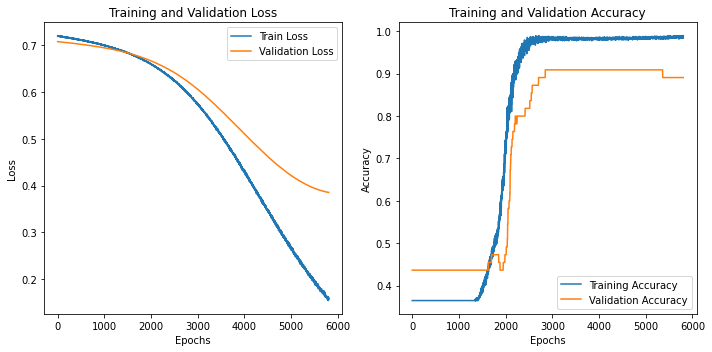

In [17]:
# Create a new figure for plotting
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
# Show the plots
plt.tight_layout()
plt.show()

### Convolutional Neural Networks - CNN

In [18]:
#!pip3 install torchtext

import pandas as pd
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
#Data prep and tokenization

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data['text'], data['label']

train_texts, train_labels = load_data(data_path())
val_texts, val_labels = load_data(data_path('validation'))
test_texts, test_labels = load_data(data_path('test'))

In [20]:
#tokenization
tokenizer = get_tokenizer('basic_english')

def tokenize_texts(texts):
    return [tokenizer(text) for text in texts]

tokenized_train_texts = tokenize_texts(train_texts)
tokenized_val_texts = tokenize_texts(val_texts)
tokenized_test_texts = tokenize_texts(test_texts)

In [21]:
#Build a vocabulary from tokenized texts
def build_vocab(tokenized_texts):
    counter = Counter()
    for text in tokenized_texts:
        counter.update(text)
    return Vocab(counter) #, min_freq=1)

vocab = build_vocab(tokenized_train_texts)
#You should not build a new vocabulary for your validation and test data. Instead, use the vocabulary built from your training data to ensure consistency.
# vocab_val = build_vocab(tokenized_val_texts)
# vocab_test = build_vocab(tokenized_test_texts)

In [22]:
def encode_texts(tokenized_texts, vocab):
    return [[vocab[word] for word in text] for text in tokenized_texts]

encoded_train_texts = encode_texts(tokenized_train_texts, vocab)
encoded_val_texts = encode_texts(tokenized_val_texts, vocab)
encoded_test_texts = encode_texts(tokenized_test_texts, vocab)

In [23]:
#Pad your encoded texts to ensure they all have the same length.
def pad_texts(encoded_texts, max_len):
    return [text + [0]*(max_len - len(text)) for text in encoded_texts]

max_len = max(map(len, encoded_train_texts))  # Determine max_len based on training data
padded_train_texts = pad_texts(encoded_train_texts, max_len)
padded_val_texts = pad_texts(encoded_val_texts, max_len)
padded_test_texts = pad_texts(encoded_test_texts, max_len)


Pad your validation and test texts. When padding your validation and test texts, it's important to pad them to the same `max_len` used for your training data to ensure consistency.

In [24]:
X_train_tensor = torch.tensor(padded_train_texts, dtype=torch.long)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.long)

X_val_tensor = torch.tensor(padded_val_texts, dtype=torch.long)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.long)

X_test_tensor = torch.tensor(padded_test_texts, dtype=torch.long)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.long)

In [25]:
# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim):
        super(CNN, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Convolutional Layers with different kernel sizes
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=5)
        
        # Layer Normalization
        self.ln = nn.LayerNorm(256 * 3)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 3, 512)  # Hidden Layer and times 3 because of 3 convolutional layers
        self.fc2 = nn.Linear(512, output_dim)  # Output Layer
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        # Convolutional layers with ReLU activation and dynamic pooling
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x3 = F.relu(self.conv3(x))
        
        # Combine max pooling and average pooling
        x1 = torch.cat((torch.max(x1, 2)[0], torch.mean(x1, 2)), 1)
        x2 = torch.cat((torch.max(x2, 2)[0], torch.mean(x2, 2)), 1)
        x3 = torch.cat((torch.max(x3, 2)[0], torch.mean(x3, 2)), 1)
        
        # Concatenate tensor along dimension 1
        x = torch.cat((x1, x2, x3), 1)
        
        # Layer normalization and dropout
        x = self.ln(x)
        x = self.dropout(x)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [27]:
# Instantiate the model
output_dim = 2
vocab_size = len(vocab)
embed_dim = 150  # Or use pre-trained embeddings
model = CNN(vocab_size, embed_dim, output_dim)

num_epochs= 250
optimizer = Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs=5, patience=3, min_delta=0):
    early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
    
    train_loss_values = []
    train_acc_values = []  # List to store training accuracy values
    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0  # Counter for correct predictions in training data
        total_train = 0    # Counter for total predictions in training data
        
        for X_batch, y_batch in tqdm(train_dataloader, desc=f"Training epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted_train = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted_train == y_batch).sum().item()
        
        train_loss_values.append(train_loss / len(train_dataloader))
        train_acc_values.append(correct_train / total_train)  # Compute and store training accuracy
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_dataloader, desc=f"Validating epoch {epoch + 1}"):
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item()
                
                _, predicted_val = torch.max(outputs, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted_val == y_batch).sum().item()
        
        val_loss_values.append(val_loss / len(val_dataloader))
        val_acc_values.append(correct_val / total_val)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_dataloader):.4f}, "
              f"Train Acc: {correct_train / total_train:.4f}, "
              f"Val Loss: {val_loss / len(val_dataloader):.4f}, Val Acc: {correct_val / total_val:.4f}")

        # Check for early stopping
        if early_stopper.early_stop(val_loss / len(val_dataloader)):
            print("Early stopping triggered!")
            break
            
    return train_loss_values, train_acc_values, val_loss_values, val_acc_values

In [29]:
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 1/250, Train Loss: 0.6185, Train Acc: 0.6069, Val Loss: 0.5063, Val Acc: 0.7818


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 2/250, Train Loss: 0.4920, Train Acc: 0.7658, Val Loss: 0.4377, Val Acc: 0.7818


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 3/250, Train Loss: 0.4295, Train Acc: 0.7984, Val Loss: 0.4021, Val Acc: 0.7636


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 4/250, Train Loss: 0.4083, Train Acc: 0.8045, Val Loss: 0.3810, Val Acc: 0.7818


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 5/250, Train Loss: 0.3658, Train Acc: 0.8310, Val Loss: 0.3680, Val Acc: 0.8182


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 6/250, Train Loss: 0.3217, Train Acc: 0.8778, Val Loss: 0.3362, Val Acc: 0.8364


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 7/250, Train Loss: 0.2857, Train Acc: 0.8859, Val Loss: 0.3216, Val Acc: 0.8545


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 8/250, Train Loss: 0.2322, Train Acc: 0.9389, Val Loss: 0.2891, Val Acc: 0.8727


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 9/250, Train Loss: 0.2058, Train Acc: 0.9470, Val Loss: 0.2705, Val Acc: 0.8727


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 10/250, Train Loss: 0.1726, Train Acc: 0.9511, Val Loss: 0.2530, Val Acc: 0.8727


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 11/250, Train Loss: 0.1371, Train Acc: 0.9735, Val Loss: 0.2279, Val Acc: 0.8909


Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 12/250, Train Loss: 0.1085, Train Acc: 0.9796, Val Loss: 0.2128, Val Acc: 0.9091


Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 13/250, Train Loss: 0.0892, Train Acc: 0.9837, Val Loss: 0.2235, Val Acc: 0.8909


Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 14/250, Train Loss: 0.0759, Train Acc: 0.9878, Val Loss: 0.1953, Val Acc: 0.9091


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 15/250, Train Loss: 0.0562, Train Acc: 0.9939, Val Loss: 0.1913, Val Acc: 0.9091


Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 16/250, Train Loss: 0.0428, Train Acc: 1.0000, Val Loss: 0.1878, Val Acc: 0.9091


Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 17/250, Train Loss: 0.0342, Train Acc: 1.0000, Val Loss: 0.1886, Val Acc: 0.9455


Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 18/250, Train Loss: 0.0288, Train Acc: 0.9980, Val Loss: 0.1749, Val Acc: 0.9273


Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 19/250, Train Loss: 0.0229, Train Acc: 1.0000, Val Loss: 0.1747, Val Acc: 0.9273


Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 20/250, Train Loss: 0.0188, Train Acc: 1.0000, Val Loss: 0.1707, Val Acc: 0.9273


Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 21/250, Train Loss: 0.0174, Train Acc: 1.0000, Val Loss: 0.1721, Val Acc: 0.9273


Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


Epoch 22/250, Train Loss: 0.0143, Train Acc: 1.0000, Val Loss: 0.1688, Val Acc: 0.9273


Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 23/250, Train Loss: 0.0122, Train Acc: 1.0000, Val Loss: 0.1699, Val Acc: 0.9273


Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 24/250, Train Loss: 0.0113, Train Acc: 1.0000, Val Loss: 0.1789, Val Acc: 0.9455


Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]

Epoch 25/250, Train Loss: 0.0096, Train Acc: 1.0000, Val Loss: 0.1783, Val Acc: 0.9273
Early stopping triggered!


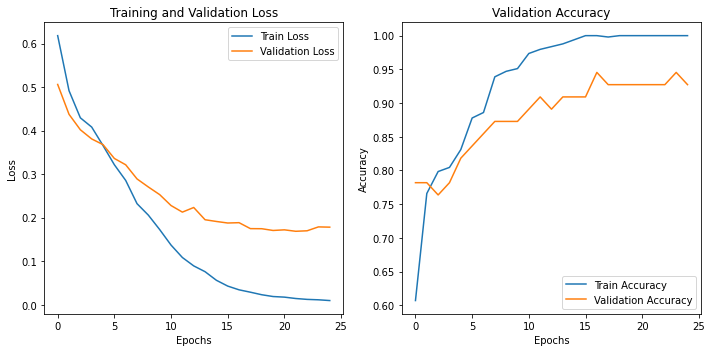

In [30]:
# Visualization
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [31]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/cnn/model_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!


In [32]:
def test_model(model, test_dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Do not compute gradients during evaluation
        for X_batch, y_batch in tqdm(test_dataloader, desc="Testing"):
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            _, predicted_test = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted_test == y_batch).sum().item()

    final_test_loss = test_loss / len(test_dataloader)
    final_test_accuracy = correct_test / total_test

    print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

    return final_test_loss, final_test_accuracy

# After training, you can call this function to evaluate the model on the test set:
test_loss, test_accuracy = test_model(model, test_dataloader, loss_fn)


Testing: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

Test Loss: 0.4348, Test Accuracy: 0.8534


### Fine-Tuning

In [33]:
# Instantiate the model
output_dim = 2
vocab_size = len(vocab)
embed_dim = 150 #100  # Or use pre-trained embeddings
model = CNN(vocab_size, embed_dim, output_dim)

num_epochs = 5000
optimizer = Adam(model.parameters(), lr=0.000001, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

patience = 3
min_delta = 0

In [34]:
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs, patience=patience, min_delta=min_delta)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 1/5000, Train Loss: 0.6973, Train Acc: 0.5540, Val Loss: 0.6914, Val Acc: 0.5636


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 2/5000, Train Loss: 0.6819, Train Acc: 0.5967, Val Loss: 0.6880, Val Acc: 0.5636


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 3/5000, Train Loss: 0.6745, Train Acc: 0.6090, Val Loss: 0.6848, Val Acc: 0.5636


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 4/5000, Train Loss: 0.6668, Train Acc: 0.6191, Val Loss: 0.6818, Val Acc: 0.5636


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 5/5000, Train Loss: 0.6717, Train Acc: 0.6110, Val Loss: 0.6789, Val Acc: 0.5636


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 6/5000, Train Loss: 0.6735, Train Acc: 0.6232, Val Loss: 0.6761, Val Acc: 0.5636


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 7/5000, Train Loss: 0.6627, Train Acc: 0.6232, Val Loss: 0.6733, Val Acc: 0.5636


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 8/5000, Train Loss: 0.6642, Train Acc: 0.6029, Val Loss: 0.6703, Val Acc: 0.5636


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 9/5000, Train Loss: 0.6522, Train Acc: 0.6273, Val Loss: 0.6675, Val Acc: 0.5636


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 10/5000, Train Loss: 0.6543, Train Acc: 0.6375, Val Loss: 0.6650, Val Acc: 0.5636


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 11/5000, Train Loss: 0.6496, Train Acc: 0.6375, Val Loss: 0.6619, Val Acc: 0.5636


Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 12/5000, Train Loss: 0.6563, Train Acc: 0.6273, Val Loss: 0.6591, Val Acc: 0.5636


Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 13/5000, Train Loss: 0.6539, Train Acc: 0.6436, Val Loss: 0.6561, Val Acc: 0.5636


Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 14/5000, Train Loss: 0.6483, Train Acc: 0.6456, Val Loss: 0.6532, Val Acc: 0.5636


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 15/5000, Train Loss: 0.6469, Train Acc: 0.6415, Val Loss: 0.6504, Val Acc: 0.5636


Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 16/5000, Train Loss: 0.6330, Train Acc: 0.6395, Val Loss: 0.6475, Val Acc: 0.5636


Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 17/5000, Train Loss: 0.6452, Train Acc: 0.6212, Val Loss: 0.6448, Val Acc: 0.5636


Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 18/5000, Train Loss: 0.6344, Train Acc: 0.6517, Val Loss: 0.6419, Val Acc: 0.5636


Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 19/5000, Train Loss: 0.6266, Train Acc: 0.6436, Val Loss: 0.6389, Val Acc: 0.5636


Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 20/5000, Train Loss: 0.6336, Train Acc: 0.6354, Val Loss: 0.6361, Val Acc: 0.5636


Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 21/5000, Train Loss: 0.6257, Train Acc: 0.6497, Val Loss: 0.6331, Val Acc: 0.5636


Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 22/5000, Train Loss: 0.6222, Train Acc: 0.6456, Val Loss: 0.6302, Val Acc: 0.5636


Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 23/5000, Train Loss: 0.6214, Train Acc: 0.6497, Val Loss: 0.6275, Val Acc: 0.5636


Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 24/5000, Train Loss: 0.6182, Train Acc: 0.6517, Val Loss: 0.6249, Val Acc: 0.5636


Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 25/5000, Train Loss: 0.6202, Train Acc: 0.6477, Val Loss: 0.6218, Val Acc: 0.5636


Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 26/5000, Train Loss: 0.6240, Train Acc: 0.6497, Val Loss: 0.6194, Val Acc: 0.5636


Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 27/5000, Train Loss: 0.6070, Train Acc: 0.6578, Val Loss: 0.6168, Val Acc: 0.5636


Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 28/5000, Train Loss: 0.6107, Train Acc: 0.6415, Val Loss: 0.6142, Val Acc: 0.5636


Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 29/5000, Train Loss: 0.6117, Train Acc: 0.6477, Val Loss: 0.6115, Val Acc: 0.5636


Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 30/5000, Train Loss: 0.6058, Train Acc: 0.6538, Val Loss: 0.6091, Val Acc: 0.5636


Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 31/5000, Train Loss: 0.6076, Train Acc: 0.6558, Val Loss: 0.6064, Val Acc: 0.5636


Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 32/5000, Train Loss: 0.6048, Train Acc: 0.6538, Val Loss: 0.6040, Val Acc: 0.5636


Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 33/5000, Train Loss: 0.5957, Train Acc: 0.6640, Val Loss: 0.6018, Val Acc: 0.5636


Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 34/5000, Train Loss: 0.5989, Train Acc: 0.6599, Val Loss: 0.5995, Val Acc: 0.5636


Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 35/5000, Train Loss: 0.6117, Train Acc: 0.6538, Val Loss: 0.5974, Val Acc: 0.5636


Validating epoch 36: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 36/5000, Train Loss: 0.5916, Train Acc: 0.6599, Val Loss: 0.5950, Val Acc: 0.5818


Validating epoch 37: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 37/5000, Train Loss: 0.5976, Train Acc: 0.6538, Val Loss: 0.5925, Val Acc: 0.5818


Validating epoch 38: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 38/5000, Train Loss: 0.5893, Train Acc: 0.6721, Val Loss: 0.5901, Val Acc: 0.6000


Validating epoch 39: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 39/5000, Train Loss: 0.5845, Train Acc: 0.6762, Val Loss: 0.5881, Val Acc: 0.6182


Validating epoch 40: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 40/5000, Train Loss: 0.5877, Train Acc: 0.6640, Val Loss: 0.5858, Val Acc: 0.6364


Validating epoch 41: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 41/5000, Train Loss: 0.5880, Train Acc: 0.6497, Val Loss: 0.5836, Val Acc: 0.6545


Validating epoch 42: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 42/5000, Train Loss: 0.5820, Train Acc: 0.6782, Val Loss: 0.5815, Val Acc: 0.6545


Validating epoch 43: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 43/5000, Train Loss: 0.5853, Train Acc: 0.6578, Val Loss: 0.5791, Val Acc: 0.6545


Validating epoch 44: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 44/5000, Train Loss: 0.5850, Train Acc: 0.6558, Val Loss: 0.5771, Val Acc: 0.6545


Validating epoch 45: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 45/5000, Train Loss: 0.5805, Train Acc: 0.6640, Val Loss: 0.5748, Val Acc: 0.6545


Validating epoch 46: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 46/5000, Train Loss: 0.5757, Train Acc: 0.6680, Val Loss: 0.5724, Val Acc: 0.6545


Validating epoch 47: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 47/5000, Train Loss: 0.5749, Train Acc: 0.6965, Val Loss: 0.5703, Val Acc: 0.6545


Validating epoch 48: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 48/5000, Train Loss: 0.5785, Train Acc: 0.6741, Val Loss: 0.5682, Val Acc: 0.6727


Validating epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 49/5000, Train Loss: 0.5758, Train Acc: 0.6925, Val Loss: 0.5659, Val Acc: 0.6727


Validating epoch 50: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 50/5000, Train Loss: 0.5746, Train Acc: 0.6741, Val Loss: 0.5637, Val Acc: 0.6727


Validating epoch 51: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 51/5000, Train Loss: 0.5674, Train Acc: 0.6884, Val Loss: 0.5618, Val Acc: 0.6727


Validating epoch 52: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 52/5000, Train Loss: 0.5750, Train Acc: 0.6904, Val Loss: 0.5598, Val Acc: 0.7091


Validating epoch 53: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 53/5000, Train Loss: 0.5665, Train Acc: 0.7128, Val Loss: 0.5581, Val Acc: 0.7091


Validating epoch 54: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 54/5000, Train Loss: 0.5631, Train Acc: 0.6782, Val Loss: 0.5559, Val Acc: 0.7091


Validating epoch 55: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 55/5000, Train Loss: 0.5652, Train Acc: 0.6925, Val Loss: 0.5538, Val Acc: 0.7091


Validating epoch 56: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 56/5000, Train Loss: 0.5670, Train Acc: 0.7047, Val Loss: 0.5519, Val Acc: 0.7091


Validating epoch 57: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 57/5000, Train Loss: 0.5509, Train Acc: 0.7067, Val Loss: 0.5500, Val Acc: 0.7091


Validating epoch 58: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 58/5000, Train Loss: 0.5622, Train Acc: 0.6864, Val Loss: 0.5482, Val Acc: 0.7091


Validating epoch 59: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 59/5000, Train Loss: 0.5614, Train Acc: 0.7006, Val Loss: 0.5465, Val Acc: 0.7091


Validating epoch 60: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 60/5000, Train Loss: 0.5595, Train Acc: 0.7088, Val Loss: 0.5447, Val Acc: 0.7091


Validating epoch 61: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 61/5000, Train Loss: 0.5597, Train Acc: 0.7189, Val Loss: 0.5428, Val Acc: 0.7091


Validating epoch 62: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 62/5000, Train Loss: 0.5515, Train Acc: 0.7128, Val Loss: 0.5409, Val Acc: 0.6909


Validating epoch 63: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 63/5000, Train Loss: 0.5505, Train Acc: 0.7047, Val Loss: 0.5394, Val Acc: 0.6909


Validating epoch 64: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 64/5000, Train Loss: 0.5558, Train Acc: 0.7108, Val Loss: 0.5378, Val Acc: 0.6909


Validating epoch 65: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 65/5000, Train Loss: 0.5490, Train Acc: 0.6986, Val Loss: 0.5362, Val Acc: 0.6727


Validating epoch 66: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 66/5000, Train Loss: 0.5464, Train Acc: 0.7373, Val Loss: 0.5343, Val Acc: 0.7273


Validating epoch 67: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 67/5000, Train Loss: 0.5494, Train Acc: 0.7088, Val Loss: 0.5324, Val Acc: 0.7091


Validating epoch 68: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 68/5000, Train Loss: 0.5508, Train Acc: 0.7291, Val Loss: 0.5309, Val Acc: 0.7091


Validating epoch 69: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 69/5000, Train Loss: 0.5465, Train Acc: 0.7189, Val Loss: 0.5293, Val Acc: 0.7091


Validating epoch 70: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 70/5000, Train Loss: 0.5454, Train Acc: 0.7189, Val Loss: 0.5279, Val Acc: 0.7091


Validating epoch 71: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 71/5000, Train Loss: 0.5506, Train Acc: 0.7210, Val Loss: 0.5263, Val Acc: 0.7091


Validating epoch 72: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 72/5000, Train Loss: 0.5402, Train Acc: 0.7312, Val Loss: 0.5245, Val Acc: 0.7273


Validating epoch 73: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 73/5000, Train Loss: 0.5433, Train Acc: 0.7230, Val Loss: 0.5227, Val Acc: 0.7455


Validating epoch 74: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 74/5000, Train Loss: 0.5414, Train Acc: 0.7312, Val Loss: 0.5211, Val Acc: 0.7455


Validating epoch 75: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 75/5000, Train Loss: 0.5327, Train Acc: 0.7373, Val Loss: 0.5197, Val Acc: 0.7455


Validating epoch 76: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 76/5000, Train Loss: 0.5404, Train Acc: 0.7332, Val Loss: 0.5182, Val Acc: 0.7455


Validating epoch 77: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 77/5000, Train Loss: 0.5396, Train Acc: 0.7454, Val Loss: 0.5165, Val Acc: 0.7273


Validating epoch 78: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 78/5000, Train Loss: 0.5400, Train Acc: 0.7413, Val Loss: 0.5149, Val Acc: 0.7273


Validating epoch 79: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 79/5000, Train Loss: 0.5339, Train Acc: 0.7352, Val Loss: 0.5134, Val Acc: 0.7273


Validating epoch 80: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 80/5000, Train Loss: 0.5333, Train Acc: 0.7373, Val Loss: 0.5119, Val Acc: 0.7273


Validating epoch 81: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 81/5000, Train Loss: 0.5242, Train Acc: 0.7576, Val Loss: 0.5104, Val Acc: 0.7273


Validating epoch 82: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 82/5000, Train Loss: 0.5346, Train Acc: 0.7352, Val Loss: 0.5093, Val Acc: 0.7273


Validating epoch 83: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


Epoch 83/5000, Train Loss: 0.5223, Train Acc: 0.7576, Val Loss: 0.5078, Val Acc: 0.7455


Validating epoch 84: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 84/5000, Train Loss: 0.5164, Train Acc: 0.7637, Val Loss: 0.5064, Val Acc: 0.7455


Validating epoch 85: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 85/5000, Train Loss: 0.5312, Train Acc: 0.7413, Val Loss: 0.5051, Val Acc: 0.7455


Validating epoch 86: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 86/5000, Train Loss: 0.5327, Train Acc: 0.7556, Val Loss: 0.5039, Val Acc: 0.7455


Validating epoch 87: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 87/5000, Train Loss: 0.5156, Train Acc: 0.7556, Val Loss: 0.5022, Val Acc: 0.7455


Validating epoch 88: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 88/5000, Train Loss: 0.5176, Train Acc: 0.7617, Val Loss: 0.5009, Val Acc: 0.7455


Validating epoch 89: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 89/5000, Train Loss: 0.5174, Train Acc: 0.7515, Val Loss: 0.4996, Val Acc: 0.7455


Validating epoch 90: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 90/5000, Train Loss: 0.5256, Train Acc: 0.7251, Val Loss: 0.4984, Val Acc: 0.7455


Validating epoch 91: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 91/5000, Train Loss: 0.5180, Train Acc: 0.7597, Val Loss: 0.4970, Val Acc: 0.7455


Validating epoch 92: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 92/5000, Train Loss: 0.5156, Train Acc: 0.7699, Val Loss: 0.4956, Val Acc: 0.7455


Validating epoch 93: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 93/5000, Train Loss: 0.5094, Train Acc: 0.7637, Val Loss: 0.4944, Val Acc: 0.7455


Validating epoch 94: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 94/5000, Train Loss: 0.5164, Train Acc: 0.7576, Val Loss: 0.4934, Val Acc: 0.7455


Validating epoch 95: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 95/5000, Train Loss: 0.5208, Train Acc: 0.7373, Val Loss: 0.4923, Val Acc: 0.7455


Validating epoch 96: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 96/5000, Train Loss: 0.5093, Train Acc: 0.7658, Val Loss: 0.4911, Val Acc: 0.7636


Validating epoch 97: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 97/5000, Train Loss: 0.5123, Train Acc: 0.7678, Val Loss: 0.4901, Val Acc: 0.7636


Validating epoch 98: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 98/5000, Train Loss: 0.5133, Train Acc: 0.7597, Val Loss: 0.4890, Val Acc: 0.7636


Validating epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 99/5000, Train Loss: 0.5130, Train Acc: 0.7678, Val Loss: 0.4877, Val Acc: 0.7455


Validating epoch 100: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 100/5000, Train Loss: 0.5123, Train Acc: 0.7495, Val Loss: 0.4866, Val Acc: 0.7455


Validating epoch 101: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 101/5000, Train Loss: 0.5108, Train Acc: 0.7678, Val Loss: 0.4856, Val Acc: 0.7455


Validating epoch 102: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch 102/5000, Train Loss: 0.4964, Train Acc: 0.7739, Val Loss: 0.4844, Val Acc: 0.7455


Validating epoch 103: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 103/5000, Train Loss: 0.5093, Train Acc: 0.7678, Val Loss: 0.4831, Val Acc: 0.7636


Validating epoch 104: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 104/5000, Train Loss: 0.4981, Train Acc: 0.7760, Val Loss: 0.4820, Val Acc: 0.7818


Validating epoch 105: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 105/5000, Train Loss: 0.5073, Train Acc: 0.7678, Val Loss: 0.4808, Val Acc: 0.7818


Validating epoch 106: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 106/5000, Train Loss: 0.5004, Train Acc: 0.7780, Val Loss: 0.4797, Val Acc: 0.7818


Validating epoch 107: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 107/5000, Train Loss: 0.4976, Train Acc: 0.7719, Val Loss: 0.4786, Val Acc: 0.7818


Validating epoch 108: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 108/5000, Train Loss: 0.4972, Train Acc: 0.7556, Val Loss: 0.4774, Val Acc: 0.7818


Validating epoch 109: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 109/5000, Train Loss: 0.4999, Train Acc: 0.7780, Val Loss: 0.4765, Val Acc: 0.7818


Validating epoch 110: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 110/5000, Train Loss: 0.5066, Train Acc: 0.7515, Val Loss: 0.4756, Val Acc: 0.7818


Validating epoch 111: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 111/5000, Train Loss: 0.4969, Train Acc: 0.7800, Val Loss: 0.4746, Val Acc: 0.7818


Validating epoch 112: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 112/5000, Train Loss: 0.5024, Train Acc: 0.7739, Val Loss: 0.4736, Val Acc: 0.7818


Validating epoch 113: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 113/5000, Train Loss: 0.5002, Train Acc: 0.7699, Val Loss: 0.4728, Val Acc: 0.7818


Validating epoch 114: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 114/5000, Train Loss: 0.4971, Train Acc: 0.7882, Val Loss: 0.4716, Val Acc: 0.7818


Validating epoch 115: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 115/5000, Train Loss: 0.4913, Train Acc: 0.7923, Val Loss: 0.4705, Val Acc: 0.7818


Validating epoch 116: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 116/5000, Train Loss: 0.4945, Train Acc: 0.7882, Val Loss: 0.4696, Val Acc: 0.7636


Validating epoch 117: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 117/5000, Train Loss: 0.4986, Train Acc: 0.7902, Val Loss: 0.4685, Val Acc: 0.7636


Validating epoch 118: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 118/5000, Train Loss: 0.4960, Train Acc: 0.7800, Val Loss: 0.4676, Val Acc: 0.7636


Validating epoch 119: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 119/5000, Train Loss: 0.4911, Train Acc: 0.7943, Val Loss: 0.4666, Val Acc: 0.7636


Validating epoch 120: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 120/5000, Train Loss: 0.4952, Train Acc: 0.7678, Val Loss: 0.4657, Val Acc: 0.7636


Validating epoch 121: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 121/5000, Train Loss: 0.4812, Train Acc: 0.7963, Val Loss: 0.4649, Val Acc: 0.7636


Validating epoch 122: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 122/5000, Train Loss: 0.4964, Train Acc: 0.7780, Val Loss: 0.4641, Val Acc: 0.7636


Validating epoch 123: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 123/5000, Train Loss: 0.4928, Train Acc: 0.7739, Val Loss: 0.4632, Val Acc: 0.7636


Validating epoch 124: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 124/5000, Train Loss: 0.4881, Train Acc: 0.7658, Val Loss: 0.4623, Val Acc: 0.7636


Validating epoch 125: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 125/5000, Train Loss: 0.4901, Train Acc: 0.7637, Val Loss: 0.4615, Val Acc: 0.7636


Validating epoch 126: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 126/5000, Train Loss: 0.4857, Train Acc: 0.7678, Val Loss: 0.4607, Val Acc: 0.7636


Validating epoch 127: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 127/5000, Train Loss: 0.4853, Train Acc: 0.7841, Val Loss: 0.4598, Val Acc: 0.7636


Validating epoch 128: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 128/5000, Train Loss: 0.4813, Train Acc: 0.7800, Val Loss: 0.4589, Val Acc: 0.7636


Validating epoch 129: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 129/5000, Train Loss: 0.4801, Train Acc: 0.7780, Val Loss: 0.4580, Val Acc: 0.7636


Validating epoch 130: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 130/5000, Train Loss: 0.4803, Train Acc: 0.7841, Val Loss: 0.4572, Val Acc: 0.7636


Validating epoch 131: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 131/5000, Train Loss: 0.4765, Train Acc: 0.7882, Val Loss: 0.4564, Val Acc: 0.7636


Validating epoch 132: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 132/5000, Train Loss: 0.4850, Train Acc: 0.7862, Val Loss: 0.4556, Val Acc: 0.7636


Validating epoch 133: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 133/5000, Train Loss: 0.4788, Train Acc: 0.7739, Val Loss: 0.4549, Val Acc: 0.7636


Validating epoch 134: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 134/5000, Train Loss: 0.4834, Train Acc: 0.7841, Val Loss: 0.4540, Val Acc: 0.7636


Validating epoch 135: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 135/5000, Train Loss: 0.4770, Train Acc: 0.7841, Val Loss: 0.4532, Val Acc: 0.7636


Validating epoch 136: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 136/5000, Train Loss: 0.4632, Train Acc: 0.7963, Val Loss: 0.4524, Val Acc: 0.7636


Validating epoch 137: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 137/5000, Train Loss: 0.4810, Train Acc: 0.7760, Val Loss: 0.4517, Val Acc: 0.7636


Validating epoch 138: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


Epoch 138/5000, Train Loss: 0.4816, Train Acc: 0.7780, Val Loss: 0.4509, Val Acc: 0.7636


Validating epoch 139: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 139/5000, Train Loss: 0.4769, Train Acc: 0.7882, Val Loss: 0.4502, Val Acc: 0.7636


Validating epoch 140: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 140/5000, Train Loss: 0.4738, Train Acc: 0.7882, Val Loss: 0.4494, Val Acc: 0.7636


Validating epoch 141: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 141/5000, Train Loss: 0.4740, Train Acc: 0.7984, Val Loss: 0.4487, Val Acc: 0.7636


Validating epoch 142: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 142/5000, Train Loss: 0.4779, Train Acc: 0.7760, Val Loss: 0.4478, Val Acc: 0.7636


Validating epoch 143: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 143/5000, Train Loss: 0.4692, Train Acc: 0.7923, Val Loss: 0.4471, Val Acc: 0.7636


Validating epoch 144: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 144/5000, Train Loss: 0.4776, Train Acc: 0.7841, Val Loss: 0.4465, Val Acc: 0.7636


Validating epoch 145: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 145/5000, Train Loss: 0.4671, Train Acc: 0.7841, Val Loss: 0.4458, Val Acc: 0.7636


Validating epoch 146: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 146/5000, Train Loss: 0.4719, Train Acc: 0.7882, Val Loss: 0.4450, Val Acc: 0.7636


Validating epoch 147: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 147/5000, Train Loss: 0.4732, Train Acc: 0.7800, Val Loss: 0.4443, Val Acc: 0.7636


Validating epoch 148: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 148/5000, Train Loss: 0.4698, Train Acc: 0.7862, Val Loss: 0.4434, Val Acc: 0.7636


Validating epoch 149: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 149/5000, Train Loss: 0.4707, Train Acc: 0.7862, Val Loss: 0.4428, Val Acc: 0.7636


Validating epoch 150: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 150/5000, Train Loss: 0.4597, Train Acc: 0.8106, Val Loss: 0.4421, Val Acc: 0.7636


Validating epoch 151: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 151/5000, Train Loss: 0.4674, Train Acc: 0.8004, Val Loss: 0.4413, Val Acc: 0.7636


Validating epoch 152: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 152/5000, Train Loss: 0.4659, Train Acc: 0.7963, Val Loss: 0.4407, Val Acc: 0.7636


Validating epoch 153: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 153/5000, Train Loss: 0.4622, Train Acc: 0.7923, Val Loss: 0.4401, Val Acc: 0.7636


Validating epoch 154: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Epoch 154/5000, Train Loss: 0.4734, Train Acc: 0.7862, Val Loss: 0.4393, Val Acc: 0.7636


Validating epoch 155: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 155/5000, Train Loss: 0.4607, Train Acc: 0.7963, Val Loss: 0.4387, Val Acc: 0.7636


Validating epoch 156: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 156/5000, Train Loss: 0.4585, Train Acc: 0.7984, Val Loss: 0.4380, Val Acc: 0.7636


Validating epoch 157: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 157/5000, Train Loss: 0.4585, Train Acc: 0.7821, Val Loss: 0.4374, Val Acc: 0.7636


Validating epoch 158: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 158/5000, Train Loss: 0.4579, Train Acc: 0.8126, Val Loss: 0.4367, Val Acc: 0.7636


Validating epoch 159: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 159/5000, Train Loss: 0.4527, Train Acc: 0.7862, Val Loss: 0.4361, Val Acc: 0.7636


Validating epoch 160: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 160/5000, Train Loss: 0.4593, Train Acc: 0.7923, Val Loss: 0.4355, Val Acc: 0.7636


Validating epoch 161: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 161/5000, Train Loss: 0.4587, Train Acc: 0.7943, Val Loss: 0.4349, Val Acc: 0.7636


Validating epoch 162: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 162/5000, Train Loss: 0.4565, Train Acc: 0.7862, Val Loss: 0.4342, Val Acc: 0.7636


Validating epoch 163: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 163/5000, Train Loss: 0.4564, Train Acc: 0.7821, Val Loss: 0.4335, Val Acc: 0.7636


Validating epoch 164: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 164/5000, Train Loss: 0.4632, Train Acc: 0.7984, Val Loss: 0.4328, Val Acc: 0.7636


Validating epoch 165: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 165/5000, Train Loss: 0.4502, Train Acc: 0.8004, Val Loss: 0.4323, Val Acc: 0.7636


Validating epoch 166: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 166/5000, Train Loss: 0.4535, Train Acc: 0.7800, Val Loss: 0.4317, Val Acc: 0.7636


Validating epoch 167: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 167/5000, Train Loss: 0.4601, Train Acc: 0.7923, Val Loss: 0.4311, Val Acc: 0.7636


Validating epoch 168: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 168/5000, Train Loss: 0.4562, Train Acc: 0.7963, Val Loss: 0.4303, Val Acc: 0.7636


Validating epoch 169: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 169/5000, Train Loss: 0.4482, Train Acc: 0.8106, Val Loss: 0.4296, Val Acc: 0.7636


Validating epoch 170: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 170/5000, Train Loss: 0.4610, Train Acc: 0.7963, Val Loss: 0.4292, Val Acc: 0.7636


Validating epoch 171: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 171/5000, Train Loss: 0.4585, Train Acc: 0.7984, Val Loss: 0.4285, Val Acc: 0.7636


Validating epoch 172: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 172/5000, Train Loss: 0.4542, Train Acc: 0.7943, Val Loss: 0.4280, Val Acc: 0.7636


Validating epoch 173: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 173/5000, Train Loss: 0.4580, Train Acc: 0.7841, Val Loss: 0.4274, Val Acc: 0.7636


Validating epoch 174: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 174/5000, Train Loss: 0.4544, Train Acc: 0.7963, Val Loss: 0.4268, Val Acc: 0.7636


Validating epoch 175: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 175/5000, Train Loss: 0.4506, Train Acc: 0.7862, Val Loss: 0.4262, Val Acc: 0.7636


Validating epoch 176: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 176/5000, Train Loss: 0.4521, Train Acc: 0.8065, Val Loss: 0.4256, Val Acc: 0.7636


Validating epoch 177: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 177/5000, Train Loss: 0.4512, Train Acc: 0.7963, Val Loss: 0.4249, Val Acc: 0.7818


Validating epoch 178: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 178/5000, Train Loss: 0.4451, Train Acc: 0.7943, Val Loss: 0.4242, Val Acc: 0.7818


Validating epoch 179: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 179/5000, Train Loss: 0.4450, Train Acc: 0.7943, Val Loss: 0.4236, Val Acc: 0.7818


Validating epoch 180: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 180/5000, Train Loss: 0.4375, Train Acc: 0.8106, Val Loss: 0.4231, Val Acc: 0.7818


Validating epoch 181: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 181/5000, Train Loss: 0.4400, Train Acc: 0.8045, Val Loss: 0.4227, Val Acc: 0.7818


Validating epoch 182: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 182/5000, Train Loss: 0.4401, Train Acc: 0.7882, Val Loss: 0.4220, Val Acc: 0.7818


Validating epoch 183: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 183/5000, Train Loss: 0.4441, Train Acc: 0.7882, Val Loss: 0.4213, Val Acc: 0.7818


Validating epoch 184: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 184/5000, Train Loss: 0.4479, Train Acc: 0.8004, Val Loss: 0.4208, Val Acc: 0.7818


Validating epoch 185: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 185/5000, Train Loss: 0.4422, Train Acc: 0.8126, Val Loss: 0.4202, Val Acc: 0.7818


Validating epoch 186: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 186/5000, Train Loss: 0.4429, Train Acc: 0.8106, Val Loss: 0.4196, Val Acc: 0.7818


Validating epoch 187: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 187/5000, Train Loss: 0.4408, Train Acc: 0.8024, Val Loss: 0.4192, Val Acc: 0.7818


Validating epoch 188: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 188/5000, Train Loss: 0.4434, Train Acc: 0.8228, Val Loss: 0.4187, Val Acc: 0.7818


Validating epoch 189: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 189/5000, Train Loss: 0.4363, Train Acc: 0.8065, Val Loss: 0.4181, Val Acc: 0.7818


Validating epoch 190: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 190/5000, Train Loss: 0.4461, Train Acc: 0.7943, Val Loss: 0.4175, Val Acc: 0.7818


Validating epoch 191: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 191/5000, Train Loss: 0.4416, Train Acc: 0.8167, Val Loss: 0.4169, Val Acc: 0.7818


Validating epoch 192: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 192/5000, Train Loss: 0.4456, Train Acc: 0.7821, Val Loss: 0.4164, Val Acc: 0.7818


Validating epoch 193: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 193/5000, Train Loss: 0.4469, Train Acc: 0.7943, Val Loss: 0.4158, Val Acc: 0.7818


Validating epoch 194: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 194/5000, Train Loss: 0.4380, Train Acc: 0.7882, Val Loss: 0.4153, Val Acc: 0.7818


Validating epoch 195: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 195/5000, Train Loss: 0.4308, Train Acc: 0.8126, Val Loss: 0.4148, Val Acc: 0.7818


Validating epoch 196: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 196/5000, Train Loss: 0.4377, Train Acc: 0.8024, Val Loss: 0.4143, Val Acc: 0.7818


Validating epoch 197: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 197/5000, Train Loss: 0.4424, Train Acc: 0.8045, Val Loss: 0.4138, Val Acc: 0.7818


Validating epoch 198: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 198/5000, Train Loss: 0.4294, Train Acc: 0.8208, Val Loss: 0.4134, Val Acc: 0.7818


Validating epoch 199: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 199/5000, Train Loss: 0.4240, Train Acc: 0.8126, Val Loss: 0.4128, Val Acc: 0.7818


Validating epoch 200: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 200/5000, Train Loss: 0.4312, Train Acc: 0.8065, Val Loss: 0.4123, Val Acc: 0.7818


Validating epoch 201: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 201/5000, Train Loss: 0.4324, Train Acc: 0.8126, Val Loss: 0.4118, Val Acc: 0.7818


Validating epoch 202: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 202/5000, Train Loss: 0.4318, Train Acc: 0.8147, Val Loss: 0.4112, Val Acc: 0.7818


Validating epoch 203: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 203/5000, Train Loss: 0.4304, Train Acc: 0.8248, Val Loss: 0.4107, Val Acc: 0.7818


Validating epoch 204: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 204/5000, Train Loss: 0.4281, Train Acc: 0.8167, Val Loss: 0.4101, Val Acc: 0.7818


Validating epoch 205: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 205/5000, Train Loss: 0.4302, Train Acc: 0.8106, Val Loss: 0.4096, Val Acc: 0.7818


Validating epoch 206: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 206/5000, Train Loss: 0.4288, Train Acc: 0.8106, Val Loss: 0.4092, Val Acc: 0.7818


Validating epoch 207: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 207/5000, Train Loss: 0.4304, Train Acc: 0.8065, Val Loss: 0.4086, Val Acc: 0.7818


Validating epoch 208: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 208/5000, Train Loss: 0.4219, Train Acc: 0.8330, Val Loss: 0.4082, Val Acc: 0.7818


Validating epoch 209: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]


Epoch 209/5000, Train Loss: 0.4160, Train Acc: 0.8126, Val Loss: 0.4078, Val Acc: 0.7818


Validating epoch 210: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Epoch 210/5000, Train Loss: 0.4236, Train Acc: 0.8106, Val Loss: 0.4073, Val Acc: 0.7818


Validating epoch 211: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 211/5000, Train Loss: 0.4244, Train Acc: 0.8371, Val Loss: 0.4068, Val Acc: 0.7818


Validating epoch 212: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 212/5000, Train Loss: 0.4274, Train Acc: 0.8004, Val Loss: 0.4063, Val Acc: 0.7818


Validating epoch 213: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 213/5000, Train Loss: 0.4187, Train Acc: 0.8187, Val Loss: 0.4059, Val Acc: 0.7818


Validating epoch 214: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 214/5000, Train Loss: 0.4278, Train Acc: 0.8045, Val Loss: 0.4053, Val Acc: 0.7818


Validating epoch 215: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 215/5000, Train Loss: 0.4216, Train Acc: 0.8248, Val Loss: 0.4048, Val Acc: 0.7818


Validating epoch 216: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 216/5000, Train Loss: 0.4257, Train Acc: 0.8248, Val Loss: 0.4043, Val Acc: 0.7818


Validating epoch 217: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 217/5000, Train Loss: 0.4342, Train Acc: 0.8126, Val Loss: 0.4038, Val Acc: 0.7818


Validating epoch 218: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 218/5000, Train Loss: 0.4213, Train Acc: 0.8228, Val Loss: 0.4033, Val Acc: 0.7818


Validating epoch 219: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 219/5000, Train Loss: 0.4140, Train Acc: 0.8310, Val Loss: 0.4028, Val Acc: 0.7818


Validating epoch 220: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 220/5000, Train Loss: 0.4162, Train Acc: 0.8228, Val Loss: 0.4023, Val Acc: 0.7818


Validating epoch 221: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 221/5000, Train Loss: 0.4150, Train Acc: 0.8167, Val Loss: 0.4019, Val Acc: 0.7818


Validating epoch 222: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 222/5000, Train Loss: 0.4173, Train Acc: 0.8350, Val Loss: 0.4015, Val Acc: 0.7818


Validating epoch 223: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 223/5000, Train Loss: 0.4148, Train Acc: 0.8310, Val Loss: 0.4011, Val Acc: 0.7818


Validating epoch 224: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 224/5000, Train Loss: 0.4153, Train Acc: 0.8187, Val Loss: 0.4006, Val Acc: 0.7818


Validating epoch 225: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 225/5000, Train Loss: 0.4149, Train Acc: 0.8391, Val Loss: 0.4002, Val Acc: 0.7818


Validating epoch 226: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 226/5000, Train Loss: 0.4228, Train Acc: 0.8350, Val Loss: 0.3997, Val Acc: 0.7818


Validating epoch 227: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 227/5000, Train Loss: 0.4193, Train Acc: 0.8106, Val Loss: 0.3992, Val Acc: 0.7818


Validating epoch 228: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 228/5000, Train Loss: 0.4177, Train Acc: 0.8208, Val Loss: 0.3988, Val Acc: 0.7818


Validating epoch 229: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 229/5000, Train Loss: 0.4195, Train Acc: 0.8147, Val Loss: 0.3983, Val Acc: 0.7818


Validating epoch 230: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 230/5000, Train Loss: 0.4135, Train Acc: 0.8147, Val Loss: 0.3977, Val Acc: 0.7818


Validating epoch 231: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 231/5000, Train Loss: 0.4171, Train Acc: 0.8147, Val Loss: 0.3973, Val Acc: 0.7818


Validating epoch 232: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 232/5000, Train Loss: 0.4141, Train Acc: 0.8167, Val Loss: 0.3968, Val Acc: 0.7818


Validating epoch 233: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 233/5000, Train Loss: 0.4245, Train Acc: 0.8065, Val Loss: 0.3964, Val Acc: 0.7818


Validating epoch 234: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 234/5000, Train Loss: 0.4072, Train Acc: 0.8310, Val Loss: 0.3960, Val Acc: 0.7818


Validating epoch 235: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 235/5000, Train Loss: 0.4140, Train Acc: 0.8208, Val Loss: 0.3955, Val Acc: 0.7818


Validating epoch 236: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 236/5000, Train Loss: 0.4065, Train Acc: 0.8208, Val Loss: 0.3950, Val Acc: 0.7818


Validating epoch 237: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 237/5000, Train Loss: 0.4089, Train Acc: 0.8289, Val Loss: 0.3946, Val Acc: 0.7818


Validating epoch 238: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 238/5000, Train Loss: 0.4147, Train Acc: 0.8269, Val Loss: 0.3942, Val Acc: 0.7818


Validating epoch 239: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 239/5000, Train Loss: 0.4050, Train Acc: 0.8289, Val Loss: 0.3937, Val Acc: 0.7818


Validating epoch 240: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 240/5000, Train Loss: 0.4064, Train Acc: 0.8289, Val Loss: 0.3933, Val Acc: 0.7818


Validating epoch 241: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 241/5000, Train Loss: 0.4177, Train Acc: 0.8167, Val Loss: 0.3929, Val Acc: 0.7818


Validating epoch 242: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 242/5000, Train Loss: 0.4137, Train Acc: 0.8248, Val Loss: 0.3923, Val Acc: 0.7818


Validating epoch 243: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 243/5000, Train Loss: 0.4110, Train Acc: 0.8371, Val Loss: 0.3918, Val Acc: 0.7818


Validating epoch 244: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 244/5000, Train Loss: 0.4042, Train Acc: 0.8208, Val Loss: 0.3913, Val Acc: 0.7818


Validating epoch 245: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 245/5000, Train Loss: 0.4017, Train Acc: 0.8269, Val Loss: 0.3909, Val Acc: 0.7818


Validating epoch 246: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 246/5000, Train Loss: 0.4116, Train Acc: 0.8310, Val Loss: 0.3905, Val Acc: 0.7818


Validating epoch 247: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 247/5000, Train Loss: 0.4071, Train Acc: 0.8269, Val Loss: 0.3900, Val Acc: 0.7818


Validating epoch 248: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 248/5000, Train Loss: 0.4000, Train Acc: 0.8391, Val Loss: 0.3895, Val Acc: 0.7818


Validating epoch 249: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 249/5000, Train Loss: 0.4049, Train Acc: 0.8269, Val Loss: 0.3891, Val Acc: 0.7818


Validating epoch 250: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 250/5000, Train Loss: 0.4060, Train Acc: 0.8147, Val Loss: 0.3886, Val Acc: 0.7818


Validating epoch 251: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 251/5000, Train Loss: 0.4115, Train Acc: 0.8310, Val Loss: 0.3883, Val Acc: 0.7818


Validating epoch 252: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 252/5000, Train Loss: 0.3983, Train Acc: 0.8269, Val Loss: 0.3879, Val Acc: 0.7818


Validating epoch 253: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 253/5000, Train Loss: 0.3904, Train Acc: 0.8432, Val Loss: 0.3873, Val Acc: 0.7818


Validating epoch 254: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 254/5000, Train Loss: 0.4032, Train Acc: 0.8248, Val Loss: 0.3869, Val Acc: 0.7818


Validating epoch 255: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 255/5000, Train Loss: 0.3980, Train Acc: 0.8269, Val Loss: 0.3865, Val Acc: 0.7818


Validating epoch 256: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 256/5000, Train Loss: 0.3956, Train Acc: 0.8248, Val Loss: 0.3861, Val Acc: 0.7818


Validating epoch 257: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


Epoch 257/5000, Train Loss: 0.4012, Train Acc: 0.8371, Val Loss: 0.3856, Val Acc: 0.7818


Validating epoch 258: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 258/5000, Train Loss: 0.3952, Train Acc: 0.8269, Val Loss: 0.3851, Val Acc: 0.7818


Validating epoch 259: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 259/5000, Train Loss: 0.3908, Train Acc: 0.8493, Val Loss: 0.3847, Val Acc: 0.7818


Validating epoch 260: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 260/5000, Train Loss: 0.3907, Train Acc: 0.8350, Val Loss: 0.3843, Val Acc: 0.7818


Validating epoch 261: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 261/5000, Train Loss: 0.3869, Train Acc: 0.8350, Val Loss: 0.3840, Val Acc: 0.7818


Validating epoch 262: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 262/5000, Train Loss: 0.3867, Train Acc: 0.8411, Val Loss: 0.3836, Val Acc: 0.7818


Validating epoch 263: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 263/5000, Train Loss: 0.3937, Train Acc: 0.8289, Val Loss: 0.3831, Val Acc: 0.7818


Validating epoch 264: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 264/5000, Train Loss: 0.4017, Train Acc: 0.8045, Val Loss: 0.3826, Val Acc: 0.7818


Validating epoch 265: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 265/5000, Train Loss: 0.3893, Train Acc: 0.8310, Val Loss: 0.3822, Val Acc: 0.7818


Validating epoch 266: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 266/5000, Train Loss: 0.3874, Train Acc: 0.8330, Val Loss: 0.3817, Val Acc: 0.7818


Validating epoch 267: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 267/5000, Train Loss: 0.3917, Train Acc: 0.8391, Val Loss: 0.3812, Val Acc: 0.7818


Validating epoch 268: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 268/5000, Train Loss: 0.3930, Train Acc: 0.8310, Val Loss: 0.3808, Val Acc: 0.7818


Validating epoch 269: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 269/5000, Train Loss: 0.3922, Train Acc: 0.8432, Val Loss: 0.3804, Val Acc: 0.7818


Validating epoch 270: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 270/5000, Train Loss: 0.3847, Train Acc: 0.8513, Val Loss: 0.3800, Val Acc: 0.7818


Validating epoch 271: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 271/5000, Train Loss: 0.3884, Train Acc: 0.8432, Val Loss: 0.3796, Val Acc: 0.7818


Validating epoch 272: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 272/5000, Train Loss: 0.3896, Train Acc: 0.8330, Val Loss: 0.3790, Val Acc: 0.7818


Validating epoch 273: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 273/5000, Train Loss: 0.3884, Train Acc: 0.8391, Val Loss: 0.3786, Val Acc: 0.7818


Validating epoch 274: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 274/5000, Train Loss: 0.3817, Train Acc: 0.8452, Val Loss: 0.3782, Val Acc: 0.7818


Validating epoch 275: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 275/5000, Train Loss: 0.3861, Train Acc: 0.8493, Val Loss: 0.3777, Val Acc: 0.7818


Validating epoch 276: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 276/5000, Train Loss: 0.3932, Train Acc: 0.8391, Val Loss: 0.3773, Val Acc: 0.7818


Validating epoch 277: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 277/5000, Train Loss: 0.3858, Train Acc: 0.8310, Val Loss: 0.3769, Val Acc: 0.7818


Validating epoch 278: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 278/5000, Train Loss: 0.3821, Train Acc: 0.8371, Val Loss: 0.3765, Val Acc: 0.7818


Validating epoch 279: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 279/5000, Train Loss: 0.3907, Train Acc: 0.8432, Val Loss: 0.3760, Val Acc: 0.7818


Validating epoch 280: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 280/5000, Train Loss: 0.3858, Train Acc: 0.8411, Val Loss: 0.3756, Val Acc: 0.7818


Validating epoch 281: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 281/5000, Train Loss: 0.3811, Train Acc: 0.8452, Val Loss: 0.3752, Val Acc: 0.7818


Validating epoch 282: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 282/5000, Train Loss: 0.3884, Train Acc: 0.8248, Val Loss: 0.3747, Val Acc: 0.7818


Validating epoch 283: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 283/5000, Train Loss: 0.3787, Train Acc: 0.8452, Val Loss: 0.3744, Val Acc: 0.7818


Validating epoch 284: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 284/5000, Train Loss: 0.3797, Train Acc: 0.8432, Val Loss: 0.3740, Val Acc: 0.7818


Validating epoch 285: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 285/5000, Train Loss: 0.3836, Train Acc: 0.8371, Val Loss: 0.3736, Val Acc: 0.7818


Validating epoch 286: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 286/5000, Train Loss: 0.3748, Train Acc: 0.8432, Val Loss: 0.3731, Val Acc: 0.7818


Validating epoch 287: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 287/5000, Train Loss: 0.3781, Train Acc: 0.8371, Val Loss: 0.3727, Val Acc: 0.7818


Validating epoch 288: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 288/5000, Train Loss: 0.3831, Train Acc: 0.8391, Val Loss: 0.3723, Val Acc: 0.7818


Validating epoch 289: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 289/5000, Train Loss: 0.3781, Train Acc: 0.8473, Val Loss: 0.3719, Val Acc: 0.7818


Validating epoch 290: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 290/5000, Train Loss: 0.3716, Train Acc: 0.8534, Val Loss: 0.3714, Val Acc: 0.7818


Validating epoch 291: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 291/5000, Train Loss: 0.3745, Train Acc: 0.8513, Val Loss: 0.3710, Val Acc: 0.7818


Validating epoch 292: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 292/5000, Train Loss: 0.3742, Train Acc: 0.8513, Val Loss: 0.3706, Val Acc: 0.7818


Validating epoch 293: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 293/5000, Train Loss: 0.3777, Train Acc: 0.8289, Val Loss: 0.3702, Val Acc: 0.7818


Validating epoch 294: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 294/5000, Train Loss: 0.3837, Train Acc: 0.8350, Val Loss: 0.3699, Val Acc: 0.7818


Validating epoch 295: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 295/5000, Train Loss: 0.3791, Train Acc: 0.8432, Val Loss: 0.3695, Val Acc: 0.7818


Validating epoch 296: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 296/5000, Train Loss: 0.3793, Train Acc: 0.8411, Val Loss: 0.3691, Val Acc: 0.7818


Validating epoch 297: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 297/5000, Train Loss: 0.3648, Train Acc: 0.8534, Val Loss: 0.3687, Val Acc: 0.7818


Validating epoch 298: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 298/5000, Train Loss: 0.3760, Train Acc: 0.8554, Val Loss: 0.3684, Val Acc: 0.7818


Validating epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 299/5000, Train Loss: 0.3734, Train Acc: 0.8493, Val Loss: 0.3680, Val Acc: 0.7818


Validating epoch 300: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 300/5000, Train Loss: 0.3736, Train Acc: 0.8432, Val Loss: 0.3676, Val Acc: 0.7818


Validating epoch 301: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 301/5000, Train Loss: 0.3675, Train Acc: 0.8493, Val Loss: 0.3672, Val Acc: 0.7818


Validating epoch 302: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 302/5000, Train Loss: 0.3749, Train Acc: 0.8391, Val Loss: 0.3668, Val Acc: 0.7818


Validating epoch 303: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 303/5000, Train Loss: 0.3656, Train Acc: 0.8432, Val Loss: 0.3665, Val Acc: 0.7818


Validating epoch 304: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 304/5000, Train Loss: 0.3682, Train Acc: 0.8574, Val Loss: 0.3661, Val Acc: 0.7818


Validating epoch 305: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 305/5000, Train Loss: 0.3682, Train Acc: 0.8513, Val Loss: 0.3658, Val Acc: 0.7818


Validating epoch 306: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 306/5000, Train Loss: 0.3665, Train Acc: 0.8452, Val Loss: 0.3653, Val Acc: 0.7818


Validating epoch 307: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 307/5000, Train Loss: 0.3735, Train Acc: 0.8411, Val Loss: 0.3648, Val Acc: 0.7818


Validating epoch 308: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 308/5000, Train Loss: 0.3735, Train Acc: 0.8635, Val Loss: 0.3645, Val Acc: 0.7818


Validating epoch 309: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 309/5000, Train Loss: 0.3678, Train Acc: 0.8473, Val Loss: 0.3639, Val Acc: 0.7818


Validating epoch 310: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 310/5000, Train Loss: 0.3650, Train Acc: 0.8473, Val Loss: 0.3636, Val Acc: 0.7818


Validating epoch 311: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 311/5000, Train Loss: 0.3643, Train Acc: 0.8554, Val Loss: 0.3632, Val Acc: 0.7818


Validating epoch 312: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 312/5000, Train Loss: 0.3644, Train Acc: 0.8595, Val Loss: 0.3628, Val Acc: 0.7818


Validating epoch 313: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 313/5000, Train Loss: 0.3655, Train Acc: 0.8371, Val Loss: 0.3623, Val Acc: 0.7818


Validating epoch 314: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 314/5000, Train Loss: 0.3686, Train Acc: 0.8574, Val Loss: 0.3618, Val Acc: 0.7818


Validating epoch 315: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 315/5000, Train Loss: 0.3712, Train Acc: 0.8452, Val Loss: 0.3615, Val Acc: 0.7818


Validating epoch 316: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 316/5000, Train Loss: 0.3671, Train Acc: 0.8432, Val Loss: 0.3610, Val Acc: 0.7818


Validating epoch 317: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 317/5000, Train Loss: 0.3691, Train Acc: 0.8432, Val Loss: 0.3606, Val Acc: 0.7818


Validating epoch 318: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 318/5000, Train Loss: 0.3616, Train Acc: 0.8432, Val Loss: 0.3602, Val Acc: 0.7818


Validating epoch 319: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 319/5000, Train Loss: 0.3681, Train Acc: 0.8452, Val Loss: 0.3597, Val Acc: 0.7818


Validating epoch 320: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 320/5000, Train Loss: 0.3641, Train Acc: 0.8574, Val Loss: 0.3593, Val Acc: 0.7818


Validating epoch 321: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 321/5000, Train Loss: 0.3516, Train Acc: 0.8717, Val Loss: 0.3589, Val Acc: 0.7818


Validating epoch 322: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


Epoch 322/5000, Train Loss: 0.3652, Train Acc: 0.8574, Val Loss: 0.3585, Val Acc: 0.7818


Validating epoch 323: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 323/5000, Train Loss: 0.3599, Train Acc: 0.8554, Val Loss: 0.3582, Val Acc: 0.7818


Validating epoch 324: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 324/5000, Train Loss: 0.3663, Train Acc: 0.8432, Val Loss: 0.3578, Val Acc: 0.7818


Validating epoch 325: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 325/5000, Train Loss: 0.3577, Train Acc: 0.8534, Val Loss: 0.3575, Val Acc: 0.7818


Validating epoch 326: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 326/5000, Train Loss: 0.3524, Train Acc: 0.8656, Val Loss: 0.3571, Val Acc: 0.7818


Validating epoch 327: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 327/5000, Train Loss: 0.3563, Train Acc: 0.8534, Val Loss: 0.3567, Val Acc: 0.7818


Validating epoch 328: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 328/5000, Train Loss: 0.3587, Train Acc: 0.8554, Val Loss: 0.3563, Val Acc: 0.7818


Validating epoch 329: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 329/5000, Train Loss: 0.3522, Train Acc: 0.8635, Val Loss: 0.3559, Val Acc: 0.7818


Validating epoch 330: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 330/5000, Train Loss: 0.3497, Train Acc: 0.8656, Val Loss: 0.3555, Val Acc: 0.7818


Validating epoch 331: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 331/5000, Train Loss: 0.3492, Train Acc: 0.8717, Val Loss: 0.3551, Val Acc: 0.7818


Validating epoch 332: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 332/5000, Train Loss: 0.3514, Train Acc: 0.8697, Val Loss: 0.3547, Val Acc: 0.7818


Validating epoch 333: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 333/5000, Train Loss: 0.3496, Train Acc: 0.8574, Val Loss: 0.3543, Val Acc: 0.7818


Validating epoch 334: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 334/5000, Train Loss: 0.3520, Train Acc: 0.8676, Val Loss: 0.3540, Val Acc: 0.7818


Validating epoch 335: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 335/5000, Train Loss: 0.3472, Train Acc: 0.8615, Val Loss: 0.3535, Val Acc: 0.7818


Validating epoch 336: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 336/5000, Train Loss: 0.3570, Train Acc: 0.8554, Val Loss: 0.3531, Val Acc: 0.7818


Validating epoch 337: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 337/5000, Train Loss: 0.3497, Train Acc: 0.8697, Val Loss: 0.3526, Val Acc: 0.7818


Validating epoch 338: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 338/5000, Train Loss: 0.3518, Train Acc: 0.8615, Val Loss: 0.3523, Val Acc: 0.7818


Validating epoch 339: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 339/5000, Train Loss: 0.3465, Train Acc: 0.8758, Val Loss: 0.3517, Val Acc: 0.7818


Validating epoch 340: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 340/5000, Train Loss: 0.3456, Train Acc: 0.8635, Val Loss: 0.3514, Val Acc: 0.7818


Validating epoch 341: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 341/5000, Train Loss: 0.3482, Train Acc: 0.8656, Val Loss: 0.3510, Val Acc: 0.7818


Validating epoch 342: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 342/5000, Train Loss: 0.3521, Train Acc: 0.8615, Val Loss: 0.3506, Val Acc: 0.8000


Validating epoch 343: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 343/5000, Train Loss: 0.3548, Train Acc: 0.8737, Val Loss: 0.3502, Val Acc: 0.8000


Validating epoch 344: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 344/5000, Train Loss: 0.3434, Train Acc: 0.8635, Val Loss: 0.3498, Val Acc: 0.8000


Validating epoch 345: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 345/5000, Train Loss: 0.3497, Train Acc: 0.8615, Val Loss: 0.3495, Val Acc: 0.8000


Validating epoch 346: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 346/5000, Train Loss: 0.3407, Train Acc: 0.8676, Val Loss: 0.3492, Val Acc: 0.8000


Validating epoch 347: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 347/5000, Train Loss: 0.3533, Train Acc: 0.8635, Val Loss: 0.3488, Val Acc: 0.8000


Validating epoch 348: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 348/5000, Train Loss: 0.3396, Train Acc: 0.8859, Val Loss: 0.3484, Val Acc: 0.8000


Validating epoch 349: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 349/5000, Train Loss: 0.3340, Train Acc: 0.8941, Val Loss: 0.3480, Val Acc: 0.8000


Validating epoch 350: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 350/5000, Train Loss: 0.3494, Train Acc: 0.8656, Val Loss: 0.3477, Val Acc: 0.8000


Validating epoch 351: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 351/5000, Train Loss: 0.3339, Train Acc: 0.8778, Val Loss: 0.3471, Val Acc: 0.8000


Validating epoch 352: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 352/5000, Train Loss: 0.3461, Train Acc: 0.8615, Val Loss: 0.3468, Val Acc: 0.8000


Validating epoch 353: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 353/5000, Train Loss: 0.3411, Train Acc: 0.8697, Val Loss: 0.3463, Val Acc: 0.8000


Validating epoch 354: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 354/5000, Train Loss: 0.3382, Train Acc: 0.8737, Val Loss: 0.3459, Val Acc: 0.8000


Validating epoch 355: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 355/5000, Train Loss: 0.3401, Train Acc: 0.8656, Val Loss: 0.3455, Val Acc: 0.8000


Validating epoch 356: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 356/5000, Train Loss: 0.3378, Train Acc: 0.8778, Val Loss: 0.3449, Val Acc: 0.8000


Validating epoch 357: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 357/5000, Train Loss: 0.3334, Train Acc: 0.8615, Val Loss: 0.3445, Val Acc: 0.8000


Validating epoch 358: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 358/5000, Train Loss: 0.3475, Train Acc: 0.8737, Val Loss: 0.3441, Val Acc: 0.8000


Validating epoch 359: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 359/5000, Train Loss: 0.3381, Train Acc: 0.8758, Val Loss: 0.3438, Val Acc: 0.8000


Validating epoch 360: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 360/5000, Train Loss: 0.3356, Train Acc: 0.8798, Val Loss: 0.3435, Val Acc: 0.8000


Validating epoch 361: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 361/5000, Train Loss: 0.3299, Train Acc: 0.8758, Val Loss: 0.3429, Val Acc: 0.8000


Validating epoch 362: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 362/5000, Train Loss: 0.3294, Train Acc: 0.8880, Val Loss: 0.3425, Val Acc: 0.8000


Validating epoch 363: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 363/5000, Train Loss: 0.3396, Train Acc: 0.8758, Val Loss: 0.3422, Val Acc: 0.8000


Validating epoch 364: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 364/5000, Train Loss: 0.3390, Train Acc: 0.8656, Val Loss: 0.3418, Val Acc: 0.8000


Validating epoch 365: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 365/5000, Train Loss: 0.3296, Train Acc: 0.8839, Val Loss: 0.3414, Val Acc: 0.8000


Validating epoch 366: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 366/5000, Train Loss: 0.3311, Train Acc: 0.8778, Val Loss: 0.3409, Val Acc: 0.8000


Validating epoch 367: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 367/5000, Train Loss: 0.3331, Train Acc: 0.8778, Val Loss: 0.3405, Val Acc: 0.8000


Validating epoch 368: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 368/5000, Train Loss: 0.3278, Train Acc: 0.8839, Val Loss: 0.3401, Val Acc: 0.8000


Validating epoch 369: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 369/5000, Train Loss: 0.3274, Train Acc: 0.8778, Val Loss: 0.3397, Val Acc: 0.8000


Validating epoch 370: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 370/5000, Train Loss: 0.3205, Train Acc: 0.8839, Val Loss: 0.3393, Val Acc: 0.8000


Validating epoch 371: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 371/5000, Train Loss: 0.3238, Train Acc: 0.8900, Val Loss: 0.3389, Val Acc: 0.8000


Validating epoch 372: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 372/5000, Train Loss: 0.3347, Train Acc: 0.8798, Val Loss: 0.3385, Val Acc: 0.8182


Validating epoch 373: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 373/5000, Train Loss: 0.3206, Train Acc: 0.8941, Val Loss: 0.3381, Val Acc: 0.8182


Validating epoch 374: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 374/5000, Train Loss: 0.3346, Train Acc: 0.8676, Val Loss: 0.3377, Val Acc: 0.8182


Validating epoch 375: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 375/5000, Train Loss: 0.3240, Train Acc: 0.8798, Val Loss: 0.3373, Val Acc: 0.8364


Validating epoch 376: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 376/5000, Train Loss: 0.3267, Train Acc: 0.8697, Val Loss: 0.3370, Val Acc: 0.8545


Validating epoch 377: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 377/5000, Train Loss: 0.3276, Train Acc: 0.8941, Val Loss: 0.3368, Val Acc: 0.8545


Validating epoch 378: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 378/5000, Train Loss: 0.3222, Train Acc: 0.8941, Val Loss: 0.3364, Val Acc: 0.8545


Validating epoch 379: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 379/5000, Train Loss: 0.3227, Train Acc: 0.8900, Val Loss: 0.3360, Val Acc: 0.8545


Validating epoch 380: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 380/5000, Train Loss: 0.3195, Train Acc: 0.8798, Val Loss: 0.3355, Val Acc: 0.8545


Validating epoch 381: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 381/5000, Train Loss: 0.3248, Train Acc: 0.8880, Val Loss: 0.3352, Val Acc: 0.8545


Validating epoch 382: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 382/5000, Train Loss: 0.3183, Train Acc: 0.8900, Val Loss: 0.3348, Val Acc: 0.8545


Validating epoch 383: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 383/5000, Train Loss: 0.3274, Train Acc: 0.8758, Val Loss: 0.3344, Val Acc: 0.8545


Validating epoch 384: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 384/5000, Train Loss: 0.3266, Train Acc: 0.8859, Val Loss: 0.3340, Val Acc: 0.8545


Validating epoch 385: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 385/5000, Train Loss: 0.3223, Train Acc: 0.8921, Val Loss: 0.3337, Val Acc: 0.8545


Validating epoch 386: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 386/5000, Train Loss: 0.3231, Train Acc: 0.8839, Val Loss: 0.3333, Val Acc: 0.8545


Validating epoch 387: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 387/5000, Train Loss: 0.3141, Train Acc: 0.8880, Val Loss: 0.3330, Val Acc: 0.8545


Validating epoch 388: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 388/5000, Train Loss: 0.3128, Train Acc: 0.8961, Val Loss: 0.3327, Val Acc: 0.8545


Validating epoch 389: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 389/5000, Train Loss: 0.3222, Train Acc: 0.8900, Val Loss: 0.3323, Val Acc: 0.8727


Validating epoch 390: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 390/5000, Train Loss: 0.3172, Train Acc: 0.8859, Val Loss: 0.3319, Val Acc: 0.8727


Validating epoch 391: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 391/5000, Train Loss: 0.3158, Train Acc: 0.8900, Val Loss: 0.3316, Val Acc: 0.8727


Validating epoch 392: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 392/5000, Train Loss: 0.3189, Train Acc: 0.8921, Val Loss: 0.3313, Val Acc: 0.8727


Validating epoch 393: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 393/5000, Train Loss: 0.3187, Train Acc: 0.8839, Val Loss: 0.3309, Val Acc: 0.8727


Validating epoch 394: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 394/5000, Train Loss: 0.3148, Train Acc: 0.8859, Val Loss: 0.3306, Val Acc: 0.8727


Validating epoch 395: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 395/5000, Train Loss: 0.3139, Train Acc: 0.8880, Val Loss: 0.3302, Val Acc: 0.8727


Validating epoch 396: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 396/5000, Train Loss: 0.3180, Train Acc: 0.8880, Val Loss: 0.3298, Val Acc: 0.8545


Validating epoch 397: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 397/5000, Train Loss: 0.3221, Train Acc: 0.9022, Val Loss: 0.3294, Val Acc: 0.8545


Validating epoch 398: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 398/5000, Train Loss: 0.3107, Train Acc: 0.8941, Val Loss: 0.3290, Val Acc: 0.8545


Validating epoch 399: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 399/5000, Train Loss: 0.3132, Train Acc: 0.8880, Val Loss: 0.3287, Val Acc: 0.8545


Validating epoch 400: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 400/5000, Train Loss: 0.3227, Train Acc: 0.8961, Val Loss: 0.3282, Val Acc: 0.8545


Validating epoch 401: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 401/5000, Train Loss: 0.3146, Train Acc: 0.9002, Val Loss: 0.3277, Val Acc: 0.8545


Validating epoch 402: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 402/5000, Train Loss: 0.3096, Train Acc: 0.9002, Val Loss: 0.3272, Val Acc: 0.8545


Validating epoch 403: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 403/5000, Train Loss: 0.3130, Train Acc: 0.8982, Val Loss: 0.3269, Val Acc: 0.8545


Validating epoch 404: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 404/5000, Train Loss: 0.3129, Train Acc: 0.9002, Val Loss: 0.3264, Val Acc: 0.8545


Validating epoch 405: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 405/5000, Train Loss: 0.3108, Train Acc: 0.8880, Val Loss: 0.3260, Val Acc: 0.8545


Validating epoch 406: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 406/5000, Train Loss: 0.3057, Train Acc: 0.9124, Val Loss: 0.3257, Val Acc: 0.8545


Validating epoch 407: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 407/5000, Train Loss: 0.3051, Train Acc: 0.8961, Val Loss: 0.3253, Val Acc: 0.8545


Validating epoch 408: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 408/5000, Train Loss: 0.3084, Train Acc: 0.8900, Val Loss: 0.3250, Val Acc: 0.8545


Validating epoch 409: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 409/5000, Train Loss: 0.3120, Train Acc: 0.8900, Val Loss: 0.3246, Val Acc: 0.8545


Validating epoch 410: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 410/5000, Train Loss: 0.2975, Train Acc: 0.9084, Val Loss: 0.3242, Val Acc: 0.8545


Validating epoch 411: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 411/5000, Train Loss: 0.3086, Train Acc: 0.8880, Val Loss: 0.3238, Val Acc: 0.8545


Validating epoch 412: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 412/5000, Train Loss: 0.3093, Train Acc: 0.8982, Val Loss: 0.3234, Val Acc: 0.8545


Validating epoch 413: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 413/5000, Train Loss: 0.3013, Train Acc: 0.8982, Val Loss: 0.3230, Val Acc: 0.8545


Validating epoch 414: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 414/5000, Train Loss: 0.3039, Train Acc: 0.8859, Val Loss: 0.3227, Val Acc: 0.8545


Validating epoch 415: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 415/5000, Train Loss: 0.3102, Train Acc: 0.8921, Val Loss: 0.3223, Val Acc: 0.8545


Validating epoch 416: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 416/5000, Train Loss: 0.3060, Train Acc: 0.8961, Val Loss: 0.3218, Val Acc: 0.8545


Validating epoch 417: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


Epoch 417/5000, Train Loss: 0.3019, Train Acc: 0.9022, Val Loss: 0.3214, Val Acc: 0.8545


Validating epoch 418: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 418/5000, Train Loss: 0.3097, Train Acc: 0.9002, Val Loss: 0.3211, Val Acc: 0.8545


Validating epoch 419: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 419/5000, Train Loss: 0.2969, Train Acc: 0.8982, Val Loss: 0.3208, Val Acc: 0.8545


Validating epoch 420: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 420/5000, Train Loss: 0.2972, Train Acc: 0.9043, Val Loss: 0.3203, Val Acc: 0.8545


Validating epoch 421: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 421/5000, Train Loss: 0.3040, Train Acc: 0.8982, Val Loss: 0.3199, Val Acc: 0.8545


Validating epoch 422: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 422/5000, Train Loss: 0.2976, Train Acc: 0.9022, Val Loss: 0.3195, Val Acc: 0.8545


Validating epoch 423: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 423/5000, Train Loss: 0.2955, Train Acc: 0.9022, Val Loss: 0.3191, Val Acc: 0.8545


Validating epoch 424: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 424/5000, Train Loss: 0.3008, Train Acc: 0.8900, Val Loss: 0.3188, Val Acc: 0.8545


Validating epoch 425: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 425/5000, Train Loss: 0.2902, Train Acc: 0.9226, Val Loss: 0.3185, Val Acc: 0.8545


Validating epoch 426: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 426/5000, Train Loss: 0.2977, Train Acc: 0.8982, Val Loss: 0.3182, Val Acc: 0.8545


Validating epoch 427: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 427/5000, Train Loss: 0.3014, Train Acc: 0.9145, Val Loss: 0.3178, Val Acc: 0.8545


Validating epoch 428: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 428/5000, Train Loss: 0.2996, Train Acc: 0.9043, Val Loss: 0.3174, Val Acc: 0.8545


Validating epoch 429: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 429/5000, Train Loss: 0.2898, Train Acc: 0.9104, Val Loss: 0.3170, Val Acc: 0.8545


Validating epoch 430: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 430/5000, Train Loss: 0.3009, Train Acc: 0.9185, Val Loss: 0.3167, Val Acc: 0.8545


Validating epoch 431: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 431/5000, Train Loss: 0.2971, Train Acc: 0.9002, Val Loss: 0.3163, Val Acc: 0.8545


Validating epoch 432: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 432/5000, Train Loss: 0.2955, Train Acc: 0.9104, Val Loss: 0.3158, Val Acc: 0.8545


Validating epoch 433: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 433/5000, Train Loss: 0.2965, Train Acc: 0.8982, Val Loss: 0.3154, Val Acc: 0.8545


Validating epoch 434: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 434/5000, Train Loss: 0.2866, Train Acc: 0.9084, Val Loss: 0.3152, Val Acc: 0.8545


Validating epoch 435: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 435/5000, Train Loss: 0.2844, Train Acc: 0.9124, Val Loss: 0.3148, Val Acc: 0.8545


Validating epoch 436: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 436/5000, Train Loss: 0.2879, Train Acc: 0.9124, Val Loss: 0.3144, Val Acc: 0.8545


Validating epoch 437: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 437/5000, Train Loss: 0.2953, Train Acc: 0.9084, Val Loss: 0.3142, Val Acc: 0.8545


Validating epoch 438: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 438/5000, Train Loss: 0.2923, Train Acc: 0.9104, Val Loss: 0.3137, Val Acc: 0.8545


Validating epoch 439: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 439/5000, Train Loss: 0.2862, Train Acc: 0.9104, Val Loss: 0.3133, Val Acc: 0.8545


Validating epoch 440: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 440/5000, Train Loss: 0.2826, Train Acc: 0.9165, Val Loss: 0.3130, Val Acc: 0.8545


Validating epoch 441: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 441/5000, Train Loss: 0.2887, Train Acc: 0.9043, Val Loss: 0.3126, Val Acc: 0.8545


Validating epoch 442: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 442/5000, Train Loss: 0.2952, Train Acc: 0.8982, Val Loss: 0.3122, Val Acc: 0.8545


Validating epoch 443: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 443/5000, Train Loss: 0.2868, Train Acc: 0.8961, Val Loss: 0.3119, Val Acc: 0.8545


Validating epoch 444: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 444/5000, Train Loss: 0.2973, Train Acc: 0.9063, Val Loss: 0.3114, Val Acc: 0.8545


Validating epoch 445: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 445/5000, Train Loss: 0.2876, Train Acc: 0.9084, Val Loss: 0.3111, Val Acc: 0.8545


Validating epoch 446: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 446/5000, Train Loss: 0.2913, Train Acc: 0.9063, Val Loss: 0.3107, Val Acc: 0.8545


Validating epoch 447: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 447/5000, Train Loss: 0.2852, Train Acc: 0.8961, Val Loss: 0.3104, Val Acc: 0.8545


Validating epoch 448: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 448/5000, Train Loss: 0.2865, Train Acc: 0.9002, Val Loss: 0.3099, Val Acc: 0.8545


Validating epoch 449: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Epoch 449/5000, Train Loss: 0.2838, Train Acc: 0.9022, Val Loss: 0.3095, Val Acc: 0.8545


Validating epoch 450: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 450/5000, Train Loss: 0.2756, Train Acc: 0.9185, Val Loss: 0.3091, Val Acc: 0.8545


Validating epoch 451: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 451/5000, Train Loss: 0.2876, Train Acc: 0.9063, Val Loss: 0.3088, Val Acc: 0.8545


Validating epoch 452: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 452/5000, Train Loss: 0.2835, Train Acc: 0.9206, Val Loss: 0.3084, Val Acc: 0.8545


Validating epoch 453: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 453/5000, Train Loss: 0.2761, Train Acc: 0.9124, Val Loss: 0.3082, Val Acc: 0.8545


Validating epoch 454: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 454/5000, Train Loss: 0.2825, Train Acc: 0.9043, Val Loss: 0.3078, Val Acc: 0.8545


Validating epoch 455: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 455/5000, Train Loss: 0.2819, Train Acc: 0.9308, Val Loss: 0.3075, Val Acc: 0.8545


Validating epoch 456: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 456/5000, Train Loss: 0.2762, Train Acc: 0.9145, Val Loss: 0.3072, Val Acc: 0.8545


Validating epoch 457: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 457/5000, Train Loss: 0.2907, Train Acc: 0.9022, Val Loss: 0.3067, Val Acc: 0.8545


Validating epoch 458: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 458/5000, Train Loss: 0.2840, Train Acc: 0.9063, Val Loss: 0.3064, Val Acc: 0.8545


Validating epoch 459: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 459/5000, Train Loss: 0.2891, Train Acc: 0.9185, Val Loss: 0.3059, Val Acc: 0.8545


Validating epoch 460: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 460/5000, Train Loss: 0.2862, Train Acc: 0.9063, Val Loss: 0.3056, Val Acc: 0.8545


Validating epoch 461: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 461/5000, Train Loss: 0.2747, Train Acc: 0.9226, Val Loss: 0.3053, Val Acc: 0.8545


Validating epoch 462: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 462/5000, Train Loss: 0.2779, Train Acc: 0.9267, Val Loss: 0.3050, Val Acc: 0.8545


Validating epoch 463: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 463/5000, Train Loss: 0.2756, Train Acc: 0.9124, Val Loss: 0.3046, Val Acc: 0.8545


Validating epoch 464: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 464/5000, Train Loss: 0.2758, Train Acc: 0.9145, Val Loss: 0.3042, Val Acc: 0.8545


Validating epoch 465: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 465/5000, Train Loss: 0.2764, Train Acc: 0.9165, Val Loss: 0.3040, Val Acc: 0.8545


Validating epoch 466: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 466/5000, Train Loss: 0.2735, Train Acc: 0.9124, Val Loss: 0.3037, Val Acc: 0.8545


Validating epoch 467: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 467/5000, Train Loss: 0.2791, Train Acc: 0.9043, Val Loss: 0.3034, Val Acc: 0.8545


Validating epoch 468: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 468/5000, Train Loss: 0.2723, Train Acc: 0.9246, Val Loss: 0.3029, Val Acc: 0.8545


Validating epoch 469: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 469/5000, Train Loss: 0.2637, Train Acc: 0.9369, Val Loss: 0.3026, Val Acc: 0.8545


Validating epoch 470: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 470/5000, Train Loss: 0.2703, Train Acc: 0.9206, Val Loss: 0.3021, Val Acc: 0.8545


Validating epoch 471: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 471/5000, Train Loss: 0.2717, Train Acc: 0.9124, Val Loss: 0.3018, Val Acc: 0.8545


Validating epoch 472: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 472/5000, Train Loss: 0.2814, Train Acc: 0.9145, Val Loss: 0.3014, Val Acc: 0.8545


Validating epoch 473: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 473/5000, Train Loss: 0.2725, Train Acc: 0.9104, Val Loss: 0.3009, Val Acc: 0.8545


Validating epoch 474: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 474/5000, Train Loss: 0.2709, Train Acc: 0.9165, Val Loss: 0.3005, Val Acc: 0.8545


Validating epoch 475: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 475/5000, Train Loss: 0.2756, Train Acc: 0.9206, Val Loss: 0.3001, Val Acc: 0.8545


Validating epoch 476: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 476/5000, Train Loss: 0.2688, Train Acc: 0.9226, Val Loss: 0.2998, Val Acc: 0.8545


Validating epoch 477: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 477/5000, Train Loss: 0.2631, Train Acc: 0.9308, Val Loss: 0.2995, Val Acc: 0.8545


Validating epoch 478: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 478/5000, Train Loss: 0.2739, Train Acc: 0.9104, Val Loss: 0.2991, Val Acc: 0.8545


Validating epoch 479: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 479/5000, Train Loss: 0.2702, Train Acc: 0.9124, Val Loss: 0.2988, Val Acc: 0.8545


Validating epoch 480: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 480/5000, Train Loss: 0.2630, Train Acc: 0.9348, Val Loss: 0.2984, Val Acc: 0.8545


Validating epoch 481: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 481/5000, Train Loss: 0.2684, Train Acc: 0.9226, Val Loss: 0.2980, Val Acc: 0.8545


Validating epoch 482: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 482/5000, Train Loss: 0.2565, Train Acc: 0.9328, Val Loss: 0.2979, Val Acc: 0.8545


Validating epoch 483: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 483/5000, Train Loss: 0.2651, Train Acc: 0.9287, Val Loss: 0.2975, Val Acc: 0.8545


Validating epoch 484: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 484/5000, Train Loss: 0.2625, Train Acc: 0.9287, Val Loss: 0.2971, Val Acc: 0.8545


Validating epoch 485: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 485/5000, Train Loss: 0.2625, Train Acc: 0.9308, Val Loss: 0.2966, Val Acc: 0.8545


Validating epoch 486: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 486/5000, Train Loss: 0.2583, Train Acc: 0.9287, Val Loss: 0.2963, Val Acc: 0.8545


Validating epoch 487: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 487/5000, Train Loss: 0.2587, Train Acc: 0.9185, Val Loss: 0.2961, Val Acc: 0.8545


Validating epoch 488: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 488/5000, Train Loss: 0.2610, Train Acc: 0.9246, Val Loss: 0.2959, Val Acc: 0.8545


Validating epoch 489: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 489/5000, Train Loss: 0.2529, Train Acc: 0.9226, Val Loss: 0.2956, Val Acc: 0.8727


Validating epoch 490: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Epoch 490/5000, Train Loss: 0.2610, Train Acc: 0.9124, Val Loss: 0.2953, Val Acc: 0.8727


Validating epoch 491: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 491/5000, Train Loss: 0.2642, Train Acc: 0.9206, Val Loss: 0.2948, Val Acc: 0.8545


Validating epoch 492: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 492/5000, Train Loss: 0.2595, Train Acc: 0.9287, Val Loss: 0.2944, Val Acc: 0.8727


Validating epoch 493: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 493/5000, Train Loss: 0.2594, Train Acc: 0.9328, Val Loss: 0.2941, Val Acc: 0.8727


Validating epoch 494: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 494/5000, Train Loss: 0.2539, Train Acc: 0.9409, Val Loss: 0.2938, Val Acc: 0.8727


Validating epoch 495: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 495/5000, Train Loss: 0.2568, Train Acc: 0.9348, Val Loss: 0.2935, Val Acc: 0.8727


Validating epoch 496: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 496/5000, Train Loss: 0.2482, Train Acc: 0.9246, Val Loss: 0.2931, Val Acc: 0.8727


Validating epoch 497: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 497/5000, Train Loss: 0.2567, Train Acc: 0.9267, Val Loss: 0.2929, Val Acc: 0.8727


Validating epoch 498: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 498/5000, Train Loss: 0.2588, Train Acc: 0.9185, Val Loss: 0.2926, Val Acc: 0.8727


Validating epoch 499: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 499/5000, Train Loss: 0.2550, Train Acc: 0.9287, Val Loss: 0.2923, Val Acc: 0.8727


Validating epoch 500: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 500/5000, Train Loss: 0.2559, Train Acc: 0.9308, Val Loss: 0.2918, Val Acc: 0.8727


Validating epoch 501: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 501/5000, Train Loss: 0.2555, Train Acc: 0.9328, Val Loss: 0.2913, Val Acc: 0.8727


Validating epoch 502: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 502/5000, Train Loss: 0.2578, Train Acc: 0.9206, Val Loss: 0.2909, Val Acc: 0.8727


Validating epoch 503: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 503/5000, Train Loss: 0.2540, Train Acc: 0.9287, Val Loss: 0.2906, Val Acc: 0.8727


Validating epoch 504: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 504/5000, Train Loss: 0.2678, Train Acc: 0.9165, Val Loss: 0.2902, Val Acc: 0.8727


Validating epoch 505: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 505/5000, Train Loss: 0.2574, Train Acc: 0.9185, Val Loss: 0.2900, Val Acc: 0.8727


Validating epoch 506: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 506/5000, Train Loss: 0.2447, Train Acc: 0.9308, Val Loss: 0.2896, Val Acc: 0.8727


Validating epoch 507: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 507/5000, Train Loss: 0.2506, Train Acc: 0.9287, Val Loss: 0.2893, Val Acc: 0.8727


Validating epoch 508: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 508/5000, Train Loss: 0.2538, Train Acc: 0.9267, Val Loss: 0.2890, Val Acc: 0.8727


Validating epoch 509: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 509/5000, Train Loss: 0.2571, Train Acc: 0.9267, Val Loss: 0.2886, Val Acc: 0.8727


Validating epoch 510: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 510/5000, Train Loss: 0.2392, Train Acc: 0.9287, Val Loss: 0.2883, Val Acc: 0.8727


Validating epoch 511: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 511/5000, Train Loss: 0.2521, Train Acc: 0.9246, Val Loss: 0.2879, Val Acc: 0.8727


Validating epoch 512: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 512/5000, Train Loss: 0.2477, Train Acc: 0.9328, Val Loss: 0.2874, Val Acc: 0.8727


Validating epoch 513: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 513/5000, Train Loss: 0.2527, Train Acc: 0.9267, Val Loss: 0.2870, Val Acc: 0.8727


Validating epoch 514: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 514/5000, Train Loss: 0.2490, Train Acc: 0.9267, Val Loss: 0.2867, Val Acc: 0.8727


Validating epoch 515: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 515/5000, Train Loss: 0.2485, Train Acc: 0.9389, Val Loss: 0.2863, Val Acc: 0.8727


Validating epoch 516: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 516/5000, Train Loss: 0.2373, Train Acc: 0.9430, Val Loss: 0.2860, Val Acc: 0.8727


Validating epoch 517: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 517/5000, Train Loss: 0.2412, Train Acc: 0.9287, Val Loss: 0.2856, Val Acc: 0.8727


Validating epoch 518: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 518/5000, Train Loss: 0.2431, Train Acc: 0.9369, Val Loss: 0.2853, Val Acc: 0.8727


Validating epoch 519: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 519/5000, Train Loss: 0.2472, Train Acc: 0.9246, Val Loss: 0.2849, Val Acc: 0.8727


Validating epoch 520: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 520/5000, Train Loss: 0.2482, Train Acc: 0.9206, Val Loss: 0.2847, Val Acc: 0.8727


Validating epoch 521: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 521/5000, Train Loss: 0.2451, Train Acc: 0.9369, Val Loss: 0.2844, Val Acc: 0.8727


Validating epoch 522: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 522/5000, Train Loss: 0.2485, Train Acc: 0.9369, Val Loss: 0.2840, Val Acc: 0.8727


Validating epoch 523: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 523/5000, Train Loss: 0.2422, Train Acc: 0.9369, Val Loss: 0.2836, Val Acc: 0.8727


Validating epoch 524: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 524/5000, Train Loss: 0.2429, Train Acc: 0.9287, Val Loss: 0.2832, Val Acc: 0.8727


Validating epoch 525: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 525/5000, Train Loss: 0.2463, Train Acc: 0.9348, Val Loss: 0.2829, Val Acc: 0.8727


Validating epoch 526: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 526/5000, Train Loss: 0.2462, Train Acc: 0.9328, Val Loss: 0.2826, Val Acc: 0.8727


Validating epoch 527: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 527/5000, Train Loss: 0.2378, Train Acc: 0.9348, Val Loss: 0.2823, Val Acc: 0.8727


Validating epoch 528: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 528/5000, Train Loss: 0.2404, Train Acc: 0.9389, Val Loss: 0.2820, Val Acc: 0.8727


Validating epoch 529: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 529/5000, Train Loss: 0.2393, Train Acc: 0.9369, Val Loss: 0.2818, Val Acc: 0.8727


Validating epoch 530: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 530/5000, Train Loss: 0.2360, Train Acc: 0.9450, Val Loss: 0.2815, Val Acc: 0.8727


Validating epoch 531: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 531/5000, Train Loss: 0.2474, Train Acc: 0.9145, Val Loss: 0.2811, Val Acc: 0.8727


Validating epoch 532: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 532/5000, Train Loss: 0.2259, Train Acc: 0.9491, Val Loss: 0.2806, Val Acc: 0.8727


Validating epoch 533: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 533/5000, Train Loss: 0.2356, Train Acc: 0.9470, Val Loss: 0.2802, Val Acc: 0.8727


Validating epoch 534: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 534/5000, Train Loss: 0.2445, Train Acc: 0.9226, Val Loss: 0.2799, Val Acc: 0.8727


Validating epoch 535: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 535/5000, Train Loss: 0.2336, Train Acc: 0.9470, Val Loss: 0.2794, Val Acc: 0.8727


Validating epoch 536: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 536/5000, Train Loss: 0.2350, Train Acc: 0.9369, Val Loss: 0.2791, Val Acc: 0.8727


Validating epoch 537: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 537/5000, Train Loss: 0.2252, Train Acc: 0.9532, Val Loss: 0.2789, Val Acc: 0.8727


Validating epoch 538: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 538/5000, Train Loss: 0.2354, Train Acc: 0.9389, Val Loss: 0.2786, Val Acc: 0.8727


Validating epoch 539: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 539/5000, Train Loss: 0.2392, Train Acc: 0.9328, Val Loss: 0.2782, Val Acc: 0.8727


Validating epoch 540: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 540/5000, Train Loss: 0.2381, Train Acc: 0.9287, Val Loss: 0.2779, Val Acc: 0.8727


Validating epoch 541: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 541/5000, Train Loss: 0.2369, Train Acc: 0.9430, Val Loss: 0.2776, Val Acc: 0.8727


Validating epoch 542: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 542/5000, Train Loss: 0.2350, Train Acc: 0.9308, Val Loss: 0.2773, Val Acc: 0.8727


Validating epoch 543: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 543/5000, Train Loss: 0.2213, Train Acc: 0.9389, Val Loss: 0.2770, Val Acc: 0.8727


Validating epoch 544: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 544/5000, Train Loss: 0.2351, Train Acc: 0.9287, Val Loss: 0.2765, Val Acc: 0.8727


Validating epoch 545: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Epoch 545/5000, Train Loss: 0.2338, Train Acc: 0.9267, Val Loss: 0.2763, Val Acc: 0.8727


Validating epoch 546: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 546/5000, Train Loss: 0.2308, Train Acc: 0.9348, Val Loss: 0.2760, Val Acc: 0.8727


Validating epoch 547: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 547/5000, Train Loss: 0.2323, Train Acc: 0.9430, Val Loss: 0.2757, Val Acc: 0.8727


Validating epoch 548: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 548/5000, Train Loss: 0.2332, Train Acc: 0.9348, Val Loss: 0.2755, Val Acc: 0.8727


Validating epoch 549: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 549/5000, Train Loss: 0.2302, Train Acc: 0.9348, Val Loss: 0.2752, Val Acc: 0.8727


Validating epoch 550: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 550/5000, Train Loss: 0.2252, Train Acc: 0.9470, Val Loss: 0.2749, Val Acc: 0.8727


Validating epoch 551: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 551/5000, Train Loss: 0.2282, Train Acc: 0.9430, Val Loss: 0.2746, Val Acc: 0.8727


Validating epoch 552: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 552/5000, Train Loss: 0.2274, Train Acc: 0.9450, Val Loss: 0.2741, Val Acc: 0.8727


Validating epoch 553: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 553/5000, Train Loss: 0.2257, Train Acc: 0.9308, Val Loss: 0.2736, Val Acc: 0.8727


Validating epoch 554: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 554/5000, Train Loss: 0.2264, Train Acc: 0.9450, Val Loss: 0.2733, Val Acc: 0.8727


Validating epoch 555: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 555/5000, Train Loss: 0.2237, Train Acc: 0.9430, Val Loss: 0.2731, Val Acc: 0.8727


Validating epoch 556: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 556/5000, Train Loss: 0.2206, Train Acc: 0.9470, Val Loss: 0.2728, Val Acc: 0.8727


Validating epoch 557: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 557/5000, Train Loss: 0.2289, Train Acc: 0.9348, Val Loss: 0.2724, Val Acc: 0.8727


Validating epoch 558: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 558/5000, Train Loss: 0.2397, Train Acc: 0.9348, Val Loss: 0.2722, Val Acc: 0.8727


Validating epoch 559: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 559/5000, Train Loss: 0.2243, Train Acc: 0.9369, Val Loss: 0.2717, Val Acc: 0.8727


Validating epoch 560: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 560/5000, Train Loss: 0.2175, Train Acc: 0.9450, Val Loss: 0.2713, Val Acc: 0.8727


Validating epoch 561: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 561/5000, Train Loss: 0.2276, Train Acc: 0.9470, Val Loss: 0.2710, Val Acc: 0.8727


Validating epoch 562: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 562/5000, Train Loss: 0.2246, Train Acc: 0.9450, Val Loss: 0.2708, Val Acc: 0.8727


Validating epoch 563: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 563/5000, Train Loss: 0.2185, Train Acc: 0.9552, Val Loss: 0.2704, Val Acc: 0.8727


Validating epoch 564: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 564/5000, Train Loss: 0.2200, Train Acc: 0.9389, Val Loss: 0.2700, Val Acc: 0.8727


Validating epoch 565: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 565/5000, Train Loss: 0.2264, Train Acc: 0.9389, Val Loss: 0.2697, Val Acc: 0.8727


Validating epoch 566: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 566/5000, Train Loss: 0.2170, Train Acc: 0.9409, Val Loss: 0.2694, Val Acc: 0.8727


Validating epoch 567: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 567/5000, Train Loss: 0.2194, Train Acc: 0.9409, Val Loss: 0.2690, Val Acc: 0.8727


Validating epoch 568: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 568/5000, Train Loss: 0.2219, Train Acc: 0.9511, Val Loss: 0.2687, Val Acc: 0.8727


Validating epoch 569: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 569/5000, Train Loss: 0.2185, Train Acc: 0.9409, Val Loss: 0.2683, Val Acc: 0.8727


Validating epoch 570: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 570/5000, Train Loss: 0.2195, Train Acc: 0.9348, Val Loss: 0.2679, Val Acc: 0.8727


Validating epoch 571: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 571/5000, Train Loss: 0.2174, Train Acc: 0.9430, Val Loss: 0.2674, Val Acc: 0.8727


Validating epoch 572: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 572/5000, Train Loss: 0.2268, Train Acc: 0.9369, Val Loss: 0.2672, Val Acc: 0.8727


Validating epoch 573: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 573/5000, Train Loss: 0.2230, Train Acc: 0.9308, Val Loss: 0.2669, Val Acc: 0.8727


Validating epoch 574: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


Epoch 574/5000, Train Loss: 0.2153, Train Acc: 0.9491, Val Loss: 0.2666, Val Acc: 0.8727


Validating epoch 575: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 575/5000, Train Loss: 0.2095, Train Acc: 0.9430, Val Loss: 0.2662, Val Acc: 0.8727


Validating epoch 576: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 576/5000, Train Loss: 0.2159, Train Acc: 0.9430, Val Loss: 0.2658, Val Acc: 0.8727


Validating epoch 577: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 577/5000, Train Loss: 0.2191, Train Acc: 0.9511, Val Loss: 0.2654, Val Acc: 0.8727


Validating epoch 578: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 578/5000, Train Loss: 0.2221, Train Acc: 0.9389, Val Loss: 0.2650, Val Acc: 0.8727


Validating epoch 579: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 579/5000, Train Loss: 0.2107, Train Acc: 0.9470, Val Loss: 0.2647, Val Acc: 0.8727


Validating epoch 580: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 580/5000, Train Loss: 0.2153, Train Acc: 0.9552, Val Loss: 0.2645, Val Acc: 0.8727


Validating epoch 581: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 581/5000, Train Loss: 0.2136, Train Acc: 0.9450, Val Loss: 0.2642, Val Acc: 0.8727


Validating epoch 582: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 582/5000, Train Loss: 0.2200, Train Acc: 0.9511, Val Loss: 0.2640, Val Acc: 0.8727


Validating epoch 583: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 583/5000, Train Loss: 0.2152, Train Acc: 0.9470, Val Loss: 0.2639, Val Acc: 0.8727


Validating epoch 584: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 584/5000, Train Loss: 0.2184, Train Acc: 0.9511, Val Loss: 0.2637, Val Acc: 0.8727


Validating epoch 585: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 585/5000, Train Loss: 0.2064, Train Acc: 0.9552, Val Loss: 0.2632, Val Acc: 0.8727


Validating epoch 586: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 586/5000, Train Loss: 0.2127, Train Acc: 0.9572, Val Loss: 0.2630, Val Acc: 0.8727


Validating epoch 587: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 587/5000, Train Loss: 0.2134, Train Acc: 0.9430, Val Loss: 0.2626, Val Acc: 0.8727


Validating epoch 588: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 588/5000, Train Loss: 0.2109, Train Acc: 0.9389, Val Loss: 0.2624, Val Acc: 0.8727


Validating epoch 589: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 589/5000, Train Loss: 0.2099, Train Acc: 0.9491, Val Loss: 0.2619, Val Acc: 0.8727


Validating epoch 590: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 590/5000, Train Loss: 0.2031, Train Acc: 0.9552, Val Loss: 0.2616, Val Acc: 0.8727


Validating epoch 591: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 591/5000, Train Loss: 0.2133, Train Acc: 0.9430, Val Loss: 0.2613, Val Acc: 0.8727


Validating epoch 592: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 592/5000, Train Loss: 0.2089, Train Acc: 0.9572, Val Loss: 0.2612, Val Acc: 0.8727


Validating epoch 593: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 593/5000, Train Loss: 0.2002, Train Acc: 0.9470, Val Loss: 0.2610, Val Acc: 0.8727


Validating epoch 594: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 594/5000, Train Loss: 0.2008, Train Acc: 0.9552, Val Loss: 0.2608, Val Acc: 0.8727


Validating epoch 595: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 595/5000, Train Loss: 0.1997, Train Acc: 0.9511, Val Loss: 0.2606, Val Acc: 0.8727


Validating epoch 596: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 596/5000, Train Loss: 0.2067, Train Acc: 0.9532, Val Loss: 0.2602, Val Acc: 0.8727


Validating epoch 597: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 597/5000, Train Loss: 0.2019, Train Acc: 0.9532, Val Loss: 0.2597, Val Acc: 0.8727


Validating epoch 598: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 598/5000, Train Loss: 0.2052, Train Acc: 0.9593, Val Loss: 0.2594, Val Acc: 0.8727


Validating epoch 599: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 599/5000, Train Loss: 0.2095, Train Acc: 0.9470, Val Loss: 0.2590, Val Acc: 0.8727


Validating epoch 600: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 600/5000, Train Loss: 0.2052, Train Acc: 0.9450, Val Loss: 0.2586, Val Acc: 0.8727


Validating epoch 601: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 601/5000, Train Loss: 0.2030, Train Acc: 0.9552, Val Loss: 0.2584, Val Acc: 0.8727


Validating epoch 602: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 602/5000, Train Loss: 0.2000, Train Acc: 0.9552, Val Loss: 0.2580, Val Acc: 0.8727


Validating epoch 603: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 603/5000, Train Loss: 0.2050, Train Acc: 0.9491, Val Loss: 0.2577, Val Acc: 0.8727


Validating epoch 604: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 604/5000, Train Loss: 0.1948, Train Acc: 0.9613, Val Loss: 0.2573, Val Acc: 0.8727


Validating epoch 605: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 605/5000, Train Loss: 0.1931, Train Acc: 0.9491, Val Loss: 0.2569, Val Acc: 0.8727


Validating epoch 606: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 606/5000, Train Loss: 0.2025, Train Acc: 0.9430, Val Loss: 0.2565, Val Acc: 0.8727


Validating epoch 607: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 607/5000, Train Loss: 0.2113, Train Acc: 0.9511, Val Loss: 0.2563, Val Acc: 0.8727


Validating epoch 608: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 608/5000, Train Loss: 0.2031, Train Acc: 0.9532, Val Loss: 0.2559, Val Acc: 0.8727


Validating epoch 609: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 609/5000, Train Loss: 0.1962, Train Acc: 0.9511, Val Loss: 0.2556, Val Acc: 0.8727


Validating epoch 610: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 610/5000, Train Loss: 0.1994, Train Acc: 0.9532, Val Loss: 0.2554, Val Acc: 0.8727


Validating epoch 611: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 611/5000, Train Loss: 0.1962, Train Acc: 0.9491, Val Loss: 0.2552, Val Acc: 0.8727


Validating epoch 612: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 612/5000, Train Loss: 0.1987, Train Acc: 0.9532, Val Loss: 0.2549, Val Acc: 0.8727


Validating epoch 613: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 613/5000, Train Loss: 0.1978, Train Acc: 0.9552, Val Loss: 0.2548, Val Acc: 0.8727


Validating epoch 614: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 614/5000, Train Loss: 0.2013, Train Acc: 0.9470, Val Loss: 0.2545, Val Acc: 0.8727


Validating epoch 615: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 615/5000, Train Loss: 0.1982, Train Acc: 0.9511, Val Loss: 0.2542, Val Acc: 0.8727


Validating epoch 616: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 616/5000, Train Loss: 0.1886, Train Acc: 0.9613, Val Loss: 0.2539, Val Acc: 0.8727


Validating epoch 617: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 617/5000, Train Loss: 0.1990, Train Acc: 0.9470, Val Loss: 0.2535, Val Acc: 0.8727


Validating epoch 618: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 618/5000, Train Loss: 0.1952, Train Acc: 0.9470, Val Loss: 0.2532, Val Acc: 0.8727


Validating epoch 619: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 619/5000, Train Loss: 0.1998, Train Acc: 0.9532, Val Loss: 0.2528, Val Acc: 0.8727


Validating epoch 620: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 620/5000, Train Loss: 0.1949, Train Acc: 0.9552, Val Loss: 0.2527, Val Acc: 0.8727


Validating epoch 621: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 621/5000, Train Loss: 0.1917, Train Acc: 0.9450, Val Loss: 0.2525, Val Acc: 0.8727


Validating epoch 622: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 622/5000, Train Loss: 0.1967, Train Acc: 0.9593, Val Loss: 0.2521, Val Acc: 0.8727


Validating epoch 623: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 623/5000, Train Loss: 0.1926, Train Acc: 0.9674, Val Loss: 0.2519, Val Acc: 0.8727


Validating epoch 624: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 624/5000, Train Loss: 0.1962, Train Acc: 0.9552, Val Loss: 0.2516, Val Acc: 0.8727


Validating epoch 625: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 625/5000, Train Loss: 0.1874, Train Acc: 0.9593, Val Loss: 0.2513, Val Acc: 0.8727


Validating epoch 626: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 626/5000, Train Loss: 0.1923, Train Acc: 0.9552, Val Loss: 0.2510, Val Acc: 0.8727


Validating epoch 627: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 627/5000, Train Loss: 0.1925, Train Acc: 0.9552, Val Loss: 0.2508, Val Acc: 0.8727


Validating epoch 628: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 628/5000, Train Loss: 0.1846, Train Acc: 0.9633, Val Loss: 0.2506, Val Acc: 0.8727


Validating epoch 629: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 629/5000, Train Loss: 0.1873, Train Acc: 0.9613, Val Loss: 0.2501, Val Acc: 0.8909


Validating epoch 630: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 630/5000, Train Loss: 0.1964, Train Acc: 0.9470, Val Loss: 0.2496, Val Acc: 0.8909


Validating epoch 631: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 631/5000, Train Loss: 0.1926, Train Acc: 0.9572, Val Loss: 0.2494, Val Acc: 0.8909


Validating epoch 632: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 632/5000, Train Loss: 0.1863, Train Acc: 0.9552, Val Loss: 0.2491, Val Acc: 0.8909


Validating epoch 633: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 633/5000, Train Loss: 0.1875, Train Acc: 0.9532, Val Loss: 0.2489, Val Acc: 0.8909


Validating epoch 634: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 634/5000, Train Loss: 0.1906, Train Acc: 0.9572, Val Loss: 0.2485, Val Acc: 0.8909


Validating epoch 635: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 635/5000, Train Loss: 0.1889, Train Acc: 0.9613, Val Loss: 0.2484, Val Acc: 0.8909


Validating epoch 636: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 636/5000, Train Loss: 0.1883, Train Acc: 0.9572, Val Loss: 0.2481, Val Acc: 0.8909


Validating epoch 637: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 637/5000, Train Loss: 0.1821, Train Acc: 0.9552, Val Loss: 0.2476, Val Acc: 0.8909


Validating epoch 638: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 638/5000, Train Loss: 0.1821, Train Acc: 0.9654, Val Loss: 0.2473, Val Acc: 0.8909


Validating epoch 639: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 639/5000, Train Loss: 0.1888, Train Acc: 0.9552, Val Loss: 0.2470, Val Acc: 0.8909


Validating epoch 640: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 640/5000, Train Loss: 0.1845, Train Acc: 0.9532, Val Loss: 0.2467, Val Acc: 0.8909


Validating epoch 641: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 641/5000, Train Loss: 0.1811, Train Acc: 0.9613, Val Loss: 0.2465, Val Acc: 0.8909


Validating epoch 642: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 642/5000, Train Loss: 0.1798, Train Acc: 0.9633, Val Loss: 0.2462, Val Acc: 0.8909


Validating epoch 643: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 643/5000, Train Loss: 0.1814, Train Acc: 0.9593, Val Loss: 0.2460, Val Acc: 0.8909


Validating epoch 644: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 644/5000, Train Loss: 0.1835, Train Acc: 0.9552, Val Loss: 0.2458, Val Acc: 0.8909


Validating epoch 645: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 645/5000, Train Loss: 0.1808, Train Acc: 0.9572, Val Loss: 0.2456, Val Acc: 0.8909


Validating epoch 646: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 646/5000, Train Loss: 0.1814, Train Acc: 0.9735, Val Loss: 0.2452, Val Acc: 0.8909


Validating epoch 647: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 647/5000, Train Loss: 0.1827, Train Acc: 0.9532, Val Loss: 0.2448, Val Acc: 0.8909


Validating epoch 648: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 648/5000, Train Loss: 0.1847, Train Acc: 0.9593, Val Loss: 0.2447, Val Acc: 0.8909


Validating epoch 649: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 649/5000, Train Loss: 0.1845, Train Acc: 0.9511, Val Loss: 0.2444, Val Acc: 0.8909


Validating epoch 650: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 650/5000, Train Loss: 0.1848, Train Acc: 0.9613, Val Loss: 0.2441, Val Acc: 0.8909


Validating epoch 651: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 651/5000, Train Loss: 0.1723, Train Acc: 0.9715, Val Loss: 0.2439, Val Acc: 0.8909


Validating epoch 652: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 652/5000, Train Loss: 0.1855, Train Acc: 0.9552, Val Loss: 0.2437, Val Acc: 0.8909


Validating epoch 653: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 653/5000, Train Loss: 0.1771, Train Acc: 0.9572, Val Loss: 0.2435, Val Acc: 0.8909


Validating epoch 654: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 654/5000, Train Loss: 0.1740, Train Acc: 0.9756, Val Loss: 0.2432, Val Acc: 0.8909


Validating epoch 655: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 655/5000, Train Loss: 0.1730, Train Acc: 0.9654, Val Loss: 0.2427, Val Acc: 0.8909


Validating epoch 656: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 656/5000, Train Loss: 0.1801, Train Acc: 0.9430, Val Loss: 0.2425, Val Acc: 0.8909


Validating epoch 657: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 657/5000, Train Loss: 0.1801, Train Acc: 0.9572, Val Loss: 0.2423, Val Acc: 0.8909


Validating epoch 658: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 658/5000, Train Loss: 0.1835, Train Acc: 0.9633, Val Loss: 0.2419, Val Acc: 0.8909


Validating epoch 659: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 659/5000, Train Loss: 0.1800, Train Acc: 0.9593, Val Loss: 0.2416, Val Acc: 0.8909


Validating epoch 660: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 660/5000, Train Loss: 0.1681, Train Acc: 0.9674, Val Loss: 0.2412, Val Acc: 0.8909


Validating epoch 661: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 661/5000, Train Loss: 0.1792, Train Acc: 0.9552, Val Loss: 0.2409, Val Acc: 0.8909


Validating epoch 662: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 662/5000, Train Loss: 0.1709, Train Acc: 0.9633, Val Loss: 0.2408, Val Acc: 0.8909


Validating epoch 663: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 663/5000, Train Loss: 0.1784, Train Acc: 0.9613, Val Loss: 0.2406, Val Acc: 0.8909


Validating epoch 664: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 664/5000, Train Loss: 0.1654, Train Acc: 0.9674, Val Loss: 0.2403, Val Acc: 0.8909


Validating epoch 665: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 665/5000, Train Loss: 0.1693, Train Acc: 0.9715, Val Loss: 0.2401, Val Acc: 0.8909


Validating epoch 666: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 666/5000, Train Loss: 0.1725, Train Acc: 0.9695, Val Loss: 0.2398, Val Acc: 0.8909


Validating epoch 667: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 667/5000, Train Loss: 0.1808, Train Acc: 0.9511, Val Loss: 0.2396, Val Acc: 0.8909


Validating epoch 668: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 668/5000, Train Loss: 0.1677, Train Acc: 0.9613, Val Loss: 0.2395, Val Acc: 0.8909


Validating epoch 669: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 669/5000, Train Loss: 0.1654, Train Acc: 0.9735, Val Loss: 0.2392, Val Acc: 0.8909


Validating epoch 670: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 670/5000, Train Loss: 0.1702, Train Acc: 0.9511, Val Loss: 0.2391, Val Acc: 0.9091


Validating epoch 671: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 671/5000, Train Loss: 0.1789, Train Acc: 0.9593, Val Loss: 0.2389, Val Acc: 0.9091


Validating epoch 672: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 672/5000, Train Loss: 0.1690, Train Acc: 0.9654, Val Loss: 0.2387, Val Acc: 0.9091


Validating epoch 673: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 673/5000, Train Loss: 0.1692, Train Acc: 0.9633, Val Loss: 0.2385, Val Acc: 0.9091


Validating epoch 674: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 674/5000, Train Loss: 0.1765, Train Acc: 0.9511, Val Loss: 0.2381, Val Acc: 0.9091


Validating epoch 675: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 675/5000, Train Loss: 0.1661, Train Acc: 0.9613, Val Loss: 0.2376, Val Acc: 0.9091


Validating epoch 676: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 676/5000, Train Loss: 0.1730, Train Acc: 0.9695, Val Loss: 0.2373, Val Acc: 0.9091


Validating epoch 677: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 677/5000, Train Loss: 0.1714, Train Acc: 0.9654, Val Loss: 0.2370, Val Acc: 0.9091


Validating epoch 678: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 678/5000, Train Loss: 0.1716, Train Acc: 0.9654, Val Loss: 0.2368, Val Acc: 0.9091


Validating epoch 679: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 679/5000, Train Loss: 0.1707, Train Acc: 0.9613, Val Loss: 0.2364, Val Acc: 0.9091


Validating epoch 680: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 680/5000, Train Loss: 0.1585, Train Acc: 0.9695, Val Loss: 0.2361, Val Acc: 0.9091


Validating epoch 681: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 681/5000, Train Loss: 0.1755, Train Acc: 0.9613, Val Loss: 0.2359, Val Acc: 0.9091


Validating epoch 682: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 682/5000, Train Loss: 0.1671, Train Acc: 0.9654, Val Loss: 0.2354, Val Acc: 0.8909


Validating epoch 683: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 683/5000, Train Loss: 0.1616, Train Acc: 0.9695, Val Loss: 0.2350, Val Acc: 0.8909


Validating epoch 684: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 684/5000, Train Loss: 0.1688, Train Acc: 0.9633, Val Loss: 0.2348, Val Acc: 0.8909


Validating epoch 685: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 685/5000, Train Loss: 0.1608, Train Acc: 0.9633, Val Loss: 0.2345, Val Acc: 0.8909


Validating epoch 686: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 686/5000, Train Loss: 0.1663, Train Acc: 0.9735, Val Loss: 0.2345, Val Acc: 0.8909


Validating epoch 687: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 687/5000, Train Loss: 0.1608, Train Acc: 0.9654, Val Loss: 0.2343, Val Acc: 0.9091


Validating epoch 688: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 688/5000, Train Loss: 0.1644, Train Acc: 0.9654, Val Loss: 0.2342, Val Acc: 0.9091


Validating epoch 689: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 689/5000, Train Loss: 0.1546, Train Acc: 0.9756, Val Loss: 0.2342, Val Acc: 0.9091


Validating epoch 690: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 690/5000, Train Loss: 0.1654, Train Acc: 0.9593, Val Loss: 0.2340, Val Acc: 0.9091


Validating epoch 691: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 691/5000, Train Loss: 0.1614, Train Acc: 0.9756, Val Loss: 0.2339, Val Acc: 0.9091


Validating epoch 692: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 692/5000, Train Loss: 0.1671, Train Acc: 0.9695, Val Loss: 0.2335, Val Acc: 0.9091


Validating epoch 693: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 693/5000, Train Loss: 0.1601, Train Acc: 0.9654, Val Loss: 0.2333, Val Acc: 0.9091


Validating epoch 694: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 694/5000, Train Loss: 0.1626, Train Acc: 0.9674, Val Loss: 0.2331, Val Acc: 0.9091


Validating epoch 695: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 695/5000, Train Loss: 0.1641, Train Acc: 0.9654, Val Loss: 0.2329, Val Acc: 0.9091


Validating epoch 696: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 696/5000, Train Loss: 0.1596, Train Acc: 0.9613, Val Loss: 0.2326, Val Acc: 0.9091


Validating epoch 697: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 697/5000, Train Loss: 0.1512, Train Acc: 0.9695, Val Loss: 0.2323, Val Acc: 0.9091


Validating epoch 698: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 698/5000, Train Loss: 0.1580, Train Acc: 0.9756, Val Loss: 0.2320, Val Acc: 0.9091


Validating epoch 699: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 699/5000, Train Loss: 0.1575, Train Acc: 0.9674, Val Loss: 0.2317, Val Acc: 0.9091


Validating epoch 700: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Epoch 700/5000, Train Loss: 0.1644, Train Acc: 0.9674, Val Loss: 0.2313, Val Acc: 0.9091


Validating epoch 701: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


Epoch 701/5000, Train Loss: 0.1585, Train Acc: 0.9695, Val Loss: 0.2313, Val Acc: 0.9091


Validating epoch 702: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 702/5000, Train Loss: 0.1600, Train Acc: 0.9633, Val Loss: 0.2312, Val Acc: 0.9091


Validating epoch 703: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 703/5000, Train Loss: 0.1582, Train Acc: 0.9715, Val Loss: 0.2311, Val Acc: 0.9091


Validating epoch 704: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


Epoch 704/5000, Train Loss: 0.1591, Train Acc: 0.9695, Val Loss: 0.2310, Val Acc: 0.9091


Validating epoch 705: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 705/5000, Train Loss: 0.1517, Train Acc: 0.9756, Val Loss: 0.2308, Val Acc: 0.9091


Validating epoch 706: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 706/5000, Train Loss: 0.1574, Train Acc: 0.9735, Val Loss: 0.2303, Val Acc: 0.9091


Validating epoch 707: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 707/5000, Train Loss: 0.1585, Train Acc: 0.9572, Val Loss: 0.2298, Val Acc: 0.9091


Validating epoch 708: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 708/5000, Train Loss: 0.1577, Train Acc: 0.9593, Val Loss: 0.2296, Val Acc: 0.9091


Validating epoch 709: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 709/5000, Train Loss: 0.1472, Train Acc: 0.9756, Val Loss: 0.2293, Val Acc: 0.9091


Validating epoch 710: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 710/5000, Train Loss: 0.1523, Train Acc: 0.9756, Val Loss: 0.2291, Val Acc: 0.9091


Validating epoch 711: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 711/5000, Train Loss: 0.1559, Train Acc: 0.9776, Val Loss: 0.2287, Val Acc: 0.9091


Validating epoch 712: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 712/5000, Train Loss: 0.1493, Train Acc: 0.9715, Val Loss: 0.2285, Val Acc: 0.9091


Validating epoch 713: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 713/5000, Train Loss: 0.1518, Train Acc: 0.9715, Val Loss: 0.2282, Val Acc: 0.9091


Validating epoch 714: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 714/5000, Train Loss: 0.1464, Train Acc: 0.9715, Val Loss: 0.2281, Val Acc: 0.9091


Validating epoch 715: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 715/5000, Train Loss: 0.1565, Train Acc: 0.9715, Val Loss: 0.2279, Val Acc: 0.9091


Validating epoch 716: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 716/5000, Train Loss: 0.1441, Train Acc: 0.9796, Val Loss: 0.2277, Val Acc: 0.9091


Validating epoch 717: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 717/5000, Train Loss: 0.1577, Train Acc: 0.9593, Val Loss: 0.2277, Val Acc: 0.9091


Validating epoch 718: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 718/5000, Train Loss: 0.1499, Train Acc: 0.9654, Val Loss: 0.2276, Val Acc: 0.9091


Validating epoch 719: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 719/5000, Train Loss: 0.1502, Train Acc: 0.9715, Val Loss: 0.2273, Val Acc: 0.9091


Validating epoch 720: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 720/5000, Train Loss: 0.1520, Train Acc: 0.9735, Val Loss: 0.2270, Val Acc: 0.9091


Validating epoch 721: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 721/5000, Train Loss: 0.1506, Train Acc: 0.9715, Val Loss: 0.2268, Val Acc: 0.9091


Validating epoch 722: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 722/5000, Train Loss: 0.1478, Train Acc: 0.9735, Val Loss: 0.2263, Val Acc: 0.9091


Validating epoch 723: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 723/5000, Train Loss: 0.1507, Train Acc: 0.9633, Val Loss: 0.2259, Val Acc: 0.9091


Validating epoch 724: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 724/5000, Train Loss: 0.1455, Train Acc: 0.9715, Val Loss: 0.2257, Val Acc: 0.9091


Validating epoch 725: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 725/5000, Train Loss: 0.1485, Train Acc: 0.9735, Val Loss: 0.2253, Val Acc: 0.9091


Validating epoch 726: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 726/5000, Train Loss: 0.1542, Train Acc: 0.9715, Val Loss: 0.2252, Val Acc: 0.9091


Validating epoch 727: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 727/5000, Train Loss: 0.1388, Train Acc: 0.9776, Val Loss: 0.2249, Val Acc: 0.9091


Validating epoch 728: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 728/5000, Train Loss: 0.1505, Train Acc: 0.9695, Val Loss: 0.2248, Val Acc: 0.9091


Validating epoch 729: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 729/5000, Train Loss: 0.1510, Train Acc: 0.9674, Val Loss: 0.2247, Val Acc: 0.9091


Validating epoch 730: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 730/5000, Train Loss: 0.1332, Train Acc: 0.9817, Val Loss: 0.2248, Val Acc: 0.9091


Validating epoch 731: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 731/5000, Train Loss: 0.1452, Train Acc: 0.9735, Val Loss: 0.2247, Val Acc: 0.9091


Validating epoch 732: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 732/5000, Train Loss: 0.1480, Train Acc: 0.9695, Val Loss: 0.2244, Val Acc: 0.9091


Validating epoch 733: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 733/5000, Train Loss: 0.1458, Train Acc: 0.9735, Val Loss: 0.2243, Val Acc: 0.9091


Validating epoch 734: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 734/5000, Train Loss: 0.1449, Train Acc: 0.9776, Val Loss: 0.2241, Val Acc: 0.9091


Validating epoch 735: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 735/5000, Train Loss: 0.1370, Train Acc: 0.9796, Val Loss: 0.2238, Val Acc: 0.9091


Validating epoch 736: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 736/5000, Train Loss: 0.1441, Train Acc: 0.9796, Val Loss: 0.2235, Val Acc: 0.9091


Validating epoch 737: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 737/5000, Train Loss: 0.1493, Train Acc: 0.9776, Val Loss: 0.2234, Val Acc: 0.9091


Validating epoch 738: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 738/5000, Train Loss: 0.1392, Train Acc: 0.9715, Val Loss: 0.2231, Val Acc: 0.9091


Validating epoch 739: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 739/5000, Train Loss: 0.1367, Train Acc: 0.9776, Val Loss: 0.2229, Val Acc: 0.9091


Validating epoch 740: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 740/5000, Train Loss: 0.1426, Train Acc: 0.9837, Val Loss: 0.2229, Val Acc: 0.9091


Validating epoch 741: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 741/5000, Train Loss: 0.1454, Train Acc: 0.9695, Val Loss: 0.2226, Val Acc: 0.9091


Validating epoch 742: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 742/5000, Train Loss: 0.1365, Train Acc: 0.9715, Val Loss: 0.2223, Val Acc: 0.9091


Validating epoch 743: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 743/5000, Train Loss: 0.1414, Train Acc: 0.9715, Val Loss: 0.2219, Val Acc: 0.9091


Validating epoch 744: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 744/5000, Train Loss: 0.1400, Train Acc: 0.9756, Val Loss: 0.2213, Val Acc: 0.9091


Validating epoch 745: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 745/5000, Train Loss: 0.1409, Train Acc: 0.9715, Val Loss: 0.2210, Val Acc: 0.9091


Validating epoch 746: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 746/5000, Train Loss: 0.1448, Train Acc: 0.9695, Val Loss: 0.2208, Val Acc: 0.9091


Validating epoch 747: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 747/5000, Train Loss: 0.1311, Train Acc: 0.9776, Val Loss: 0.2204, Val Acc: 0.9091


Validating epoch 748: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 748/5000, Train Loss: 0.1432, Train Acc: 0.9715, Val Loss: 0.2202, Val Acc: 0.9091


Validating epoch 749: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 749/5000, Train Loss: 0.1371, Train Acc: 0.9756, Val Loss: 0.2199, Val Acc: 0.9091


Validating epoch 750: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 750/5000, Train Loss: 0.1370, Train Acc: 0.9776, Val Loss: 0.2199, Val Acc: 0.9091


Validating epoch 751: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 751/5000, Train Loss: 0.1380, Train Acc: 0.9715, Val Loss: 0.2198, Val Acc: 0.9091


Validating epoch 752: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 752/5000, Train Loss: 0.1308, Train Acc: 0.9817, Val Loss: 0.2196, Val Acc: 0.9091


Validating epoch 753: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 753/5000, Train Loss: 0.1370, Train Acc: 0.9796, Val Loss: 0.2195, Val Acc: 0.9091


Validating epoch 754: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 754/5000, Train Loss: 0.1415, Train Acc: 0.9756, Val Loss: 0.2193, Val Acc: 0.9091


Validating epoch 755: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 755/5000, Train Loss: 0.1408, Train Acc: 0.9776, Val Loss: 0.2191, Val Acc: 0.9091


Validating epoch 756: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 756/5000, Train Loss: 0.1306, Train Acc: 0.9735, Val Loss: 0.2188, Val Acc: 0.9091


Validating epoch 757: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 757/5000, Train Loss: 0.1325, Train Acc: 0.9776, Val Loss: 0.2187, Val Acc: 0.9091


Validating epoch 758: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 758/5000, Train Loss: 0.1301, Train Acc: 0.9776, Val Loss: 0.2186, Val Acc: 0.9091


Validating epoch 759: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 759/5000, Train Loss: 0.1289, Train Acc: 0.9857, Val Loss: 0.2184, Val Acc: 0.9091


Validating epoch 760: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 760/5000, Train Loss: 0.1349, Train Acc: 0.9674, Val Loss: 0.2182, Val Acc: 0.9091


Validating epoch 761: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 761/5000, Train Loss: 0.1345, Train Acc: 0.9837, Val Loss: 0.2178, Val Acc: 0.9091


Validating epoch 762: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 762/5000, Train Loss: 0.1349, Train Acc: 0.9796, Val Loss: 0.2175, Val Acc: 0.9091


Validating epoch 763: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 763/5000, Train Loss: 0.1359, Train Acc: 0.9695, Val Loss: 0.2174, Val Acc: 0.9091


Validating epoch 764: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 764/5000, Train Loss: 0.1369, Train Acc: 0.9837, Val Loss: 0.2169, Val Acc: 0.9091


Validating epoch 765: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 765/5000, Train Loss: 0.1274, Train Acc: 0.9776, Val Loss: 0.2168, Val Acc: 0.9091


Validating epoch 766: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 766/5000, Train Loss: 0.1344, Train Acc: 0.9715, Val Loss: 0.2167, Val Acc: 0.9091


Validating epoch 767: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 767/5000, Train Loss: 0.1273, Train Acc: 0.9776, Val Loss: 0.2165, Val Acc: 0.9091


Validating epoch 768: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 768/5000, Train Loss: 0.1332, Train Acc: 0.9776, Val Loss: 0.2164, Val Acc: 0.9091


Validating epoch 769: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 769/5000, Train Loss: 0.1304, Train Acc: 0.9817, Val Loss: 0.2164, Val Acc: 0.9091


Validating epoch 770: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 770/5000, Train Loss: 0.1425, Train Acc: 0.9756, Val Loss: 0.2162, Val Acc: 0.9091


Validating epoch 771: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 771/5000, Train Loss: 0.1282, Train Acc: 0.9817, Val Loss: 0.2162, Val Acc: 0.9091


Validating epoch 772: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Epoch 772/5000, Train Loss: 0.1256, Train Acc: 0.9817, Val Loss: 0.2159, Val Acc: 0.9091


Validating epoch 773: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Epoch 773/5000, Train Loss: 0.1354, Train Acc: 0.9817, Val Loss: 0.2156, Val Acc: 0.9091


Validating epoch 774: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 774/5000, Train Loss: 0.1332, Train Acc: 0.9817, Val Loss: 0.2155, Val Acc: 0.9091


Validating epoch 775: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 775/5000, Train Loss: 0.1318, Train Acc: 0.9776, Val Loss: 0.2152, Val Acc: 0.9091


Validating epoch 776: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 776/5000, Train Loss: 0.1291, Train Acc: 0.9756, Val Loss: 0.2151, Val Acc: 0.9091


Validating epoch 777: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 777/5000, Train Loss: 0.1314, Train Acc: 0.9776, Val Loss: 0.2149, Val Acc: 0.9091


Validating epoch 778: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 778/5000, Train Loss: 0.1302, Train Acc: 0.9776, Val Loss: 0.2148, Val Acc: 0.9091


Validating epoch 779: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 779/5000, Train Loss: 0.1211, Train Acc: 0.9817, Val Loss: 0.2145, Val Acc: 0.9091


Validating epoch 780: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 780/5000, Train Loss: 0.1248, Train Acc: 0.9817, Val Loss: 0.2143, Val Acc: 0.9091


Validating epoch 781: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Epoch 781/5000, Train Loss: 0.1323, Train Acc: 0.9756, Val Loss: 0.2144, Val Acc: 0.9091


Validating epoch 782: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 782/5000, Train Loss: 0.1265, Train Acc: 0.9837, Val Loss: 0.2142, Val Acc: 0.9091


Validating epoch 783: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 783/5000, Train Loss: 0.1303, Train Acc: 0.9776, Val Loss: 0.2140, Val Acc: 0.9091


Validating epoch 784: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Epoch 784/5000, Train Loss: 0.1261, Train Acc: 0.9817, Val Loss: 0.2139, Val Acc: 0.9091


Validating epoch 785: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 785/5000, Train Loss: 0.1206, Train Acc: 0.9837, Val Loss: 0.2138, Val Acc: 0.9091


Validating epoch 786: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 786/5000, Train Loss: 0.1299, Train Acc: 0.9695, Val Loss: 0.2135, Val Acc: 0.9091


Validating epoch 787: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 787/5000, Train Loss: 0.1235, Train Acc: 0.9796, Val Loss: 0.2132, Val Acc: 0.9091


Validating epoch 788: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 788/5000, Train Loss: 0.1287, Train Acc: 0.9837, Val Loss: 0.2131, Val Acc: 0.9091


Validating epoch 789: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 789/5000, Train Loss: 0.1236, Train Acc: 0.9735, Val Loss: 0.2129, Val Acc: 0.9091


Validating epoch 790: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 790/5000, Train Loss: 0.1287, Train Acc: 0.9735, Val Loss: 0.2127, Val Acc: 0.9091


Validating epoch 791: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 791/5000, Train Loss: 0.1215, Train Acc: 0.9776, Val Loss: 0.2124, Val Acc: 0.9091


Validating epoch 792: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


Epoch 792/5000, Train Loss: 0.1224, Train Acc: 0.9817, Val Loss: 0.2120, Val Acc: 0.9091


Validating epoch 793: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 793/5000, Train Loss: 0.1283, Train Acc: 0.9817, Val Loss: 0.2119, Val Acc: 0.9091


Validating epoch 794: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Epoch 794/5000, Train Loss: 0.1231, Train Acc: 0.9796, Val Loss: 0.2116, Val Acc: 0.9091


Validating epoch 795: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 795/5000, Train Loss: 0.1199, Train Acc: 0.9878, Val Loss: 0.2116, Val Acc: 0.9091


Validating epoch 796: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 796/5000, Train Loss: 0.1274, Train Acc: 0.9756, Val Loss: 0.2114, Val Acc: 0.9091


Validating epoch 797: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 797/5000, Train Loss: 0.1276, Train Acc: 0.9776, Val Loss: 0.2114, Val Acc: 0.9091


Validating epoch 798: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 798/5000, Train Loss: 0.1216, Train Acc: 0.9817, Val Loss: 0.2113, Val Acc: 0.9091


Validating epoch 799: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Epoch 799/5000, Train Loss: 0.1225, Train Acc: 0.9857, Val Loss: 0.2109, Val Acc: 0.9091


Validating epoch 800: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 800/5000, Train Loss: 0.1155, Train Acc: 0.9857, Val Loss: 0.2107, Val Acc: 0.9091


Validating epoch 801: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 801/5000, Train Loss: 0.1165, Train Acc: 0.9796, Val Loss: 0.2106, Val Acc: 0.9091


Validating epoch 802: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 802/5000, Train Loss: 0.1236, Train Acc: 0.9796, Val Loss: 0.2103, Val Acc: 0.9091


Validating epoch 803: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 803/5000, Train Loss: 0.1215, Train Acc: 0.9817, Val Loss: 0.2101, Val Acc: 0.9091


Validating epoch 804: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 804/5000, Train Loss: 0.1192, Train Acc: 0.9776, Val Loss: 0.2100, Val Acc: 0.9091


Validating epoch 805: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 805/5000, Train Loss: 0.1259, Train Acc: 0.9817, Val Loss: 0.2097, Val Acc: 0.9091


Validating epoch 806: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 806/5000, Train Loss: 0.1182, Train Acc: 0.9857, Val Loss: 0.2096, Val Acc: 0.9091


Validating epoch 807: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 807/5000, Train Loss: 0.1152, Train Acc: 0.9837, Val Loss: 0.2096, Val Acc: 0.9091


Validating epoch 808: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 808/5000, Train Loss: 0.1179, Train Acc: 0.9776, Val Loss: 0.2092, Val Acc: 0.9091


Validating epoch 809: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 809/5000, Train Loss: 0.1139, Train Acc: 0.9796, Val Loss: 0.2091, Val Acc: 0.9091


Validating epoch 810: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 810/5000, Train Loss: 0.1188, Train Acc: 0.9796, Val Loss: 0.2087, Val Acc: 0.9091


Validating epoch 811: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 811/5000, Train Loss: 0.1137, Train Acc: 0.9919, Val Loss: 0.2087, Val Acc: 0.9091


Validating epoch 812: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 812/5000, Train Loss: 0.1146, Train Acc: 0.9817, Val Loss: 0.2086, Val Acc: 0.9091


Validating epoch 813: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


Epoch 813/5000, Train Loss: 0.1196, Train Acc: 0.9817, Val Loss: 0.2085, Val Acc: 0.9091


Validating epoch 814: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 814/5000, Train Loss: 0.1203, Train Acc: 0.9857, Val Loss: 0.2084, Val Acc: 0.9091


Validating epoch 815: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 815/5000, Train Loss: 0.1170, Train Acc: 0.9857, Val Loss: 0.2082, Val Acc: 0.9091


Validating epoch 816: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 816/5000, Train Loss: 0.1156, Train Acc: 0.9817, Val Loss: 0.2080, Val Acc: 0.9091


Validating epoch 817: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 817/5000, Train Loss: 0.1123, Train Acc: 0.9837, Val Loss: 0.2079, Val Acc: 0.9091


Validating epoch 818: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


Epoch 818/5000, Train Loss: 0.1149, Train Acc: 0.9857, Val Loss: 0.2076, Val Acc: 0.9091


Validating epoch 819: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 819/5000, Train Loss: 0.1175, Train Acc: 0.9837, Val Loss: 0.2076, Val Acc: 0.9091


Validating epoch 820: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 820/5000, Train Loss: 0.1132, Train Acc: 0.9837, Val Loss: 0.2071, Val Acc: 0.9091


Validating epoch 821: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 821/5000, Train Loss: 0.1123, Train Acc: 0.9817, Val Loss: 0.2068, Val Acc: 0.9091


Validating epoch 822: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 822/5000, Train Loss: 0.1134, Train Acc: 0.9796, Val Loss: 0.2065, Val Acc: 0.9091


Validating epoch 823: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 823/5000, Train Loss: 0.1174, Train Acc: 0.9837, Val Loss: 0.2063, Val Acc: 0.9091


Validating epoch 824: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 824/5000, Train Loss: 0.1132, Train Acc: 0.9857, Val Loss: 0.2063, Val Acc: 0.9091


Validating epoch 825: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 825/5000, Train Loss: 0.1083, Train Acc: 0.9837, Val Loss: 0.2063, Val Acc: 0.9091


Validating epoch 826: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 826/5000, Train Loss: 0.1124, Train Acc: 0.9817, Val Loss: 0.2062, Val Acc: 0.9091


Validating epoch 827: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 827/5000, Train Loss: 0.1104, Train Acc: 0.9817, Val Loss: 0.2061, Val Acc: 0.9091


Validating epoch 828: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


Epoch 828/5000, Train Loss: 0.1077, Train Acc: 0.9919, Val Loss: 0.2062, Val Acc: 0.9091


Validating epoch 829: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 829/5000, Train Loss: 0.1126, Train Acc: 0.9796, Val Loss: 0.2060, Val Acc: 0.9091


Validating epoch 830: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 830/5000, Train Loss: 0.1091, Train Acc: 0.9857, Val Loss: 0.2058, Val Acc: 0.9091


Validating epoch 831: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 831/5000, Train Loss: 0.1141, Train Acc: 0.9857, Val Loss: 0.2056, Val Acc: 0.9091


Validating epoch 832: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 832/5000, Train Loss: 0.1116, Train Acc: 0.9857, Val Loss: 0.2055, Val Acc: 0.9091


Validating epoch 833: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 833/5000, Train Loss: 0.1037, Train Acc: 0.9878, Val Loss: 0.2054, Val Acc: 0.9091


Validating epoch 834: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 834/5000, Train Loss: 0.1105, Train Acc: 0.9837, Val Loss: 0.2051, Val Acc: 0.9091


Validating epoch 835: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 835/5000, Train Loss: 0.1063, Train Acc: 0.9857, Val Loss: 0.2049, Val Acc: 0.9091


Validating epoch 836: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 836/5000, Train Loss: 0.1090, Train Acc: 0.9796, Val Loss: 0.2047, Val Acc: 0.9091


Validating epoch 837: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 837/5000, Train Loss: 0.1015, Train Acc: 0.9837, Val Loss: 0.2046, Val Acc: 0.9091


Validating epoch 838: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 838/5000, Train Loss: 0.1048, Train Acc: 0.9817, Val Loss: 0.2042, Val Acc: 0.9091


Validating epoch 839: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 839/5000, Train Loss: 0.1092, Train Acc: 0.9919, Val Loss: 0.2041, Val Acc: 0.9091


Validating epoch 840: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 840/5000, Train Loss: 0.1053, Train Acc: 0.9878, Val Loss: 0.2038, Val Acc: 0.9091


Validating epoch 841: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


Epoch 841/5000, Train Loss: 0.1003, Train Acc: 0.9898, Val Loss: 0.2036, Val Acc: 0.9091


Validating epoch 842: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 842/5000, Train Loss: 0.1118, Train Acc: 0.9756, Val Loss: 0.2036, Val Acc: 0.9091


Validating epoch 843: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 843/5000, Train Loss: 0.1068, Train Acc: 0.9837, Val Loss: 0.2036, Val Acc: 0.9091


Validating epoch 844: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 844/5000, Train Loss: 0.1171, Train Acc: 0.9796, Val Loss: 0.2035, Val Acc: 0.9091


Validating epoch 845: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 845/5000, Train Loss: 0.1065, Train Acc: 0.9878, Val Loss: 0.2033, Val Acc: 0.9091


Validating epoch 846: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 846/5000, Train Loss: 0.1001, Train Acc: 0.9857, Val Loss: 0.2031, Val Acc: 0.9091


Validating epoch 847: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 847/5000, Train Loss: 0.1049, Train Acc: 0.9857, Val Loss: 0.2029, Val Acc: 0.9091


Validating epoch 848: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 848/5000, Train Loss: 0.1050, Train Acc: 0.9878, Val Loss: 0.2028, Val Acc: 0.9091


Validating epoch 849: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 849/5000, Train Loss: 0.1074, Train Acc: 0.9837, Val Loss: 0.2027, Val Acc: 0.9091


Validating epoch 850: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 850/5000, Train Loss: 0.1011, Train Acc: 0.9898, Val Loss: 0.2024, Val Acc: 0.9091


Validating epoch 851: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 851/5000, Train Loss: 0.1038, Train Acc: 0.9878, Val Loss: 0.2022, Val Acc: 0.9091


Validating epoch 852: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 852/5000, Train Loss: 0.1003, Train Acc: 0.9878, Val Loss: 0.2020, Val Acc: 0.9091


Validating epoch 853: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Epoch 853/5000, Train Loss: 0.0982, Train Acc: 0.9919, Val Loss: 0.2019, Val Acc: 0.9091


Validating epoch 854: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 854/5000, Train Loss: 0.1070, Train Acc: 0.9857, Val Loss: 0.2018, Val Acc: 0.9091


Validating epoch 855: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Epoch 855/5000, Train Loss: 0.1041, Train Acc: 0.9878, Val Loss: 0.2019, Val Acc: 0.9091


Validating epoch 856: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 856/5000, Train Loss: 0.0940, Train Acc: 0.9898, Val Loss: 0.2019, Val Acc: 0.9091


Validating epoch 857: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 857/5000, Train Loss: 0.1003, Train Acc: 0.9857, Val Loss: 0.2018, Val Acc: 0.9091


Validating epoch 858: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 858/5000, Train Loss: 0.0961, Train Acc: 0.9919, Val Loss: 0.2018, Val Acc: 0.9091


Validating epoch 859: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 859/5000, Train Loss: 0.1011, Train Acc: 0.9939, Val Loss: 0.2017, Val Acc: 0.9091


Validating epoch 860: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 860/5000, Train Loss: 0.0992, Train Acc: 0.9878, Val Loss: 0.2016, Val Acc: 0.9091


Validating epoch 861: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 861/5000, Train Loss: 0.1024, Train Acc: 0.9837, Val Loss: 0.2014, Val Acc: 0.9091


Validating epoch 862: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 862/5000, Train Loss: 0.1018, Train Acc: 0.9837, Val Loss: 0.2015, Val Acc: 0.9091


Validating epoch 863: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 863/5000, Train Loss: 0.1002, Train Acc: 0.9878, Val Loss: 0.2013, Val Acc: 0.9091


Validating epoch 864: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 864/5000, Train Loss: 0.0986, Train Acc: 0.9837, Val Loss: 0.2007, Val Acc: 0.9091


Validating epoch 865: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 865/5000, Train Loss: 0.1000, Train Acc: 0.9857, Val Loss: 0.2002, Val Acc: 0.9091


Validating epoch 866: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 866/5000, Train Loss: 0.1048, Train Acc: 0.9817, Val Loss: 0.2001, Val Acc: 0.9091


Validating epoch 867: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 867/5000, Train Loss: 0.1008, Train Acc: 0.9878, Val Loss: 0.2002, Val Acc: 0.9091


Validating epoch 868: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 868/5000, Train Loss: 0.0953, Train Acc: 0.9857, Val Loss: 0.2001, Val Acc: 0.9091


Validating epoch 869: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 869/5000, Train Loss: 0.0954, Train Acc: 0.9919, Val Loss: 0.1999, Val Acc: 0.9091


Validating epoch 870: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 870/5000, Train Loss: 0.1057, Train Acc: 0.9817, Val Loss: 0.1997, Val Acc: 0.9091


Validating epoch 871: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 871/5000, Train Loss: 0.0957, Train Acc: 0.9898, Val Loss: 0.1996, Val Acc: 0.9091


Validating epoch 872: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 872/5000, Train Loss: 0.0990, Train Acc: 0.9857, Val Loss: 0.1995, Val Acc: 0.9091


Validating epoch 873: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 873/5000, Train Loss: 0.1014, Train Acc: 0.9796, Val Loss: 0.1993, Val Acc: 0.9091


Validating epoch 874: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 874/5000, Train Loss: 0.0963, Train Acc: 0.9959, Val Loss: 0.1992, Val Acc: 0.9091


Validating epoch 875: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 875/5000, Train Loss: 0.0983, Train Acc: 0.9837, Val Loss: 0.1991, Val Acc: 0.9091


Validating epoch 876: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 876/5000, Train Loss: 0.0960, Train Acc: 0.9919, Val Loss: 0.1989, Val Acc: 0.9091


Validating epoch 877: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 877/5000, Train Loss: 0.0965, Train Acc: 0.9878, Val Loss: 0.1988, Val Acc: 0.9091


Validating epoch 878: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 878/5000, Train Loss: 0.0923, Train Acc: 0.9898, Val Loss: 0.1988, Val Acc: 0.9091


Validating epoch 879: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 879/5000, Train Loss: 0.0996, Train Acc: 0.9837, Val Loss: 0.1987, Val Acc: 0.9091


Validating epoch 880: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 880/5000, Train Loss: 0.0995, Train Acc: 0.9817, Val Loss: 0.1983, Val Acc: 0.9091


Validating epoch 881: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 881/5000, Train Loss: 0.0885, Train Acc: 0.9898, Val Loss: 0.1981, Val Acc: 0.9091


Validating epoch 882: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Epoch 882/5000, Train Loss: 0.0954, Train Acc: 0.9878, Val Loss: 0.1981, Val Acc: 0.9091


Validating epoch 883: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 883/5000, Train Loss: 0.0915, Train Acc: 0.9919, Val Loss: 0.1981, Val Acc: 0.9091


Validating epoch 884: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 884/5000, Train Loss: 0.0929, Train Acc: 0.9939, Val Loss: 0.1979, Val Acc: 0.9091


Validating epoch 885: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 885/5000, Train Loss: 0.0950, Train Acc: 0.9898, Val Loss: 0.1979, Val Acc: 0.9091


Validating epoch 886: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 886/5000, Train Loss: 0.0982, Train Acc: 0.9857, Val Loss: 0.1977, Val Acc: 0.9091


Validating epoch 887: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Epoch 887/5000, Train Loss: 0.0941, Train Acc: 0.9898, Val Loss: 0.1975, Val Acc: 0.9091


Validating epoch 888: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 888/5000, Train Loss: 0.0969, Train Acc: 0.9817, Val Loss: 0.1974, Val Acc: 0.9091


Validating epoch 889: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 889/5000, Train Loss: 0.0924, Train Acc: 0.9878, Val Loss: 0.1974, Val Acc: 0.9091


Validating epoch 890: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 890/5000, Train Loss: 0.0984, Train Acc: 0.9796, Val Loss: 0.1972, Val Acc: 0.9091


Validating epoch 891: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 891/5000, Train Loss: 0.0898, Train Acc: 0.9898, Val Loss: 0.1969, Val Acc: 0.9091


Validating epoch 892: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 892/5000, Train Loss: 0.0897, Train Acc: 0.9898, Val Loss: 0.1968, Val Acc: 0.9091


Validating epoch 893: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


Epoch 893/5000, Train Loss: 0.0855, Train Acc: 0.9939, Val Loss: 0.1967, Val Acc: 0.9091


Validating epoch 894: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 894/5000, Train Loss: 0.0929, Train Acc: 0.9898, Val Loss: 0.1967, Val Acc: 0.9091


Validating epoch 895: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Epoch 895/5000, Train Loss: 0.0943, Train Acc: 0.9898, Val Loss: 0.1966, Val Acc: 0.9091


Validating epoch 896: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


Epoch 896/5000, Train Loss: 0.0992, Train Acc: 0.9796, Val Loss: 0.1966, Val Acc: 0.9091


Validating epoch 897: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 897/5000, Train Loss: 0.0854, Train Acc: 0.9919, Val Loss: 0.1967, Val Acc: 0.9091


Validating epoch 898: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]

Epoch 898/5000, Train Loss: 0.0936, Train Acc: 0.9857, Val Loss: 0.1968, Val Acc: 0.9091
Early stopping triggered!


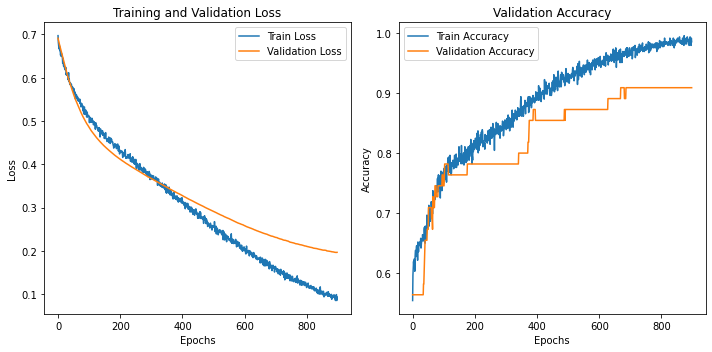

In [35]:
# Visualization
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [36]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/cnn/model_finetune_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!


In [37]:
def test_model(model, test_dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Do not compute gradients during evaluation
        for X_batch, y_batch in tqdm(test_dataloader, desc="Testing"):
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            _, predicted_test = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted_test == y_batch).sum().item()

    final_test_loss = test_loss / len(test_dataloader)
    final_test_accuracy = correct_test / total_test

    print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

    return final_test_loss, final_test_accuracy

# After training, you can call this function to evaluate the model on the test set:
test_loss, test_accuracy = test_model(model, test_dataloader, loss_fn)


Testing: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

Test Loss: 0.3880, Test Accuracy: 0.8276


### Recurrent Neural Networks - RNN [GRU]

In [38]:
# The data preparation is the same as for CNN.

In [39]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data['text'], data['label']

train_texts, train_labels = load_data(data_path())
val_texts, val_labels = load_data(data_path('validation'))
test_texts, test_labels = load_data(data_path('test'))

In [40]:
#tokenization
tokenizer = get_tokenizer('basic_english')

def tokenize_texts(texts):
    return [tokenizer(text) for text in texts]

tokenized_train_texts = tokenize_texts(train_texts)
tokenized_val_texts = tokenize_texts(val_texts)
tokenized_test_texts = tokenize_texts(test_texts)

In [41]:
#Build a vocabulary from tokenized texts
def build_vocab(tokenized_texts):
    counter = Counter()
    for text in tokenized_texts:
        counter.update(text)
    return Vocab(counter) #, min_freq=1)

vocab = build_vocab(tokenized_train_texts)
#You should not build a new vocabulary for your validation and test data. Instead, use the vocabulary built from your training data to ensure consistency.
# vocab_val = build_vocab(tokenized_val_texts)
# vocab_test = build_vocab(tokenized_test_texts)

In [42]:
def encode_texts(tokenized_texts, vocab):
    return [[vocab[word] for word in text] for text in tokenized_texts]

encoded_train_texts = encode_texts(tokenized_train_texts, vocab)
encoded_val_texts = encode_texts(tokenized_val_texts, vocab)
encoded_test_texts = encode_texts(tokenized_test_texts, vocab)

In [43]:
#Pad your encoded texts to ensure they all have the same length.
def pad_texts(encoded_texts, max_len):
    return [text + [0]*(max_len - len(text)) for text in encoded_texts]

max_len = max(map(len, encoded_train_texts))  # Determine max_len based on training data
padded_train_texts = pad_texts(encoded_train_texts, max_len)
padded_val_texts = pad_texts(encoded_val_texts, max_len)
padded_test_texts = pad_texts(encoded_test_texts, max_len)

In [44]:
X_train_tensor = torch.tensor(padded_train_texts, dtype=torch.long)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.long)

X_val_tensor = torch.tensor(padded_val_texts, dtype=torch.long)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.long)

X_test_tensor = torch.tensor(padded_test_texts, dtype=torch.long)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.long)

In [45]:
# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout=0.5, bidirectional=True):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                          dropout=dropout if num_layers > 1 else 0, 
                          bidirectional=bidirectional, batch_first=True)
        
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.fc1 = nn.Linear(fc_input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(64)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        
        # Dynamic max-pooling
        pooled, _ = torch.max(x, 1)
        
        x = F.relu(self.fc1(pooled))
        x = self.ln(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [47]:
# Instantiate the model
vocab_size = len(vocab)
embed_dim = 150
output_dim = len(set(train_labels))
num_layers= 2

hidden_dim = 128

model = RNN(vocab_size, embed_dim, hidden_dim, output_dim, num_layers)

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001)

patience=3
min_delta=0

num_epochs = 100
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(
    model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs, patience=patience, min_delta=min_delta)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 1/100, Train Loss: 0.6772, Train Acc: 0.5886, Val Loss: 0.6756, Val Acc: 0.5636


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 2/100, Train Loss: 0.6669, Train Acc: 0.6029, Val Loss: 0.6650, Val Acc: 0.5636


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 3/100, Train Loss: 0.6667, Train Acc: 0.6069, Val Loss: 0.6519, Val Acc: 0.5636


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 4/100, Train Loss: 0.6652, Train Acc: 0.6151, Val Loss: 0.6353, Val Acc: 0.5636


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 5/100, Train Loss: 0.6493, Train Acc: 0.6232, Val Loss: 0.6135, Val Acc: 0.7273


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 6/100, Train Loss: 0.6532, Train Acc: 0.5886, Val Loss: 0.6006, Val Acc: 0.7636


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 7/100, Train Loss: 0.6352, Train Acc: 0.6354, Val Loss: 0.5901, Val Acc: 0.7818


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 8/100, Train Loss: 0.6111, Train Acc: 0.6436, Val Loss: 0.5816, Val Acc: 0.7818


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 9/100, Train Loss: 0.5856, Train Acc: 0.6762, Val Loss: 0.5655, Val Acc: 0.7818


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 10/100, Train Loss: 0.5934, Train Acc: 0.6986, Val Loss: 0.5491, Val Acc: 0.7636


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 11/100, Train Loss: 0.5396, Train Acc: 0.7291, Val Loss: 0.5240, Val Acc: 0.7818


Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 12/100, Train Loss: 0.5246, Train Acc: 0.7352, Val Loss: 0.5151, Val Acc: 0.7818


Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 13/100, Train Loss: 0.5341, Train Acc: 0.7352, Val Loss: 0.5133, Val Acc: 0.7818


Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 14/100, Train Loss: 0.5049, Train Acc: 0.7902, Val Loss: 0.4992, Val Acc: 0.7818


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 15/100, Train Loss: 0.4918, Train Acc: 0.7800, Val Loss: 0.4736, Val Acc: 0.8000


Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 16/100, Train Loss: 0.4650, Train Acc: 0.8147, Val Loss: 0.4781, Val Acc: 0.8000


Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 17/100, Train Loss: 0.4691, Train Acc: 0.8106, Val Loss: 0.4692, Val Acc: 0.8182


Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 18/100, Train Loss: 0.4552, Train Acc: 0.8086, Val Loss: 0.4513, Val Acc: 0.8364


Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 19/100, Train Loss: 0.4406, Train Acc: 0.8086, Val Loss: 0.4527, Val Acc: 0.8182


Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 20/100, Train Loss: 0.4423, Train Acc: 0.8371, Val Loss: 0.4362, Val Acc: 0.8364


Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 21/100, Train Loss: 0.4263, Train Acc: 0.8371, Val Loss: 0.4310, Val Acc: 0.8364


Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 22/100, Train Loss: 0.4144, Train Acc: 0.8452, Val Loss: 0.4268, Val Acc: 0.8364


Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 23/100, Train Loss: 0.3896, Train Acc: 0.8595, Val Loss: 0.4128, Val Acc: 0.8364


Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 24/100, Train Loss: 0.3984, Train Acc: 0.8615, Val Loss: 0.4008, Val Acc: 0.8364


Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 25/100, Train Loss: 0.3804, Train Acc: 0.8676, Val Loss: 0.4011, Val Acc: 0.8364


Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 26/100, Train Loss: 0.3702, Train Acc: 0.8635, Val Loss: 0.3953, Val Acc: 0.8364


Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 27/100, Train Loss: 0.3752, Train Acc: 0.8859, Val Loss: 0.3862, Val Acc: 0.8364


Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 28/100, Train Loss: 0.3529, Train Acc: 0.8676, Val Loss: 0.3833, Val Acc: 0.8182


Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 29/100, Train Loss: 0.3383, Train Acc: 0.9022, Val Loss: 0.3761, Val Acc: 0.8364


Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 30/100, Train Loss: 0.3250, Train Acc: 0.8941, Val Loss: 0.3704, Val Acc: 0.8364


Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 31/100, Train Loss: 0.3539, Train Acc: 0.8880, Val Loss: 0.3616, Val Acc: 0.8364


Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 32/100, Train Loss: 0.3225, Train Acc: 0.9043, Val Loss: 0.3545, Val Acc: 0.8364


Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 33/100, Train Loss: 0.2887, Train Acc: 0.9246, Val Loss: 0.3399, Val Acc: 0.8364


Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 34/100, Train Loss: 0.3035, Train Acc: 0.9185, Val Loss: 0.3312, Val Acc: 0.8364


Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 35/100, Train Loss: 0.2929, Train Acc: 0.9124, Val Loss: 0.3331, Val Acc: 0.8364


Validating epoch 36: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 36/100, Train Loss: 0.2762, Train Acc: 0.9267, Val Loss: 0.3248, Val Acc: 0.8545


Validating epoch 37: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 37/100, Train Loss: 0.2532, Train Acc: 0.9328, Val Loss: 0.3092, Val Acc: 0.8727


Validating epoch 38: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 38/100, Train Loss: 0.2772, Train Acc: 0.9287, Val Loss: 0.3107, Val Acc: 0.8727


Validating epoch 39: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 39/100, Train Loss: 0.2576, Train Acc: 0.9328, Val Loss: 0.2900, Val Acc: 0.8909


Validating epoch 40: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 40/100, Train Loss: 0.2400, Train Acc: 0.9348, Val Loss: 0.2874, Val Acc: 0.8909


Validating epoch 41: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 41/100, Train Loss: 0.2161, Train Acc: 0.9552, Val Loss: 0.2958, Val Acc: 0.8909


Validating epoch 42: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 42/100, Train Loss: 0.2213, Train Acc: 0.9409, Val Loss: 0.2841, Val Acc: 0.8909


Validating epoch 43: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 43/100, Train Loss: 0.2091, Train Acc: 0.9430, Val Loss: 0.2848, Val Acc: 0.8909


Validating epoch 44: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 44/100, Train Loss: 0.1962, Train Acc: 0.9654, Val Loss: 0.2663, Val Acc: 0.9091


Validating epoch 45: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 45/100, Train Loss: 0.1947, Train Acc: 0.9613, Val Loss: 0.2757, Val Acc: 0.9091


Validating epoch 46: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 46/100, Train Loss: 0.1595, Train Acc: 0.9735, Val Loss: 0.2591, Val Acc: 0.9091


Validating epoch 47: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 47/100, Train Loss: 0.1514, Train Acc: 0.9695, Val Loss: 0.2569, Val Acc: 0.9091


Validating epoch 48: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 48/100, Train Loss: 0.1611, Train Acc: 0.9695, Val Loss: 0.2670, Val Acc: 0.9273


Validating epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 49/100, Train Loss: 0.1652, Train Acc: 0.9593, Val Loss: 0.2441, Val Acc: 0.9273


Validating epoch 50: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 50/100, Train Loss: 0.1291, Train Acc: 0.9837, Val Loss: 0.2329, Val Acc: 0.9273


Validating epoch 51: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 51/100, Train Loss: 0.1522, Train Acc: 0.9674, Val Loss: 0.2226, Val Acc: 0.9273


Validating epoch 52: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 52/100, Train Loss: 0.1315, Train Acc: 0.9817, Val Loss: 0.2284, Val Acc: 0.9455


Validating epoch 53: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 53/100, Train Loss: 0.1224, Train Acc: 0.9817, Val Loss: 0.2289, Val Acc: 0.9455


Validating epoch 54: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 54/100, Train Loss: 0.1244, Train Acc: 0.9817, Val Loss: 0.2187, Val Acc: 0.9273


Validating epoch 55: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 55/100, Train Loss: 0.1053, Train Acc: 0.9756, Val Loss: 0.2172, Val Acc: 0.9455


Validating epoch 56: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 56/100, Train Loss: 0.1109, Train Acc: 0.9756, Val Loss: 0.2244, Val Acc: 0.9455


Validating epoch 57: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 57/100, Train Loss: 0.1098, Train Acc: 0.9817, Val Loss: 0.2279, Val Acc: 0.9455


Validating epoch 58: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 58/100, Train Loss: 0.1052, Train Acc: 0.9817, Val Loss: 0.2222, Val Acc: 0.9455
Early stopping triggered!


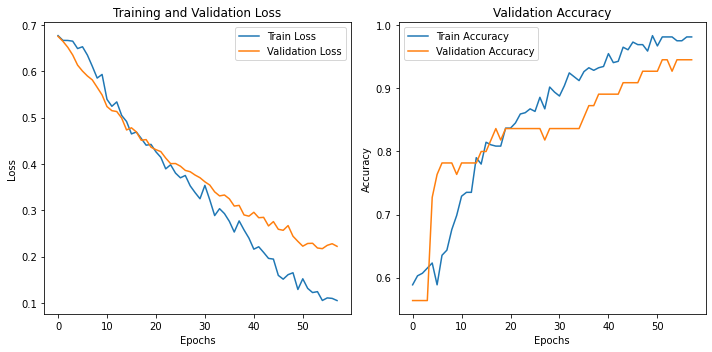

In [48]:
# Visualization
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [49]:
def test_model(model, test_dataloader, loss_fn, device="cpu"):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Do not compute gradients during evaluation
        for X_batch, y_batch in tqdm(test_dataloader, desc="Testing"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Send batch data to the device
            
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            _, predicted_test = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted_test == y_batch).sum().item()

    final_test_loss = test_loss / len(test_dataloader)
    final_test_accuracy = correct_test / total_test

    print(f"Test Loss: {final_test_loss:.4f}")
    print(f"Test Accuracy: {final_test_accuracy * 100:.2f}%")

    metrics = {
        "test_loss": final_test_loss,
        "test_accuracy": final_test_accuracy
    }

    return metrics

metrics = test_model(model, test_dataloader, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu")

Testing: 100%|██████████| 2/2 [00:00<00:00, 16.27it/s]

Test Loss: 0.6425
Test Accuracy: 81.03%


In [50]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/rnn/model_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!


### Fine-tuning

In [51]:
# Instantiate the model
vocab_size = len(vocab)
embed_dim = 150
output_dim = len(set(train_labels))
num_layers= 2

hidden_dim = 128

model = RNN(vocab_size, embed_dim, hidden_dim, output_dim, num_layers)

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.00001)

patience=3
min_delta=0

num_epochs = 300
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(
    model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs, patience=patience, min_delta=min_delta)

Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 1/300, Train Loss: 0.7102, Train Acc: 0.4868, Val Loss: 0.6813, Val Acc: 0.5636


Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 2/300, Train Loss: 0.7065, Train Acc: 0.5132, Val Loss: 0.6773, Val Acc: 0.5636


Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 3/300, Train Loss: 0.6984, Train Acc: 0.5234, Val Loss: 0.6741, Val Acc: 0.5636


Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 4/300, Train Loss: 0.6788, Train Acc: 0.5601, Val Loss: 0.6720, Val Acc: 0.5636


Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 5/300, Train Loss: 0.6837, Train Acc: 0.5397, Val Loss: 0.6709, Val Acc: 0.5636


Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 6/300, Train Loss: 0.6569, Train Acc: 0.6151, Val Loss: 0.6702, Val Acc: 0.5636


Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 7/300, Train Loss: 0.6741, Train Acc: 0.5743, Val Loss: 0.6694, Val Acc: 0.5636


Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 8/300, Train Loss: 0.6617, Train Acc: 0.6029, Val Loss: 0.6691, Val Acc: 0.5636


Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 9/300, Train Loss: 0.6722, Train Acc: 0.6029, Val Loss: 0.6695, Val Acc: 0.5636


Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 10/300, Train Loss: 0.6739, Train Acc: 0.6110, Val Loss: 0.6696, Val Acc: 0.5636


Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Epoch 11/300, Train Loss: 0.6601, Train Acc: 0.6090, Val Loss: 0.6699, Val Acc: 0.5636
Early stopping triggered!


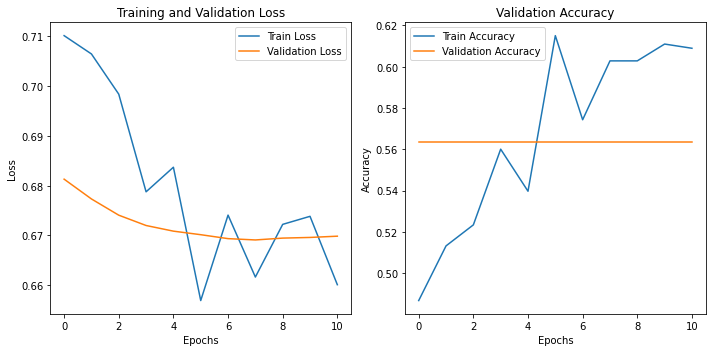

In [52]:
# Visualization
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [53]:
from tqdm import tqdm

def test_model(model, test_dataloader, loss_fn, device="cpu"):
    """
    Evaluates the model on the given test dataloader.

    Parameters:
    - model (nn.Module): The model to be evaluated.
    - test_dataloader (DataLoader): DataLoader for the test set.
    - loss_fn (Function): Loss function used for evaluation.
    - device (str): The device to run the model on ("cpu" or "cuda").

    Returns:
    - metrics (dict): Dictionary containing test loss and test accuracy.
    """
    
    model = model.to(device)  
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Do not compute gradients during evaluation
        for X_batch, y_batch in tqdm(test_dataloader, desc="Testing"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Send batch data to the device
            
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            _, predicted_test = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted_test == y_batch).sum().item()

    final_test_loss = test_loss / len(test_dataloader)
    final_test_accuracy = correct_test / total_test

    print(f"Test Loss: {final_test_loss:.4f}")
    print(f"Test Accuracy: {final_test_accuracy * 100:.2f}%")

    metrics = {
        "test_loss": final_test_loss,
        "test_accuracy": final_test_accuracy
    }

    return metrics

metrics = test_model(model, test_dataloader, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu")


Testing: 100%|██████████| 2/2 [00:00<00:00, 15.84it/s]

Test Loss: 0.7137
Test Accuracy: 48.28%


In [54]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/rnn/model_finetune_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!


### Transformers - DistilBert

In [15]:
# !pip install transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def data_path(source_type='train'):
    return str("".join(["".join(['data/prompt_injections_', source_type]),'.csv']))

In [4]:
def data_prep_bert(data):
    data = pd.read_csv(data)
    return data['text'].tolist(), data['label'].tolist()

In [5]:
def dataloader_prep(source):
    texts, labels = source
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    return input_ids, attention_mask, torch.tensor(labels)

input_ids, attention_mask, labels = dataloader_prep(data_prep_bert(data_path()))

In [6]:
class TextClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [7]:
input_ids_train, attention_mask_train, labels_train = dataloader_prep(data_prep_bert(data_path()))
input_ids_val, attention_mask_val, labels_val = dataloader_prep(data_prep_bert(data_path('validation')))
input_ids_test, attention_mask_test, labels_test = dataloader_prep(data_prep_bert(data_path('test')))

# Create separate datasets for training, validation, and testing
train_dataset = TextClassificationDataset(
    input_ids=input_ids_train,
    attention_mask=attention_mask_train,
    labels=labels_train
)

val_dataset = TextClassificationDataset(
    input_ids=input_ids_val,
    attention_mask=attention_mask_val,
    labels=labels_val
)

test_dataset = TextClassificationDataset(
    input_ids=input_ids_test,
    attention_mask=attention_mask_test,
    labels=labels_test
)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
output_dim = 2
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [10]:
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
patience=2
min_delta=0

total_steps = len(train_dataloader) * num_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [11]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, patience, min_delta):
    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
        model.train()

        epoch_train_loss = 0
        epoch_train_correct = 0
        epoch_train_total = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            
            # Move tensors to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            epoch_train_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            epoch_train_total += labels.size(0)
            epoch_train_correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        train_loss_values.append(epoch_train_loss / len(train_loader))
        train_acc_values.append(epoch_train_correct / epoch_train_total)

        model.eval()
        epoch_val_loss = 0
        epoch_val_correct = 0
        epoch_val_total = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                
                # Move tensors to the device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                epoch_val_loss += outputs.loss.item()

                _, predicted = torch.max(outputs.logits, 1)
                epoch_val_total += labels.size(0)
                epoch_val_correct += (predicted == labels).sum().item()

        val_loss_values.append(epoch_val_loss / len(val_loader))
        val_acc_values.append(epoch_val_correct / epoch_val_total)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss/len(train_loader)}, Training Accuracy: {epoch_train_correct/epoch_train_total}, Validation Loss: {epoch_val_loss/len(val_loader)}, Validation Accuracy: {epoch_val_correct/epoch_val_total}")
        
        # Check for early stopping
        if early_stopper.early_stop(epoch_val_loss / len(val_loader)):
            print(f"Early stopping triggered! [Epoch: {epoch+1}]")
            break

    return train_loss_values, train_acc_values, val_loss_values, val_acc_values


In [12]:
train_loss_values, train_acc_values, val_loss_values, val_acc_values = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, num_epochs, patience, min_delta)

Validation Epoch 1/10: 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


Epoch 1/10, Training Loss: 0.38897888665838587, Training Accuracy: 0.8105906313645621, Validation Loss: 0.13779554037111147, Validation Accuracy: 0.9454545454545454


Validation Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


Epoch 2/10, Training Loss: 0.09437603047568231, Training Accuracy: 0.9735234215885947, Validation Loss: 0.15728009106325253, Validation Accuracy: 0.9454545454545454


Validation Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


Epoch 3/10, Training Loss: 0.06166674905726986, Training Accuracy: 0.9877800407331976, Validation Loss: 0.09387985743316156, Validation Accuracy: 0.9818181818181818


Validation Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 4/10, Training Loss: 0.056675975083283356, Training Accuracy: 0.9857433808553971, Validation Loss: 0.03464482378746782, Validation Accuracy: 1.0


Validation Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch 5/10, Training Loss: 0.018175154571391402, Training Accuracy: 0.9979633401221996, Validation Loss: 0.0022554057982883285, Validation Accuracy: 1.0


Validation Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


Epoch 6/10, Training Loss: 0.0028282341363299037, Training Accuracy: 1.0, Validation Loss: 0.0014527751398938043, Validation Accuracy: 1.0


Validation Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


Epoch 7/10, Training Loss: 0.0017117575194025712, Training Accuracy: 1.0, Validation Loss: 0.0011418555763417057, Validation Accuracy: 1.0


Validation Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


Epoch 8/10, Training Loss: 0.0013463011118508275, Training Accuracy: 1.0, Validation Loss: 0.0009795847914314695, Validation Accuracy: 1.0


Validation Epoch 9/10: 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


Epoch 9/10, Training Loss: 0.0012160714531707908, Training Accuracy: 1.0, Validation Loss: 0.0008955087728931435, Validation Accuracy: 1.0


Validation Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

Epoch 10/10, Training Loss: 0.0011518214493163772, Training Accuracy: 1.0, Validation Loss: 0.0008686892355659179, Validation Accuracy: 1.0


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get the right device
model = model.to(device)  # Ensure your model is on the correct device

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)  # Move tensor to the correct device
        attention_mask = batch['attention_mask'].to(device)  # Move tensor to the correct device
        labels = batch['labels'].to(device)  # Move tensor to the correct device
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += outputs.loss.item()
        
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_dataloader)}, Test Accuracy: {correct/total}")


Test Loss: 0.13319332860022162, Test Accuracy: 0.9568965517241379


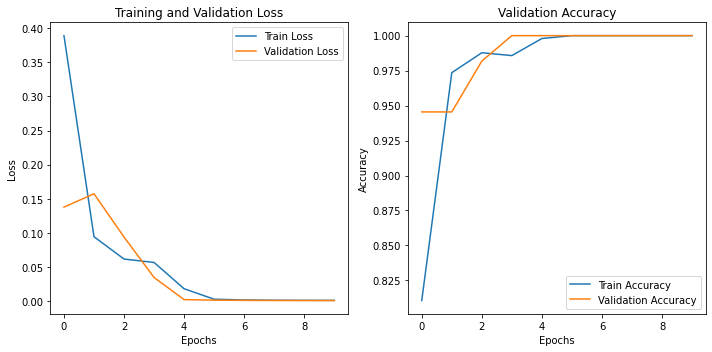

In [16]:
# Visualization
plt.figure(figsize=(10,5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [17]:
# Define a dictionary to hold any information you want to save
save_dict = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'last_train_loss': train_loss_values[-1] if train_loss_values else None,
    'last_train_acc': train_acc_values[-1] if train_acc_values else None,
    'last_val_loss': val_loss_values[-1] if val_loss_values else None,
    'last_val_acc': val_acc_values[-1] if val_acc_values else None
}

# Specify a path
path = "model_weights/distilbert/model_checkpoint.pth"

# Save the dictionary with try-except
try:
    torch.save(save_dict, path)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving the model: {e}")


Model saved successfully!
